Copyright 2020 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Assess privacy risks with the TensorFlow Privacy Report

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/responsible_ai/privacy/tutorials/privacy_report"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/privacy/blob/master/g3doc/tutorials/privacy_report.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/privacy/blob/master/g3doc/tutorials/privacy_report.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/privacy/g3doc/tutorials/privacy_report.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

##Overview
In this codelab you'll train a simple image classification model on the CIFAR10 dataset, and then use the "membership inference attack" against this model to assess if the attacker is able to "guess" whether a particular sample was present in the training set. You will use the TF Privacy Report to visualize results from multiple models and model checkpoints.

## Setup


In [2]:
import numpy as np
from typing import Tuple
from scipy import special
from sklearn import metrics

import tensorflow as tf

import tensorflow_datasets as tfds

# Set verbosity.
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

### Install TensorFlow Privacy.

In [3]:
!pip install tensorflow_privacy

In [4]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResultsCollection
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyMetric
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyReportMetadata
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import privacy_report

In [5]:
import tensorflow_privacy

## Train two models, with privacy metrics

This section trains a pair of `keras.Model` classifiers on the `CIFAR-10` dataset. During the training process it collects privacy metrics, that will be used to generate reports in the bext section.

The first step is to define some hyperparameters:

In [6]:
dataset = 'cifar10'
num_classes = 10
activation = 'relu'
num_conv = 3

batch_size=50
epochs_per_report = 2
total_epochs = 50

lr = 0.001

Next, load the dataset. There's nothing privacy-specific in this code.

In [7]:
#@title
print('Loading the dataset.')
train_ds = tfds.as_numpy(
    tfds.load(dataset, split=tfds.Split.TRAIN, batch_size=-1))
test_ds = tfds.as_numpy(
    tfds.load(dataset, split=tfds.Split.TEST, batch_size=-1))
x_train = train_ds['image'].astype('float32') / 255.
y_train_indices = train_ds['label'][:, np.newaxis]
x_test = test_ds['image'].astype('float32') / 255.
y_test_indices = test_ds['label'][:, np.newaxis]

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train_indices, num_classes)
y_test = tf.keras.utils.to_categorical(y_test_indices, num_classes)

input_shape = x_train.shape[1:]

assert x_train.shape[0] % batch_size == 0, "The tensorflow_privacy optimizer doesn't handle partial batches"

Loading the dataset.


2023-10-06 09:25:04.972757: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Next define a function to build the models.

In [8]:
#@title
def small_cnn(input_shape: Tuple[int],
              num_classes: int,
              num_conv: int,
              activation: str = 'relu') -> tf.keras.models.Sequential:
  """Setup a small CNN for image classification.

  Args:
    input_shape: Integer tuple for the shape of the images.
    num_classes: Number of prediction classes.
    num_conv: Number of convolutional layers.
    activation: The activation function to use for conv and dense layers.

  Returns:
    The Keras model.
  """
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape))

  # Conv layers
  for _ in range(num_conv):
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation=activation))
  model.add(tf.keras.layers.Dense(num_classes))
  
  model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['accuracy'])

  return model

Build two three-layer CNN models using that function.

Configure the first to use a basic SGD optimizer, an the second to use a differentially private optimizer (`tf_privacy.DPKerasAdamOptimizer`), so you can compare the results.

In [9]:
model_2layers = small_cnn(
    input_shape, num_classes, num_conv=2, activation=activation)
model_3layers = small_cnn(
    input_shape, num_classes, num_conv=3, activation=activation)

### Define a callback to collect privacy metrics

Next define a `keras.callbacks.Callback` to periorically run some privacy attacks against the model, and log the results.

The keras `fit` method will call the `on_epoch_end` method after each training epoch. The `n` argument is the (0-based) epoch number.

You could implement this procedure by writing a loop that repeatedly calls `Model.fit(..., epochs=epochs_per_report)` and runs the attack code. The callback is used here just because it gives a clear separation between the training logic, and the privacy evaluation logic.


In [10]:
class PrivacyMetrics(tf.keras.callbacks.Callback):
  def __init__(self, epochs_per_report, model_name):
    self.epochs_per_report = epochs_per_report
    self.model_name = model_name
    self.attack_results = []

  def on_epoch_end(self, epoch, logs=None):
    epoch = epoch+1

    if epoch % self.epochs_per_report != 0:
      return

    print(f'\nRunning privacy report for epoch: {epoch}\n')

    logits_train = self.model.predict(x_train, batch_size=batch_size)
    logits_test = self.model.predict(x_test, batch_size=batch_size)

    prob_train = special.softmax(logits_train, axis=1)
    prob_test = special.softmax(logits_test, axis=1)

    # Add metadata to generate a privacy report.
    privacy_report_metadata = PrivacyReportMetadata(
        # Show the validation accuracy on the plot
        # It's what you send to train_accuracy that gets plotted.
        accuracy_train=logs['val_accuracy'], 
        accuracy_test=logs['val_accuracy'],
        epoch_num=epoch,
        model_variant_label=self.model_name)

    attack_results = mia.run_attacks(
        AttackInputData(
            labels_train=y_train_indices[:, 0],
            labels_test=y_test_indices[:, 0],
            probs_train=prob_train,
            probs_test=prob_test),
        SlicingSpec(entire_dataset=True, by_class=True),
        attack_types=(AttackType.THRESHOLD_ATTACK,
                      AttackType.LOGISTIC_REGRESSION),
        privacy_report_metadata=privacy_report_metadata)

    self.attack_results.append(attack_results)


### Train the models

The next code block trains the two models. The `all_reports` list is used to collect all the results from all the models' training runs. The individual reports are tagged witht the `model_name`, so there's no confusion about which model generated which report.

In [11]:
all_reports = []

In [12]:
callback = PrivacyMetrics(epochs_per_report, "2 Layers")
history = model_2layers.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=total_epochs,
      validation_data=(x_test, y_test),
      callbacks=[callback],
      shuffle=True)

all_reports.extend(callback.attack_results)

Epoch 1/50


   1/1000 [..............................] - ETA: 12:14 - loss: 2.2398 - accuracy: 0.1400

   7/1000 [..............................] - ETA: 8s - loss: 2.3051 - accuracy: 0.1229   

  14/1000 [..............................] - ETA: 8s - loss: 2.2987 - accuracy: 0.1229

  21/1000 [..............................] - ETA: 7s - loss: 2.2873 - accuracy: 0.1410

  28/1000 [..............................] - ETA: 7s - loss: 2.2718 - accuracy: 0.1614

  36/1000 [>.............................] - ETA: 7s - loss: 2.2542 - accuracy: 0.1633

  44/1000 [>.............................] - ETA: 7s - loss: 2.2330 - accuracy: 0.1691

  52/1000 [>.............................] - ETA: 6s - loss: 2.2069 - accuracy: 0.1796

  60/1000 [>.............................] - ETA: 6s - loss: 2.1910 - accuracy: 0.1887

  68/1000 [=>............................] - ETA: 6s - loss: 2.1715 - accuracy: 0.1965

  76/1000 [=>............................] - ETA: 6s - loss: 2.1471 - accuracy: 0.2095

  84/1000 [=>............................] - ETA: 6s - loss: 2.1270 - accuracy: 0.2155

  92/1000 [=>............................] - ETA: 6s - loss: 2.1033 - accuracy: 0.2202

 100/1000 [==>...........................] - ETA: 6s - loss: 2.0885 - accuracy: 0.2264

 108/1000 [==>...........................] - ETA: 6s - loss: 2.0682 - accuracy: 0.2354

 115/1000 [==>...........................] - ETA: 6s - loss: 2.0546 - accuracy: 0.2393

 123/1000 [==>...........................] - ETA: 6s - loss: 2.0382 - accuracy: 0.2468

 130/1000 [==>...........................] - ETA: 6s - loss: 2.0270 - accuracy: 0.2517

 138/1000 [===>..........................] - ETA: 6s - loss: 2.0153 - accuracy: 0.2554

 145/1000 [===>..........................] - ETA: 6s - loss: 2.0047 - accuracy: 0.2593

 153/1000 [===>..........................] - ETA: 6s - loss: 1.9922 - accuracy: 0.2646

 160/1000 [===>..........................] - ETA: 5s - loss: 1.9825 - accuracy: 0.2665

 168/1000 [====>.........................] - ETA: 5s - loss: 1.9720 - accuracy: 0.2706

 176/1000 [====>.........................] - ETA: 5s - loss: 1.9590 - accuracy: 0.2757

 183/1000 [====>.........................] - ETA: 5s - loss: 1.9482 - accuracy: 0.2791

 191/1000 [====>.........................] - ETA: 5s - loss: 1.9357 - accuracy: 0.2828

 198/1000 [====>.........................] - ETA: 5s - loss: 1.9276 - accuracy: 0.2864

 206/1000 [=====>........................] - ETA: 5s - loss: 1.9194 - accuracy: 0.2906

 213/1000 [=====>........................] - ETA: 5s - loss: 1.9108 - accuracy: 0.2943

 220/1000 [=====>........................] - ETA: 5s - loss: 1.9039 - accuracy: 0.2968

 228/1000 [=====>........................] - ETA: 5s - loss: 1.8946 - accuracy: 0.3009

 235/1000 [======>.......................] - ETA: 5s - loss: 1.8857 - accuracy: 0.3047

 243/1000 [======>.......................] - ETA: 5s - loss: 1.8760 - accuracy: 0.3072

 251/1000 [======>.......................] - ETA: 5s - loss: 1.8699 - accuracy: 0.3104

 258/1000 [======>.......................] - ETA: 5s - loss: 1.8630 - accuracy: 0.3129

 266/1000 [======>.......................] - ETA: 5s - loss: 1.8567 - accuracy: 0.3150

 274/1000 [=======>......................] - ETA: 5s - loss: 1.8516 - accuracy: 0.3173

 282/1000 [=======>......................] - ETA: 5s - loss: 1.8446 - accuracy: 0.3195

 289/1000 [=======>......................] - ETA: 5s - loss: 1.8392 - accuracy: 0.3218

 297/1000 [=======>......................] - ETA: 4s - loss: 1.8319 - accuracy: 0.3245

 305/1000 [========>.....................] - ETA: 4s - loss: 1.8266 - accuracy: 0.3274

 312/1000 [========>.....................] - ETA: 4s - loss: 1.8194 - accuracy: 0.3301

 320/1000 [========>.....................] - ETA: 4s - loss: 1.8108 - accuracy: 0.3331

 328/1000 [========>.....................] - ETA: 4s - loss: 1.8050 - accuracy: 0.3355

 336/1000 [=========>....................] - ETA: 4s - loss: 1.7984 - accuracy: 0.3385

 344/1000 [=========>....................] - ETA: 4s - loss: 1.7945 - accuracy: 0.3403

 352/1000 [=========>....................] - ETA: 4s - loss: 1.7878 - accuracy: 0.3431

 359/1000 [=========>....................] - ETA: 4s - loss: 1.7837 - accuracy: 0.3447

 366/1000 [=========>....................] - ETA: 4s - loss: 1.7789 - accuracy: 0.3470

 374/1000 [==========>...................] - ETA: 4s - loss: 1.7738 - accuracy: 0.3487

 382/1000 [==========>...................] - ETA: 4s - loss: 1.7677 - accuracy: 0.3505

 390/1000 [==========>...................] - ETA: 4s - loss: 1.7618 - accuracy: 0.3526

 398/1000 [==========>...................] - ETA: 4s - loss: 1.7583 - accuracy: 0.3541

 406/1000 [===========>..................] - ETA: 4s - loss: 1.7538 - accuracy: 0.3563

 414/1000 [===========>..................] - ETA: 4s - loss: 1.7499 - accuracy: 0.3578

 422/1000 [===========>..................] - ETA: 4s - loss: 1.7458 - accuracy: 0.3593

 430/1000 [===========>..................] - ETA: 3s - loss: 1.7414 - accuracy: 0.3613

 437/1000 [============>.................] - ETA: 3s - loss: 1.7380 - accuracy: 0.3629

 445/1000 [============>.................] - ETA: 3s - loss: 1.7325 - accuracy: 0.3653

 453/1000 [============>.................] - ETA: 3s - loss: 1.7269 - accuracy: 0.3676

 461/1000 [============>.................] - ETA: 3s - loss: 1.7230 - accuracy: 0.3691

 469/1000 [=============>................] - ETA: 3s - loss: 1.7188 - accuracy: 0.3707

 476/1000 [=============>................] - ETA: 3s - loss: 1.7146 - accuracy: 0.3721

 484/1000 [=============>................] - ETA: 3s - loss: 1.7086 - accuracy: 0.3746

 492/1000 [=============>................] - ETA: 3s - loss: 1.7040 - accuracy: 0.3759

 500/1000 [==============>...............] - ETA: 3s - loss: 1.7003 - accuracy: 0.3771

 507/1000 [==============>...............] - ETA: 3s - loss: 1.6975 - accuracy: 0.3779

 515/1000 [==============>...............] - ETA: 3s - loss: 1.6945 - accuracy: 0.3793

 523/1000 [==============>...............] - ETA: 3s - loss: 1.6912 - accuracy: 0.3807

 531/1000 [==============>...............] - ETA: 3s - loss: 1.6872 - accuracy: 0.3819

 538/1000 [===============>..............] - ETA: 3s - loss: 1.6855 - accuracy: 0.3831

 546/1000 [===============>..............] - ETA: 3s - loss: 1.6829 - accuracy: 0.3842

 553/1000 [===============>..............] - ETA: 3s - loss: 1.6797 - accuracy: 0.3854

 560/1000 [===============>..............] - ETA: 3s - loss: 1.6775 - accuracy: 0.3868

 568/1000 [================>.............] - ETA: 3s - loss: 1.6747 - accuracy: 0.3879

 575/1000 [================>.............] - ETA: 2s - loss: 1.6715 - accuracy: 0.3894

 583/1000 [================>.............] - ETA: 2s - loss: 1.6673 - accuracy: 0.3909

 591/1000 [================>.............] - ETA: 2s - loss: 1.6642 - accuracy: 0.3924

 599/1000 [================>.............] - ETA: 2s - loss: 1.6615 - accuracy: 0.3936

 606/1000 [=================>............] - ETA: 2s - loss: 1.6583 - accuracy: 0.3946

 614/1000 [=================>............] - ETA: 2s - loss: 1.6555 - accuracy: 0.3951

 622/1000 [=================>............] - ETA: 2s - loss: 1.6525 - accuracy: 0.3965

 630/1000 [=================>............] - ETA: 2s - loss: 1.6491 - accuracy: 0.3976

 638/1000 [==================>...........] - ETA: 2s - loss: 1.6475 - accuracy: 0.3983

 646/1000 [==================>...........] - ETA: 2s - loss: 1.6443 - accuracy: 0.3996

 654/1000 [==================>...........] - ETA: 2s - loss: 1.6435 - accuracy: 0.4005

 662/1000 [==================>...........] - ETA: 2s - loss: 1.6405 - accuracy: 0.4014

 670/1000 [===================>..........] - ETA: 2s - loss: 1.6389 - accuracy: 0.4022

 678/1000 [===================>..........] - ETA: 2s - loss: 1.6358 - accuracy: 0.4036

 686/1000 [===================>..........] - ETA: 2s - loss: 1.6339 - accuracy: 0.4039

 693/1000 [===================>..........] - ETA: 2s - loss: 1.6322 - accuracy: 0.4048

 701/1000 [====================>.........] - ETA: 2s - loss: 1.6301 - accuracy: 0.4054

 709/1000 [====================>.........] - ETA: 2s - loss: 1.6273 - accuracy: 0.4065

 717/1000 [====================>.........] - ETA: 1s - loss: 1.6237 - accuracy: 0.4082

 725/1000 [====================>.........] - ETA: 1s - loss: 1.6204 - accuracy: 0.4095

 733/1000 [====================>.........] - ETA: 1s - loss: 1.6185 - accuracy: 0.4103

 741/1000 [=====================>........] - ETA: 1s - loss: 1.6166 - accuracy: 0.4113

 749/1000 [=====================>........] - ETA: 1s - loss: 1.6145 - accuracy: 0.4124

 757/1000 [=====================>........] - ETA: 1s - loss: 1.6122 - accuracy: 0.4135

 765/1000 [=====================>........] - ETA: 1s - loss: 1.6098 - accuracy: 0.4144

 773/1000 [======================>.......] - ETA: 1s - loss: 1.6073 - accuracy: 0.4154

 781/1000 [======================>.......] - ETA: 1s - loss: 1.6051 - accuracy: 0.4162

 789/1000 [======================>.......] - ETA: 1s - loss: 1.6026 - accuracy: 0.4172

 797/1000 [======================>.......] - ETA: 1s - loss: 1.6000 - accuracy: 0.4181

 805/1000 [=======================>......] - ETA: 1s - loss: 1.5979 - accuracy: 0.4188

 813/1000 [=======================>......] - ETA: 1s - loss: 1.5954 - accuracy: 0.4198

 821/1000 [=======================>......] - ETA: 1s - loss: 1.5926 - accuracy: 0.4206

 829/1000 [=======================>......] - ETA: 1s - loss: 1.5893 - accuracy: 0.4219

 837/1000 [========================>.....] - ETA: 1s - loss: 1.5876 - accuracy: 0.4226

 845/1000 [========================>.....] - ETA: 1s - loss: 1.5856 - accuracy: 0.4235

 853/1000 [========================>.....] - ETA: 1s - loss: 1.5831 - accuracy: 0.4243

 861/1000 [========================>.....] - ETA: 0s - loss: 1.5810 - accuracy: 0.4254

 869/1000 [=========================>....] - ETA: 0s - loss: 1.5787 - accuracy: 0.4262

 877/1000 [=========================>....] - ETA: 0s - loss: 1.5765 - accuracy: 0.4270

 885/1000 [=========================>....] - ETA: 0s - loss: 1.5747 - accuracy: 0.4278

 893/1000 [=========================>....] - ETA: 0s - loss: 1.5727 - accuracy: 0.4285

 901/1000 [==========================>...] - ETA: 0s - loss: 1.5707 - accuracy: 0.4292

 909/1000 [==========================>...] - ETA: 0s - loss: 1.5680 - accuracy: 0.4301

 917/1000 [==========================>...] - ETA: 0s - loss: 1.5649 - accuracy: 0.4312

 925/1000 [==========================>...] - ETA: 0s - loss: 1.5632 - accuracy: 0.4318

 933/1000 [==========================>...] - ETA: 0s - loss: 1.5618 - accuracy: 0.4321

 941/1000 [===========================>..] - ETA: 0s - loss: 1.5603 - accuracy: 0.4326

 949/1000 [===========================>..] - ETA: 0s - loss: 1.5580 - accuracy: 0.4335

 957/1000 [===========================>..] - ETA: 0s - loss: 1.5559 - accuracy: 0.4343

 965/1000 [===========================>..] - ETA: 0s - loss: 1.5537 - accuracy: 0.4351

 973/1000 [============================>.] - ETA: 0s - loss: 1.5516 - accuracy: 0.4356

 981/1000 [============================>.] - ETA: 0s - loss: 1.5492 - accuracy: 0.4366

 989/1000 [============================>.] - ETA: 0s - loss: 1.5477 - accuracy: 0.4370

 997/1000 [============================>.] - ETA: 0s - loss: 1.5456 - accuracy: 0.4378

1000/1000 [==============================] - 8s 8ms/step - loss: 1.5448 - accuracy: 0.4380 - val_loss: 1.3053 - val_accuracy: 0.5298


Epoch 2/50


   1/1000 [..............................] - ETA: 6s - loss: 1.5437 - accuracy: 0.5400

  10/1000 [..............................] - ETA: 6s - loss: 1.2972 - accuracy: 0.5520

  18/1000 [..............................] - ETA: 6s - loss: 1.3244 - accuracy: 0.5411

  26/1000 [..............................] - ETA: 6s - loss: 1.2903 - accuracy: 0.5615

  34/1000 [>.............................] - ETA: 6s - loss: 1.3156 - accuracy: 0.5406

  42/1000 [>.............................] - ETA: 6s - loss: 1.3048 - accuracy: 0.5405

  50/1000 [>.............................] - ETA: 6s - loss: 1.2949 - accuracy: 0.5404

  58/1000 [>.............................] - ETA: 6s - loss: 1.2990 - accuracy: 0.5390

  66/1000 [>.............................] - ETA: 6s - loss: 1.3031 - accuracy: 0.5364

  74/1000 [=>............................] - ETA: 6s - loss: 1.3140 - accuracy: 0.5300

  82/1000 [=>............................] - ETA: 5s - loss: 1.3070 - accuracy: 0.5327

  90/1000 [=>............................] - ETA: 5s - loss: 1.3042 - accuracy: 0.5327

  98/1000 [=>............................] - ETA: 5s - loss: 1.3049 - accuracy: 0.5300

 106/1000 [==>...........................] - ETA: 5s - loss: 1.3043 - accuracy: 0.5317

 114/1000 [==>...........................] - ETA: 5s - loss: 1.2999 - accuracy: 0.5335

 122/1000 [==>...........................] - ETA: 5s - loss: 1.2995 - accuracy: 0.5339

 130/1000 [==>...........................] - ETA: 5s - loss: 1.2951 - accuracy: 0.5360

 138/1000 [===>..........................] - ETA: 5s - loss: 1.2941 - accuracy: 0.5362

 146/1000 [===>..........................] - ETA: 5s - loss: 1.2909 - accuracy: 0.5370

 154/1000 [===>..........................] - ETA: 5s - loss: 1.2904 - accuracy: 0.5382

 162/1000 [===>..........................] - ETA: 5s - loss: 1.2905 - accuracy: 0.5373

 170/1000 [====>.........................] - ETA: 5s - loss: 1.2841 - accuracy: 0.5398

 178/1000 [====>.........................] - ETA: 5s - loss: 1.2825 - accuracy: 0.5417

 186/1000 [====>.........................] - ETA: 5s - loss: 1.2832 - accuracy: 0.5412

 194/1000 [====>.........................] - ETA: 5s - loss: 1.2872 - accuracy: 0.5393

 202/1000 [=====>........................] - ETA: 5s - loss: 1.2832 - accuracy: 0.5407

 210/1000 [=====>........................] - ETA: 5s - loss: 1.2811 - accuracy: 0.5423

 218/1000 [=====>........................] - ETA: 5s - loss: 1.2839 - accuracy: 0.5420

 226/1000 [=====>........................] - ETA: 5s - loss: 1.2808 - accuracy: 0.5434

 234/1000 [======>.......................] - ETA: 4s - loss: 1.2770 - accuracy: 0.5440

 242/1000 [======>.......................] - ETA: 4s - loss: 1.2763 - accuracy: 0.5440

 250/1000 [======>.......................] - ETA: 4s - loss: 1.2784 - accuracy: 0.5427

 258/1000 [======>.......................] - ETA: 4s - loss: 1.2751 - accuracy: 0.5447

 266/1000 [======>.......................] - ETA: 4s - loss: 1.2693 - accuracy: 0.5470

 274/1000 [=======>......................] - ETA: 4s - loss: 1.2681 - accuracy: 0.5474

 282/1000 [=======>......................] - ETA: 4s - loss: 1.2693 - accuracy: 0.5478

 290/1000 [=======>......................] - ETA: 4s - loss: 1.2688 - accuracy: 0.5474

 298/1000 [=======>......................] - ETA: 4s - loss: 1.2705 - accuracy: 0.5473

 306/1000 [========>.....................] - ETA: 4s - loss: 1.2706 - accuracy: 0.5474

 314/1000 [========>.....................] - ETA: 4s - loss: 1.2689 - accuracy: 0.5482

 322/1000 [========>.....................] - ETA: 4s - loss: 1.2682 - accuracy: 0.5483

 330/1000 [========>.....................] - ETA: 4s - loss: 1.2680 - accuracy: 0.5482

 338/1000 [=========>....................] - ETA: 4s - loss: 1.2654 - accuracy: 0.5490

 346/1000 [=========>....................] - ETA: 4s - loss: 1.2640 - accuracy: 0.5497

 354/1000 [=========>....................] - ETA: 4s - loss: 1.2643 - accuracy: 0.5494

 362/1000 [=========>....................] - ETA: 4s - loss: 1.2644 - accuracy: 0.5493

 370/1000 [==========>...................] - ETA: 4s - loss: 1.2621 - accuracy: 0.5497

 378/1000 [==========>...................] - ETA: 4s - loss: 1.2617 - accuracy: 0.5495

 385/1000 [==========>...................] - ETA: 4s - loss: 1.2610 - accuracy: 0.5495

 393/1000 [==========>...................] - ETA: 3s - loss: 1.2619 - accuracy: 0.5488

 400/1000 [===========>..................] - ETA: 3s - loss: 1.2621 - accuracy: 0.5488

 407/1000 [===========>..................] - ETA: 3s - loss: 1.2624 - accuracy: 0.5486

 415/1000 [===========>..................] - ETA: 3s - loss: 1.2623 - accuracy: 0.5484

 423/1000 [===========>..................] - ETA: 3s - loss: 1.2606 - accuracy: 0.5494

 431/1000 [===========>..................] - ETA: 3s - loss: 1.2601 - accuracy: 0.5502

 439/1000 [============>.................] - ETA: 3s - loss: 1.2586 - accuracy: 0.5511

 447/1000 [============>.................] - ETA: 3s - loss: 1.2583 - accuracy: 0.5515

 455/1000 [============>.................] - ETA: 3s - loss: 1.2568 - accuracy: 0.5524

 463/1000 [============>.................] - ETA: 3s - loss: 1.2570 - accuracy: 0.5526

 471/1000 [=============>................] - ETA: 3s - loss: 1.2583 - accuracy: 0.5515

 479/1000 [=============>................] - ETA: 3s - loss: 1.2575 - accuracy: 0.5521

 487/1000 [=============>................] - ETA: 3s - loss: 1.2567 - accuracy: 0.5519

 495/1000 [=============>................] - ETA: 3s - loss: 1.2570 - accuracy: 0.5518

 503/1000 [==============>...............] - ETA: 3s - loss: 1.2568 - accuracy: 0.5518

 511/1000 [==============>...............] - ETA: 3s - loss: 1.2560 - accuracy: 0.5522

 519/1000 [==============>...............] - ETA: 3s - loss: 1.2546 - accuracy: 0.5529

 528/1000 [==============>...............] - ETA: 3s - loss: 1.2555 - accuracy: 0.5524

 537/1000 [===============>..............] - ETA: 3s - loss: 1.2550 - accuracy: 0.5531

 545/1000 [===============>..............] - ETA: 2s - loss: 1.2520 - accuracy: 0.5537

 553/1000 [===============>..............] - ETA: 2s - loss: 1.2506 - accuracy: 0.5546

 561/1000 [===============>..............] - ETA: 2s - loss: 1.2488 - accuracy: 0.5552

 568/1000 [================>.............] - ETA: 2s - loss: 1.2492 - accuracy: 0.5554

 576/1000 [================>.............] - ETA: 2s - loss: 1.2475 - accuracy: 0.5561

 583/1000 [================>.............] - ETA: 2s - loss: 1.2473 - accuracy: 0.5558

 591/1000 [================>.............] - ETA: 2s - loss: 1.2472 - accuracy: 0.5558

 599/1000 [================>.............] - ETA: 2s - loss: 1.2481 - accuracy: 0.5552

 606/1000 [=================>............] - ETA: 2s - loss: 1.2470 - accuracy: 0.5554

 614/1000 [=================>............] - ETA: 2s - loss: 1.2459 - accuracy: 0.5559

 622/1000 [=================>............] - ETA: 2s - loss: 1.2460 - accuracy: 0.5557

 630/1000 [=================>............] - ETA: 2s - loss: 1.2463 - accuracy: 0.5559

 638/1000 [==================>...........] - ETA: 2s - loss: 1.2449 - accuracy: 0.5564

 646/1000 [==================>...........] - ETA: 2s - loss: 1.2434 - accuracy: 0.5568

 654/1000 [==================>...........] - ETA: 2s - loss: 1.2428 - accuracy: 0.5571

 662/1000 [==================>...........] - ETA: 2s - loss: 1.2421 - accuracy: 0.5576

 670/1000 [===================>..........] - ETA: 2s - loss: 1.2417 - accuracy: 0.5579

 678/1000 [===================>..........] - ETA: 2s - loss: 1.2418 - accuracy: 0.5583

 686/1000 [===================>..........] - ETA: 2s - loss: 1.2411 - accuracy: 0.5586

 694/1000 [===================>..........] - ETA: 2s - loss: 1.2410 - accuracy: 0.5588

 701/1000 [====================>.........] - ETA: 1s - loss: 1.2391 - accuracy: 0.5595

 709/1000 [====================>.........] - ETA: 1s - loss: 1.2392 - accuracy: 0.5597

 717/1000 [====================>.........] - ETA: 1s - loss: 1.2385 - accuracy: 0.5597

 725/1000 [====================>.........] - ETA: 1s - loss: 1.2362 - accuracy: 0.5603

 733/1000 [====================>.........] - ETA: 1s - loss: 1.2364 - accuracy: 0.5603

 741/1000 [=====================>........] - ETA: 1s - loss: 1.2354 - accuracy: 0.5608

 749/1000 [=====================>........] - ETA: 1s - loss: 1.2351 - accuracy: 0.5607

 757/1000 [=====================>........] - ETA: 1s - loss: 1.2354 - accuracy: 0.5611

 765/1000 [=====================>........] - ETA: 1s - loss: 1.2351 - accuracy: 0.5609

 773/1000 [======================>.......] - ETA: 1s - loss: 1.2339 - accuracy: 0.5610

 780/1000 [======================>.......] - ETA: 1s - loss: 1.2328 - accuracy: 0.5615

 788/1000 [======================>.......] - ETA: 1s - loss: 1.2321 - accuracy: 0.5616

 796/1000 [======================>.......] - ETA: 1s - loss: 1.2324 - accuracy: 0.5619

 804/1000 [=======================>......] - ETA: 1s - loss: 1.2315 - accuracy: 0.5621

 812/1000 [=======================>......] - ETA: 1s - loss: 1.2303 - accuracy: 0.5624

 820/1000 [=======================>......] - ETA: 1s - loss: 1.2290 - accuracy: 0.5630

 828/1000 [=======================>......] - ETA: 1s - loss: 1.2274 - accuracy: 0.5633

 836/1000 [========================>.....] - ETA: 1s - loss: 1.2273 - accuracy: 0.5632

 844/1000 [========================>.....] - ETA: 1s - loss: 1.2260 - accuracy: 0.5637

 852/1000 [========================>.....] - ETA: 0s - loss: 1.2254 - accuracy: 0.5639

 860/1000 [========================>.....] - ETA: 0s - loss: 1.2244 - accuracy: 0.5641

 868/1000 [=========================>....] - ETA: 0s - loss: 1.2235 - accuracy: 0.5642

 876/1000 [=========================>....] - ETA: 0s - loss: 1.2228 - accuracy: 0.5642

 884/1000 [=========================>....] - ETA: 0s - loss: 1.2217 - accuracy: 0.5646

 892/1000 [=========================>....] - ETA: 0s - loss: 1.2201 - accuracy: 0.5653

 900/1000 [==========================>...] - ETA: 0s - loss: 1.2188 - accuracy: 0.5660

 908/1000 [==========================>...] - ETA: 0s - loss: 1.2186 - accuracy: 0.5662

 916/1000 [==========================>...] - ETA: 0s - loss: 1.2172 - accuracy: 0.5668

 924/1000 [==========================>...] - ETA: 0s - loss: 1.2159 - accuracy: 0.5673

 932/1000 [==========================>...] - ETA: 0s - loss: 1.2146 - accuracy: 0.5679

 940/1000 [===========================>..] - ETA: 0s - loss: 1.2142 - accuracy: 0.5679

 948/1000 [===========================>..] - ETA: 0s - loss: 1.2139 - accuracy: 0.5681

 956/1000 [===========================>..] - ETA: 0s - loss: 1.2136 - accuracy: 0.5683

 964/1000 [===========================>..] - ETA: 0s - loss: 1.2135 - accuracy: 0.5683

 972/1000 [============================>.] - ETA: 0s - loss: 1.2129 - accuracy: 0.5686

 980/1000 [============================>.] - ETA: 0s - loss: 1.2124 - accuracy: 0.5690

 988/1000 [============================>.] - ETA: 0s - loss: 1.2109 - accuracy: 0.5693

 996/1000 [============================>.] - ETA: 0s - loss: 1.2100 - accuracy: 0.5695


Running privacy report for epoch: 2



   1/1000 [..............................] - ETA: 1:20

  21/1000 [..............................] - ETA: 2s  

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  84/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 126/1000 [==>...........................] - ETA: 2s

 148/1000 [===>..........................] - ETA: 2s

 170/1000 [====>.........................] - ETA: 2s

 191/1000 [====>.........................] - ETA: 1s

 212/1000 [=====>........................] - ETA: 1s

 233/1000 [=====>........................] - ETA: 1s

 254/1000 [======>.......................] - ETA: 1s

 275/1000 [=======>......................] - ETA: 1s

 296/1000 [=======>......................] - ETA: 1s

 317/1000 [========>.....................] - ETA: 1s

 338/1000 [=========>....................] - ETA: 1s

 360/1000 [=========>....................] - ETA: 1s

 381/1000 [==========>...................] - ETA: 1s

 402/1000 [===========>..................] - ETA: 1s

 423/1000 [===========>..................] - ETA: 1s

 444/1000 [============>.................] - ETA: 1s

 465/1000 [============>.................] - ETA: 1s

 486/1000 [=============>................] - ETA: 1s

 507/1000 [==============>...............] - ETA: 1s

 528/1000 [==============>...............] - ETA: 1s

 549/1000 [===============>..............] - ETA: 1s

 570/1000 [================>.............] - ETA: 1s

 591/1000 [================>.............] - ETA: 0s

 612/1000 [=================>............] - ETA: 0s

 633/1000 [=================>............] - ETA: 0s

 654/1000 [==================>...........] - ETA: 0s

 675/1000 [===================>..........] - ETA: 0s

 696/1000 [===================>..........] - ETA: 0s

 717/1000 [====================>.........] - ETA: 0s

 738/1000 [=====================>........] - ETA: 0s

 759/1000 [=====================>........] - ETA: 0s

 780/1000 [======================>.......] - ETA: 0s

 802/1000 [=======================>......] - ETA: 0s

 823/1000 [=======================>......] - ETA: 0s

 844/1000 [========================>.....] - ETA: 0s

 865/1000 [========================>.....] - ETA: 0s

 886/1000 [=========================>....] - ETA: 0s

 907/1000 [==========================>...] - ETA: 0s

 928/1000 [==========================>...] - ETA: 0s

 949/1000 [===========================>..] - ETA: 0s

 970/1000 [============================>.] - ETA: 0s

 991/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 42/200 [=====>........................] - ETA: 0s

 63/200 [========>.....................] - ETA: 0s

 84/200 [===========>..................] - ETA: 0s

105/200 [==============>...............] - ETA: 0s

126/200 [=================>............] - ETA: 0s

147/200 [=====================>........] - ETA: 0s

168/200 [========================>.....] - ETA: 0s

189/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 1.2104 - accuracy: 0.5694 - val_loss: 1.2059 - val_accuracy: 0.5788


Epoch 3/50


   1/1000 [..............................] - ETA: 10s - loss: 1.0784 - accuracy: 0.6000

   6/1000 [..............................] - ETA: 10s - loss: 1.1529 - accuracy: 0.5633

  13/1000 [..............................] - ETA: 8s - loss: 1.2200 - accuracy: 0.5677 

  21/1000 [..............................] - ETA: 7s - loss: 1.1857 - accuracy: 0.5886

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  29/1000 [..............................] - ETA: 7s - loss: 1.1844 - accuracy: 0.5924

  37/1000 [>.............................] - ETA: 7s - loss: 1.1804 - accuracy: 0.5908

  45/1000 [>.............................] - ETA: 6s - loss: 1.1650 - accuracy: 0.5964

  53/1000 [>.............................] - ETA: 6s - loss: 1.1478 - accuracy: 0.5955

  61/1000 [>.............................] - ETA: 6s - loss: 1.1454 - accuracy: 0.5990

  69/1000 [=>............................] - ETA: 6s - loss: 1.1296 - accuracy: 0.6055

  77/1000 [=>............................] - ETA: 6s - loss: 1.1273 - accuracy: 0.6039

  84/1000 [=>............................] - ETA: 6s - loss: 1.1278 - accuracy: 0.6060

  92/1000 [=>............................] - ETA: 6s - loss: 1.1202 - accuracy: 0.6070

 100/1000 [==>...........................] - ETA: 6s - loss: 1.1133 - accuracy: 0.6102

 108/1000 [==>...........................] - ETA: 6s - loss: 1.1191 - accuracy: 0.6100

 116/1000 [==>...........................] - ETA: 6s - loss: 1.1193 - accuracy: 0.6098

 123/1000 [==>...........................] - ETA: 6s - loss: 1.1169 - accuracy: 0.6120

 131/1000 [==>...........................] - ETA: 6s - loss: 1.1155 - accuracy: 0.6128

 139/1000 [===>..........................] - ETA: 6s - loss: 1.1127 - accuracy: 0.6150

 147/1000 [===>..........................] - ETA: 5s - loss: 1.1145 - accuracy: 0.6158

 155/1000 [===>..........................] - ETA: 5s - loss: 1.1138 - accuracy: 0.6150

 163/1000 [===>..........................] - ETA: 5s - loss: 1.1113 - accuracy: 0.6161

 170/1000 [====>.........................] - ETA: 5s - loss: 1.1108 - accuracy: 0.6160

 178/1000 [====>.........................] - ETA: 5s - loss: 1.1108 - accuracy: 0.6160

 186/1000 [====>.........................] - ETA: 5s - loss: 1.1128 - accuracy: 0.6145

 193/1000 [====>.........................] - ETA: 5s - loss: 1.1148 - accuracy: 0.6132

 201/1000 [=====>........................] - ETA: 5s - loss: 1.1145 - accuracy: 0.6133

 209/1000 [=====>........................] - ETA: 5s - loss: 1.1125 - accuracy: 0.6141

 217/1000 [=====>........................] - ETA: 5s - loss: 1.1119 - accuracy: 0.6137

 225/1000 [=====>........................] - ETA: 5s - loss: 1.1123 - accuracy: 0.6130

 233/1000 [=====>........................] - ETA: 5s - loss: 1.1116 - accuracy: 0.6139

 241/1000 [======>.......................] - ETA: 5s - loss: 1.1101 - accuracy: 0.6134

 249/1000 [======>.......................] - ETA: 5s - loss: 1.1092 - accuracy: 0.6124

 257/1000 [======>.......................] - ETA: 5s - loss: 1.1073 - accuracy: 0.6135

 265/1000 [======>.......................] - ETA: 5s - loss: 1.1076 - accuracy: 0.6143

 273/1000 [=======>......................] - ETA: 5s - loss: 1.1078 - accuracy: 0.6146

 281/1000 [=======>......................] - ETA: 4s - loss: 1.1085 - accuracy: 0.6137

 289/1000 [=======>......................] - ETA: 4s - loss: 1.1071 - accuracy: 0.6138

 297/1000 [=======>......................] - ETA: 4s - loss: 1.1056 - accuracy: 0.6139

 305/1000 [========>.....................] - ETA: 4s - loss: 1.1032 - accuracy: 0.6149

 313/1000 [========>.....................] - ETA: 4s - loss: 1.1042 - accuracy: 0.6146

 321/1000 [========>.....................] - ETA: 4s - loss: 1.1045 - accuracy: 0.6148

 329/1000 [========>.....................] - ETA: 4s - loss: 1.1053 - accuracy: 0.6147

 337/1000 [=========>....................] - ETA: 4s - loss: 1.1042 - accuracy: 0.6142

 345/1000 [=========>....................] - ETA: 4s - loss: 1.1024 - accuracy: 0.6148

 353/1000 [=========>....................] - ETA: 4s - loss: 1.1009 - accuracy: 0.6152

 361/1000 [=========>....................] - ETA: 4s - loss: 1.1022 - accuracy: 0.6148

 369/1000 [==========>...................] - ETA: 4s - loss: 1.1024 - accuracy: 0.6147

 377/1000 [==========>...................] - ETA: 4s - loss: 1.1023 - accuracy: 0.6155

 384/1000 [==========>...................] - ETA: 4s - loss: 1.1029 - accuracy: 0.6149

 392/1000 [==========>...................] - ETA: 4s - loss: 1.1011 - accuracy: 0.6159

 400/1000 [===========>..................] - ETA: 4s - loss: 1.1030 - accuracy: 0.6146

 408/1000 [===========>..................] - ETA: 4s - loss: 1.1046 - accuracy: 0.6139

 416/1000 [===========>..................] - ETA: 4s - loss: 1.1053 - accuracy: 0.6135

 423/1000 [===========>..................] - ETA: 3s - loss: 1.1044 - accuracy: 0.6140

 431/1000 [===========>..................] - ETA: 3s - loss: 1.1043 - accuracy: 0.6139

 439/1000 [============>.................] - ETA: 3s - loss: 1.1029 - accuracy: 0.6147

 447/1000 [============>.................] - ETA: 3s - loss: 1.1021 - accuracy: 0.6143

 455/1000 [============>.................] - ETA: 3s - loss: 1.1015 - accuracy: 0.6143

 463/1000 [============>.................] - ETA: 3s - loss: 1.0997 - accuracy: 0.6146

 471/1000 [=============>................] - ETA: 3s - loss: 1.0991 - accuracy: 0.6149

 479/1000 [=============>................] - ETA: 3s - loss: 1.0984 - accuracy: 0.6154

 487/1000 [=============>................] - ETA: 3s - loss: 1.0993 - accuracy: 0.6150

 495/1000 [=============>................] - ETA: 3s - loss: 1.0990 - accuracy: 0.6156

 503/1000 [==============>...............] - ETA: 3s - loss: 1.0992 - accuracy: 0.6158

 511/1000 [==============>...............] - ETA: 3s - loss: 1.0996 - accuracy: 0.6158

 519/1000 [==============>...............] - ETA: 3s - loss: 1.0996 - accuracy: 0.6156

 527/1000 [==============>...............] - ETA: 3s - loss: 1.0990 - accuracy: 0.6161

 535/1000 [===============>..............] - ETA: 3s - loss: 1.0970 - accuracy: 0.6167

 543/1000 [===============>..............] - ETA: 3s - loss: 1.0956 - accuracy: 0.6172

 551/1000 [===============>..............] - ETA: 3s - loss: 1.0951 - accuracy: 0.6174

 559/1000 [===============>..............] - ETA: 3s - loss: 1.0958 - accuracy: 0.6171

 567/1000 [================>.............] - ETA: 2s - loss: 1.0941 - accuracy: 0.6175

 575/1000 [================>.............] - ETA: 2s - loss: 1.0940 - accuracy: 0.6177

 583/1000 [================>.............] - ETA: 2s - loss: 1.0940 - accuracy: 0.6177

 591/1000 [================>.............] - ETA: 2s - loss: 1.0933 - accuracy: 0.6175

 599/1000 [================>.............] - ETA: 2s - loss: 1.0924 - accuracy: 0.6179

 607/1000 [=================>............] - ETA: 2s - loss: 1.0906 - accuracy: 0.6185

 615/1000 [=================>............] - ETA: 2s - loss: 1.0901 - accuracy: 0.6187

 623/1000 [=================>............] - ETA: 2s - loss: 1.0886 - accuracy: 0.6195

 631/1000 [=================>............] - ETA: 2s - loss: 1.0895 - accuracy: 0.6194

 639/1000 [==================>...........] - ETA: 2s - loss: 1.0884 - accuracy: 0.6197

 647/1000 [==================>...........] - ETA: 2s - loss: 1.0876 - accuracy: 0.6200

 655/1000 [==================>...........] - ETA: 2s - loss: 1.0870 - accuracy: 0.6202

 663/1000 [==================>...........] - ETA: 2s - loss: 1.0873 - accuracy: 0.6201

 671/1000 [===================>..........] - ETA: 2s - loss: 1.0863 - accuracy: 0.6207

 679/1000 [===================>..........] - ETA: 2s - loss: 1.0862 - accuracy: 0.6209

 687/1000 [===================>..........] - ETA: 2s - loss: 1.0862 - accuracy: 0.6207

 695/1000 [===================>..........] - ETA: 2s - loss: 1.0861 - accuracy: 0.6207

 703/1000 [====================>.........] - ETA: 2s - loss: 1.0859 - accuracy: 0.6209

 711/1000 [====================>.........] - ETA: 1s - loss: 1.0851 - accuracy: 0.6211

 719/1000 [====================>.........] - ETA: 1s - loss: 1.0852 - accuracy: 0.6211

 727/1000 [====================>.........] - ETA: 1s - loss: 1.0839 - accuracy: 0.6215

 735/1000 [=====================>........] - ETA: 1s - loss: 1.0834 - accuracy: 0.6221

 743/1000 [=====================>........] - ETA: 1s - loss: 1.0826 - accuracy: 0.6224

 751/1000 [=====================>........] - ETA: 1s - loss: 1.0814 - accuracy: 0.6230

 759/1000 [=====================>........] - ETA: 1s - loss: 1.0800 - accuracy: 0.6236

 767/1000 [======================>.......] - ETA: 1s - loss: 1.0793 - accuracy: 0.6239

 775/1000 [======================>.......] - ETA: 1s - loss: 1.0795 - accuracy: 0.6241

 783/1000 [======================>.......] - ETA: 1s - loss: 1.0793 - accuracy: 0.6242

 791/1000 [======================>.......] - ETA: 1s - loss: 1.0791 - accuracy: 0.6240

 799/1000 [======================>.......] - ETA: 1s - loss: 1.0791 - accuracy: 0.6238

 806/1000 [=======================>......] - ETA: 1s - loss: 1.0794 - accuracy: 0.6237

 814/1000 [=======================>......] - ETA: 1s - loss: 1.0802 - accuracy: 0.6235

 822/1000 [=======================>......] - ETA: 1s - loss: 1.0807 - accuracy: 0.6233

 830/1000 [=======================>......] - ETA: 1s - loss: 1.0801 - accuracy: 0.6234

 838/1000 [========================>.....] - ETA: 1s - loss: 1.0801 - accuracy: 0.6233

 846/1000 [========================>.....] - ETA: 1s - loss: 1.0795 - accuracy: 0.6235

 854/1000 [========================>.....] - ETA: 0s - loss: 1.0793 - accuracy: 0.6236

 862/1000 [========================>.....] - ETA: 0s - loss: 1.0788 - accuracy: 0.6237

 870/1000 [=========================>....] - ETA: 0s - loss: 1.0783 - accuracy: 0.6238

 878/1000 [=========================>....] - ETA: 0s - loss: 1.0780 - accuracy: 0.6239

 886/1000 [=========================>....] - ETA: 0s - loss: 1.0786 - accuracy: 0.6236

 894/1000 [=========================>....] - ETA: 0s - loss: 1.0775 - accuracy: 0.6242

 902/1000 [==========================>...] - ETA: 0s - loss: 1.0775 - accuracy: 0.6241

 910/1000 [==========================>...] - ETA: 0s - loss: 1.0768 - accuracy: 0.6245

 918/1000 [==========================>...] - ETA: 0s - loss: 1.0757 - accuracy: 0.6247

 926/1000 [==========================>...] - ETA: 0s - loss: 1.0753 - accuracy: 0.6249

 933/1000 [==========================>...] - ETA: 0s - loss: 1.0757 - accuracy: 0.6247

 941/1000 [===========================>..] - ETA: 0s - loss: 1.0751 - accuracy: 0.6247

 949/1000 [===========================>..] - ETA: 0s - loss: 1.0750 - accuracy: 0.6246

 956/1000 [===========================>..] - ETA: 0s - loss: 1.0748 - accuracy: 0.6245

 964/1000 [===========================>..] - ETA: 0s - loss: 1.0745 - accuracy: 0.6246

 972/1000 [============================>.] - ETA: 0s - loss: 1.0744 - accuracy: 0.6247

 980/1000 [============================>.] - ETA: 0s - loss: 1.0745 - accuracy: 0.6246

 988/1000 [============================>.] - ETA: 0s - loss: 1.0740 - accuracy: 0.6247

 996/1000 [============================>.] - ETA: 0s - loss: 1.0730 - accuracy: 0.6250

1000/1000 [==============================] - 7s 7ms/step - loss: 1.0726 - accuracy: 0.6251 - val_loss: 1.0386 - val_accuracy: 0.6420


Epoch 4/50


   1/1000 [..............................] - ETA: 9s - loss: 0.8664 - accuracy: 0.7200

   9/1000 [..............................] - ETA: 6s - loss: 1.0138 - accuracy: 0.6356

  17/1000 [..............................] - ETA: 6s - loss: 0.9717 - accuracy: 0.6471

  25/1000 [..............................] - ETA: 6s - loss: 1.0000 - accuracy: 0.6328

  33/1000 [..............................] - ETA: 6s - loss: 0.9948 - accuracy: 0.6339

  41/1000 [>.............................] - ETA: 6s - loss: 0.9911 - accuracy: 0.6405

  48/1000 [>.............................] - ETA: 6s - loss: 0.9945 - accuracy: 0.6421

  56/1000 [>.............................] - ETA: 6s - loss: 1.0102 - accuracy: 0.6400

  64/1000 [>.............................] - ETA: 6s - loss: 1.0054 - accuracy: 0.6428

  72/1000 [=>............................] - ETA: 6s - loss: 1.0155 - accuracy: 0.6400

  80/1000 [=>............................] - ETA: 6s - loss: 1.0137 - accuracy: 0.6405

  88/1000 [=>............................] - ETA: 6s - loss: 1.0218 - accuracy: 0.6380

  96/1000 [=>............................] - ETA: 6s - loss: 1.0153 - accuracy: 0.6385

 103/1000 [==>...........................] - ETA: 6s - loss: 1.0141 - accuracy: 0.6412

 111/1000 [==>...........................] - ETA: 6s - loss: 1.0110 - accuracy: 0.6427

 119/1000 [==>...........................] - ETA: 5s - loss: 1.0110 - accuracy: 0.6444

 127/1000 [==>...........................] - ETA: 5s - loss: 1.0106 - accuracy: 0.6447

 135/1000 [===>..........................] - ETA: 5s - loss: 1.0099 - accuracy: 0.6436

 143/1000 [===>..........................] - ETA: 5s - loss: 1.0122 - accuracy: 0.6434

 151/1000 [===>..........................] - ETA: 5s - loss: 1.0053 - accuracy: 0.6464

 159/1000 [===>..........................] - ETA: 5s - loss: 1.0016 - accuracy: 0.6474

 167/1000 [====>.........................] - ETA: 5s - loss: 0.9963 - accuracy: 0.6486

 175/1000 [====>.........................] - ETA: 5s - loss: 0.9964 - accuracy: 0.6486

 183/1000 [====>.........................] - ETA: 5s - loss: 0.9991 - accuracy: 0.6480

 191/1000 [====>.........................] - ETA: 5s - loss: 1.0012 - accuracy: 0.6472

 199/1000 [====>.........................] - ETA: 5s - loss: 1.0051 - accuracy: 0.6450

 207/1000 [=====>........................] - ETA: 5s - loss: 1.0047 - accuracy: 0.6443

 215/1000 [=====>........................] - ETA: 5s - loss: 1.0020 - accuracy: 0.6458

 223/1000 [=====>........................] - ETA: 5s - loss: 1.0027 - accuracy: 0.6462

 231/1000 [=====>........................] - ETA: 5s - loss: 1.0017 - accuracy: 0.6473

 239/1000 [======>.......................] - ETA: 5s - loss: 0.9994 - accuracy: 0.6484

 247/1000 [======>.......................] - ETA: 5s - loss: 0.9979 - accuracy: 0.6479

 255/1000 [======>.......................] - ETA: 5s - loss: 0.9992 - accuracy: 0.6468

 262/1000 [======>.......................] - ETA: 4s - loss: 0.9997 - accuracy: 0.6465

 270/1000 [=======>......................] - ETA: 4s - loss: 0.9985 - accuracy: 0.6467

 278/1000 [=======>......................] - ETA: 4s - loss: 0.9977 - accuracy: 0.6466

 286/1000 [=======>......................] - ETA: 4s - loss: 0.9974 - accuracy: 0.6467

 294/1000 [=======>......................] - ETA: 4s - loss: 0.9977 - accuracy: 0.6456

 302/1000 [========>.....................] - ETA: 4s - loss: 0.9954 - accuracy: 0.6469

 310/1000 [========>.....................] - ETA: 4s - loss: 0.9916 - accuracy: 0.6488

 318/1000 [========>.....................] - ETA: 4s - loss: 0.9904 - accuracy: 0.6489

 326/1000 [========>.....................] - ETA: 4s - loss: 0.9887 - accuracy: 0.6501

 334/1000 [=========>....................] - ETA: 4s - loss: 0.9909 - accuracy: 0.6501

 342/1000 [=========>....................] - ETA: 4s - loss: 0.9903 - accuracy: 0.6509

 350/1000 [=========>....................] - ETA: 4s - loss: 0.9913 - accuracy: 0.6499

 358/1000 [=========>....................] - ETA: 4s - loss: 0.9886 - accuracy: 0.6514

 366/1000 [=========>....................] - ETA: 4s - loss: 0.9886 - accuracy: 0.6509

 374/1000 [==========>...................] - ETA: 4s - loss: 0.9870 - accuracy: 0.6514

 382/1000 [==========>...................] - ETA: 4s - loss: 0.9854 - accuracy: 0.6519

 390/1000 [==========>...................] - ETA: 4s - loss: 0.9875 - accuracy: 0.6518

 398/1000 [==========>...................] - ETA: 4s - loss: 0.9850 - accuracy: 0.6528

 406/1000 [===========>..................] - ETA: 3s - loss: 0.9846 - accuracy: 0.6528

 414/1000 [===========>..................] - ETA: 3s - loss: 0.9828 - accuracy: 0.6531

 422/1000 [===========>..................] - ETA: 3s - loss: 0.9813 - accuracy: 0.6533

 430/1000 [===========>..................] - ETA: 3s - loss: 0.9829 - accuracy: 0.6531

 438/1000 [============>.................] - ETA: 3s - loss: 0.9826 - accuracy: 0.6535

 446/1000 [============>.................] - ETA: 3s - loss: 0.9814 - accuracy: 0.6540

 454/1000 [============>.................] - ETA: 3s - loss: 0.9825 - accuracy: 0.6539

 462/1000 [============>.................] - ETA: 3s - loss: 0.9824 - accuracy: 0.6543

 470/1000 [=============>................] - ETA: 3s - loss: 0.9816 - accuracy: 0.6551

 478/1000 [=============>................] - ETA: 3s - loss: 0.9826 - accuracy: 0.6554

 486/1000 [=============>................] - ETA: 3s - loss: 0.9834 - accuracy: 0.6553

 494/1000 [=============>................] - ETA: 3s - loss: 0.9837 - accuracy: 0.6550

 501/1000 [==============>...............] - ETA: 3s - loss: 0.9832 - accuracy: 0.6553

 509/1000 [==============>...............] - ETA: 3s - loss: 0.9822 - accuracy: 0.6559

 517/1000 [==============>...............] - ETA: 3s - loss: 0.9817 - accuracy: 0.6562

 525/1000 [==============>...............] - ETA: 3s - loss: 0.9812 - accuracy: 0.6569

 533/1000 [==============>...............] - ETA: 3s - loss: 0.9822 - accuracy: 0.6567

 541/1000 [===============>..............] - ETA: 3s - loss: 0.9828 - accuracy: 0.6563

 549/1000 [===============>..............] - ETA: 3s - loss: 0.9825 - accuracy: 0.6564

 557/1000 [===============>..............] - ETA: 2s - loss: 0.9811 - accuracy: 0.6566

 565/1000 [===============>..............] - ETA: 2s - loss: 0.9805 - accuracy: 0.6570

 573/1000 [================>.............] - ETA: 2s - loss: 0.9809 - accuracy: 0.6568

 581/1000 [================>.............] - ETA: 2s - loss: 0.9801 - accuracy: 0.6573

 589/1000 [================>.............] - ETA: 2s - loss: 0.9816 - accuracy: 0.6569

 597/1000 [================>.............] - ETA: 2s - loss: 0.9825 - accuracy: 0.6563

 605/1000 [=================>............] - ETA: 2s - loss: 0.9832 - accuracy: 0.6560

 613/1000 [=================>............] - ETA: 2s - loss: 0.9833 - accuracy: 0.6559

 621/1000 [=================>............] - ETA: 2s - loss: 0.9829 - accuracy: 0.6560

 629/1000 [=================>............] - ETA: 2s - loss: 0.9825 - accuracy: 0.6561

 637/1000 [==================>...........] - ETA: 2s - loss: 0.9822 - accuracy: 0.6562

 645/1000 [==================>...........] - ETA: 2s - loss: 0.9828 - accuracy: 0.6561

 653/1000 [==================>...........] - ETA: 2s - loss: 0.9835 - accuracy: 0.6560

 661/1000 [==================>...........] - ETA: 2s - loss: 0.9828 - accuracy: 0.6564

 669/1000 [===================>..........] - ETA: 2s - loss: 0.9816 - accuracy: 0.6566

 677/1000 [===================>..........] - ETA: 2s - loss: 0.9813 - accuracy: 0.6567

 685/1000 [===================>..........] - ETA: 2s - loss: 0.9811 - accuracy: 0.6565

 693/1000 [===================>..........] - ETA: 2s - loss: 0.9824 - accuracy: 0.6561

 701/1000 [====================>.........] - ETA: 2s - loss: 0.9828 - accuracy: 0.6560

 709/1000 [====================>.........] - ETA: 1s - loss: 0.9830 - accuracy: 0.6558

 717/1000 [====================>.........] - ETA: 1s - loss: 0.9827 - accuracy: 0.6562

 725/1000 [====================>.........] - ETA: 1s - loss: 0.9836 - accuracy: 0.6555

 733/1000 [====================>.........] - ETA: 1s - loss: 0.9843 - accuracy: 0.6552

 741/1000 [=====================>........] - ETA: 1s - loss: 0.9841 - accuracy: 0.6554

 749/1000 [=====================>........] - ETA: 1s - loss: 0.9844 - accuracy: 0.6548

 757/1000 [=====================>........] - ETA: 1s - loss: 0.9849 - accuracy: 0.6547

 765/1000 [=====================>........] - ETA: 1s - loss: 0.9848 - accuracy: 0.6549

 773/1000 [======================>.......] - ETA: 1s - loss: 0.9844 - accuracy: 0.6552

 781/1000 [======================>.......] - ETA: 1s - loss: 0.9850 - accuracy: 0.6552

 789/1000 [======================>.......] - ETA: 1s - loss: 0.9850 - accuracy: 0.6552

 797/1000 [======================>.......] - ETA: 1s - loss: 0.9847 - accuracy: 0.6552

 804/1000 [=======================>......] - ETA: 1s - loss: 0.9841 - accuracy: 0.6555

 812/1000 [=======================>......] - ETA: 1s - loss: 0.9856 - accuracy: 0.6550

 819/1000 [=======================>......] - ETA: 1s - loss: 0.9859 - accuracy: 0.6548

 827/1000 [=======================>......] - ETA: 1s - loss: 0.9860 - accuracy: 0.6549

 835/1000 [========================>.....] - ETA: 1s - loss: 0.9852 - accuracy: 0.6551

 843/1000 [========================>.....] - ETA: 1s - loss: 0.9850 - accuracy: 0.6553

 851/1000 [========================>.....] - ETA: 1s - loss: 0.9852 - accuracy: 0.6551

 859/1000 [========================>.....] - ETA: 0s - loss: 0.9858 - accuracy: 0.6549

 867/1000 [=========================>....] - ETA: 0s - loss: 0.9865 - accuracy: 0.6548

 875/1000 [=========================>....] - ETA: 0s - loss: 0.9869 - accuracy: 0.6544

 883/1000 [=========================>....] - ETA: 0s - loss: 0.9866 - accuracy: 0.6545

 891/1000 [=========================>....] - ETA: 0s - loss: 0.9861 - accuracy: 0.6544

 899/1000 [=========================>....] - ETA: 0s - loss: 0.9867 - accuracy: 0.6546

 907/1000 [==========================>...] - ETA: 0s - loss: 0.9865 - accuracy: 0.6546

 915/1000 [==========================>...] - ETA: 0s - loss: 0.9858 - accuracy: 0.6548

 923/1000 [==========================>...] - ETA: 0s - loss: 0.9858 - accuracy: 0.6547

 931/1000 [==========================>...] - ETA: 0s - loss: 0.9854 - accuracy: 0.6550

 939/1000 [===========================>..] - ETA: 0s - loss: 0.9852 - accuracy: 0.6551

 947/1000 [===========================>..] - ETA: 0s - loss: 0.9859 - accuracy: 0.6547

 955/1000 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.6546

 963/1000 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.6549

 971/1000 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.6546

 979/1000 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.6547

 987/1000 [============================>.] - ETA: 0s - loss: 0.9858 - accuracy: 0.6547

 995/1000 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.6547


Running privacy report for epoch: 4



   1/1000 [..............................] - ETA: 19s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  84/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 126/1000 [==>...........................] - ETA: 2s

 147/1000 [===>..........................] - ETA: 2s

 168/1000 [====>.........................] - ETA: 2s

 189/1000 [====>.........................] - ETA: 1s

 210/1000 [=====>........................] - ETA: 1s

 231/1000 [=====>........................] - ETA: 1s

 252/1000 [======>.......................] - ETA: 1s

 273/1000 [=======>......................] - ETA: 1s

 294/1000 [=======>......................] - ETA: 1s

 315/1000 [========>.....................] - ETA: 1s

 336/1000 [=========>....................] - ETA: 1s

 357/1000 [=========>....................] - ETA: 1s

 378/1000 [==========>...................] - ETA: 1s

 399/1000 [==========>...................] - ETA: 1s

 420/1000 [===========>..................] - ETA: 1s

 441/1000 [============>.................] - ETA: 1s

 462/1000 [============>.................] - ETA: 1s

 483/1000 [=============>................] - ETA: 1s

 504/1000 [==============>...............] - ETA: 1s

 525/1000 [==============>...............] - ETA: 1s

 546/1000 [===============>..............] - ETA: 1s

 567/1000 [================>.............] - ETA: 1s

 588/1000 [================>.............] - ETA: 1s

 609/1000 [=================>............] - ETA: 0s

 630/1000 [=================>............] - ETA: 0s

 651/1000 [==================>...........] - ETA: 0s

 672/1000 [===================>..........] - ETA: 0s

 693/1000 [===================>..........] - ETA: 0s

 714/1000 [====================>.........] - ETA: 0s

 735/1000 [=====================>........] - ETA: 0s

 756/1000 [=====================>........] - ETA: 0s

 777/1000 [======================>.......] - ETA: 0s

 798/1000 [======================>.......] - ETA: 0s

 819/1000 [=======================>......] - ETA: 0s

 840/1000 [========================>.....] - ETA: 0s

 861/1000 [========================>.....] - ETA: 0s

 882/1000 [=========================>....] - ETA: 0s

 903/1000 [==========================>...] - ETA: 0s

 924/1000 [==========================>...] - ETA: 0s

 945/1000 [===========================>..] - ETA: 0s

 966/1000 [===========================>..] - ETA: 0s

 987/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 42/200 [=====>........................] - ETA: 0s

 63/200 [========>.....................] - ETA: 0s

 84/200 [===========>..................] - ETA: 0s

105/200 [==============>...............] - ETA: 0s

126/200 [=================>............] - ETA: 0s

147/200 [=====================>........] - ETA: 0s

168/200 [========================>.....] - ETA: 0s

189/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 18s 18ms/step - loss: 0.9863 - accuracy: 0.6545 - val_loss: 1.0146 - val_accuracy: 0.6504


Epoch 5/50


   1/1000 [..............................] - ETA: 10s - loss: 1.1409 - accuracy: 0.6400

   6/1000 [..............................] - ETA: 10s - loss: 0.9718 - accuracy: 0.6400

  13/1000 [..............................] - ETA: 8s - loss: 0.8908 - accuracy: 0.6785 

  21/1000 [..............................] - ETA: 7s - loss: 0.9104 - accuracy: 0.6857

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  29/1000 [..............................] - ETA: 7s - loss: 0.9166 - accuracy: 0.6848

  37/1000 [>.............................] - ETA: 7s - loss: 0.9216 - accuracy: 0.6811

  45/1000 [>.............................] - ETA: 6s - loss: 0.9172 - accuracy: 0.6858

  53/1000 [>.............................] - ETA: 6s - loss: 0.9150 - accuracy: 0.6868

  61/1000 [>.............................] - ETA: 6s - loss: 0.9275 - accuracy: 0.6800

  69/1000 [=>............................] - ETA: 6s - loss: 0.9251 - accuracy: 0.6791

  77/1000 [=>............................] - ETA: 6s - loss: 0.9222 - accuracy: 0.6810

  85/1000 [=>............................] - ETA: 6s - loss: 0.9149 - accuracy: 0.6819

  93/1000 [=>............................] - ETA: 6s - loss: 0.9177 - accuracy: 0.6813

 101/1000 [==>...........................] - ETA: 6s - loss: 0.9201 - accuracy: 0.6820

 109/1000 [==>...........................] - ETA: 6s - loss: 0.9205 - accuracy: 0.6806

 117/1000 [==>...........................] - ETA: 6s - loss: 0.9238 - accuracy: 0.6797

 125/1000 [==>...........................] - ETA: 5s - loss: 0.9239 - accuracy: 0.6778

 133/1000 [==>...........................] - ETA: 5s - loss: 0.9235 - accuracy: 0.6777

 141/1000 [===>..........................] - ETA: 5s - loss: 0.9245 - accuracy: 0.6776

 149/1000 [===>..........................] - ETA: 5s - loss: 0.9203 - accuracy: 0.6796

 157/1000 [===>..........................] - ETA: 5s - loss: 0.9190 - accuracy: 0.6795

 165/1000 [===>..........................] - ETA: 5s - loss: 0.9201 - accuracy: 0.6787

 173/1000 [====>.........................] - ETA: 5s - loss: 0.9230 - accuracy: 0.6788

 181/1000 [====>.........................] - ETA: 5s - loss: 0.9261 - accuracy: 0.6777

 189/1000 [====>.........................] - ETA: 5s - loss: 0.9295 - accuracy: 0.6767

 197/1000 [====>.........................] - ETA: 5s - loss: 0.9304 - accuracy: 0.6765

 205/1000 [=====>........................] - ETA: 5s - loss: 0.9292 - accuracy: 0.6765

 213/1000 [=====>........................] - ETA: 5s - loss: 0.9321 - accuracy: 0.6756

 220/1000 [=====>........................] - ETA: 5s - loss: 0.9326 - accuracy: 0.6759

 228/1000 [=====>........................] - ETA: 5s - loss: 0.9308 - accuracy: 0.6768

 235/1000 [======>.......................] - ETA: 5s - loss: 0.9307 - accuracy: 0.6773

 243/1000 [======>.......................] - ETA: 5s - loss: 0.9289 - accuracy: 0.6784

 250/1000 [======>.......................] - ETA: 5s - loss: 0.9316 - accuracy: 0.6768

 258/1000 [======>.......................] - ETA: 5s - loss: 0.9316 - accuracy: 0.6767

 266/1000 [======>.......................] - ETA: 4s - loss: 0.9318 - accuracy: 0.6768

 274/1000 [=======>......................] - ETA: 4s - loss: 0.9338 - accuracy: 0.6769

 282/1000 [=======>......................] - ETA: 4s - loss: 0.9340 - accuracy: 0.6770

 290/1000 [=======>......................] - ETA: 4s - loss: 0.9333 - accuracy: 0.6770

 298/1000 [=======>......................] - ETA: 4s - loss: 0.9326 - accuracy: 0.6773

 306/1000 [========>.....................] - ETA: 4s - loss: 0.9345 - accuracy: 0.6769

 314/1000 [========>.....................] - ETA: 4s - loss: 0.9336 - accuracy: 0.6772

 322/1000 [========>.....................] - ETA: 4s - loss: 0.9344 - accuracy: 0.6768

 330/1000 [========>.....................] - ETA: 4s - loss: 0.9338 - accuracy: 0.6760

 338/1000 [=========>....................] - ETA: 4s - loss: 0.9349 - accuracy: 0.6750

 346/1000 [=========>....................] - ETA: 4s - loss: 0.9363 - accuracy: 0.6743

 354/1000 [=========>....................] - ETA: 4s - loss: 0.9364 - accuracy: 0.6742

 362/1000 [=========>....................] - ETA: 4s - loss: 0.9372 - accuracy: 0.6741

 370/1000 [==========>...................] - ETA: 4s - loss: 0.9338 - accuracy: 0.6748

 378/1000 [==========>...................] - ETA: 4s - loss: 0.9334 - accuracy: 0.6749

 386/1000 [==========>...................] - ETA: 4s - loss: 0.9319 - accuracy: 0.6756

 394/1000 [==========>...................] - ETA: 4s - loss: 0.9339 - accuracy: 0.6749

 402/1000 [===========>..................] - ETA: 4s - loss: 0.9340 - accuracy: 0.6748

 410/1000 [===========>..................] - ETA: 3s - loss: 0.9336 - accuracy: 0.6750

 418/1000 [===========>..................] - ETA: 3s - loss: 0.9342 - accuracy: 0.6753

 426/1000 [===========>..................] - ETA: 3s - loss: 0.9335 - accuracy: 0.6750

 434/1000 [============>.................] - ETA: 3s - loss: 0.9334 - accuracy: 0.6751

 442/1000 [============>.................] - ETA: 3s - loss: 0.9353 - accuracy: 0.6744

 450/1000 [============>.................] - ETA: 3s - loss: 0.9367 - accuracy: 0.6744

 458/1000 [============>.................] - ETA: 3s - loss: 0.9368 - accuracy: 0.6741

 466/1000 [============>.................] - ETA: 3s - loss: 0.9374 - accuracy: 0.6740

 474/1000 [=============>................] - ETA: 3s - loss: 0.9367 - accuracy: 0.6742

 482/1000 [=============>................] - ETA: 3s - loss: 0.9359 - accuracy: 0.6747

 490/1000 [=============>................] - ETA: 3s - loss: 0.9354 - accuracy: 0.6747

 498/1000 [=============>................] - ETA: 3s - loss: 0.9354 - accuracy: 0.6747

 506/1000 [==============>...............] - ETA: 3s - loss: 0.9355 - accuracy: 0.6743

 514/1000 [==============>...............] - ETA: 3s - loss: 0.9354 - accuracy: 0.6742

 522/1000 [==============>...............] - ETA: 3s - loss: 0.9347 - accuracy: 0.6744

 530/1000 [==============>...............] - ETA: 3s - loss: 0.9351 - accuracy: 0.6738

 538/1000 [===============>..............] - ETA: 3s - loss: 0.9348 - accuracy: 0.6741

 546/1000 [===============>..............] - ETA: 3s - loss: 0.9325 - accuracy: 0.6751

 554/1000 [===============>..............] - ETA: 2s - loss: 0.9320 - accuracy: 0.6752

 562/1000 [===============>..............] - ETA: 2s - loss: 0.9322 - accuracy: 0.6751

 570/1000 [================>.............] - ETA: 2s - loss: 0.9323 - accuracy: 0.6750

 578/1000 [================>.............] - ETA: 2s - loss: 0.9327 - accuracy: 0.6745

 586/1000 [================>.............] - ETA: 2s - loss: 0.9321 - accuracy: 0.6747

 594/1000 [================>.............] - ETA: 2s - loss: 0.9317 - accuracy: 0.6746

 602/1000 [=================>............] - ETA: 2s - loss: 0.9313 - accuracy: 0.6750

 610/1000 [=================>............] - ETA: 2s - loss: 0.9307 - accuracy: 0.6751

 618/1000 [=================>............] - ETA: 2s - loss: 0.9300 - accuracy: 0.6755

 626/1000 [=================>............] - ETA: 2s - loss: 0.9293 - accuracy: 0.6761

 634/1000 [==================>...........] - ETA: 2s - loss: 0.9279 - accuracy: 0.6765

 642/1000 [==================>...........] - ETA: 2s - loss: 0.9287 - accuracy: 0.6764

 650/1000 [==================>...........] - ETA: 2s - loss: 0.9285 - accuracy: 0.6768

 658/1000 [==================>...........] - ETA: 2s - loss: 0.9279 - accuracy: 0.6771

 666/1000 [==================>...........] - ETA: 2s - loss: 0.9267 - accuracy: 0.6774

 674/1000 [===================>..........] - ETA: 2s - loss: 0.9269 - accuracy: 0.6773

 682/1000 [===================>..........] - ETA: 2s - loss: 0.9269 - accuracy: 0.6772

 690/1000 [===================>..........] - ETA: 2s - loss: 0.9268 - accuracy: 0.6776

 698/1000 [===================>..........] - ETA: 2s - loss: 0.9267 - accuracy: 0.6775

 706/1000 [====================>.........] - ETA: 1s - loss: 0.9267 - accuracy: 0.6776

 714/1000 [====================>.........] - ETA: 1s - loss: 0.9268 - accuracy: 0.6778

 722/1000 [====================>.........] - ETA: 1s - loss: 0.9274 - accuracy: 0.6776

 730/1000 [====================>.........] - ETA: 1s - loss: 0.9279 - accuracy: 0.6774

 738/1000 [=====================>........] - ETA: 1s - loss: 0.9284 - accuracy: 0.6773

 746/1000 [=====================>........] - ETA: 1s - loss: 0.9283 - accuracy: 0.6773

 754/1000 [=====================>........] - ETA: 1s - loss: 0.9275 - accuracy: 0.6773

 762/1000 [=====================>........] - ETA: 1s - loss: 0.9266 - accuracy: 0.6776

 770/1000 [======================>.......] - ETA: 1s - loss: 0.9264 - accuracy: 0.6774

 778/1000 [======================>.......] - ETA: 1s - loss: 0.9264 - accuracy: 0.6776

 786/1000 [======================>.......] - ETA: 1s - loss: 0.9261 - accuracy: 0.6778

 794/1000 [======================>.......] - ETA: 1s - loss: 0.9255 - accuracy: 0.6779

 802/1000 [=======================>......] - ETA: 1s - loss: 0.9257 - accuracy: 0.6778

 810/1000 [=======================>......] - ETA: 1s - loss: 0.9261 - accuracy: 0.6775

 818/1000 [=======================>......] - ETA: 1s - loss: 0.9262 - accuracy: 0.6776

 826/1000 [=======================>......] - ETA: 1s - loss: 0.9262 - accuracy: 0.6777

 834/1000 [========================>.....] - ETA: 1s - loss: 0.9262 - accuracy: 0.6776

 842/1000 [========================>.....] - ETA: 1s - loss: 0.9266 - accuracy: 0.6778

 850/1000 [========================>.....] - ETA: 1s - loss: 0.9266 - accuracy: 0.6780

 858/1000 [========================>.....] - ETA: 0s - loss: 0.9274 - accuracy: 0.6778

 866/1000 [========================>.....] - ETA: 0s - loss: 0.9281 - accuracy: 0.6775

 874/1000 [=========================>....] - ETA: 0s - loss: 0.9280 - accuracy: 0.6775

 882/1000 [=========================>....] - ETA: 0s - loss: 0.9277 - accuracy: 0.6776

 890/1000 [=========================>....] - ETA: 0s - loss: 0.9276 - accuracy: 0.6775

 898/1000 [=========================>....] - ETA: 0s - loss: 0.9266 - accuracy: 0.6780

 906/1000 [==========================>...] - ETA: 0s - loss: 0.9262 - accuracy: 0.6781

 914/1000 [==========================>...] - ETA: 0s - loss: 0.9257 - accuracy: 0.6782

 922/1000 [==========================>...] - ETA: 0s - loss: 0.9269 - accuracy: 0.6777

 930/1000 [==========================>...] - ETA: 0s - loss: 0.9271 - accuracy: 0.6778

 938/1000 [===========================>..] - ETA: 0s - loss: 0.9277 - accuracy: 0.6779

 946/1000 [===========================>..] - ETA: 0s - loss: 0.9275 - accuracy: 0.6782

 954/1000 [===========================>..] - ETA: 0s - loss: 0.9276 - accuracy: 0.6781

 962/1000 [===========================>..] - ETA: 0s - loss: 0.9272 - accuracy: 0.6784

 970/1000 [============================>.] - ETA: 0s - loss: 0.9276 - accuracy: 0.6784

 978/1000 [============================>.] - ETA: 0s - loss: 0.9271 - accuracy: 0.6785

 986/1000 [============================>.] - ETA: 0s - loss: 0.9266 - accuracy: 0.6786

 994/1000 [============================>.] - ETA: 0s - loss: 0.9275 - accuracy: 0.6782

1000/1000 [==============================] - 7s 7ms/step - loss: 0.9278 - accuracy: 0.6782 - val_loss: 1.0157 - val_accuracy: 0.6487


Epoch 6/50


   1/1000 [..............................] - ETA: 7s - loss: 0.8846 - accuracy: 0.7000

   9/1000 [..............................] - ETA: 6s - loss: 0.9118 - accuracy: 0.6733

  17/1000 [..............................] - ETA: 6s - loss: 0.8913 - accuracy: 0.6871

  24/1000 [..............................] - ETA: 6s - loss: 0.8961 - accuracy: 0.6942

  32/1000 [..............................] - ETA: 6s - loss: 0.9104 - accuracy: 0.6888

  40/1000 [>.............................] - ETA: 6s - loss: 0.9062 - accuracy: 0.6920

  48/1000 [>.............................] - ETA: 6s - loss: 0.9128 - accuracy: 0.6888

  56/1000 [>.............................] - ETA: 6s - loss: 0.9142 - accuracy: 0.6850

  64/1000 [>.............................] - ETA: 6s - loss: 0.9180 - accuracy: 0.6856

  72/1000 [=>............................] - ETA: 6s - loss: 0.9125 - accuracy: 0.6850

  80/1000 [=>............................] - ETA: 6s - loss: 0.9110 - accuracy: 0.6883

  88/1000 [=>............................] - ETA: 6s - loss: 0.9120 - accuracy: 0.6861

  95/1000 [=>............................] - ETA: 6s - loss: 0.9033 - accuracy: 0.6869

 103/1000 [==>...........................] - ETA: 6s - loss: 0.8977 - accuracy: 0.6907

 111/1000 [==>...........................] - ETA: 6s - loss: 0.8921 - accuracy: 0.6930

 119/1000 [==>...........................] - ETA: 5s - loss: 0.8912 - accuracy: 0.6921

 127/1000 [==>...........................] - ETA: 5s - loss: 0.8897 - accuracy: 0.6926

 135/1000 [===>..........................] - ETA: 5s - loss: 0.8936 - accuracy: 0.6914

 143/1000 [===>..........................] - ETA: 5s - loss: 0.8945 - accuracy: 0.6892

 151/1000 [===>..........................] - ETA: 5s - loss: 0.8934 - accuracy: 0.6887

 159/1000 [===>..........................] - ETA: 5s - loss: 0.8881 - accuracy: 0.6913

 167/1000 [====>.........................] - ETA: 5s - loss: 0.8864 - accuracy: 0.6917

 175/1000 [====>.........................] - ETA: 5s - loss: 0.8852 - accuracy: 0.6921

 183/1000 [====>.........................] - ETA: 5s - loss: 0.8810 - accuracy: 0.6932

 190/1000 [====>.........................] - ETA: 5s - loss: 0.8811 - accuracy: 0.6931

 197/1000 [====>.........................] - ETA: 5s - loss: 0.8826 - accuracy: 0.6925

 205/1000 [=====>........................] - ETA: 5s - loss: 0.8840 - accuracy: 0.6920

 213/1000 [=====>........................] - ETA: 5s - loss: 0.8827 - accuracy: 0.6924

 221/1000 [=====>........................] - ETA: 5s - loss: 0.8829 - accuracy: 0.6923

 229/1000 [=====>........................] - ETA: 5s - loss: 0.8876 - accuracy: 0.6905

 237/1000 [======>.......................] - ETA: 5s - loss: 0.8849 - accuracy: 0.6914

 245/1000 [======>.......................] - ETA: 5s - loss: 0.8828 - accuracy: 0.6920

 253/1000 [======>.......................] - ETA: 5s - loss: 0.8825 - accuracy: 0.6922

 261/1000 [======>.......................] - ETA: 4s - loss: 0.8805 - accuracy: 0.6922

 269/1000 [=======>......................] - ETA: 4s - loss: 0.8797 - accuracy: 0.6918

 277/1000 [=======>......................] - ETA: 4s - loss: 0.8799 - accuracy: 0.6914

 285/1000 [=======>......................] - ETA: 4s - loss: 0.8807 - accuracy: 0.6909

 293/1000 [=======>......................] - ETA: 4s - loss: 0.8816 - accuracy: 0.6901

 301/1000 [========>.....................] - ETA: 4s - loss: 0.8814 - accuracy: 0.6898

 309/1000 [========>.....................] - ETA: 4s - loss: 0.8826 - accuracy: 0.6896

 317/1000 [========>.....................] - ETA: 4s - loss: 0.8817 - accuracy: 0.6901

 325/1000 [========>.....................] - ETA: 4s - loss: 0.8802 - accuracy: 0.6908

 333/1000 [========>.....................] - ETA: 4s - loss: 0.8782 - accuracy: 0.6914

 341/1000 [=========>....................] - ETA: 4s - loss: 0.8781 - accuracy: 0.6916

 349/1000 [=========>....................] - ETA: 4s - loss: 0.8776 - accuracy: 0.6917

 357/1000 [=========>....................] - ETA: 4s - loss: 0.8777 - accuracy: 0.6918

 365/1000 [=========>....................] - ETA: 4s - loss: 0.8783 - accuracy: 0.6916

 373/1000 [==========>...................] - ETA: 4s - loss: 0.8782 - accuracy: 0.6922

 381/1000 [==========>...................] - ETA: 4s - loss: 0.8776 - accuracy: 0.6922

 389/1000 [==========>...................] - ETA: 4s - loss: 0.8781 - accuracy: 0.6919

 397/1000 [==========>...................] - ETA: 4s - loss: 0.8774 - accuracy: 0.6927

 405/1000 [===========>..................] - ETA: 4s - loss: 0.8770 - accuracy: 0.6931

 413/1000 [===========>..................] - ETA: 3s - loss: 0.8761 - accuracy: 0.6935

 421/1000 [===========>..................] - ETA: 3s - loss: 0.8765 - accuracy: 0.6933

 429/1000 [===========>..................] - ETA: 3s - loss: 0.8778 - accuracy: 0.6929

 437/1000 [============>.................] - ETA: 3s - loss: 0.8766 - accuracy: 0.6933

 445/1000 [============>.................] - ETA: 3s - loss: 0.8770 - accuracy: 0.6937

 453/1000 [============>.................] - ETA: 3s - loss: 0.8785 - accuracy: 0.6932

 461/1000 [============>.................] - ETA: 3s - loss: 0.8791 - accuracy: 0.6934

 469/1000 [=============>................] - ETA: 3s - loss: 0.8796 - accuracy: 0.6933

 477/1000 [=============>................] - ETA: 3s - loss: 0.8785 - accuracy: 0.6935

 485/1000 [=============>................] - ETA: 3s - loss: 0.8780 - accuracy: 0.6934

 493/1000 [=============>................] - ETA: 3s - loss: 0.8787 - accuracy: 0.6935

 501/1000 [==============>...............] - ETA: 3s - loss: 0.8789 - accuracy: 0.6935

 509/1000 [==============>...............] - ETA: 3s - loss: 0.8798 - accuracy: 0.6933

 517/1000 [==============>...............] - ETA: 3s - loss: 0.8804 - accuracy: 0.6934

 525/1000 [==============>...............] - ETA: 3s - loss: 0.8800 - accuracy: 0.6934

 533/1000 [==============>...............] - ETA: 3s - loss: 0.8808 - accuracy: 0.6928

 541/1000 [===============>..............] - ETA: 3s - loss: 0.8819 - accuracy: 0.6924

 549/1000 [===============>..............] - ETA: 3s - loss: 0.8832 - accuracy: 0.6918

 557/1000 [===============>..............] - ETA: 2s - loss: 0.8839 - accuracy: 0.6915

 565/1000 [===============>..............] - ETA: 2s - loss: 0.8834 - accuracy: 0.6916

 573/1000 [================>.............] - ETA: 2s - loss: 0.8827 - accuracy: 0.6919

 581/1000 [================>.............] - ETA: 2s - loss: 0.8816 - accuracy: 0.6923

 589/1000 [================>.............] - ETA: 2s - loss: 0.8817 - accuracy: 0.6924

 597/1000 [================>.............] - ETA: 2s - loss: 0.8826 - accuracy: 0.6924

 605/1000 [=================>............] - ETA: 2s - loss: 0.8831 - accuracy: 0.6923

 613/1000 [=================>............] - ETA: 2s - loss: 0.8834 - accuracy: 0.6919

 621/1000 [=================>............] - ETA: 2s - loss: 0.8840 - accuracy: 0.6917

 629/1000 [=================>............] - ETA: 2s - loss: 0.8835 - accuracy: 0.6921

 637/1000 [==================>...........] - ETA: 2s - loss: 0.8832 - accuracy: 0.6920

 645/1000 [==================>...........] - ETA: 2s - loss: 0.8831 - accuracy: 0.6922

 653/1000 [==================>...........] - ETA: 2s - loss: 0.8829 - accuracy: 0.6923

 661/1000 [==================>...........] - ETA: 2s - loss: 0.8823 - accuracy: 0.6923

 668/1000 [===================>..........] - ETA: 2s - loss: 0.8818 - accuracy: 0.6925

 675/1000 [===================>..........] - ETA: 2s - loss: 0.8811 - accuracy: 0.6928

 683/1000 [===================>..........] - ETA: 2s - loss: 0.8798 - accuracy: 0.6934

 691/1000 [===================>..........] - ETA: 2s - loss: 0.8793 - accuracy: 0.6935

 699/1000 [===================>..........] - ETA: 2s - loss: 0.8795 - accuracy: 0.6932

 707/1000 [====================>.........] - ETA: 1s - loss: 0.8806 - accuracy: 0.6928

 715/1000 [====================>.........] - ETA: 1s - loss: 0.8806 - accuracy: 0.6931

 723/1000 [====================>.........] - ETA: 1s - loss: 0.8817 - accuracy: 0.6926

 730/1000 [====================>.........] - ETA: 1s - loss: 0.8812 - accuracy: 0.6928

 738/1000 [=====================>........] - ETA: 1s - loss: 0.8816 - accuracy: 0.6928

 746/1000 [=====================>........] - ETA: 1s - loss: 0.8818 - accuracy: 0.6930

 753/1000 [=====================>........] - ETA: 1s - loss: 0.8820 - accuracy: 0.6928

 761/1000 [=====================>........] - ETA: 1s - loss: 0.8812 - accuracy: 0.6931

 769/1000 [======================>.......] - ETA: 1s - loss: 0.8814 - accuracy: 0.6931

 777/1000 [======================>.......] - ETA: 1s - loss: 0.8810 - accuracy: 0.6935

 785/1000 [======================>.......] - ETA: 1s - loss: 0.8808 - accuracy: 0.6938

 793/1000 [======================>.......] - ETA: 1s - loss: 0.8807 - accuracy: 0.6939

 801/1000 [=======================>......] - ETA: 1s - loss: 0.8807 - accuracy: 0.6938

 809/1000 [=======================>......] - ETA: 1s - loss: 0.8804 - accuracy: 0.6937

 817/1000 [=======================>......] - ETA: 1s - loss: 0.8799 - accuracy: 0.6938

 825/1000 [=======================>......] - ETA: 1s - loss: 0.8811 - accuracy: 0.6931

 833/1000 [=======================>......] - ETA: 1s - loss: 0.8810 - accuracy: 0.6932

 841/1000 [========================>.....] - ETA: 1s - loss: 0.8808 - accuracy: 0.6931

 849/1000 [========================>.....] - ETA: 1s - loss: 0.8820 - accuracy: 0.6927

 857/1000 [========================>.....] - ETA: 0s - loss: 0.8818 - accuracy: 0.6930

 865/1000 [========================>.....] - ETA: 0s - loss: 0.8818 - accuracy: 0.6929

 873/1000 [=========================>....] - ETA: 0s - loss: 0.8813 - accuracy: 0.6932

 881/1000 [=========================>....] - ETA: 0s - loss: 0.8815 - accuracy: 0.6929

 889/1000 [=========================>....] - ETA: 0s - loss: 0.8811 - accuracy: 0.6930

 897/1000 [=========================>....] - ETA: 0s - loss: 0.8810 - accuracy: 0.6929

 905/1000 [==========================>...] - ETA: 0s - loss: 0.8814 - accuracy: 0.6927

 913/1000 [==========================>...] - ETA: 0s - loss: 0.8810 - accuracy: 0.6928

 921/1000 [==========================>...] - ETA: 0s - loss: 0.8811 - accuracy: 0.6927

 929/1000 [==========================>...] - ETA: 0s - loss: 0.8817 - accuracy: 0.6926

 937/1000 [===========================>..] - ETA: 0s - loss: 0.8819 - accuracy: 0.6926

 945/1000 [===========================>..] - ETA: 0s - loss: 0.8811 - accuracy: 0.6928

 953/1000 [===========================>..] - ETA: 0s - loss: 0.8804 - accuracy: 0.6930

 961/1000 [===========================>..] - ETA: 0s - loss: 0.8804 - accuracy: 0.6928

 969/1000 [============================>.] - ETA: 0s - loss: 0.8809 - accuracy: 0.6926

 977/1000 [============================>.] - ETA: 0s - loss: 0.8814 - accuracy: 0.6925

 985/1000 [============================>.] - ETA: 0s - loss: 0.8815 - accuracy: 0.6925

 993/1000 [============================>.] - ETA: 0s - loss: 0.8815 - accuracy: 0.6927


Running privacy report for epoch: 6



   1/1000 [..............................] - ETA: 17s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  84/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 126/1000 [==>...........................] - ETA: 2s

 147/1000 [===>..........................] - ETA: 2s

 168/1000 [====>.........................] - ETA: 2s

 189/1000 [====>.........................] - ETA: 1s

 210/1000 [=====>........................] - ETA: 1s

 231/1000 [=====>........................] - ETA: 1s

 252/1000 [======>.......................] - ETA: 1s

 273/1000 [=======>......................] - ETA: 1s

 294/1000 [=======>......................] - ETA: 1s

 315/1000 [========>.....................] - ETA: 1s

 336/1000 [=========>....................] - ETA: 1s

 357/1000 [=========>....................] - ETA: 1s

 378/1000 [==========>...................] - ETA: 1s

 399/1000 [==========>...................] - ETA: 1s

 420/1000 [===========>..................] - ETA: 1s

 441/1000 [============>.................] - ETA: 1s

 462/1000 [============>.................] - ETA: 1s

 483/1000 [=============>................] - ETA: 1s

 504/1000 [==============>...............] - ETA: 1s

 525/1000 [==============>...............] - ETA: 1s

 546/1000 [===============>..............] - ETA: 1s

 567/1000 [================>.............] - ETA: 1s

 588/1000 [================>.............] - ETA: 1s

 609/1000 [=================>............] - ETA: 0s

 630/1000 [=================>............] - ETA: 0s

 651/1000 [==================>...........] - ETA: 0s

 672/1000 [===================>..........] - ETA: 0s

 693/1000 [===================>..........] - ETA: 0s

 714/1000 [====================>.........] - ETA: 0s

 735/1000 [=====================>........] - ETA: 0s

 756/1000 [=====================>........] - ETA: 0s

 777/1000 [======================>.......] - ETA: 0s

 798/1000 [======================>.......] - ETA: 0s

 819/1000 [=======================>......] - ETA: 0s

 840/1000 [========================>.....] - ETA: 0s

 861/1000 [========================>.....] - ETA: 0s

 882/1000 [=========================>....] - ETA: 0s

 903/1000 [==========================>...] - ETA: 0s

 924/1000 [==========================>...] - ETA: 0s

 945/1000 [===========================>..] - ETA: 0s

 966/1000 [===========================>..] - ETA: 0s

 987/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 42/200 [=====>........................] - ETA: 0s

 63/200 [========>.....................] - ETA: 0s

 84/200 [===========>..................] - ETA: 0s

105/200 [==============>...............] - ETA: 0s

126/200 [=================>............] - ETA: 0s

147/200 [=====================>........] - ETA: 0s

168/200 [========================>.....] - ETA: 0s

189/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 18s 18ms/step - loss: 0.8821 - accuracy: 0.6926 - val_loss: 0.9531 - val_accuracy: 0.6738


Epoch 7/50


   1/1000 [..............................] - ETA: 10s - loss: 0.6295 - accuracy: 0.7600

   7/1000 [..............................] - ETA: 9s - loss: 0.8509 - accuracy: 0.6886 

  14/1000 [..............................] - ETA: 8s - loss: 0.8961 - accuracy: 0.6800

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  22/1000 [..............................] - ETA: 7s - loss: 0.8534 - accuracy: 0.6982

  30/1000 [..............................] - ETA: 7s - loss: 0.8436 - accuracy: 0.6973

  38/1000 [>.............................] - ETA: 7s - loss: 0.8388 - accuracy: 0.7016

  46/1000 [>.............................] - ETA: 6s - loss: 0.8308 - accuracy: 0.7043

  54/1000 [>.............................] - ETA: 6s - loss: 0.8361 - accuracy: 0.7037

  62/1000 [>.............................] - ETA: 6s - loss: 0.8327 - accuracy: 0.7048

  70/1000 [=>............................] - ETA: 6s - loss: 0.8286 - accuracy: 0.7046

  78/1000 [=>............................] - ETA: 6s - loss: 0.8322 - accuracy: 0.7041

  86/1000 [=>............................] - ETA: 6s - loss: 0.8226 - accuracy: 0.7112

  93/1000 [=>............................] - ETA: 6s - loss: 0.8329 - accuracy: 0.7092

 101/1000 [==>...........................] - ETA: 6s - loss: 0.8308 - accuracy: 0.7107

 109/1000 [==>...........................] - ETA: 6s - loss: 0.8292 - accuracy: 0.7117

 117/1000 [==>...........................] - ETA: 6s - loss: 0.8271 - accuracy: 0.7133

 125/1000 [==>...........................] - ETA: 5s - loss: 0.8306 - accuracy: 0.7115

 133/1000 [==>...........................] - ETA: 5s - loss: 0.8263 - accuracy: 0.7125

 141/1000 [===>..........................] - ETA: 5s - loss: 0.8223 - accuracy: 0.7143

 149/1000 [===>..........................] - ETA: 5s - loss: 0.8205 - accuracy: 0.7157

 157/1000 [===>..........................] - ETA: 5s - loss: 0.8216 - accuracy: 0.7158

 165/1000 [===>..........................] - ETA: 5s - loss: 0.8228 - accuracy: 0.7147

 173/1000 [====>.........................] - ETA: 5s - loss: 0.8228 - accuracy: 0.7140

 181/1000 [====>.........................] - ETA: 5s - loss: 0.8230 - accuracy: 0.7145

 189/1000 [====>.........................] - ETA: 5s - loss: 0.8248 - accuracy: 0.7139

 197/1000 [====>.........................] - ETA: 5s - loss: 0.8237 - accuracy: 0.7139

 205/1000 [=====>........................] - ETA: 5s - loss: 0.8259 - accuracy: 0.7125

 213/1000 [=====>........................] - ETA: 5s - loss: 0.8228 - accuracy: 0.7140

 221/1000 [=====>........................] - ETA: 5s - loss: 0.8241 - accuracy: 0.7127

 229/1000 [=====>........................] - ETA: 5s - loss: 0.8246 - accuracy: 0.7122

 237/1000 [======>.......................] - ETA: 5s - loss: 0.8267 - accuracy: 0.7119

 245/1000 [======>.......................] - ETA: 5s - loss: 0.8280 - accuracy: 0.7115

 253/1000 [======>.......................] - ETA: 5s - loss: 0.8267 - accuracy: 0.7120

 261/1000 [======>.......................] - ETA: 5s - loss: 0.8273 - accuracy: 0.7114

 269/1000 [=======>......................] - ETA: 4s - loss: 0.8296 - accuracy: 0.7103

 277/1000 [=======>......................] - ETA: 4s - loss: 0.8311 - accuracy: 0.7095

 284/1000 [=======>......................] - ETA: 4s - loss: 0.8306 - accuracy: 0.7095

 292/1000 [=======>......................] - ETA: 4s - loss: 0.8322 - accuracy: 0.7085

 300/1000 [========>.....................] - ETA: 4s - loss: 0.8296 - accuracy: 0.7093

 308/1000 [========>.....................] - ETA: 4s - loss: 0.8300 - accuracy: 0.7094

 316/1000 [========>.....................] - ETA: 4s - loss: 0.8330 - accuracy: 0.7077

 324/1000 [========>.....................] - ETA: 4s - loss: 0.8337 - accuracy: 0.7072

 332/1000 [========>.....................] - ETA: 4s - loss: 0.8337 - accuracy: 0.7073

 340/1000 [=========>....................] - ETA: 4s - loss: 0.8355 - accuracy: 0.7070

 348/1000 [=========>....................] - ETA: 4s - loss: 0.8367 - accuracy: 0.7060

 356/1000 [=========>....................] - ETA: 4s - loss: 0.8399 - accuracy: 0.7048

 364/1000 [=========>....................] - ETA: 4s - loss: 0.8394 - accuracy: 0.7051

 372/1000 [==========>...................] - ETA: 4s - loss: 0.8383 - accuracy: 0.7055

 380/1000 [==========>...................] - ETA: 4s - loss: 0.8381 - accuracy: 0.7052

 388/1000 [==========>...................] - ETA: 4s - loss: 0.8380 - accuracy: 0.7049

 396/1000 [==========>...................] - ETA: 4s - loss: 0.8380 - accuracy: 0.7046

 404/1000 [===========>..................] - ETA: 4s - loss: 0.8379 - accuracy: 0.7045

 412/1000 [===========>..................] - ETA: 3s - loss: 0.8380 - accuracy: 0.7049

 420/1000 [===========>..................] - ETA: 3s - loss: 0.8396 - accuracy: 0.7047

 428/1000 [===========>..................] - ETA: 3s - loss: 0.8396 - accuracy: 0.7047

 436/1000 [============>.................] - ETA: 3s - loss: 0.8395 - accuracy: 0.7046

 444/1000 [============>.................] - ETA: 3s - loss: 0.8386 - accuracy: 0.7049

 452/1000 [============>.................] - ETA: 3s - loss: 0.8385 - accuracy: 0.7052

 460/1000 [============>.................] - ETA: 3s - loss: 0.8397 - accuracy: 0.7048

 468/1000 [=============>................] - ETA: 3s - loss: 0.8387 - accuracy: 0.7048

 476/1000 [=============>................] - ETA: 3s - loss: 0.8398 - accuracy: 0.7047

 484/1000 [=============>................] - ETA: 3s - loss: 0.8393 - accuracy: 0.7045

 491/1000 [=============>................] - ETA: 3s - loss: 0.8392 - accuracy: 0.7042

 499/1000 [=============>................] - ETA: 3s - loss: 0.8395 - accuracy: 0.7045

 506/1000 [==============>...............] - ETA: 3s - loss: 0.8409 - accuracy: 0.7042

 514/1000 [==============>...............] - ETA: 3s - loss: 0.8407 - accuracy: 0.7044

 522/1000 [==============>...............] - ETA: 3s - loss: 0.8407 - accuracy: 0.7048

 530/1000 [==============>...............] - ETA: 3s - loss: 0.8410 - accuracy: 0.7045

 538/1000 [===============>..............] - ETA: 3s - loss: 0.8410 - accuracy: 0.7045

 546/1000 [===============>..............] - ETA: 3s - loss: 0.8404 - accuracy: 0.7047

 554/1000 [===============>..............] - ETA: 3s - loss: 0.8394 - accuracy: 0.7054

 562/1000 [===============>..............] - ETA: 2s - loss: 0.8399 - accuracy: 0.7054

 570/1000 [================>.............] - ETA: 2s - loss: 0.8398 - accuracy: 0.7056

 578/1000 [================>.............] - ETA: 2s - loss: 0.8404 - accuracy: 0.7052

 585/1000 [================>.............] - ETA: 2s - loss: 0.8405 - accuracy: 0.7051

 593/1000 [================>.............] - ETA: 2s - loss: 0.8406 - accuracy: 0.7054

 601/1000 [=================>............] - ETA: 2s - loss: 0.8417 - accuracy: 0.7049

 609/1000 [=================>............] - ETA: 2s - loss: 0.8419 - accuracy: 0.7052

 617/1000 [=================>............] - ETA: 2s - loss: 0.8416 - accuracy: 0.7053

 625/1000 [=================>............] - ETA: 2s - loss: 0.8425 - accuracy: 0.7049

 633/1000 [=================>............] - ETA: 2s - loss: 0.8419 - accuracy: 0.7049

 641/1000 [==================>...........] - ETA: 2s - loss: 0.8414 - accuracy: 0.7055

 649/1000 [==================>...........] - ETA: 2s - loss: 0.8420 - accuracy: 0.7051

 657/1000 [==================>...........] - ETA: 2s - loss: 0.8420 - accuracy: 0.7051

 665/1000 [==================>...........] - ETA: 2s - loss: 0.8417 - accuracy: 0.7053

 673/1000 [===================>..........] - ETA: 2s - loss: 0.8422 - accuracy: 0.7051

 681/1000 [===================>..........] - ETA: 2s - loss: 0.8426 - accuracy: 0.7050

 689/1000 [===================>..........] - ETA: 2s - loss: 0.8431 - accuracy: 0.7049

 697/1000 [===================>..........] - ETA: 2s - loss: 0.8422 - accuracy: 0.7053

 705/1000 [====================>.........] - ETA: 1s - loss: 0.8434 - accuracy: 0.7050

 713/1000 [====================>.........] - ETA: 1s - loss: 0.8431 - accuracy: 0.7052

 720/1000 [====================>.........] - ETA: 1s - loss: 0.8425 - accuracy: 0.7054

 728/1000 [====================>.........] - ETA: 1s - loss: 0.8431 - accuracy: 0.7052

 736/1000 [=====================>........] - ETA: 1s - loss: 0.8437 - accuracy: 0.7048

 744/1000 [=====================>........] - ETA: 1s - loss: 0.8431 - accuracy: 0.7050

 752/1000 [=====================>........] - ETA: 1s - loss: 0.8442 - accuracy: 0.7045

 760/1000 [=====================>........] - ETA: 1s - loss: 0.8443 - accuracy: 0.7046

 768/1000 [======================>.......] - ETA: 1s - loss: 0.8447 - accuracy: 0.7049

 776/1000 [======================>.......] - ETA: 1s - loss: 0.8454 - accuracy: 0.7046

 784/1000 [======================>.......] - ETA: 1s - loss: 0.8458 - accuracy: 0.7045

 792/1000 [======================>.......] - ETA: 1s - loss: 0.8458 - accuracy: 0.7046

 800/1000 [=======================>......] - ETA: 1s - loss: 0.8462 - accuracy: 0.7046

 808/1000 [=======================>......] - ETA: 1s - loss: 0.8473 - accuracy: 0.7044

 816/1000 [=======================>......] - ETA: 1s - loss: 0.8474 - accuracy: 0.7044

 824/1000 [=======================>......] - ETA: 1s - loss: 0.8464 - accuracy: 0.7050

 832/1000 [=======================>......] - ETA: 1s - loss: 0.8463 - accuracy: 0.7052

 841/1000 [========================>.....] - ETA: 1s - loss: 0.8465 - accuracy: 0.7054

 849/1000 [========================>.....] - ETA: 1s - loss: 0.8456 - accuracy: 0.7057

 857/1000 [========================>.....] - ETA: 0s - loss: 0.8461 - accuracy: 0.7057

 865/1000 [========================>.....] - ETA: 0s - loss: 0.8460 - accuracy: 0.7057

 873/1000 [=========================>....] - ETA: 0s - loss: 0.8463 - accuracy: 0.7057

 881/1000 [=========================>....] - ETA: 0s - loss: 0.8456 - accuracy: 0.7061

 889/1000 [=========================>....] - ETA: 0s - loss: 0.8459 - accuracy: 0.7063

 898/1000 [=========================>....] - ETA: 0s - loss: 0.8455 - accuracy: 0.7063

 906/1000 [==========================>...] - ETA: 0s - loss: 0.8453 - accuracy: 0.7064

 914/1000 [==========================>...] - ETA: 0s - loss: 0.8449 - accuracy: 0.7064

 922/1000 [==========================>...] - ETA: 0s - loss: 0.8449 - accuracy: 0.7065

 930/1000 [==========================>...] - ETA: 0s - loss: 0.8456 - accuracy: 0.7063

 938/1000 [===========================>..] - ETA: 0s - loss: 0.8454 - accuracy: 0.7064

 946/1000 [===========================>..] - ETA: 0s - loss: 0.8453 - accuracy: 0.7063

 954/1000 [===========================>..] - ETA: 0s - loss: 0.8453 - accuracy: 0.7064

 962/1000 [===========================>..] - ETA: 0s - loss: 0.8451 - accuracy: 0.7065

 970/1000 [============================>.] - ETA: 0s - loss: 0.8445 - accuracy: 0.7067

 978/1000 [============================>.] - ETA: 0s - loss: 0.8445 - accuracy: 0.7066

 986/1000 [============================>.] - ETA: 0s - loss: 0.8448 - accuracy: 0.7064

 994/1000 [============================>.] - ETA: 0s - loss: 0.8437 - accuracy: 0.7068

1000/1000 [==============================] - 7s 7ms/step - loss: 0.8434 - accuracy: 0.7071 - val_loss: 0.9626 - val_accuracy: 0.6713


Epoch 8/50


   1/1000 [..............................] - ETA: 6s - loss: 0.9005 - accuracy: 0.6600

  10/1000 [..............................] - ETA: 6s - loss: 0.8000 - accuracy: 0.7060

  18/1000 [..............................] - ETA: 6s - loss: 0.7939 - accuracy: 0.7189

  26/1000 [..............................] - ETA: 6s - loss: 0.7590 - accuracy: 0.7362

  34/1000 [>.............................] - ETA: 6s - loss: 0.7519 - accuracy: 0.7418

  42/1000 [>.............................] - ETA: 6s - loss: 0.7690 - accuracy: 0.7290

  50/1000 [>.............................] - ETA: 6s - loss: 0.7726 - accuracy: 0.7308

  58/1000 [>.............................] - ETA: 6s - loss: 0.7773 - accuracy: 0.7286

  66/1000 [>.............................] - ETA: 6s - loss: 0.7877 - accuracy: 0.7230

  74/1000 [=>............................] - ETA: 6s - loss: 0.7909 - accuracy: 0.7241

  82/1000 [=>............................] - ETA: 5s - loss: 0.7970 - accuracy: 0.7222

  90/1000 [=>............................] - ETA: 5s - loss: 0.7934 - accuracy: 0.7220

  98/1000 [=>............................] - ETA: 5s - loss: 0.7839 - accuracy: 0.7249

 106/1000 [==>...........................] - ETA: 5s - loss: 0.7838 - accuracy: 0.7247

 114/1000 [==>...........................] - ETA: 5s - loss: 0.7882 - accuracy: 0.7225

 122/1000 [==>...........................] - ETA: 5s - loss: 0.7951 - accuracy: 0.7218

 130/1000 [==>...........................] - ETA: 5s - loss: 0.7983 - accuracy: 0.7202

 138/1000 [===>..........................] - ETA: 5s - loss: 0.8025 - accuracy: 0.7184

 146/1000 [===>..........................] - ETA: 5s - loss: 0.7995 - accuracy: 0.7197

 154/1000 [===>..........................] - ETA: 5s - loss: 0.7991 - accuracy: 0.7192

 162/1000 [===>..........................] - ETA: 5s - loss: 0.7996 - accuracy: 0.7194

 170/1000 [====>.........................] - ETA: 5s - loss: 0.7992 - accuracy: 0.7206

 178/1000 [====>.........................] - ETA: 5s - loss: 0.8020 - accuracy: 0.7201

 186/1000 [====>.........................] - ETA: 5s - loss: 0.8020 - accuracy: 0.7203

 194/1000 [====>.........................] - ETA: 5s - loss: 0.8015 - accuracy: 0.7212

 202/1000 [=====>........................] - ETA: 5s - loss: 0.8040 - accuracy: 0.7210

 210/1000 [=====>........................] - ETA: 5s - loss: 0.8034 - accuracy: 0.7217

 218/1000 [=====>........................] - ETA: 5s - loss: 0.8019 - accuracy: 0.7226

 226/1000 [=====>........................] - ETA: 5s - loss: 0.8017 - accuracy: 0.7217

 234/1000 [======>.......................] - ETA: 5s - loss: 0.8003 - accuracy: 0.7221

 242/1000 [======>.......................] - ETA: 4s - loss: 0.8042 - accuracy: 0.7205

 250/1000 [======>.......................] - ETA: 4s - loss: 0.8070 - accuracy: 0.7190

 258/1000 [======>.......................] - ETA: 4s - loss: 0.8084 - accuracy: 0.7188

 266/1000 [======>.......................] - ETA: 4s - loss: 0.8102 - accuracy: 0.7182

 274/1000 [=======>......................] - ETA: 4s - loss: 0.8105 - accuracy: 0.7180

 282/1000 [=======>......................] - ETA: 4s - loss: 0.8107 - accuracy: 0.7178

 290/1000 [=======>......................] - ETA: 4s - loss: 0.8106 - accuracy: 0.7175

 298/1000 [=======>......................] - ETA: 4s - loss: 0.8132 - accuracy: 0.7163

 306/1000 [========>.....................] - ETA: 4s - loss: 0.8136 - accuracy: 0.7159

 314/1000 [========>.....................] - ETA: 4s - loss: 0.8166 - accuracy: 0.7155

 321/1000 [========>.....................] - ETA: 4s - loss: 0.8152 - accuracy: 0.7158

 329/1000 [========>.....................] - ETA: 4s - loss: 0.8144 - accuracy: 0.7164

 337/1000 [=========>....................] - ETA: 4s - loss: 0.8151 - accuracy: 0.7161

 345/1000 [=========>....................] - ETA: 4s - loss: 0.8150 - accuracy: 0.7163

 353/1000 [=========>....................] - ETA: 4s - loss: 0.8149 - accuracy: 0.7159

 360/1000 [=========>....................] - ETA: 4s - loss: 0.8149 - accuracy: 0.7164

 368/1000 [==========>...................] - ETA: 4s - loss: 0.8132 - accuracy: 0.7168

 376/1000 [==========>...................] - ETA: 4s - loss: 0.8127 - accuracy: 0.7170

 384/1000 [==========>...................] - ETA: 4s - loss: 0.8103 - accuracy: 0.7181

 392/1000 [==========>...................] - ETA: 3s - loss: 0.8100 - accuracy: 0.7184

 400/1000 [===========>..................] - ETA: 3s - loss: 0.8093 - accuracy: 0.7188

 408/1000 [===========>..................] - ETA: 3s - loss: 0.8078 - accuracy: 0.7189

 416/1000 [===========>..................] - ETA: 3s - loss: 0.8059 - accuracy: 0.7196

 424/1000 [===========>..................] - ETA: 3s - loss: 0.8057 - accuracy: 0.7198

 432/1000 [===========>..................] - ETA: 3s - loss: 0.8072 - accuracy: 0.7196

 440/1000 [============>.................] - ETA: 3s - loss: 0.8069 - accuracy: 0.7200

 448/1000 [============>.................] - ETA: 3s - loss: 0.8049 - accuracy: 0.7206

 456/1000 [============>.................] - ETA: 3s - loss: 0.8048 - accuracy: 0.7207

 464/1000 [============>.................] - ETA: 3s - loss: 0.8032 - accuracy: 0.7212

 472/1000 [=============>................] - ETA: 3s - loss: 0.8056 - accuracy: 0.7201

 479/1000 [=============>................] - ETA: 3s - loss: 0.8052 - accuracy: 0.7201

 487/1000 [=============>................] - ETA: 3s - loss: 0.8050 - accuracy: 0.7198

 495/1000 [=============>................] - ETA: 3s - loss: 0.8045 - accuracy: 0.7198

 503/1000 [==============>...............] - ETA: 3s - loss: 0.8040 - accuracy: 0.7200

 511/1000 [==============>...............] - ETA: 3s - loss: 0.8050 - accuracy: 0.7196

 519/1000 [==============>...............] - ETA: 3s - loss: 0.8034 - accuracy: 0.7200

 527/1000 [==============>...............] - ETA: 3s - loss: 0.8037 - accuracy: 0.7199

 535/1000 [===============>..............] - ETA: 3s - loss: 0.8037 - accuracy: 0.7197

 543/1000 [===============>..............] - ETA: 3s - loss: 0.8036 - accuracy: 0.7200

 551/1000 [===============>..............] - ETA: 2s - loss: 0.8026 - accuracy: 0.7205

 559/1000 [===============>..............] - ETA: 2s - loss: 0.8041 - accuracy: 0.7197

 567/1000 [================>.............] - ETA: 2s - loss: 0.8038 - accuracy: 0.7197

 575/1000 [================>.............] - ETA: 2s - loss: 0.8048 - accuracy: 0.7194

 583/1000 [================>.............] - ETA: 2s - loss: 0.8058 - accuracy: 0.7194

 591/1000 [================>.............] - ETA: 2s - loss: 0.8063 - accuracy: 0.7194

 599/1000 [================>.............] - ETA: 2s - loss: 0.8064 - accuracy: 0.7192

 607/1000 [=================>............] - ETA: 2s - loss: 0.8061 - accuracy: 0.7190

 615/1000 [=================>............] - ETA: 2s - loss: 0.8059 - accuracy: 0.7193

 623/1000 [=================>............] - ETA: 2s - loss: 0.8053 - accuracy: 0.7196

 631/1000 [=================>............] - ETA: 2s - loss: 0.8067 - accuracy: 0.7191

 639/1000 [==================>...........] - ETA: 2s - loss: 0.8056 - accuracy: 0.7193

 647/1000 [==================>...........] - ETA: 2s - loss: 0.8047 - accuracy: 0.7200

 655/1000 [==================>...........] - ETA: 2s - loss: 0.8050 - accuracy: 0.7200

 663/1000 [==================>...........] - ETA: 2s - loss: 0.8051 - accuracy: 0.7198

 671/1000 [===================>..........] - ETA: 2s - loss: 0.8058 - accuracy: 0.7196

 679/1000 [===================>..........] - ETA: 2s - loss: 0.8057 - accuracy: 0.7195

 687/1000 [===================>..........] - ETA: 2s - loss: 0.8058 - accuracy: 0.7195

 695/1000 [===================>..........] - ETA: 2s - loss: 0.8061 - accuracy: 0.7194

 703/1000 [====================>.........] - ETA: 1s - loss: 0.8055 - accuracy: 0.7195

 711/1000 [====================>.........] - ETA: 1s - loss: 0.8049 - accuracy: 0.7196

 719/1000 [====================>.........] - ETA: 1s - loss: 0.8054 - accuracy: 0.7194

 727/1000 [====================>.........] - ETA: 1s - loss: 0.8047 - accuracy: 0.7198

 735/1000 [=====================>........] - ETA: 1s - loss: 0.8050 - accuracy: 0.7197

 743/1000 [=====================>........] - ETA: 1s - loss: 0.8056 - accuracy: 0.7195

 751/1000 [=====================>........] - ETA: 1s - loss: 0.8060 - accuracy: 0.7197

 759/1000 [=====================>........] - ETA: 1s - loss: 0.8053 - accuracy: 0.7199

 767/1000 [======================>.......] - ETA: 1s - loss: 0.8057 - accuracy: 0.7199

 775/1000 [======================>.......] - ETA: 1s - loss: 0.8060 - accuracy: 0.7198

 783/1000 [======================>.......] - ETA: 1s - loss: 0.8062 - accuracy: 0.7198

 791/1000 [======================>.......] - ETA: 1s - loss: 0.8051 - accuracy: 0.7202

 799/1000 [======================>.......] - ETA: 1s - loss: 0.8056 - accuracy: 0.7197

 807/1000 [=======================>......] - ETA: 1s - loss: 0.8057 - accuracy: 0.7198

 815/1000 [=======================>......] - ETA: 1s - loss: 0.8048 - accuracy: 0.7199

 823/1000 [=======================>......] - ETA: 1s - loss: 0.8048 - accuracy: 0.7198

 831/1000 [=======================>......] - ETA: 1s - loss: 0.8050 - accuracy: 0.7199

 839/1000 [========================>.....] - ETA: 1s - loss: 0.8047 - accuracy: 0.7200

 847/1000 [========================>.....] - ETA: 1s - loss: 0.8057 - accuracy: 0.7196

 855/1000 [========================>.....] - ETA: 0s - loss: 0.8053 - accuracy: 0.7199

 863/1000 [========================>.....] - ETA: 0s - loss: 0.8058 - accuracy: 0.7197

 871/1000 [=========================>....] - ETA: 0s - loss: 0.8066 - accuracy: 0.7194

 879/1000 [=========================>....] - ETA: 0s - loss: 0.8065 - accuracy: 0.7197

 887/1000 [=========================>....] - ETA: 0s - loss: 0.8068 - accuracy: 0.7196

 895/1000 [=========================>....] - ETA: 0s - loss: 0.8076 - accuracy: 0.7193

 903/1000 [==========================>...] - ETA: 0s - loss: 0.8081 - accuracy: 0.7191

 911/1000 [==========================>...] - ETA: 0s - loss: 0.8084 - accuracy: 0.7189

 919/1000 [==========================>...] - ETA: 0s - loss: 0.8076 - accuracy: 0.7193

 927/1000 [==========================>...] - ETA: 0s - loss: 0.8068 - accuracy: 0.7196

 935/1000 [===========================>..] - ETA: 0s - loss: 0.8065 - accuracy: 0.7198

 943/1000 [===========================>..] - ETA: 0s - loss: 0.8063 - accuracy: 0.7198

 951/1000 [===========================>..] - ETA: 0s - loss: 0.8067 - accuracy: 0.7196

 959/1000 [===========================>..] - ETA: 0s - loss: 0.8065 - accuracy: 0.7197

 967/1000 [============================>.] - ETA: 0s - loss: 0.8073 - accuracy: 0.7192

 975/1000 [============================>.] - ETA: 0s - loss: 0.8076 - accuracy: 0.7192

 983/1000 [============================>.] - ETA: 0s - loss: 0.8073 - accuracy: 0.7192

 991/1000 [============================>.] - ETA: 0s - loss: 0.8069 - accuracy: 0.7194

 999/1000 [============================>.] - ETA: 0s - loss: 0.8070 - accuracy: 0.7193


Running privacy report for epoch: 8



   1/1000 [..............................] - ETA: 18s

  20/1000 [..............................] - ETA: 2s 

  41/1000 [>.............................] - ETA: 2s

  62/1000 [>.............................] - ETA: 2s

  83/1000 [=>............................] - ETA: 2s

 104/1000 [==>...........................] - ETA: 2s

 125/1000 [==>...........................] - ETA: 2s

 146/1000 [===>..........................] - ETA: 2s

 167/1000 [====>.........................] - ETA: 2s

 188/1000 [====>.........................] - ETA: 2s

 209/1000 [=====>........................] - ETA: 1s

 230/1000 [=====>........................] - ETA: 1s

 251/1000 [======>.......................] - ETA: 1s

 272/1000 [=======>......................] - ETA: 1s

 293/1000 [=======>......................] - ETA: 1s

 314/1000 [========>.....................] - ETA: 1s

 335/1000 [=========>....................] - ETA: 1s

 356/1000 [=========>....................] - ETA: 1s

 377/1000 [==========>...................] - ETA: 1s

 398/1000 [==========>...................] - ETA: 1s

 419/1000 [===========>..................] - ETA: 1s

 440/1000 [============>.................] - ETA: 1s

 461/1000 [============>.................] - ETA: 1s

 482/1000 [=============>................] - ETA: 1s

 503/1000 [==============>...............] - ETA: 1s

 523/1000 [==============>...............] - ETA: 1s

 544/1000 [===============>..............] - ETA: 1s

 565/1000 [===============>..............] - ETA: 1s

 586/1000 [================>.............] - ETA: 1s

 607/1000 [=================>............] - ETA: 0s

 628/1000 [=================>............] - ETA: 0s

 649/1000 [==================>...........] - ETA: 0s

 670/1000 [===================>..........] - ETA: 0s

 691/1000 [===================>..........] - ETA: 0s

 712/1000 [====================>.........] - ETA: 0s

 733/1000 [====================>.........] - ETA: 0s

 754/1000 [=====================>........] - ETA: 0s

 775/1000 [======================>.......] - ETA: 0s

 796/1000 [======================>.......] - ETA: 0s

 817/1000 [=======================>......] - ETA: 0s

 838/1000 [========================>.....] - ETA: 0s

 859/1000 [========================>.....] - ETA: 0s

 880/1000 [=========================>....] - ETA: 0s

 901/1000 [==========================>...] - ETA: 0s

 922/1000 [==========================>...] - ETA: 0s

 943/1000 [===========================>..] - ETA: 0s

 964/1000 [===========================>..] - ETA: 0s

 985/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 42/200 [=====>........................] - ETA: 0s

 63/200 [========>.....................] - ETA: 0s

 84/200 [===========>..................] - ETA: 0s

105/200 [==============>...............] - ETA: 0s

126/200 [=================>............] - ETA: 0s

147/200 [=====================>........] - ETA: 0s

168/200 [========================>.....] - ETA: 0s

189/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 18s 18ms/step - loss: 0.8069 - accuracy: 0.7193 - val_loss: 0.9348 - val_accuracy: 0.6794


Epoch 9/50


   1/1000 [..............................] - ETA: 10s - loss: 0.6111 - accuracy: 0.8200

   7/1000 [..............................] - ETA: 9s - loss: 0.7767 - accuracy: 0.7314 

  14/1000 [..............................] - ETA: 8s - loss: 0.7413 - accuracy: 0.7400

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  22/1000 [..............................] - ETA: 7s - loss: 0.7233 - accuracy: 0.7464

  30/1000 [..............................] - ETA: 7s - loss: 0.7522 - accuracy: 0.7280

  38/1000 [>.............................] - ETA: 6s - loss: 0.7692 - accuracy: 0.7242

  46/1000 [>.............................] - ETA: 6s - loss: 0.7630 - accuracy: 0.7291

  54/1000 [>.............................] - ETA: 6s - loss: 0.7667 - accuracy: 0.7285

  62/1000 [>.............................] - ETA: 6s - loss: 0.7684 - accuracy: 0.7265

  70/1000 [=>............................] - ETA: 6s - loss: 0.7677 - accuracy: 0.7294

  78/1000 [=>............................] - ETA: 6s - loss: 0.7605 - accuracy: 0.7323

  86/1000 [=>............................] - ETA: 6s - loss: 0.7657 - accuracy: 0.7316

  94/1000 [=>............................] - ETA: 6s - loss: 0.7686 - accuracy: 0.7306

 102/1000 [==>...........................] - ETA: 6s - loss: 0.7663 - accuracy: 0.7314

 110/1000 [==>...........................] - ETA: 6s - loss: 0.7658 - accuracy: 0.7307

 118/1000 [==>...........................] - ETA: 6s - loss: 0.7651 - accuracy: 0.7308

 126/1000 [==>...........................] - ETA: 5s - loss: 0.7604 - accuracy: 0.7335

 134/1000 [===>..........................] - ETA: 5s - loss: 0.7592 - accuracy: 0.7351

 142/1000 [===>..........................] - ETA: 5s - loss: 0.7568 - accuracy: 0.7362

 150/1000 [===>..........................] - ETA: 5s - loss: 0.7585 - accuracy: 0.7353

 158/1000 [===>..........................] - ETA: 5s - loss: 0.7580 - accuracy: 0.7351

 165/1000 [===>..........................] - ETA: 5s - loss: 0.7586 - accuracy: 0.7343

 173/1000 [====>.........................] - ETA: 5s - loss: 0.7612 - accuracy: 0.7334

 181/1000 [====>.........................] - ETA: 5s - loss: 0.7581 - accuracy: 0.7344

 189/1000 [====>.........................] - ETA: 5s - loss: 0.7559 - accuracy: 0.7354

 197/1000 [====>.........................] - ETA: 5s - loss: 0.7496 - accuracy: 0.7379

 205/1000 [=====>........................] - ETA: 5s - loss: 0.7506 - accuracy: 0.7387

 212/1000 [=====>........................] - ETA: 5s - loss: 0.7506 - accuracy: 0.7393

 220/1000 [=====>........................] - ETA: 5s - loss: 0.7522 - accuracy: 0.7396

 228/1000 [=====>........................] - ETA: 5s - loss: 0.7506 - accuracy: 0.7405

 236/1000 [======>.......................] - ETA: 5s - loss: 0.7507 - accuracy: 0.7400

 244/1000 [======>.......................] - ETA: 5s - loss: 0.7533 - accuracy: 0.7398

 252/1000 [======>.......................] - ETA: 5s - loss: 0.7532 - accuracy: 0.7397

 260/1000 [======>.......................] - ETA: 5s - loss: 0.7564 - accuracy: 0.7382

 268/1000 [=======>......................] - ETA: 4s - loss: 0.7560 - accuracy: 0.7375

 276/1000 [=======>......................] - ETA: 4s - loss: 0.7570 - accuracy: 0.7370

 284/1000 [=======>......................] - ETA: 4s - loss: 0.7572 - accuracy: 0.7372

 292/1000 [=======>......................] - ETA: 4s - loss: 0.7582 - accuracy: 0.7366

 300/1000 [========>.....................] - ETA: 4s - loss: 0.7614 - accuracy: 0.7355

 308/1000 [========>.....................] - ETA: 4s - loss: 0.7629 - accuracy: 0.7355

 316/1000 [========>.....................] - ETA: 4s - loss: 0.7625 - accuracy: 0.7358

 324/1000 [========>.....................] - ETA: 4s - loss: 0.7652 - accuracy: 0.7347

 332/1000 [========>.....................] - ETA: 4s - loss: 0.7666 - accuracy: 0.7345

 340/1000 [=========>....................] - ETA: 4s - loss: 0.7673 - accuracy: 0.7348

 348/1000 [=========>....................] - ETA: 4s - loss: 0.7676 - accuracy: 0.7344

 356/1000 [=========>....................] - ETA: 4s - loss: 0.7660 - accuracy: 0.7348

 364/1000 [=========>....................] - ETA: 4s - loss: 0.7676 - accuracy: 0.7345

 372/1000 [==========>...................] - ETA: 4s - loss: 0.7688 - accuracy: 0.7340

 380/1000 [==========>...................] - ETA: 4s - loss: 0.7674 - accuracy: 0.7341

 388/1000 [==========>...................] - ETA: 4s - loss: 0.7668 - accuracy: 0.7342

 396/1000 [==========>...................] - ETA: 4s - loss: 0.7650 - accuracy: 0.7346

 404/1000 [===========>..................] - ETA: 4s - loss: 0.7643 - accuracy: 0.7344

 412/1000 [===========>..................] - ETA: 3s - loss: 0.7646 - accuracy: 0.7340

 420/1000 [===========>..................] - ETA: 3s - loss: 0.7649 - accuracy: 0.7339

 428/1000 [===========>..................] - ETA: 3s - loss: 0.7655 - accuracy: 0.7340

 436/1000 [============>.................] - ETA: 3s - loss: 0.7655 - accuracy: 0.7334

 444/1000 [============>.................] - ETA: 3s - loss: 0.7666 - accuracy: 0.7336

 451/1000 [============>.................] - ETA: 3s - loss: 0.7674 - accuracy: 0.7331

 459/1000 [============>.................] - ETA: 3s - loss: 0.7697 - accuracy: 0.7322

 467/1000 [=============>................] - ETA: 3s - loss: 0.7698 - accuracy: 0.7320

 474/1000 [=============>................] - ETA: 3s - loss: 0.7693 - accuracy: 0.7322

 482/1000 [=============>................] - ETA: 3s - loss: 0.7680 - accuracy: 0.7325

 490/1000 [=============>................] - ETA: 3s - loss: 0.7692 - accuracy: 0.7324

 498/1000 [=============>................] - ETA: 3s - loss: 0.7706 - accuracy: 0.7321

 506/1000 [==============>...............] - ETA: 3s - loss: 0.7696 - accuracy: 0.7322

 514/1000 [==============>...............] - ETA: 3s - loss: 0.7710 - accuracy: 0.7318

 522/1000 [==============>...............] - ETA: 3s - loss: 0.7717 - accuracy: 0.7315

 530/1000 [==============>...............] - ETA: 3s - loss: 0.7724 - accuracy: 0.7311

 538/1000 [===============>..............] - ETA: 3s - loss: 0.7728 - accuracy: 0.7308

 546/1000 [===============>..............] - ETA: 3s - loss: 0.7726 - accuracy: 0.7306

 554/1000 [===============>..............] - ETA: 3s - loss: 0.7744 - accuracy: 0.7300

 562/1000 [===============>..............] - ETA: 2s - loss: 0.7744 - accuracy: 0.7301

 570/1000 [================>.............] - ETA: 2s - loss: 0.7734 - accuracy: 0.7304

 578/1000 [================>.............] - ETA: 2s - loss: 0.7737 - accuracy: 0.7302

 586/1000 [================>.............] - ETA: 2s - loss: 0.7734 - accuracy: 0.7306

 594/1000 [================>.............] - ETA: 2s - loss: 0.7743 - accuracy: 0.7303

 602/1000 [=================>............] - ETA: 2s - loss: 0.7742 - accuracy: 0.7304

 610/1000 [=================>............] - ETA: 2s - loss: 0.7741 - accuracy: 0.7307

 618/1000 [=================>............] - ETA: 2s - loss: 0.7736 - accuracy: 0.7310

 626/1000 [=================>............] - ETA: 2s - loss: 0.7728 - accuracy: 0.7313

 634/1000 [==================>...........] - ETA: 2s - loss: 0.7731 - accuracy: 0.7311

 642/1000 [==================>...........] - ETA: 2s - loss: 0.7736 - accuracy: 0.7308

 650/1000 [==================>...........] - ETA: 2s - loss: 0.7733 - accuracy: 0.7311

 658/1000 [==================>...........] - ETA: 2s - loss: 0.7737 - accuracy: 0.7308

 666/1000 [==================>...........] - ETA: 2s - loss: 0.7741 - accuracy: 0.7312

 674/1000 [===================>..........] - ETA: 2s - loss: 0.7743 - accuracy: 0.7309

 682/1000 [===================>..........] - ETA: 2s - loss: 0.7747 - accuracy: 0.7308

 690/1000 [===================>..........] - ETA: 2s - loss: 0.7743 - accuracy: 0.7310

 698/1000 [===================>..........] - ETA: 2s - loss: 0.7738 - accuracy: 0.7310

 706/1000 [====================>.........] - ETA: 1s - loss: 0.7730 - accuracy: 0.7310

 714/1000 [====================>.........] - ETA: 1s - loss: 0.7733 - accuracy: 0.7312

 722/1000 [====================>.........] - ETA: 1s - loss: 0.7735 - accuracy: 0.7311

 730/1000 [====================>.........] - ETA: 1s - loss: 0.7750 - accuracy: 0.7305

 738/1000 [=====================>........] - ETA: 1s - loss: 0.7765 - accuracy: 0.7298

 746/1000 [=====================>........] - ETA: 1s - loss: 0.7767 - accuracy: 0.7296

 754/1000 [=====================>........] - ETA: 1s - loss: 0.7768 - accuracy: 0.7295

 762/1000 [=====================>........] - ETA: 1s - loss: 0.7765 - accuracy: 0.7296

 770/1000 [======================>.......] - ETA: 1s - loss: 0.7774 - accuracy: 0.7295

 778/1000 [======================>.......] - ETA: 1s - loss: 0.7775 - accuracy: 0.7297

 786/1000 [======================>.......] - ETA: 1s - loss: 0.7772 - accuracy: 0.7297

 794/1000 [======================>.......] - ETA: 1s - loss: 0.7770 - accuracy: 0.7296

 801/1000 [=======================>......] - ETA: 1s - loss: 0.7768 - accuracy: 0.7297

 809/1000 [=======================>......] - ETA: 1s - loss: 0.7762 - accuracy: 0.7298

 817/1000 [=======================>......] - ETA: 1s - loss: 0.7766 - accuracy: 0.7296

 825/1000 [=======================>......] - ETA: 1s - loss: 0.7770 - accuracy: 0.7296

 832/1000 [=======================>......] - ETA: 1s - loss: 0.7769 - accuracy: 0.7296

 840/1000 [========================>.....] - ETA: 1s - loss: 0.7768 - accuracy: 0.7298

 847/1000 [========================>.....] - ETA: 1s - loss: 0.7761 - accuracy: 0.7300

 855/1000 [========================>.....] - ETA: 0s - loss: 0.7758 - accuracy: 0.7300

 863/1000 [========================>.....] - ETA: 0s - loss: 0.7756 - accuracy: 0.7302

 871/1000 [=========================>....] - ETA: 0s - loss: 0.7746 - accuracy: 0.7304

 879/1000 [=========================>....] - ETA: 0s - loss: 0.7746 - accuracy: 0.7304

 887/1000 [=========================>....] - ETA: 0s - loss: 0.7757 - accuracy: 0.7300

 895/1000 [=========================>....] - ETA: 0s - loss: 0.7754 - accuracy: 0.7300

 903/1000 [==========================>...] - ETA: 0s - loss: 0.7743 - accuracy: 0.7304

 911/1000 [==========================>...] - ETA: 0s - loss: 0.7749 - accuracy: 0.7303

 919/1000 [==========================>...] - ETA: 0s - loss: 0.7751 - accuracy: 0.7302

 927/1000 [==========================>...] - ETA: 0s - loss: 0.7751 - accuracy: 0.7302

 935/1000 [===========================>..] - ETA: 0s - loss: 0.7762 - accuracy: 0.7296

 943/1000 [===========================>..] - ETA: 0s - loss: 0.7766 - accuracy: 0.7298

 951/1000 [===========================>..] - ETA: 0s - loss: 0.7766 - accuracy: 0.7297

 959/1000 [===========================>..] - ETA: 0s - loss: 0.7761 - accuracy: 0.7300

 967/1000 [============================>.] - ETA: 0s - loss: 0.7758 - accuracy: 0.7300

 975/1000 [============================>.] - ETA: 0s - loss: 0.7756 - accuracy: 0.7300

 983/1000 [============================>.] - ETA: 0s - loss: 0.7758 - accuracy: 0.7300

 991/1000 [============================>.] - ETA: 0s - loss: 0.7758 - accuracy: 0.7298

 999/1000 [============================>.] - ETA: 0s - loss: 0.7751 - accuracy: 0.7301

1000/1000 [==============================] - 7s 7ms/step - loss: 0.7751 - accuracy: 0.7300 - val_loss: 0.9354 - val_accuracy: 0.6773


Epoch 10/50


   1/1000 [..............................] - ETA: 6s - loss: 0.7589 - accuracy: 0.6800

   9/1000 [..............................] - ETA: 6s - loss: 0.7262 - accuracy: 0.7267

  17/1000 [..............................] - ETA: 6s - loss: 0.7498 - accuracy: 0.7306

  25/1000 [..............................] - ETA: 6s - loss: 0.7493 - accuracy: 0.7352

  33/1000 [..............................] - ETA: 6s - loss: 0.7320 - accuracy: 0.7436

  41/1000 [>.............................] - ETA: 6s - loss: 0.7294 - accuracy: 0.7429

  49/1000 [>.............................] - ETA: 6s - loss: 0.7277 - accuracy: 0.7445

  57/1000 [>.............................] - ETA: 6s - loss: 0.7111 - accuracy: 0.7484

  64/1000 [>.............................] - ETA: 6s - loss: 0.7133 - accuracy: 0.7453

  72/1000 [=>............................] - ETA: 6s - loss: 0.7108 - accuracy: 0.7481

  80/1000 [=>............................] - ETA: 6s - loss: 0.7089 - accuracy: 0.7502

  88/1000 [=>............................] - ETA: 6s - loss: 0.7072 - accuracy: 0.7489

  96/1000 [=>............................] - ETA: 6s - loss: 0.7096 - accuracy: 0.7492

 104/1000 [==>...........................] - ETA: 5s - loss: 0.7125 - accuracy: 0.7485

 112/1000 [==>...........................] - ETA: 5s - loss: 0.7148 - accuracy: 0.7493

 120/1000 [==>...........................] - ETA: 5s - loss: 0.7113 - accuracy: 0.7507

 128/1000 [==>...........................] - ETA: 5s - loss: 0.7157 - accuracy: 0.7502

 136/1000 [===>..........................] - ETA: 5s - loss: 0.7175 - accuracy: 0.7488

 144/1000 [===>..........................] - ETA: 5s - loss: 0.7172 - accuracy: 0.7494

 152/1000 [===>..........................] - ETA: 5s - loss: 0.7158 - accuracy: 0.7488

 160/1000 [===>..........................] - ETA: 5s - loss: 0.7178 - accuracy: 0.7489

 168/1000 [====>.........................] - ETA: 5s - loss: 0.7159 - accuracy: 0.7498

 176/1000 [====>.........................] - ETA: 5s - loss: 0.7174 - accuracy: 0.7497

 184/1000 [====>.........................] - ETA: 5s - loss: 0.7181 - accuracy: 0.7497

 192/1000 [====>.........................] - ETA: 5s - loss: 0.7196 - accuracy: 0.7503

 200/1000 [=====>........................] - ETA: 5s - loss: 0.7205 - accuracy: 0.7492

 208/1000 [=====>........................] - ETA: 5s - loss: 0.7215 - accuracy: 0.7494

 216/1000 [=====>........................] - ETA: 5s - loss: 0.7230 - accuracy: 0.7490

 224/1000 [=====>........................] - ETA: 5s - loss: 0.7271 - accuracy: 0.7469

 232/1000 [=====>........................] - ETA: 5s - loss: 0.7231 - accuracy: 0.7487

 240/1000 [======>.......................] - ETA: 5s - loss: 0.7218 - accuracy: 0.7500

 248/1000 [======>.......................] - ETA: 5s - loss: 0.7232 - accuracy: 0.7493

 256/1000 [======>.......................] - ETA: 4s - loss: 0.7223 - accuracy: 0.7501

 264/1000 [======>.......................] - ETA: 4s - loss: 0.7265 - accuracy: 0.7488

 272/1000 [=======>......................] - ETA: 4s - loss: 0.7274 - accuracy: 0.7487

 280/1000 [=======>......................] - ETA: 4s - loss: 0.7268 - accuracy: 0.7490

 288/1000 [=======>......................] - ETA: 4s - loss: 0.7272 - accuracy: 0.7484

 296/1000 [=======>......................] - ETA: 4s - loss: 0.7278 - accuracy: 0.7478

 304/1000 [========>.....................] - ETA: 4s - loss: 0.7285 - accuracy: 0.7474

 312/1000 [========>.....................] - ETA: 4s - loss: 0.7280 - accuracy: 0.7472

 320/1000 [========>.....................] - ETA: 4s - loss: 0.7273 - accuracy: 0.7477

 328/1000 [========>.....................] - ETA: 4s - loss: 0.7282 - accuracy: 0.7472

 336/1000 [=========>....................] - ETA: 4s - loss: 0.7292 - accuracy: 0.7471

 344/1000 [=========>....................] - ETA: 4s - loss: 0.7297 - accuracy: 0.7471

 352/1000 [=========>....................] - ETA: 4s - loss: 0.7272 - accuracy: 0.7476

 360/1000 [=========>....................] - ETA: 4s - loss: 0.7279 - accuracy: 0.7478

 368/1000 [==========>...................] - ETA: 4s - loss: 0.7289 - accuracy: 0.7470

 376/1000 [==========>...................] - ETA: 4s - loss: 0.7290 - accuracy: 0.7473

 384/1000 [==========>...................] - ETA: 4s - loss: 0.7283 - accuracy: 0.7480

 392/1000 [==========>...................] - ETA: 4s - loss: 0.7284 - accuracy: 0.7479

 400/1000 [===========>..................] - ETA: 4s - loss: 0.7296 - accuracy: 0.7471

 407/1000 [===========>..................] - ETA: 3s - loss: 0.7292 - accuracy: 0.7479

 415/1000 [===========>..................] - ETA: 3s - loss: 0.7277 - accuracy: 0.7485

 423/1000 [===========>..................] - ETA: 3s - loss: 0.7271 - accuracy: 0.7492

 431/1000 [===========>..................] - ETA: 3s - loss: 0.7274 - accuracy: 0.7484

 438/1000 [============>.................] - ETA: 3s - loss: 0.7278 - accuracy: 0.7484

 446/1000 [============>.................] - ETA: 3s - loss: 0.7271 - accuracy: 0.7487

 454/1000 [============>.................] - ETA: 3s - loss: 0.7278 - accuracy: 0.7483

 462/1000 [============>.................] - ETA: 3s - loss: 0.7274 - accuracy: 0.7486

 470/1000 [=============>................] - ETA: 3s - loss: 0.7271 - accuracy: 0.7489

 478/1000 [=============>................] - ETA: 3s - loss: 0.7283 - accuracy: 0.7485

 486/1000 [=============>................] - ETA: 3s - loss: 0.7274 - accuracy: 0.7488

 494/1000 [=============>................] - ETA: 3s - loss: 0.7276 - accuracy: 0.7490

 502/1000 [==============>...............] - ETA: 3s - loss: 0.7270 - accuracy: 0.7490

 510/1000 [==============>...............] - ETA: 3s - loss: 0.7285 - accuracy: 0.7486

 518/1000 [==============>...............] - ETA: 3s - loss: 0.7299 - accuracy: 0.7476

 526/1000 [==============>...............] - ETA: 3s - loss: 0.7305 - accuracy: 0.7473

 534/1000 [===============>..............] - ETA: 3s - loss: 0.7318 - accuracy: 0.7466

 542/1000 [===============>..............] - ETA: 3s - loss: 0.7317 - accuracy: 0.7465

 550/1000 [===============>..............] - ETA: 3s - loss: 0.7320 - accuracy: 0.7458

 558/1000 [===============>..............] - ETA: 2s - loss: 0.7327 - accuracy: 0.7456

 566/1000 [===============>..............] - ETA: 2s - loss: 0.7327 - accuracy: 0.7460

 574/1000 [================>.............] - ETA: 2s - loss: 0.7334 - accuracy: 0.7459

 582/1000 [================>.............] - ETA: 2s - loss: 0.7331 - accuracy: 0.7459

 590/1000 [================>.............] - ETA: 2s - loss: 0.7345 - accuracy: 0.7455

 598/1000 [================>.............] - ETA: 2s - loss: 0.7376 - accuracy: 0.7449

 606/1000 [=================>............] - ETA: 2s - loss: 0.7380 - accuracy: 0.7447

 614/1000 [=================>............] - ETA: 2s - loss: 0.7388 - accuracy: 0.7440

 622/1000 [=================>............] - ETA: 2s - loss: 0.7380 - accuracy: 0.7439

 629/1000 [=================>............] - ETA: 2s - loss: 0.7381 - accuracy: 0.7440

 637/1000 [==================>...........] - ETA: 2s - loss: 0.7388 - accuracy: 0.7435

 645/1000 [==================>...........] - ETA: 2s - loss: 0.7386 - accuracy: 0.7435

 653/1000 [==================>...........] - ETA: 2s - loss: 0.7395 - accuracy: 0.7432

 661/1000 [==================>...........] - ETA: 2s - loss: 0.7393 - accuracy: 0.7432

 669/1000 [===================>..........] - ETA: 2s - loss: 0.7388 - accuracy: 0.7434

 677/1000 [===================>..........] - ETA: 2s - loss: 0.7389 - accuracy: 0.7435

 685/1000 [===================>..........] - ETA: 2s - loss: 0.7389 - accuracy: 0.7435

 693/1000 [===================>..........] - ETA: 2s - loss: 0.7394 - accuracy: 0.7432

 701/1000 [====================>.........] - ETA: 1s - loss: 0.7401 - accuracy: 0.7428

 709/1000 [====================>.........] - ETA: 1s - loss: 0.7404 - accuracy: 0.7428

 717/1000 [====================>.........] - ETA: 1s - loss: 0.7407 - accuracy: 0.7429

 725/1000 [====================>.........] - ETA: 1s - loss: 0.7408 - accuracy: 0.7428

 733/1000 [====================>.........] - ETA: 1s - loss: 0.7417 - accuracy: 0.7424

 741/1000 [=====================>........] - ETA: 1s - loss: 0.7422 - accuracy: 0.7424

 749/1000 [=====================>........] - ETA: 1s - loss: 0.7420 - accuracy: 0.7425

 757/1000 [=====================>........] - ETA: 1s - loss: 0.7422 - accuracy: 0.7422

 765/1000 [=====================>........] - ETA: 1s - loss: 0.7418 - accuracy: 0.7425

 773/1000 [======================>.......] - ETA: 1s - loss: 0.7418 - accuracy: 0.7424

 781/1000 [======================>.......] - ETA: 1s - loss: 0.7420 - accuracy: 0.7424

 789/1000 [======================>.......] - ETA: 1s - loss: 0.7415 - accuracy: 0.7424

 797/1000 [======================>.......] - ETA: 1s - loss: 0.7420 - accuracy: 0.7420

 805/1000 [=======================>......] - ETA: 1s - loss: 0.7413 - accuracy: 0.7420

 813/1000 [=======================>......] - ETA: 1s - loss: 0.7414 - accuracy: 0.7418

 821/1000 [=======================>......] - ETA: 1s - loss: 0.7413 - accuracy: 0.7418

 829/1000 [=======================>......] - ETA: 1s - loss: 0.7412 - accuracy: 0.7418

 837/1000 [========================>.....] - ETA: 1s - loss: 0.7416 - accuracy: 0.7415

 845/1000 [========================>.....] - ETA: 1s - loss: 0.7410 - accuracy: 0.7416

 853/1000 [========================>.....] - ETA: 0s - loss: 0.7420 - accuracy: 0.7415

 861/1000 [========================>.....] - ETA: 0s - loss: 0.7418 - accuracy: 0.7414

 869/1000 [=========================>....] - ETA: 0s - loss: 0.7417 - accuracy: 0.7415

 877/1000 [=========================>....] - ETA: 0s - loss: 0.7431 - accuracy: 0.7410

 885/1000 [=========================>....] - ETA: 0s - loss: 0.7434 - accuracy: 0.7408

 893/1000 [=========================>....] - ETA: 0s - loss: 0.7434 - accuracy: 0.7407

 901/1000 [==========================>...] - ETA: 0s - loss: 0.7436 - accuracy: 0.7407

 909/1000 [==========================>...] - ETA: 0s - loss: 0.7442 - accuracy: 0.7404

 917/1000 [==========================>...] - ETA: 0s - loss: 0.7442 - accuracy: 0.7404

 925/1000 [==========================>...] - ETA: 0s - loss: 0.7442 - accuracy: 0.7405

 933/1000 [==========================>...] - ETA: 0s - loss: 0.7440 - accuracy: 0.7408

 941/1000 [===========================>..] - ETA: 0s - loss: 0.7437 - accuracy: 0.7408

 949/1000 [===========================>..] - ETA: 0s - loss: 0.7440 - accuracy: 0.7407

 957/1000 [===========================>..] - ETA: 0s - loss: 0.7442 - accuracy: 0.7408

 965/1000 [===========================>..] - ETA: 0s - loss: 0.7438 - accuracy: 0.7407

 973/1000 [============================>.] - ETA: 0s - loss: 0.7441 - accuracy: 0.7406

 981/1000 [============================>.] - ETA: 0s - loss: 0.7435 - accuracy: 0.7409

 989/1000 [============================>.] - ETA: 0s - loss: 0.7438 - accuracy: 0.7408

 997/1000 [============================>.] - ETA: 0s - loss: 0.7447 - accuracy: 0.7406


Running privacy report for epoch: 10



   1/1000 [..............................] - ETA: 18s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  84/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 126/1000 [==>...........................] - ETA: 2s

 147/1000 [===>..........................] - ETA: 2s

 167/1000 [====>.........................] - ETA: 2s

 188/1000 [====>.........................] - ETA: 2s

 209/1000 [=====>........................] - ETA: 1s

 230/1000 [=====>........................] - ETA: 1s

 251/1000 [======>.......................] - ETA: 1s

 272/1000 [=======>......................] - ETA: 1s

 293/1000 [=======>......................] - ETA: 1s

 314/1000 [========>.....................] - ETA: 1s

 335/1000 [=========>....................] - ETA: 1s

 356/1000 [=========>....................] - ETA: 1s

 377/1000 [==========>...................] - ETA: 1s

 398/1000 [==========>...................] - ETA: 1s

 419/1000 [===========>..................] - ETA: 1s

 440/1000 [============>.................] - ETA: 1s

 461/1000 [============>.................] - ETA: 1s

 482/1000 [=============>................] - ETA: 1s

 503/1000 [==============>...............] - ETA: 1s

 524/1000 [==============>...............] - ETA: 1s

 545/1000 [===============>..............] - ETA: 1s

 566/1000 [===============>..............] - ETA: 1s

 587/1000 [================>.............] - ETA: 1s

 608/1000 [=================>............] - ETA: 0s

 629/1000 [=================>............] - ETA: 0s

 650/1000 [==================>...........] - ETA: 0s

 671/1000 [===================>..........] - ETA: 0s

 692/1000 [===================>..........] - ETA: 0s

 713/1000 [====================>.........] - ETA: 0s

 734/1000 [=====================>........] - ETA: 0s

 754/1000 [=====================>........] - ETA: 0s

 775/1000 [======================>.......] - ETA: 0s

 796/1000 [======================>.......] - ETA: 0s

 817/1000 [=======================>......] - ETA: 0s

 838/1000 [========================>.....] - ETA: 0s

 859/1000 [========================>.....] - ETA: 0s

 880/1000 [=========================>....] - ETA: 0s

 901/1000 [==========================>...] - ETA: 0s

 922/1000 [==========================>...] - ETA: 0s

 943/1000 [===========================>..] - ETA: 0s

 964/1000 [===========================>..] - ETA: 0s

 985/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 20/200 [==>...........................] - ETA: 0s

 41/200 [=====>........................] - ETA: 0s

 62/200 [========>.....................] - ETA: 0s

 83/200 [===========>..................] - ETA: 0s

104/200 [==============>...............] - ETA: 0s

125/200 [=================>............] - ETA: 0s

146/200 [====================>.........] - ETA: 0s

167/200 [========================>.....] - ETA: 0s

188/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 18s 18ms/step - loss: 0.7448 - accuracy: 0.7404 - val_loss: 0.9320 - val_accuracy: 0.6844


Epoch 11/50


   1/1000 [..............................] - ETA: 9s - loss: 0.5587 - accuracy: 0.7800

   7/1000 [..............................] - ETA: 9s - loss: 0.6969 - accuracy: 0.7600

  15/1000 [..............................] - ETA: 8s - loss: 0.6533 - accuracy: 0.7813

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  23/1000 [..............................] - ETA: 7s - loss: 0.6620 - accuracy: 0.7730

  31/1000 [..............................] - ETA: 7s - loss: 0.6820 - accuracy: 0.7613

  39/1000 [>.............................] - ETA: 6s - loss: 0.6840 - accuracy: 0.7554

  47/1000 [>.............................] - ETA: 6s - loss: 0.6795 - accuracy: 0.7617

  55/1000 [>.............................] - ETA: 6s - loss: 0.6748 - accuracy: 0.7607

  63/1000 [>.............................] - ETA: 6s - loss: 0.6778 - accuracy: 0.7594

  71/1000 [=>............................] - ETA: 6s - loss: 0.6730 - accuracy: 0.7625

  79/1000 [=>............................] - ETA: 6s - loss: 0.6683 - accuracy: 0.7656

  87/1000 [=>............................] - ETA: 6s - loss: 0.6672 - accuracy: 0.7669

  95/1000 [=>............................] - ETA: 6s - loss: 0.6700 - accuracy: 0.7659

 103/1000 [==>...........................] - ETA: 6s - loss: 0.6784 - accuracy: 0.7637

 110/1000 [==>...........................] - ETA: 6s - loss: 0.6832 - accuracy: 0.7636

 118/1000 [==>...........................] - ETA: 6s - loss: 0.6850 - accuracy: 0.7619

 126/1000 [==>...........................] - ETA: 6s - loss: 0.6887 - accuracy: 0.7611

 134/1000 [===>..........................] - ETA: 5s - loss: 0.6887 - accuracy: 0.7624

 142/1000 [===>..........................] - ETA: 5s - loss: 0.6863 - accuracy: 0.7634

 150/1000 [===>..........................] - ETA: 5s - loss: 0.6847 - accuracy: 0.7631

 158/1000 [===>..........................] - ETA: 5s - loss: 0.6881 - accuracy: 0.7613

 166/1000 [===>..........................] - ETA: 5s - loss: 0.6874 - accuracy: 0.7627

 174/1000 [====>.........................] - ETA: 5s - loss: 0.6917 - accuracy: 0.7614

 182/1000 [====>.........................] - ETA: 5s - loss: 0.6937 - accuracy: 0.7608

 189/1000 [====>.........................] - ETA: 5s - loss: 0.6948 - accuracy: 0.7602

 197/1000 [====>.........................] - ETA: 5s - loss: 0.6946 - accuracy: 0.7607

 205/1000 [=====>........................] - ETA: 5s - loss: 0.6998 - accuracy: 0.7586

 213/1000 [=====>........................] - ETA: 5s - loss: 0.7015 - accuracy: 0.7577

 221/1000 [=====>........................] - ETA: 5s - loss: 0.7030 - accuracy: 0.7575

 229/1000 [=====>........................] - ETA: 5s - loss: 0.7018 - accuracy: 0.7578

 237/1000 [======>.......................] - ETA: 5s - loss: 0.6980 - accuracy: 0.7585

 245/1000 [======>.......................] - ETA: 5s - loss: 0.6954 - accuracy: 0.7598

 253/1000 [======>.......................] - ETA: 5s - loss: 0.6926 - accuracy: 0.7604

 261/1000 [======>.......................] - ETA: 5s - loss: 0.6957 - accuracy: 0.7592

 269/1000 [=======>......................] - ETA: 4s - loss: 0.6957 - accuracy: 0.7586

 277/1000 [=======>......................] - ETA: 4s - loss: 0.6963 - accuracy: 0.7583

 285/1000 [=======>......................] - ETA: 4s - loss: 0.6959 - accuracy: 0.7588

 293/1000 [=======>......................] - ETA: 4s - loss: 0.6959 - accuracy: 0.7593

 301/1000 [========>.....................] - ETA: 4s - loss: 0.6958 - accuracy: 0.7588

 309/1000 [========>.....................] - ETA: 4s - loss: 0.6950 - accuracy: 0.7590

 317/1000 [========>.....................] - ETA: 4s - loss: 0.6978 - accuracy: 0.7584

 325/1000 [========>.....................] - ETA: 4s - loss: 0.6986 - accuracy: 0.7579

 333/1000 [========>.....................] - ETA: 4s - loss: 0.7000 - accuracy: 0.7574

 341/1000 [=========>....................] - ETA: 4s - loss: 0.6997 - accuracy: 0.7575

 349/1000 [=========>....................] - ETA: 4s - loss: 0.7008 - accuracy: 0.7574

 357/1000 [=========>....................] - ETA: 4s - loss: 0.6977 - accuracy: 0.7586

 365/1000 [=========>....................] - ETA: 4s - loss: 0.6990 - accuracy: 0.7575

 373/1000 [==========>...................] - ETA: 4s - loss: 0.6984 - accuracy: 0.7576

 381/1000 [==========>...................] - ETA: 4s - loss: 0.6972 - accuracy: 0.7576

 389/1000 [==========>...................] - ETA: 4s - loss: 0.6978 - accuracy: 0.7574

 397/1000 [==========>...................] - ETA: 4s - loss: 0.6990 - accuracy: 0.7565

 405/1000 [===========>..................] - ETA: 4s - loss: 0.6990 - accuracy: 0.7564

 413/1000 [===========>..................] - ETA: 3s - loss: 0.6998 - accuracy: 0.7557

 421/1000 [===========>..................] - ETA: 3s - loss: 0.6999 - accuracy: 0.7557

 429/1000 [===========>..................] - ETA: 3s - loss: 0.7027 - accuracy: 0.7547

 437/1000 [============>.................] - ETA: 3s - loss: 0.7018 - accuracy: 0.7549

 445/1000 [============>.................] - ETA: 3s - loss: 0.7012 - accuracy: 0.7556

 453/1000 [============>.................] - ETA: 3s - loss: 0.7020 - accuracy: 0.7551

 461/1000 [============>.................] - ETA: 3s - loss: 0.7025 - accuracy: 0.7550

 469/1000 [=============>................] - ETA: 3s - loss: 0.7014 - accuracy: 0.7552

 477/1000 [=============>................] - ETA: 3s - loss: 0.7021 - accuracy: 0.7551

 485/1000 [=============>................] - ETA: 3s - loss: 0.7029 - accuracy: 0.7548

 493/1000 [=============>................] - ETA: 3s - loss: 0.7033 - accuracy: 0.7547

 501/1000 [==============>...............] - ETA: 3s - loss: 0.7040 - accuracy: 0.7546

 509/1000 [==============>...............] - ETA: 3s - loss: 0.7047 - accuracy: 0.7542

 517/1000 [==============>...............] - ETA: 3s - loss: 0.7060 - accuracy: 0.7537

 525/1000 [==============>...............] - ETA: 3s - loss: 0.7078 - accuracy: 0.7530

 533/1000 [==============>...............] - ETA: 3s - loss: 0.7079 - accuracy: 0.7529

 541/1000 [===============>..............] - ETA: 3s - loss: 0.7073 - accuracy: 0.7530

 549/1000 [===============>..............] - ETA: 3s - loss: 0.7072 - accuracy: 0.7533

 557/1000 [===============>..............] - ETA: 2s - loss: 0.7078 - accuracy: 0.7531

 565/1000 [===============>..............] - ETA: 2s - loss: 0.7082 - accuracy: 0.7530

 573/1000 [================>.............] - ETA: 2s - loss: 0.7084 - accuracy: 0.7530

 581/1000 [================>.............] - ETA: 2s - loss: 0.7085 - accuracy: 0.7526

 589/1000 [================>.............] - ETA: 2s - loss: 0.7085 - accuracy: 0.7528

 597/1000 [================>.............] - ETA: 2s - loss: 0.7093 - accuracy: 0.7526

 605/1000 [=================>............] - ETA: 2s - loss: 0.7104 - accuracy: 0.7521

 613/1000 [=================>............] - ETA: 2s - loss: 0.7092 - accuracy: 0.7527

 621/1000 [=================>............] - ETA: 2s - loss: 0.7094 - accuracy: 0.7522

 629/1000 [=================>............] - ETA: 2s - loss: 0.7093 - accuracy: 0.7523

 637/1000 [==================>...........] - ETA: 2s - loss: 0.7090 - accuracy: 0.7527

 645/1000 [==================>...........] - ETA: 2s - loss: 0.7099 - accuracy: 0.7522

 652/1000 [==================>...........] - ETA: 2s - loss: 0.7096 - accuracy: 0.7520

 660/1000 [==================>...........] - ETA: 2s - loss: 0.7101 - accuracy: 0.7520

 668/1000 [===================>..........] - ETA: 2s - loss: 0.7109 - accuracy: 0.7519

 676/1000 [===================>..........] - ETA: 2s - loss: 0.7117 - accuracy: 0.7514

 684/1000 [===================>..........] - ETA: 2s - loss: 0.7129 - accuracy: 0.7510

 692/1000 [===================>..........] - ETA: 2s - loss: 0.7129 - accuracy: 0.7509

 700/1000 [====================>.........] - ETA: 2s - loss: 0.7129 - accuracy: 0.7508

 708/1000 [====================>.........] - ETA: 1s - loss: 0.7133 - accuracy: 0.7507

 716/1000 [====================>.........] - ETA: 1s - loss: 0.7137 - accuracy: 0.7506

 724/1000 [====================>.........] - ETA: 1s - loss: 0.7145 - accuracy: 0.7504

 732/1000 [====================>.........] - ETA: 1s - loss: 0.7148 - accuracy: 0.7501

 740/1000 [=====================>........] - ETA: 1s - loss: 0.7151 - accuracy: 0.7498

 748/1000 [=====================>........] - ETA: 1s - loss: 0.7153 - accuracy: 0.7497

 756/1000 [=====================>........] - ETA: 1s - loss: 0.7151 - accuracy: 0.7496

 764/1000 [=====================>........] - ETA: 1s - loss: 0.7151 - accuracy: 0.7496

 772/1000 [======================>.......] - ETA: 1s - loss: 0.7147 - accuracy: 0.7496

 780/1000 [======================>.......] - ETA: 1s - loss: 0.7143 - accuracy: 0.7496

 788/1000 [======================>.......] - ETA: 1s - loss: 0.7144 - accuracy: 0.7493

 796/1000 [======================>.......] - ETA: 1s - loss: 0.7154 - accuracy: 0.7491

 804/1000 [=======================>......] - ETA: 1s - loss: 0.7150 - accuracy: 0.7492

 811/1000 [=======================>......] - ETA: 1s - loss: 0.7149 - accuracy: 0.7491

 819/1000 [=======================>......] - ETA: 1s - loss: 0.7150 - accuracy: 0.7493

 827/1000 [=======================>......] - ETA: 1s - loss: 0.7145 - accuracy: 0.7495

 835/1000 [========================>.....] - ETA: 1s - loss: 0.7139 - accuracy: 0.7497

 843/1000 [========================>.....] - ETA: 1s - loss: 0.7145 - accuracy: 0.7497

 851/1000 [========================>.....] - ETA: 0s - loss: 0.7142 - accuracy: 0.7498

 859/1000 [========================>.....] - ETA: 0s - loss: 0.7146 - accuracy: 0.7497

 867/1000 [=========================>....] - ETA: 0s - loss: 0.7151 - accuracy: 0.7496

 875/1000 [=========================>....] - ETA: 0s - loss: 0.7151 - accuracy: 0.7497

 883/1000 [=========================>....] - ETA: 0s - loss: 0.7163 - accuracy: 0.7494

 891/1000 [=========================>....] - ETA: 0s - loss: 0.7158 - accuracy: 0.7495

 899/1000 [=========================>....] - ETA: 0s - loss: 0.7158 - accuracy: 0.7494

 907/1000 [==========================>...] - ETA: 0s - loss: 0.7155 - accuracy: 0.7496

 915/1000 [==========================>...] - ETA: 0s - loss: 0.7154 - accuracy: 0.7497

 923/1000 [==========================>...] - ETA: 0s - loss: 0.7151 - accuracy: 0.7496

 931/1000 [==========================>...] - ETA: 0s - loss: 0.7153 - accuracy: 0.7495

 939/1000 [===========================>..] - ETA: 0s - loss: 0.7149 - accuracy: 0.7496

 947/1000 [===========================>..] - ETA: 0s - loss: 0.7148 - accuracy: 0.7496

 955/1000 [===========================>..] - ETA: 0s - loss: 0.7152 - accuracy: 0.7493

 963/1000 [===========================>..] - ETA: 0s - loss: 0.7163 - accuracy: 0.7491

 971/1000 [============================>.] - ETA: 0s - loss: 0.7163 - accuracy: 0.7490

 979/1000 [============================>.] - ETA: 0s - loss: 0.7166 - accuracy: 0.7490

 987/1000 [============================>.] - ETA: 0s - loss: 0.7165 - accuracy: 0.7488

 995/1000 [============================>.] - ETA: 0s - loss: 0.7171 - accuracy: 0.7485

1000/1000 [==============================] - 7s 7ms/step - loss: 0.7172 - accuracy: 0.7483 - val_loss: 0.9491 - val_accuracy: 0.6862


Epoch 12/50


   1/1000 [..............................] - ETA: 7s - loss: 0.6767 - accuracy: 0.7000

   9/1000 [..............................] - ETA: 6s - loss: 0.6483 - accuracy: 0.7689

  17/1000 [..............................] - ETA: 6s - loss: 0.6240 - accuracy: 0.7847

  24/1000 [..............................] - ETA: 6s - loss: 0.6405 - accuracy: 0.7708

  31/1000 [..............................] - ETA: 6s - loss: 0.6442 - accuracy: 0.7690

  39/1000 [>.............................] - ETA: 6s - loss: 0.6418 - accuracy: 0.7718

  47/1000 [>.............................] - ETA: 6s - loss: 0.6519 - accuracy: 0.7685

  55/1000 [>.............................] - ETA: 6s - loss: 0.6581 - accuracy: 0.7651

  63/1000 [>.............................] - ETA: 6s - loss: 0.6544 - accuracy: 0.7654

  71/1000 [=>............................] - ETA: 6s - loss: 0.6562 - accuracy: 0.7648

  79/1000 [=>............................] - ETA: 6s - loss: 0.6563 - accuracy: 0.7658

  87/1000 [=>............................] - ETA: 6s - loss: 0.6581 - accuracy: 0.7667

  95/1000 [=>............................] - ETA: 6s - loss: 0.6610 - accuracy: 0.7663

 103/1000 [==>...........................] - ETA: 5s - loss: 0.6639 - accuracy: 0.7654

 111/1000 [==>...........................] - ETA: 5s - loss: 0.6702 - accuracy: 0.7645

 119/1000 [==>...........................] - ETA: 5s - loss: 0.6715 - accuracy: 0.7639

 127/1000 [==>...........................] - ETA: 5s - loss: 0.6687 - accuracy: 0.7650

 135/1000 [===>..........................] - ETA: 5s - loss: 0.6668 - accuracy: 0.7667

 143/1000 [===>..........................] - ETA: 5s - loss: 0.6660 - accuracy: 0.7662

 151/1000 [===>..........................] - ETA: 5s - loss: 0.6635 - accuracy: 0.7658

 159/1000 [===>..........................] - ETA: 5s - loss: 0.6599 - accuracy: 0.7675

 167/1000 [====>.........................] - ETA: 5s - loss: 0.6583 - accuracy: 0.7687

 175/1000 [====>.........................] - ETA: 5s - loss: 0.6580 - accuracy: 0.7680

 183/1000 [====>.........................] - ETA: 5s - loss: 0.6611 - accuracy: 0.7670

 191/1000 [====>.........................] - ETA: 5s - loss: 0.6572 - accuracy: 0.7682

 199/1000 [====>.........................] - ETA: 5s - loss: 0.6575 - accuracy: 0.7682

 207/1000 [=====>........................] - ETA: 5s - loss: 0.6594 - accuracy: 0.7671

 215/1000 [=====>........................] - ETA: 5s - loss: 0.6643 - accuracy: 0.7659

 223/1000 [=====>........................] - ETA: 5s - loss: 0.6666 - accuracy: 0.7664

 230/1000 [=====>........................] - ETA: 5s - loss: 0.6674 - accuracy: 0.7663

 238/1000 [======>.......................] - ETA: 5s - loss: 0.6684 - accuracy: 0.7659

 246/1000 [======>.......................] - ETA: 5s - loss: 0.6682 - accuracy: 0.7672

 254/1000 [======>.......................] - ETA: 4s - loss: 0.6667 - accuracy: 0.7680

 262/1000 [======>.......................] - ETA: 4s - loss: 0.6670 - accuracy: 0.7681

 270/1000 [=======>......................] - ETA: 4s - loss: 0.6685 - accuracy: 0.7670

 278/1000 [=======>......................] - ETA: 4s - loss: 0.6677 - accuracy: 0.7673

 286/1000 [=======>......................] - ETA: 4s - loss: 0.6653 - accuracy: 0.7681

 294/1000 [=======>......................] - ETA: 4s - loss: 0.6657 - accuracy: 0.7683

 302/1000 [========>.....................] - ETA: 4s - loss: 0.6653 - accuracy: 0.7680

 310/1000 [========>.....................] - ETA: 4s - loss: 0.6653 - accuracy: 0.7677

 318/1000 [========>.....................] - ETA: 4s - loss: 0.6657 - accuracy: 0.7676

 326/1000 [========>.....................] - ETA: 4s - loss: 0.6665 - accuracy: 0.7672

 334/1000 [=========>....................] - ETA: 4s - loss: 0.6688 - accuracy: 0.7666

 342/1000 [=========>....................] - ETA: 4s - loss: 0.6705 - accuracy: 0.7663

 349/1000 [=========>....................] - ETA: 4s - loss: 0.6713 - accuracy: 0.7657

 357/1000 [=========>....................] - ETA: 4s - loss: 0.6722 - accuracy: 0.7654

 365/1000 [=========>....................] - ETA: 4s - loss: 0.6718 - accuracy: 0.7653

 373/1000 [==========>...................] - ETA: 4s - loss: 0.6724 - accuracy: 0.7651

 381/1000 [==========>...................] - ETA: 4s - loss: 0.6711 - accuracy: 0.7655

 389/1000 [==========>...................] - ETA: 4s - loss: 0.6714 - accuracy: 0.7651

 397/1000 [==========>...................] - ETA: 4s - loss: 0.6715 - accuracy: 0.7652

 405/1000 [===========>..................] - ETA: 3s - loss: 0.6713 - accuracy: 0.7653

 413/1000 [===========>..................] - ETA: 3s - loss: 0.6724 - accuracy: 0.7645

 421/1000 [===========>..................] - ETA: 3s - loss: 0.6731 - accuracy: 0.7641

 429/1000 [===========>..................] - ETA: 3s - loss: 0.6723 - accuracy: 0.7643

 437/1000 [============>.................] - ETA: 3s - loss: 0.6732 - accuracy: 0.7639

 445/1000 [============>.................] - ETA: 3s - loss: 0.6734 - accuracy: 0.7637

 453/1000 [============>.................] - ETA: 3s - loss: 0.6737 - accuracy: 0.7641

 461/1000 [============>.................] - ETA: 3s - loss: 0.6747 - accuracy: 0.7636

 469/1000 [=============>................] - ETA: 3s - loss: 0.6754 - accuracy: 0.7633

 476/1000 [=============>................] - ETA: 3s - loss: 0.6768 - accuracy: 0.7628

 483/1000 [=============>................] - ETA: 3s - loss: 0.6767 - accuracy: 0.7627

 491/1000 [=============>................] - ETA: 3s - loss: 0.6782 - accuracy: 0.7615

 499/1000 [=============>................] - ETA: 3s - loss: 0.6783 - accuracy: 0.7610

 507/1000 [==============>...............] - ETA: 3s - loss: 0.6789 - accuracy: 0.7613

 515/1000 [==============>...............] - ETA: 3s - loss: 0.6791 - accuracy: 0.7612

 523/1000 [==============>...............] - ETA: 3s - loss: 0.6791 - accuracy: 0.7611

 531/1000 [==============>...............] - ETA: 3s - loss: 0.6785 - accuracy: 0.7614

 539/1000 [===============>..............] - ETA: 3s - loss: 0.6794 - accuracy: 0.7613

 547/1000 [===============>..............] - ETA: 3s - loss: 0.6793 - accuracy: 0.7614

 555/1000 [===============>..............] - ETA: 2s - loss: 0.6788 - accuracy: 0.7616

 563/1000 [===============>..............] - ETA: 2s - loss: 0.6802 - accuracy: 0.7612

 571/1000 [================>.............] - ETA: 2s - loss: 0.6805 - accuracy: 0.7613

 579/1000 [================>.............] - ETA: 2s - loss: 0.6805 - accuracy: 0.7613

 587/1000 [================>.............] - ETA: 2s - loss: 0.6806 - accuracy: 0.7615

 595/1000 [================>.............] - ETA: 2s - loss: 0.6820 - accuracy: 0.7610

 603/1000 [=================>............] - ETA: 2s - loss: 0.6824 - accuracy: 0.7606

 611/1000 [=================>............] - ETA: 2s - loss: 0.6818 - accuracy: 0.7605

 619/1000 [=================>............] - ETA: 2s - loss: 0.6833 - accuracy: 0.7602

 627/1000 [=================>............] - ETA: 2s - loss: 0.6827 - accuracy: 0.7603

 635/1000 [==================>...........] - ETA: 2s - loss: 0.6815 - accuracy: 0.7605

 643/1000 [==================>...........] - ETA: 2s - loss: 0.6815 - accuracy: 0.7607

 651/1000 [==================>...........] - ETA: 2s - loss: 0.6814 - accuracy: 0.7607

 659/1000 [==================>...........] - ETA: 2s - loss: 0.6819 - accuracy: 0.7606

 667/1000 [===================>..........] - ETA: 2s - loss: 0.6823 - accuracy: 0.7604

 675/1000 [===================>..........] - ETA: 2s - loss: 0.6820 - accuracy: 0.7607

 683/1000 [===================>..........] - ETA: 2s - loss: 0.6817 - accuracy: 0.7609

 691/1000 [===================>..........] - ETA: 2s - loss: 0.6811 - accuracy: 0.7611

 699/1000 [===================>..........] - ETA: 2s - loss: 0.6822 - accuracy: 0.7608

 707/1000 [====================>.........] - ETA: 1s - loss: 0.6834 - accuracy: 0.7605

 715/1000 [====================>.........] - ETA: 1s - loss: 0.6836 - accuracy: 0.7605

 723/1000 [====================>.........] - ETA: 1s - loss: 0.6843 - accuracy: 0.7601

 731/1000 [====================>.........] - ETA: 1s - loss: 0.6838 - accuracy: 0.7603

 739/1000 [=====================>........] - ETA: 1s - loss: 0.6833 - accuracy: 0.7606

 747/1000 [=====================>........] - ETA: 1s - loss: 0.6844 - accuracy: 0.7601

 755/1000 [=====================>........] - ETA: 1s - loss: 0.6850 - accuracy: 0.7597

 763/1000 [=====================>........] - ETA: 1s - loss: 0.6862 - accuracy: 0.7592

 771/1000 [======================>.......] - ETA: 1s - loss: 0.6861 - accuracy: 0.7593

 779/1000 [======================>.......] - ETA: 1s - loss: 0.6864 - accuracy: 0.7593

 787/1000 [======================>.......] - ETA: 1s - loss: 0.6870 - accuracy: 0.7590

 795/1000 [======================>.......] - ETA: 1s - loss: 0.6865 - accuracy: 0.7591

 803/1000 [=======================>......] - ETA: 1s - loss: 0.6867 - accuracy: 0.7593

 811/1000 [=======================>......] - ETA: 1s - loss: 0.6873 - accuracy: 0.7591

 819/1000 [=======================>......] - ETA: 1s - loss: 0.6872 - accuracy: 0.7593

 827/1000 [=======================>......] - ETA: 1s - loss: 0.6872 - accuracy: 0.7593

 835/1000 [========================>.....] - ETA: 1s - loss: 0.6882 - accuracy: 0.7589

 843/1000 [========================>.....] - ETA: 1s - loss: 0.6880 - accuracy: 0.7590

 851/1000 [========================>.....] - ETA: 0s - loss: 0.6870 - accuracy: 0.7593

 859/1000 [========================>.....] - ETA: 0s - loss: 0.6865 - accuracy: 0.7593

 867/1000 [=========================>....] - ETA: 0s - loss: 0.6870 - accuracy: 0.7590

 875/1000 [=========================>....] - ETA: 0s - loss: 0.6869 - accuracy: 0.7588

 883/1000 [=========================>....] - ETA: 0s - loss: 0.6878 - accuracy: 0.7585

 891/1000 [=========================>....] - ETA: 0s - loss: 0.6884 - accuracy: 0.7581

 899/1000 [=========================>....] - ETA: 0s - loss: 0.6886 - accuracy: 0.7581

 907/1000 [==========================>...] - ETA: 0s - loss: 0.6887 - accuracy: 0.7582

 915/1000 [==========================>...] - ETA: 0s - loss: 0.6886 - accuracy: 0.7583

 923/1000 [==========================>...] - ETA: 0s - loss: 0.6894 - accuracy: 0.7579

 931/1000 [==========================>...] - ETA: 0s - loss: 0.6892 - accuracy: 0.7580

 939/1000 [===========================>..] - ETA: 0s - loss: 0.6895 - accuracy: 0.7580

 947/1000 [===========================>..] - ETA: 0s - loss: 0.6899 - accuracy: 0.7580

 955/1000 [===========================>..] - ETA: 0s - loss: 0.6901 - accuracy: 0.7580

 963/1000 [===========================>..] - ETA: 0s - loss: 0.6909 - accuracy: 0.7578

 971/1000 [============================>.] - ETA: 0s - loss: 0.6907 - accuracy: 0.7579

 979/1000 [============================>.] - ETA: 0s - loss: 0.6903 - accuracy: 0.7579

 987/1000 [============================>.] - ETA: 0s - loss: 0.6903 - accuracy: 0.7579

 995/1000 [============================>.] - ETA: 0s - loss: 0.6907 - accuracy: 0.7576


Running privacy report for epoch: 12



   1/1000 [..............................] - ETA: 18s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  84/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 126/1000 [==>...........................] - ETA: 2s

 147/1000 [===>..........................] - ETA: 2s

 168/1000 [====>.........................] - ETA: 2s

 189/1000 [====>.........................] - ETA: 2s

 210/1000 [=====>........................] - ETA: 1s

 231/1000 [=====>........................] - ETA: 1s

 252/1000 [======>.......................] - ETA: 1s

 273/1000 [=======>......................] - ETA: 1s

 294/1000 [=======>......................] - ETA: 1s

 315/1000 [========>.....................] - ETA: 1s

 336/1000 [=========>....................] - ETA: 1s

 357/1000 [=========>....................] - ETA: 1s

 378/1000 [==========>...................] - ETA: 1s

 399/1000 [==========>...................] - ETA: 1s

 420/1000 [===========>..................] - ETA: 1s

 441/1000 [============>.................] - ETA: 1s

 462/1000 [============>.................] - ETA: 1s

 483/1000 [=============>................] - ETA: 1s

 503/1000 [==============>...............] - ETA: 1s

 524/1000 [==============>...............] - ETA: 1s

 545/1000 [===============>..............] - ETA: 1s

 566/1000 [===============>..............] - ETA: 1s

 586/1000 [================>.............] - ETA: 1s

 607/1000 [=================>............] - ETA: 0s

 628/1000 [=================>............] - ETA: 0s

 649/1000 [==================>...........] - ETA: 0s

 670/1000 [===================>..........] - ETA: 0s

 691/1000 [===================>..........] - ETA: 0s

 712/1000 [====================>.........] - ETA: 0s

 733/1000 [====================>.........] - ETA: 0s

 754/1000 [=====================>........] - ETA: 0s

 775/1000 [======================>.......] - ETA: 0s

 796/1000 [======================>.......] - ETA: 0s

 817/1000 [=======================>......] - ETA: 0s

 838/1000 [========================>.....] - ETA: 0s

 859/1000 [========================>.....] - ETA: 0s

 880/1000 [=========================>....] - ETA: 0s

 901/1000 [==========================>...] - ETA: 0s

 922/1000 [==========================>...] - ETA: 0s

 943/1000 [===========================>..] - ETA: 0s

 964/1000 [===========================>..] - ETA: 0s

 985/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 4s

 20/200 [==>...........................] - ETA: 0s

 41/200 [=====>........................] - ETA: 0s

 62/200 [========>.....................] - ETA: 0s

 83/200 [===========>..................] - ETA: 0s

104/200 [==============>...............] - ETA: 0s

125/200 [=================>............] - ETA: 0s

146/200 [====================>.........] - ETA: 0s

167/200 [========================>.....] - ETA: 0s

188/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 18s 18ms/step - loss: 0.6907 - accuracy: 0.7578 - val_loss: 0.9049 - val_accuracy: 0.6982


Epoch 13/50


   1/1000 [..............................] - ETA: 9s - loss: 0.4861 - accuracy: 0.8600

   7/1000 [..............................] - ETA: 9s - loss: 0.6726 - accuracy: 0.7771

  15/1000 [..............................] - ETA: 7s - loss: 0.6363 - accuracy: 0.7893

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  23/1000 [..............................] - ETA: 7s - loss: 0.6000 - accuracy: 0.7983

  30/1000 [..............................] - ETA: 7s - loss: 0.6218 - accuracy: 0.7873

  38/1000 [>.............................] - ETA: 7s - loss: 0.6149 - accuracy: 0.7879

  46/1000 [>.............................] - ETA: 6s - loss: 0.6444 - accuracy: 0.7778

  54/1000 [>.............................] - ETA: 6s - loss: 0.6388 - accuracy: 0.7800

  62/1000 [>.............................] - ETA: 6s - loss: 0.6498 - accuracy: 0.7758

  70/1000 [=>............................] - ETA: 6s - loss: 0.6418 - accuracy: 0.7771

  78/1000 [=>............................] - ETA: 6s - loss: 0.6334 - accuracy: 0.7800

  86/1000 [=>............................] - ETA: 6s - loss: 0.6272 - accuracy: 0.7819

  94/1000 [=>............................] - ETA: 6s - loss: 0.6273 - accuracy: 0.7806

 102/1000 [==>...........................] - ETA: 6s - loss: 0.6281 - accuracy: 0.7808

 110/1000 [==>...........................] - ETA: 6s - loss: 0.6285 - accuracy: 0.7798

 118/1000 [==>...........................] - ETA: 6s - loss: 0.6249 - accuracy: 0.7807

 126/1000 [==>...........................] - ETA: 6s - loss: 0.6245 - accuracy: 0.7810

 134/1000 [===>..........................] - ETA: 6s - loss: 0.6256 - accuracy: 0.7804

 142/1000 [===>..........................] - ETA: 5s - loss: 0.6326 - accuracy: 0.7777

 150/1000 [===>..........................] - ETA: 5s - loss: 0.6330 - accuracy: 0.7771

 158/1000 [===>..........................] - ETA: 5s - loss: 0.6360 - accuracy: 0.7757

 166/1000 [===>..........................] - ETA: 5s - loss: 0.6348 - accuracy: 0.7759

 174/1000 [====>.........................] - ETA: 5s - loss: 0.6365 - accuracy: 0.7759

 182/1000 [====>.........................] - ETA: 5s - loss: 0.6326 - accuracy: 0.7778

 190/1000 [====>.........................] - ETA: 5s - loss: 0.6308 - accuracy: 0.7786

 198/1000 [====>.........................] - ETA: 5s - loss: 0.6315 - accuracy: 0.7786

 206/1000 [=====>........................] - ETA: 5s - loss: 0.6293 - accuracy: 0.7799

 214/1000 [=====>........................] - ETA: 5s - loss: 0.6281 - accuracy: 0.7788

 222/1000 [=====>........................] - ETA: 5s - loss: 0.6293 - accuracy: 0.7780

 230/1000 [=====>........................] - ETA: 5s - loss: 0.6302 - accuracy: 0.7775

 238/1000 [======>.......................] - ETA: 5s - loss: 0.6349 - accuracy: 0.7766

 246/1000 [======>.......................] - ETA: 5s - loss: 0.6367 - accuracy: 0.7759

 254/1000 [======>.......................] - ETA: 5s - loss: 0.6338 - accuracy: 0.7770

 262/1000 [======>.......................] - ETA: 5s - loss: 0.6326 - accuracy: 0.7777

 270/1000 [=======>......................] - ETA: 4s - loss: 0.6351 - accuracy: 0.7778

 278/1000 [=======>......................] - ETA: 4s - loss: 0.6359 - accuracy: 0.7778

 286/1000 [=======>......................] - ETA: 4s - loss: 0.6374 - accuracy: 0.7775

 294/1000 [=======>......................] - ETA: 4s - loss: 0.6395 - accuracy: 0.7769

 301/1000 [========>.....................] - ETA: 4s - loss: 0.6369 - accuracy: 0.7780

 309/1000 [========>.....................] - ETA: 4s - loss: 0.6381 - accuracy: 0.7781

 317/1000 [========>.....................] - ETA: 4s - loss: 0.6377 - accuracy: 0.7787

 325/1000 [========>.....................] - ETA: 4s - loss: 0.6380 - accuracy: 0.7783

 333/1000 [========>.....................] - ETA: 4s - loss: 0.6365 - accuracy: 0.7792

 340/1000 [=========>....................] - ETA: 4s - loss: 0.6395 - accuracy: 0.7779

 348/1000 [=========>....................] - ETA: 4s - loss: 0.6402 - accuracy: 0.7777

 356/1000 [=========>....................] - ETA: 4s - loss: 0.6417 - accuracy: 0.7771

 364/1000 [=========>....................] - ETA: 4s - loss: 0.6438 - accuracy: 0.7766

 372/1000 [==========>...................] - ETA: 4s - loss: 0.6424 - accuracy: 0.7773

 380/1000 [==========>...................] - ETA: 4s - loss: 0.6418 - accuracy: 0.7777

 388/1000 [==========>...................] - ETA: 4s - loss: 0.6438 - accuracy: 0.7769

 396/1000 [==========>...................] - ETA: 4s - loss: 0.6438 - accuracy: 0.7768

 404/1000 [===========>..................] - ETA: 4s - loss: 0.6446 - accuracy: 0.7760

 412/1000 [===========>..................] - ETA: 3s - loss: 0.6464 - accuracy: 0.7755

 420/1000 [===========>..................] - ETA: 3s - loss: 0.6478 - accuracy: 0.7750

 428/1000 [===========>..................] - ETA: 3s - loss: 0.6478 - accuracy: 0.7751

 436/1000 [============>.................] - ETA: 3s - loss: 0.6483 - accuracy: 0.7747

 444/1000 [============>.................] - ETA: 3s - loss: 0.6501 - accuracy: 0.7741

 452/1000 [============>.................] - ETA: 3s - loss: 0.6503 - accuracy: 0.7744

 460/1000 [============>.................] - ETA: 3s - loss: 0.6516 - accuracy: 0.7741

 468/1000 [=============>................] - ETA: 3s - loss: 0.6508 - accuracy: 0.7743

 476/1000 [=============>................] - ETA: 3s - loss: 0.6519 - accuracy: 0.7739

 484/1000 [=============>................] - ETA: 3s - loss: 0.6529 - accuracy: 0.7736

 491/1000 [=============>................] - ETA: 3s - loss: 0.6543 - accuracy: 0.7730

 498/1000 [=============>................] - ETA: 3s - loss: 0.6559 - accuracy: 0.7724

 506/1000 [==============>...............] - ETA: 3s - loss: 0.6566 - accuracy: 0.7721

 514/1000 [==============>...............] - ETA: 3s - loss: 0.6559 - accuracy: 0.7724

 522/1000 [==============>...............] - ETA: 3s - loss: 0.6553 - accuracy: 0.7725

 530/1000 [==============>...............] - ETA: 3s - loss: 0.6559 - accuracy: 0.7723

 538/1000 [===============>..............] - ETA: 3s - loss: 0.6572 - accuracy: 0.7719

 546/1000 [===============>..............] - ETA: 3s - loss: 0.6579 - accuracy: 0.7714

 554/1000 [===============>..............] - ETA: 3s - loss: 0.6580 - accuracy: 0.7713

 562/1000 [===============>..............] - ETA: 2s - loss: 0.6591 - accuracy: 0.7708

 570/1000 [================>.............] - ETA: 2s - loss: 0.6595 - accuracy: 0.7707

 578/1000 [================>.............] - ETA: 2s - loss: 0.6588 - accuracy: 0.7711

 586/1000 [================>.............] - ETA: 2s - loss: 0.6586 - accuracy: 0.7710

 594/1000 [================>.............] - ETA: 2s - loss: 0.6595 - accuracy: 0.7707

 602/1000 [=================>............] - ETA: 2s - loss: 0.6606 - accuracy: 0.7705

 610/1000 [=================>............] - ETA: 2s - loss: 0.6606 - accuracy: 0.7706

 618/1000 [=================>............] - ETA: 2s - loss: 0.6619 - accuracy: 0.7702

 626/1000 [=================>............] - ETA: 2s - loss: 0.6610 - accuracy: 0.7703

 634/1000 [==================>...........] - ETA: 2s - loss: 0.6605 - accuracy: 0.7706

 642/1000 [==================>...........] - ETA: 2s - loss: 0.6604 - accuracy: 0.7704

 650/1000 [==================>...........] - ETA: 2s - loss: 0.6604 - accuracy: 0.7700

 658/1000 [==================>...........] - ETA: 2s - loss: 0.6605 - accuracy: 0.7698

 666/1000 [==================>...........] - ETA: 2s - loss: 0.6600 - accuracy: 0.7700

 674/1000 [===================>..........] - ETA: 2s - loss: 0.6599 - accuracy: 0.7700

 682/1000 [===================>..........] - ETA: 2s - loss: 0.6610 - accuracy: 0.7700

 690/1000 [===================>..........] - ETA: 2s - loss: 0.6613 - accuracy: 0.7697

 698/1000 [===================>..........] - ETA: 2s - loss: 0.6621 - accuracy: 0.7695

 706/1000 [====================>.........] - ETA: 1s - loss: 0.6622 - accuracy: 0.7692

 714/1000 [====================>.........] - ETA: 1s - loss: 0.6617 - accuracy: 0.7695

 722/1000 [====================>.........] - ETA: 1s - loss: 0.6621 - accuracy: 0.7694

 730/1000 [====================>.........] - ETA: 1s - loss: 0.6621 - accuracy: 0.7693

 738/1000 [=====================>........] - ETA: 1s - loss: 0.6623 - accuracy: 0.7692

 746/1000 [=====================>........] - ETA: 1s - loss: 0.6614 - accuracy: 0.7697

 754/1000 [=====================>........] - ETA: 1s - loss: 0.6616 - accuracy: 0.7697

 762/1000 [=====================>........] - ETA: 1s - loss: 0.6615 - accuracy: 0.7696

 770/1000 [======================>.......] - ETA: 1s - loss: 0.6611 - accuracy: 0.7696

 778/1000 [======================>.......] - ETA: 1s - loss: 0.6602 - accuracy: 0.7699

 786/1000 [======================>.......] - ETA: 1s - loss: 0.6604 - accuracy: 0.7697

 794/1000 [======================>.......] - ETA: 1s - loss: 0.6607 - accuracy: 0.7695

 802/1000 [=======================>......] - ETA: 1s - loss: 0.6606 - accuracy: 0.7696

 810/1000 [=======================>......] - ETA: 1s - loss: 0.6610 - accuracy: 0.7696

 818/1000 [=======================>......] - ETA: 1s - loss: 0.6614 - accuracy: 0.7693

 826/1000 [=======================>......] - ETA: 1s - loss: 0.6619 - accuracy: 0.7693

 834/1000 [========================>.....] - ETA: 1s - loss: 0.6625 - accuracy: 0.7692

 842/1000 [========================>.....] - ETA: 1s - loss: 0.6626 - accuracy: 0.7690

 850/1000 [========================>.....] - ETA: 1s - loss: 0.6626 - accuracy: 0.7690

 858/1000 [========================>.....] - ETA: 0s - loss: 0.6622 - accuracy: 0.7690

 866/1000 [========================>.....] - ETA: 0s - loss: 0.6629 - accuracy: 0.7689

 874/1000 [=========================>....] - ETA: 0s - loss: 0.6628 - accuracy: 0.7688

 882/1000 [=========================>....] - ETA: 0s - loss: 0.6631 - accuracy: 0.7687

 890/1000 [=========================>....] - ETA: 0s - loss: 0.6635 - accuracy: 0.7684

 898/1000 [=========================>....] - ETA: 0s - loss: 0.6631 - accuracy: 0.7686

 906/1000 [==========================>...] - ETA: 0s - loss: 0.6629 - accuracy: 0.7687

 914/1000 [==========================>...] - ETA: 0s - loss: 0.6626 - accuracy: 0.7689

 922/1000 [==========================>...] - ETA: 0s - loss: 0.6627 - accuracy: 0.7689

 930/1000 [==========================>...] - ETA: 0s - loss: 0.6640 - accuracy: 0.7685

 938/1000 [===========================>..] - ETA: 0s - loss: 0.6645 - accuracy: 0.7683

 946/1000 [===========================>..] - ETA: 0s - loss: 0.6647 - accuracy: 0.7681

 954/1000 [===========================>..] - ETA: 0s - loss: 0.6646 - accuracy: 0.7681

 962/1000 [===========================>..] - ETA: 0s - loss: 0.6642 - accuracy: 0.7685

 970/1000 [============================>.] - ETA: 0s - loss: 0.6639 - accuracy: 0.7687

 978/1000 [============================>.] - ETA: 0s - loss: 0.6642 - accuracy: 0.7685

 986/1000 [============================>.] - ETA: 0s - loss: 0.6645 - accuracy: 0.7685

 994/1000 [============================>.] - ETA: 0s - loss: 0.6651 - accuracy: 0.7680

1000/1000 [==============================] - 7s 7ms/step - loss: 0.6659 - accuracy: 0.7678 - val_loss: 0.9527 - val_accuracy: 0.6866


Epoch 14/50


   1/1000 [..............................] - ETA: 6s - loss: 0.6194 - accuracy: 0.7200

   9/1000 [..............................] - ETA: 6s - loss: 0.5724 - accuracy: 0.7911

  17/1000 [..............................] - ETA: 6s - loss: 0.5750 - accuracy: 0.8012

  25/1000 [..............................] - ETA: 6s - loss: 0.5755 - accuracy: 0.8024

  33/1000 [..............................] - ETA: 6s - loss: 0.5695 - accuracy: 0.8091

  41/1000 [>.............................] - ETA: 6s - loss: 0.5747 - accuracy: 0.8073

  49/1000 [>.............................] - ETA: 6s - loss: 0.5869 - accuracy: 0.7988

  57/1000 [>.............................] - ETA: 6s - loss: 0.5940 - accuracy: 0.7947

  65/1000 [>.............................] - ETA: 6s - loss: 0.5938 - accuracy: 0.7975

  73/1000 [=>............................] - ETA: 6s - loss: 0.5979 - accuracy: 0.7959

  81/1000 [=>............................] - ETA: 6s - loss: 0.5983 - accuracy: 0.7960

  89/1000 [=>............................] - ETA: 6s - loss: 0.6078 - accuracy: 0.7915

  97/1000 [=>............................] - ETA: 6s - loss: 0.6054 - accuracy: 0.7911

 105/1000 [==>...........................] - ETA: 6s - loss: 0.6063 - accuracy: 0.7920

 113/1000 [==>...........................] - ETA: 5s - loss: 0.6109 - accuracy: 0.7892

 121/1000 [==>...........................] - ETA: 5s - loss: 0.6058 - accuracy: 0.7907

 129/1000 [==>...........................] - ETA: 5s - loss: 0.6054 - accuracy: 0.7905

 137/1000 [===>..........................] - ETA: 5s - loss: 0.6046 - accuracy: 0.7912

 145/1000 [===>..........................] - ETA: 5s - loss: 0.6046 - accuracy: 0.7912

 153/1000 [===>..........................] - ETA: 5s - loss: 0.6047 - accuracy: 0.7923

 161/1000 [===>..........................] - ETA: 5s - loss: 0.6037 - accuracy: 0.7918

 169/1000 [====>.........................] - ETA: 5s - loss: 0.6007 - accuracy: 0.7927

 177/1000 [====>.........................] - ETA: 5s - loss: 0.6037 - accuracy: 0.7915

 185/1000 [====>.........................] - ETA: 5s - loss: 0.6061 - accuracy: 0.7904

 193/1000 [====>.........................] - ETA: 5s - loss: 0.6100 - accuracy: 0.7889

 201/1000 [=====>........................] - ETA: 5s - loss: 0.6097 - accuracy: 0.7884

 209/1000 [=====>........................] - ETA: 5s - loss: 0.6099 - accuracy: 0.7883

 217/1000 [=====>........................] - ETA: 5s - loss: 0.6131 - accuracy: 0.7879

 225/1000 [=====>........................] - ETA: 5s - loss: 0.6124 - accuracy: 0.7875

 233/1000 [=====>........................] - ETA: 5s - loss: 0.6118 - accuracy: 0.7876

 241/1000 [======>.......................] - ETA: 5s - loss: 0.6098 - accuracy: 0.7880

 249/1000 [======>.......................] - ETA: 5s - loss: 0.6083 - accuracy: 0.7894

 257/1000 [======>.......................] - ETA: 4s - loss: 0.6102 - accuracy: 0.7891

 265/1000 [======>.......................] - ETA: 4s - loss: 0.6110 - accuracy: 0.7891

 273/1000 [=======>......................] - ETA: 4s - loss: 0.6106 - accuracy: 0.7890

 281/1000 [=======>......................] - ETA: 4s - loss: 0.6098 - accuracy: 0.7891

 289/1000 [=======>......................] - ETA: 4s - loss: 0.6090 - accuracy: 0.7891

 297/1000 [=======>......................] - ETA: 4s - loss: 0.6074 - accuracy: 0.7892

 305/1000 [========>.....................] - ETA: 4s - loss: 0.6096 - accuracy: 0.7879

 313/1000 [========>.....................] - ETA: 4s - loss: 0.6115 - accuracy: 0.7876

 322/1000 [========>.....................] - ETA: 4s - loss: 0.6107 - accuracy: 0.7881

 331/1000 [========>.....................] - ETA: 4s - loss: 0.6126 - accuracy: 0.7874

 339/1000 [=========>....................] - ETA: 4s - loss: 0.6133 - accuracy: 0.7872

 347/1000 [=========>....................] - ETA: 4s - loss: 0.6131 - accuracy: 0.7873

 355/1000 [=========>....................] - ETA: 4s - loss: 0.6121 - accuracy: 0.7880

 363/1000 [=========>....................] - ETA: 4s - loss: 0.6105 - accuracy: 0.7885

 371/1000 [==========>...................] - ETA: 4s - loss: 0.6129 - accuracy: 0.7880

 379/1000 [==========>...................] - ETA: 4s - loss: 0.6156 - accuracy: 0.7869

 387/1000 [==========>...................] - ETA: 4s - loss: 0.6162 - accuracy: 0.7868

 395/1000 [==========>...................] - ETA: 3s - loss: 0.6185 - accuracy: 0.7856

 403/1000 [===========>..................] - ETA: 3s - loss: 0.6215 - accuracy: 0.7846

 411/1000 [===========>..................] - ETA: 3s - loss: 0.6216 - accuracy: 0.7844

 419/1000 [===========>..................] - ETA: 3s - loss: 0.6216 - accuracy: 0.7844

 427/1000 [===========>..................] - ETA: 3s - loss: 0.6224 - accuracy: 0.7842

 435/1000 [============>.................] - ETA: 3s - loss: 0.6226 - accuracy: 0.7843

 443/1000 [============>.................] - ETA: 3s - loss: 0.6233 - accuracy: 0.7840

 451/1000 [============>.................] - ETA: 3s - loss: 0.6239 - accuracy: 0.7839

 459/1000 [============>.................] - ETA: 3s - loss: 0.6226 - accuracy: 0.7845

 467/1000 [=============>................] - ETA: 3s - loss: 0.6222 - accuracy: 0.7846

 476/1000 [=============>................] - ETA: 3s - loss: 0.6220 - accuracy: 0.7846

 484/1000 [=============>................] - ETA: 3s - loss: 0.6225 - accuracy: 0.7843

 492/1000 [=============>................] - ETA: 3s - loss: 0.6238 - accuracy: 0.7836

 500/1000 [==============>...............] - ETA: 3s - loss: 0.6246 - accuracy: 0.7832

 508/1000 [==============>...............] - ETA: 3s - loss: 0.6246 - accuracy: 0.7833

 516/1000 [==============>...............] - ETA: 3s - loss: 0.6241 - accuracy: 0.7837

 524/1000 [==============>...............] - ETA: 3s - loss: 0.6241 - accuracy: 0.7835

 532/1000 [==============>...............] - ETA: 3s - loss: 0.6240 - accuracy: 0.7835

 540/1000 [===============>..............] - ETA: 3s - loss: 0.6251 - accuracy: 0.7831

 548/1000 [===============>..............] - ETA: 2s - loss: 0.6253 - accuracy: 0.7828

 556/1000 [===============>..............] - ETA: 2s - loss: 0.6260 - accuracy: 0.7825

 564/1000 [===============>..............] - ETA: 2s - loss: 0.6265 - accuracy: 0.7822

 573/1000 [================>.............] - ETA: 2s - loss: 0.6266 - accuracy: 0.7822

 581/1000 [================>.............] - ETA: 2s - loss: 0.6276 - accuracy: 0.7821

 589/1000 [================>.............] - ETA: 2s - loss: 0.6280 - accuracy: 0.7819

 598/1000 [================>.............] - ETA: 2s - loss: 0.6282 - accuracy: 0.7816

 606/1000 [=================>............] - ETA: 2s - loss: 0.6288 - accuracy: 0.7814

 614/1000 [=================>............] - ETA: 2s - loss: 0.6297 - accuracy: 0.7811

 622/1000 [=================>............] - ETA: 2s - loss: 0.6291 - accuracy: 0.7813

 630/1000 [=================>............] - ETA: 2s - loss: 0.6294 - accuracy: 0.7813

 638/1000 [==================>...........] - ETA: 2s - loss: 0.6309 - accuracy: 0.7808

 646/1000 [==================>...........] - ETA: 2s - loss: 0.6307 - accuracy: 0.7807

 654/1000 [==================>...........] - ETA: 2s - loss: 0.6311 - accuracy: 0.7805

 662/1000 [==================>...........] - ETA: 2s - loss: 0.6315 - accuracy: 0.7804

 670/1000 [===================>..........] - ETA: 2s - loss: 0.6305 - accuracy: 0.7808

 678/1000 [===================>..........] - ETA: 2s - loss: 0.6309 - accuracy: 0.7806

 686/1000 [===================>..........] - ETA: 2s - loss: 0.6304 - accuracy: 0.7809

 694/1000 [===================>..........] - ETA: 2s - loss: 0.6310 - accuracy: 0.7803

 702/1000 [====================>.........] - ETA: 1s - loss: 0.6312 - accuracy: 0.7802

 710/1000 [====================>.........] - ETA: 1s - loss: 0.6315 - accuracy: 0.7800

 718/1000 [====================>.........] - ETA: 1s - loss: 0.6316 - accuracy: 0.7799

 726/1000 [====================>.........] - ETA: 1s - loss: 0.6311 - accuracy: 0.7799

 734/1000 [=====================>........] - ETA: 1s - loss: 0.6311 - accuracy: 0.7797

 742/1000 [=====================>........] - ETA: 1s - loss: 0.6316 - accuracy: 0.7796

 750/1000 [=====================>........] - ETA: 1s - loss: 0.6314 - accuracy: 0.7797

 758/1000 [=====================>........] - ETA: 1s - loss: 0.6317 - accuracy: 0.7796

 766/1000 [=====================>........] - ETA: 1s - loss: 0.6313 - accuracy: 0.7795

 774/1000 [======================>.......] - ETA: 1s - loss: 0.6315 - accuracy: 0.7795

 782/1000 [======================>.......] - ETA: 1s - loss: 0.6321 - accuracy: 0.7792

 790/1000 [======================>.......] - ETA: 1s - loss: 0.6317 - accuracy: 0.7795

 798/1000 [======================>.......] - ETA: 1s - loss: 0.6322 - accuracy: 0.7791

 806/1000 [=======================>......] - ETA: 1s - loss: 0.6343 - accuracy: 0.7785

 814/1000 [=======================>......] - ETA: 1s - loss: 0.6352 - accuracy: 0.7785

 822/1000 [=======================>......] - ETA: 1s - loss: 0.6352 - accuracy: 0.7783

 830/1000 [=======================>......] - ETA: 1s - loss: 0.6356 - accuracy: 0.7783

 838/1000 [========================>.....] - ETA: 1s - loss: 0.6355 - accuracy: 0.7784

 846/1000 [========================>.....] - ETA: 1s - loss: 0.6363 - accuracy: 0.7780

 854/1000 [========================>.....] - ETA: 0s - loss: 0.6375 - accuracy: 0.7777

 862/1000 [========================>.....] - ETA: 0s - loss: 0.6377 - accuracy: 0.7774

 870/1000 [=========================>....] - ETA: 0s - loss: 0.6377 - accuracy: 0.7774

 878/1000 [=========================>....] - ETA: 0s - loss: 0.6374 - accuracy: 0.7774

 886/1000 [=========================>....] - ETA: 0s - loss: 0.6378 - accuracy: 0.7771

 894/1000 [=========================>....] - ETA: 0s - loss: 0.6374 - accuracy: 0.7771

 903/1000 [==========================>...] - ETA: 0s - loss: 0.6381 - accuracy: 0.7769

 911/1000 [==========================>...] - ETA: 0s - loss: 0.6386 - accuracy: 0.7768

 919/1000 [==========================>...] - ETA: 0s - loss: 0.6382 - accuracy: 0.7770

 927/1000 [==========================>...] - ETA: 0s - loss: 0.6384 - accuracy: 0.7768

 935/1000 [===========================>..] - ETA: 0s - loss: 0.6388 - accuracy: 0.7765

 944/1000 [===========================>..] - ETA: 0s - loss: 0.6386 - accuracy: 0.7766

 952/1000 [===========================>..] - ETA: 0s - loss: 0.6387 - accuracy: 0.7765

 960/1000 [===========================>..] - ETA: 0s - loss: 0.6392 - accuracy: 0.7765

 968/1000 [============================>.] - ETA: 0s - loss: 0.6389 - accuracy: 0.7765

 976/1000 [============================>.] - ETA: 0s - loss: 0.6381 - accuracy: 0.7766

 984/1000 [============================>.] - ETA: 0s - loss: 0.6383 - accuracy: 0.7765

 992/1000 [============================>.] - ETA: 0s - loss: 0.6379 - accuracy: 0.7767

1000/1000 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.7765


Running privacy report for epoch: 14



   1/1000 [..............................] - ETA: 17s

  22/1000 [..............................] - ETA: 2s 

  43/1000 [>.............................] - ETA: 2s

  65/1000 [>.............................] - ETA: 2s

  86/1000 [=>............................] - ETA: 2s

 107/1000 [==>...........................] - ETA: 2s

 128/1000 [==>...........................] - ETA: 2s

 150/1000 [===>..........................] - ETA: 2s

 171/1000 [====>.........................] - ETA: 1s

 193/1000 [====>.........................] - ETA: 1s

 215/1000 [=====>........................] - ETA: 1s

 237/1000 [======>.......................] - ETA: 1s

 258/1000 [======>.......................] - ETA: 1s

 279/1000 [=======>......................] - ETA: 1s

 300/1000 [========>.....................] - ETA: 1s

 321/1000 [========>.....................] - ETA: 1s

 343/1000 [=========>....................] - ETA: 1s

 365/1000 [=========>....................] - ETA: 1s

 386/1000 [==========>...................] - ETA: 1s

 407/1000 [===========>..................] - ETA: 1s

 428/1000 [===========>..................] - ETA: 1s

 449/1000 [============>.................] - ETA: 1s

 470/1000 [=============>................] - ETA: 1s

 491/1000 [=============>................] - ETA: 1s

 513/1000 [==============>...............] - ETA: 1s

 534/1000 [===============>..............] - ETA: 1s

 556/1000 [===============>..............] - ETA: 1s

 578/1000 [================>.............] - ETA: 1s

 600/1000 [=================>............] - ETA: 0s

 621/1000 [=================>............] - ETA: 0s

 642/1000 [==================>...........] - ETA: 0s

 664/1000 [==================>...........] - ETA: 0s

 686/1000 [===================>..........] - ETA: 0s

 708/1000 [====================>.........] - ETA: 0s

 729/1000 [====================>.........] - ETA: 0s

 751/1000 [=====================>........] - ETA: 0s

 772/1000 [======================>.......] - ETA: 0s

 794/1000 [======================>.......] - ETA: 0s

 815/1000 [=======================>......] - ETA: 0s

 837/1000 [========================>.....] - ETA: 0s

 859/1000 [========================>.....] - ETA: 0s

 880/1000 [=========================>....] - ETA: 0s

 902/1000 [==========================>...] - ETA: 0s

 923/1000 [==========================>...] - ETA: 0s

 945/1000 [===========================>..] - ETA: 0s

 966/1000 [===========================>..] - ETA: 0s

 987/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 20/200 [==>...........................] - ETA: 0s

 41/200 [=====>........................] - ETA: 0s

 62/200 [========>.....................] - ETA: 0s

 83/200 [===========>..................] - ETA: 0s

104/200 [==============>...............] - ETA: 0s

126/200 [=================>............] - ETA: 0s

147/200 [=====================>........] - ETA: 0s

168/200 [========================>.....] - ETA: 0s

190/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 0s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 18s 18ms/step - loss: 0.6378 - accuracy: 0.7765 - val_loss: 0.9527 - val_accuracy: 0.6882


Epoch 15/50


   1/1000 [..............................] - ETA: 9s - loss: 0.7547 - accuracy: 0.7400

   6/1000 [..............................] - ETA: 10s - loss: 0.5779 - accuracy: 0.8033

  13/1000 [..............................] - ETA: 8s - loss: 0.5281 - accuracy: 0.8062 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 7s - loss: 0.5583 - accuracy: 0.7981

  29/1000 [..............................] - ETA: 7s - loss: 0.5495 - accuracy: 0.8028

  37/1000 [>.............................] - ETA: 7s - loss: 0.5685 - accuracy: 0.8005

  45/1000 [>.............................] - ETA: 6s - loss: 0.5738 - accuracy: 0.7960

  53/1000 [>.............................] - ETA: 6s - loss: 0.5717 - accuracy: 0.7985

  60/1000 [>.............................] - ETA: 6s - loss: 0.5675 - accuracy: 0.8013

  67/1000 [=>............................] - ETA: 6s - loss: 0.5715 - accuracy: 0.7991

  75/1000 [=>............................] - ETA: 6s - loss: 0.5637 - accuracy: 0.8021

  83/1000 [=>............................] - ETA: 6s - loss: 0.5700 - accuracy: 0.7986

  90/1000 [=>............................] - ETA: 6s - loss: 0.5747 - accuracy: 0.7944

  98/1000 [=>............................] - ETA: 6s - loss: 0.5750 - accuracy: 0.7947

 106/1000 [==>...........................] - ETA: 6s - loss: 0.5759 - accuracy: 0.7962

 114/1000 [==>...........................] - ETA: 6s - loss: 0.5708 - accuracy: 0.7968

 122/1000 [==>...........................] - ETA: 6s - loss: 0.5722 - accuracy: 0.7975

 130/1000 [==>...........................] - ETA: 6s - loss: 0.5747 - accuracy: 0.7978

 138/1000 [===>..........................] - ETA: 6s - loss: 0.5763 - accuracy: 0.7968

 146/1000 [===>..........................] - ETA: 5s - loss: 0.5865 - accuracy: 0.7937

 154/1000 [===>..........................] - ETA: 5s - loss: 0.5892 - accuracy: 0.7931

 162/1000 [===>..........................] - ETA: 5s - loss: 0.5895 - accuracy: 0.7916

 170/1000 [====>.........................] - ETA: 5s - loss: 0.5917 - accuracy: 0.7918

 177/1000 [====>.........................] - ETA: 5s - loss: 0.5902 - accuracy: 0.7922

 185/1000 [====>.........................] - ETA: 5s - loss: 0.5913 - accuracy: 0.7910

 193/1000 [====>.........................] - ETA: 5s - loss: 0.5930 - accuracy: 0.7911

 200/1000 [=====>........................] - ETA: 5s - loss: 0.5964 - accuracy: 0.7902

 208/1000 [=====>........................] - ETA: 5s - loss: 0.5989 - accuracy: 0.7896

 215/1000 [=====>........................] - ETA: 5s - loss: 0.5960 - accuracy: 0.7907

 223/1000 [=====>........................] - ETA: 5s - loss: 0.5940 - accuracy: 0.7914

 231/1000 [=====>........................] - ETA: 5s - loss: 0.5965 - accuracy: 0.7909

 239/1000 [======>.......................] - ETA: 5s - loss: 0.5971 - accuracy: 0.7907

 247/1000 [======>.......................] - ETA: 5s - loss: 0.6005 - accuracy: 0.7897

 255/1000 [======>.......................] - ETA: 5s - loss: 0.6016 - accuracy: 0.7896

 263/1000 [======>.......................] - ETA: 5s - loss: 0.5996 - accuracy: 0.7900

 271/1000 [=======>......................] - ETA: 5s - loss: 0.6009 - accuracy: 0.7890

 279/1000 [=======>......................] - ETA: 4s - loss: 0.6017 - accuracy: 0.7886

 287/1000 [=======>......................] - ETA: 4s - loss: 0.6026 - accuracy: 0.7879

 295/1000 [=======>......................] - ETA: 4s - loss: 0.6033 - accuracy: 0.7871

 303/1000 [========>.....................] - ETA: 4s - loss: 0.6042 - accuracy: 0.7866

 311/1000 [========>.....................] - ETA: 4s - loss: 0.6054 - accuracy: 0.7857

 319/1000 [========>.....................] - ETA: 4s - loss: 0.6041 - accuracy: 0.7861

 327/1000 [========>.....................] - ETA: 4s - loss: 0.6054 - accuracy: 0.7855

 335/1000 [=========>....................] - ETA: 4s - loss: 0.6064 - accuracy: 0.7854

 343/1000 [=========>....................] - ETA: 4s - loss: 0.6054 - accuracy: 0.7856

 351/1000 [=========>....................] - ETA: 4s - loss: 0.6045 - accuracy: 0.7861

 359/1000 [=========>....................] - ETA: 4s - loss: 0.6053 - accuracy: 0.7859

 367/1000 [==========>...................] - ETA: 4s - loss: 0.6065 - accuracy: 0.7858

 375/1000 [==========>...................] - ETA: 4s - loss: 0.6067 - accuracy: 0.7856

 383/1000 [==========>...................] - ETA: 4s - loss: 0.6060 - accuracy: 0.7858

 391/1000 [==========>...................] - ETA: 4s - loss: 0.6043 - accuracy: 0.7869

 399/1000 [==========>...................] - ETA: 4s - loss: 0.6044 - accuracy: 0.7869

 407/1000 [===========>..................] - ETA: 4s - loss: 0.6048 - accuracy: 0.7870

 415/1000 [===========>..................] - ETA: 3s - loss: 0.6051 - accuracy: 0.7869

 423/1000 [===========>..................] - ETA: 3s - loss: 0.6043 - accuracy: 0.7872

 431/1000 [===========>..................] - ETA: 3s - loss: 0.6056 - accuracy: 0.7867

 439/1000 [============>.................] - ETA: 3s - loss: 0.6048 - accuracy: 0.7869

 446/1000 [============>.................] - ETA: 3s - loss: 0.6057 - accuracy: 0.7864

 454/1000 [============>.................] - ETA: 3s - loss: 0.6055 - accuracy: 0.7863

 462/1000 [============>.................] - ETA: 3s - loss: 0.6053 - accuracy: 0.7864

 470/1000 [=============>................] - ETA: 3s - loss: 0.6060 - accuracy: 0.7861

 478/1000 [=============>................] - ETA: 3s - loss: 0.6071 - accuracy: 0.7856

 486/1000 [=============>................] - ETA: 3s - loss: 0.6071 - accuracy: 0.7860

 494/1000 [=============>................] - ETA: 3s - loss: 0.6076 - accuracy: 0.7862

 502/1000 [==============>...............] - ETA: 3s - loss: 0.6080 - accuracy: 0.7861

 510/1000 [==============>...............] - ETA: 3s - loss: 0.6095 - accuracy: 0.7853

 518/1000 [==============>...............] - ETA: 3s - loss: 0.6096 - accuracy: 0.7852

 526/1000 [==============>...............] - ETA: 3s - loss: 0.6087 - accuracy: 0.7853

 534/1000 [===============>..............] - ETA: 3s - loss: 0.6079 - accuracy: 0.7857

 542/1000 [===============>..............] - ETA: 3s - loss: 0.6096 - accuracy: 0.7850

 550/1000 [===============>..............] - ETA: 3s - loss: 0.6098 - accuracy: 0.7850

 558/1000 [===============>..............] - ETA: 2s - loss: 0.6112 - accuracy: 0.7847

 566/1000 [===============>..............] - ETA: 2s - loss: 0.6113 - accuracy: 0.7846

 574/1000 [================>.............] - ETA: 2s - loss: 0.6120 - accuracy: 0.7843

 582/1000 [================>.............] - ETA: 2s - loss: 0.6131 - accuracy: 0.7837

 590/1000 [================>.............] - ETA: 2s - loss: 0.6135 - accuracy: 0.7837

 598/1000 [================>.............] - ETA: 2s - loss: 0.6134 - accuracy: 0.7841

 606/1000 [=================>............] - ETA: 2s - loss: 0.6141 - accuracy: 0.7840

 614/1000 [=================>............] - ETA: 2s - loss: 0.6145 - accuracy: 0.7837

 622/1000 [=================>............] - ETA: 2s - loss: 0.6154 - accuracy: 0.7834

 630/1000 [=================>............] - ETA: 2s - loss: 0.6156 - accuracy: 0.7837

 638/1000 [==================>...........] - ETA: 2s - loss: 0.6148 - accuracy: 0.7838

 646/1000 [==================>...........] - ETA: 2s - loss: 0.6160 - accuracy: 0.7836

 654/1000 [==================>...........] - ETA: 2s - loss: 0.6155 - accuracy: 0.7837

 662/1000 [==================>...........] - ETA: 2s - loss: 0.6149 - accuracy: 0.7839

 670/1000 [===================>..........] - ETA: 2s - loss: 0.6147 - accuracy: 0.7839

 678/1000 [===================>..........] - ETA: 2s - loss: 0.6148 - accuracy: 0.7836

 686/1000 [===================>..........] - ETA: 2s - loss: 0.6154 - accuracy: 0.7831

 694/1000 [===================>..........] - ETA: 2s - loss: 0.6155 - accuracy: 0.7831

 701/1000 [====================>.........] - ETA: 2s - loss: 0.6161 - accuracy: 0.7831

 709/1000 [====================>.........] - ETA: 1s - loss: 0.6158 - accuracy: 0.7833

 717/1000 [====================>.........] - ETA: 1s - loss: 0.6154 - accuracy: 0.7835

 725/1000 [====================>.........] - ETA: 1s - loss: 0.6159 - accuracy: 0.7835

 733/1000 [====================>.........] - ETA: 1s - loss: 0.6158 - accuracy: 0.7834

 741/1000 [=====================>........] - ETA: 1s - loss: 0.6146 - accuracy: 0.7839

 749/1000 [=====================>........] - ETA: 1s - loss: 0.6146 - accuracy: 0.7839

 757/1000 [=====================>........] - ETA: 1s - loss: 0.6155 - accuracy: 0.7838

 765/1000 [=====================>........] - ETA: 1s - loss: 0.6165 - accuracy: 0.7835

 773/1000 [======================>.......] - ETA: 1s - loss: 0.6171 - accuracy: 0.7831

 781/1000 [======================>.......] - ETA: 1s - loss: 0.6172 - accuracy: 0.7830

 789/1000 [======================>.......] - ETA: 1s - loss: 0.6181 - accuracy: 0.7826

 797/1000 [======================>.......] - ETA: 1s - loss: 0.6171 - accuracy: 0.7830

 805/1000 [=======================>......] - ETA: 1s - loss: 0.6177 - accuracy: 0.7827

 813/1000 [=======================>......] - ETA: 1s - loss: 0.6180 - accuracy: 0.7828

 821/1000 [=======================>......] - ETA: 1s - loss: 0.6177 - accuracy: 0.7829

 829/1000 [=======================>......] - ETA: 1s - loss: 0.6172 - accuracy: 0.7832

 837/1000 [========================>.....] - ETA: 1s - loss: 0.6168 - accuracy: 0.7834

 845/1000 [========================>.....] - ETA: 1s - loss: 0.6173 - accuracy: 0.7830

 853/1000 [========================>.....] - ETA: 0s - loss: 0.6181 - accuracy: 0.7826

 861/1000 [========================>.....] - ETA: 0s - loss: 0.6181 - accuracy: 0.7826

 869/1000 [=========================>....] - ETA: 0s - loss: 0.6183 - accuracy: 0.7825

 877/1000 [=========================>....] - ETA: 0s - loss: 0.6186 - accuracy: 0.7826

 885/1000 [=========================>....] - ETA: 0s - loss: 0.6192 - accuracy: 0.7825

 893/1000 [=========================>....] - ETA: 0s - loss: 0.6188 - accuracy: 0.7827

 901/1000 [==========================>...] - ETA: 0s - loss: 0.6188 - accuracy: 0.7826

 909/1000 [==========================>...] - ETA: 0s - loss: 0.6187 - accuracy: 0.7825

 917/1000 [==========================>...] - ETA: 0s - loss: 0.6183 - accuracy: 0.7828

 925/1000 [==========================>...] - ETA: 0s - loss: 0.6179 - accuracy: 0.7828

 932/1000 [==========================>...] - ETA: 0s - loss: 0.6182 - accuracy: 0.7827

 940/1000 [===========================>..] - ETA: 0s - loss: 0.6191 - accuracy: 0.7822

 948/1000 [===========================>..] - ETA: 0s - loss: 0.6200 - accuracy: 0.7819

 956/1000 [===========================>..] - ETA: 0s - loss: 0.6198 - accuracy: 0.7820

 963/1000 [===========================>..] - ETA: 0s - loss: 0.6209 - accuracy: 0.7818

 971/1000 [============================>.] - ETA: 0s - loss: 0.6212 - accuracy: 0.7817

 979/1000 [============================>.] - ETA: 0s - loss: 0.6212 - accuracy: 0.7816

 987/1000 [============================>.] - ETA: 0s - loss: 0.6215 - accuracy: 0.7814

 995/1000 [============================>.] - ETA: 0s - loss: 0.6218 - accuracy: 0.7813

1000/1000 [==============================] - 7s 7ms/step - loss: 0.6221 - accuracy: 0.7812 - val_loss: 0.9347 - val_accuracy: 0.6908


Epoch 16/50


   1/1000 [..............................] - ETA: 6s - loss: 0.5009 - accuracy: 0.8000

   9/1000 [..............................] - ETA: 6s - loss: 0.5286 - accuracy: 0.8156

  17/1000 [..............................] - ETA: 6s - loss: 0.5325 - accuracy: 0.8176

  25/1000 [..............................] - ETA: 6s - loss: 0.5435 - accuracy: 0.8152

  33/1000 [..............................] - ETA: 6s - loss: 0.5338 - accuracy: 0.8200

  41/1000 [>.............................] - ETA: 6s - loss: 0.5371 - accuracy: 0.8185

  49/1000 [>.............................] - ETA: 6s - loss: 0.5363 - accuracy: 0.8171

  57/1000 [>.............................] - ETA: 6s - loss: 0.5519 - accuracy: 0.8119

  65/1000 [>.............................] - ETA: 6s - loss: 0.5540 - accuracy: 0.8126

  73/1000 [=>............................] - ETA: 6s - loss: 0.5607 - accuracy: 0.8107

  81/1000 [=>............................] - ETA: 6s - loss: 0.5665 - accuracy: 0.8077

  89/1000 [=>............................] - ETA: 6s - loss: 0.5665 - accuracy: 0.8072

  97/1000 [=>............................] - ETA: 5s - loss: 0.5654 - accuracy: 0.8076

 105/1000 [==>...........................] - ETA: 5s - loss: 0.5730 - accuracy: 0.8053

 113/1000 [==>...........................] - ETA: 5s - loss: 0.5726 - accuracy: 0.8058

 121/1000 [==>...........................] - ETA: 5s - loss: 0.5704 - accuracy: 0.8051

 129/1000 [==>...........................] - ETA: 5s - loss: 0.5694 - accuracy: 0.8043

 136/1000 [===>..........................] - ETA: 5s - loss: 0.5687 - accuracy: 0.8025

 144/1000 [===>..........................] - ETA: 5s - loss: 0.5667 - accuracy: 0.8033

 152/1000 [===>..........................] - ETA: 5s - loss: 0.5663 - accuracy: 0.8026

 159/1000 [===>..........................] - ETA: 5s - loss: 0.5708 - accuracy: 0.8011

 167/1000 [====>.........................] - ETA: 5s - loss: 0.5687 - accuracy: 0.8019

 174/1000 [====>.........................] - ETA: 5s - loss: 0.5669 - accuracy: 0.8016

 182/1000 [====>.........................] - ETA: 5s - loss: 0.5665 - accuracy: 0.8014

 190/1000 [====>.........................] - ETA: 5s - loss: 0.5687 - accuracy: 0.8005

 198/1000 [====>.........................] - ETA: 5s - loss: 0.5694 - accuracy: 0.8004

 206/1000 [=====>........................] - ETA: 5s - loss: 0.5677 - accuracy: 0.8015

 213/1000 [=====>........................] - ETA: 5s - loss: 0.5669 - accuracy: 0.8017

 221/1000 [=====>........................] - ETA: 5s - loss: 0.5706 - accuracy: 0.8004

 229/1000 [=====>........................] - ETA: 5s - loss: 0.5729 - accuracy: 0.7995

 237/1000 [======>.......................] - ETA: 5s - loss: 0.5740 - accuracy: 0.7986

 245/1000 [======>.......................] - ETA: 5s - loss: 0.5742 - accuracy: 0.7984

 253/1000 [======>.......................] - ETA: 5s - loss: 0.5729 - accuracy: 0.7998

 261/1000 [======>.......................] - ETA: 4s - loss: 0.5758 - accuracy: 0.7986

 269/1000 [=======>......................] - ETA: 4s - loss: 0.5749 - accuracy: 0.7991

 277/1000 [=======>......................] - ETA: 4s - loss: 0.5753 - accuracy: 0.7986

 285/1000 [=======>......................] - ETA: 4s - loss: 0.5767 - accuracy: 0.7985

 293/1000 [=======>......................] - ETA: 4s - loss: 0.5756 - accuracy: 0.7990

 301/1000 [========>.....................] - ETA: 4s - loss: 0.5768 - accuracy: 0.7989

 309/1000 [========>.....................] - ETA: 4s - loss: 0.5780 - accuracy: 0.7984

 317/1000 [========>.....................] - ETA: 4s - loss: 0.5808 - accuracy: 0.7980

 325/1000 [========>.....................] - ETA: 4s - loss: 0.5802 - accuracy: 0.7983

 333/1000 [========>.....................] - ETA: 4s - loss: 0.5790 - accuracy: 0.7989

 341/1000 [=========>....................] - ETA: 4s - loss: 0.5788 - accuracy: 0.7994

 349/1000 [=========>....................] - ETA: 4s - loss: 0.5789 - accuracy: 0.7988

 357/1000 [=========>....................] - ETA: 4s - loss: 0.5787 - accuracy: 0.7984

 365/1000 [=========>....................] - ETA: 4s - loss: 0.5788 - accuracy: 0.7984

 373/1000 [==========>...................] - ETA: 4s - loss: 0.5793 - accuracy: 0.7979

 381/1000 [==========>...................] - ETA: 4s - loss: 0.5801 - accuracy: 0.7975

 389/1000 [==========>...................] - ETA: 4s - loss: 0.5795 - accuracy: 0.7977

 397/1000 [==========>...................] - ETA: 4s - loss: 0.5795 - accuracy: 0.7978

 405/1000 [===========>..................] - ETA: 3s - loss: 0.5806 - accuracy: 0.7972

 413/1000 [===========>..................] - ETA: 3s - loss: 0.5812 - accuracy: 0.7971

 421/1000 [===========>..................] - ETA: 3s - loss: 0.5808 - accuracy: 0.7972

 429/1000 [===========>..................] - ETA: 3s - loss: 0.5805 - accuracy: 0.7969

 437/1000 [============>.................] - ETA: 3s - loss: 0.5813 - accuracy: 0.7968

 444/1000 [============>.................] - ETA: 3s - loss: 0.5832 - accuracy: 0.7959

 452/1000 [============>.................] - ETA: 3s - loss: 0.5851 - accuracy: 0.7954

 460/1000 [============>.................] - ETA: 3s - loss: 0.5862 - accuracy: 0.7950

 468/1000 [=============>................] - ETA: 3s - loss: 0.5859 - accuracy: 0.7951

 476/1000 [=============>................] - ETA: 3s - loss: 0.5850 - accuracy: 0.7953

 484/1000 [=============>................] - ETA: 3s - loss: 0.5865 - accuracy: 0.7948

 492/1000 [=============>................] - ETA: 3s - loss: 0.5873 - accuracy: 0.7944

 500/1000 [==============>...............] - ETA: 3s - loss: 0.5875 - accuracy: 0.7942

 508/1000 [==============>...............] - ETA: 3s - loss: 0.5880 - accuracy: 0.7940

 516/1000 [==============>...............] - ETA: 3s - loss: 0.5874 - accuracy: 0.7942

 524/1000 [==============>...............] - ETA: 3s - loss: 0.5866 - accuracy: 0.7944

 532/1000 [==============>...............] - ETA: 3s - loss: 0.5879 - accuracy: 0.7941

 540/1000 [===============>..............] - ETA: 3s - loss: 0.5876 - accuracy: 0.7941

 548/1000 [===============>..............] - ETA: 3s - loss: 0.5875 - accuracy: 0.7940

 556/1000 [===============>..............] - ETA: 2s - loss: 0.5875 - accuracy: 0.7940

 564/1000 [===============>..............] - ETA: 2s - loss: 0.5868 - accuracy: 0.7941

 572/1000 [================>.............] - ETA: 2s - loss: 0.5870 - accuracy: 0.7940

 580/1000 [================>.............] - ETA: 2s - loss: 0.5871 - accuracy: 0.7938

 588/1000 [================>.............] - ETA: 2s - loss: 0.5882 - accuracy: 0.7935

 596/1000 [================>.............] - ETA: 2s - loss: 0.5877 - accuracy: 0.7937

 604/1000 [=================>............] - ETA: 2s - loss: 0.5879 - accuracy: 0.7937

 612/1000 [=================>............] - ETA: 2s - loss: 0.5869 - accuracy: 0.7941

 620/1000 [=================>............] - ETA: 2s - loss: 0.5863 - accuracy: 0.7942

 628/1000 [=================>............] - ETA: 2s - loss: 0.5856 - accuracy: 0.7944

 636/1000 [==================>...........] - ETA: 2s - loss: 0.5859 - accuracy: 0.7943

 644/1000 [==================>...........] - ETA: 2s - loss: 0.5856 - accuracy: 0.7943

 652/1000 [==================>...........] - ETA: 2s - loss: 0.5865 - accuracy: 0.7939

 660/1000 [==================>...........] - ETA: 2s - loss: 0.5869 - accuracy: 0.7936

 668/1000 [===================>..........] - ETA: 2s - loss: 0.5877 - accuracy: 0.7934

 676/1000 [===================>..........] - ETA: 2s - loss: 0.5889 - accuracy: 0.7931

 684/1000 [===================>..........] - ETA: 2s - loss: 0.5900 - accuracy: 0.7927

 692/1000 [===================>..........] - ETA: 2s - loss: 0.5897 - accuracy: 0.7929

 700/1000 [====================>.........] - ETA: 2s - loss: 0.5897 - accuracy: 0.7929

 708/1000 [====================>.........] - ETA: 1s - loss: 0.5895 - accuracy: 0.7929

 716/1000 [====================>.........] - ETA: 1s - loss: 0.5891 - accuracy: 0.7929

 723/1000 [====================>.........] - ETA: 1s - loss: 0.5889 - accuracy: 0.7932

 731/1000 [====================>.........] - ETA: 1s - loss: 0.5887 - accuracy: 0.7934

 739/1000 [=====================>........] - ETA: 1s - loss: 0.5884 - accuracy: 0.7934

 747/1000 [=====================>........] - ETA: 1s - loss: 0.5891 - accuracy: 0.7933

 755/1000 [=====================>........] - ETA: 1s - loss: 0.5891 - accuracy: 0.7932

 763/1000 [=====================>........] - ETA: 1s - loss: 0.5888 - accuracy: 0.7933

 771/1000 [======================>.......] - ETA: 1s - loss: 0.5890 - accuracy: 0.7933

 779/1000 [======================>.......] - ETA: 1s - loss: 0.5892 - accuracy: 0.7932

 787/1000 [======================>.......] - ETA: 1s - loss: 0.5891 - accuracy: 0.7932

 795/1000 [======================>.......] - ETA: 1s - loss: 0.5900 - accuracy: 0.7929

 803/1000 [=======================>......] - ETA: 1s - loss: 0.5907 - accuracy: 0.7926

 811/1000 [=======================>......] - ETA: 1s - loss: 0.5910 - accuracy: 0.7926

 819/1000 [=======================>......] - ETA: 1s - loss: 0.5909 - accuracy: 0.7926

 827/1000 [=======================>......] - ETA: 1s - loss: 0.5910 - accuracy: 0.7928

 835/1000 [========================>.....] - ETA: 1s - loss: 0.5914 - accuracy: 0.7926

 843/1000 [========================>.....] - ETA: 1s - loss: 0.5926 - accuracy: 0.7922

 851/1000 [========================>.....] - ETA: 0s - loss: 0.5929 - accuracy: 0.7921

 858/1000 [========================>.....] - ETA: 0s - loss: 0.5935 - accuracy: 0.7921

 866/1000 [========================>.....] - ETA: 0s - loss: 0.5942 - accuracy: 0.7917

 874/1000 [=========================>....] - ETA: 0s - loss: 0.5942 - accuracy: 0.7916

 882/1000 [=========================>....] - ETA: 0s - loss: 0.5943 - accuracy: 0.7917

 890/1000 [=========================>....] - ETA: 0s - loss: 0.5947 - accuracy: 0.7918

 898/1000 [=========================>....] - ETA: 0s - loss: 0.5951 - accuracy: 0.7916

 905/1000 [==========================>...] - ETA: 0s - loss: 0.5951 - accuracy: 0.7918

 913/1000 [==========================>...] - ETA: 0s - loss: 0.5955 - accuracy: 0.7914

 921/1000 [==========================>...] - ETA: 0s - loss: 0.5957 - accuracy: 0.7912

 929/1000 [==========================>...] - ETA: 0s - loss: 0.5959 - accuracy: 0.7911

 937/1000 [===========================>..] - ETA: 0s - loss: 0.5965 - accuracy: 0.7907

 945/1000 [===========================>..] - ETA: 0s - loss: 0.5966 - accuracy: 0.7906

 953/1000 [===========================>..] - ETA: 0s - loss: 0.5970 - accuracy: 0.7905

 961/1000 [===========================>..] - ETA: 0s - loss: 0.5974 - accuracy: 0.7905

 968/1000 [============================>.] - ETA: 0s - loss: 0.5977 - accuracy: 0.7903

 975/1000 [============================>.] - ETA: 0s - loss: 0.5973 - accuracy: 0.7904

 983/1000 [============================>.] - ETA: 0s - loss: 0.5970 - accuracy: 0.7905

 991/1000 [============================>.] - ETA: 0s - loss: 0.5967 - accuracy: 0.7906

 999/1000 [============================>.] - ETA: 0s - loss: 0.5971 - accuracy: 0.7904


Running privacy report for epoch: 16



   1/1000 [..............................] - ETA: 17s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  62/1000 [>.............................] - ETA: 2s

  82/1000 [=>............................] - ETA: 2s

 102/1000 [==>...........................] - ETA: 2s

 123/1000 [==>...........................] - ETA: 2s

 144/1000 [===>..........................] - ETA: 2s

 165/1000 [===>..........................] - ETA: 2s

 186/1000 [====>.........................] - ETA: 2s

 207/1000 [=====>........................] - ETA: 1s

 228/1000 [=====>........................] - ETA: 1s

 249/1000 [======>.......................] - ETA: 1s

 270/1000 [=======>......................] - ETA: 1s

 291/1000 [=======>......................] - ETA: 1s

 311/1000 [========>.....................] - ETA: 1s

 331/1000 [========>.....................] - ETA: 1s

 351/1000 [=========>....................] - ETA: 1s

 371/1000 [==========>...................] - ETA: 1s

 392/1000 [==========>...................] - ETA: 1s

 412/1000 [===========>..................] - ETA: 1s

 432/1000 [===========>..................] - ETA: 1s

 453/1000 [============>.................] - ETA: 1s

 473/1000 [=============>................] - ETA: 1s

 494/1000 [=============>................] - ETA: 1s

 515/1000 [==============>...............] - ETA: 1s

 535/1000 [===============>..............] - ETA: 1s

 556/1000 [===============>..............] - ETA: 1s

 577/1000 [================>.............] - ETA: 1s

 597/1000 [================>.............] - ETA: 1s

 618/1000 [=================>............] - ETA: 0s

 638/1000 [==================>...........] - ETA: 0s

 659/1000 [==================>...........] - ETA: 0s

 680/1000 [===================>..........] - ETA: 0s

 701/1000 [====================>.........] - ETA: 0s

 722/1000 [====================>.........] - ETA: 0s

 743/1000 [=====================>........] - ETA: 0s

 764/1000 [=====================>........] - ETA: 0s

 785/1000 [======================>.......] - ETA: 0s

 805/1000 [=======================>......] - ETA: 0s

 825/1000 [=======================>......] - ETA: 0s

 845/1000 [========================>.....] - ETA: 0s

 865/1000 [========================>.....] - ETA: 0s

 885/1000 [=========================>....] - ETA: 0s

 906/1000 [==========================>...] - ETA: 0s

 927/1000 [==========================>...] - ETA: 0s

 947/1000 [===========================>..] - ETA: 0s

 967/1000 [============================>.] - ETA: 0s

 988/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 3ms/step


  1/200 [..............................] - ETA: 3s

 19/200 [=>............................] - ETA: 0s

 39/200 [====>.........................] - ETA: 0s

 59/200 [=======>......................] - ETA: 0s

 79/200 [==========>...................] - ETA: 0s

 99/200 [=============>................] - ETA: 0s

119/200 [================>.............] - ETA: 0s

140/200 [====================>.........] - ETA: 0s

160/200 [=======================>......] - ETA: 0s

181/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.5974 - accuracy: 0.7903 - val_loss: 0.9884 - val_accuracy: 0.6859


Epoch 17/50


   1/1000 [..............................] - ETA: 10s - loss: 0.6139 - accuracy: 0.8600

   6/1000 [..............................] - ETA: 11s - loss: 0.6441 - accuracy: 0.8167

  13/1000 [..............................] - ETA: 9s - loss: 0.5843 - accuracy: 0.8200 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 8s - loss: 0.5541 - accuracy: 0.8210

  29/1000 [..............................] - ETA: 7s - loss: 0.5490 - accuracy: 0.8166

  37/1000 [>.............................] - ETA: 7s - loss: 0.5664 - accuracy: 0.8032

  44/1000 [>.............................] - ETA: 7s - loss: 0.5503 - accuracy: 0.8073

  52/1000 [>.............................] - ETA: 7s - loss: 0.5575 - accuracy: 0.8054

  59/1000 [>.............................] - ETA: 6s - loss: 0.5504 - accuracy: 0.8061

  67/1000 [=>............................] - ETA: 6s - loss: 0.5504 - accuracy: 0.8075

  75/1000 [=>............................] - ETA: 6s - loss: 0.5488 - accuracy: 0.8045

  83/1000 [=>............................] - ETA: 6s - loss: 0.5430 - accuracy: 0.8063

  91/1000 [=>............................] - ETA: 6s - loss: 0.5416 - accuracy: 0.8079

  99/1000 [=>............................] - ETA: 6s - loss: 0.5378 - accuracy: 0.8119

 107/1000 [==>...........................] - ETA: 6s - loss: 0.5367 - accuracy: 0.8118

 115/1000 [==>...........................] - ETA: 6s - loss: 0.5351 - accuracy: 0.8137

 123/1000 [==>...........................] - ETA: 6s - loss: 0.5326 - accuracy: 0.8140

 131/1000 [==>...........................] - ETA: 6s - loss: 0.5384 - accuracy: 0.8118

 139/1000 [===>..........................] - ETA: 6s - loss: 0.5357 - accuracy: 0.8141

 147/1000 [===>..........................] - ETA: 6s - loss: 0.5415 - accuracy: 0.8117

 155/1000 [===>..........................] - ETA: 5s - loss: 0.5479 - accuracy: 0.8088

 163/1000 [===>..........................] - ETA: 5s - loss: 0.5486 - accuracy: 0.8080

 171/1000 [====>.........................] - ETA: 5s - loss: 0.5464 - accuracy: 0.8089

 179/1000 [====>.........................] - ETA: 5s - loss: 0.5483 - accuracy: 0.8084

 187/1000 [====>.........................] - ETA: 5s - loss: 0.5497 - accuracy: 0.8078

 195/1000 [====>.........................] - ETA: 5s - loss: 0.5514 - accuracy: 0.8071

 203/1000 [=====>........................] - ETA: 5s - loss: 0.5563 - accuracy: 0.8063

 211/1000 [=====>........................] - ETA: 5s - loss: 0.5571 - accuracy: 0.8065

 219/1000 [=====>........................] - ETA: 5s - loss: 0.5573 - accuracy: 0.8058

 227/1000 [=====>........................] - ETA: 5s - loss: 0.5544 - accuracy: 0.8071

 235/1000 [======>.......................] - ETA: 5s - loss: 0.5584 - accuracy: 0.8059

 243/1000 [======>.......................] - ETA: 5s - loss: 0.5602 - accuracy: 0.8049

 251/1000 [======>.......................] - ETA: 5s - loss: 0.5620 - accuracy: 0.8036

 259/1000 [======>.......................] - ETA: 5s - loss: 0.5624 - accuracy: 0.8039

 267/1000 [=======>......................] - ETA: 5s - loss: 0.5640 - accuracy: 0.8034

 275/1000 [=======>......................] - ETA: 5s - loss: 0.5631 - accuracy: 0.8036

 283/1000 [=======>......................] - ETA: 4s - loss: 0.5652 - accuracy: 0.8025

 291/1000 [=======>......................] - ETA: 4s - loss: 0.5650 - accuracy: 0.8021

 299/1000 [=======>......................] - ETA: 4s - loss: 0.5644 - accuracy: 0.8025

 307/1000 [========>.....................] - ETA: 4s - loss: 0.5643 - accuracy: 0.8025

 315/1000 [========>.....................] - ETA: 4s - loss: 0.5662 - accuracy: 0.8021

 323/1000 [========>.....................] - ETA: 4s - loss: 0.5667 - accuracy: 0.8020

 331/1000 [========>.....................] - ETA: 4s - loss: 0.5670 - accuracy: 0.8024

 339/1000 [=========>....................] - ETA: 4s - loss: 0.5677 - accuracy: 0.8025

 347/1000 [=========>....................] - ETA: 4s - loss: 0.5660 - accuracy: 0.8037

 355/1000 [=========>....................] - ETA: 4s - loss: 0.5676 - accuracy: 0.8034

 363/1000 [=========>....................] - ETA: 4s - loss: 0.5678 - accuracy: 0.8034

 371/1000 [==========>...................] - ETA: 4s - loss: 0.5694 - accuracy: 0.8027

 379/1000 [==========>...................] - ETA: 4s - loss: 0.5689 - accuracy: 0.8032

 387/1000 [==========>...................] - ETA: 4s - loss: 0.5701 - accuracy: 0.8025

 395/1000 [==========>...................] - ETA: 4s - loss: 0.5708 - accuracy: 0.8020

 403/1000 [===========>..................] - ETA: 4s - loss: 0.5716 - accuracy: 0.8020

 411/1000 [===========>..................] - ETA: 4s - loss: 0.5705 - accuracy: 0.8026

 419/1000 [===========>..................] - ETA: 3s - loss: 0.5712 - accuracy: 0.8023

 427/1000 [===========>..................] - ETA: 3s - loss: 0.5701 - accuracy: 0.8027

 435/1000 [============>.................] - ETA: 3s - loss: 0.5701 - accuracy: 0.8024

 443/1000 [============>.................] - ETA: 3s - loss: 0.5681 - accuracy: 0.8030

 451/1000 [============>.................] - ETA: 3s - loss: 0.5678 - accuracy: 0.8030

 459/1000 [============>.................] - ETA: 3s - loss: 0.5664 - accuracy: 0.8036

 467/1000 [=============>................] - ETA: 3s - loss: 0.5667 - accuracy: 0.8038

 475/1000 [=============>................] - ETA: 3s - loss: 0.5668 - accuracy: 0.8037

 483/1000 [=============>................] - ETA: 3s - loss: 0.5662 - accuracy: 0.8040

 491/1000 [=============>................] - ETA: 3s - loss: 0.5652 - accuracy: 0.8045

 499/1000 [=============>................] - ETA: 3s - loss: 0.5655 - accuracy: 0.8043

 507/1000 [==============>...............] - ETA: 3s - loss: 0.5660 - accuracy: 0.8042

 515/1000 [==============>...............] - ETA: 3s - loss: 0.5672 - accuracy: 0.8036

 523/1000 [==============>...............] - ETA: 3s - loss: 0.5684 - accuracy: 0.8033

 531/1000 [==============>...............] - ETA: 3s - loss: 0.5687 - accuracy: 0.8033

 539/1000 [===============>..............] - ETA: 3s - loss: 0.5694 - accuracy: 0.8030

 547/1000 [===============>..............] - ETA: 3s - loss: 0.5699 - accuracy: 0.8029

 555/1000 [===============>..............] - ETA: 3s - loss: 0.5703 - accuracy: 0.8027

 563/1000 [===============>..............] - ETA: 2s - loss: 0.5700 - accuracy: 0.8027

 570/1000 [================>.............] - ETA: 2s - loss: 0.5692 - accuracy: 0.8031

 578/1000 [================>.............] - ETA: 2s - loss: 0.5684 - accuracy: 0.8029

 586/1000 [================>.............] - ETA: 2s - loss: 0.5685 - accuracy: 0.8027

 594/1000 [================>.............] - ETA: 2s - loss: 0.5691 - accuracy: 0.8026

 602/1000 [=================>............] - ETA: 2s - loss: 0.5695 - accuracy: 0.8027

 610/1000 [=================>............] - ETA: 2s - loss: 0.5714 - accuracy: 0.8021

 618/1000 [=================>............] - ETA: 2s - loss: 0.5718 - accuracy: 0.8020

 626/1000 [=================>............] - ETA: 2s - loss: 0.5728 - accuracy: 0.8017

 634/1000 [==================>...........] - ETA: 2s - loss: 0.5730 - accuracy: 0.8017

 642/1000 [==================>...........] - ETA: 2s - loss: 0.5738 - accuracy: 0.8014

 650/1000 [==================>...........] - ETA: 2s - loss: 0.5745 - accuracy: 0.8009

 658/1000 [==================>...........] - ETA: 2s - loss: 0.5745 - accuracy: 0.8007

 666/1000 [==================>...........] - ETA: 2s - loss: 0.5747 - accuracy: 0.8006

 674/1000 [===================>..........] - ETA: 2s - loss: 0.5749 - accuracy: 0.8005

 682/1000 [===================>..........] - ETA: 2s - loss: 0.5747 - accuracy: 0.8006

 690/1000 [===================>..........] - ETA: 2s - loss: 0.5749 - accuracy: 0.8005

 698/1000 [===================>..........] - ETA: 2s - loss: 0.5754 - accuracy: 0.8003

 706/1000 [====================>.........] - ETA: 1s - loss: 0.5751 - accuracy: 0.8004

 714/1000 [====================>.........] - ETA: 1s - loss: 0.5747 - accuracy: 0.8003

 722/1000 [====================>.........] - ETA: 1s - loss: 0.5747 - accuracy: 0.8004

 730/1000 [====================>.........] - ETA: 1s - loss: 0.5758 - accuracy: 0.8001

 738/1000 [=====================>........] - ETA: 1s - loss: 0.5763 - accuracy: 0.7999

 746/1000 [=====================>........] - ETA: 1s - loss: 0.5768 - accuracy: 0.7997

 754/1000 [=====================>........] - ETA: 1s - loss: 0.5770 - accuracy: 0.7995

 762/1000 [=====================>........] - ETA: 1s - loss: 0.5781 - accuracy: 0.7993

 770/1000 [======================>.......] - ETA: 1s - loss: 0.5780 - accuracy: 0.7993

 778/1000 [======================>.......] - ETA: 1s - loss: 0.5793 - accuracy: 0.7987

 786/1000 [======================>.......] - ETA: 1s - loss: 0.5795 - accuracy: 0.7986

 794/1000 [======================>.......] - ETA: 1s - loss: 0.5800 - accuracy: 0.7984

 802/1000 [=======================>......] - ETA: 1s - loss: 0.5797 - accuracy: 0.7983

 810/1000 [=======================>......] - ETA: 1s - loss: 0.5799 - accuracy: 0.7981

 818/1000 [=======================>......] - ETA: 1s - loss: 0.5797 - accuracy: 0.7979

 826/1000 [=======================>......] - ETA: 1s - loss: 0.5794 - accuracy: 0.7980

 834/1000 [========================>.....] - ETA: 1s - loss: 0.5797 - accuracy: 0.7980

 842/1000 [========================>.....] - ETA: 1s - loss: 0.5800 - accuracy: 0.7979

 850/1000 [========================>.....] - ETA: 1s - loss: 0.5794 - accuracy: 0.7983

 858/1000 [========================>.....] - ETA: 0s - loss: 0.5795 - accuracy: 0.7984

 866/1000 [========================>.....] - ETA: 0s - loss: 0.5796 - accuracy: 0.7986

 874/1000 [=========================>....] - ETA: 0s - loss: 0.5796 - accuracy: 0.7986

 882/1000 [=========================>....] - ETA: 0s - loss: 0.5793 - accuracy: 0.7986

 890/1000 [=========================>....] - ETA: 0s - loss: 0.5791 - accuracy: 0.7985

 898/1000 [=========================>....] - ETA: 0s - loss: 0.5792 - accuracy: 0.7984

 906/1000 [==========================>...] - ETA: 0s - loss: 0.5795 - accuracy: 0.7985

 914/1000 [==========================>...] - ETA: 0s - loss: 0.5796 - accuracy: 0.7985

 922/1000 [==========================>...] - ETA: 0s - loss: 0.5800 - accuracy: 0.7984

 930/1000 [==========================>...] - ETA: 0s - loss: 0.5801 - accuracy: 0.7982

 938/1000 [===========================>..] - ETA: 0s - loss: 0.5800 - accuracy: 0.7982

 946/1000 [===========================>..] - ETA: 0s - loss: 0.5802 - accuracy: 0.7982

 954/1000 [===========================>..] - ETA: 0s - loss: 0.5803 - accuracy: 0.7981

 962/1000 [===========================>..] - ETA: 0s - loss: 0.5803 - accuracy: 0.7980

 970/1000 [============================>.] - ETA: 0s - loss: 0.5796 - accuracy: 0.7982

 978/1000 [============================>.] - ETA: 0s - loss: 0.5801 - accuracy: 0.7978

 986/1000 [============================>.] - ETA: 0s - loss: 0.5809 - accuracy: 0.7975

 994/1000 [============================>.] - ETA: 0s - loss: 0.5811 - accuracy: 0.7973

1000/1000 [==============================] - 7s 7ms/step - loss: 0.5815 - accuracy: 0.7972 - val_loss: 0.9649 - val_accuracy: 0.6928


Epoch 18/50


   1/1000 [..............................] - ETA: 6s - loss: 0.3782 - accuracy: 0.8600

   9/1000 [..............................] - ETA: 6s - loss: 0.4549 - accuracy: 0.8400

  17/1000 [..............................] - ETA: 6s - loss: 0.4856 - accuracy: 0.8435

  25/1000 [..............................] - ETA: 6s - loss: 0.5007 - accuracy: 0.8336

  33/1000 [..............................] - ETA: 6s - loss: 0.5006 - accuracy: 0.8358

  41/1000 [>.............................] - ETA: 6s - loss: 0.5100 - accuracy: 0.8273

  49/1000 [>.............................] - ETA: 6s - loss: 0.5100 - accuracy: 0.8249

  57/1000 [>.............................] - ETA: 6s - loss: 0.5118 - accuracy: 0.8211

  65/1000 [>.............................] - ETA: 6s - loss: 0.5127 - accuracy: 0.8234

  73/1000 [=>............................] - ETA: 6s - loss: 0.5208 - accuracy: 0.8197

  81/1000 [=>............................] - ETA: 6s - loss: 0.5152 - accuracy: 0.8210

  89/1000 [=>............................] - ETA: 5s - loss: 0.5113 - accuracy: 0.8218

  97/1000 [=>............................] - ETA: 5s - loss: 0.5168 - accuracy: 0.8200

 104/1000 [==>...........................] - ETA: 5s - loss: 0.5210 - accuracy: 0.8187

 112/1000 [==>...........................] - ETA: 5s - loss: 0.5247 - accuracy: 0.8179

 120/1000 [==>...........................] - ETA: 5s - loss: 0.5193 - accuracy: 0.8182

 128/1000 [==>...........................] - ETA: 5s - loss: 0.5148 - accuracy: 0.8198

 136/1000 [===>..........................] - ETA: 5s - loss: 0.5178 - accuracy: 0.8188

 144/1000 [===>..........................] - ETA: 5s - loss: 0.5193 - accuracy: 0.8181

 152/1000 [===>..........................] - ETA: 5s - loss: 0.5230 - accuracy: 0.8174

 160/1000 [===>..........................] - ETA: 5s - loss: 0.5251 - accuracy: 0.8176

 168/1000 [====>.........................] - ETA: 5s - loss: 0.5256 - accuracy: 0.8176

 176/1000 [====>.........................] - ETA: 5s - loss: 0.5259 - accuracy: 0.8173

 184/1000 [====>.........................] - ETA: 5s - loss: 0.5257 - accuracy: 0.8176

 192/1000 [====>.........................] - ETA: 5s - loss: 0.5264 - accuracy: 0.8167

 200/1000 [=====>........................] - ETA: 5s - loss: 0.5298 - accuracy: 0.8151

 208/1000 [=====>........................] - ETA: 5s - loss: 0.5350 - accuracy: 0.8124

 216/1000 [=====>........................] - ETA: 5s - loss: 0.5340 - accuracy: 0.8128

 224/1000 [=====>........................] - ETA: 5s - loss: 0.5362 - accuracy: 0.8121

 232/1000 [=====>........................] - ETA: 5s - loss: 0.5338 - accuracy: 0.8120

 240/1000 [======>.......................] - ETA: 5s - loss: 0.5326 - accuracy: 0.8127

 248/1000 [======>.......................] - ETA: 4s - loss: 0.5329 - accuracy: 0.8124

 256/1000 [======>.......................] - ETA: 4s - loss: 0.5334 - accuracy: 0.8122

 264/1000 [======>.......................] - ETA: 4s - loss: 0.5325 - accuracy: 0.8130

 272/1000 [=======>......................] - ETA: 4s - loss: 0.5344 - accuracy: 0.8124

 280/1000 [=======>......................] - ETA: 4s - loss: 0.5343 - accuracy: 0.8124

 288/1000 [=======>......................] - ETA: 4s - loss: 0.5371 - accuracy: 0.8116

 296/1000 [=======>......................] - ETA: 4s - loss: 0.5388 - accuracy: 0.8108

 304/1000 [========>.....................] - ETA: 4s - loss: 0.5398 - accuracy: 0.8103

 312/1000 [========>.....................] - ETA: 4s - loss: 0.5439 - accuracy: 0.8093

 320/1000 [========>.....................] - ETA: 4s - loss: 0.5443 - accuracy: 0.8092

 328/1000 [========>.....................] - ETA: 4s - loss: 0.5440 - accuracy: 0.8090

 336/1000 [=========>....................] - ETA: 4s - loss: 0.5442 - accuracy: 0.8092

 344/1000 [=========>....................] - ETA: 4s - loss: 0.5436 - accuracy: 0.8096

 352/1000 [=========>....................] - ETA: 4s - loss: 0.5426 - accuracy: 0.8100

 360/1000 [=========>....................] - ETA: 4s - loss: 0.5424 - accuracy: 0.8098

 368/1000 [==========>...................] - ETA: 4s - loss: 0.5433 - accuracy: 0.8091

 376/1000 [==========>...................] - ETA: 4s - loss: 0.5437 - accuracy: 0.8094

 384/1000 [==========>...................] - ETA: 4s - loss: 0.5427 - accuracy: 0.8097

 392/1000 [==========>...................] - ETA: 4s - loss: 0.5433 - accuracy: 0.8095

 400/1000 [===========>..................] - ETA: 3s - loss: 0.5430 - accuracy: 0.8098

 408/1000 [===========>..................] - ETA: 3s - loss: 0.5444 - accuracy: 0.8096

 416/1000 [===========>..................] - ETA: 3s - loss: 0.5441 - accuracy: 0.8093

 424/1000 [===========>..................] - ETA: 3s - loss: 0.5443 - accuracy: 0.8093

 432/1000 [===========>..................] - ETA: 3s - loss: 0.5446 - accuracy: 0.8091

 440/1000 [============>.................] - ETA: 3s - loss: 0.5447 - accuracy: 0.8088

 448/1000 [============>.................] - ETA: 3s - loss: 0.5427 - accuracy: 0.8094

 456/1000 [============>.................] - ETA: 3s - loss: 0.5410 - accuracy: 0.8100

 464/1000 [============>.................] - ETA: 3s - loss: 0.5412 - accuracy: 0.8098

 472/1000 [=============>................] - ETA: 3s - loss: 0.5412 - accuracy: 0.8097

 480/1000 [=============>................] - ETA: 3s - loss: 0.5406 - accuracy: 0.8100

 488/1000 [=============>................] - ETA: 3s - loss: 0.5406 - accuracy: 0.8102

 496/1000 [=============>................] - ETA: 3s - loss: 0.5405 - accuracy: 0.8104

 504/1000 [==============>...............] - ETA: 3s - loss: 0.5412 - accuracy: 0.8100

 512/1000 [==============>...............] - ETA: 3s - loss: 0.5398 - accuracy: 0.8104

 520/1000 [==============>...............] - ETA: 3s - loss: 0.5401 - accuracy: 0.8103

 528/1000 [==============>...............] - ETA: 3s - loss: 0.5401 - accuracy: 0.8103

 536/1000 [===============>..............] - ETA: 3s - loss: 0.5395 - accuracy: 0.8103

 544/1000 [===============>..............] - ETA: 3s - loss: 0.5401 - accuracy: 0.8102

 552/1000 [===============>..............] - ETA: 2s - loss: 0.5421 - accuracy: 0.8095

 560/1000 [===============>..............] - ETA: 2s - loss: 0.5424 - accuracy: 0.8092

 568/1000 [================>.............] - ETA: 2s - loss: 0.5430 - accuracy: 0.8087

 576/1000 [================>.............] - ETA: 2s - loss: 0.5419 - accuracy: 0.8094

 584/1000 [================>.............] - ETA: 2s - loss: 0.5425 - accuracy: 0.8090

 592/1000 [================>.............] - ETA: 2s - loss: 0.5434 - accuracy: 0.8089

 600/1000 [=================>............] - ETA: 2s - loss: 0.5457 - accuracy: 0.8083

 608/1000 [=================>............] - ETA: 2s - loss: 0.5464 - accuracy: 0.8083

 616/1000 [=================>............] - ETA: 2s - loss: 0.5475 - accuracy: 0.8079

 624/1000 [=================>............] - ETA: 2s - loss: 0.5476 - accuracy: 0.8081

 632/1000 [=================>............] - ETA: 2s - loss: 0.5475 - accuracy: 0.8078

 640/1000 [==================>...........] - ETA: 2s - loss: 0.5474 - accuracy: 0.8081

 648/1000 [==================>...........] - ETA: 2s - loss: 0.5469 - accuracy: 0.8083

 656/1000 [==================>...........] - ETA: 2s - loss: 0.5470 - accuracy: 0.8080

 664/1000 [==================>...........] - ETA: 2s - loss: 0.5472 - accuracy: 0.8078

 672/1000 [===================>..........] - ETA: 2s - loss: 0.5479 - accuracy: 0.8075

 680/1000 [===================>..........] - ETA: 2s - loss: 0.5486 - accuracy: 0.8074

 688/1000 [===================>..........] - ETA: 2s - loss: 0.5486 - accuracy: 0.8072

 696/1000 [===================>..........] - ETA: 2s - loss: 0.5485 - accuracy: 0.8071

 704/1000 [====================>.........] - ETA: 1s - loss: 0.5492 - accuracy: 0.8069

 712/1000 [====================>.........] - ETA: 1s - loss: 0.5497 - accuracy: 0.8065

 720/1000 [====================>.........] - ETA: 1s - loss: 0.5495 - accuracy: 0.8067

 728/1000 [====================>.........] - ETA: 1s - loss: 0.5493 - accuracy: 0.8068

 736/1000 [=====================>........] - ETA: 1s - loss: 0.5496 - accuracy: 0.8069

 744/1000 [=====================>........] - ETA: 1s - loss: 0.5498 - accuracy: 0.8070

 752/1000 [=====================>........] - ETA: 1s - loss: 0.5501 - accuracy: 0.8069

 760/1000 [=====================>........] - ETA: 1s - loss: 0.5506 - accuracy: 0.8066

 768/1000 [======================>.......] - ETA: 1s - loss: 0.5509 - accuracy: 0.8066

 776/1000 [======================>.......] - ETA: 1s - loss: 0.5514 - accuracy: 0.8066

 784/1000 [======================>.......] - ETA: 1s - loss: 0.5516 - accuracy: 0.8063

 792/1000 [======================>.......] - ETA: 1s - loss: 0.5521 - accuracy: 0.8061

 800/1000 [=======================>......] - ETA: 1s - loss: 0.5528 - accuracy: 0.8059

 808/1000 [=======================>......] - ETA: 1s - loss: 0.5536 - accuracy: 0.8057

 816/1000 [=======================>......] - ETA: 1s - loss: 0.5540 - accuracy: 0.8055

 824/1000 [=======================>......] - ETA: 1s - loss: 0.5535 - accuracy: 0.8057

 832/1000 [=======================>......] - ETA: 1s - loss: 0.5534 - accuracy: 0.8057

 840/1000 [========================>.....] - ETA: 1s - loss: 0.5537 - accuracy: 0.8059

 848/1000 [========================>.....] - ETA: 1s - loss: 0.5541 - accuracy: 0.8058

 856/1000 [========================>.....] - ETA: 0s - loss: 0.5541 - accuracy: 0.8058

 864/1000 [========================>.....] - ETA: 0s - loss: 0.5542 - accuracy: 0.8055

 872/1000 [=========================>....] - ETA: 0s - loss: 0.5551 - accuracy: 0.8053

 880/1000 [=========================>....] - ETA: 0s - loss: 0.5556 - accuracy: 0.8051

 888/1000 [=========================>....] - ETA: 0s - loss: 0.5562 - accuracy: 0.8049

 896/1000 [=========================>....] - ETA: 0s - loss: 0.5564 - accuracy: 0.8047

 904/1000 [==========================>...] - ETA: 0s - loss: 0.5564 - accuracy: 0.8046

 912/1000 [==========================>...] - ETA: 0s - loss: 0.5565 - accuracy: 0.8045

 920/1000 [==========================>...] - ETA: 0s - loss: 0.5560 - accuracy: 0.8047

 928/1000 [==========================>...] - ETA: 0s - loss: 0.5562 - accuracy: 0.8045

 936/1000 [===========================>..] - ETA: 0s - loss: 0.5564 - accuracy: 0.8044

 944/1000 [===========================>..] - ETA: 0s - loss: 0.5564 - accuracy: 0.8045

 952/1000 [===========================>..] - ETA: 0s - loss: 0.5564 - accuracy: 0.8045

 960/1000 [===========================>..] - ETA: 0s - loss: 0.5563 - accuracy: 0.8044

 968/1000 [============================>.] - ETA: 0s - loss: 0.5563 - accuracy: 0.8042

 976/1000 [============================>.] - ETA: 0s - loss: 0.5566 - accuracy: 0.8040

 984/1000 [============================>.] - ETA: 0s - loss: 0.5565 - accuracy: 0.8040

 992/1000 [============================>.] - ETA: 0s - loss: 0.5571 - accuracy: 0.8036

1000/1000 [==============================] - ETA: 0s - loss: 0.5574 - accuracy: 0.8035


Running privacy report for epoch: 18



   1/1000 [..............................] - ETA: 17s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  84/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 126/1000 [==>...........................] - ETA: 2s

 147/1000 [===>..........................] - ETA: 2s

 168/1000 [====>.........................] - ETA: 2s

 189/1000 [====>.........................] - ETA: 1s

 210/1000 [=====>........................] - ETA: 1s

 231/1000 [=====>........................] - ETA: 1s

 252/1000 [======>.......................] - ETA: 1s

 273/1000 [=======>......................] - ETA: 1s

 294/1000 [=======>......................] - ETA: 1s

 315/1000 [========>.....................] - ETA: 1s

 336/1000 [=========>....................] - ETA: 1s

 357/1000 [=========>....................] - ETA: 1s

 378/1000 [==========>...................] - ETA: 1s

 399/1000 [==========>...................] - ETA: 1s

 420/1000 [===========>..................] - ETA: 1s

 440/1000 [============>.................] - ETA: 1s

 461/1000 [============>.................] - ETA: 1s

 482/1000 [=============>................] - ETA: 1s

 503/1000 [==============>...............] - ETA: 1s

 524/1000 [==============>...............] - ETA: 1s

 545/1000 [===============>..............] - ETA: 1s

 566/1000 [===============>..............] - ETA: 1s

 587/1000 [================>.............] - ETA: 1s

 608/1000 [=================>............] - ETA: 0s

 629/1000 [=================>............] - ETA: 0s

 650/1000 [==================>...........] - ETA: 0s

 671/1000 [===================>..........] - ETA: 0s

 692/1000 [===================>..........] - ETA: 0s

 713/1000 [====================>.........] - ETA: 0s

 734/1000 [=====================>........] - ETA: 0s

 755/1000 [=====================>........] - ETA: 0s

 776/1000 [======================>.......] - ETA: 0s

 797/1000 [======================>.......] - ETA: 0s

 818/1000 [=======================>......] - ETA: 0s

 838/1000 [========================>.....] - ETA: 0s

 859/1000 [========================>.....] - ETA: 0s

 880/1000 [=========================>....] - ETA: 0s

 901/1000 [==========================>...] - ETA: 0s

 922/1000 [==========================>...] - ETA: 0s

 943/1000 [===========================>..] - ETA: 0s

 964/1000 [===========================>..] - ETA: 0s

 985/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 42/200 [=====>........................] - ETA: 0s

 63/200 [========>.....................] - ETA: 0s

 84/200 [===========>..................] - ETA: 0s

105/200 [==============>...............] - ETA: 0s

126/200 [=================>............] - ETA: 0s

147/200 [=====================>........] - ETA: 0s

168/200 [========================>.....] - ETA: 0s

189/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.5574 - accuracy: 0.8035 - val_loss: 0.9827 - val_accuracy: 0.6873


Epoch 19/50


   1/1000 [..............................] - ETA: 12s - loss: 0.4607 - accuracy: 0.8200

   6/1000 [..............................] - ETA: 10s - loss: 0.5700 - accuracy: 0.7967

  13/1000 [..............................] - ETA: 8s - loss: 0.5432 - accuracy: 0.8108 

  21/1000 [..............................] - ETA: 7s - loss: 0.5056 - accuracy: 0.8267

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  29/1000 [..............................] - ETA: 7s - loss: 0.4990 - accuracy: 0.8255

  37/1000 [>.............................] - ETA: 6s - loss: 0.5051 - accuracy: 0.8238

  45/1000 [>.............................] - ETA: 6s - loss: 0.4933 - accuracy: 0.8302

  53/1000 [>.............................] - ETA: 6s - loss: 0.4955 - accuracy: 0.8294

  61/1000 [>.............................] - ETA: 6s - loss: 0.5059 - accuracy: 0.8269

  69/1000 [=>............................] - ETA: 6s - loss: 0.5033 - accuracy: 0.8255

  77/1000 [=>............................] - ETA: 6s - loss: 0.5057 - accuracy: 0.8255

  85/1000 [=>............................] - ETA: 6s - loss: 0.5005 - accuracy: 0.8275

  93/1000 [=>............................] - ETA: 6s - loss: 0.4955 - accuracy: 0.8273

 101/1000 [==>...........................] - ETA: 6s - loss: 0.4961 - accuracy: 0.8267

 109/1000 [==>...........................] - ETA: 6s - loss: 0.4932 - accuracy: 0.8275

 117/1000 [==>...........................] - ETA: 6s - loss: 0.4934 - accuracy: 0.8274

 125/1000 [==>...........................] - ETA: 5s - loss: 0.4958 - accuracy: 0.8262

 133/1000 [==>...........................] - ETA: 5s - loss: 0.4936 - accuracy: 0.8262

 140/1000 [===>..........................] - ETA: 5s - loss: 0.4971 - accuracy: 0.8250

 148/1000 [===>..........................] - ETA: 5s - loss: 0.4942 - accuracy: 0.8259

 156/1000 [===>..........................] - ETA: 5s - loss: 0.4936 - accuracy: 0.8260

 163/1000 [===>..........................] - ETA: 5s - loss: 0.4956 - accuracy: 0.8259

 171/1000 [====>.........................] - ETA: 5s - loss: 0.4960 - accuracy: 0.8250

 179/1000 [====>.........................] - ETA: 5s - loss: 0.4972 - accuracy: 0.8249

 187/1000 [====>.........................] - ETA: 5s - loss: 0.5012 - accuracy: 0.8235

 195/1000 [====>.........................] - ETA: 5s - loss: 0.5017 - accuracy: 0.8223

 203/1000 [=====>........................] - ETA: 5s - loss: 0.5009 - accuracy: 0.8219

 211/1000 [=====>........................] - ETA: 5s - loss: 0.5011 - accuracy: 0.8220

 219/1000 [=====>........................] - ETA: 5s - loss: 0.5046 - accuracy: 0.8207

 226/1000 [=====>........................] - ETA: 5s - loss: 0.5069 - accuracy: 0.8204

 234/1000 [======>.......................] - ETA: 5s - loss: 0.5074 - accuracy: 0.8200

 242/1000 [======>.......................] - ETA: 5s - loss: 0.5072 - accuracy: 0.8197

 250/1000 [======>.......................] - ETA: 5s - loss: 0.5081 - accuracy: 0.8193

 258/1000 [======>.......................] - ETA: 5s - loss: 0.5095 - accuracy: 0.8187

 265/1000 [======>.......................] - ETA: 5s - loss: 0.5113 - accuracy: 0.8186

 273/1000 [=======>......................] - ETA: 4s - loss: 0.5113 - accuracy: 0.8189

 281/1000 [=======>......................] - ETA: 4s - loss: 0.5101 - accuracy: 0.8193

 289/1000 [=======>......................] - ETA: 4s - loss: 0.5106 - accuracy: 0.8187

 297/1000 [=======>......................] - ETA: 4s - loss: 0.5108 - accuracy: 0.8187

 305/1000 [========>.....................] - ETA: 4s - loss: 0.5097 - accuracy: 0.8190

 312/1000 [========>.....................] - ETA: 4s - loss: 0.5096 - accuracy: 0.8194

 320/1000 [========>.....................] - ETA: 4s - loss: 0.5066 - accuracy: 0.8208

 328/1000 [========>.....................] - ETA: 4s - loss: 0.5081 - accuracy: 0.8203

 336/1000 [=========>....................] - ETA: 4s - loss: 0.5083 - accuracy: 0.8204

 344/1000 [=========>....................] - ETA: 4s - loss: 0.5085 - accuracy: 0.8203

 352/1000 [=========>....................] - ETA: 4s - loss: 0.5087 - accuracy: 0.8203

 360/1000 [=========>....................] - ETA: 4s - loss: 0.5107 - accuracy: 0.8196

 368/1000 [==========>...................] - ETA: 4s - loss: 0.5137 - accuracy: 0.8180

 376/1000 [==========>...................] - ETA: 4s - loss: 0.5153 - accuracy: 0.8175

 384/1000 [==========>...................] - ETA: 4s - loss: 0.5144 - accuracy: 0.8176

 392/1000 [==========>...................] - ETA: 4s - loss: 0.5164 - accuracy: 0.8168

 400/1000 [===========>..................] - ETA: 4s - loss: 0.5176 - accuracy: 0.8168

 408/1000 [===========>..................] - ETA: 4s - loss: 0.5181 - accuracy: 0.8170

 416/1000 [===========>..................] - ETA: 3s - loss: 0.5179 - accuracy: 0.8175

 424/1000 [===========>..................] - ETA: 3s - loss: 0.5180 - accuracy: 0.8174

 432/1000 [===========>..................] - ETA: 3s - loss: 0.5188 - accuracy: 0.8170

 439/1000 [============>.................] - ETA: 3s - loss: 0.5207 - accuracy: 0.8164

 447/1000 [============>.................] - ETA: 3s - loss: 0.5218 - accuracy: 0.8159

 455/1000 [============>.................] - ETA: 3s - loss: 0.5223 - accuracy: 0.8159

 463/1000 [============>.................] - ETA: 3s - loss: 0.5228 - accuracy: 0.8156

 471/1000 [=============>................] - ETA: 3s - loss: 0.5226 - accuracy: 0.8154

 479/1000 [=============>................] - ETA: 3s - loss: 0.5242 - accuracy: 0.8145

 487/1000 [=============>................] - ETA: 3s - loss: 0.5242 - accuracy: 0.8145

 495/1000 [=============>................] - ETA: 3s - loss: 0.5246 - accuracy: 0.8146

 503/1000 [==============>...............] - ETA: 3s - loss: 0.5255 - accuracy: 0.8143

 511/1000 [==============>...............] - ETA: 3s - loss: 0.5239 - accuracy: 0.8151

 519/1000 [==============>...............] - ETA: 3s - loss: 0.5241 - accuracy: 0.8151

 527/1000 [==============>...............] - ETA: 3s - loss: 0.5233 - accuracy: 0.8154

 535/1000 [===============>..............] - ETA: 3s - loss: 0.5245 - accuracy: 0.8149

 543/1000 [===============>..............] - ETA: 3s - loss: 0.5245 - accuracy: 0.8148

 551/1000 [===============>..............] - ETA: 3s - loss: 0.5239 - accuracy: 0.8153

 559/1000 [===============>..............] - ETA: 2s - loss: 0.5251 - accuracy: 0.8146

 566/1000 [===============>..............] - ETA: 2s - loss: 0.5254 - accuracy: 0.8146

 574/1000 [================>.............] - ETA: 2s - loss: 0.5256 - accuracy: 0.8146

 582/1000 [================>.............] - ETA: 2s - loss: 0.5251 - accuracy: 0.8147

 590/1000 [================>.............] - ETA: 2s - loss: 0.5259 - accuracy: 0.8148

 598/1000 [================>.............] - ETA: 2s - loss: 0.5264 - accuracy: 0.8145

 606/1000 [=================>............] - ETA: 2s - loss: 0.5259 - accuracy: 0.8145

 614/1000 [=================>............] - ETA: 2s - loss: 0.5259 - accuracy: 0.8144

 622/1000 [=================>............] - ETA: 2s - loss: 0.5259 - accuracy: 0.8141

 630/1000 [=================>............] - ETA: 2s - loss: 0.5264 - accuracy: 0.8138

 638/1000 [==================>...........] - ETA: 2s - loss: 0.5283 - accuracy: 0.8132

 646/1000 [==================>...........] - ETA: 2s - loss: 0.5280 - accuracy: 0.8132

 654/1000 [==================>...........] - ETA: 2s - loss: 0.5280 - accuracy: 0.8134

 662/1000 [==================>...........] - ETA: 2s - loss: 0.5291 - accuracy: 0.8129

 670/1000 [===================>..........] - ETA: 2s - loss: 0.5295 - accuracy: 0.8127

 678/1000 [===================>..........] - ETA: 2s - loss: 0.5296 - accuracy: 0.8127

 686/1000 [===================>..........] - ETA: 2s - loss: 0.5302 - accuracy: 0.8128

 694/1000 [===================>..........] - ETA: 2s - loss: 0.5304 - accuracy: 0.8126

 702/1000 [====================>.........] - ETA: 2s - loss: 0.5305 - accuracy: 0.8125

 710/1000 [====================>.........] - ETA: 1s - loss: 0.5306 - accuracy: 0.8124

 718/1000 [====================>.........] - ETA: 1s - loss: 0.5314 - accuracy: 0.8122

 726/1000 [====================>.........] - ETA: 1s - loss: 0.5313 - accuracy: 0.8122

 734/1000 [=====================>........] - ETA: 1s - loss: 0.5328 - accuracy: 0.8117

 742/1000 [=====================>........] - ETA: 1s - loss: 0.5336 - accuracy: 0.8115

 750/1000 [=====================>........] - ETA: 1s - loss: 0.5325 - accuracy: 0.8118

 758/1000 [=====================>........] - ETA: 1s - loss: 0.5327 - accuracy: 0.8115

 766/1000 [=====================>........] - ETA: 1s - loss: 0.5341 - accuracy: 0.8112

 774/1000 [======================>.......] - ETA: 1s - loss: 0.5337 - accuracy: 0.8113

 782/1000 [======================>.......] - ETA: 1s - loss: 0.5338 - accuracy: 0.8113

 790/1000 [======================>.......] - ETA: 1s - loss: 0.5340 - accuracy: 0.8112

 798/1000 [======================>.......] - ETA: 1s - loss: 0.5352 - accuracy: 0.8108

 806/1000 [=======================>......] - ETA: 1s - loss: 0.5358 - accuracy: 0.8105

 814/1000 [=======================>......] - ETA: 1s - loss: 0.5359 - accuracy: 0.8105

 822/1000 [=======================>......] - ETA: 1s - loss: 0.5358 - accuracy: 0.8104

 830/1000 [=======================>......] - ETA: 1s - loss: 0.5363 - accuracy: 0.8102

 838/1000 [========================>.....] - ETA: 1s - loss: 0.5369 - accuracy: 0.8100

 846/1000 [========================>.....] - ETA: 1s - loss: 0.5364 - accuracy: 0.8101

 854/1000 [========================>.....] - ETA: 0s - loss: 0.5363 - accuracy: 0.8100

 862/1000 [========================>.....] - ETA: 0s - loss: 0.5365 - accuracy: 0.8100

 870/1000 [=========================>....] - ETA: 0s - loss: 0.5368 - accuracy: 0.8098

 878/1000 [=========================>....] - ETA: 0s - loss: 0.5371 - accuracy: 0.8097

 886/1000 [=========================>....] - ETA: 0s - loss: 0.5369 - accuracy: 0.8095

 894/1000 [=========================>....] - ETA: 0s - loss: 0.5368 - accuracy: 0.8097

 902/1000 [==========================>...] - ETA: 0s - loss: 0.5370 - accuracy: 0.8094

 910/1000 [==========================>...] - ETA: 0s - loss: 0.5376 - accuracy: 0.8092

 918/1000 [==========================>...] - ETA: 0s - loss: 0.5380 - accuracy: 0.8091

 926/1000 [==========================>...] - ETA: 0s - loss: 0.5383 - accuracy: 0.8094

 934/1000 [===========================>..] - ETA: 0s - loss: 0.5397 - accuracy: 0.8087

 942/1000 [===========================>..] - ETA: 0s - loss: 0.5398 - accuracy: 0.8087

 950/1000 [===========================>..] - ETA: 0s - loss: 0.5399 - accuracy: 0.8087

 958/1000 [===========================>..] - ETA: 0s - loss: 0.5406 - accuracy: 0.8084

 966/1000 [===========================>..] - ETA: 0s - loss: 0.5410 - accuracy: 0.8083

 974/1000 [============================>.] - ETA: 0s - loss: 0.5414 - accuracy: 0.8080

 982/1000 [============================>.] - ETA: 0s - loss: 0.5418 - accuracy: 0.8080

 990/1000 [============================>.] - ETA: 0s - loss: 0.5421 - accuracy: 0.8080

 998/1000 [============================>.] - ETA: 0s - loss: 0.5423 - accuracy: 0.8079

1000/1000 [==============================] - 7s 7ms/step - loss: 0.5425 - accuracy: 0.8079 - val_loss: 1.0173 - val_accuracy: 0.6810


Epoch 20/50


   1/1000 [..............................] - ETA: 6s - loss: 0.4966 - accuracy: 0.8600

   9/1000 [..............................] - ETA: 6s - loss: 0.4829 - accuracy: 0.8378

  17/1000 [..............................] - ETA: 6s - loss: 0.4697 - accuracy: 0.8412

  25/1000 [..............................] - ETA: 6s - loss: 0.4699 - accuracy: 0.8376

  33/1000 [..............................] - ETA: 6s - loss: 0.4912 - accuracy: 0.8248

  41/1000 [>.............................] - ETA: 6s - loss: 0.4975 - accuracy: 0.8215

  49/1000 [>.............................] - ETA: 6s - loss: 0.5114 - accuracy: 0.8192

  57/1000 [>.............................] - ETA: 6s - loss: 0.5051 - accuracy: 0.8228

  65/1000 [>.............................] - ETA: 6s - loss: 0.5020 - accuracy: 0.8252

  73/1000 [=>............................] - ETA: 6s - loss: 0.5048 - accuracy: 0.8233

  81/1000 [=>............................] - ETA: 6s - loss: 0.5026 - accuracy: 0.8237

  89/1000 [=>............................] - ETA: 6s - loss: 0.5027 - accuracy: 0.8229

  97/1000 [=>............................] - ETA: 6s - loss: 0.5050 - accuracy: 0.8243

 105/1000 [==>...........................] - ETA: 5s - loss: 0.5081 - accuracy: 0.8236

 113/1000 [==>...........................] - ETA: 5s - loss: 0.5062 - accuracy: 0.8237

 121/1000 [==>...........................] - ETA: 5s - loss: 0.5083 - accuracy: 0.8218

 129/1000 [==>...........................] - ETA: 5s - loss: 0.5102 - accuracy: 0.8209

 137/1000 [===>..........................] - ETA: 5s - loss: 0.5078 - accuracy: 0.8220

 145/1000 [===>..........................] - ETA: 5s - loss: 0.5098 - accuracy: 0.8218

 153/1000 [===>..........................] - ETA: 5s - loss: 0.5102 - accuracy: 0.8224

 161/1000 [===>..........................] - ETA: 5s - loss: 0.5066 - accuracy: 0.8235

 169/1000 [====>.........................] - ETA: 5s - loss: 0.5043 - accuracy: 0.8241

 177/1000 [====>.........................] - ETA: 5s - loss: 0.5014 - accuracy: 0.8249

 185/1000 [====>.........................] - ETA: 5s - loss: 0.5039 - accuracy: 0.8245

 193/1000 [====>.........................] - ETA: 5s - loss: 0.5037 - accuracy: 0.8250

 201/1000 [=====>........................] - ETA: 5s - loss: 0.5038 - accuracy: 0.8238

 209/1000 [=====>........................] - ETA: 5s - loss: 0.5040 - accuracy: 0.8231

 217/1000 [=====>........................] - ETA: 5s - loss: 0.5033 - accuracy: 0.8234

 225/1000 [=====>........................] - ETA: 5s - loss: 0.5034 - accuracy: 0.8225

 233/1000 [=====>........................] - ETA: 5s - loss: 0.5006 - accuracy: 0.8234

 241/1000 [======>.......................] - ETA: 5s - loss: 0.5006 - accuracy: 0.8230

 249/1000 [======>.......................] - ETA: 5s - loss: 0.5023 - accuracy: 0.8222

 257/1000 [======>.......................] - ETA: 4s - loss: 0.5015 - accuracy: 0.8223

 265/1000 [======>.......................] - ETA: 4s - loss: 0.5006 - accuracy: 0.8230

 273/1000 [=======>......................] - ETA: 4s - loss: 0.5016 - accuracy: 0.8231

 281/1000 [=======>......................] - ETA: 4s - loss: 0.5014 - accuracy: 0.8231

 289/1000 [=======>......................] - ETA: 4s - loss: 0.5027 - accuracy: 0.8228

 297/1000 [=======>......................] - ETA: 4s - loss: 0.5042 - accuracy: 0.8226

 305/1000 [========>.....................] - ETA: 4s - loss: 0.5026 - accuracy: 0.8233

 313/1000 [========>.....................] - ETA: 4s - loss: 0.5007 - accuracy: 0.8243

 321/1000 [========>.....................] - ETA: 4s - loss: 0.5013 - accuracy: 0.8239

 329/1000 [========>.....................] - ETA: 4s - loss: 0.5025 - accuracy: 0.8234

 337/1000 [=========>....................] - ETA: 4s - loss: 0.5046 - accuracy: 0.8230

 345/1000 [=========>....................] - ETA: 4s - loss: 0.5045 - accuracy: 0.8228

 353/1000 [=========>....................] - ETA: 4s - loss: 0.5037 - accuracy: 0.8230

 361/1000 [=========>....................] - ETA: 4s - loss: 0.5055 - accuracy: 0.8223

 369/1000 [==========>...................] - ETA: 4s - loss: 0.5055 - accuracy: 0.8222

 377/1000 [==========>...................] - ETA: 4s - loss: 0.5069 - accuracy: 0.8215

 385/1000 [==========>...................] - ETA: 4s - loss: 0.5064 - accuracy: 0.8217

 393/1000 [==========>...................] - ETA: 4s - loss: 0.5080 - accuracy: 0.8214

 401/1000 [===========>..................] - ETA: 3s - loss: 0.5076 - accuracy: 0.8213

 409/1000 [===========>..................] - ETA: 3s - loss: 0.5083 - accuracy: 0.8207

 417/1000 [===========>..................] - ETA: 3s - loss: 0.5094 - accuracy: 0.8201

 425/1000 [===========>..................] - ETA: 3s - loss: 0.5080 - accuracy: 0.8205

 433/1000 [===========>..................] - ETA: 3s - loss: 0.5088 - accuracy: 0.8203

 441/1000 [============>.................] - ETA: 3s - loss: 0.5083 - accuracy: 0.8205

 449/1000 [============>.................] - ETA: 3s - loss: 0.5075 - accuracy: 0.8206

 457/1000 [============>.................] - ETA: 3s - loss: 0.5084 - accuracy: 0.8204

 465/1000 [============>.................] - ETA: 3s - loss: 0.5091 - accuracy: 0.8199

 473/1000 [=============>................] - ETA: 3s - loss: 0.5099 - accuracy: 0.8198

 481/1000 [=============>................] - ETA: 3s - loss: 0.5110 - accuracy: 0.8193

 489/1000 [=============>................] - ETA: 3s - loss: 0.5106 - accuracy: 0.8198

 497/1000 [=============>................] - ETA: 3s - loss: 0.5116 - accuracy: 0.8195

 505/1000 [==============>...............] - ETA: 3s - loss: 0.5119 - accuracy: 0.8197

 513/1000 [==============>...............] - ETA: 3s - loss: 0.5103 - accuracy: 0.8206

 521/1000 [==============>...............] - ETA: 3s - loss: 0.5099 - accuracy: 0.8212

 529/1000 [==============>...............] - ETA: 3s - loss: 0.5117 - accuracy: 0.8206

 537/1000 [===============>..............] - ETA: 3s - loss: 0.5125 - accuracy: 0.8203

 545/1000 [===============>..............] - ETA: 3s - loss: 0.5133 - accuracy: 0.8203

 553/1000 [===============>..............] - ETA: 2s - loss: 0.5142 - accuracy: 0.8200

 561/1000 [===============>..............] - ETA: 2s - loss: 0.5152 - accuracy: 0.8194

 569/1000 [================>.............] - ETA: 2s - loss: 0.5148 - accuracy: 0.8196

 577/1000 [================>.............] - ETA: 2s - loss: 0.5140 - accuracy: 0.8199

 585/1000 [================>.............] - ETA: 2s - loss: 0.5137 - accuracy: 0.8200

 593/1000 [================>.............] - ETA: 2s - loss: 0.5141 - accuracy: 0.8200

 601/1000 [=================>............] - ETA: 2s - loss: 0.5132 - accuracy: 0.8205

 609/1000 [=================>............] - ETA: 2s - loss: 0.5131 - accuracy: 0.8205

 617/1000 [=================>............] - ETA: 2s - loss: 0.5137 - accuracy: 0.8204

 625/1000 [=================>............] - ETA: 2s - loss: 0.5133 - accuracy: 0.8205

 633/1000 [=================>............] - ETA: 2s - loss: 0.5137 - accuracy: 0.8204

 641/1000 [==================>...........] - ETA: 2s - loss: 0.5146 - accuracy: 0.8198

 648/1000 [==================>...........] - ETA: 2s - loss: 0.5144 - accuracy: 0.8198

 656/1000 [==================>...........] - ETA: 2s - loss: 0.5152 - accuracy: 0.8195

 664/1000 [==================>...........] - ETA: 2s - loss: 0.5153 - accuracy: 0.8196

 672/1000 [===================>..........] - ETA: 2s - loss: 0.5150 - accuracy: 0.8199

 680/1000 [===================>..........] - ETA: 2s - loss: 0.5149 - accuracy: 0.8200

 688/1000 [===================>..........] - ETA: 2s - loss: 0.5150 - accuracy: 0.8201

 696/1000 [===================>..........] - ETA: 2s - loss: 0.5149 - accuracy: 0.8202

 704/1000 [====================>.........] - ETA: 1s - loss: 0.5156 - accuracy: 0.8195

 711/1000 [====================>.........] - ETA: 1s - loss: 0.5169 - accuracy: 0.8192

 719/1000 [====================>.........] - ETA: 1s - loss: 0.5172 - accuracy: 0.8191

 727/1000 [====================>.........] - ETA: 1s - loss: 0.5172 - accuracy: 0.8190

 735/1000 [=====================>........] - ETA: 1s - loss: 0.5173 - accuracy: 0.8187

 743/1000 [=====================>........] - ETA: 1s - loss: 0.5182 - accuracy: 0.8186

 751/1000 [=====================>........] - ETA: 1s - loss: 0.5180 - accuracy: 0.8185

 759/1000 [=====================>........] - ETA: 1s - loss: 0.5174 - accuracy: 0.8188

 767/1000 [======================>.......] - ETA: 1s - loss: 0.5183 - accuracy: 0.8185

 775/1000 [======================>.......] - ETA: 1s - loss: 0.5181 - accuracy: 0.8186

 783/1000 [======================>.......] - ETA: 1s - loss: 0.5179 - accuracy: 0.8186

 791/1000 [======================>.......] - ETA: 1s - loss: 0.5175 - accuracy: 0.8184

 799/1000 [======================>.......] - ETA: 1s - loss: 0.5176 - accuracy: 0.8185

 807/1000 [=======================>......] - ETA: 1s - loss: 0.5178 - accuracy: 0.8186

 815/1000 [=======================>......] - ETA: 1s - loss: 0.5169 - accuracy: 0.8189

 823/1000 [=======================>......] - ETA: 1s - loss: 0.5178 - accuracy: 0.8185

 830/1000 [=======================>......] - ETA: 1s - loss: 0.5183 - accuracy: 0.8184

 838/1000 [========================>.....] - ETA: 1s - loss: 0.5183 - accuracy: 0.8185

 846/1000 [========================>.....] - ETA: 1s - loss: 0.5183 - accuracy: 0.8185

 854/1000 [========================>.....] - ETA: 0s - loss: 0.5181 - accuracy: 0.8185

 863/1000 [========================>.....] - ETA: 0s - loss: 0.5186 - accuracy: 0.8183

 872/1000 [=========================>....] - ETA: 0s - loss: 0.5182 - accuracy: 0.8183

 880/1000 [=========================>....] - ETA: 0s - loss: 0.5191 - accuracy: 0.8178

 888/1000 [=========================>....] - ETA: 0s - loss: 0.5197 - accuracy: 0.8176

 896/1000 [=========================>....] - ETA: 0s - loss: 0.5196 - accuracy: 0.8175

 904/1000 [==========================>...] - ETA: 0s - loss: 0.5203 - accuracy: 0.8172

 912/1000 [==========================>...] - ETA: 0s - loss: 0.5202 - accuracy: 0.8172

 920/1000 [==========================>...] - ETA: 0s - loss: 0.5200 - accuracy: 0.8173

 928/1000 [==========================>...] - ETA: 0s - loss: 0.5203 - accuracy: 0.8172

 936/1000 [===========================>..] - ETA: 0s - loss: 0.5205 - accuracy: 0.8172

 944/1000 [===========================>..] - ETA: 0s - loss: 0.5209 - accuracy: 0.8171

 952/1000 [===========================>..] - ETA: 0s - loss: 0.5213 - accuracy: 0.8167

 960/1000 [===========================>..] - ETA: 0s - loss: 0.5208 - accuracy: 0.8169

 968/1000 [============================>.] - ETA: 0s - loss: 0.5210 - accuracy: 0.8169

 976/1000 [============================>.] - ETA: 0s - loss: 0.5221 - accuracy: 0.8166

 984/1000 [============================>.] - ETA: 0s - loss: 0.5224 - accuracy: 0.8163

 992/1000 [============================>.] - ETA: 0s - loss: 0.5225 - accuracy: 0.8163

1000/1000 [==============================] - ETA: 0s - loss: 0.5223 - accuracy: 0.8163


Running privacy report for epoch: 20



   1/1000 [..............................] - ETA: 17s

  22/1000 [..............................] - ETA: 2s 

  43/1000 [>.............................] - ETA: 2s

  64/1000 [>.............................] - ETA: 2s

  85/1000 [=>............................] - ETA: 2s

 107/1000 [==>...........................] - ETA: 2s

 129/1000 [==>...........................] - ETA: 2s

 151/1000 [===>..........................] - ETA: 2s

 172/1000 [====>.........................] - ETA: 1s

 194/1000 [====>.........................] - ETA: 1s

 216/1000 [=====>........................] - ETA: 1s

 237/1000 [======>.......................] - ETA: 1s

 258/1000 [======>.......................] - ETA: 1s

 280/1000 [=======>......................] - ETA: 1s

 302/1000 [========>.....................] - ETA: 1s

 324/1000 [========>.....................] - ETA: 1s

 346/1000 [=========>....................] - ETA: 1s

 368/1000 [==========>...................] - ETA: 1s

 390/1000 [==========>...................] - ETA: 1s

 412/1000 [===========>..................] - ETA: 1s

 433/1000 [===========>..................] - ETA: 1s

 454/1000 [============>.................] - ETA: 1s

 476/1000 [=============>................] - ETA: 1s

 498/1000 [=============>................] - ETA: 1s

 520/1000 [==============>...............] - ETA: 1s

 541/1000 [===============>..............] - ETA: 1s

 563/1000 [===============>..............] - ETA: 1s

 585/1000 [================>.............] - ETA: 0s

 606/1000 [=================>............] - ETA: 0s

 628/1000 [=================>............] - ETA: 0s

 650/1000 [==================>...........] - ETA: 0s

 672/1000 [===================>..........] - ETA: 0s

 693/1000 [===================>..........] - ETA: 0s

 714/1000 [====================>.........] - ETA: 0s

 736/1000 [=====================>........] - ETA: 0s

 757/1000 [=====================>........] - ETA: 0s

 778/1000 [======================>.......] - ETA: 0s

 799/1000 [======================>.......] - ETA: 0s

 820/1000 [=======================>......] - ETA: 0s

 841/1000 [========================>.....] - ETA: 0s

 862/1000 [========================>.....] - ETA: 0s

 883/1000 [=========================>....] - ETA: 0s

 905/1000 [==========================>...] - ETA: 0s

 927/1000 [==========================>...] - ETA: 0s

 949/1000 [===========================>..] - ETA: 0s

 970/1000 [============================>.] - ETA: 0s

 991/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 22/200 [==>...........................] - ETA: 0s

 44/200 [=====>........................] - ETA: 0s

 65/200 [========>.....................] - ETA: 0s

 86/200 [===========>..................] - ETA: 0s

108/200 [===============>..............] - ETA: 0s

129/200 [==================>...........] - ETA: 0s

150/200 [=====================>........] - ETA: 0s

172/200 [========================>.....] - ETA: 0s

194/200 [============================>.] - ETA: 0s

200/200 [==============================] - 0s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 18s 18ms/step - loss: 0.5223 - accuracy: 0.8163 - val_loss: 1.0384 - val_accuracy: 0.6800


Epoch 21/50


   1/1000 [..............................] - ETA: 11s - loss: 0.4575 - accuracy: 0.8200

   6/1000 [..............................] - ETA: 10s - loss: 0.4682 - accuracy: 0.8233

  13/1000 [..............................] - ETA: 8s - loss: 0.4838 - accuracy: 0.8338 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 7s - loss: 0.4603 - accuracy: 0.8390

  29/1000 [..............................] - ETA: 7s - loss: 0.4576 - accuracy: 0.8400

  37/1000 [>.............................] - ETA: 6s - loss: 0.4561 - accuracy: 0.8395

  45/1000 [>.............................] - ETA: 6s - loss: 0.4517 - accuracy: 0.8396

  53/1000 [>.............................] - ETA: 6s - loss: 0.4519 - accuracy: 0.8411

  61/1000 [>.............................] - ETA: 6s - loss: 0.4549 - accuracy: 0.8400

  69/1000 [=>............................] - ETA: 6s - loss: 0.4547 - accuracy: 0.8406

  77/1000 [=>............................] - ETA: 6s - loss: 0.4541 - accuracy: 0.8405

  85/1000 [=>............................] - ETA: 6s - loss: 0.4494 - accuracy: 0.8412

  93/1000 [=>............................] - ETA: 6s - loss: 0.4584 - accuracy: 0.8374

 101/1000 [==>...........................] - ETA: 6s - loss: 0.4574 - accuracy: 0.8382

 109/1000 [==>...........................] - ETA: 6s - loss: 0.4532 - accuracy: 0.8409

 117/1000 [==>...........................] - ETA: 6s - loss: 0.4537 - accuracy: 0.8395

 125/1000 [==>...........................] - ETA: 5s - loss: 0.4541 - accuracy: 0.8402

 133/1000 [==>...........................] - ETA: 5s - loss: 0.4558 - accuracy: 0.8391

 141/1000 [===>..........................] - ETA: 5s - loss: 0.4610 - accuracy: 0.8376

 149/1000 [===>..........................] - ETA: 5s - loss: 0.4635 - accuracy: 0.8365

 157/1000 [===>..........................] - ETA: 5s - loss: 0.4647 - accuracy: 0.8362

 165/1000 [===>..........................] - ETA: 5s - loss: 0.4664 - accuracy: 0.8355

 173/1000 [====>.........................] - ETA: 5s - loss: 0.4702 - accuracy: 0.8343

 181/1000 [====>.........................] - ETA: 5s - loss: 0.4682 - accuracy: 0.8346

 189/1000 [====>.........................] - ETA: 5s - loss: 0.4660 - accuracy: 0.8354

 197/1000 [====>.........................] - ETA: 5s - loss: 0.4669 - accuracy: 0.8349

 205/1000 [=====>........................] - ETA: 5s - loss: 0.4656 - accuracy: 0.8358

 213/1000 [=====>........................] - ETA: 5s - loss: 0.4653 - accuracy: 0.8358

 221/1000 [=====>........................] - ETA: 5s - loss: 0.4641 - accuracy: 0.8367

 229/1000 [=====>........................] - ETA: 5s - loss: 0.4619 - accuracy: 0.8375

 237/1000 [======>.......................] - ETA: 5s - loss: 0.4609 - accuracy: 0.8381

 245/1000 [======>.......................] - ETA: 5s - loss: 0.4633 - accuracy: 0.8367

 253/1000 [======>.......................] - ETA: 4s - loss: 0.4677 - accuracy: 0.8354

 261/1000 [======>.......................] - ETA: 4s - loss: 0.4682 - accuracy: 0.8350

 269/1000 [=======>......................] - ETA: 4s - loss: 0.4688 - accuracy: 0.8345

 277/1000 [=======>......................] - ETA: 4s - loss: 0.4705 - accuracy: 0.8338

 285/1000 [=======>......................] - ETA: 4s - loss: 0.4715 - accuracy: 0.8339

 293/1000 [=======>......................] - ETA: 4s - loss: 0.4725 - accuracy: 0.8332

 301/1000 [========>.....................] - ETA: 4s - loss: 0.4739 - accuracy: 0.8327

 309/1000 [========>.....................] - ETA: 4s - loss: 0.4751 - accuracy: 0.8324

 317/1000 [========>.....................] - ETA: 4s - loss: 0.4738 - accuracy: 0.8326

 325/1000 [========>.....................] - ETA: 4s - loss: 0.4760 - accuracy: 0.8318

 333/1000 [========>.....................] - ETA: 4s - loss: 0.4764 - accuracy: 0.8317

 341/1000 [=========>....................] - ETA: 4s - loss: 0.4785 - accuracy: 0.8311

 349/1000 [=========>....................] - ETA: 4s - loss: 0.4789 - accuracy: 0.8310

 357/1000 [=========>....................] - ETA: 4s - loss: 0.4797 - accuracy: 0.8310

 365/1000 [=========>....................] - ETA: 4s - loss: 0.4805 - accuracy: 0.8308

 373/1000 [==========>...................] - ETA: 4s - loss: 0.4791 - accuracy: 0.8315

 381/1000 [==========>...................] - ETA: 4s - loss: 0.4794 - accuracy: 0.8312

 389/1000 [==========>...................] - ETA: 4s - loss: 0.4790 - accuracy: 0.8319

 397/1000 [==========>...................] - ETA: 4s - loss: 0.4799 - accuracy: 0.8312

 405/1000 [===========>..................] - ETA: 3s - loss: 0.4804 - accuracy: 0.8311

 413/1000 [===========>..................] - ETA: 3s - loss: 0.4814 - accuracy: 0.8308

 421/1000 [===========>..................] - ETA: 3s - loss: 0.4814 - accuracy: 0.8310

 429/1000 [===========>..................] - ETA: 3s - loss: 0.4811 - accuracy: 0.8313

 437/1000 [============>.................] - ETA: 3s - loss: 0.4821 - accuracy: 0.8312

 445/1000 [============>.................] - ETA: 3s - loss: 0.4832 - accuracy: 0.8307

 453/1000 [============>.................] - ETA: 3s - loss: 0.4841 - accuracy: 0.8306

 461/1000 [============>.................] - ETA: 3s - loss: 0.4856 - accuracy: 0.8302

 469/1000 [=============>................] - ETA: 3s - loss: 0.4872 - accuracy: 0.8298

 477/1000 [=============>................] - ETA: 3s - loss: 0.4870 - accuracy: 0.8297

 485/1000 [=============>................] - ETA: 3s - loss: 0.4869 - accuracy: 0.8298

 493/1000 [=============>................] - ETA: 3s - loss: 0.4869 - accuracy: 0.8296

 501/1000 [==============>...............] - ETA: 3s - loss: 0.4879 - accuracy: 0.8293

 509/1000 [==============>...............] - ETA: 3s - loss: 0.4884 - accuracy: 0.8290

 517/1000 [==============>...............] - ETA: 3s - loss: 0.4888 - accuracy: 0.8286

 525/1000 [==============>...............] - ETA: 3s - loss: 0.4890 - accuracy: 0.8285

 533/1000 [==============>...............] - ETA: 3s - loss: 0.4889 - accuracy: 0.8284

 541/1000 [===============>..............] - ETA: 3s - loss: 0.4891 - accuracy: 0.8285

 549/1000 [===============>..............] - ETA: 2s - loss: 0.4897 - accuracy: 0.8284

 557/1000 [===============>..............] - ETA: 2s - loss: 0.4901 - accuracy: 0.8283

 565/1000 [===============>..............] - ETA: 2s - loss: 0.4899 - accuracy: 0.8285

 573/1000 [================>.............] - ETA: 2s - loss: 0.4901 - accuracy: 0.8282

 581/1000 [================>.............] - ETA: 2s - loss: 0.4902 - accuracy: 0.8282

 589/1000 [================>.............] - ETA: 2s - loss: 0.4907 - accuracy: 0.8283

 597/1000 [================>.............] - ETA: 2s - loss: 0.4905 - accuracy: 0.8281

 605/1000 [=================>............] - ETA: 2s - loss: 0.4913 - accuracy: 0.8278

 613/1000 [=================>............] - ETA: 2s - loss: 0.4912 - accuracy: 0.8278

 621/1000 [=================>............] - ETA: 2s - loss: 0.4914 - accuracy: 0.8278

 629/1000 [=================>............] - ETA: 2s - loss: 0.4926 - accuracy: 0.8272

 637/1000 [==================>...........] - ETA: 2s - loss: 0.4935 - accuracy: 0.8268

 645/1000 [==================>...........] - ETA: 2s - loss: 0.4937 - accuracy: 0.8264

 653/1000 [==================>...........] - ETA: 2s - loss: 0.4934 - accuracy: 0.8263

 661/1000 [==================>...........] - ETA: 2s - loss: 0.4945 - accuracy: 0.8257

 669/1000 [===================>..........] - ETA: 2s - loss: 0.4942 - accuracy: 0.8257

 677/1000 [===================>..........] - ETA: 2s - loss: 0.4945 - accuracy: 0.8255

 685/1000 [===================>..........] - ETA: 2s - loss: 0.4939 - accuracy: 0.8258

 693/1000 [===================>..........] - ETA: 2s - loss: 0.4934 - accuracy: 0.8258

 701/1000 [====================>.........] - ETA: 1s - loss: 0.4926 - accuracy: 0.8263

 709/1000 [====================>.........] - ETA: 1s - loss: 0.4923 - accuracy: 0.8265

 717/1000 [====================>.........] - ETA: 1s - loss: 0.4925 - accuracy: 0.8264

 725/1000 [====================>.........] - ETA: 1s - loss: 0.4939 - accuracy: 0.8260

 733/1000 [====================>.........] - ETA: 1s - loss: 0.4936 - accuracy: 0.8262

 741/1000 [=====================>........] - ETA: 1s - loss: 0.4941 - accuracy: 0.8262

 749/1000 [=====================>........] - ETA: 1s - loss: 0.4944 - accuracy: 0.8263

 757/1000 [=====================>........] - ETA: 1s - loss: 0.4953 - accuracy: 0.8261

 765/1000 [=====================>........] - ETA: 1s - loss: 0.4955 - accuracy: 0.8259

 773/1000 [======================>.......] - ETA: 1s - loss: 0.4954 - accuracy: 0.8260

 781/1000 [======================>.......] - ETA: 1s - loss: 0.4965 - accuracy: 0.8255

 789/1000 [======================>.......] - ETA: 1s - loss: 0.4968 - accuracy: 0.8253

 797/1000 [======================>.......] - ETA: 1s - loss: 0.4965 - accuracy: 0.8254

 805/1000 [=======================>......] - ETA: 1s - loss: 0.4960 - accuracy: 0.8254

 813/1000 [=======================>......] - ETA: 1s - loss: 0.4969 - accuracy: 0.8249

 821/1000 [=======================>......] - ETA: 1s - loss: 0.4984 - accuracy: 0.8243

 829/1000 [=======================>......] - ETA: 1s - loss: 0.4978 - accuracy: 0.8245

 837/1000 [========================>.....] - ETA: 1s - loss: 0.4976 - accuracy: 0.8246

 845/1000 [========================>.....] - ETA: 1s - loss: 0.4988 - accuracy: 0.8242

 853/1000 [========================>.....] - ETA: 0s - loss: 0.4999 - accuracy: 0.8238

 861/1000 [========================>.....] - ETA: 0s - loss: 0.5001 - accuracy: 0.8237

 869/1000 [=========================>....] - ETA: 0s - loss: 0.5008 - accuracy: 0.8235

 877/1000 [=========================>....] - ETA: 0s - loss: 0.5009 - accuracy: 0.8236

 884/1000 [=========================>....] - ETA: 0s - loss: 0.5009 - accuracy: 0.8236

 892/1000 [=========================>....] - ETA: 0s - loss: 0.5015 - accuracy: 0.8234

 900/1000 [==========================>...] - ETA: 0s - loss: 0.5019 - accuracy: 0.8230

 908/1000 [==========================>...] - ETA: 0s - loss: 0.5014 - accuracy: 0.8233

 916/1000 [==========================>...] - ETA: 0s - loss: 0.5016 - accuracy: 0.8235

 924/1000 [==========================>...] - ETA: 0s - loss: 0.5015 - accuracy: 0.8236

 932/1000 [==========================>...] - ETA: 0s - loss: 0.5013 - accuracy: 0.8237

 940/1000 [===========================>..] - ETA: 0s - loss: 0.5013 - accuracy: 0.8238

 948/1000 [===========================>..] - ETA: 0s - loss: 0.5022 - accuracy: 0.8236

 956/1000 [===========================>..] - ETA: 0s - loss: 0.5025 - accuracy: 0.8236

 964/1000 [===========================>..] - ETA: 0s - loss: 0.5030 - accuracy: 0.8234

 972/1000 [============================>.] - ETA: 0s - loss: 0.5036 - accuracy: 0.8233

 980/1000 [============================>.] - ETA: 0s - loss: 0.5044 - accuracy: 0.8231

 988/1000 [============================>.] - ETA: 0s - loss: 0.5047 - accuracy: 0.8229

 996/1000 [============================>.] - ETA: 0s - loss: 0.5047 - accuracy: 0.8229

1000/1000 [==============================] - 7s 7ms/step - loss: 0.5047 - accuracy: 0.8229 - val_loss: 1.0390 - val_accuracy: 0.6842


Epoch 22/50


   1/1000 [..............................] - ETA: 6s - loss: 0.4494 - accuracy: 0.8400

   9/1000 [..............................] - ETA: 6s - loss: 0.5344 - accuracy: 0.8022

  17/1000 [..............................] - ETA: 6s - loss: 0.5179 - accuracy: 0.8153

  25/1000 [..............................] - ETA: 6s - loss: 0.4870 - accuracy: 0.8288

  33/1000 [..............................] - ETA: 6s - loss: 0.4729 - accuracy: 0.8327

  41/1000 [>.............................] - ETA: 6s - loss: 0.4813 - accuracy: 0.8312

  48/1000 [>.............................] - ETA: 6s - loss: 0.4731 - accuracy: 0.8346

  56/1000 [>.............................] - ETA: 6s - loss: 0.4749 - accuracy: 0.8361

  64/1000 [>.............................] - ETA: 6s - loss: 0.4675 - accuracy: 0.8384

  72/1000 [=>............................] - ETA: 6s - loss: 0.4794 - accuracy: 0.8356

  80/1000 [=>............................] - ETA: 6s - loss: 0.4798 - accuracy: 0.8353

  88/1000 [=>............................] - ETA: 6s - loss: 0.4816 - accuracy: 0.8345

  96/1000 [=>............................] - ETA: 6s - loss: 0.4842 - accuracy: 0.8335

 104/1000 [==>...........................] - ETA: 5s - loss: 0.4884 - accuracy: 0.8327

 112/1000 [==>...........................] - ETA: 5s - loss: 0.4882 - accuracy: 0.8327

 120/1000 [==>...........................] - ETA: 5s - loss: 0.4842 - accuracy: 0.8347

 128/1000 [==>...........................] - ETA: 5s - loss: 0.4812 - accuracy: 0.8363

 136/1000 [===>..........................] - ETA: 5s - loss: 0.4785 - accuracy: 0.8369

 144/1000 [===>..........................] - ETA: 5s - loss: 0.4747 - accuracy: 0.8386

 152/1000 [===>..........................] - ETA: 5s - loss: 0.4720 - accuracy: 0.8399

 160/1000 [===>..........................] - ETA: 5s - loss: 0.4719 - accuracy: 0.8404

 168/1000 [====>.........................] - ETA: 5s - loss: 0.4705 - accuracy: 0.8413

 176/1000 [====>.........................] - ETA: 5s - loss: 0.4711 - accuracy: 0.8406

 184/1000 [====>.........................] - ETA: 5s - loss: 0.4715 - accuracy: 0.8407

 192/1000 [====>.........................] - ETA: 5s - loss: 0.4710 - accuracy: 0.8406

 200/1000 [=====>........................] - ETA: 5s - loss: 0.4704 - accuracy: 0.8410

 208/1000 [=====>........................] - ETA: 5s - loss: 0.4681 - accuracy: 0.8413

 216/1000 [=====>........................] - ETA: 5s - loss: 0.4669 - accuracy: 0.8412

 224/1000 [=====>........................] - ETA: 5s - loss: 0.4682 - accuracy: 0.8399

 231/1000 [=====>........................] - ETA: 5s - loss: 0.4656 - accuracy: 0.8407

 239/1000 [======>.......................] - ETA: 5s - loss: 0.4656 - accuracy: 0.8403

 247/1000 [======>.......................] - ETA: 5s - loss: 0.4634 - accuracy: 0.8415

 255/1000 [======>.......................] - ETA: 4s - loss: 0.4628 - accuracy: 0.8413

 263/1000 [======>.......................] - ETA: 4s - loss: 0.4640 - accuracy: 0.8402

 271/1000 [=======>......................] - ETA: 4s - loss: 0.4645 - accuracy: 0.8396

 279/1000 [=======>......................] - ETA: 4s - loss: 0.4643 - accuracy: 0.8396

 287/1000 [=======>......................] - ETA: 4s - loss: 0.4644 - accuracy: 0.8397

 295/1000 [=======>......................] - ETA: 4s - loss: 0.4657 - accuracy: 0.8390

 303/1000 [========>.....................] - ETA: 4s - loss: 0.4661 - accuracy: 0.8386

 311/1000 [========>.....................] - ETA: 4s - loss: 0.4663 - accuracy: 0.8385

 319/1000 [========>.....................] - ETA: 4s - loss: 0.4652 - accuracy: 0.8384

 327/1000 [========>.....................] - ETA: 4s - loss: 0.4644 - accuracy: 0.8388

 335/1000 [=========>....................] - ETA: 4s - loss: 0.4647 - accuracy: 0.8386

 343/1000 [=========>....................] - ETA: 4s - loss: 0.4630 - accuracy: 0.8390

 351/1000 [=========>....................] - ETA: 4s - loss: 0.4632 - accuracy: 0.8389

 359/1000 [=========>....................] - ETA: 4s - loss: 0.4626 - accuracy: 0.8394

 367/1000 [==========>...................] - ETA: 4s - loss: 0.4632 - accuracy: 0.8391

 375/1000 [==========>...................] - ETA: 4s - loss: 0.4614 - accuracy: 0.8397

 383/1000 [==========>...................] - ETA: 4s - loss: 0.4610 - accuracy: 0.8397

 391/1000 [==========>...................] - ETA: 4s - loss: 0.4615 - accuracy: 0.8394

 399/1000 [==========>...................] - ETA: 3s - loss: 0.4623 - accuracy: 0.8393

 407/1000 [===========>..................] - ETA: 3s - loss: 0.4632 - accuracy: 0.8389

 415/1000 [===========>..................] - ETA: 3s - loss: 0.4631 - accuracy: 0.8390

 423/1000 [===========>..................] - ETA: 3s - loss: 0.4634 - accuracy: 0.8388

 430/1000 [===========>..................] - ETA: 3s - loss: 0.4644 - accuracy: 0.8381

 438/1000 [============>.................] - ETA: 3s - loss: 0.4658 - accuracy: 0.8375

 446/1000 [============>.................] - ETA: 3s - loss: 0.4675 - accuracy: 0.8367

 454/1000 [============>.................] - ETA: 3s - loss: 0.4682 - accuracy: 0.8362

 462/1000 [============>.................] - ETA: 3s - loss: 0.4685 - accuracy: 0.8360

 470/1000 [=============>................] - ETA: 3s - loss: 0.4688 - accuracy: 0.8358

 478/1000 [=============>................] - ETA: 3s - loss: 0.4708 - accuracy: 0.8350

 486/1000 [=============>................] - ETA: 3s - loss: 0.4704 - accuracy: 0.8350

 494/1000 [=============>................] - ETA: 3s - loss: 0.4715 - accuracy: 0.8348

 502/1000 [==============>...............] - ETA: 3s - loss: 0.4723 - accuracy: 0.8347

 510/1000 [==============>...............] - ETA: 3s - loss: 0.4733 - accuracy: 0.8340

 518/1000 [==============>...............] - ETA: 3s - loss: 0.4734 - accuracy: 0.8339

 526/1000 [==============>...............] - ETA: 3s - loss: 0.4737 - accuracy: 0.8338

 534/1000 [===============>..............] - ETA: 3s - loss: 0.4732 - accuracy: 0.8340

 542/1000 [===============>..............] - ETA: 3s - loss: 0.4731 - accuracy: 0.8340

 550/1000 [===============>..............] - ETA: 2s - loss: 0.4737 - accuracy: 0.8336

 558/1000 [===============>..............] - ETA: 2s - loss: 0.4734 - accuracy: 0.8337

 566/1000 [===============>..............] - ETA: 2s - loss: 0.4734 - accuracy: 0.8336

 574/1000 [================>.............] - ETA: 2s - loss: 0.4748 - accuracy: 0.8331

 582/1000 [================>.............] - ETA: 2s - loss: 0.4756 - accuracy: 0.8328

 590/1000 [================>.............] - ETA: 2s - loss: 0.4763 - accuracy: 0.8327

 598/1000 [================>.............] - ETA: 2s - loss: 0.4769 - accuracy: 0.8324

 606/1000 [=================>............] - ETA: 2s - loss: 0.4772 - accuracy: 0.8322

 614/1000 [=================>............] - ETA: 2s - loss: 0.4775 - accuracy: 0.8321

 622/1000 [=================>............] - ETA: 2s - loss: 0.4780 - accuracy: 0.8321

 630/1000 [=================>............] - ETA: 2s - loss: 0.4781 - accuracy: 0.8318

 638/1000 [==================>...........] - ETA: 2s - loss: 0.4785 - accuracy: 0.8315

 646/1000 [==================>...........] - ETA: 2s - loss: 0.4786 - accuracy: 0.8313

 654/1000 [==================>...........] - ETA: 2s - loss: 0.4790 - accuracy: 0.8311

 662/1000 [==================>...........] - ETA: 2s - loss: 0.4790 - accuracy: 0.8311

 670/1000 [===================>..........] - ETA: 2s - loss: 0.4797 - accuracy: 0.8308

 678/1000 [===================>..........] - ETA: 2s - loss: 0.4800 - accuracy: 0.8306

 686/1000 [===================>..........] - ETA: 2s - loss: 0.4801 - accuracy: 0.8304

 694/1000 [===================>..........] - ETA: 2s - loss: 0.4813 - accuracy: 0.8300

 702/1000 [====================>.........] - ETA: 1s - loss: 0.4813 - accuracy: 0.8301

 710/1000 [====================>.........] - ETA: 1s - loss: 0.4811 - accuracy: 0.8299

 718/1000 [====================>.........] - ETA: 1s - loss: 0.4814 - accuracy: 0.8297

 726/1000 [====================>.........] - ETA: 1s - loss: 0.4819 - accuracy: 0.8297

 734/1000 [=====================>........] - ETA: 1s - loss: 0.4820 - accuracy: 0.8296

 742/1000 [=====================>........] - ETA: 1s - loss: 0.4822 - accuracy: 0.8297

 750/1000 [=====================>........] - ETA: 1s - loss: 0.4822 - accuracy: 0.8295

 758/1000 [=====================>........] - ETA: 1s - loss: 0.4832 - accuracy: 0.8294

 766/1000 [=====================>........] - ETA: 1s - loss: 0.4837 - accuracy: 0.8291

 774/1000 [======================>.......] - ETA: 1s - loss: 0.4831 - accuracy: 0.8293

 782/1000 [======================>.......] - ETA: 1s - loss: 0.4839 - accuracy: 0.8291

 790/1000 [======================>.......] - ETA: 1s - loss: 0.4851 - accuracy: 0.8286

 798/1000 [======================>.......] - ETA: 1s - loss: 0.4855 - accuracy: 0.8284

 806/1000 [=======================>......] - ETA: 1s - loss: 0.4858 - accuracy: 0.8283

 814/1000 [=======================>......] - ETA: 1s - loss: 0.4856 - accuracy: 0.8284

 822/1000 [=======================>......] - ETA: 1s - loss: 0.4863 - accuracy: 0.8279

 830/1000 [=======================>......] - ETA: 1s - loss: 0.4867 - accuracy: 0.8275

 838/1000 [========================>.....] - ETA: 1s - loss: 0.4864 - accuracy: 0.8276

 846/1000 [========================>.....] - ETA: 1s - loss: 0.4866 - accuracy: 0.8275

 854/1000 [========================>.....] - ETA: 0s - loss: 0.4872 - accuracy: 0.8274

 862/1000 [========================>.....] - ETA: 0s - loss: 0.4880 - accuracy: 0.8272

 870/1000 [=========================>....] - ETA: 0s - loss: 0.4876 - accuracy: 0.8274

 878/1000 [=========================>....] - ETA: 0s - loss: 0.4873 - accuracy: 0.8277

 886/1000 [=========================>....] - ETA: 0s - loss: 0.4873 - accuracy: 0.8277

 894/1000 [=========================>....] - ETA: 0s - loss: 0.4874 - accuracy: 0.8279

 902/1000 [==========================>...] - ETA: 0s - loss: 0.4879 - accuracy: 0.8277

 910/1000 [==========================>...] - ETA: 0s - loss: 0.4882 - accuracy: 0.8276

 918/1000 [==========================>...] - ETA: 0s - loss: 0.4880 - accuracy: 0.8275

 926/1000 [==========================>...] - ETA: 0s - loss: 0.4878 - accuracy: 0.8275

 934/1000 [===========================>..] - ETA: 0s - loss: 0.4880 - accuracy: 0.8274

 942/1000 [===========================>..] - ETA: 0s - loss: 0.4878 - accuracy: 0.8275

 950/1000 [===========================>..] - ETA: 0s - loss: 0.4880 - accuracy: 0.8275

 958/1000 [===========================>..] - ETA: 0s - loss: 0.4885 - accuracy: 0.8272

 966/1000 [===========================>..] - ETA: 0s - loss: 0.4884 - accuracy: 0.8272

 974/1000 [============================>.] - ETA: 0s - loss: 0.4890 - accuracy: 0.8271

 982/1000 [============================>.] - ETA: 0s - loss: 0.4899 - accuracy: 0.8268

 990/1000 [============================>.] - ETA: 0s - loss: 0.4905 - accuracy: 0.8267

 998/1000 [============================>.] - ETA: 0s - loss: 0.4906 - accuracy: 0.8266


Running privacy report for epoch: 22



   1/1000 [..............................] - ETA: 17s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  84/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 125/1000 [==>...........................] - ETA: 2s

 146/1000 [===>..........................] - ETA: 2s

 167/1000 [====>.........................] - ETA: 2s

 188/1000 [====>.........................] - ETA: 2s

 209/1000 [=====>........................] - ETA: 1s

 230/1000 [=====>........................] - ETA: 1s

 251/1000 [======>.......................] - ETA: 1s

 272/1000 [=======>......................] - ETA: 1s

 293/1000 [=======>......................] - ETA: 1s

 314/1000 [========>.....................] - ETA: 1s

 335/1000 [=========>....................] - ETA: 1s

 356/1000 [=========>....................] - ETA: 1s

 377/1000 [==========>...................] - ETA: 1s

 398/1000 [==========>...................] - ETA: 1s

 419/1000 [===========>..................] - ETA: 1s

 440/1000 [============>.................] - ETA: 1s

 461/1000 [============>.................] - ETA: 1s

 482/1000 [=============>................] - ETA: 1s

 503/1000 [==============>...............] - ETA: 1s

 524/1000 [==============>...............] - ETA: 1s

 545/1000 [===============>..............] - ETA: 1s

 566/1000 [===============>..............] - ETA: 1s

 587/1000 [================>.............] - ETA: 1s

 608/1000 [=================>............] - ETA: 0s

 629/1000 [=================>............] - ETA: 0s

 650/1000 [==================>...........] - ETA: 0s

 671/1000 [===================>..........] - ETA: 0s

 692/1000 [===================>..........] - ETA: 0s

 713/1000 [====================>.........] - ETA: 0s

 734/1000 [=====================>........] - ETA: 0s

 755/1000 [=====================>........] - ETA: 0s

 776/1000 [======================>.......] - ETA: 0s

 797/1000 [======================>.......] - ETA: 0s

 818/1000 [=======================>......] - ETA: 0s

 839/1000 [========================>.....] - ETA: 0s

 860/1000 [========================>.....] - ETA: 0s

 881/1000 [=========================>....] - ETA: 0s

 902/1000 [==========================>...] - ETA: 0s

 923/1000 [==========================>...] - ETA: 0s

 944/1000 [===========================>..] - ETA: 0s

 965/1000 [===========================>..] - ETA: 0s

 986/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 42/200 [=====>........................] - ETA: 0s

 63/200 [========>.....................] - ETA: 0s

 84/200 [===========>..................] - ETA: 0s

105/200 [==============>...............] - ETA: 0s

126/200 [=================>............] - ETA: 0s

147/200 [=====================>........] - ETA: 0s

168/200 [========================>.....] - ETA: 0s

189/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.4907 - accuracy: 0.8266 - val_loss: 1.0415 - val_accuracy: 0.6848


Epoch 23/50


   1/1000 [..............................] - ETA: 13s - loss: 0.3249 - accuracy: 0.9400

   6/1000 [..............................] - ETA: 11s - loss: 0.4471 - accuracy: 0.8367

  14/1000 [..............................] - ETA: 8s - loss: 0.4309 - accuracy: 0.8486 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  22/1000 [..............................] - ETA: 7s - loss: 0.4427 - accuracy: 0.8400

  30/1000 [..............................] - ETA: 7s - loss: 0.4495 - accuracy: 0.8393

  38/1000 [>.............................] - ETA: 7s - loss: 0.4457 - accuracy: 0.8426

  46/1000 [>.............................] - ETA: 6s - loss: 0.4447 - accuracy: 0.8417

  54/1000 [>.............................] - ETA: 6s - loss: 0.4375 - accuracy: 0.8485

  61/1000 [>.............................] - ETA: 6s - loss: 0.4251 - accuracy: 0.8525

  69/1000 [=>............................] - ETA: 6s - loss: 0.4200 - accuracy: 0.8539

  77/1000 [=>............................] - ETA: 6s - loss: 0.4194 - accuracy: 0.8517

  85/1000 [=>............................] - ETA: 6s - loss: 0.4205 - accuracy: 0.8511

  93/1000 [=>............................] - ETA: 6s - loss: 0.4273 - accuracy: 0.8486

 101/1000 [==>...........................] - ETA: 6s - loss: 0.4286 - accuracy: 0.8485

 109/1000 [==>...........................] - ETA: 6s - loss: 0.4280 - accuracy: 0.8481

 117/1000 [==>...........................] - ETA: 6s - loss: 0.4298 - accuracy: 0.8487

 125/1000 [==>...........................] - ETA: 6s - loss: 0.4343 - accuracy: 0.8480

 133/1000 [==>...........................] - ETA: 5s - loss: 0.4363 - accuracy: 0.8471

 141/1000 [===>..........................] - ETA: 5s - loss: 0.4365 - accuracy: 0.8482

 149/1000 [===>..........................] - ETA: 5s - loss: 0.4370 - accuracy: 0.8485

 157/1000 [===>..........................] - ETA: 5s - loss: 0.4354 - accuracy: 0.8487

 165/1000 [===>..........................] - ETA: 5s - loss: 0.4377 - accuracy: 0.8469

 173/1000 [====>.........................] - ETA: 5s - loss: 0.4364 - accuracy: 0.8462

 181/1000 [====>.........................] - ETA: 5s - loss: 0.4351 - accuracy: 0.8469

 189/1000 [====>.........................] - ETA: 5s - loss: 0.4390 - accuracy: 0.8465

 197/1000 [====>.........................] - ETA: 5s - loss: 0.4401 - accuracy: 0.8460

 205/1000 [=====>........................] - ETA: 5s - loss: 0.4386 - accuracy: 0.8459

 213/1000 [=====>........................] - ETA: 5s - loss: 0.4362 - accuracy: 0.8468

 220/1000 [=====>........................] - ETA: 5s - loss: 0.4374 - accuracy: 0.8464

 228/1000 [=====>........................] - ETA: 5s - loss: 0.4378 - accuracy: 0.8467

 236/1000 [======>.......................] - ETA: 5s - loss: 0.4368 - accuracy: 0.8471

 244/1000 [======>.......................] - ETA: 5s - loss: 0.4373 - accuracy: 0.8471

 252/1000 [======>.......................] - ETA: 5s - loss: 0.4370 - accuracy: 0.8469

 260/1000 [======>.......................] - ETA: 5s - loss: 0.4369 - accuracy: 0.8462

 268/1000 [=======>......................] - ETA: 4s - loss: 0.4374 - accuracy: 0.8460

 276/1000 [=======>......................] - ETA: 4s - loss: 0.4384 - accuracy: 0.8460

 284/1000 [=======>......................] - ETA: 4s - loss: 0.4400 - accuracy: 0.8456

 292/1000 [=======>......................] - ETA: 4s - loss: 0.4420 - accuracy: 0.8450

 300/1000 [========>.....................] - ETA: 4s - loss: 0.4418 - accuracy: 0.8455

 308/1000 [========>.....................] - ETA: 4s - loss: 0.4422 - accuracy: 0.8453

 316/1000 [========>.....................] - ETA: 4s - loss: 0.4431 - accuracy: 0.8450

 324/1000 [========>.....................] - ETA: 4s - loss: 0.4437 - accuracy: 0.8447

 332/1000 [========>.....................] - ETA: 4s - loss: 0.4455 - accuracy: 0.8443

 340/1000 [=========>....................] - ETA: 4s - loss: 0.4467 - accuracy: 0.8436

 348/1000 [=========>....................] - ETA: 4s - loss: 0.4462 - accuracy: 0.8436

 356/1000 [=========>....................] - ETA: 4s - loss: 0.4468 - accuracy: 0.8435

 364/1000 [=========>....................] - ETA: 4s - loss: 0.4468 - accuracy: 0.8435

 372/1000 [==========>...................] - ETA: 4s - loss: 0.4469 - accuracy: 0.8434

 380/1000 [==========>...................] - ETA: 4s - loss: 0.4484 - accuracy: 0.8426

 388/1000 [==========>...................] - ETA: 4s - loss: 0.4481 - accuracy: 0.8426

 396/1000 [==========>...................] - ETA: 4s - loss: 0.4479 - accuracy: 0.8427

 404/1000 [===========>..................] - ETA: 4s - loss: 0.4482 - accuracy: 0.8424

 412/1000 [===========>..................] - ETA: 3s - loss: 0.4494 - accuracy: 0.8417

 420/1000 [===========>..................] - ETA: 3s - loss: 0.4498 - accuracy: 0.8415

 428/1000 [===========>..................] - ETA: 3s - loss: 0.4495 - accuracy: 0.8420

 436/1000 [============>.................] - ETA: 3s - loss: 0.4498 - accuracy: 0.8419

 444/1000 [============>.................] - ETA: 3s - loss: 0.4498 - accuracy: 0.8419

 452/1000 [============>.................] - ETA: 3s - loss: 0.4491 - accuracy: 0.8421

 460/1000 [============>.................] - ETA: 3s - loss: 0.4513 - accuracy: 0.8411

 468/1000 [=============>................] - ETA: 3s - loss: 0.4509 - accuracy: 0.8413

 476/1000 [=============>................] - ETA: 3s - loss: 0.4524 - accuracy: 0.8412

 484/1000 [=============>................] - ETA: 3s - loss: 0.4537 - accuracy: 0.8407

 492/1000 [=============>................] - ETA: 3s - loss: 0.4543 - accuracy: 0.8402

 500/1000 [==============>...............] - ETA: 3s - loss: 0.4560 - accuracy: 0.8394

 508/1000 [==============>...............] - ETA: 3s - loss: 0.4549 - accuracy: 0.8397

 516/1000 [==============>...............] - ETA: 3s - loss: 0.4541 - accuracy: 0.8398

 524/1000 [==============>...............] - ETA: 3s - loss: 0.4539 - accuracy: 0.8398

 532/1000 [==============>...............] - ETA: 3s - loss: 0.4537 - accuracy: 0.8398

 540/1000 [===============>..............] - ETA: 3s - loss: 0.4555 - accuracy: 0.8391

 548/1000 [===============>..............] - ETA: 3s - loss: 0.4562 - accuracy: 0.8389

 556/1000 [===============>..............] - ETA: 2s - loss: 0.4556 - accuracy: 0.8387

 564/1000 [===============>..............] - ETA: 2s - loss: 0.4556 - accuracy: 0.8387

 572/1000 [================>.............] - ETA: 2s - loss: 0.4549 - accuracy: 0.8390

 580/1000 [================>.............] - ETA: 2s - loss: 0.4554 - accuracy: 0.8387

 588/1000 [================>.............] - ETA: 2s - loss: 0.4573 - accuracy: 0.8376

 596/1000 [================>.............] - ETA: 2s - loss: 0.4579 - accuracy: 0.8377

 604/1000 [=================>............] - ETA: 2s - loss: 0.4594 - accuracy: 0.8371

 612/1000 [=================>............] - ETA: 2s - loss: 0.4600 - accuracy: 0.8369

 620/1000 [=================>............] - ETA: 2s - loss: 0.4596 - accuracy: 0.8370

 628/1000 [=================>............] - ETA: 2s - loss: 0.4592 - accuracy: 0.8370

 636/1000 [==================>...........] - ETA: 2s - loss: 0.4595 - accuracy: 0.8369

 644/1000 [==================>...........] - ETA: 2s - loss: 0.4601 - accuracy: 0.8370

 652/1000 [==================>...........] - ETA: 2s - loss: 0.4612 - accuracy: 0.8367

 660/1000 [==================>...........] - ETA: 2s - loss: 0.4614 - accuracy: 0.8366

 668/1000 [===================>..........] - ETA: 2s - loss: 0.4621 - accuracy: 0.8365

 676/1000 [===================>..........] - ETA: 2s - loss: 0.4632 - accuracy: 0.8363

 684/1000 [===================>..........] - ETA: 2s - loss: 0.4640 - accuracy: 0.8361

 692/1000 [===================>..........] - ETA: 2s - loss: 0.4644 - accuracy: 0.8358

 700/1000 [====================>.........] - ETA: 1s - loss: 0.4644 - accuracy: 0.8357

 708/1000 [====================>.........] - ETA: 1s - loss: 0.4643 - accuracy: 0.8356

 716/1000 [====================>.........] - ETA: 1s - loss: 0.4642 - accuracy: 0.8358

 724/1000 [====================>.........] - ETA: 1s - loss: 0.4644 - accuracy: 0.8359

 732/1000 [====================>.........] - ETA: 1s - loss: 0.4649 - accuracy: 0.8357

 740/1000 [=====================>........] - ETA: 1s - loss: 0.4654 - accuracy: 0.8354

 748/1000 [=====================>........] - ETA: 1s - loss: 0.4656 - accuracy: 0.8353

 756/1000 [=====================>........] - ETA: 1s - loss: 0.4658 - accuracy: 0.8353

 764/1000 [=====================>........] - ETA: 1s - loss: 0.4656 - accuracy: 0.8354

 772/1000 [======================>.......] - ETA: 1s - loss: 0.4655 - accuracy: 0.8354

 780/1000 [======================>.......] - ETA: 1s - loss: 0.4660 - accuracy: 0.8353

 788/1000 [======================>.......] - ETA: 1s - loss: 0.4671 - accuracy: 0.8348

 796/1000 [======================>.......] - ETA: 1s - loss: 0.4673 - accuracy: 0.8348

 804/1000 [=======================>......] - ETA: 1s - loss: 0.4687 - accuracy: 0.8345

 812/1000 [=======================>......] - ETA: 1s - loss: 0.4692 - accuracy: 0.8343

 820/1000 [=======================>......] - ETA: 1s - loss: 0.4701 - accuracy: 0.8339

 827/1000 [=======================>......] - ETA: 1s - loss: 0.4701 - accuracy: 0.8339

 834/1000 [========================>.....] - ETA: 1s - loss: 0.4706 - accuracy: 0.8337

 842/1000 [========================>.....] - ETA: 1s - loss: 0.4710 - accuracy: 0.8334

 850/1000 [========================>.....] - ETA: 1s - loss: 0.4709 - accuracy: 0.8336

 858/1000 [========================>.....] - ETA: 0s - loss: 0.4712 - accuracy: 0.8334

 866/1000 [========================>.....] - ETA: 0s - loss: 0.4710 - accuracy: 0.8335

 874/1000 [=========================>....] - ETA: 0s - loss: 0.4714 - accuracy: 0.8334

 882/1000 [=========================>....] - ETA: 0s - loss: 0.4712 - accuracy: 0.8335

 889/1000 [=========================>....] - ETA: 0s - loss: 0.4712 - accuracy: 0.8335

 897/1000 [=========================>....] - ETA: 0s - loss: 0.4711 - accuracy: 0.8336

 904/1000 [==========================>...] - ETA: 0s - loss: 0.4715 - accuracy: 0.8335

 912/1000 [==========================>...] - ETA: 0s - loss: 0.4723 - accuracy: 0.8330

 920/1000 [==========================>...] - ETA: 0s - loss: 0.4733 - accuracy: 0.8327

 928/1000 [==========================>...] - ETA: 0s - loss: 0.4739 - accuracy: 0.8323

 936/1000 [===========================>..] - ETA: 0s - loss: 0.4741 - accuracy: 0.8323

 943/1000 [===========================>..] - ETA: 0s - loss: 0.4745 - accuracy: 0.8323

 950/1000 [===========================>..] - ETA: 0s - loss: 0.4742 - accuracy: 0.8322

 958/1000 [===========================>..] - ETA: 0s - loss: 0.4746 - accuracy: 0.8322

 966/1000 [===========================>..] - ETA: 0s - loss: 0.4745 - accuracy: 0.8322

 974/1000 [============================>.] - ETA: 0s - loss: 0.4737 - accuracy: 0.8325

 982/1000 [============================>.] - ETA: 0s - loss: 0.4745 - accuracy: 0.8321

 990/1000 [============================>.] - ETA: 0s - loss: 0.4741 - accuracy: 0.8320

 998/1000 [============================>.] - ETA: 0s - loss: 0.4751 - accuracy: 0.8317

1000/1000 [==============================] - 7s 7ms/step - loss: 0.4748 - accuracy: 0.8319 - val_loss: 1.1058 - val_accuracy: 0.6766


Epoch 24/50


   1/1000 [..............................] - ETA: 6s - loss: 0.5061 - accuracy: 0.8400

   9/1000 [..............................] - ETA: 6s - loss: 0.5195 - accuracy: 0.8333

  17/1000 [..............................] - ETA: 6s - loss: 0.5022 - accuracy: 0.8294

  25/1000 [..............................] - ETA: 6s - loss: 0.4719 - accuracy: 0.8384

  33/1000 [..............................] - ETA: 6s - loss: 0.4487 - accuracy: 0.8455

  41/1000 [>.............................] - ETA: 6s - loss: 0.4414 - accuracy: 0.8493

  49/1000 [>.............................] - ETA: 6s - loss: 0.4435 - accuracy: 0.8445

  57/1000 [>.............................] - ETA: 6s - loss: 0.4368 - accuracy: 0.8474

  65/1000 [>.............................] - ETA: 6s - loss: 0.4268 - accuracy: 0.8508

  73/1000 [=>............................] - ETA: 6s - loss: 0.4189 - accuracy: 0.8529

  81/1000 [=>............................] - ETA: 6s - loss: 0.4249 - accuracy: 0.8523

  89/1000 [=>............................] - ETA: 6s - loss: 0.4278 - accuracy: 0.8515

  97/1000 [=>............................] - ETA: 5s - loss: 0.4258 - accuracy: 0.8524

 105/1000 [==>...........................] - ETA: 5s - loss: 0.4266 - accuracy: 0.8512

 113/1000 [==>...........................] - ETA: 5s - loss: 0.4200 - accuracy: 0.8543

 121/1000 [==>...........................] - ETA: 5s - loss: 0.4163 - accuracy: 0.8557

 129/1000 [==>...........................] - ETA: 5s - loss: 0.4130 - accuracy: 0.8574

 137/1000 [===>..........................] - ETA: 5s - loss: 0.4134 - accuracy: 0.8565

 145/1000 [===>..........................] - ETA: 5s - loss: 0.4148 - accuracy: 0.8559

 153/1000 [===>..........................] - ETA: 5s - loss: 0.4199 - accuracy: 0.8549

 161/1000 [===>..........................] - ETA: 5s - loss: 0.4178 - accuracy: 0.8557

 169/1000 [====>.........................] - ETA: 5s - loss: 0.4168 - accuracy: 0.8567

 177/1000 [====>.........................] - ETA: 5s - loss: 0.4184 - accuracy: 0.8559

 185/1000 [====>.........................] - ETA: 5s - loss: 0.4237 - accuracy: 0.8533

 193/1000 [====>.........................] - ETA: 5s - loss: 0.4239 - accuracy: 0.8538

 201/1000 [=====>........................] - ETA: 5s - loss: 0.4260 - accuracy: 0.8526

 209/1000 [=====>........................] - ETA: 5s - loss: 0.4252 - accuracy: 0.8536

 217/1000 [=====>........................] - ETA: 5s - loss: 0.4270 - accuracy: 0.8524

 225/1000 [=====>........................] - ETA: 5s - loss: 0.4271 - accuracy: 0.8523

 233/1000 [=====>........................] - ETA: 5s - loss: 0.4272 - accuracy: 0.8523

 241/1000 [======>.......................] - ETA: 5s - loss: 0.4303 - accuracy: 0.8519

 249/1000 [======>.......................] - ETA: 4s - loss: 0.4287 - accuracy: 0.8522

 257/1000 [======>.......................] - ETA: 4s - loss: 0.4298 - accuracy: 0.8519

 265/1000 [======>.......................] - ETA: 4s - loss: 0.4304 - accuracy: 0.8518

 273/1000 [=======>......................] - ETA: 4s - loss: 0.4312 - accuracy: 0.8516

 281/1000 [=======>......................] - ETA: 4s - loss: 0.4308 - accuracy: 0.8517

 289/1000 [=======>......................] - ETA: 4s - loss: 0.4300 - accuracy: 0.8522

 297/1000 [=======>......................] - ETA: 4s - loss: 0.4312 - accuracy: 0.8522

 305/1000 [========>.....................] - ETA: 4s - loss: 0.4307 - accuracy: 0.8521

 313/1000 [========>.....................] - ETA: 4s - loss: 0.4312 - accuracy: 0.8518

 321/1000 [========>.....................] - ETA: 4s - loss: 0.4308 - accuracy: 0.8519

 329/1000 [========>.....................] - ETA: 4s - loss: 0.4305 - accuracy: 0.8519

 337/1000 [=========>....................] - ETA: 4s - loss: 0.4318 - accuracy: 0.8515

 345/1000 [=========>....................] - ETA: 4s - loss: 0.4308 - accuracy: 0.8515

 353/1000 [=========>....................] - ETA: 4s - loss: 0.4313 - accuracy: 0.8517

 361/1000 [=========>....................] - ETA: 4s - loss: 0.4314 - accuracy: 0.8517

 369/1000 [==========>...................] - ETA: 4s - loss: 0.4328 - accuracy: 0.8513

 377/1000 [==========>...................] - ETA: 4s - loss: 0.4335 - accuracy: 0.8507

 385/1000 [==========>...................] - ETA: 4s - loss: 0.4348 - accuracy: 0.8500

 393/1000 [==========>...................] - ETA: 4s - loss: 0.4340 - accuracy: 0.8503

 401/1000 [===========>..................] - ETA: 3s - loss: 0.4346 - accuracy: 0.8505

 408/1000 [===========>..................] - ETA: 3s - loss: 0.4342 - accuracy: 0.8506

 416/1000 [===========>..................] - ETA: 3s - loss: 0.4353 - accuracy: 0.8502

 424/1000 [===========>..................] - ETA: 3s - loss: 0.4369 - accuracy: 0.8493

 431/1000 [===========>..................] - ETA: 3s - loss: 0.4368 - accuracy: 0.8492

 439/1000 [============>.................] - ETA: 3s - loss: 0.4369 - accuracy: 0.8491

 447/1000 [============>.................] - ETA: 3s - loss: 0.4368 - accuracy: 0.8491

 455/1000 [============>.................] - ETA: 3s - loss: 0.4368 - accuracy: 0.8487

 463/1000 [============>.................] - ETA: 3s - loss: 0.4375 - accuracy: 0.8483

 471/1000 [=============>................] - ETA: 3s - loss: 0.4382 - accuracy: 0.8476

 479/1000 [=============>................] - ETA: 3s - loss: 0.4383 - accuracy: 0.8475

 486/1000 [=============>................] - ETA: 3s - loss: 0.4384 - accuracy: 0.8475

 494/1000 [=============>................] - ETA: 3s - loss: 0.4391 - accuracy: 0.8473

 502/1000 [==============>...............] - ETA: 3s - loss: 0.4401 - accuracy: 0.8469

 510/1000 [==============>...............] - ETA: 3s - loss: 0.4398 - accuracy: 0.8469

 518/1000 [==============>...............] - ETA: 3s - loss: 0.4403 - accuracy: 0.8468

 526/1000 [==============>...............] - ETA: 3s - loss: 0.4398 - accuracy: 0.8467

 534/1000 [===============>..............] - ETA: 3s - loss: 0.4394 - accuracy: 0.8467

 541/1000 [===============>..............] - ETA: 3s - loss: 0.4408 - accuracy: 0.8462

 549/1000 [===============>..............] - ETA: 3s - loss: 0.4408 - accuracy: 0.8464

 557/1000 [===============>..............] - ETA: 2s - loss: 0.4416 - accuracy: 0.8458

 565/1000 [===============>..............] - ETA: 2s - loss: 0.4423 - accuracy: 0.8454

 573/1000 [================>.............] - ETA: 2s - loss: 0.4433 - accuracy: 0.8447

 581/1000 [================>.............] - ETA: 2s - loss: 0.4439 - accuracy: 0.8443

 589/1000 [================>.............] - ETA: 2s - loss: 0.4436 - accuracy: 0.8440

 597/1000 [================>.............] - ETA: 2s - loss: 0.4449 - accuracy: 0.8436

 605/1000 [=================>............] - ETA: 2s - loss: 0.4448 - accuracy: 0.8437

 613/1000 [=================>............] - ETA: 2s - loss: 0.4444 - accuracy: 0.8437

 621/1000 [=================>............] - ETA: 2s - loss: 0.4450 - accuracy: 0.8432

 629/1000 [=================>............] - ETA: 2s - loss: 0.4464 - accuracy: 0.8429

 637/1000 [==================>...........] - ETA: 2s - loss: 0.4472 - accuracy: 0.8428

 644/1000 [==================>...........] - ETA: 2s - loss: 0.4479 - accuracy: 0.8422

 652/1000 [==================>...........] - ETA: 2s - loss: 0.4481 - accuracy: 0.8421

 660/1000 [==================>...........] - ETA: 2s - loss: 0.4482 - accuracy: 0.8422

 668/1000 [===================>..........] - ETA: 2s - loss: 0.4483 - accuracy: 0.8422

 676/1000 [===================>..........] - ETA: 2s - loss: 0.4491 - accuracy: 0.8419

 684/1000 [===================>..........] - ETA: 2s - loss: 0.4487 - accuracy: 0.8417

 692/1000 [===================>..........] - ETA: 2s - loss: 0.4482 - accuracy: 0.8419

 700/1000 [====================>.........] - ETA: 1s - loss: 0.4483 - accuracy: 0.8418

 708/1000 [====================>.........] - ETA: 1s - loss: 0.4478 - accuracy: 0.8422

 716/1000 [====================>.........] - ETA: 1s - loss: 0.4479 - accuracy: 0.8423

 724/1000 [====================>.........] - ETA: 1s - loss: 0.4487 - accuracy: 0.8420

 732/1000 [====================>.........] - ETA: 1s - loss: 0.4487 - accuracy: 0.8420

 740/1000 [=====================>........] - ETA: 1s - loss: 0.4497 - accuracy: 0.8416

 748/1000 [=====================>........] - ETA: 1s - loss: 0.4503 - accuracy: 0.8413

 756/1000 [=====================>........] - ETA: 1s - loss: 0.4515 - accuracy: 0.8411

 764/1000 [=====================>........] - ETA: 1s - loss: 0.4518 - accuracy: 0.8408

 772/1000 [======================>.......] - ETA: 1s - loss: 0.4517 - accuracy: 0.8407

 780/1000 [======================>.......] - ETA: 1s - loss: 0.4525 - accuracy: 0.8405

 788/1000 [======================>.......] - ETA: 1s - loss: 0.4531 - accuracy: 0.8404

 796/1000 [======================>.......] - ETA: 1s - loss: 0.4535 - accuracy: 0.8402

 804/1000 [=======================>......] - ETA: 1s - loss: 0.4534 - accuracy: 0.8403

 812/1000 [=======================>......] - ETA: 1s - loss: 0.4536 - accuracy: 0.8403

 820/1000 [=======================>......] - ETA: 1s - loss: 0.4542 - accuracy: 0.8402

 828/1000 [=======================>......] - ETA: 1s - loss: 0.4537 - accuracy: 0.8405

 836/1000 [========================>.....] - ETA: 1s - loss: 0.4540 - accuracy: 0.8403

 844/1000 [========================>.....] - ETA: 1s - loss: 0.4550 - accuracy: 0.8401

 852/1000 [========================>.....] - ETA: 0s - loss: 0.4549 - accuracy: 0.8400

 860/1000 [========================>.....] - ETA: 0s - loss: 0.4548 - accuracy: 0.8400

 868/1000 [=========================>....] - ETA: 0s - loss: 0.4547 - accuracy: 0.8400

 876/1000 [=========================>....] - ETA: 0s - loss: 0.4554 - accuracy: 0.8397

 884/1000 [=========================>....] - ETA: 0s - loss: 0.4558 - accuracy: 0.8393

 892/1000 [=========================>....] - ETA: 0s - loss: 0.4563 - accuracy: 0.8391

 900/1000 [==========================>...] - ETA: 0s - loss: 0.4566 - accuracy: 0.8390

 908/1000 [==========================>...] - ETA: 0s - loss: 0.4569 - accuracy: 0.8390

 916/1000 [==========================>...] - ETA: 0s - loss: 0.4571 - accuracy: 0.8388

 924/1000 [==========================>...] - ETA: 0s - loss: 0.4575 - accuracy: 0.8387

 932/1000 [==========================>...] - ETA: 0s - loss: 0.4580 - accuracy: 0.8385

 940/1000 [===========================>..] - ETA: 0s - loss: 0.4578 - accuracy: 0.8387

 948/1000 [===========================>..] - ETA: 0s - loss: 0.4578 - accuracy: 0.8386

 956/1000 [===========================>..] - ETA: 0s - loss: 0.4580 - accuracy: 0.8385

 964/1000 [===========================>..] - ETA: 0s - loss: 0.4580 - accuracy: 0.8385

 972/1000 [============================>.] - ETA: 0s - loss: 0.4581 - accuracy: 0.8385

 979/1000 [============================>.] - ETA: 0s - loss: 0.4580 - accuracy: 0.8384

 987/1000 [============================>.] - ETA: 0s - loss: 0.4578 - accuracy: 0.8384

 995/1000 [============================>.] - ETA: 0s - loss: 0.4572 - accuracy: 0.8385


Running privacy report for epoch: 24



   1/1000 [..............................] - ETA: 17s

  22/1000 [..............................] - ETA: 2s 

  43/1000 [>.............................] - ETA: 2s

  64/1000 [>.............................] - ETA: 2s

  85/1000 [=>............................] - ETA: 2s

 106/1000 [==>...........................] - ETA: 2s

 127/1000 [==>...........................] - ETA: 2s

 148/1000 [===>..........................] - ETA: 2s

 169/1000 [====>.........................] - ETA: 2s

 190/1000 [====>.........................] - ETA: 1s

 211/1000 [=====>........................] - ETA: 1s

 232/1000 [=====>........................] - ETA: 1s

 253/1000 [======>.......................] - ETA: 1s

 274/1000 [=======>......................] - ETA: 1s

 295/1000 [=======>......................] - ETA: 1s

 316/1000 [========>.....................] - ETA: 1s

 337/1000 [=========>....................] - ETA: 1s

 358/1000 [=========>....................] - ETA: 1s

 379/1000 [==========>...................] - ETA: 1s

 400/1000 [===========>..................] - ETA: 1s

 421/1000 [===========>..................] - ETA: 1s

 442/1000 [============>.................] - ETA: 1s

 463/1000 [============>.................] - ETA: 1s

 484/1000 [=============>................] - ETA: 1s

 505/1000 [==============>...............] - ETA: 1s

 526/1000 [==============>...............] - ETA: 1s

 547/1000 [===============>..............] - ETA: 1s

 568/1000 [================>.............] - ETA: 1s

 589/1000 [================>.............] - ETA: 1s

 610/1000 [=================>............] - ETA: 0s

 631/1000 [=================>............] - ETA: 0s

 652/1000 [==================>...........] - ETA: 0s

 673/1000 [===================>..........] - ETA: 0s

 694/1000 [===================>..........] - ETA: 0s

 715/1000 [====================>.........] - ETA: 0s

 736/1000 [=====================>........] - ETA: 0s

 757/1000 [=====================>........] - ETA: 0s

 778/1000 [======================>.......] - ETA: 0s

 799/1000 [======================>.......] - ETA: 0s

 820/1000 [=======================>......] - ETA: 0s

 841/1000 [========================>.....] - ETA: 0s

 862/1000 [========================>.....] - ETA: 0s

 883/1000 [=========================>....] - ETA: 0s

 904/1000 [==========================>...] - ETA: 0s

 925/1000 [==========================>...] - ETA: 0s

 946/1000 [===========================>..] - ETA: 0s

 967/1000 [============================>.] - ETA: 0s

 988/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 17/200 [=>............................] - ETA: 0s

 38/200 [====>.........................] - ETA: 0s

 59/200 [=======>......................] - ETA: 0s

 80/200 [===========>..................] - ETA: 0s

101/200 [==============>...............] - ETA: 0s

122/200 [=================>............] - ETA: 0s

143/200 [====================>.........] - ETA: 0s

164/200 [=======================>......] - ETA: 0s

185/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.4573 - accuracy: 0.8384 - val_loss: 1.0913 - val_accuracy: 0.6904


Epoch 25/50


   1/1000 [..............................] - ETA: 10s - loss: 0.2552 - accuracy: 0.8400

   6/1000 [..............................] - ETA: 10s - loss: 0.4048 - accuracy: 0.8467

  13/1000 [..............................] - ETA: 8s - loss: 0.4287 - accuracy: 0.8415 

  21/1000 [..............................] - ETA: 7s - loss: 0.4219 - accuracy: 0.8524

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  29/1000 [..............................] - ETA: 7s - loss: 0.4215 - accuracy: 0.8572

  37/1000 [>.............................] - ETA: 6s - loss: 0.4228 - accuracy: 0.8551

  45/1000 [>.............................] - ETA: 6s - loss: 0.4179 - accuracy: 0.8596

  53/1000 [>.............................] - ETA: 6s - loss: 0.4099 - accuracy: 0.8581

  61/1000 [>.............................] - ETA: 6s - loss: 0.4059 - accuracy: 0.8587

  69/1000 [=>............................] - ETA: 6s - loss: 0.4039 - accuracy: 0.8603

  77/1000 [=>............................] - ETA: 6s - loss: 0.4025 - accuracy: 0.8605

  85/1000 [=>............................] - ETA: 6s - loss: 0.4068 - accuracy: 0.8609

  93/1000 [=>............................] - ETA: 6s - loss: 0.4083 - accuracy: 0.8598

 101/1000 [==>...........................] - ETA: 6s - loss: 0.4085 - accuracy: 0.8592

 109/1000 [==>...........................] - ETA: 6s - loss: 0.4140 - accuracy: 0.8560

 117/1000 [==>...........................] - ETA: 6s - loss: 0.4169 - accuracy: 0.8556

 125/1000 [==>...........................] - ETA: 5s - loss: 0.4157 - accuracy: 0.8560

 133/1000 [==>...........................] - ETA: 5s - loss: 0.4114 - accuracy: 0.8574

 141/1000 [===>..........................] - ETA: 5s - loss: 0.4115 - accuracy: 0.8566

 149/1000 [===>..........................] - ETA: 5s - loss: 0.4089 - accuracy: 0.8568

 157/1000 [===>..........................] - ETA: 5s - loss: 0.4079 - accuracy: 0.8572

 165/1000 [===>..........................] - ETA: 5s - loss: 0.4086 - accuracy: 0.8571

 173/1000 [====>.........................] - ETA: 5s - loss: 0.4089 - accuracy: 0.8566

 181/1000 [====>.........................] - ETA: 5s - loss: 0.4094 - accuracy: 0.8565

 189/1000 [====>.........................] - ETA: 5s - loss: 0.4078 - accuracy: 0.8566

 197/1000 [====>.........................] - ETA: 5s - loss: 0.4060 - accuracy: 0.8570

 205/1000 [=====>........................] - ETA: 5s - loss: 0.4075 - accuracy: 0.8570

 213/1000 [=====>........................] - ETA: 5s - loss: 0.4076 - accuracy: 0.8558

 221/1000 [=====>........................] - ETA: 5s - loss: 0.4052 - accuracy: 0.8569

 229/1000 [=====>........................] - ETA: 5s - loss: 0.4106 - accuracy: 0.8555

 237/1000 [======>.......................] - ETA: 5s - loss: 0.4121 - accuracy: 0.8554

 245/1000 [======>.......................] - ETA: 5s - loss: 0.4148 - accuracy: 0.8548

 253/1000 [======>.......................] - ETA: 4s - loss: 0.4140 - accuracy: 0.8551

 261/1000 [======>.......................] - ETA: 4s - loss: 0.4122 - accuracy: 0.8557

 269/1000 [=======>......................] - ETA: 4s - loss: 0.4129 - accuracy: 0.8558

 277/1000 [=======>......................] - ETA: 4s - loss: 0.4138 - accuracy: 0.8555

 285/1000 [=======>......................] - ETA: 4s - loss: 0.4131 - accuracy: 0.8557

 293/1000 [=======>......................] - ETA: 4s - loss: 0.4130 - accuracy: 0.8559

 301/1000 [========>.....................] - ETA: 4s - loss: 0.4138 - accuracy: 0.8550

 309/1000 [========>.....................] - ETA: 4s - loss: 0.4145 - accuracy: 0.8550

 317/1000 [========>.....................] - ETA: 4s - loss: 0.4144 - accuracy: 0.8551

 325/1000 [========>.....................] - ETA: 4s - loss: 0.4142 - accuracy: 0.8550

 333/1000 [========>.....................] - ETA: 4s - loss: 0.4144 - accuracy: 0.8547

 341/1000 [=========>....................] - ETA: 4s - loss: 0.4171 - accuracy: 0.8536

 349/1000 [=========>....................] - ETA: 4s - loss: 0.4168 - accuracy: 0.8542

 357/1000 [=========>....................] - ETA: 4s - loss: 0.4161 - accuracy: 0.8547

 365/1000 [=========>....................] - ETA: 4s - loss: 0.4162 - accuracy: 0.8546

 373/1000 [==========>...................] - ETA: 4s - loss: 0.4185 - accuracy: 0.8537

 381/1000 [==========>...................] - ETA: 4s - loss: 0.4192 - accuracy: 0.8533

 389/1000 [==========>...................] - ETA: 4s - loss: 0.4183 - accuracy: 0.8538

 397/1000 [==========>...................] - ETA: 4s - loss: 0.4179 - accuracy: 0.8534

 405/1000 [===========>..................] - ETA: 3s - loss: 0.4203 - accuracy: 0.8526

 413/1000 [===========>..................] - ETA: 3s - loss: 0.4194 - accuracy: 0.8532

 421/1000 [===========>..................] - ETA: 3s - loss: 0.4200 - accuracy: 0.8531

 429/1000 [===========>..................] - ETA: 3s - loss: 0.4201 - accuracy: 0.8532

 437/1000 [============>.................] - ETA: 3s - loss: 0.4204 - accuracy: 0.8526

 445/1000 [============>.................] - ETA: 3s - loss: 0.4201 - accuracy: 0.8527

 453/1000 [============>.................] - ETA: 3s - loss: 0.4199 - accuracy: 0.8527

 461/1000 [============>.................] - ETA: 3s - loss: 0.4192 - accuracy: 0.8528

 469/1000 [=============>................] - ETA: 3s - loss: 0.4195 - accuracy: 0.8530

 477/1000 [=============>................] - ETA: 3s - loss: 0.4194 - accuracy: 0.8532

 485/1000 [=============>................] - ETA: 3s - loss: 0.4207 - accuracy: 0.8527

 493/1000 [=============>................] - ETA: 3s - loss: 0.4206 - accuracy: 0.8530

 501/1000 [==============>...............] - ETA: 3s - loss: 0.4205 - accuracy: 0.8532

 509/1000 [==============>...............] - ETA: 3s - loss: 0.4208 - accuracy: 0.8532

 517/1000 [==============>...............] - ETA: 3s - loss: 0.4209 - accuracy: 0.8532

 525/1000 [==============>...............] - ETA: 3s - loss: 0.4209 - accuracy: 0.8532

 533/1000 [==============>...............] - ETA: 3s - loss: 0.4209 - accuracy: 0.8531

 541/1000 [===============>..............] - ETA: 3s - loss: 0.4213 - accuracy: 0.8532

 549/1000 [===============>..............] - ETA: 2s - loss: 0.4220 - accuracy: 0.8528

 557/1000 [===============>..............] - ETA: 2s - loss: 0.4220 - accuracy: 0.8526

 565/1000 [===============>..............] - ETA: 2s - loss: 0.4219 - accuracy: 0.8526

 573/1000 [================>.............] - ETA: 2s - loss: 0.4218 - accuracy: 0.8527

 581/1000 [================>.............] - ETA: 2s - loss: 0.4219 - accuracy: 0.8526

 589/1000 [================>.............] - ETA: 2s - loss: 0.4228 - accuracy: 0.8523

 597/1000 [================>.............] - ETA: 2s - loss: 0.4234 - accuracy: 0.8519

 605/1000 [=================>............] - ETA: 2s - loss: 0.4251 - accuracy: 0.8511

 613/1000 [=================>............] - ETA: 2s - loss: 0.4249 - accuracy: 0.8514

 621/1000 [=================>............] - ETA: 2s - loss: 0.4261 - accuracy: 0.8507

 629/1000 [=================>............] - ETA: 2s - loss: 0.4263 - accuracy: 0.8506

 637/1000 [==================>...........] - ETA: 2s - loss: 0.4262 - accuracy: 0.8506

 645/1000 [==================>...........] - ETA: 2s - loss: 0.4262 - accuracy: 0.8507

 653/1000 [==================>...........] - ETA: 2s - loss: 0.4264 - accuracy: 0.8507

 661/1000 [==================>...........] - ETA: 2s - loss: 0.4264 - accuracy: 0.8505

 669/1000 [===================>..........] - ETA: 2s - loss: 0.4267 - accuracy: 0.8503

 677/1000 [===================>..........] - ETA: 2s - loss: 0.4271 - accuracy: 0.8502

 685/1000 [===================>..........] - ETA: 2s - loss: 0.4273 - accuracy: 0.8501

 693/1000 [===================>..........] - ETA: 2s - loss: 0.4274 - accuracy: 0.8500

 701/1000 [====================>.........] - ETA: 1s - loss: 0.4276 - accuracy: 0.8499

 709/1000 [====================>.........] - ETA: 1s - loss: 0.4277 - accuracy: 0.8498

 717/1000 [====================>.........] - ETA: 1s - loss: 0.4282 - accuracy: 0.8496

 725/1000 [====================>.........] - ETA: 1s - loss: 0.4283 - accuracy: 0.8496

 733/1000 [====================>.........] - ETA: 1s - loss: 0.4294 - accuracy: 0.8493

 741/1000 [=====================>........] - ETA: 1s - loss: 0.4301 - accuracy: 0.8491

 749/1000 [=====================>........] - ETA: 1s - loss: 0.4305 - accuracy: 0.8487

 757/1000 [=====================>........] - ETA: 1s - loss: 0.4310 - accuracy: 0.8487

 764/1000 [=====================>........] - ETA: 1s - loss: 0.4312 - accuracy: 0.8485

 772/1000 [======================>.......] - ETA: 1s - loss: 0.4312 - accuracy: 0.8485

 780/1000 [======================>.......] - ETA: 1s - loss: 0.4317 - accuracy: 0.8484

 788/1000 [======================>.......] - ETA: 1s - loss: 0.4314 - accuracy: 0.8484

 796/1000 [======================>.......] - ETA: 1s - loss: 0.4325 - accuracy: 0.8479

 804/1000 [=======================>......] - ETA: 1s - loss: 0.4326 - accuracy: 0.8481

 812/1000 [=======================>......] - ETA: 1s - loss: 0.4328 - accuracy: 0.8481

 820/1000 [=======================>......] - ETA: 1s - loss: 0.4338 - accuracy: 0.8479

 828/1000 [=======================>......] - ETA: 1s - loss: 0.4353 - accuracy: 0.8474

 836/1000 [========================>.....] - ETA: 1s - loss: 0.4354 - accuracy: 0.8473

 844/1000 [========================>.....] - ETA: 1s - loss: 0.4352 - accuracy: 0.8475

 852/1000 [========================>.....] - ETA: 0s - loss: 0.4361 - accuracy: 0.8471

 860/1000 [========================>.....] - ETA: 0s - loss: 0.4369 - accuracy: 0.8466

 868/1000 [=========================>....] - ETA: 0s - loss: 0.4380 - accuracy: 0.8463

 876/1000 [=========================>....] - ETA: 0s - loss: 0.4378 - accuracy: 0.8462

 884/1000 [=========================>....] - ETA: 0s - loss: 0.4371 - accuracy: 0.8464

 892/1000 [=========================>....] - ETA: 0s - loss: 0.4376 - accuracy: 0.8462

 900/1000 [==========================>...] - ETA: 0s - loss: 0.4381 - accuracy: 0.8460

 908/1000 [==========================>...] - ETA: 0s - loss: 0.4386 - accuracy: 0.8457

 916/1000 [==========================>...] - ETA: 0s - loss: 0.4388 - accuracy: 0.8454

 924/1000 [==========================>...] - ETA: 0s - loss: 0.4395 - accuracy: 0.8452

 932/1000 [==========================>...] - ETA: 0s - loss: 0.4392 - accuracy: 0.8452

 940/1000 [===========================>..] - ETA: 0s - loss: 0.4398 - accuracy: 0.8450

 948/1000 [===========================>..] - ETA: 0s - loss: 0.4404 - accuracy: 0.8447

 956/1000 [===========================>..] - ETA: 0s - loss: 0.4409 - accuracy: 0.8444

 964/1000 [===========================>..] - ETA: 0s - loss: 0.4420 - accuracy: 0.8441

 972/1000 [============================>.] - ETA: 0s - loss: 0.4419 - accuracy: 0.8442

 980/1000 [============================>.] - ETA: 0s - loss: 0.4420 - accuracy: 0.8442

 988/1000 [============================>.] - ETA: 0s - loss: 0.4416 - accuracy: 0.8444

 996/1000 [============================>.] - ETA: 0s - loss: 0.4420 - accuracy: 0.8441

1000/1000 [==============================] - 7s 7ms/step - loss: 0.4418 - accuracy: 0.8441 - val_loss: 1.0965 - val_accuracy: 0.6850


Epoch 26/50


   1/1000 [..............................] - ETA: 6s - loss: 0.5545 - accuracy: 0.8400

   9/1000 [..............................] - ETA: 6s - loss: 0.3913 - accuracy: 0.8800

  17/1000 [..............................] - ETA: 6s - loss: 0.3698 - accuracy: 0.8788

  25/1000 [..............................] - ETA: 6s - loss: 0.3677 - accuracy: 0.8832

  33/1000 [..............................] - ETA: 6s - loss: 0.3817 - accuracy: 0.8715

  41/1000 [>.............................] - ETA: 6s - loss: 0.3921 - accuracy: 0.8673

  49/1000 [>.............................] - ETA: 6s - loss: 0.3849 - accuracy: 0.8706

  57/1000 [>.............................] - ETA: 6s - loss: 0.3837 - accuracy: 0.8705

  65/1000 [>.............................] - ETA: 6s - loss: 0.3753 - accuracy: 0.8732

  73/1000 [=>............................] - ETA: 6s - loss: 0.3744 - accuracy: 0.8745

  81/1000 [=>............................] - ETA: 6s - loss: 0.3707 - accuracy: 0.8768

  89/1000 [=>............................] - ETA: 6s - loss: 0.3732 - accuracy: 0.8746

  97/1000 [=>............................] - ETA: 5s - loss: 0.3717 - accuracy: 0.8746

 105/1000 [==>...........................] - ETA: 5s - loss: 0.3756 - accuracy: 0.8733

 113/1000 [==>...........................] - ETA: 5s - loss: 0.3772 - accuracy: 0.8743

 121/1000 [==>...........................] - ETA: 5s - loss: 0.3772 - accuracy: 0.8736

 129/1000 [==>...........................] - ETA: 5s - loss: 0.3769 - accuracy: 0.8736

 137/1000 [===>..........................] - ETA: 5s - loss: 0.3791 - accuracy: 0.8718

 145/1000 [===>..........................] - ETA: 5s - loss: 0.3842 - accuracy: 0.8690

 153/1000 [===>..........................] - ETA: 5s - loss: 0.3868 - accuracy: 0.8682

 161/1000 [===>..........................] - ETA: 5s - loss: 0.3878 - accuracy: 0.8672

 169/1000 [====>.........................] - ETA: 5s - loss: 0.3897 - accuracy: 0.8664

 177/1000 [====>.........................] - ETA: 5s - loss: 0.3920 - accuracy: 0.8650

 185/1000 [====>.........................] - ETA: 5s - loss: 0.3912 - accuracy: 0.8643

 193/1000 [====>.........................] - ETA: 5s - loss: 0.3923 - accuracy: 0.8641

 201/1000 [=====>........................] - ETA: 5s - loss: 0.3944 - accuracy: 0.8629

 209/1000 [=====>........................] - ETA: 5s - loss: 0.3919 - accuracy: 0.8645

 217/1000 [=====>........................] - ETA: 5s - loss: 0.3940 - accuracy: 0.8632

 225/1000 [=====>........................] - ETA: 5s - loss: 0.3962 - accuracy: 0.8627

 233/1000 [=====>........................] - ETA: 5s - loss: 0.3970 - accuracy: 0.8620

 241/1000 [======>.......................] - ETA: 5s - loss: 0.3978 - accuracy: 0.8617

 248/1000 [======>.......................] - ETA: 5s - loss: 0.3980 - accuracy: 0.8614

 256/1000 [======>.......................] - ETA: 4s - loss: 0.3994 - accuracy: 0.8602

 264/1000 [======>.......................] - ETA: 4s - loss: 0.4006 - accuracy: 0.8594

 272/1000 [=======>......................] - ETA: 4s - loss: 0.4001 - accuracy: 0.8588

 280/1000 [=======>......................] - ETA: 4s - loss: 0.4014 - accuracy: 0.8586

 288/1000 [=======>......................] - ETA: 4s - loss: 0.4005 - accuracy: 0.8586

 296/1000 [=======>......................] - ETA: 4s - loss: 0.3992 - accuracy: 0.8593

 304/1000 [========>.....................] - ETA: 4s - loss: 0.3991 - accuracy: 0.8595

 311/1000 [========>.....................] - ETA: 4s - loss: 0.3977 - accuracy: 0.8597

 319/1000 [========>.....................] - ETA: 4s - loss: 0.3982 - accuracy: 0.8596

 327/1000 [========>.....................] - ETA: 4s - loss: 0.3978 - accuracy: 0.8600

 335/1000 [=========>....................] - ETA: 4s - loss: 0.3971 - accuracy: 0.8604

 343/1000 [=========>....................] - ETA: 4s - loss: 0.3983 - accuracy: 0.8598

 351/1000 [=========>....................] - ETA: 4s - loss: 0.3972 - accuracy: 0.8601

 358/1000 [=========>....................] - ETA: 4s - loss: 0.3985 - accuracy: 0.8593

 366/1000 [=========>....................] - ETA: 4s - loss: 0.3985 - accuracy: 0.8591

 374/1000 [==========>...................] - ETA: 4s - loss: 0.3987 - accuracy: 0.8588

 382/1000 [==========>...................] - ETA: 4s - loss: 0.3994 - accuracy: 0.8586

 390/1000 [==========>...................] - ETA: 4s - loss: 0.3999 - accuracy: 0.8587

 398/1000 [==========>...................] - ETA: 4s - loss: 0.4004 - accuracy: 0.8582

 406/1000 [===========>..................] - ETA: 3s - loss: 0.4016 - accuracy: 0.8578

 414/1000 [===========>..................] - ETA: 3s - loss: 0.4021 - accuracy: 0.8575

 422/1000 [===========>..................] - ETA: 3s - loss: 0.4024 - accuracy: 0.8575

 430/1000 [===========>..................] - ETA: 3s - loss: 0.4017 - accuracy: 0.8579

 438/1000 [============>.................] - ETA: 3s - loss: 0.4005 - accuracy: 0.8578

 446/1000 [============>.................] - ETA: 3s - loss: 0.4007 - accuracy: 0.8579

 454/1000 [============>.................] - ETA: 3s - loss: 0.4017 - accuracy: 0.8577

 462/1000 [============>.................] - ETA: 3s - loss: 0.4032 - accuracy: 0.8572

 470/1000 [=============>................] - ETA: 3s - loss: 0.4047 - accuracy: 0.8566

 478/1000 [=============>................] - ETA: 3s - loss: 0.4052 - accuracy: 0.8563

 486/1000 [=============>................] - ETA: 3s - loss: 0.4060 - accuracy: 0.8558

 494/1000 [=============>................] - ETA: 3s - loss: 0.4058 - accuracy: 0.8559

 502/1000 [==============>...............] - ETA: 3s - loss: 0.4053 - accuracy: 0.8561

 510/1000 [==============>...............] - ETA: 3s - loss: 0.4062 - accuracy: 0.8557

 518/1000 [==============>...............] - ETA: 3s - loss: 0.4068 - accuracy: 0.8554

 526/1000 [==============>...............] - ETA: 3s - loss: 0.4069 - accuracy: 0.8554

 534/1000 [===============>..............] - ETA: 3s - loss: 0.4073 - accuracy: 0.8554

 542/1000 [===============>..............] - ETA: 3s - loss: 0.4074 - accuracy: 0.8552

 550/1000 [===============>..............] - ETA: 3s - loss: 0.4078 - accuracy: 0.8551

 558/1000 [===============>..............] - ETA: 2s - loss: 0.4075 - accuracy: 0.8551

 566/1000 [===============>..............] - ETA: 2s - loss: 0.4083 - accuracy: 0.8546

 574/1000 [================>.............] - ETA: 2s - loss: 0.4082 - accuracy: 0.8546

 582/1000 [================>.............] - ETA: 2s - loss: 0.4092 - accuracy: 0.8542

 590/1000 [================>.............] - ETA: 2s - loss: 0.4100 - accuracy: 0.8540

 598/1000 [================>.............] - ETA: 2s - loss: 0.4109 - accuracy: 0.8536

 606/1000 [=================>............] - ETA: 2s - loss: 0.4110 - accuracy: 0.8536

 614/1000 [=================>............] - ETA: 2s - loss: 0.4112 - accuracy: 0.8537

 622/1000 [=================>............] - ETA: 2s - loss: 0.4110 - accuracy: 0.8538

 630/1000 [=================>............] - ETA: 2s - loss: 0.4112 - accuracy: 0.8538

 638/1000 [==================>...........] - ETA: 2s - loss: 0.4111 - accuracy: 0.8538

 646/1000 [==================>...........] - ETA: 2s - loss: 0.4118 - accuracy: 0.8536

 654/1000 [==================>...........] - ETA: 2s - loss: 0.4127 - accuracy: 0.8531

 662/1000 [==================>...........] - ETA: 2s - loss: 0.4127 - accuracy: 0.8533

 670/1000 [===================>..........] - ETA: 2s - loss: 0.4134 - accuracy: 0.8531

 678/1000 [===================>..........] - ETA: 2s - loss: 0.4134 - accuracy: 0.8532

 686/1000 [===================>..........] - ETA: 2s - loss: 0.4140 - accuracy: 0.8529

 694/1000 [===================>..........] - ETA: 2s - loss: 0.4142 - accuracy: 0.8528

 702/1000 [====================>.........] - ETA: 1s - loss: 0.4143 - accuracy: 0.8528

 710/1000 [====================>.........] - ETA: 1s - loss: 0.4154 - accuracy: 0.8525

 718/1000 [====================>.........] - ETA: 1s - loss: 0.4160 - accuracy: 0.8525

 726/1000 [====================>.........] - ETA: 1s - loss: 0.4166 - accuracy: 0.8521

 734/1000 [=====================>........] - ETA: 1s - loss: 0.4167 - accuracy: 0.8520

 742/1000 [=====================>........] - ETA: 1s - loss: 0.4169 - accuracy: 0.8519

 750/1000 [=====================>........] - ETA: 1s - loss: 0.4171 - accuracy: 0.8517

 758/1000 [=====================>........] - ETA: 1s - loss: 0.4171 - accuracy: 0.8517

 766/1000 [=====================>........] - ETA: 1s - loss: 0.4174 - accuracy: 0.8515

 774/1000 [======================>.......] - ETA: 1s - loss: 0.4175 - accuracy: 0.8517

 782/1000 [======================>.......] - ETA: 1s - loss: 0.4180 - accuracy: 0.8516

 790/1000 [======================>.......] - ETA: 1s - loss: 0.4188 - accuracy: 0.8512

 798/1000 [======================>.......] - ETA: 1s - loss: 0.4192 - accuracy: 0.8511

 806/1000 [=======================>......] - ETA: 1s - loss: 0.4191 - accuracy: 0.8512

 814/1000 [=======================>......] - ETA: 1s - loss: 0.4194 - accuracy: 0.8510

 822/1000 [=======================>......] - ETA: 1s - loss: 0.4196 - accuracy: 0.8511

 830/1000 [=======================>......] - ETA: 1s - loss: 0.4199 - accuracy: 0.8510

 838/1000 [========================>.....] - ETA: 1s - loss: 0.4209 - accuracy: 0.8508

 846/1000 [========================>.....] - ETA: 1s - loss: 0.4217 - accuracy: 0.8505

 854/1000 [========================>.....] - ETA: 0s - loss: 0.4221 - accuracy: 0.8502

 862/1000 [========================>.....] - ETA: 0s - loss: 0.4227 - accuracy: 0.8498

 870/1000 [=========================>....] - ETA: 0s - loss: 0.4230 - accuracy: 0.8497

 878/1000 [=========================>....] - ETA: 0s - loss: 0.4231 - accuracy: 0.8496

 886/1000 [=========================>....] - ETA: 0s - loss: 0.4232 - accuracy: 0.8496

 894/1000 [=========================>....] - ETA: 0s - loss: 0.4234 - accuracy: 0.8497

 902/1000 [==========================>...] - ETA: 0s - loss: 0.4237 - accuracy: 0.8495

 910/1000 [==========================>...] - ETA: 0s - loss: 0.4240 - accuracy: 0.8496

 918/1000 [==========================>...] - ETA: 0s - loss: 0.4242 - accuracy: 0.8495

 925/1000 [==========================>...] - ETA: 0s - loss: 0.4238 - accuracy: 0.8495

 933/1000 [==========================>...] - ETA: 0s - loss: 0.4238 - accuracy: 0.8496

 941/1000 [===========================>..] - ETA: 0s - loss: 0.4240 - accuracy: 0.8495

 949/1000 [===========================>..] - ETA: 0s - loss: 0.4242 - accuracy: 0.8493

 957/1000 [===========================>..] - ETA: 0s - loss: 0.4248 - accuracy: 0.8491

 965/1000 [===========================>..] - ETA: 0s - loss: 0.4253 - accuracy: 0.8490

 973/1000 [============================>.] - ETA: 0s - loss: 0.4260 - accuracy: 0.8489

 981/1000 [============================>.] - ETA: 0s - loss: 0.4264 - accuracy: 0.8488

 988/1000 [============================>.] - ETA: 0s - loss: 0.4259 - accuracy: 0.8489

 996/1000 [============================>.] - ETA: 0s - loss: 0.4263 - accuracy: 0.8487


Running privacy report for epoch: 26



   1/1000 [..............................] - ETA: 17s

  22/1000 [..............................] - ETA: 2s 

  43/1000 [>.............................] - ETA: 2s

  64/1000 [>.............................] - ETA: 2s

  85/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 126/1000 [==>...........................] - ETA: 2s

 147/1000 [===>..........................] - ETA: 2s

 168/1000 [====>.........................] - ETA: 2s

 189/1000 [====>.........................] - ETA: 1s

 210/1000 [=====>........................] - ETA: 1s

 231/1000 [=====>........................] - ETA: 1s

 252/1000 [======>.......................] - ETA: 1s

 273/1000 [=======>......................] - ETA: 1s

 294/1000 [=======>......................] - ETA: 1s

 315/1000 [========>.....................] - ETA: 1s

 336/1000 [=========>....................] - ETA: 1s

 357/1000 [=========>....................] - ETA: 1s

 378/1000 [==========>...................] - ETA: 1s

 399/1000 [==========>...................] - ETA: 1s

 420/1000 [===========>..................] - ETA: 1s

 441/1000 [============>.................] - ETA: 1s

 463/1000 [============>.................] - ETA: 1s

 485/1000 [=============>................] - ETA: 1s

 506/1000 [==============>...............] - ETA: 1s

 528/1000 [==============>...............] - ETA: 1s

 550/1000 [===============>..............] - ETA: 1s

 572/1000 [================>.............] - ETA: 1s

 594/1000 [================>.............] - ETA: 0s

 616/1000 [=================>............] - ETA: 0s

 638/1000 [==================>...........] - ETA: 0s

 660/1000 [==================>...........] - ETA: 0s

 681/1000 [===================>..........] - ETA: 0s

 703/1000 [====================>.........] - ETA: 0s

 724/1000 [====================>.........] - ETA: 0s

 746/1000 [=====================>........] - ETA: 0s

 767/1000 [======================>.......] - ETA: 0s

 789/1000 [======================>.......] - ETA: 0s

 810/1000 [=======================>......] - ETA: 0s

 831/1000 [=======================>......] - ETA: 0s

 852/1000 [========================>.....] - ETA: 0s

 873/1000 [=========================>....] - ETA: 0s

 895/1000 [=========================>....] - ETA: 0s

 916/1000 [==========================>...] - ETA: 0s

 938/1000 [===========================>..] - ETA: 0s

 959/1000 [===========================>..] - ETA: 0s

 980/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 19/200 [=>............................] - ETA: 0s

 40/200 [=====>........................] - ETA: 0s

 61/200 [========>.....................] - ETA: 0s

 82/200 [===========>..................] - ETA: 0s

103/200 [==============>...............] - ETA: 0s

125/200 [=================>............] - ETA: 0s

146/200 [====================>.........] - ETA: 0s

167/200 [========================>.....] - ETA: 0s

188/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.4263 - accuracy: 0.8487 - val_loss: 1.1529 - val_accuracy: 0.6793


Epoch 27/50


   1/1000 [..............................] - ETA: 12s - loss: 0.4653 - accuracy: 0.8000

   6/1000 [..............................] - ETA: 11s - loss: 0.3594 - accuracy: 0.8567

  14/1000 [..............................] - ETA: 8s - loss: 0.3353 - accuracy: 0.8829 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  22/1000 [..............................] - ETA: 7s - loss: 0.3448 - accuracy: 0.8755

  30/1000 [..............................] - ETA: 7s - loss: 0.3492 - accuracy: 0.8780

  39/1000 [>.............................] - ETA: 6s - loss: 0.3436 - accuracy: 0.8764

  47/1000 [>.............................] - ETA: 6s - loss: 0.3526 - accuracy: 0.8749

  55/1000 [>.............................] - ETA: 6s - loss: 0.3508 - accuracy: 0.8753

  63/1000 [>.............................] - ETA: 6s - loss: 0.3560 - accuracy: 0.8730

  71/1000 [=>............................] - ETA: 6s - loss: 0.3617 - accuracy: 0.8735

  79/1000 [=>............................] - ETA: 6s - loss: 0.3571 - accuracy: 0.8732

  87/1000 [=>............................] - ETA: 6s - loss: 0.3549 - accuracy: 0.8745

  95/1000 [=>............................] - ETA: 6s - loss: 0.3554 - accuracy: 0.8745

 103/1000 [==>...........................] - ETA: 6s - loss: 0.3601 - accuracy: 0.8742

 111/1000 [==>...........................] - ETA: 6s - loss: 0.3553 - accuracy: 0.8766

 119/1000 [==>...........................] - ETA: 5s - loss: 0.3593 - accuracy: 0.8748

 127/1000 [==>...........................] - ETA: 5s - loss: 0.3613 - accuracy: 0.8743

 135/1000 [===>..........................] - ETA: 5s - loss: 0.3639 - accuracy: 0.8741

 143/1000 [===>..........................] - ETA: 5s - loss: 0.3628 - accuracy: 0.8740

 151/1000 [===>..........................] - ETA: 5s - loss: 0.3616 - accuracy: 0.8751

 159/1000 [===>..........................] - ETA: 5s - loss: 0.3618 - accuracy: 0.8755

 167/1000 [====>.........................] - ETA: 5s - loss: 0.3589 - accuracy: 0.8765

 175/1000 [====>.........................] - ETA: 5s - loss: 0.3597 - accuracy: 0.8762

 183/1000 [====>.........................] - ETA: 5s - loss: 0.3586 - accuracy: 0.8768

 191/1000 [====>.........................] - ETA: 5s - loss: 0.3615 - accuracy: 0.8760

 199/1000 [====>.........................] - ETA: 5s - loss: 0.3644 - accuracy: 0.8749

 207/1000 [=====>........................] - ETA: 5s - loss: 0.3649 - accuracy: 0.8751

 215/1000 [=====>........................] - ETA: 5s - loss: 0.3645 - accuracy: 0.8752

 223/1000 [=====>........................] - ETA: 5s - loss: 0.3636 - accuracy: 0.8752

 231/1000 [=====>........................] - ETA: 5s - loss: 0.3641 - accuracy: 0.8746

 239/1000 [======>.......................] - ETA: 5s - loss: 0.3667 - accuracy: 0.8735

 247/1000 [======>.......................] - ETA: 5s - loss: 0.3688 - accuracy: 0.8725

 255/1000 [======>.......................] - ETA: 4s - loss: 0.3720 - accuracy: 0.8715

 263/1000 [======>.......................] - ETA: 4s - loss: 0.3740 - accuracy: 0.8703

 271/1000 [=======>......................] - ETA: 4s - loss: 0.3767 - accuracy: 0.8697

 279/1000 [=======>......................] - ETA: 4s - loss: 0.3793 - accuracy: 0.8685

 287/1000 [=======>......................] - ETA: 4s - loss: 0.3797 - accuracy: 0.8682

 295/1000 [=======>......................] - ETA: 4s - loss: 0.3804 - accuracy: 0.8679

 303/1000 [========>.....................] - ETA: 4s - loss: 0.3837 - accuracy: 0.8665

 311/1000 [========>.....................] - ETA: 4s - loss: 0.3840 - accuracy: 0.8662

 319/1000 [========>.....................] - ETA: 4s - loss: 0.3861 - accuracy: 0.8653

 327/1000 [========>.....................] - ETA: 4s - loss: 0.3891 - accuracy: 0.8646

 335/1000 [=========>....................] - ETA: 4s - loss: 0.3901 - accuracy: 0.8643

 343/1000 [=========>....................] - ETA: 4s - loss: 0.3905 - accuracy: 0.8641

 351/1000 [=========>....................] - ETA: 4s - loss: 0.3916 - accuracy: 0.8642

 359/1000 [=========>....................] - ETA: 4s - loss: 0.3932 - accuracy: 0.8637

 366/1000 [=========>....................] - ETA: 4s - loss: 0.3948 - accuracy: 0.8626

 374/1000 [==========>...................] - ETA: 4s - loss: 0.3963 - accuracy: 0.8622

 382/1000 [==========>...................] - ETA: 4s - loss: 0.3985 - accuracy: 0.8616

 390/1000 [==========>...................] - ETA: 4s - loss: 0.3983 - accuracy: 0.8613

 398/1000 [==========>...................] - ETA: 4s - loss: 0.3976 - accuracy: 0.8614

 406/1000 [===========>..................] - ETA: 3s - loss: 0.3987 - accuracy: 0.8608

 414/1000 [===========>..................] - ETA: 3s - loss: 0.3997 - accuracy: 0.8605

 422/1000 [===========>..................] - ETA: 3s - loss: 0.3984 - accuracy: 0.8609

 430/1000 [===========>..................] - ETA: 3s - loss: 0.3975 - accuracy: 0.8613

 438/1000 [============>.................] - ETA: 3s - loss: 0.3995 - accuracy: 0.8606

 446/1000 [============>.................] - ETA: 3s - loss: 0.3992 - accuracy: 0.8607

 453/1000 [============>.................] - ETA: 3s - loss: 0.3989 - accuracy: 0.8609

 461/1000 [============>.................] - ETA: 3s - loss: 0.3979 - accuracy: 0.8612

 469/1000 [=============>................] - ETA: 3s - loss: 0.3979 - accuracy: 0.8612

 477/1000 [=============>................] - ETA: 3s - loss: 0.3982 - accuracy: 0.8608

 485/1000 [=============>................] - ETA: 3s - loss: 0.3988 - accuracy: 0.8604

 493/1000 [=============>................] - ETA: 3s - loss: 0.3993 - accuracy: 0.8604

 501/1000 [==============>...............] - ETA: 3s - loss: 0.3986 - accuracy: 0.8606

 509/1000 [==============>...............] - ETA: 3s - loss: 0.3996 - accuracy: 0.8604

 517/1000 [==============>...............] - ETA: 3s - loss: 0.4017 - accuracy: 0.8595

 525/1000 [==============>...............] - ETA: 3s - loss: 0.4023 - accuracy: 0.8592

 533/1000 [==============>...............] - ETA: 3s - loss: 0.4025 - accuracy: 0.8591

 541/1000 [===============>..............] - ETA: 3s - loss: 0.4028 - accuracy: 0.8590

 549/1000 [===============>..............] - ETA: 2s - loss: 0.4037 - accuracy: 0.8587

 557/1000 [===============>..............] - ETA: 2s - loss: 0.4050 - accuracy: 0.8584

 565/1000 [===============>..............] - ETA: 2s - loss: 0.4051 - accuracy: 0.8581

 573/1000 [================>.............] - ETA: 2s - loss: 0.4057 - accuracy: 0.8578

 581/1000 [================>.............] - ETA: 2s - loss: 0.4055 - accuracy: 0.8578

 589/1000 [================>.............] - ETA: 2s - loss: 0.4055 - accuracy: 0.8578

 597/1000 [================>.............] - ETA: 2s - loss: 0.4058 - accuracy: 0.8578

 605/1000 [=================>............] - ETA: 2s - loss: 0.4063 - accuracy: 0.8575

 613/1000 [=================>............] - ETA: 2s - loss: 0.4066 - accuracy: 0.8574

 621/1000 [=================>............] - ETA: 2s - loss: 0.4065 - accuracy: 0.8574

 629/1000 [=================>............] - ETA: 2s - loss: 0.4070 - accuracy: 0.8575

 637/1000 [==================>...........] - ETA: 2s - loss: 0.4065 - accuracy: 0.8577

 644/1000 [==================>...........] - ETA: 2s - loss: 0.4062 - accuracy: 0.8580

 652/1000 [==================>...........] - ETA: 2s - loss: 0.4069 - accuracy: 0.8574

 660/1000 [==================>...........] - ETA: 2s - loss: 0.4075 - accuracy: 0.8571

 668/1000 [===================>..........] - ETA: 2s - loss: 0.4078 - accuracy: 0.8568

 676/1000 [===================>..........] - ETA: 2s - loss: 0.4080 - accuracy: 0.8568

 684/1000 [===================>..........] - ETA: 2s - loss: 0.4078 - accuracy: 0.8570

 692/1000 [===================>..........] - ETA: 2s - loss: 0.4080 - accuracy: 0.8570

 700/1000 [====================>.........] - ETA: 1s - loss: 0.4082 - accuracy: 0.8569

 708/1000 [====================>.........] - ETA: 1s - loss: 0.4082 - accuracy: 0.8570

 716/1000 [====================>.........] - ETA: 1s - loss: 0.4081 - accuracy: 0.8572

 724/1000 [====================>.........] - ETA: 1s - loss: 0.4087 - accuracy: 0.8569

 732/1000 [====================>.........] - ETA: 1s - loss: 0.4091 - accuracy: 0.8567

 740/1000 [=====================>........] - ETA: 1s - loss: 0.4092 - accuracy: 0.8566

 748/1000 [=====================>........] - ETA: 1s - loss: 0.4092 - accuracy: 0.8566

 756/1000 [=====================>........] - ETA: 1s - loss: 0.4089 - accuracy: 0.8565

 764/1000 [=====================>........] - ETA: 1s - loss: 0.4088 - accuracy: 0.8564

 772/1000 [======================>.......] - ETA: 1s - loss: 0.4089 - accuracy: 0.8562

 780/1000 [======================>.......] - ETA: 1s - loss: 0.4098 - accuracy: 0.8558

 788/1000 [======================>.......] - ETA: 1s - loss: 0.4097 - accuracy: 0.8560

 796/1000 [======================>.......] - ETA: 1s - loss: 0.4098 - accuracy: 0.8562

 804/1000 [=======================>......] - ETA: 1s - loss: 0.4100 - accuracy: 0.8559

 811/1000 [=======================>......] - ETA: 1s - loss: 0.4102 - accuracy: 0.8559

 819/1000 [=======================>......] - ETA: 1s - loss: 0.4109 - accuracy: 0.8554

 827/1000 [=======================>......] - ETA: 1s - loss: 0.4108 - accuracy: 0.8554

 835/1000 [========================>.....] - ETA: 1s - loss: 0.4112 - accuracy: 0.8553

 843/1000 [========================>.....] - ETA: 1s - loss: 0.4116 - accuracy: 0.8552

 851/1000 [========================>.....] - ETA: 0s - loss: 0.4117 - accuracy: 0.8552

 859/1000 [========================>.....] - ETA: 0s - loss: 0.4118 - accuracy: 0.8550

 867/1000 [=========================>....] - ETA: 0s - loss: 0.4117 - accuracy: 0.8549

 875/1000 [=========================>....] - ETA: 0s - loss: 0.4113 - accuracy: 0.8550

 883/1000 [=========================>....] - ETA: 0s - loss: 0.4112 - accuracy: 0.8551

 891/1000 [=========================>....] - ETA: 0s - loss: 0.4111 - accuracy: 0.8550

 899/1000 [=========================>....] - ETA: 0s - loss: 0.4109 - accuracy: 0.8551

 907/1000 [==========================>...] - ETA: 0s - loss: 0.4118 - accuracy: 0.8548

 915/1000 [==========================>...] - ETA: 0s - loss: 0.4121 - accuracy: 0.8545

 923/1000 [==========================>...] - ETA: 0s - loss: 0.4130 - accuracy: 0.8542

 931/1000 [==========================>...] - ETA: 0s - loss: 0.4136 - accuracy: 0.8539

 939/1000 [===========================>..] - ETA: 0s - loss: 0.4140 - accuracy: 0.8538

 947/1000 [===========================>..] - ETA: 0s - loss: 0.4142 - accuracy: 0.8537

 955/1000 [===========================>..] - ETA: 0s - loss: 0.4150 - accuracy: 0.8534

 963/1000 [===========================>..] - ETA: 0s - loss: 0.4150 - accuracy: 0.8535

 971/1000 [============================>.] - ETA: 0s - loss: 0.4154 - accuracy: 0.8535

 979/1000 [============================>.] - ETA: 0s - loss: 0.4149 - accuracy: 0.8537

 987/1000 [============================>.] - ETA: 0s - loss: 0.4151 - accuracy: 0.8535

 995/1000 [============================>.] - ETA: 0s - loss: 0.4157 - accuracy: 0.8533

1000/1000 [==============================] - 7s 7ms/step - loss: 0.4158 - accuracy: 0.8533 - val_loss: 1.1701 - val_accuracy: 0.6849


Epoch 28/50


   1/1000 [..............................] - ETA: 6s - loss: 0.3707 - accuracy: 0.8600

   9/1000 [..............................] - ETA: 6s - loss: 0.3683 - accuracy: 0.8889

  17/1000 [..............................] - ETA: 6s - loss: 0.3510 - accuracy: 0.8812

  25/1000 [..............................] - ETA: 6s - loss: 0.3627 - accuracy: 0.8792

  33/1000 [..............................] - ETA: 6s - loss: 0.3715 - accuracy: 0.8782

  41/1000 [>.............................] - ETA: 6s - loss: 0.3677 - accuracy: 0.8800

  49/1000 [>.............................] - ETA: 6s - loss: 0.3540 - accuracy: 0.8841

  57/1000 [>.............................] - ETA: 6s - loss: 0.3531 - accuracy: 0.8828

  65/1000 [>.............................] - ETA: 6s - loss: 0.3494 - accuracy: 0.8818

  73/1000 [=>............................] - ETA: 6s - loss: 0.3446 - accuracy: 0.8847

  81/1000 [=>............................] - ETA: 6s - loss: 0.3472 - accuracy: 0.8832

  89/1000 [=>............................] - ETA: 5s - loss: 0.3533 - accuracy: 0.8793

  97/1000 [=>............................] - ETA: 5s - loss: 0.3596 - accuracy: 0.8779

 105/1000 [==>...........................] - ETA: 5s - loss: 0.3607 - accuracy: 0.8775

 113/1000 [==>...........................] - ETA: 5s - loss: 0.3563 - accuracy: 0.8777

 121/1000 [==>...........................] - ETA: 5s - loss: 0.3578 - accuracy: 0.8764

 129/1000 [==>...........................] - ETA: 5s - loss: 0.3580 - accuracy: 0.8764

 137/1000 [===>..........................] - ETA: 5s - loss: 0.3599 - accuracy: 0.8746

 145/1000 [===>..........................] - ETA: 5s - loss: 0.3626 - accuracy: 0.8734

 153/1000 [===>..........................] - ETA: 5s - loss: 0.3617 - accuracy: 0.8742

 161/1000 [===>..........................] - ETA: 5s - loss: 0.3615 - accuracy: 0.8748

 169/1000 [====>.........................] - ETA: 5s - loss: 0.3632 - accuracy: 0.8738

 177/1000 [====>.........................] - ETA: 5s - loss: 0.3610 - accuracy: 0.8740

 185/1000 [====>.........................] - ETA: 5s - loss: 0.3608 - accuracy: 0.8745

 193/1000 [====>.........................] - ETA: 5s - loss: 0.3636 - accuracy: 0.8725

 201/1000 [=====>........................] - ETA: 5s - loss: 0.3656 - accuracy: 0.8720

 209/1000 [=====>........................] - ETA: 5s - loss: 0.3670 - accuracy: 0.8717

 217/1000 [=====>........................] - ETA: 5s - loss: 0.3653 - accuracy: 0.8722

 225/1000 [=====>........................] - ETA: 5s - loss: 0.3653 - accuracy: 0.8722

 233/1000 [=====>........................] - ETA: 5s - loss: 0.3660 - accuracy: 0.8718

 241/1000 [======>.......................] - ETA: 4s - loss: 0.3646 - accuracy: 0.8724

 249/1000 [======>.......................] - ETA: 4s - loss: 0.3647 - accuracy: 0.8721

 257/1000 [======>.......................] - ETA: 4s - loss: 0.3664 - accuracy: 0.8715

 265/1000 [======>.......................] - ETA: 4s - loss: 0.3681 - accuracy: 0.8712

 273/1000 [=======>......................] - ETA: 4s - loss: 0.3687 - accuracy: 0.8712

 281/1000 [=======>......................] - ETA: 4s - loss: 0.3686 - accuracy: 0.8712

 289/1000 [=======>......................] - ETA: 4s - loss: 0.3691 - accuracy: 0.8708

 297/1000 [=======>......................] - ETA: 4s - loss: 0.3700 - accuracy: 0.8708

 304/1000 [========>.....................] - ETA: 4s - loss: 0.3705 - accuracy: 0.8705

 312/1000 [========>.....................] - ETA: 4s - loss: 0.3697 - accuracy: 0.8707

 320/1000 [========>.....................] - ETA: 4s - loss: 0.3700 - accuracy: 0.8706

 328/1000 [========>.....................] - ETA: 4s - loss: 0.3712 - accuracy: 0.8699

 336/1000 [=========>....................] - ETA: 4s - loss: 0.3712 - accuracy: 0.8700

 344/1000 [=========>....................] - ETA: 4s - loss: 0.3722 - accuracy: 0.8697

 352/1000 [=========>....................] - ETA: 4s - loss: 0.3721 - accuracy: 0.8693

 360/1000 [=========>....................] - ETA: 4s - loss: 0.3728 - accuracy: 0.8686

 368/1000 [==========>...................] - ETA: 4s - loss: 0.3726 - accuracy: 0.8690

 376/1000 [==========>...................] - ETA: 4s - loss: 0.3736 - accuracy: 0.8687

 384/1000 [==========>...................] - ETA: 4s - loss: 0.3743 - accuracy: 0.8685

 392/1000 [==========>...................] - ETA: 4s - loss: 0.3751 - accuracy: 0.8683

 400/1000 [===========>..................] - ETA: 3s - loss: 0.3765 - accuracy: 0.8676

 408/1000 [===========>..................] - ETA: 3s - loss: 0.3759 - accuracy: 0.8676

 416/1000 [===========>..................] - ETA: 3s - loss: 0.3769 - accuracy: 0.8672

 424/1000 [===========>..................] - ETA: 3s - loss: 0.3774 - accuracy: 0.8668

 432/1000 [===========>..................] - ETA: 3s - loss: 0.3787 - accuracy: 0.8667

 440/1000 [============>.................] - ETA: 3s - loss: 0.3804 - accuracy: 0.8657

 448/1000 [============>.................] - ETA: 3s - loss: 0.3796 - accuracy: 0.8660

 456/1000 [============>.................] - ETA: 3s - loss: 0.3796 - accuracy: 0.8659

 464/1000 [============>.................] - ETA: 3s - loss: 0.3800 - accuracy: 0.8657

 472/1000 [=============>................] - ETA: 3s - loss: 0.3806 - accuracy: 0.8656

 480/1000 [=============>................] - ETA: 3s - loss: 0.3815 - accuracy: 0.8653

 488/1000 [=============>................] - ETA: 3s - loss: 0.3811 - accuracy: 0.8654

 496/1000 [=============>................] - ETA: 3s - loss: 0.3814 - accuracy: 0.8651

 504/1000 [==============>...............] - ETA: 3s - loss: 0.3823 - accuracy: 0.8647

 512/1000 [==============>...............] - ETA: 3s - loss: 0.3824 - accuracy: 0.8646

 520/1000 [==============>...............] - ETA: 3s - loss: 0.3824 - accuracy: 0.8646

 528/1000 [==============>...............] - ETA: 3s - loss: 0.3815 - accuracy: 0.8651

 536/1000 [===============>..............] - ETA: 3s - loss: 0.3807 - accuracy: 0.8654

 544/1000 [===============>..............] - ETA: 3s - loss: 0.3816 - accuracy: 0.8648

 552/1000 [===============>..............] - ETA: 2s - loss: 0.3828 - accuracy: 0.8644

 560/1000 [===============>..............] - ETA: 2s - loss: 0.3832 - accuracy: 0.8644

 568/1000 [================>.............] - ETA: 2s - loss: 0.3838 - accuracy: 0.8639

 576/1000 [================>.............] - ETA: 2s - loss: 0.3854 - accuracy: 0.8633

 584/1000 [================>.............] - ETA: 2s - loss: 0.3867 - accuracy: 0.8627

 592/1000 [================>.............] - ETA: 2s - loss: 0.3868 - accuracy: 0.8626

 600/1000 [=================>............] - ETA: 2s - loss: 0.3882 - accuracy: 0.8619

 608/1000 [=================>............] - ETA: 2s - loss: 0.3885 - accuracy: 0.8621

 616/1000 [=================>............] - ETA: 2s - loss: 0.3887 - accuracy: 0.8622

 624/1000 [=================>............] - ETA: 2s - loss: 0.3884 - accuracy: 0.8622

 632/1000 [=================>............] - ETA: 2s - loss: 0.3883 - accuracy: 0.8620

 640/1000 [==================>...........] - ETA: 2s - loss: 0.3888 - accuracy: 0.8620

 648/1000 [==================>...........] - ETA: 2s - loss: 0.3896 - accuracy: 0.8615

 656/1000 [==================>...........] - ETA: 2s - loss: 0.3897 - accuracy: 0.8615

 664/1000 [==================>...........] - ETA: 2s - loss: 0.3900 - accuracy: 0.8614

 672/1000 [===================>..........] - ETA: 2s - loss: 0.3902 - accuracy: 0.8614

 680/1000 [===================>..........] - ETA: 2s - loss: 0.3905 - accuracy: 0.8613

 688/1000 [===================>..........] - ETA: 2s - loss: 0.3914 - accuracy: 0.8610

 696/1000 [===================>..........] - ETA: 2s - loss: 0.3915 - accuracy: 0.8608

 704/1000 [====================>.........] - ETA: 1s - loss: 0.3918 - accuracy: 0.8609

 712/1000 [====================>.........] - ETA: 1s - loss: 0.3919 - accuracy: 0.8608

 720/1000 [====================>.........] - ETA: 1s - loss: 0.3917 - accuracy: 0.8607

 728/1000 [====================>.........] - ETA: 1s - loss: 0.3930 - accuracy: 0.8605

 736/1000 [=====================>........] - ETA: 1s - loss: 0.3935 - accuracy: 0.8604

 744/1000 [=====================>........] - ETA: 1s - loss: 0.3931 - accuracy: 0.8602

 752/1000 [=====================>........] - ETA: 1s - loss: 0.3936 - accuracy: 0.8600

 760/1000 [=====================>........] - ETA: 1s - loss: 0.3943 - accuracy: 0.8598

 768/1000 [======================>.......] - ETA: 1s - loss: 0.3942 - accuracy: 0.8597

 776/1000 [======================>.......] - ETA: 1s - loss: 0.3945 - accuracy: 0.8595

 784/1000 [======================>.......] - ETA: 1s - loss: 0.3947 - accuracy: 0.8594

 792/1000 [======================>.......] - ETA: 1s - loss: 0.3941 - accuracy: 0.8596

 800/1000 [=======================>......] - ETA: 1s - loss: 0.3950 - accuracy: 0.8594

 808/1000 [=======================>......] - ETA: 1s - loss: 0.3950 - accuracy: 0.8594

 816/1000 [=======================>......] - ETA: 1s - loss: 0.3954 - accuracy: 0.8591

 824/1000 [=======================>......] - ETA: 1s - loss: 0.3961 - accuracy: 0.8588

 832/1000 [=======================>......] - ETA: 1s - loss: 0.3957 - accuracy: 0.8590

 840/1000 [========================>.....] - ETA: 1s - loss: 0.3960 - accuracy: 0.8588

 848/1000 [========================>.....] - ETA: 0s - loss: 0.3963 - accuracy: 0.8587

 856/1000 [========================>.....] - ETA: 0s - loss: 0.3973 - accuracy: 0.8582

 864/1000 [========================>.....] - ETA: 0s - loss: 0.3983 - accuracy: 0.8578

 872/1000 [=========================>....] - ETA: 0s - loss: 0.3982 - accuracy: 0.8579

 880/1000 [=========================>....] - ETA: 0s - loss: 0.3978 - accuracy: 0.8581

 888/1000 [=========================>....] - ETA: 0s - loss: 0.3981 - accuracy: 0.8579

 896/1000 [=========================>....] - ETA: 0s - loss: 0.3984 - accuracy: 0.8579

 904/1000 [==========================>...] - ETA: 0s - loss: 0.3986 - accuracy: 0.8578

 912/1000 [==========================>...] - ETA: 0s - loss: 0.3983 - accuracy: 0.8579

 920/1000 [==========================>...] - ETA: 0s - loss: 0.3990 - accuracy: 0.8579

 928/1000 [==========================>...] - ETA: 0s - loss: 0.3992 - accuracy: 0.8579

 936/1000 [===========================>..] - ETA: 0s - loss: 0.3990 - accuracy: 0.8581

 944/1000 [===========================>..] - ETA: 0s - loss: 0.3994 - accuracy: 0.8582

 951/1000 [===========================>..] - ETA: 0s - loss: 0.3992 - accuracy: 0.8581

 959/1000 [===========================>..] - ETA: 0s - loss: 0.3995 - accuracy: 0.8581

 967/1000 [============================>.] - ETA: 0s - loss: 0.3994 - accuracy: 0.8581

 975/1000 [============================>.] - ETA: 0s - loss: 0.3997 - accuracy: 0.8580

 983/1000 [============================>.] - ETA: 0s - loss: 0.3999 - accuracy: 0.8580

 991/1000 [============================>.] - ETA: 0s - loss: 0.4004 - accuracy: 0.8579

 999/1000 [============================>.] - ETA: 0s - loss: 0.4004 - accuracy: 0.8580


Running privacy report for epoch: 28



   1/1000 [..............................] - ETA: 17s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  84/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 126/1000 [==>...........................] - ETA: 2s

 147/1000 [===>..........................] - ETA: 2s

 168/1000 [====>.........................] - ETA: 2s

 189/1000 [====>.........................] - ETA: 1s

 210/1000 [=====>........................] - ETA: 1s

 231/1000 [=====>........................] - ETA: 1s

 252/1000 [======>.......................] - ETA: 1s

 273/1000 [=======>......................] - ETA: 1s

 294/1000 [=======>......................] - ETA: 1s

 314/1000 [========>.....................] - ETA: 1s

 335/1000 [=========>....................] - ETA: 1s

 356/1000 [=========>....................] - ETA: 1s

 377/1000 [==========>...................] - ETA: 1s

 398/1000 [==========>...................] - ETA: 1s

 419/1000 [===========>..................] - ETA: 1s

 440/1000 [============>.................] - ETA: 1s

 461/1000 [============>.................] - ETA: 1s

 482/1000 [=============>................] - ETA: 1s

 503/1000 [==============>...............] - ETA: 1s

 524/1000 [==============>...............] - ETA: 1s

 545/1000 [===============>..............] - ETA: 1s

 566/1000 [===============>..............] - ETA: 1s

 587/1000 [================>.............] - ETA: 1s

 608/1000 [=================>............] - ETA: 0s

 629/1000 [=================>............] - ETA: 0s

 650/1000 [==================>...........] - ETA: 0s

 671/1000 [===================>..........] - ETA: 0s

 692/1000 [===================>..........] - ETA: 0s

 713/1000 [====================>.........] - ETA: 0s

 734/1000 [=====================>........] - ETA: 0s

 755/1000 [=====================>........] - ETA: 0s

 776/1000 [======================>.......] - ETA: 0s

 797/1000 [======================>.......] - ETA: 0s

 818/1000 [=======================>......] - ETA: 0s

 839/1000 [========================>.....] - ETA: 0s

 860/1000 [========================>.....] - ETA: 0s

 881/1000 [=========================>....] - ETA: 0s

 902/1000 [==========================>...] - ETA: 0s

 923/1000 [==========================>...] - ETA: 0s

 944/1000 [===========================>..] - ETA: 0s

 965/1000 [===========================>..] - ETA: 0s

 986/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 40/200 [=====>........................] - ETA: 0s

 61/200 [========>.....................] - ETA: 0s

 82/200 [===========>..................] - ETA: 0s

103/200 [==============>...............] - ETA: 0s

124/200 [=================>............] - ETA: 0s

145/200 [====================>.........] - ETA: 0s

166/200 [=======================>......] - ETA: 0s

187/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.4006 - accuracy: 0.8579 - val_loss: 1.1699 - val_accuracy: 0.6785


Epoch 29/50


   1/1000 [..............................] - ETA: 10s - loss: 0.4560 - accuracy: 0.8200

   6/1000 [..............................] - ETA: 10s - loss: 0.4013 - accuracy: 0.8500

  13/1000 [..............................] - ETA: 8s - loss: 0.3852 - accuracy: 0.8615 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 7s - loss: 0.3591 - accuracy: 0.8695

  29/1000 [..............................] - ETA: 7s - loss: 0.3661 - accuracy: 0.8641

  37/1000 [>.............................] - ETA: 6s - loss: 0.3692 - accuracy: 0.8654

  45/1000 [>.............................] - ETA: 6s - loss: 0.3793 - accuracy: 0.8631

  53/1000 [>.............................] - ETA: 6s - loss: 0.3712 - accuracy: 0.8672

  61/1000 [>.............................] - ETA: 6s - loss: 0.3642 - accuracy: 0.8721

  69/1000 [=>............................] - ETA: 6s - loss: 0.3699 - accuracy: 0.8681

  77/1000 [=>............................] - ETA: 6s - loss: 0.3756 - accuracy: 0.8683

  85/1000 [=>............................] - ETA: 6s - loss: 0.3719 - accuracy: 0.8701

  93/1000 [=>............................] - ETA: 6s - loss: 0.3774 - accuracy: 0.8677

 101/1000 [==>...........................] - ETA: 6s - loss: 0.3789 - accuracy: 0.8683

 109/1000 [==>...........................] - ETA: 6s - loss: 0.3777 - accuracy: 0.8677

 117/1000 [==>...........................] - ETA: 5s - loss: 0.3747 - accuracy: 0.8684

 125/1000 [==>...........................] - ETA: 5s - loss: 0.3764 - accuracy: 0.8677

 133/1000 [==>...........................] - ETA: 5s - loss: 0.3734 - accuracy: 0.8684

 141/1000 [===>..........................] - ETA: 5s - loss: 0.3705 - accuracy: 0.8698

 149/1000 [===>..........................] - ETA: 5s - loss: 0.3728 - accuracy: 0.8689

 157/1000 [===>..........................] - ETA: 5s - loss: 0.3748 - accuracy: 0.8683

 165/1000 [===>..........................] - ETA: 5s - loss: 0.3723 - accuracy: 0.8696

 173/1000 [====>.........................] - ETA: 5s - loss: 0.3758 - accuracy: 0.8684

 181/1000 [====>.........................] - ETA: 5s - loss: 0.3740 - accuracy: 0.8687

 189/1000 [====>.........................] - ETA: 5s - loss: 0.3717 - accuracy: 0.8689

 197/1000 [====>.........................] - ETA: 5s - loss: 0.3704 - accuracy: 0.8692

 205/1000 [=====>........................] - ETA: 5s - loss: 0.3697 - accuracy: 0.8697

 213/1000 [=====>........................] - ETA: 5s - loss: 0.3691 - accuracy: 0.8700

 221/1000 [=====>........................] - ETA: 5s - loss: 0.3710 - accuracy: 0.8697

 229/1000 [=====>........................] - ETA: 5s - loss: 0.3699 - accuracy: 0.8702

 237/1000 [======>.......................] - ETA: 5s - loss: 0.3684 - accuracy: 0.8704

 245/1000 [======>.......................] - ETA: 5s - loss: 0.3696 - accuracy: 0.8704

 253/1000 [======>.......................] - ETA: 5s - loss: 0.3697 - accuracy: 0.8701

 261/1000 [======>.......................] - ETA: 4s - loss: 0.3724 - accuracy: 0.8692

 269/1000 [=======>......................] - ETA: 4s - loss: 0.3727 - accuracy: 0.8690

 277/1000 [=======>......................] - ETA: 4s - loss: 0.3707 - accuracy: 0.8698

 285/1000 [=======>......................] - ETA: 4s - loss: 0.3721 - accuracy: 0.8687

 293/1000 [=======>......................] - ETA: 4s - loss: 0.3725 - accuracy: 0.8685

 301/1000 [========>.....................] - ETA: 4s - loss: 0.3715 - accuracy: 0.8686

 309/1000 [========>.....................] - ETA: 4s - loss: 0.3702 - accuracy: 0.8694

 317/1000 [========>.....................] - ETA: 4s - loss: 0.3700 - accuracy: 0.8694

 325/1000 [========>.....................] - ETA: 4s - loss: 0.3704 - accuracy: 0.8693

 333/1000 [========>.....................] - ETA: 4s - loss: 0.3704 - accuracy: 0.8690

 341/1000 [=========>....................] - ETA: 4s - loss: 0.3711 - accuracy: 0.8687

 349/1000 [=========>....................] - ETA: 4s - loss: 0.3703 - accuracy: 0.8687

 357/1000 [=========>....................] - ETA: 4s - loss: 0.3710 - accuracy: 0.8688

 365/1000 [=========>....................] - ETA: 4s - loss: 0.3702 - accuracy: 0.8687

 373/1000 [==========>...................] - ETA: 4s - loss: 0.3696 - accuracy: 0.8691

 381/1000 [==========>...................] - ETA: 4s - loss: 0.3690 - accuracy: 0.8694

 389/1000 [==========>...................] - ETA: 4s - loss: 0.3685 - accuracy: 0.8695

 397/1000 [==========>...................] - ETA: 4s - loss: 0.3682 - accuracy: 0.8693

 405/1000 [===========>..................] - ETA: 3s - loss: 0.3671 - accuracy: 0.8695

 413/1000 [===========>..................] - ETA: 3s - loss: 0.3680 - accuracy: 0.8691

 421/1000 [===========>..................] - ETA: 3s - loss: 0.3680 - accuracy: 0.8693

 429/1000 [===========>..................] - ETA: 3s - loss: 0.3676 - accuracy: 0.8692

 437/1000 [============>.................] - ETA: 3s - loss: 0.3673 - accuracy: 0.8691

 445/1000 [============>.................] - ETA: 3s - loss: 0.3667 - accuracy: 0.8693

 453/1000 [============>.................] - ETA: 3s - loss: 0.3675 - accuracy: 0.8696

 461/1000 [============>.................] - ETA: 3s - loss: 0.3673 - accuracy: 0.8695

 469/1000 [=============>................] - ETA: 3s - loss: 0.3660 - accuracy: 0.8700

 477/1000 [=============>................] - ETA: 3s - loss: 0.3655 - accuracy: 0.8701

 485/1000 [=============>................] - ETA: 3s - loss: 0.3653 - accuracy: 0.8702

 493/1000 [=============>................] - ETA: 3s - loss: 0.3652 - accuracy: 0.8703

 501/1000 [==============>...............] - ETA: 3s - loss: 0.3657 - accuracy: 0.8703

 509/1000 [==============>...............] - ETA: 3s - loss: 0.3659 - accuracy: 0.8706

 517/1000 [==============>...............] - ETA: 3s - loss: 0.3666 - accuracy: 0.8703

 525/1000 [==============>...............] - ETA: 3s - loss: 0.3671 - accuracy: 0.8702

 533/1000 [==============>...............] - ETA: 3s - loss: 0.3676 - accuracy: 0.8699

 541/1000 [===============>..............] - ETA: 3s - loss: 0.3681 - accuracy: 0.8698

 549/1000 [===============>..............] - ETA: 2s - loss: 0.3691 - accuracy: 0.8698

 557/1000 [===============>..............] - ETA: 2s - loss: 0.3692 - accuracy: 0.8698

 565/1000 [===============>..............] - ETA: 2s - loss: 0.3702 - accuracy: 0.8696

 573/1000 [================>.............] - ETA: 2s - loss: 0.3704 - accuracy: 0.8694

 581/1000 [================>.............] - ETA: 2s - loss: 0.3705 - accuracy: 0.8693

 589/1000 [================>.............] - ETA: 2s - loss: 0.3710 - accuracy: 0.8692

 597/1000 [================>.............] - ETA: 2s - loss: 0.3714 - accuracy: 0.8691

 605/1000 [=================>............] - ETA: 2s - loss: 0.3714 - accuracy: 0.8691

 613/1000 [=================>............] - ETA: 2s - loss: 0.3715 - accuracy: 0.8689

 621/1000 [=================>............] - ETA: 2s - loss: 0.3729 - accuracy: 0.8686

 629/1000 [=================>............] - ETA: 2s - loss: 0.3733 - accuracy: 0.8684

 637/1000 [==================>...........] - ETA: 2s - loss: 0.3738 - accuracy: 0.8681

 645/1000 [==================>...........] - ETA: 2s - loss: 0.3740 - accuracy: 0.8678

 653/1000 [==================>...........] - ETA: 2s - loss: 0.3738 - accuracy: 0.8680

 661/1000 [==================>...........] - ETA: 2s - loss: 0.3737 - accuracy: 0.8679

 669/1000 [===================>..........] - ETA: 2s - loss: 0.3747 - accuracy: 0.8675

 677/1000 [===================>..........] - ETA: 2s - loss: 0.3758 - accuracy: 0.8670

 685/1000 [===================>..........] - ETA: 2s - loss: 0.3760 - accuracy: 0.8667

 693/1000 [===================>..........] - ETA: 2s - loss: 0.3762 - accuracy: 0.8666

 701/1000 [====================>.........] - ETA: 1s - loss: 0.3764 - accuracy: 0.8665

 709/1000 [====================>.........] - ETA: 1s - loss: 0.3762 - accuracy: 0.8666

 717/1000 [====================>.........] - ETA: 1s - loss: 0.3768 - accuracy: 0.8664

 725/1000 [====================>.........] - ETA: 1s - loss: 0.3767 - accuracy: 0.8663

 733/1000 [====================>.........] - ETA: 1s - loss: 0.3783 - accuracy: 0.8658

 741/1000 [=====================>........] - ETA: 1s - loss: 0.3781 - accuracy: 0.8658

 749/1000 [=====================>........] - ETA: 1s - loss: 0.3782 - accuracy: 0.8657

 757/1000 [=====================>........] - ETA: 1s - loss: 0.3782 - accuracy: 0.8657

 765/1000 [=====================>........] - ETA: 1s - loss: 0.3794 - accuracy: 0.8655

 773/1000 [======================>.......] - ETA: 1s - loss: 0.3793 - accuracy: 0.8657

 781/1000 [======================>.......] - ETA: 1s - loss: 0.3793 - accuracy: 0.8657

 789/1000 [======================>.......] - ETA: 1s - loss: 0.3798 - accuracy: 0.8655

 797/1000 [======================>.......] - ETA: 1s - loss: 0.3797 - accuracy: 0.8655

 805/1000 [=======================>......] - ETA: 1s - loss: 0.3805 - accuracy: 0.8653

 813/1000 [=======================>......] - ETA: 1s - loss: 0.3820 - accuracy: 0.8647

 821/1000 [=======================>......] - ETA: 1s - loss: 0.3814 - accuracy: 0.8648

 829/1000 [=======================>......] - ETA: 1s - loss: 0.3818 - accuracy: 0.8648

 837/1000 [========================>.....] - ETA: 1s - loss: 0.3820 - accuracy: 0.8648

 845/1000 [========================>.....] - ETA: 1s - loss: 0.3820 - accuracy: 0.8649

 853/1000 [========================>.....] - ETA: 0s - loss: 0.3816 - accuracy: 0.8651

 861/1000 [========================>.....] - ETA: 0s - loss: 0.3821 - accuracy: 0.8649

 869/1000 [=========================>....] - ETA: 0s - loss: 0.3816 - accuracy: 0.8650

 877/1000 [=========================>....] - ETA: 0s - loss: 0.3820 - accuracy: 0.8650

 885/1000 [=========================>....] - ETA: 0s - loss: 0.3817 - accuracy: 0.8649

 893/1000 [=========================>....] - ETA: 0s - loss: 0.3814 - accuracy: 0.8648

 901/1000 [==========================>...] - ETA: 0s - loss: 0.3820 - accuracy: 0.8647

 909/1000 [==========================>...] - ETA: 0s - loss: 0.3828 - accuracy: 0.8643

 917/1000 [==========================>...] - ETA: 0s - loss: 0.3835 - accuracy: 0.8639

 925/1000 [==========================>...] - ETA: 0s - loss: 0.3840 - accuracy: 0.8635

 933/1000 [==========================>...] - ETA: 0s - loss: 0.3842 - accuracy: 0.8635

 941/1000 [===========================>..] - ETA: 0s - loss: 0.3842 - accuracy: 0.8634

 949/1000 [===========================>..] - ETA: 0s - loss: 0.3848 - accuracy: 0.8630

 957/1000 [===========================>..] - ETA: 0s - loss: 0.3848 - accuracy: 0.8628

 965/1000 [===========================>..] - ETA: 0s - loss: 0.3854 - accuracy: 0.8627

 973/1000 [============================>.] - ETA: 0s - loss: 0.3854 - accuracy: 0.8628

 981/1000 [============================>.] - ETA: 0s - loss: 0.3854 - accuracy: 0.8628

 989/1000 [============================>.] - ETA: 0s - loss: 0.3852 - accuracy: 0.8628

 997/1000 [============================>.] - ETA: 0s - loss: 0.3856 - accuracy: 0.8628

1000/1000 [==============================] - 7s 7ms/step - loss: 0.3855 - accuracy: 0.8628 - val_loss: 1.1841 - val_accuracy: 0.6859


Epoch 30/50


   1/1000 [..............................] - ETA: 6s - loss: 0.2471 - accuracy: 0.9200

   9/1000 [..............................] - ETA: 6s - loss: 0.2618 - accuracy: 0.9156

  17/1000 [..............................] - ETA: 6s - loss: 0.3023 - accuracy: 0.9047

  25/1000 [..............................] - ETA: 6s - loss: 0.2956 - accuracy: 0.9064

  33/1000 [..............................] - ETA: 6s - loss: 0.2979 - accuracy: 0.9000

  41/1000 [>.............................] - ETA: 6s - loss: 0.3043 - accuracy: 0.9015

  49/1000 [>.............................] - ETA: 6s - loss: 0.3187 - accuracy: 0.8963

  57/1000 [>.............................] - ETA: 6s - loss: 0.3158 - accuracy: 0.8965

  65/1000 [>.............................] - ETA: 6s - loss: 0.3210 - accuracy: 0.8932

  73/1000 [=>............................] - ETA: 6s - loss: 0.3273 - accuracy: 0.8904

  81/1000 [=>............................] - ETA: 6s - loss: 0.3282 - accuracy: 0.8909

  89/1000 [=>............................] - ETA: 6s - loss: 0.3253 - accuracy: 0.8908

  97/1000 [=>............................] - ETA: 6s - loss: 0.3281 - accuracy: 0.8907

 105/1000 [==>...........................] - ETA: 5s - loss: 0.3263 - accuracy: 0.8907

 113/1000 [==>...........................] - ETA: 5s - loss: 0.3267 - accuracy: 0.8906

 121/1000 [==>...........................] - ETA: 5s - loss: 0.3296 - accuracy: 0.8888

 129/1000 [==>...........................] - ETA: 5s - loss: 0.3280 - accuracy: 0.8898

 137/1000 [===>..........................] - ETA: 5s - loss: 0.3269 - accuracy: 0.8905

 145/1000 [===>..........................] - ETA: 5s - loss: 0.3271 - accuracy: 0.8898

 153/1000 [===>..........................] - ETA: 5s - loss: 0.3288 - accuracy: 0.8902

 161/1000 [===>..........................] - ETA: 5s - loss: 0.3306 - accuracy: 0.8889

 169/1000 [====>.........................] - ETA: 5s - loss: 0.3321 - accuracy: 0.8877

 177/1000 [====>.........................] - ETA: 5s - loss: 0.3312 - accuracy: 0.8877

 185/1000 [====>.........................] - ETA: 5s - loss: 0.3299 - accuracy: 0.8879

 193/1000 [====>.........................] - ETA: 5s - loss: 0.3330 - accuracy: 0.8865

 201/1000 [=====>........................] - ETA: 5s - loss: 0.3337 - accuracy: 0.8865

 209/1000 [=====>........................] - ETA: 5s - loss: 0.3344 - accuracy: 0.8868

 217/1000 [=====>........................] - ETA: 5s - loss: 0.3336 - accuracy: 0.8878

 225/1000 [=====>........................] - ETA: 5s - loss: 0.3349 - accuracy: 0.8868

 233/1000 [=====>........................] - ETA: 5s - loss: 0.3338 - accuracy: 0.8873

 241/1000 [======>.......................] - ETA: 5s - loss: 0.3324 - accuracy: 0.8877

 249/1000 [======>.......................] - ETA: 4s - loss: 0.3342 - accuracy: 0.8869

 257/1000 [======>.......................] - ETA: 4s - loss: 0.3344 - accuracy: 0.8866

 265/1000 [======>.......................] - ETA: 4s - loss: 0.3359 - accuracy: 0.8860

 273/1000 [=======>......................] - ETA: 4s - loss: 0.3368 - accuracy: 0.8853

 281/1000 [=======>......................] - ETA: 4s - loss: 0.3387 - accuracy: 0.8847

 289/1000 [=======>......................] - ETA: 4s - loss: 0.3381 - accuracy: 0.8846

 297/1000 [=======>......................] - ETA: 4s - loss: 0.3401 - accuracy: 0.8836

 305/1000 [========>.....................] - ETA: 4s - loss: 0.3428 - accuracy: 0.8822

 313/1000 [========>.....................] - ETA: 4s - loss: 0.3426 - accuracy: 0.8820

 321/1000 [========>.....................] - ETA: 4s - loss: 0.3442 - accuracy: 0.8816

 329/1000 [========>.....................] - ETA: 4s - loss: 0.3447 - accuracy: 0.8809

 337/1000 [=========>....................] - ETA: 4s - loss: 0.3443 - accuracy: 0.8813

 345/1000 [=========>....................] - ETA: 4s - loss: 0.3441 - accuracy: 0.8813

 353/1000 [=========>....................] - ETA: 4s - loss: 0.3435 - accuracy: 0.8814

 361/1000 [=========>....................] - ETA: 4s - loss: 0.3428 - accuracy: 0.8815

 369/1000 [==========>...................] - ETA: 4s - loss: 0.3442 - accuracy: 0.8810

 377/1000 [==========>...................] - ETA: 4s - loss: 0.3459 - accuracy: 0.8804

 384/1000 [==========>...................] - ETA: 4s - loss: 0.3455 - accuracy: 0.8806

 392/1000 [==========>...................] - ETA: 4s - loss: 0.3457 - accuracy: 0.8806

 400/1000 [===========>..................] - ETA: 3s - loss: 0.3470 - accuracy: 0.8801

 408/1000 [===========>..................] - ETA: 3s - loss: 0.3476 - accuracy: 0.8799

 416/1000 [===========>..................] - ETA: 3s - loss: 0.3474 - accuracy: 0.8798

 424/1000 [===========>..................] - ETA: 3s - loss: 0.3481 - accuracy: 0.8794

 432/1000 [===========>..................] - ETA: 3s - loss: 0.3478 - accuracy: 0.8796

 440/1000 [============>.................] - ETA: 3s - loss: 0.3478 - accuracy: 0.8796

 448/1000 [============>.................] - ETA: 3s - loss: 0.3467 - accuracy: 0.8800

 456/1000 [============>.................] - ETA: 3s - loss: 0.3468 - accuracy: 0.8798

 464/1000 [============>.................] - ETA: 3s - loss: 0.3469 - accuracy: 0.8796

 472/1000 [=============>................] - ETA: 3s - loss: 0.3473 - accuracy: 0.8792

 480/1000 [=============>................] - ETA: 3s - loss: 0.3477 - accuracy: 0.8790

 488/1000 [=============>................] - ETA: 3s - loss: 0.3473 - accuracy: 0.8791

 496/1000 [=============>................] - ETA: 3s - loss: 0.3482 - accuracy: 0.8790

 504/1000 [==============>...............] - ETA: 3s - loss: 0.3480 - accuracy: 0.8789

 512/1000 [==============>...............] - ETA: 3s - loss: 0.3484 - accuracy: 0.8788

 520/1000 [==============>...............] - ETA: 3s - loss: 0.3489 - accuracy: 0.8786

 528/1000 [==============>...............] - ETA: 3s - loss: 0.3496 - accuracy: 0.8782

 536/1000 [===============>..............] - ETA: 3s - loss: 0.3506 - accuracy: 0.8779

 544/1000 [===============>..............] - ETA: 3s - loss: 0.3513 - accuracy: 0.8778

 552/1000 [===============>..............] - ETA: 2s - loss: 0.3507 - accuracy: 0.8779

 560/1000 [===============>..............] - ETA: 2s - loss: 0.3505 - accuracy: 0.8779

 568/1000 [================>.............] - ETA: 2s - loss: 0.3504 - accuracy: 0.8778

 576/1000 [================>.............] - ETA: 2s - loss: 0.3511 - accuracy: 0.8776

 584/1000 [================>.............] - ETA: 2s - loss: 0.3520 - accuracy: 0.8770

 592/1000 [================>.............] - ETA: 2s - loss: 0.3524 - accuracy: 0.8768

 600/1000 [=================>............] - ETA: 2s - loss: 0.3524 - accuracy: 0.8767

 608/1000 [=================>............] - ETA: 2s - loss: 0.3528 - accuracy: 0.8764

 616/1000 [=================>............] - ETA: 2s - loss: 0.3529 - accuracy: 0.8764

 624/1000 [=================>............] - ETA: 2s - loss: 0.3541 - accuracy: 0.8756

 632/1000 [=================>............] - ETA: 2s - loss: 0.3542 - accuracy: 0.8754

 640/1000 [==================>...........] - ETA: 2s - loss: 0.3547 - accuracy: 0.8752

 648/1000 [==================>...........] - ETA: 2s - loss: 0.3559 - accuracy: 0.8750

 656/1000 [==================>...........] - ETA: 2s - loss: 0.3560 - accuracy: 0.8748

 664/1000 [==================>...........] - ETA: 2s - loss: 0.3561 - accuracy: 0.8748

 672/1000 [===================>..........] - ETA: 2s - loss: 0.3568 - accuracy: 0.8745

 680/1000 [===================>..........] - ETA: 2s - loss: 0.3575 - accuracy: 0.8742

 688/1000 [===================>..........] - ETA: 2s - loss: 0.3581 - accuracy: 0.8739

 696/1000 [===================>..........] - ETA: 2s - loss: 0.3585 - accuracy: 0.8736

 703/1000 [====================>.........] - ETA: 1s - loss: 0.3591 - accuracy: 0.8735

 711/1000 [====================>.........] - ETA: 1s - loss: 0.3596 - accuracy: 0.8732

 719/1000 [====================>.........] - ETA: 1s - loss: 0.3600 - accuracy: 0.8730

 727/1000 [====================>.........] - ETA: 1s - loss: 0.3612 - accuracy: 0.8726

 735/1000 [=====================>........] - ETA: 1s - loss: 0.3618 - accuracy: 0.8722

 743/1000 [=====================>........] - ETA: 1s - loss: 0.3621 - accuracy: 0.8721

 751/1000 [=====================>........] - ETA: 1s - loss: 0.3627 - accuracy: 0.8719

 759/1000 [=====================>........] - ETA: 1s - loss: 0.3634 - accuracy: 0.8715

 767/1000 [======================>.......] - ETA: 1s - loss: 0.3645 - accuracy: 0.8711

 775/1000 [======================>.......] - ETA: 1s - loss: 0.3646 - accuracy: 0.8707

 783/1000 [======================>.......] - ETA: 1s - loss: 0.3661 - accuracy: 0.8704

 791/1000 [======================>.......] - ETA: 1s - loss: 0.3661 - accuracy: 0.8703

 799/1000 [======================>.......] - ETA: 1s - loss: 0.3664 - accuracy: 0.8702

 807/1000 [=======================>......] - ETA: 1s - loss: 0.3662 - accuracy: 0.8702

 815/1000 [=======================>......] - ETA: 1s - loss: 0.3669 - accuracy: 0.8699

 823/1000 [=======================>......] - ETA: 1s - loss: 0.3671 - accuracy: 0.8698

 831/1000 [=======================>......] - ETA: 1s - loss: 0.3670 - accuracy: 0.8696

 839/1000 [========================>.....] - ETA: 1s - loss: 0.3671 - accuracy: 0.8696

 847/1000 [========================>.....] - ETA: 1s - loss: 0.3671 - accuracy: 0.8694

 855/1000 [========================>.....] - ETA: 0s - loss: 0.3670 - accuracy: 0.8695

 863/1000 [========================>.....] - ETA: 0s - loss: 0.3672 - accuracy: 0.8696

 871/1000 [=========================>....] - ETA: 0s - loss: 0.3680 - accuracy: 0.8692

 879/1000 [=========================>....] - ETA: 0s - loss: 0.3682 - accuracy: 0.8691

 887/1000 [=========================>....] - ETA: 0s - loss: 0.3682 - accuracy: 0.8690

 895/1000 [=========================>....] - ETA: 0s - loss: 0.3684 - accuracy: 0.8689

 903/1000 [==========================>...] - ETA: 0s - loss: 0.3683 - accuracy: 0.8690

 911/1000 [==========================>...] - ETA: 0s - loss: 0.3684 - accuracy: 0.8690

 919/1000 [==========================>...] - ETA: 0s - loss: 0.3694 - accuracy: 0.8686

 927/1000 [==========================>...] - ETA: 0s - loss: 0.3693 - accuracy: 0.8688

 935/1000 [===========================>..] - ETA: 0s - loss: 0.3697 - accuracy: 0.8685

 943/1000 [===========================>..] - ETA: 0s - loss: 0.3699 - accuracy: 0.8684

 951/1000 [===========================>..] - ETA: 0s - loss: 0.3708 - accuracy: 0.8684

 959/1000 [===========================>..] - ETA: 0s - loss: 0.3716 - accuracy: 0.8680

 967/1000 [============================>.] - ETA: 0s - loss: 0.3716 - accuracy: 0.8680

 975/1000 [============================>.] - ETA: 0s - loss: 0.3721 - accuracy: 0.8679

 982/1000 [============================>.] - ETA: 0s - loss: 0.3725 - accuracy: 0.8678

 990/1000 [============================>.] - ETA: 0s - loss: 0.3727 - accuracy: 0.8679

 998/1000 [============================>.] - ETA: 0s - loss: 0.3729 - accuracy: 0.8679


Running privacy report for epoch: 30



   1/1000 [..............................] - ETA: 18s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  84/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 126/1000 [==>...........................] - ETA: 2s

 147/1000 [===>..........................] - ETA: 2s

 168/1000 [====>.........................] - ETA: 2s

 189/1000 [====>.........................] - ETA: 1s

 210/1000 [=====>........................] - ETA: 1s

 231/1000 [=====>........................] - ETA: 1s

 252/1000 [======>.......................] - ETA: 1s

 273/1000 [=======>......................] - ETA: 1s

 294/1000 [=======>......................] - ETA: 1s

 315/1000 [========>.....................] - ETA: 1s

 336/1000 [=========>....................] - ETA: 1s

 357/1000 [=========>....................] - ETA: 1s

 378/1000 [==========>...................] - ETA: 1s

 399/1000 [==========>...................] - ETA: 1s

 420/1000 [===========>..................] - ETA: 1s

 441/1000 [============>.................] - ETA: 1s

 462/1000 [============>.................] - ETA: 1s

 483/1000 [=============>................] - ETA: 1s

 504/1000 [==============>...............] - ETA: 1s

 525/1000 [==============>...............] - ETA: 1s

 546/1000 [===============>..............] - ETA: 1s

 567/1000 [================>.............] - ETA: 1s

 588/1000 [================>.............] - ETA: 1s

 609/1000 [=================>............] - ETA: 0s

 630/1000 [=================>............] - ETA: 0s

 651/1000 [==================>...........] - ETA: 0s

 672/1000 [===================>..........] - ETA: 0s

 693/1000 [===================>..........] - ETA: 0s

 714/1000 [====================>.........] - ETA: 0s

 735/1000 [=====================>........] - ETA: 0s

 756/1000 [=====================>........] - ETA: 0s

 777/1000 [======================>.......] - ETA: 0s

 798/1000 [======================>.......] - ETA: 0s

 819/1000 [=======================>......] - ETA: 0s

 840/1000 [========================>.....] - ETA: 0s

 861/1000 [========================>.....] - ETA: 0s

 882/1000 [=========================>....] - ETA: 0s

 903/1000 [==========================>...] - ETA: 0s

 924/1000 [==========================>...] - ETA: 0s

 945/1000 [===========================>..] - ETA: 0s

 966/1000 [===========================>..] - ETA: 0s

 987/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 22/200 [==>...........................] - ETA: 0s

 42/200 [=====>........................] - ETA: 0s

 63/200 [========>.....................] - ETA: 0s

 84/200 [===========>..................] - ETA: 0s

105/200 [==============>...............] - ETA: 0s

126/200 [=================>............] - ETA: 0s

147/200 [=====================>........] - ETA: 0s

168/200 [========================>.....] - ETA: 0s

189/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.3728 - accuracy: 0.8679 - val_loss: 1.2623 - val_accuracy: 0.6823


Epoch 31/50


   1/1000 [..............................] - ETA: 9s - loss: 0.3719 - accuracy: 0.8600

   7/1000 [..............................] - ETA: 9s - loss: 0.3298 - accuracy: 0.8800

  15/1000 [..............................] - ETA: 7s - loss: 0.3241 - accuracy: 0.8853

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  23/1000 [..............................] - ETA: 7s - loss: 0.3207 - accuracy: 0.8878

  31/1000 [..............................] - ETA: 7s - loss: 0.3248 - accuracy: 0.8897

  39/1000 [>.............................] - ETA: 6s - loss: 0.3214 - accuracy: 0.8918

  47/1000 [>.............................] - ETA: 6s - loss: 0.3152 - accuracy: 0.8919

  55/1000 [>.............................] - ETA: 6s - loss: 0.3053 - accuracy: 0.8967

  63/1000 [>.............................] - ETA: 6s - loss: 0.3005 - accuracy: 0.8971

  71/1000 [=>............................] - ETA: 6s - loss: 0.3045 - accuracy: 0.8946

  79/1000 [=>............................] - ETA: 6s - loss: 0.3041 - accuracy: 0.8944

  87/1000 [=>............................] - ETA: 6s - loss: 0.3030 - accuracy: 0.8961

  95/1000 [=>............................] - ETA: 6s - loss: 0.3021 - accuracy: 0.8979

 103/1000 [==>...........................] - ETA: 6s - loss: 0.3042 - accuracy: 0.8973

 111/1000 [==>...........................] - ETA: 6s - loss: 0.3036 - accuracy: 0.8971

 119/1000 [==>...........................] - ETA: 5s - loss: 0.3025 - accuracy: 0.8973

 126/1000 [==>...........................] - ETA: 5s - loss: 0.2996 - accuracy: 0.8987

 134/1000 [===>..........................] - ETA: 5s - loss: 0.3026 - accuracy: 0.8973

 142/1000 [===>..........................] - ETA: 5s - loss: 0.3039 - accuracy: 0.8972

 150/1000 [===>..........................] - ETA: 5s - loss: 0.3054 - accuracy: 0.8964

 158/1000 [===>..........................] - ETA: 5s - loss: 0.3071 - accuracy: 0.8954

 166/1000 [===>..........................] - ETA: 5s - loss: 0.3122 - accuracy: 0.8929

 174/1000 [====>.........................] - ETA: 5s - loss: 0.3150 - accuracy: 0.8916

 182/1000 [====>.........................] - ETA: 5s - loss: 0.3134 - accuracy: 0.8923

 190/1000 [====>.........................] - ETA: 5s - loss: 0.3144 - accuracy: 0.8926

 198/1000 [====>.........................] - ETA: 5s - loss: 0.3154 - accuracy: 0.8926

 206/1000 [=====>........................] - ETA: 5s - loss: 0.3165 - accuracy: 0.8929

 214/1000 [=====>........................] - ETA: 5s - loss: 0.3149 - accuracy: 0.8936

 222/1000 [=====>........................] - ETA: 5s - loss: 0.3148 - accuracy: 0.8932

 230/1000 [=====>........................] - ETA: 5s - loss: 0.3163 - accuracy: 0.8932

 238/1000 [======>.......................] - ETA: 5s - loss: 0.3153 - accuracy: 0.8937

 246/1000 [======>.......................] - ETA: 5s - loss: 0.3143 - accuracy: 0.8938

 254/1000 [======>.......................] - ETA: 4s - loss: 0.3125 - accuracy: 0.8947

 262/1000 [======>.......................] - ETA: 4s - loss: 0.3161 - accuracy: 0.8934

 270/1000 [=======>......................] - ETA: 4s - loss: 0.3170 - accuracy: 0.8935

 278/1000 [=======>......................] - ETA: 4s - loss: 0.3173 - accuracy: 0.8934

 286/1000 [=======>......................] - ETA: 4s - loss: 0.3169 - accuracy: 0.8934

 294/1000 [=======>......................] - ETA: 4s - loss: 0.3180 - accuracy: 0.8929

 302/1000 [========>.....................] - ETA: 4s - loss: 0.3207 - accuracy: 0.8916

 310/1000 [========>.....................] - ETA: 4s - loss: 0.3246 - accuracy: 0.8897

 318/1000 [========>.....................] - ETA: 4s - loss: 0.3250 - accuracy: 0.8891

 326/1000 [========>.....................] - ETA: 4s - loss: 0.3283 - accuracy: 0.8879

 334/1000 [=========>....................] - ETA: 4s - loss: 0.3280 - accuracy: 0.8880

 342/1000 [=========>....................] - ETA: 4s - loss: 0.3283 - accuracy: 0.8874

 350/1000 [=========>....................] - ETA: 4s - loss: 0.3283 - accuracy: 0.8872

 358/1000 [=========>....................] - ETA: 4s - loss: 0.3291 - accuracy: 0.8865

 366/1000 [=========>....................] - ETA: 4s - loss: 0.3298 - accuracy: 0.8862

 374/1000 [==========>...................] - ETA: 4s - loss: 0.3300 - accuracy: 0.8861

 382/1000 [==========>...................] - ETA: 4s - loss: 0.3297 - accuracy: 0.8859

 390/1000 [==========>...................] - ETA: 4s - loss: 0.3302 - accuracy: 0.8856

 398/1000 [==========>...................] - ETA: 3s - loss: 0.3324 - accuracy: 0.8847

 406/1000 [===========>..................] - ETA: 3s - loss: 0.3333 - accuracy: 0.8844

 414/1000 [===========>..................] - ETA: 3s - loss: 0.3345 - accuracy: 0.8840

 422/1000 [===========>..................] - ETA: 3s - loss: 0.3352 - accuracy: 0.8836

 430/1000 [===========>..................] - ETA: 3s - loss: 0.3370 - accuracy: 0.8831

 438/1000 [============>.................] - ETA: 3s - loss: 0.3364 - accuracy: 0.8835

 446/1000 [============>.................] - ETA: 3s - loss: 0.3367 - accuracy: 0.8832

 454/1000 [============>.................] - ETA: 3s - loss: 0.3379 - accuracy: 0.8829

 462/1000 [============>.................] - ETA: 3s - loss: 0.3377 - accuracy: 0.8827

 470/1000 [=============>................] - ETA: 3s - loss: 0.3373 - accuracy: 0.8827

 478/1000 [=============>................] - ETA: 3s - loss: 0.3374 - accuracy: 0.8823

 486/1000 [=============>................] - ETA: 3s - loss: 0.3379 - accuracy: 0.8826

 494/1000 [=============>................] - ETA: 3s - loss: 0.3386 - accuracy: 0.8822

 502/1000 [==============>...............] - ETA: 3s - loss: 0.3400 - accuracy: 0.8817

 510/1000 [==============>...............] - ETA: 3s - loss: 0.3409 - accuracy: 0.8813

 518/1000 [==============>...............] - ETA: 3s - loss: 0.3405 - accuracy: 0.8812

 526/1000 [==============>...............] - ETA: 3s - loss: 0.3418 - accuracy: 0.8808

 534/1000 [===============>..............] - ETA: 3s - loss: 0.3427 - accuracy: 0.8802

 542/1000 [===============>..............] - ETA: 3s - loss: 0.3428 - accuracy: 0.8801

 550/1000 [===============>..............] - ETA: 2s - loss: 0.3438 - accuracy: 0.8797

 558/1000 [===============>..............] - ETA: 2s - loss: 0.3449 - accuracy: 0.8794

 566/1000 [===============>..............] - ETA: 2s - loss: 0.3456 - accuracy: 0.8794

 574/1000 [================>.............] - ETA: 2s - loss: 0.3461 - accuracy: 0.8792

 582/1000 [================>.............] - ETA: 2s - loss: 0.3465 - accuracy: 0.8791

 590/1000 [================>.............] - ETA: 2s - loss: 0.3469 - accuracy: 0.8789

 598/1000 [================>.............] - ETA: 2s - loss: 0.3471 - accuracy: 0.8791

 606/1000 [=================>............] - ETA: 2s - loss: 0.3483 - accuracy: 0.8787

 614/1000 [=================>............] - ETA: 2s - loss: 0.3489 - accuracy: 0.8784

 622/1000 [=================>............] - ETA: 2s - loss: 0.3498 - accuracy: 0.8780

 630/1000 [=================>............] - ETA: 2s - loss: 0.3506 - accuracy: 0.8776

 638/1000 [==================>...........] - ETA: 2s - loss: 0.3525 - accuracy: 0.8769

 646/1000 [==================>...........] - ETA: 2s - loss: 0.3523 - accuracy: 0.8769

 654/1000 [==================>...........] - ETA: 2s - loss: 0.3533 - accuracy: 0.8763

 662/1000 [==================>...........] - ETA: 2s - loss: 0.3533 - accuracy: 0.8762

 670/1000 [===================>..........] - ETA: 2s - loss: 0.3533 - accuracy: 0.8761

 678/1000 [===================>..........] - ETA: 2s - loss: 0.3537 - accuracy: 0.8760

 686/1000 [===================>..........] - ETA: 2s - loss: 0.3535 - accuracy: 0.8760

 694/1000 [===================>..........] - ETA: 2s - loss: 0.3536 - accuracy: 0.8761

 702/1000 [====================>.........] - ETA: 1s - loss: 0.3543 - accuracy: 0.8757

 710/1000 [====================>.........] - ETA: 1s - loss: 0.3553 - accuracy: 0.8752

 718/1000 [====================>.........] - ETA: 1s - loss: 0.3561 - accuracy: 0.8750

 726/1000 [====================>.........] - ETA: 1s - loss: 0.3560 - accuracy: 0.8750

 735/1000 [=====================>........] - ETA: 1s - loss: 0.3559 - accuracy: 0.8748

 743/1000 [=====================>........] - ETA: 1s - loss: 0.3561 - accuracy: 0.8746

 751/1000 [=====================>........] - ETA: 1s - loss: 0.3558 - accuracy: 0.8747

 759/1000 [=====================>........] - ETA: 1s - loss: 0.3560 - accuracy: 0.8744

 767/1000 [======================>.......] - ETA: 1s - loss: 0.3565 - accuracy: 0.8741

 775/1000 [======================>.......] - ETA: 1s - loss: 0.3563 - accuracy: 0.8742

 783/1000 [======================>.......] - ETA: 1s - loss: 0.3572 - accuracy: 0.8739

 791/1000 [======================>.......] - ETA: 1s - loss: 0.3577 - accuracy: 0.8736

 799/1000 [======================>.......] - ETA: 1s - loss: 0.3580 - accuracy: 0.8734

 807/1000 [=======================>......] - ETA: 1s - loss: 0.3581 - accuracy: 0.8736

 815/1000 [=======================>......] - ETA: 1s - loss: 0.3587 - accuracy: 0.8733

 823/1000 [=======================>......] - ETA: 1s - loss: 0.3601 - accuracy: 0.8728

 831/1000 [=======================>......] - ETA: 1s - loss: 0.3602 - accuracy: 0.8729

 839/1000 [========================>.....] - ETA: 1s - loss: 0.3606 - accuracy: 0.8728

 847/1000 [========================>.....] - ETA: 1s - loss: 0.3608 - accuracy: 0.8729

 855/1000 [========================>.....] - ETA: 0s - loss: 0.3613 - accuracy: 0.8727

 863/1000 [========================>.....] - ETA: 0s - loss: 0.3621 - accuracy: 0.8725

 871/1000 [=========================>....] - ETA: 0s - loss: 0.3623 - accuracy: 0.8725

 879/1000 [=========================>....] - ETA: 0s - loss: 0.3629 - accuracy: 0.8723

 887/1000 [=========================>....] - ETA: 0s - loss: 0.3637 - accuracy: 0.8719

 895/1000 [=========================>....] - ETA: 0s - loss: 0.3640 - accuracy: 0.8717

 903/1000 [==========================>...] - ETA: 0s - loss: 0.3637 - accuracy: 0.8719

 911/1000 [==========================>...] - ETA: 0s - loss: 0.3639 - accuracy: 0.8718

 919/1000 [==========================>...] - ETA: 0s - loss: 0.3640 - accuracy: 0.8717

 927/1000 [==========================>...] - ETA: 0s - loss: 0.3638 - accuracy: 0.8717

 934/1000 [===========================>..] - ETA: 0s - loss: 0.3643 - accuracy: 0.8715

 942/1000 [===========================>..] - ETA: 0s - loss: 0.3636 - accuracy: 0.8717

 950/1000 [===========================>..] - ETA: 0s - loss: 0.3634 - accuracy: 0.8717

 958/1000 [===========================>..] - ETA: 0s - loss: 0.3640 - accuracy: 0.8715

 966/1000 [===========================>..] - ETA: 0s - loss: 0.3646 - accuracy: 0.8712

 974/1000 [============================>.] - ETA: 0s - loss: 0.3645 - accuracy: 0.8711

 982/1000 [============================>.] - ETA: 0s - loss: 0.3647 - accuracy: 0.8711

 990/1000 [============================>.] - ETA: 0s - loss: 0.3650 - accuracy: 0.8711

 998/1000 [============================>.] - ETA: 0s - loss: 0.3653 - accuracy: 0.8711

1000/1000 [==============================] - 7s 7ms/step - loss: 0.3655 - accuracy: 0.8709 - val_loss: 1.2674 - val_accuracy: 0.6781


Epoch 32/50


   1/1000 [..............................] - ETA: 6s - loss: 0.4430 - accuracy: 0.8400

   9/1000 [..............................] - ETA: 6s - loss: 0.3108 - accuracy: 0.8844

  17/1000 [..............................] - ETA: 6s - loss: 0.2999 - accuracy: 0.8941

  25/1000 [..............................] - ETA: 6s - loss: 0.3211 - accuracy: 0.8888

  33/1000 [..............................] - ETA: 6s - loss: 0.3106 - accuracy: 0.8921

  41/1000 [>.............................] - ETA: 6s - loss: 0.2974 - accuracy: 0.8976

  49/1000 [>.............................] - ETA: 6s - loss: 0.2984 - accuracy: 0.8967

  57/1000 [>.............................] - ETA: 6s - loss: 0.3048 - accuracy: 0.8947

  65/1000 [>.............................] - ETA: 6s - loss: 0.3016 - accuracy: 0.8966

  73/1000 [=>............................] - ETA: 6s - loss: 0.2978 - accuracy: 0.8984

  81/1000 [=>............................] - ETA: 5s - loss: 0.2983 - accuracy: 0.8990

  89/1000 [=>............................] - ETA: 5s - loss: 0.2944 - accuracy: 0.8998

  97/1000 [=>............................] - ETA: 5s - loss: 0.2941 - accuracy: 0.8994

 105/1000 [==>...........................] - ETA: 5s - loss: 0.2920 - accuracy: 0.8989

 113/1000 [==>...........................] - ETA: 5s - loss: 0.2919 - accuracy: 0.9000

 121/1000 [==>...........................] - ETA: 5s - loss: 0.2946 - accuracy: 0.8987

 129/1000 [==>...........................] - ETA: 5s - loss: 0.2961 - accuracy: 0.8972

 137/1000 [===>..........................] - ETA: 5s - loss: 0.2986 - accuracy: 0.8964

 145/1000 [===>..........................] - ETA: 5s - loss: 0.3018 - accuracy: 0.8948

 153/1000 [===>..........................] - ETA: 5s - loss: 0.3016 - accuracy: 0.8944

 161/1000 [===>..........................] - ETA: 5s - loss: 0.3037 - accuracy: 0.8925

 169/1000 [====>.........................] - ETA: 5s - loss: 0.3047 - accuracy: 0.8921

 177/1000 [====>.........................] - ETA: 5s - loss: 0.3040 - accuracy: 0.8919

 185/1000 [====>.........................] - ETA: 5s - loss: 0.3062 - accuracy: 0.8903

 193/1000 [====>.........................] - ETA: 5s - loss: 0.3073 - accuracy: 0.8902

 201/1000 [=====>........................] - ETA: 5s - loss: 0.3075 - accuracy: 0.8900

 209/1000 [=====>........................] - ETA: 5s - loss: 0.3078 - accuracy: 0.8899

 217/1000 [=====>........................] - ETA: 5s - loss: 0.3074 - accuracy: 0.8906

 225/1000 [=====>........................] - ETA: 5s - loss: 0.3060 - accuracy: 0.8907

 233/1000 [=====>........................] - ETA: 5s - loss: 0.3069 - accuracy: 0.8909

 241/1000 [======>.......................] - ETA: 4s - loss: 0.3090 - accuracy: 0.8908

 249/1000 [======>.......................] - ETA: 4s - loss: 0.3088 - accuracy: 0.8908

 257/1000 [======>.......................] - ETA: 4s - loss: 0.3089 - accuracy: 0.8904

 265/1000 [======>.......................] - ETA: 4s - loss: 0.3096 - accuracy: 0.8903

 273/1000 [=======>......................] - ETA: 4s - loss: 0.3112 - accuracy: 0.8897

 281/1000 [=======>......................] - ETA: 4s - loss: 0.3122 - accuracy: 0.8892

 289/1000 [=======>......................] - ETA: 4s - loss: 0.3121 - accuracy: 0.8887

 297/1000 [=======>......................] - ETA: 4s - loss: 0.3116 - accuracy: 0.8891

 305/1000 [========>.....................] - ETA: 4s - loss: 0.3125 - accuracy: 0.8883

 313/1000 [========>.....................] - ETA: 4s - loss: 0.3132 - accuracy: 0.8886

 321/1000 [========>.....................] - ETA: 4s - loss: 0.3128 - accuracy: 0.8885

 329/1000 [========>.....................] - ETA: 4s - loss: 0.3120 - accuracy: 0.8891

 336/1000 [=========>....................] - ETA: 4s - loss: 0.3142 - accuracy: 0.8880

 344/1000 [=========>....................] - ETA: 4s - loss: 0.3160 - accuracy: 0.8877

 352/1000 [=========>....................] - ETA: 4s - loss: 0.3172 - accuracy: 0.8876

 360/1000 [=========>....................] - ETA: 4s - loss: 0.3186 - accuracy: 0.8868

 368/1000 [==========>...................] - ETA: 4s - loss: 0.3210 - accuracy: 0.8865

 376/1000 [==========>...................] - ETA: 4s - loss: 0.3216 - accuracy: 0.8863

 384/1000 [==========>...................] - ETA: 4s - loss: 0.3215 - accuracy: 0.8862

 392/1000 [==========>...................] - ETA: 4s - loss: 0.3228 - accuracy: 0.8860

 400/1000 [===========>..................] - ETA: 3s - loss: 0.3242 - accuracy: 0.8851

 408/1000 [===========>..................] - ETA: 3s - loss: 0.3241 - accuracy: 0.8849

 416/1000 [===========>..................] - ETA: 3s - loss: 0.3251 - accuracy: 0.8846

 424/1000 [===========>..................] - ETA: 3s - loss: 0.3252 - accuracy: 0.8840

 432/1000 [===========>..................] - ETA: 3s - loss: 0.3257 - accuracy: 0.8835

 440/1000 [============>.................] - ETA: 3s - loss: 0.3267 - accuracy: 0.8833

 448/1000 [============>.................] - ETA: 3s - loss: 0.3260 - accuracy: 0.8836

 456/1000 [============>.................] - ETA: 3s - loss: 0.3259 - accuracy: 0.8839

 464/1000 [============>.................] - ETA: 3s - loss: 0.3248 - accuracy: 0.8842

 472/1000 [=============>................] - ETA: 3s - loss: 0.3260 - accuracy: 0.8840

 480/1000 [=============>................] - ETA: 3s - loss: 0.3266 - accuracy: 0.8840

 488/1000 [=============>................] - ETA: 3s - loss: 0.3260 - accuracy: 0.8844

 496/1000 [=============>................] - ETA: 3s - loss: 0.3266 - accuracy: 0.8843

 504/1000 [==============>...............] - ETA: 3s - loss: 0.3273 - accuracy: 0.8838

 512/1000 [==============>...............] - ETA: 3s - loss: 0.3284 - accuracy: 0.8834

 520/1000 [==============>...............] - ETA: 3s - loss: 0.3283 - accuracy: 0.8835

 528/1000 [==============>...............] - ETA: 3s - loss: 0.3286 - accuracy: 0.8835

 536/1000 [===============>..............] - ETA: 3s - loss: 0.3289 - accuracy: 0.8837

 544/1000 [===============>..............] - ETA: 2s - loss: 0.3289 - accuracy: 0.8835

 552/1000 [===============>..............] - ETA: 2s - loss: 0.3295 - accuracy: 0.8833

 560/1000 [===============>..............] - ETA: 2s - loss: 0.3296 - accuracy: 0.8831

 568/1000 [================>.............] - ETA: 2s - loss: 0.3304 - accuracy: 0.8829

 576/1000 [================>.............] - ETA: 2s - loss: 0.3316 - accuracy: 0.8826

 584/1000 [================>.............] - ETA: 2s - loss: 0.3328 - accuracy: 0.8823

 592/1000 [================>.............] - ETA: 2s - loss: 0.3336 - accuracy: 0.8819

 600/1000 [=================>............] - ETA: 2s - loss: 0.3353 - accuracy: 0.8814

 608/1000 [=================>............] - ETA: 2s - loss: 0.3359 - accuracy: 0.8812

 616/1000 [=================>............] - ETA: 2s - loss: 0.3362 - accuracy: 0.8813

 624/1000 [=================>............] - ETA: 2s - loss: 0.3359 - accuracy: 0.8813

 632/1000 [=================>............] - ETA: 2s - loss: 0.3364 - accuracy: 0.8814

 640/1000 [==================>...........] - ETA: 2s - loss: 0.3370 - accuracy: 0.8813

 648/1000 [==================>...........] - ETA: 2s - loss: 0.3370 - accuracy: 0.8813

 656/1000 [==================>...........] - ETA: 2s - loss: 0.3367 - accuracy: 0.8815

 664/1000 [==================>...........] - ETA: 2s - loss: 0.3365 - accuracy: 0.8815

 672/1000 [===================>..........] - ETA: 2s - loss: 0.3367 - accuracy: 0.8815

 680/1000 [===================>..........] - ETA: 2s - loss: 0.3371 - accuracy: 0.8812

 688/1000 [===================>..........] - ETA: 2s - loss: 0.3370 - accuracy: 0.8812

 696/1000 [===================>..........] - ETA: 1s - loss: 0.3371 - accuracy: 0.8809

 704/1000 [====================>.........] - ETA: 1s - loss: 0.3366 - accuracy: 0.8811

 712/1000 [====================>.........] - ETA: 1s - loss: 0.3361 - accuracy: 0.8812

 720/1000 [====================>.........] - ETA: 1s - loss: 0.3355 - accuracy: 0.8813

 728/1000 [====================>.........] - ETA: 1s - loss: 0.3366 - accuracy: 0.8807

 736/1000 [=====================>........] - ETA: 1s - loss: 0.3372 - accuracy: 0.8802

 744/1000 [=====================>........] - ETA: 1s - loss: 0.3381 - accuracy: 0.8799

 752/1000 [=====================>........] - ETA: 1s - loss: 0.3389 - accuracy: 0.8797

 760/1000 [=====================>........] - ETA: 1s - loss: 0.3397 - accuracy: 0.8795

 768/1000 [======================>.......] - ETA: 1s - loss: 0.3405 - accuracy: 0.8793

 776/1000 [======================>.......] - ETA: 1s - loss: 0.3407 - accuracy: 0.8791

 784/1000 [======================>.......] - ETA: 1s - loss: 0.3413 - accuracy: 0.8788

 792/1000 [======================>.......] - ETA: 1s - loss: 0.3412 - accuracy: 0.8788

 800/1000 [=======================>......] - ETA: 1s - loss: 0.3416 - accuracy: 0.8784

 808/1000 [=======================>......] - ETA: 1s - loss: 0.3417 - accuracy: 0.8784

 816/1000 [=======================>......] - ETA: 1s - loss: 0.3421 - accuracy: 0.8781

 824/1000 [=======================>......] - ETA: 1s - loss: 0.3437 - accuracy: 0.8776

 832/1000 [=======================>......] - ETA: 1s - loss: 0.3447 - accuracy: 0.8773

 840/1000 [========================>.....] - ETA: 1s - loss: 0.3445 - accuracy: 0.8774

 848/1000 [========================>.....] - ETA: 0s - loss: 0.3446 - accuracy: 0.8774

 856/1000 [========================>.....] - ETA: 0s - loss: 0.3456 - accuracy: 0.8770

 864/1000 [========================>.....] - ETA: 0s - loss: 0.3457 - accuracy: 0.8770

 872/1000 [=========================>....] - ETA: 0s - loss: 0.3460 - accuracy: 0.8768

 880/1000 [=========================>....] - ETA: 0s - loss: 0.3456 - accuracy: 0.8770

 888/1000 [=========================>....] - ETA: 0s - loss: 0.3457 - accuracy: 0.8770

 896/1000 [=========================>....] - ETA: 0s - loss: 0.3455 - accuracy: 0.8773

 904/1000 [==========================>...] - ETA: 0s - loss: 0.3462 - accuracy: 0.8770

 912/1000 [==========================>...] - ETA: 0s - loss: 0.3461 - accuracy: 0.8772

 920/1000 [==========================>...] - ETA: 0s - loss: 0.3464 - accuracy: 0.8769

 928/1000 [==========================>...] - ETA: 0s - loss: 0.3464 - accuracy: 0.8769

 936/1000 [===========================>..] - ETA: 0s - loss: 0.3468 - accuracy: 0.8766

 944/1000 [===========================>..] - ETA: 0s - loss: 0.3466 - accuracy: 0.8767

 952/1000 [===========================>..] - ETA: 0s - loss: 0.3469 - accuracy: 0.8765

 960/1000 [===========================>..] - ETA: 0s - loss: 0.3467 - accuracy: 0.8766

 968/1000 [============================>.] - ETA: 0s - loss: 0.3465 - accuracy: 0.8767

 976/1000 [============================>.] - ETA: 0s - loss: 0.3468 - accuracy: 0.8766

 984/1000 [============================>.] - ETA: 0s - loss: 0.3464 - accuracy: 0.8767

 992/1000 [============================>.] - ETA: 0s - loss: 0.3460 - accuracy: 0.8767

1000/1000 [==============================] - ETA: 0s - loss: 0.3468 - accuracy: 0.8764


Running privacy report for epoch: 32



   1/1000 [..............................] - ETA: 18s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  84/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 126/1000 [==>...........................] - ETA: 2s

 147/1000 [===>..........................] - ETA: 2s

 168/1000 [====>.........................] - ETA: 2s

 189/1000 [====>.........................] - ETA: 1s

 210/1000 [=====>........................] - ETA: 1s

 231/1000 [=====>........................] - ETA: 1s

 252/1000 [======>.......................] - ETA: 1s

 273/1000 [=======>......................] - ETA: 1s

 294/1000 [=======>......................] - ETA: 1s

 315/1000 [========>.....................] - ETA: 1s

 336/1000 [=========>....................] - ETA: 1s

 357/1000 [=========>....................] - ETA: 1s

 378/1000 [==========>...................] - ETA: 1s

 399/1000 [==========>...................] - ETA: 1s

 420/1000 [===========>..................] - ETA: 1s

 441/1000 [============>.................] - ETA: 1s

 462/1000 [============>.................] - ETA: 1s

 483/1000 [=============>................] - ETA: 1s

 504/1000 [==============>...............] - ETA: 1s

 525/1000 [==============>...............] - ETA: 1s

 546/1000 [===============>..............] - ETA: 1s

 567/1000 [================>.............] - ETA: 1s

 588/1000 [================>.............] - ETA: 1s

 609/1000 [=================>............] - ETA: 0s

 630/1000 [=================>............] - ETA: 0s

 651/1000 [==================>...........] - ETA: 0s

 672/1000 [===================>..........] - ETA: 0s

 693/1000 [===================>..........] - ETA: 0s

 714/1000 [====================>.........] - ETA: 0s

 735/1000 [=====================>........] - ETA: 0s

 756/1000 [=====================>........] - ETA: 0s

 777/1000 [======================>.......] - ETA: 0s

 798/1000 [======================>.......] - ETA: 0s

 819/1000 [=======================>......] - ETA: 0s

 840/1000 [========================>.....] - ETA: 0s

 861/1000 [========================>.....] - ETA: 0s

 882/1000 [=========================>....] - ETA: 0s

 903/1000 [==========================>...] - ETA: 0s

 924/1000 [==========================>...] - ETA: 0s

 945/1000 [===========================>..] - ETA: 0s

 966/1000 [===========================>..] - ETA: 0s

 987/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 42/200 [=====>........................] - ETA: 0s

 63/200 [========>.....................] - ETA: 0s

 84/200 [===========>..................] - ETA: 0s

105/200 [==============>...............] - ETA: 0s

126/200 [=================>............] - ETA: 0s

147/200 [=====================>........] - ETA: 0s

168/200 [========================>.....] - ETA: 0s

189/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.3468 - accuracy: 0.8764 - val_loss: 1.3420 - val_accuracy: 0.6766


Epoch 33/50


   1/1000 [..............................] - ETA: 10s - loss: 0.3306 - accuracy: 0.9000

   6/1000 [..............................] - ETA: 10s - loss: 0.3095 - accuracy: 0.9000

  14/1000 [..............................] - ETA: 8s - loss: 0.3120 - accuracy: 0.8900 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  22/1000 [..............................] - ETA: 7s - loss: 0.2827 - accuracy: 0.8991

  30/1000 [..............................] - ETA: 7s - loss: 0.2832 - accuracy: 0.9000

  38/1000 [>.............................] - ETA: 6s - loss: 0.2943 - accuracy: 0.8963

  46/1000 [>.............................] - ETA: 6s - loss: 0.2901 - accuracy: 0.8961

  54/1000 [>.............................] - ETA: 6s - loss: 0.2880 - accuracy: 0.8963

  62/1000 [>.............................] - ETA: 6s - loss: 0.2914 - accuracy: 0.8961

  70/1000 [=>............................] - ETA: 6s - loss: 0.2966 - accuracy: 0.8957

  78/1000 [=>............................] - ETA: 6s - loss: 0.3019 - accuracy: 0.8936

  86/1000 [=>............................] - ETA: 6s - loss: 0.2994 - accuracy: 0.8942

  94/1000 [=>............................] - ETA: 6s - loss: 0.2965 - accuracy: 0.8953

 102/1000 [==>...........................] - ETA: 5s - loss: 0.2990 - accuracy: 0.8941

 110/1000 [==>...........................] - ETA: 5s - loss: 0.2957 - accuracy: 0.8960

 118/1000 [==>...........................] - ETA: 5s - loss: 0.2966 - accuracy: 0.8949

 126/1000 [==>...........................] - ETA: 5s - loss: 0.2965 - accuracy: 0.8948

 134/1000 [===>..........................] - ETA: 5s - loss: 0.2975 - accuracy: 0.8943

 142/1000 [===>..........................] - ETA: 5s - loss: 0.2999 - accuracy: 0.8942

 150/1000 [===>..........................] - ETA: 5s - loss: 0.3026 - accuracy: 0.8928

 158/1000 [===>..........................] - ETA: 5s - loss: 0.3075 - accuracy: 0.8910

 167/1000 [====>.........................] - ETA: 5s - loss: 0.3070 - accuracy: 0.8914

 175/1000 [====>.........................] - ETA: 5s - loss: 0.3105 - accuracy: 0.8904

 183/1000 [====>.........................] - ETA: 5s - loss: 0.3098 - accuracy: 0.8898

 191/1000 [====>.........................] - ETA: 5s - loss: 0.3075 - accuracy: 0.8904

 199/1000 [====>.........................] - ETA: 5s - loss: 0.3085 - accuracy: 0.8909

 207/1000 [=====>........................] - ETA: 5s - loss: 0.3076 - accuracy: 0.8912

 215/1000 [=====>........................] - ETA: 5s - loss: 0.3094 - accuracy: 0.8908

 223/1000 [=====>........................] - ETA: 5s - loss: 0.3107 - accuracy: 0.8906

 231/1000 [=====>........................] - ETA: 5s - loss: 0.3128 - accuracy: 0.8905

 239/1000 [======>.......................] - ETA: 4s - loss: 0.3141 - accuracy: 0.8900

 247/1000 [======>.......................] - ETA: 4s - loss: 0.3144 - accuracy: 0.8896

 255/1000 [======>.......................] - ETA: 4s - loss: 0.3164 - accuracy: 0.8889

 263/1000 [======>.......................] - ETA: 4s - loss: 0.3164 - accuracy: 0.8890

 271/1000 [=======>......................] - ETA: 4s - loss: 0.3156 - accuracy: 0.8895

 279/1000 [=======>......................] - ETA: 4s - loss: 0.3146 - accuracy: 0.8900

 287/1000 [=======>......................] - ETA: 4s - loss: 0.3148 - accuracy: 0.8901

 295/1000 [=======>......................] - ETA: 4s - loss: 0.3140 - accuracy: 0.8903

 303/1000 [========>.....................] - ETA: 4s - loss: 0.3134 - accuracy: 0.8904

 311/1000 [========>.....................] - ETA: 4s - loss: 0.3165 - accuracy: 0.8893

 319/1000 [========>.....................] - ETA: 4s - loss: 0.3155 - accuracy: 0.8891

 327/1000 [========>.....................] - ETA: 4s - loss: 0.3167 - accuracy: 0.8891

 335/1000 [=========>....................] - ETA: 4s - loss: 0.3152 - accuracy: 0.8894

 344/1000 [=========>....................] - ETA: 4s - loss: 0.3163 - accuracy: 0.8891

 352/1000 [=========>....................] - ETA: 4s - loss: 0.3176 - accuracy: 0.8889

 360/1000 [=========>....................] - ETA: 4s - loss: 0.3174 - accuracy: 0.8888

 368/1000 [==========>...................] - ETA: 4s - loss: 0.3180 - accuracy: 0.8888

 376/1000 [==========>...................] - ETA: 4s - loss: 0.3167 - accuracy: 0.8893

 384/1000 [==========>...................] - ETA: 4s - loss: 0.3179 - accuracy: 0.8885

 392/1000 [==========>...................] - ETA: 3s - loss: 0.3186 - accuracy: 0.8881

 401/1000 [===========>..................] - ETA: 3s - loss: 0.3177 - accuracy: 0.8886

 409/1000 [===========>..................] - ETA: 3s - loss: 0.3179 - accuracy: 0.8885

 417/1000 [===========>..................] - ETA: 3s - loss: 0.3176 - accuracy: 0.8888

 425/1000 [===========>..................] - ETA: 3s - loss: 0.3181 - accuracy: 0.8887

 433/1000 [===========>..................] - ETA: 3s - loss: 0.3193 - accuracy: 0.8885

 441/1000 [============>.................] - ETA: 3s - loss: 0.3193 - accuracy: 0.8884

 449/1000 [============>.................] - ETA: 3s - loss: 0.3204 - accuracy: 0.8883

 457/1000 [============>.................] - ETA: 3s - loss: 0.3209 - accuracy: 0.8881

 465/1000 [============>.................] - ETA: 3s - loss: 0.3197 - accuracy: 0.8885

 473/1000 [=============>................] - ETA: 3s - loss: 0.3195 - accuracy: 0.8882

 481/1000 [=============>................] - ETA: 3s - loss: 0.3196 - accuracy: 0.8881

 490/1000 [=============>................] - ETA: 3s - loss: 0.3195 - accuracy: 0.8882

 498/1000 [=============>................] - ETA: 3s - loss: 0.3200 - accuracy: 0.8878

 506/1000 [==============>...............] - ETA: 3s - loss: 0.3203 - accuracy: 0.8877

 514/1000 [==============>...............] - ETA: 3s - loss: 0.3212 - accuracy: 0.8872

 522/1000 [==============>...............] - ETA: 3s - loss: 0.3224 - accuracy: 0.8869

 530/1000 [==============>...............] - ETA: 3s - loss: 0.3240 - accuracy: 0.8864

 539/1000 [===============>..............] - ETA: 2s - loss: 0.3251 - accuracy: 0.8859

 547/1000 [===============>..............] - ETA: 2s - loss: 0.3253 - accuracy: 0.8856

 555/1000 [===============>..............] - ETA: 2s - loss: 0.3260 - accuracy: 0.8852

 563/1000 [===============>..............] - ETA: 2s - loss: 0.3265 - accuracy: 0.8852

 571/1000 [================>.............] - ETA: 2s - loss: 0.3266 - accuracy: 0.8850

 579/1000 [================>.............] - ETA: 2s - loss: 0.3261 - accuracy: 0.8853

 587/1000 [================>.............] - ETA: 2s - loss: 0.3260 - accuracy: 0.8852

 595/1000 [================>.............] - ETA: 2s - loss: 0.3265 - accuracy: 0.8851

 603/1000 [=================>............] - ETA: 2s - loss: 0.3273 - accuracy: 0.8847

 611/1000 [=================>............] - ETA: 2s - loss: 0.3269 - accuracy: 0.8848

 619/1000 [=================>............] - ETA: 2s - loss: 0.3265 - accuracy: 0.8848

 627/1000 [=================>............] - ETA: 2s - loss: 0.3264 - accuracy: 0.8847

 635/1000 [==================>...........] - ETA: 2s - loss: 0.3268 - accuracy: 0.8846

 643/1000 [==================>...........] - ETA: 2s - loss: 0.3270 - accuracy: 0.8845

 651/1000 [==================>...........] - ETA: 2s - loss: 0.3272 - accuracy: 0.8844

 659/1000 [==================>...........] - ETA: 2s - loss: 0.3276 - accuracy: 0.8843

 667/1000 [===================>..........] - ETA: 2s - loss: 0.3283 - accuracy: 0.8841

 675/1000 [===================>..........] - ETA: 2s - loss: 0.3289 - accuracy: 0.8839

 683/1000 [===================>..........] - ETA: 2s - loss: 0.3289 - accuracy: 0.8837

 691/1000 [===================>..........] - ETA: 1s - loss: 0.3286 - accuracy: 0.8838

 699/1000 [===================>..........] - ETA: 1s - loss: 0.3286 - accuracy: 0.8838

 707/1000 [====================>.........] - ETA: 1s - loss: 0.3283 - accuracy: 0.8839

 715/1000 [====================>.........] - ETA: 1s - loss: 0.3284 - accuracy: 0.8839

 723/1000 [====================>.........] - ETA: 1s - loss: 0.3291 - accuracy: 0.8836

 731/1000 [====================>.........] - ETA: 1s - loss: 0.3297 - accuracy: 0.8834

 739/1000 [=====================>........] - ETA: 1s - loss: 0.3297 - accuracy: 0.8833

 747/1000 [=====================>........] - ETA: 1s - loss: 0.3301 - accuracy: 0.8831

 755/1000 [=====================>........] - ETA: 1s - loss: 0.3303 - accuracy: 0.8828

 763/1000 [=====================>........] - ETA: 1s - loss: 0.3300 - accuracy: 0.8830

 771/1000 [======================>.......] - ETA: 1s - loss: 0.3313 - accuracy: 0.8824

 779/1000 [======================>.......] - ETA: 1s - loss: 0.3309 - accuracy: 0.8826

 786/1000 [======================>.......] - ETA: 1s - loss: 0.3301 - accuracy: 0.8827

 794/1000 [======================>.......] - ETA: 1s - loss: 0.3293 - accuracy: 0.8828

 802/1000 [=======================>......] - ETA: 1s - loss: 0.3291 - accuracy: 0.8828

 810/1000 [=======================>......] - ETA: 1s - loss: 0.3301 - accuracy: 0.8825

 818/1000 [=======================>......] - ETA: 1s - loss: 0.3314 - accuracy: 0.8820

 826/1000 [=======================>......] - ETA: 1s - loss: 0.3321 - accuracy: 0.8816

 834/1000 [========================>.....] - ETA: 1s - loss: 0.3322 - accuracy: 0.8815

 842/1000 [========================>.....] - ETA: 1s - loss: 0.3327 - accuracy: 0.8815

 850/1000 [========================>.....] - ETA: 0s - loss: 0.3335 - accuracy: 0.8814

 858/1000 [========================>.....] - ETA: 0s - loss: 0.3346 - accuracy: 0.8810

 866/1000 [========================>.....] - ETA: 0s - loss: 0.3355 - accuracy: 0.8807

 874/1000 [=========================>....] - ETA: 0s - loss: 0.3359 - accuracy: 0.8804

 882/1000 [=========================>....] - ETA: 0s - loss: 0.3357 - accuracy: 0.8805

 890/1000 [=========================>....] - ETA: 0s - loss: 0.3362 - accuracy: 0.8802

 898/1000 [=========================>....] - ETA: 0s - loss: 0.3364 - accuracy: 0.8801

 906/1000 [==========================>...] - ETA: 0s - loss: 0.3365 - accuracy: 0.8801

 914/1000 [==========================>...] - ETA: 0s - loss: 0.3370 - accuracy: 0.8800

 922/1000 [==========================>...] - ETA: 0s - loss: 0.3374 - accuracy: 0.8799

 930/1000 [==========================>...] - ETA: 0s - loss: 0.3375 - accuracy: 0.8800

 938/1000 [===========================>..] - ETA: 0s - loss: 0.3380 - accuracy: 0.8799

 946/1000 [===========================>..] - ETA: 0s - loss: 0.3384 - accuracy: 0.8797

 954/1000 [===========================>..] - ETA: 0s - loss: 0.3389 - accuracy: 0.8795

 962/1000 [===========================>..] - ETA: 0s - loss: 0.3388 - accuracy: 0.8796

 970/1000 [============================>.] - ETA: 0s - loss: 0.3386 - accuracy: 0.8797

 978/1000 [============================>.] - ETA: 0s - loss: 0.3384 - accuracy: 0.8798

 986/1000 [============================>.] - ETA: 0s - loss: 0.3389 - accuracy: 0.8795

 994/1000 [============================>.] - ETA: 0s - loss: 0.3393 - accuracy: 0.8794

1000/1000 [==============================] - 7s 7ms/step - loss: 0.3394 - accuracy: 0.8792 - val_loss: 1.3271 - val_accuracy: 0.6796


Epoch 34/50


   1/1000 [..............................] - ETA: 6s - loss: 0.1936 - accuracy: 0.9400

   9/1000 [..............................] - ETA: 6s - loss: 0.2416 - accuracy: 0.9178

  17/1000 [..............................] - ETA: 6s - loss: 0.2324 - accuracy: 0.9212

  25/1000 [..............................] - ETA: 6s - loss: 0.2646 - accuracy: 0.9168

  33/1000 [..............................] - ETA: 6s - loss: 0.2766 - accuracy: 0.9139

  41/1000 [>.............................] - ETA: 6s - loss: 0.2801 - accuracy: 0.9141

  49/1000 [>.............................] - ETA: 6s - loss: 0.2859 - accuracy: 0.9118

  57/1000 [>.............................] - ETA: 6s - loss: 0.2786 - accuracy: 0.9102

  65/1000 [>.............................] - ETA: 6s - loss: 0.2804 - accuracy: 0.9083

  73/1000 [=>............................] - ETA: 6s - loss: 0.2779 - accuracy: 0.9101

  81/1000 [=>............................] - ETA: 6s - loss: 0.2761 - accuracy: 0.9096

  89/1000 [=>............................] - ETA: 5s - loss: 0.2787 - accuracy: 0.9076

  97/1000 [=>............................] - ETA: 5s - loss: 0.2820 - accuracy: 0.9058

 105/1000 [==>...........................] - ETA: 5s - loss: 0.2843 - accuracy: 0.9051

 113/1000 [==>...........................] - ETA: 5s - loss: 0.2825 - accuracy: 0.9062

 121/1000 [==>...........................] - ETA: 5s - loss: 0.2824 - accuracy: 0.9056

 129/1000 [==>...........................] - ETA: 5s - loss: 0.2799 - accuracy: 0.9050

 137/1000 [===>..........................] - ETA: 5s - loss: 0.2801 - accuracy: 0.9060

 145/1000 [===>..........................] - ETA: 5s - loss: 0.2802 - accuracy: 0.9052

 153/1000 [===>..........................] - ETA: 5s - loss: 0.2818 - accuracy: 0.9047

 161/1000 [===>..........................] - ETA: 5s - loss: 0.2831 - accuracy: 0.9046

 169/1000 [====>.........................] - ETA: 5s - loss: 0.2831 - accuracy: 0.9045

 177/1000 [====>.........................] - ETA: 5s - loss: 0.2845 - accuracy: 0.9031

 184/1000 [====>.........................] - ETA: 5s - loss: 0.2843 - accuracy: 0.9027

 192/1000 [====>.........................] - ETA: 5s - loss: 0.2862 - accuracy: 0.9011

 200/1000 [=====>........................] - ETA: 5s - loss: 0.2875 - accuracy: 0.9011

 208/1000 [=====>........................] - ETA: 5s - loss: 0.2884 - accuracy: 0.9010

 216/1000 [=====>........................] - ETA: 5s - loss: 0.2868 - accuracy: 0.9017

 224/1000 [=====>........................] - ETA: 5s - loss: 0.2899 - accuracy: 0.9007

 232/1000 [=====>........................] - ETA: 5s - loss: 0.2900 - accuracy: 0.9006

 240/1000 [======>.......................] - ETA: 5s - loss: 0.2922 - accuracy: 0.8998

 248/1000 [======>.......................] - ETA: 4s - loss: 0.2934 - accuracy: 0.8990

 256/1000 [======>.......................] - ETA: 4s - loss: 0.2942 - accuracy: 0.8992

 264/1000 [======>.......................] - ETA: 4s - loss: 0.2973 - accuracy: 0.8975

 272/1000 [=======>......................] - ETA: 4s - loss: 0.2966 - accuracy: 0.8976

 280/1000 [=======>......................] - ETA: 4s - loss: 0.2972 - accuracy: 0.8964

 288/1000 [=======>......................] - ETA: 4s - loss: 0.2982 - accuracy: 0.8959

 296/1000 [=======>......................] - ETA: 4s - loss: 0.2981 - accuracy: 0.8956

 304/1000 [========>.....................] - ETA: 4s - loss: 0.2997 - accuracy: 0.8949

 312/1000 [========>.....................] - ETA: 4s - loss: 0.2998 - accuracy: 0.8949

 320/1000 [========>.....................] - ETA: 4s - loss: 0.3003 - accuracy: 0.8944

 328/1000 [========>.....................] - ETA: 4s - loss: 0.3000 - accuracy: 0.8943

 336/1000 [=========>....................] - ETA: 4s - loss: 0.2998 - accuracy: 0.8941

 344/1000 [=========>....................] - ETA: 4s - loss: 0.2995 - accuracy: 0.8941

 352/1000 [=========>....................] - ETA: 4s - loss: 0.3003 - accuracy: 0.8936

 360/1000 [=========>....................] - ETA: 4s - loss: 0.3009 - accuracy: 0.8934

 368/1000 [==========>...................] - ETA: 4s - loss: 0.3000 - accuracy: 0.8937

 376/1000 [==========>...................] - ETA: 4s - loss: 0.3006 - accuracy: 0.8936

 384/1000 [==========>...................] - ETA: 4s - loss: 0.3009 - accuracy: 0.8935

 392/1000 [==========>...................] - ETA: 4s - loss: 0.3013 - accuracy: 0.8936

 400/1000 [===========>..................] - ETA: 3s - loss: 0.3027 - accuracy: 0.8934

 408/1000 [===========>..................] - ETA: 3s - loss: 0.3041 - accuracy: 0.8928

 416/1000 [===========>..................] - ETA: 3s - loss: 0.3051 - accuracy: 0.8923

 424/1000 [===========>..................] - ETA: 3s - loss: 0.3047 - accuracy: 0.8920

 432/1000 [===========>..................] - ETA: 3s - loss: 0.3056 - accuracy: 0.8916

 440/1000 [============>.................] - ETA: 3s - loss: 0.3050 - accuracy: 0.8914

 448/1000 [============>.................] - ETA: 3s - loss: 0.3048 - accuracy: 0.8914

 456/1000 [============>.................] - ETA: 3s - loss: 0.3055 - accuracy: 0.8912

 463/1000 [============>.................] - ETA: 3s - loss: 0.3056 - accuracy: 0.8913

 471/1000 [=============>................] - ETA: 3s - loss: 0.3061 - accuracy: 0.8912

 479/1000 [=============>................] - ETA: 3s - loss: 0.3055 - accuracy: 0.8915

 487/1000 [=============>................] - ETA: 3s - loss: 0.3061 - accuracy: 0.8914

 495/1000 [=============>................] - ETA: 3s - loss: 0.3059 - accuracy: 0.8913

 503/1000 [==============>...............] - ETA: 3s - loss: 0.3056 - accuracy: 0.8915

 511/1000 [==============>...............] - ETA: 3s - loss: 0.3055 - accuracy: 0.8915

 519/1000 [==============>...............] - ETA: 3s - loss: 0.3053 - accuracy: 0.8916

 527/1000 [==============>...............] - ETA: 3s - loss: 0.3052 - accuracy: 0.8917

 530/1000 [==============>...............] - ETA: 3s - loss: 0.3049 - accuracy: 0.8919

 538/1000 [===============>..............] - ETA: 3s - loss: 0.3047 - accuracy: 0.8921

 546/1000 [===============>..............] - ETA: 3s - loss: 0.3049 - accuracy: 0.8920

 554/1000 [===============>..............] - ETA: 3s - loss: 0.3055 - accuracy: 0.8919

 562/1000 [===============>..............] - ETA: 3s - loss: 0.3061 - accuracy: 0.8914

 570/1000 [================>.............] - ETA: 3s - loss: 0.3062 - accuracy: 0.8911

 578/1000 [================>.............] - ETA: 3s - loss: 0.3058 - accuracy: 0.8911

 586/1000 [================>.............] - ETA: 3s - loss: 0.3066 - accuracy: 0.8908

 594/1000 [================>.............] - ETA: 3s - loss: 0.3064 - accuracy: 0.8912

 602/1000 [=================>............] - ETA: 3s - loss: 0.3073 - accuracy: 0.8908

 610/1000 [=================>............] - ETA: 3s - loss: 0.3076 - accuracy: 0.8907

 618/1000 [=================>............] - ETA: 3s - loss: 0.3076 - accuracy: 0.8909

 626/1000 [=================>............] - ETA: 2s - loss: 0.3078 - accuracy: 0.8909

 634/1000 [==================>...........] - ETA: 2s - loss: 0.3084 - accuracy: 0.8908

 642/1000 [==================>...........] - ETA: 2s - loss: 0.3081 - accuracy: 0.8910

 650/1000 [==================>...........] - ETA: 2s - loss: 0.3077 - accuracy: 0.8911

 658/1000 [==================>...........] - ETA: 2s - loss: 0.3078 - accuracy: 0.8912

 665/1000 [==================>...........] - ETA: 2s - loss: 0.3081 - accuracy: 0.8910

 672/1000 [===================>..........] - ETA: 2s - loss: 0.3089 - accuracy: 0.8907

 680/1000 [===================>..........] - ETA: 2s - loss: 0.3093 - accuracy: 0.8907

 688/1000 [===================>..........] - ETA: 2s - loss: 0.3094 - accuracy: 0.8904

 696/1000 [===================>..........] - ETA: 2s - loss: 0.3103 - accuracy: 0.8901

 704/1000 [====================>.........] - ETA: 2s - loss: 0.3109 - accuracy: 0.8899

 712/1000 [====================>.........] - ETA: 2s - loss: 0.3113 - accuracy: 0.8897

 720/1000 [====================>.........] - ETA: 2s - loss: 0.3113 - accuracy: 0.8898

 728/1000 [====================>.........] - ETA: 2s - loss: 0.3123 - accuracy: 0.8893

 736/1000 [=====================>........] - ETA: 2s - loss: 0.3118 - accuracy: 0.8895

 743/1000 [=====================>........] - ETA: 1s - loss: 0.3120 - accuracy: 0.8894

 751/1000 [=====================>........] - ETA: 1s - loss: 0.3123 - accuracy: 0.8892

 758/1000 [=====================>........] - ETA: 1s - loss: 0.3118 - accuracy: 0.8892

 766/1000 [=====================>........] - ETA: 1s - loss: 0.3122 - accuracy: 0.8889

 774/1000 [======================>.......] - ETA: 1s - loss: 0.3126 - accuracy: 0.8886

 782/1000 [======================>.......] - ETA: 1s - loss: 0.3129 - accuracy: 0.8885

 790/1000 [======================>.......] - ETA: 1s - loss: 0.3128 - accuracy: 0.8883

 798/1000 [======================>.......] - ETA: 1s - loss: 0.3135 - accuracy: 0.8883

 806/1000 [=======================>......] - ETA: 1s - loss: 0.3138 - accuracy: 0.8883

 814/1000 [=======================>......] - ETA: 1s - loss: 0.3140 - accuracy: 0.8881

 822/1000 [=======================>......] - ETA: 1s - loss: 0.3145 - accuracy: 0.8880

 830/1000 [=======================>......] - ETA: 1s - loss: 0.3150 - accuracy: 0.8878

 838/1000 [========================>.....] - ETA: 1s - loss: 0.3152 - accuracy: 0.8877

 846/1000 [========================>.....] - ETA: 1s - loss: 0.3158 - accuracy: 0.8874

 854/1000 [========================>.....] - ETA: 1s - loss: 0.3168 - accuracy: 0.8870

 862/1000 [========================>.....] - ETA: 1s - loss: 0.3173 - accuracy: 0.8867

 870/1000 [=========================>....] - ETA: 0s - loss: 0.3177 - accuracy: 0.8864

 878/1000 [=========================>....] - ETA: 0s - loss: 0.3178 - accuracy: 0.8864

 886/1000 [=========================>....] - ETA: 0s - loss: 0.3177 - accuracy: 0.8864

 894/1000 [=========================>....] - ETA: 0s - loss: 0.3180 - accuracy: 0.8864

 902/1000 [==========================>...] - ETA: 0s - loss: 0.3183 - accuracy: 0.8864

 910/1000 [==========================>...] - ETA: 0s - loss: 0.3187 - accuracy: 0.8862

 918/1000 [==========================>...] - ETA: 0s - loss: 0.3188 - accuracy: 0.8861

 926/1000 [==========================>...] - ETA: 0s - loss: 0.3191 - accuracy: 0.8859

 934/1000 [===========================>..] - ETA: 0s - loss: 0.3200 - accuracy: 0.8857

 942/1000 [===========================>..] - ETA: 0s - loss: 0.3208 - accuracy: 0.8854

 950/1000 [===========================>..] - ETA: 0s - loss: 0.3210 - accuracy: 0.8855

 958/1000 [===========================>..] - ETA: 0s - loss: 0.3214 - accuracy: 0.8852

 966/1000 [===========================>..] - ETA: 0s - loss: 0.3214 - accuracy: 0.8851

 974/1000 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.8850

 982/1000 [============================>.] - ETA: 0s - loss: 0.3222 - accuracy: 0.8847

 990/1000 [============================>.] - ETA: 0s - loss: 0.3230 - accuracy: 0.8843

 998/1000 [============================>.] - ETA: 0s - loss: 0.3230 - accuracy: 0.8843


Running privacy report for epoch: 34



   1/1000 [..............................] - ETA: 19s

  22/1000 [..............................] - ETA: 2s 

  43/1000 [>.............................] - ETA: 2s

  64/1000 [>.............................] - ETA: 2s

  85/1000 [=>............................] - ETA: 2s

 107/1000 [==>...........................] - ETA: 2s

 128/1000 [==>...........................] - ETA: 2s

 149/1000 [===>..........................] - ETA: 2s

 170/1000 [====>.........................] - ETA: 2s

 191/1000 [====>.........................] - ETA: 1s

 212/1000 [=====>........................] - ETA: 1s

 233/1000 [=====>........................] - ETA: 1s

 254/1000 [======>.......................] - ETA: 1s

 275/1000 [=======>......................] - ETA: 1s

 296/1000 [=======>......................] - ETA: 1s

 317/1000 [========>.....................] - ETA: 1s

 338/1000 [=========>....................] - ETA: 1s

 359/1000 [=========>....................] - ETA: 1s

 380/1000 [==========>...................] - ETA: 1s

 401/1000 [===========>..................] - ETA: 1s

 422/1000 [===========>..................] - ETA: 1s

 443/1000 [============>.................] - ETA: 1s

 464/1000 [============>.................] - ETA: 1s

 485/1000 [=============>................] - ETA: 1s

 506/1000 [==============>...............] - ETA: 1s

 527/1000 [==============>...............] - ETA: 1s

 548/1000 [===============>..............] - ETA: 1s

 569/1000 [================>.............] - ETA: 1s

 590/1000 [================>.............] - ETA: 0s

 611/1000 [=================>............] - ETA: 0s

 632/1000 [=================>............] - ETA: 0s

 653/1000 [==================>...........] - ETA: 0s

 674/1000 [===================>..........] - ETA: 0s

 695/1000 [===================>..........] - ETA: 0s

 716/1000 [====================>.........] - ETA: 0s

 737/1000 [=====================>........] - ETA: 0s

 758/1000 [=====================>........] - ETA: 0s

 779/1000 [======================>.......] - ETA: 0s

 800/1000 [=======================>......] - ETA: 0s

 821/1000 [=======================>......] - ETA: 0s

 842/1000 [========================>.....] - ETA: 0s

 863/1000 [========================>.....] - ETA: 0s

 884/1000 [=========================>....] - ETA: 0s

 905/1000 [==========================>...] - ETA: 0s

 926/1000 [==========================>...] - ETA: 0s

 947/1000 [===========================>..] - ETA: 0s

 968/1000 [============================>.] - ETA: 0s

 989/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 20/200 [==>...........................] - ETA: 0s

 41/200 [=====>........................] - ETA: 0s

 62/200 [========>.....................] - ETA: 0s

 82/200 [===========>..................] - ETA: 0s

103/200 [==============>...............] - ETA: 0s

124/200 [=================>............] - ETA: 0s

145/200 [====================>.........] - ETA: 0s

166/200 [=======================>......] - ETA: 0s

187/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 20ms/step - loss: 0.3231 - accuracy: 0.8843 - val_loss: 1.4159 - val_accuracy: 0.6632


Epoch 35/50


   1/1000 [..............................] - ETA: 10s - loss: 0.2241 - accuracy: 0.9400

   7/1000 [..............................] - ETA: 9s - loss: 0.2211 - accuracy: 0.9371 

  14/1000 [..............................] - ETA: 8s - loss: 0.2444 - accuracy: 0.9286

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  22/1000 [..............................] - ETA: 7s - loss: 0.2833 - accuracy: 0.9082

  30/1000 [..............................] - ETA: 7s - loss: 0.2724 - accuracy: 0.9093

  38/1000 [>.............................] - ETA: 6s - loss: 0.2761 - accuracy: 0.9068

  46/1000 [>.............................] - ETA: 6s - loss: 0.2789 - accuracy: 0.9039

  54/1000 [>.............................] - ETA: 6s - loss: 0.2756 - accuracy: 0.9007

  62/1000 [>.............................] - ETA: 6s - loss: 0.2769 - accuracy: 0.8997

  70/1000 [=>............................] - ETA: 6s - loss: 0.2761 - accuracy: 0.9003

  78/1000 [=>............................] - ETA: 6s - loss: 0.2792 - accuracy: 0.9010

  86/1000 [=>............................] - ETA: 6s - loss: 0.2825 - accuracy: 0.9012

  94/1000 [=>............................] - ETA: 6s - loss: 0.2826 - accuracy: 0.9009

 102/1000 [==>...........................] - ETA: 6s - loss: 0.2789 - accuracy: 0.9018

 110/1000 [==>...........................] - ETA: 6s - loss: 0.2778 - accuracy: 0.9035

 118/1000 [==>...........................] - ETA: 6s - loss: 0.2811 - accuracy: 0.9020

 126/1000 [==>...........................] - ETA: 5s - loss: 0.2865 - accuracy: 0.9003

 134/1000 [===>..........................] - ETA: 5s - loss: 0.2892 - accuracy: 0.8979

 142/1000 [===>..........................] - ETA: 5s - loss: 0.2875 - accuracy: 0.8983

 150/1000 [===>..........................] - ETA: 5s - loss: 0.2858 - accuracy: 0.8988

 158/1000 [===>..........................] - ETA: 5s - loss: 0.2877 - accuracy: 0.8978

 166/1000 [===>..........................] - ETA: 5s - loss: 0.2901 - accuracy: 0.8969

 174/1000 [====>.........................] - ETA: 5s - loss: 0.2891 - accuracy: 0.8974

 182/1000 [====>.........................] - ETA: 5s - loss: 0.2871 - accuracy: 0.8979

 190/1000 [====>.........................] - ETA: 5s - loss: 0.2871 - accuracy: 0.8981

 198/1000 [====>.........................] - ETA: 5s - loss: 0.2877 - accuracy: 0.8976

 206/1000 [=====>........................] - ETA: 5s - loss: 0.2887 - accuracy: 0.8969

 214/1000 [=====>........................] - ETA: 5s - loss: 0.2883 - accuracy: 0.8973

 222/1000 [=====>........................] - ETA: 5s - loss: 0.2891 - accuracy: 0.8972

 230/1000 [=====>........................] - ETA: 5s - loss: 0.2918 - accuracy: 0.8970

 238/1000 [======>.......................] - ETA: 5s - loss: 0.2926 - accuracy: 0.8972

 246/1000 [======>.......................] - ETA: 5s - loss: 0.2938 - accuracy: 0.8971

 254/1000 [======>.......................] - ETA: 5s - loss: 0.2938 - accuracy: 0.8972

 262/1000 [======>.......................] - ETA: 4s - loss: 0.2936 - accuracy: 0.8970

 270/1000 [=======>......................] - ETA: 4s - loss: 0.2921 - accuracy: 0.8978

 278/1000 [=======>......................] - ETA: 4s - loss: 0.2928 - accuracy: 0.8975

 286/1000 [=======>......................] - ETA: 4s - loss: 0.2931 - accuracy: 0.8972

 294/1000 [=======>......................] - ETA: 4s - loss: 0.2930 - accuracy: 0.8971

 302/1000 [========>.....................] - ETA: 4s - loss: 0.2934 - accuracy: 0.8972

 309/1000 [========>.....................] - ETA: 4s - loss: 0.2941 - accuracy: 0.8969

 317/1000 [========>.....................] - ETA: 4s - loss: 0.2958 - accuracy: 0.8960

 325/1000 [========>.....................] - ETA: 4s - loss: 0.2982 - accuracy: 0.8948

 333/1000 [========>.....................] - ETA: 4s - loss: 0.2992 - accuracy: 0.8947

 341/1000 [=========>....................] - ETA: 4s - loss: 0.3001 - accuracy: 0.8943

 349/1000 [=========>....................] - ETA: 4s - loss: 0.2997 - accuracy: 0.8946

 357/1000 [=========>....................] - ETA: 4s - loss: 0.3001 - accuracy: 0.8948

 364/1000 [=========>....................] - ETA: 4s - loss: 0.2996 - accuracy: 0.8948

 372/1000 [==========>...................] - ETA: 4s - loss: 0.3014 - accuracy: 0.8942

 380/1000 [==========>...................] - ETA: 4s - loss: 0.3010 - accuracy: 0.8944

 388/1000 [==========>...................] - ETA: 4s - loss: 0.3003 - accuracy: 0.8945

 396/1000 [==========>...................] - ETA: 4s - loss: 0.3014 - accuracy: 0.8940

 404/1000 [===========>..................] - ETA: 3s - loss: 0.3014 - accuracy: 0.8937

 412/1000 [===========>..................] - ETA: 3s - loss: 0.3004 - accuracy: 0.8941

 420/1000 [===========>..................] - ETA: 3s - loss: 0.2993 - accuracy: 0.8946

 428/1000 [===========>..................] - ETA: 3s - loss: 0.2984 - accuracy: 0.8950

 436/1000 [============>.................] - ETA: 3s - loss: 0.2989 - accuracy: 0.8947

 444/1000 [============>.................] - ETA: 3s - loss: 0.2995 - accuracy: 0.8948

 452/1000 [============>.................] - ETA: 3s - loss: 0.2996 - accuracy: 0.8945

 460/1000 [============>.................] - ETA: 3s - loss: 0.2997 - accuracy: 0.8945

 468/1000 [=============>................] - ETA: 3s - loss: 0.2994 - accuracy: 0.8946

 476/1000 [=============>................] - ETA: 3s - loss: 0.2996 - accuracy: 0.8947

 484/1000 [=============>................] - ETA: 3s - loss: 0.2999 - accuracy: 0.8949

 492/1000 [=============>................] - ETA: 3s - loss: 0.2998 - accuracy: 0.8950

 500/1000 [==============>...............] - ETA: 3s - loss: 0.2997 - accuracy: 0.8952

 508/1000 [==============>...............] - ETA: 3s - loss: 0.2997 - accuracy: 0.8952

 516/1000 [==============>...............] - ETA: 3s - loss: 0.3002 - accuracy: 0.8950

 524/1000 [==============>...............] - ETA: 3s - loss: 0.3010 - accuracy: 0.8946

 532/1000 [==============>...............] - ETA: 3s - loss: 0.3017 - accuracy: 0.8942

 540/1000 [===============>..............] - ETA: 3s - loss: 0.3019 - accuracy: 0.8941

 548/1000 [===============>..............] - ETA: 3s - loss: 0.3016 - accuracy: 0.8942

 556/1000 [===============>..............] - ETA: 2s - loss: 0.3026 - accuracy: 0.8937

 564/1000 [===============>..............] - ETA: 2s - loss: 0.3039 - accuracy: 0.8932

 572/1000 [================>.............] - ETA: 2s - loss: 0.3048 - accuracy: 0.8929

 580/1000 [================>.............] - ETA: 2s - loss: 0.3046 - accuracy: 0.8932

 588/1000 [================>.............] - ETA: 2s - loss: 0.3048 - accuracy: 0.8931

 596/1000 [================>.............] - ETA: 2s - loss: 0.3042 - accuracy: 0.8933

 604/1000 [=================>............] - ETA: 2s - loss: 0.3047 - accuracy: 0.8929

 612/1000 [=================>............] - ETA: 2s - loss: 0.3047 - accuracy: 0.8927

 620/1000 [=================>............] - ETA: 2s - loss: 0.3042 - accuracy: 0.8928

 628/1000 [=================>............] - ETA: 2s - loss: 0.3050 - accuracy: 0.8925

 636/1000 [==================>...........] - ETA: 2s - loss: 0.3050 - accuracy: 0.8925

 644/1000 [==================>...........] - ETA: 2s - loss: 0.3047 - accuracy: 0.8925

 651/1000 [==================>...........] - ETA: 2s - loss: 0.3048 - accuracy: 0.8925

 659/1000 [==================>...........] - ETA: 2s - loss: 0.3050 - accuracy: 0.8927

 667/1000 [===================>..........] - ETA: 2s - loss: 0.3056 - accuracy: 0.8925

 675/1000 [===================>..........] - ETA: 2s - loss: 0.3058 - accuracy: 0.8924

 682/1000 [===================>..........] - ETA: 2s - loss: 0.3066 - accuracy: 0.8921

 690/1000 [===================>..........] - ETA: 2s - loss: 0.3071 - accuracy: 0.8919

 698/1000 [===================>..........] - ETA: 2s - loss: 0.3084 - accuracy: 0.8914

 706/1000 [====================>.........] - ETA: 1s - loss: 0.3094 - accuracy: 0.8909

 714/1000 [====================>.........] - ETA: 1s - loss: 0.3110 - accuracy: 0.8903

 722/1000 [====================>.........] - ETA: 1s - loss: 0.3117 - accuracy: 0.8901

 730/1000 [====================>.........] - ETA: 1s - loss: 0.3125 - accuracy: 0.8898

 738/1000 [=====================>........] - ETA: 1s - loss: 0.3123 - accuracy: 0.8897

 746/1000 [=====================>........] - ETA: 1s - loss: 0.3121 - accuracy: 0.8899

 754/1000 [=====================>........] - ETA: 1s - loss: 0.3123 - accuracy: 0.8899

 762/1000 [=====================>........] - ETA: 1s - loss: 0.3123 - accuracy: 0.8900

 769/1000 [======================>.......] - ETA: 1s - loss: 0.3120 - accuracy: 0.8898

 776/1000 [======================>.......] - ETA: 1s - loss: 0.3122 - accuracy: 0.8898

 784/1000 [======================>.......] - ETA: 1s - loss: 0.3119 - accuracy: 0.8900

 792/1000 [======================>.......] - ETA: 1s - loss: 0.3116 - accuracy: 0.8902

 800/1000 [=======================>......] - ETA: 1s - loss: 0.3118 - accuracy: 0.8900

 808/1000 [=======================>......] - ETA: 1s - loss: 0.3123 - accuracy: 0.8898

 816/1000 [=======================>......] - ETA: 1s - loss: 0.3124 - accuracy: 0.8898

 824/1000 [=======================>......] - ETA: 1s - loss: 0.3125 - accuracy: 0.8897

 832/1000 [=======================>......] - ETA: 1s - loss: 0.3123 - accuracy: 0.8898

 840/1000 [========================>.....] - ETA: 1s - loss: 0.3123 - accuracy: 0.8898

 848/1000 [========================>.....] - ETA: 1s - loss: 0.3122 - accuracy: 0.8899

 855/1000 [========================>.....] - ETA: 0s - loss: 0.3122 - accuracy: 0.8899

 863/1000 [========================>.....] - ETA: 0s - loss: 0.3127 - accuracy: 0.8898

 871/1000 [=========================>....] - ETA: 0s - loss: 0.3132 - accuracy: 0.8895

 879/1000 [=========================>....] - ETA: 0s - loss: 0.3137 - accuracy: 0.8894

 887/1000 [=========================>....] - ETA: 0s - loss: 0.3139 - accuracy: 0.8892

 895/1000 [=========================>....] - ETA: 0s - loss: 0.3137 - accuracy: 0.8893

 903/1000 [==========================>...] - ETA: 0s - loss: 0.3143 - accuracy: 0.8890

 911/1000 [==========================>...] - ETA: 0s - loss: 0.3149 - accuracy: 0.8888

 919/1000 [==========================>...] - ETA: 0s - loss: 0.3154 - accuracy: 0.8886

 927/1000 [==========================>...] - ETA: 0s - loss: 0.3158 - accuracy: 0.8886

 935/1000 [===========================>..] - ETA: 0s - loss: 0.3158 - accuracy: 0.8886

 943/1000 [===========================>..] - ETA: 0s - loss: 0.3158 - accuracy: 0.8886

 951/1000 [===========================>..] - ETA: 0s - loss: 0.3157 - accuracy: 0.8886

 959/1000 [===========================>..] - ETA: 0s - loss: 0.3159 - accuracy: 0.8885

 967/1000 [============================>.] - ETA: 0s - loss: 0.3155 - accuracy: 0.8886

 975/1000 [============================>.] - ETA: 0s - loss: 0.3154 - accuracy: 0.8886

 983/1000 [============================>.] - ETA: 0s - loss: 0.3154 - accuracy: 0.8885

 991/1000 [============================>.] - ETA: 0s - loss: 0.3158 - accuracy: 0.8882

 999/1000 [============================>.] - ETA: 0s - loss: 0.3158 - accuracy: 0.8881

1000/1000 [==============================] - 7s 7ms/step - loss: 0.3156 - accuracy: 0.8881 - val_loss: 1.4243 - val_accuracy: 0.6702


Epoch 36/50


   1/1000 [..............................] - ETA: 7s - loss: 0.1982 - accuracy: 0.9200

   9/1000 [..............................] - ETA: 6s - loss: 0.2352 - accuracy: 0.9378

  17/1000 [..............................] - ETA: 6s - loss: 0.2443 - accuracy: 0.9259

  25/1000 [..............................] - ETA: 6s - loss: 0.2460 - accuracy: 0.9248

  33/1000 [..............................] - ETA: 6s - loss: 0.2485 - accuracy: 0.9267

  41/1000 [>.............................] - ETA: 6s - loss: 0.2478 - accuracy: 0.9278

  49/1000 [>.............................] - ETA: 6s - loss: 0.2421 - accuracy: 0.9269

  57/1000 [>.............................] - ETA: 6s - loss: 0.2417 - accuracy: 0.9239

  65/1000 [>.............................] - ETA: 6s - loss: 0.2417 - accuracy: 0.9231

  73/1000 [=>............................] - ETA: 6s - loss: 0.2394 - accuracy: 0.9244

  81/1000 [=>............................] - ETA: 6s - loss: 0.2384 - accuracy: 0.9230

  88/1000 [=>............................] - ETA: 6s - loss: 0.2390 - accuracy: 0.9227

  96/1000 [=>............................] - ETA: 6s - loss: 0.2356 - accuracy: 0.9225

 104/1000 [==>...........................] - ETA: 6s - loss: 0.2344 - accuracy: 0.9233

 112/1000 [==>...........................] - ETA: 6s - loss: 0.2356 - accuracy: 0.9221

 120/1000 [==>...........................] - ETA: 5s - loss: 0.2367 - accuracy: 0.9212

 128/1000 [==>...........................] - ETA: 5s - loss: 0.2353 - accuracy: 0.9200

 136/1000 [===>..........................] - ETA: 5s - loss: 0.2412 - accuracy: 0.9182

 144/1000 [===>..........................] - ETA: 5s - loss: 0.2455 - accuracy: 0.9179

 152/1000 [===>..........................] - ETA: 5s - loss: 0.2473 - accuracy: 0.9164

 160/1000 [===>..........................] - ETA: 5s - loss: 0.2501 - accuracy: 0.9149

 168/1000 [====>.........................] - ETA: 5s - loss: 0.2512 - accuracy: 0.9143

 176/1000 [====>.........................] - ETA: 5s - loss: 0.2504 - accuracy: 0.9150

 184/1000 [====>.........................] - ETA: 5s - loss: 0.2505 - accuracy: 0.9147

 192/1000 [====>.........................] - ETA: 5s - loss: 0.2530 - accuracy: 0.9135

 200/1000 [=====>........................] - ETA: 5s - loss: 0.2544 - accuracy: 0.9127

 208/1000 [=====>........................] - ETA: 5s - loss: 0.2555 - accuracy: 0.9124

 216/1000 [=====>........................] - ETA: 5s - loss: 0.2568 - accuracy: 0.9123

 224/1000 [=====>........................] - ETA: 5s - loss: 0.2572 - accuracy: 0.9116

 232/1000 [=====>........................] - ETA: 5s - loss: 0.2582 - accuracy: 0.9116

 240/1000 [======>.......................] - ETA: 5s - loss: 0.2586 - accuracy: 0.9113

 248/1000 [======>.......................] - ETA: 5s - loss: 0.2586 - accuracy: 0.9112

 256/1000 [======>.......................] - ETA: 4s - loss: 0.2609 - accuracy: 0.9105

 264/1000 [======>.......................] - ETA: 4s - loss: 0.2635 - accuracy: 0.9095

 272/1000 [=======>......................] - ETA: 4s - loss: 0.2640 - accuracy: 0.9090

 280/1000 [=======>......................] - ETA: 4s - loss: 0.2629 - accuracy: 0.9096

 288/1000 [=======>......................] - ETA: 4s - loss: 0.2627 - accuracy: 0.9097

 296/1000 [=======>......................] - ETA: 4s - loss: 0.2619 - accuracy: 0.9099

 304/1000 [========>.....................] - ETA: 4s - loss: 0.2635 - accuracy: 0.9093

 312/1000 [========>.....................] - ETA: 4s - loss: 0.2635 - accuracy: 0.9092

 320/1000 [========>.....................] - ETA: 4s - loss: 0.2646 - accuracy: 0.9084

 327/1000 [========>.....................] - ETA: 4s - loss: 0.2643 - accuracy: 0.9086

 335/1000 [=========>....................] - ETA: 4s - loss: 0.2648 - accuracy: 0.9085

 343/1000 [=========>....................] - ETA: 4s - loss: 0.2649 - accuracy: 0.9082

 351/1000 [=========>....................] - ETA: 4s - loss: 0.2666 - accuracy: 0.9076

 359/1000 [=========>....................] - ETA: 4s - loss: 0.2678 - accuracy: 0.9076

 367/1000 [==========>...................] - ETA: 4s - loss: 0.2684 - accuracy: 0.9071

 375/1000 [==========>...................] - ETA: 4s - loss: 0.2698 - accuracy: 0.9069

 383/1000 [==========>...................] - ETA: 4s - loss: 0.2694 - accuracy: 0.9070

 391/1000 [==========>...................] - ETA: 4s - loss: 0.2706 - accuracy: 0.9065

 399/1000 [==========>...................] - ETA: 4s - loss: 0.2709 - accuracy: 0.9064

 407/1000 [===========>..................] - ETA: 3s - loss: 0.2717 - accuracy: 0.9059

 415/1000 [===========>..................] - ETA: 3s - loss: 0.2723 - accuracy: 0.9056

 423/1000 [===========>..................] - ETA: 3s - loss: 0.2741 - accuracy: 0.9048

 431/1000 [===========>..................] - ETA: 3s - loss: 0.2744 - accuracy: 0.9046

 439/1000 [============>.................] - ETA: 3s - loss: 0.2746 - accuracy: 0.9045

 447/1000 [============>.................] - ETA: 3s - loss: 0.2756 - accuracy: 0.9042

 455/1000 [============>.................] - ETA: 3s - loss: 0.2772 - accuracy: 0.9037

 463/1000 [============>.................] - ETA: 3s - loss: 0.2783 - accuracy: 0.9035

 471/1000 [=============>................] - ETA: 3s - loss: 0.2796 - accuracy: 0.9033

 479/1000 [=============>................] - ETA: 3s - loss: 0.2805 - accuracy: 0.9029

 487/1000 [=============>................] - ETA: 3s - loss: 0.2812 - accuracy: 0.9025

 495/1000 [=============>................] - ETA: 3s - loss: 0.2815 - accuracy: 0.9022

 503/1000 [==============>...............] - ETA: 3s - loss: 0.2830 - accuracy: 0.9017

 510/1000 [==============>...............] - ETA: 3s - loss: 0.2832 - accuracy: 0.9016

 518/1000 [==============>...............] - ETA: 3s - loss: 0.2845 - accuracy: 0.9014

 526/1000 [==============>...............] - ETA: 3s - loss: 0.2845 - accuracy: 0.9013

 534/1000 [===============>..............] - ETA: 3s - loss: 0.2850 - accuracy: 0.9012

 542/1000 [===============>..............] - ETA: 3s - loss: 0.2850 - accuracy: 0.9011

 550/1000 [===============>..............] - ETA: 3s - loss: 0.2847 - accuracy: 0.9013

 558/1000 [===============>..............] - ETA: 2s - loss: 0.2848 - accuracy: 0.9014

 566/1000 [===============>..............] - ETA: 2s - loss: 0.2851 - accuracy: 0.9013

 574/1000 [================>.............] - ETA: 2s - loss: 0.2850 - accuracy: 0.9011

 582/1000 [================>.............] - ETA: 2s - loss: 0.2847 - accuracy: 0.9012

 590/1000 [================>.............] - ETA: 2s - loss: 0.2856 - accuracy: 0.9008

 598/1000 [================>.............] - ETA: 2s - loss: 0.2860 - accuracy: 0.9007

 606/1000 [=================>............] - ETA: 2s - loss: 0.2861 - accuracy: 0.9007

 614/1000 [=================>............] - ETA: 2s - loss: 0.2864 - accuracy: 0.9005

 622/1000 [=================>............] - ETA: 2s - loss: 0.2869 - accuracy: 0.9005

 630/1000 [=================>............] - ETA: 2s - loss: 0.2870 - accuracy: 0.9002

 638/1000 [==================>...........] - ETA: 2s - loss: 0.2878 - accuracy: 0.9000

 646/1000 [==================>...........] - ETA: 2s - loss: 0.2880 - accuracy: 0.8999

 654/1000 [==================>...........] - ETA: 2s - loss: 0.2895 - accuracy: 0.8994

 662/1000 [==================>...........] - ETA: 2s - loss: 0.2899 - accuracy: 0.8992

 670/1000 [===================>..........] - ETA: 2s - loss: 0.2902 - accuracy: 0.8990

 678/1000 [===================>..........] - ETA: 2s - loss: 0.2911 - accuracy: 0.8987

 686/1000 [===================>..........] - ETA: 2s - loss: 0.2926 - accuracy: 0.8982

 694/1000 [===================>..........] - ETA: 2s - loss: 0.2935 - accuracy: 0.8979

 702/1000 [====================>.........] - ETA: 1s - loss: 0.2940 - accuracy: 0.8976

 710/1000 [====================>.........] - ETA: 1s - loss: 0.2944 - accuracy: 0.8974

 718/1000 [====================>.........] - ETA: 1s - loss: 0.2949 - accuracy: 0.8973

 725/1000 [====================>.........] - ETA: 1s - loss: 0.2948 - accuracy: 0.8974

 733/1000 [====================>.........] - ETA: 1s - loss: 0.2956 - accuracy: 0.8970

 741/1000 [=====================>........] - ETA: 1s - loss: 0.2962 - accuracy: 0.8967

 749/1000 [=====================>........] - ETA: 1s - loss: 0.2968 - accuracy: 0.8962

 757/1000 [=====================>........] - ETA: 1s - loss: 0.2974 - accuracy: 0.8960

 765/1000 [=====================>........] - ETA: 1s - loss: 0.2974 - accuracy: 0.8959

 773/1000 [======================>.......] - ETA: 1s - loss: 0.2976 - accuracy: 0.8957

 781/1000 [======================>.......] - ETA: 1s - loss: 0.2971 - accuracy: 0.8958

 789/1000 [======================>.......] - ETA: 1s - loss: 0.2978 - accuracy: 0.8957

 796/1000 [======================>.......] - ETA: 1s - loss: 0.2984 - accuracy: 0.8955

 804/1000 [=======================>......] - ETA: 1s - loss: 0.2981 - accuracy: 0.8955

 812/1000 [=======================>......] - ETA: 1s - loss: 0.2980 - accuracy: 0.8956

 820/1000 [=======================>......] - ETA: 1s - loss: 0.2982 - accuracy: 0.8954

 828/1000 [=======================>......] - ETA: 1s - loss: 0.2988 - accuracy: 0.8950

 836/1000 [========================>.....] - ETA: 1s - loss: 0.2997 - accuracy: 0.8947

 844/1000 [========================>.....] - ETA: 1s - loss: 0.2999 - accuracy: 0.8945

 852/1000 [========================>.....] - ETA: 0s - loss: 0.3010 - accuracy: 0.8940

 860/1000 [========================>.....] - ETA: 0s - loss: 0.3017 - accuracy: 0.8938

 868/1000 [=========================>....] - ETA: 0s - loss: 0.3025 - accuracy: 0.8934

 876/1000 [=========================>....] - ETA: 0s - loss: 0.3026 - accuracy: 0.8933

 884/1000 [=========================>....] - ETA: 0s - loss: 0.3036 - accuracy: 0.8929

 892/1000 [=========================>....] - ETA: 0s - loss: 0.3039 - accuracy: 0.8927

 900/1000 [==========================>...] - ETA: 0s - loss: 0.3041 - accuracy: 0.8928

 908/1000 [==========================>...] - ETA: 0s - loss: 0.3046 - accuracy: 0.8926

 916/1000 [==========================>...] - ETA: 0s - loss: 0.3050 - accuracy: 0.8925

 924/1000 [==========================>...] - ETA: 0s - loss: 0.3059 - accuracy: 0.8922

 932/1000 [==========================>...] - ETA: 0s - loss: 0.3064 - accuracy: 0.8921

 940/1000 [===========================>..] - ETA: 0s - loss: 0.3065 - accuracy: 0.8920

 947/1000 [===========================>..] - ETA: 0s - loss: 0.3062 - accuracy: 0.8919

 955/1000 [===========================>..] - ETA: 0s - loss: 0.3072 - accuracy: 0.8917

 963/1000 [===========================>..] - ETA: 0s - loss: 0.3074 - accuracy: 0.8915

 971/1000 [============================>.] - ETA: 0s - loss: 0.3076 - accuracy: 0.8914

 979/1000 [============================>.] - ETA: 0s - loss: 0.3078 - accuracy: 0.8913

 987/1000 [============================>.] - ETA: 0s - loss: 0.3084 - accuracy: 0.8909

 995/1000 [============================>.] - ETA: 0s - loss: 0.3093 - accuracy: 0.8907


Running privacy report for epoch: 36



   1/1000 [..............................] - ETA: 19s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  84/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 126/1000 [==>...........................] - ETA: 2s

 147/1000 [===>..........................] - ETA: 2s

 168/1000 [====>.........................] - ETA: 2s

 189/1000 [====>.........................] - ETA: 1s

 210/1000 [=====>........................] - ETA: 1s

 231/1000 [=====>........................] - ETA: 1s

 252/1000 [======>.......................] - ETA: 1s

 273/1000 [=======>......................] - ETA: 1s

 294/1000 [=======>......................] - ETA: 1s

 315/1000 [========>.....................] - ETA: 1s

 335/1000 [=========>....................] - ETA: 1s

 356/1000 [=========>....................] - ETA: 1s

 377/1000 [==========>...................] - ETA: 1s

 398/1000 [==========>...................] - ETA: 1s

 419/1000 [===========>..................] - ETA: 1s

 439/1000 [============>.................] - ETA: 1s

 460/1000 [============>.................] - ETA: 1s

 481/1000 [=============>................] - ETA: 1s

 502/1000 [==============>...............] - ETA: 1s

 523/1000 [==============>...............] - ETA: 1s

 544/1000 [===============>..............] - ETA: 1s

 564/1000 [===============>..............] - ETA: 1s

 585/1000 [================>.............] - ETA: 1s

 606/1000 [=================>............] - ETA: 0s

 627/1000 [=================>............] - ETA: 0s

 648/1000 [==================>...........] - ETA: 0s

 669/1000 [===================>..........] - ETA: 0s

 690/1000 [===================>..........] - ETA: 0s

 711/1000 [====================>.........] - ETA: 0s

 732/1000 [====================>.........] - ETA: 0s

 752/1000 [=====================>........] - ETA: 0s

 773/1000 [======================>.......] - ETA: 0s

 794/1000 [======================>.......] - ETA: 0s

 815/1000 [=======================>......] - ETA: 0s

 836/1000 [========================>.....] - ETA: 0s

 857/1000 [========================>.....] - ETA: 0s

 877/1000 [=========================>....] - ETA: 0s

 898/1000 [=========================>....] - ETA: 0s

 919/1000 [==========================>...] - ETA: 0s

 940/1000 [===========================>..] - ETA: 0s

 961/1000 [===========================>..] - ETA: 0s

 981/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 42/200 [=====>........................] - ETA: 0s

 62/200 [========>.....................] - ETA: 0s

 82/200 [===========>..................] - ETA: 0s

103/200 [==============>...............] - ETA: 0s

123/200 [=================>............] - ETA: 0s

144/200 [====================>.........] - ETA: 0s

165/200 [=======================>......] - ETA: 0s

186/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.3092 - accuracy: 0.8907 - val_loss: 1.4599 - val_accuracy: 0.6726


Epoch 37/50


   1/1000 [..............................] - ETA: 10s - loss: 0.4974 - accuracy: 0.8200

   6/1000 [..............................] - ETA: 10s - loss: 0.2963 - accuracy: 0.9067

  13/1000 [..............................] - ETA: 9s - loss: 0.3184 - accuracy: 0.8938 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 8s - loss: 0.2955 - accuracy: 0.9000

  29/1000 [..............................] - ETA: 7s - loss: 0.2772 - accuracy: 0.9034

  37/1000 [>.............................] - ETA: 7s - loss: 0.2734 - accuracy: 0.9065

  45/1000 [>.............................] - ETA: 7s - loss: 0.2792 - accuracy: 0.9031

  53/1000 [>.............................] - ETA: 6s - loss: 0.2830 - accuracy: 0.9008

  61/1000 [>.............................] - ETA: 6s - loss: 0.2810 - accuracy: 0.9023

  69/1000 [=>............................] - ETA: 6s - loss: 0.2806 - accuracy: 0.9020

  77/1000 [=>............................] - ETA: 6s - loss: 0.2838 - accuracy: 0.9005

  85/1000 [=>............................] - ETA: 6s - loss: 0.2778 - accuracy: 0.9038

  93/1000 [=>............................] - ETA: 6s - loss: 0.2771 - accuracy: 0.9054

 101/1000 [==>...........................] - ETA: 6s - loss: 0.2738 - accuracy: 0.9067

 109/1000 [==>...........................] - ETA: 6s - loss: 0.2694 - accuracy: 0.9073

 117/1000 [==>...........................] - ETA: 6s - loss: 0.2709 - accuracy: 0.9070

 125/1000 [==>...........................] - ETA: 6s - loss: 0.2680 - accuracy: 0.9085

 133/1000 [==>...........................] - ETA: 5s - loss: 0.2663 - accuracy: 0.9087

 141/1000 [===>..........................] - ETA: 5s - loss: 0.2649 - accuracy: 0.9096

 149/1000 [===>..........................] - ETA: 5s - loss: 0.2661 - accuracy: 0.9090

 157/1000 [===>..........................] - ETA: 5s - loss: 0.2646 - accuracy: 0.9090

 165/1000 [===>..........................] - ETA: 5s - loss: 0.2631 - accuracy: 0.9090

 173/1000 [====>.........................] - ETA: 5s - loss: 0.2632 - accuracy: 0.9094

 181/1000 [====>.........................] - ETA: 5s - loss: 0.2620 - accuracy: 0.9104

 189/1000 [====>.........................] - ETA: 5s - loss: 0.2617 - accuracy: 0.9103

 197/1000 [====>.........................] - ETA: 5s - loss: 0.2613 - accuracy: 0.9103

 205/1000 [=====>........................] - ETA: 5s - loss: 0.2610 - accuracy: 0.9107

 213/1000 [=====>........................] - ETA: 5s - loss: 0.2618 - accuracy: 0.9103

 221/1000 [=====>........................] - ETA: 5s - loss: 0.2632 - accuracy: 0.9100

 229/1000 [=====>........................] - ETA: 5s - loss: 0.2639 - accuracy: 0.9098

 237/1000 [======>.......................] - ETA: 5s - loss: 0.2633 - accuracy: 0.9100

 245/1000 [======>.......................] - ETA: 5s - loss: 0.2632 - accuracy: 0.9100

 253/1000 [======>.......................] - ETA: 5s - loss: 0.2644 - accuracy: 0.9095

 261/1000 [======>.......................] - ETA: 4s - loss: 0.2639 - accuracy: 0.9100

 269/1000 [=======>......................] - ETA: 4s - loss: 0.2631 - accuracy: 0.9101

 277/1000 [=======>......................] - ETA: 4s - loss: 0.2641 - accuracy: 0.9098

 285/1000 [=======>......................] - ETA: 4s - loss: 0.2631 - accuracy: 0.9101

 293/1000 [=======>......................] - ETA: 4s - loss: 0.2636 - accuracy: 0.9098

 301/1000 [========>.....................] - ETA: 4s - loss: 0.2651 - accuracy: 0.9090

 309/1000 [========>.....................] - ETA: 4s - loss: 0.2669 - accuracy: 0.9081

 317/1000 [========>.....................] - ETA: 4s - loss: 0.2669 - accuracy: 0.9080

 325/1000 [========>.....................] - ETA: 4s - loss: 0.2677 - accuracy: 0.9078

 333/1000 [========>.....................] - ETA: 4s - loss: 0.2680 - accuracy: 0.9075

 341/1000 [=========>....................] - ETA: 4s - loss: 0.2690 - accuracy: 0.9072

 349/1000 [=========>....................] - ETA: 4s - loss: 0.2696 - accuracy: 0.9068

 357/1000 [=========>....................] - ETA: 4s - loss: 0.2689 - accuracy: 0.9071

 365/1000 [=========>....................] - ETA: 4s - loss: 0.2687 - accuracy: 0.9073

 373/1000 [==========>...................] - ETA: 4s - loss: 0.2697 - accuracy: 0.9072

 381/1000 [==========>...................] - ETA: 4s - loss: 0.2696 - accuracy: 0.9073

 389/1000 [==========>...................] - ETA: 4s - loss: 0.2711 - accuracy: 0.9066

 397/1000 [==========>...................] - ETA: 4s - loss: 0.2708 - accuracy: 0.9065

 405/1000 [===========>..................] - ETA: 3s - loss: 0.2713 - accuracy: 0.9063

 413/1000 [===========>..................] - ETA: 3s - loss: 0.2709 - accuracy: 0.9065

 421/1000 [===========>..................] - ETA: 3s - loss: 0.2716 - accuracy: 0.9062

 429/1000 [===========>..................] - ETA: 3s - loss: 0.2729 - accuracy: 0.9058

 437/1000 [============>.................] - ETA: 3s - loss: 0.2736 - accuracy: 0.9055

 445/1000 [============>.................] - ETA: 3s - loss: 0.2739 - accuracy: 0.9055

 453/1000 [============>.................] - ETA: 3s - loss: 0.2759 - accuracy: 0.9050

 461/1000 [============>.................] - ETA: 3s - loss: 0.2773 - accuracy: 0.9049

 469/1000 [=============>................] - ETA: 3s - loss: 0.2774 - accuracy: 0.9047

 477/1000 [=============>................] - ETA: 3s - loss: 0.2781 - accuracy: 0.9041

 484/1000 [=============>................] - ETA: 3s - loss: 0.2785 - accuracy: 0.9040

 492/1000 [=============>................] - ETA: 3s - loss: 0.2786 - accuracy: 0.9041

 500/1000 [==============>...............] - ETA: 3s - loss: 0.2788 - accuracy: 0.9040

 508/1000 [==============>...............] - ETA: 3s - loss: 0.2796 - accuracy: 0.9039

 516/1000 [==============>...............] - ETA: 3s - loss: 0.2796 - accuracy: 0.9036

 524/1000 [==============>...............] - ETA: 3s - loss: 0.2792 - accuracy: 0.9037

 531/1000 [==============>...............] - ETA: 3s - loss: 0.2796 - accuracy: 0.9037

 538/1000 [===============>..............] - ETA: 3s - loss: 0.2790 - accuracy: 0.9039

 546/1000 [===============>..............] - ETA: 3s - loss: 0.2790 - accuracy: 0.9037

 554/1000 [===============>..............] - ETA: 2s - loss: 0.2795 - accuracy: 0.9036

 562/1000 [===============>..............] - ETA: 2s - loss: 0.2803 - accuracy: 0.9032

 570/1000 [================>.............] - ETA: 2s - loss: 0.2807 - accuracy: 0.9029

 578/1000 [================>.............] - ETA: 2s - loss: 0.2810 - accuracy: 0.9027

 586/1000 [================>.............] - ETA: 2s - loss: 0.2814 - accuracy: 0.9025

 594/1000 [================>.............] - ETA: 2s - loss: 0.2817 - accuracy: 0.9023

 602/1000 [=================>............] - ETA: 2s - loss: 0.2824 - accuracy: 0.9019

 610/1000 [=================>............] - ETA: 2s - loss: 0.2831 - accuracy: 0.9017

 618/1000 [=================>............] - ETA: 2s - loss: 0.2839 - accuracy: 0.9011

 626/1000 [=================>............] - ETA: 2s - loss: 0.2843 - accuracy: 0.9011

 634/1000 [==================>...........] - ETA: 2s - loss: 0.2844 - accuracy: 0.9013

 642/1000 [==================>...........] - ETA: 2s - loss: 0.2844 - accuracy: 0.9013

 650/1000 [==================>...........] - ETA: 2s - loss: 0.2846 - accuracy: 0.9010

 658/1000 [==================>...........] - ETA: 2s - loss: 0.2842 - accuracy: 0.9011

 666/1000 [==================>...........] - ETA: 2s - loss: 0.2845 - accuracy: 0.9010

 674/1000 [===================>..........] - ETA: 2s - loss: 0.2849 - accuracy: 0.9009

 682/1000 [===================>..........] - ETA: 2s - loss: 0.2850 - accuracy: 0.9006

 690/1000 [===================>..........] - ETA: 2s - loss: 0.2853 - accuracy: 0.9006

 698/1000 [===================>..........] - ETA: 2s - loss: 0.2855 - accuracy: 0.9004

 706/1000 [====================>.........] - ETA: 1s - loss: 0.2867 - accuracy: 0.9001

 714/1000 [====================>.........] - ETA: 1s - loss: 0.2866 - accuracy: 0.9000

 722/1000 [====================>.........] - ETA: 1s - loss: 0.2876 - accuracy: 0.8996

 729/1000 [====================>.........] - ETA: 1s - loss: 0.2881 - accuracy: 0.8994

 737/1000 [=====================>........] - ETA: 1s - loss: 0.2891 - accuracy: 0.8988

 744/1000 [=====================>........] - ETA: 1s - loss: 0.2893 - accuracy: 0.8988

 752/1000 [=====================>........] - ETA: 1s - loss: 0.2893 - accuracy: 0.8989

 760/1000 [=====================>........] - ETA: 1s - loss: 0.2905 - accuracy: 0.8987

 768/1000 [======================>.......] - ETA: 1s - loss: 0.2901 - accuracy: 0.8987

 776/1000 [======================>.......] - ETA: 1s - loss: 0.2903 - accuracy: 0.8986

 784/1000 [======================>.......] - ETA: 1s - loss: 0.2905 - accuracy: 0.8986

 792/1000 [======================>.......] - ETA: 1s - loss: 0.2917 - accuracy: 0.8984

 800/1000 [=======================>......] - ETA: 1s - loss: 0.2921 - accuracy: 0.8980

 808/1000 [=======================>......] - ETA: 1s - loss: 0.2921 - accuracy: 0.8979

 816/1000 [=======================>......] - ETA: 1s - loss: 0.2922 - accuracy: 0.8977

 824/1000 [=======================>......] - ETA: 1s - loss: 0.2919 - accuracy: 0.8976

 832/1000 [=======================>......] - ETA: 1s - loss: 0.2925 - accuracy: 0.8975

 840/1000 [========================>.....] - ETA: 1s - loss: 0.2926 - accuracy: 0.8974

 848/1000 [========================>.....] - ETA: 1s - loss: 0.2920 - accuracy: 0.8974

 856/1000 [========================>.....] - ETA: 0s - loss: 0.2924 - accuracy: 0.8974

 864/1000 [========================>.....] - ETA: 0s - loss: 0.2930 - accuracy: 0.8971

 872/1000 [=========================>....] - ETA: 0s - loss: 0.2930 - accuracy: 0.8972

 880/1000 [=========================>....] - ETA: 0s - loss: 0.2933 - accuracy: 0.8970

 888/1000 [=========================>....] - ETA: 0s - loss: 0.2937 - accuracy: 0.8969

 896/1000 [=========================>....] - ETA: 0s - loss: 0.2937 - accuracy: 0.8969

 904/1000 [==========================>...] - ETA: 0s - loss: 0.2934 - accuracy: 0.8970

 912/1000 [==========================>...] - ETA: 0s - loss: 0.2937 - accuracy: 0.8969

 920/1000 [==========================>...] - ETA: 0s - loss: 0.2943 - accuracy: 0.8966

 928/1000 [==========================>...] - ETA: 0s - loss: 0.2949 - accuracy: 0.8965

 936/1000 [===========================>..] - ETA: 0s - loss: 0.2952 - accuracy: 0.8964

 944/1000 [===========================>..] - ETA: 0s - loss: 0.2958 - accuracy: 0.8963

 952/1000 [===========================>..] - ETA: 0s - loss: 0.2960 - accuracy: 0.8962

 960/1000 [===========================>..] - ETA: 0s - loss: 0.2959 - accuracy: 0.8962

 968/1000 [============================>.] - ETA: 0s - loss: 0.2957 - accuracy: 0.8963

 976/1000 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.8961

 984/1000 [============================>.] - ETA: 0s - loss: 0.2970 - accuracy: 0.8958

 992/1000 [============================>.] - ETA: 0s - loss: 0.2972 - accuracy: 0.8957

1000/1000 [==============================] - ETA: 0s - loss: 0.2977 - accuracy: 0.8952

1000/1000 [==============================] - 7s 7ms/step - loss: 0.2977 - accuracy: 0.8952 - val_loss: 1.5170 - val_accuracy: 0.6674


Epoch 38/50


   1/1000 [..............................] - ETA: 7s - loss: 0.2565 - accuracy: 0.8800

   9/1000 [..............................] - ETA: 6s - loss: 0.2142 - accuracy: 0.9267

  17/1000 [..............................] - ETA: 6s - loss: 0.2340 - accuracy: 0.9212

  25/1000 [..............................] - ETA: 6s - loss: 0.2312 - accuracy: 0.9240

  33/1000 [..............................] - ETA: 6s - loss: 0.2182 - accuracy: 0.9285

  41/1000 [>.............................] - ETA: 6s - loss: 0.2181 - accuracy: 0.9298

  49/1000 [>.............................] - ETA: 6s - loss: 0.2210 - accuracy: 0.9290

  57/1000 [>.............................] - ETA: 6s - loss: 0.2184 - accuracy: 0.9291

  65/1000 [>.............................] - ETA: 6s - loss: 0.2169 - accuracy: 0.9286

  73/1000 [=>............................] - ETA: 6s - loss: 0.2173 - accuracy: 0.9290

  81/1000 [=>............................] - ETA: 6s - loss: 0.2203 - accuracy: 0.9279

  89/1000 [=>............................] - ETA: 6s - loss: 0.2188 - accuracy: 0.9285

  97/1000 [=>............................] - ETA: 5s - loss: 0.2226 - accuracy: 0.9247

 104/1000 [==>...........................] - ETA: 5s - loss: 0.2217 - accuracy: 0.9258

 112/1000 [==>...........................] - ETA: 5s - loss: 0.2251 - accuracy: 0.9246

 120/1000 [==>...........................] - ETA: 5s - loss: 0.2220 - accuracy: 0.9258

 128/1000 [==>...........................] - ETA: 5s - loss: 0.2220 - accuracy: 0.9250

 136/1000 [===>..........................] - ETA: 5s - loss: 0.2241 - accuracy: 0.9238

 144/1000 [===>..........................] - ETA: 5s - loss: 0.2267 - accuracy: 0.9231

 152/1000 [===>..........................] - ETA: 5s - loss: 0.2301 - accuracy: 0.9217

 160/1000 [===>..........................] - ETA: 5s - loss: 0.2297 - accuracy: 0.9212

 168/1000 [====>.........................] - ETA: 5s - loss: 0.2306 - accuracy: 0.9210

 176/1000 [====>.........................] - ETA: 5s - loss: 0.2321 - accuracy: 0.9200

 184/1000 [====>.........................] - ETA: 5s - loss: 0.2382 - accuracy: 0.9178

 192/1000 [====>.........................] - ETA: 5s - loss: 0.2386 - accuracy: 0.9181

 200/1000 [=====>........................] - ETA: 5s - loss: 0.2382 - accuracy: 0.9185

 208/1000 [=====>........................] - ETA: 5s - loss: 0.2395 - accuracy: 0.9179

 216/1000 [=====>........................] - ETA: 5s - loss: 0.2407 - accuracy: 0.9178

 224/1000 [=====>........................] - ETA: 5s - loss: 0.2421 - accuracy: 0.9175

 232/1000 [=====>........................] - ETA: 5s - loss: 0.2424 - accuracy: 0.9172

 240/1000 [======>.......................] - ETA: 5s - loss: 0.2424 - accuracy: 0.9171

 248/1000 [======>.......................] - ETA: 4s - loss: 0.2444 - accuracy: 0.9165

 256/1000 [======>.......................] - ETA: 4s - loss: 0.2448 - accuracy: 0.9168

 264/1000 [======>.......................] - ETA: 4s - loss: 0.2457 - accuracy: 0.9161

 272/1000 [=======>......................] - ETA: 4s - loss: 0.2482 - accuracy: 0.9148

 280/1000 [=======>......................] - ETA: 4s - loss: 0.2477 - accuracy: 0.9149

 288/1000 [=======>......................] - ETA: 4s - loss: 0.2478 - accuracy: 0.9152

 296/1000 [=======>......................] - ETA: 4s - loss: 0.2476 - accuracy: 0.9152

 304/1000 [========>.....................] - ETA: 4s - loss: 0.2486 - accuracy: 0.9149

 312/1000 [========>.....................] - ETA: 4s - loss: 0.2489 - accuracy: 0.9144

 320/1000 [========>.....................] - ETA: 4s - loss: 0.2500 - accuracy: 0.9139

 328/1000 [========>.....................] - ETA: 4s - loss: 0.2506 - accuracy: 0.9137

 336/1000 [=========>....................] - ETA: 4s - loss: 0.2506 - accuracy: 0.9131

 344/1000 [=========>....................] - ETA: 4s - loss: 0.2508 - accuracy: 0.9131

 351/1000 [=========>....................] - ETA: 4s - loss: 0.2528 - accuracy: 0.9126

 359/1000 [=========>....................] - ETA: 4s - loss: 0.2528 - accuracy: 0.9123

 367/1000 [==========>...................] - ETA: 4s - loss: 0.2526 - accuracy: 0.9124

 375/1000 [==========>...................] - ETA: 4s - loss: 0.2529 - accuracy: 0.9122

 383/1000 [==========>...................] - ETA: 4s - loss: 0.2534 - accuracy: 0.9119

 391/1000 [==========>...................] - ETA: 4s - loss: 0.2527 - accuracy: 0.9119

 399/1000 [==========>...................] - ETA: 3s - loss: 0.2523 - accuracy: 0.9122

 407/1000 [===========>..................] - ETA: 3s - loss: 0.2534 - accuracy: 0.9117

 415/1000 [===========>..................] - ETA: 3s - loss: 0.2530 - accuracy: 0.9119

 423/1000 [===========>..................] - ETA: 3s - loss: 0.2541 - accuracy: 0.9113

 431/1000 [===========>..................] - ETA: 3s - loss: 0.2549 - accuracy: 0.9110

 439/1000 [============>.................] - ETA: 3s - loss: 0.2542 - accuracy: 0.9113

 446/1000 [============>.................] - ETA: 3s - loss: 0.2549 - accuracy: 0.9112

 454/1000 [============>.................] - ETA: 3s - loss: 0.2554 - accuracy: 0.9107

 462/1000 [============>.................] - ETA: 3s - loss: 0.2555 - accuracy: 0.9107

 470/1000 [=============>................] - ETA: 3s - loss: 0.2564 - accuracy: 0.9105

 478/1000 [=============>................] - ETA: 3s - loss: 0.2570 - accuracy: 0.9102

 486/1000 [=============>................] - ETA: 3s - loss: 0.2572 - accuracy: 0.9103

 494/1000 [=============>................] - ETA: 3s - loss: 0.2566 - accuracy: 0.9106

 502/1000 [==============>...............] - ETA: 3s - loss: 0.2573 - accuracy: 0.9104

 510/1000 [==============>...............] - ETA: 3s - loss: 0.2583 - accuracy: 0.9102

 518/1000 [==============>...............] - ETA: 3s - loss: 0.2586 - accuracy: 0.9102

 526/1000 [==============>...............] - ETA: 3s - loss: 0.2579 - accuracy: 0.9103

 534/1000 [===============>..............] - ETA: 3s - loss: 0.2580 - accuracy: 0.9103

 542/1000 [===============>..............] - ETA: 3s - loss: 0.2589 - accuracy: 0.9098

 550/1000 [===============>..............] - ETA: 2s - loss: 0.2588 - accuracy: 0.9096

 558/1000 [===============>..............] - ETA: 2s - loss: 0.2594 - accuracy: 0.9093

 566/1000 [===============>..............] - ETA: 2s - loss: 0.2597 - accuracy: 0.9091

 574/1000 [================>.............] - ETA: 2s - loss: 0.2597 - accuracy: 0.9091

 582/1000 [================>.............] - ETA: 2s - loss: 0.2597 - accuracy: 0.9090

 590/1000 [================>.............] - ETA: 2s - loss: 0.2597 - accuracy: 0.9090

 598/1000 [================>.............] - ETA: 2s - loss: 0.2599 - accuracy: 0.9090

 606/1000 [=================>............] - ETA: 2s - loss: 0.2603 - accuracy: 0.9090

 614/1000 [=================>............] - ETA: 2s - loss: 0.2604 - accuracy: 0.9092

 622/1000 [=================>............] - ETA: 2s - loss: 0.2615 - accuracy: 0.9087

 630/1000 [=================>............] - ETA: 2s - loss: 0.2618 - accuracy: 0.9085

 638/1000 [==================>...........] - ETA: 2s - loss: 0.2626 - accuracy: 0.9080

 646/1000 [==================>...........] - ETA: 2s - loss: 0.2635 - accuracy: 0.9076

 654/1000 [==================>...........] - ETA: 2s - loss: 0.2642 - accuracy: 0.9072

 662/1000 [==================>...........] - ETA: 2s - loss: 0.2650 - accuracy: 0.9069

 670/1000 [===================>..........] - ETA: 2s - loss: 0.2657 - accuracy: 0.9068

 678/1000 [===================>..........] - ETA: 2s - loss: 0.2660 - accuracy: 0.9065

 686/1000 [===================>..........] - ETA: 2s - loss: 0.2664 - accuracy: 0.9062

 693/1000 [===================>..........] - ETA: 2s - loss: 0.2664 - accuracy: 0.9062

 701/1000 [====================>.........] - ETA: 1s - loss: 0.2665 - accuracy: 0.9062

 709/1000 [====================>.........] - ETA: 1s - loss: 0.2666 - accuracy: 0.9063

 717/1000 [====================>.........] - ETA: 1s - loss: 0.2666 - accuracy: 0.9062

 725/1000 [====================>.........] - ETA: 1s - loss: 0.2668 - accuracy: 0.9062

 733/1000 [====================>.........] - ETA: 1s - loss: 0.2675 - accuracy: 0.9057

 741/1000 [=====================>........] - ETA: 1s - loss: 0.2676 - accuracy: 0.9056

 749/1000 [=====================>........] - ETA: 1s - loss: 0.2670 - accuracy: 0.9058

 757/1000 [=====================>........] - ETA: 1s - loss: 0.2679 - accuracy: 0.9055

 765/1000 [=====================>........] - ETA: 1s - loss: 0.2682 - accuracy: 0.9053

 773/1000 [======================>.......] - ETA: 1s - loss: 0.2689 - accuracy: 0.9049

 781/1000 [======================>.......] - ETA: 1s - loss: 0.2694 - accuracy: 0.9047

 789/1000 [======================>.......] - ETA: 1s - loss: 0.2705 - accuracy: 0.9043

 797/1000 [======================>.......] - ETA: 1s - loss: 0.2720 - accuracy: 0.9038

 805/1000 [=======================>......] - ETA: 1s - loss: 0.2730 - accuracy: 0.9034

 813/1000 [=======================>......] - ETA: 1s - loss: 0.2747 - accuracy: 0.9029

 821/1000 [=======================>......] - ETA: 1s - loss: 0.2752 - accuracy: 0.9025

 829/1000 [=======================>......] - ETA: 1s - loss: 0.2758 - accuracy: 0.9023

 837/1000 [========================>.....] - ETA: 1s - loss: 0.2760 - accuracy: 0.9023

 845/1000 [========================>.....] - ETA: 1s - loss: 0.2767 - accuracy: 0.9020

 853/1000 [========================>.....] - ETA: 0s - loss: 0.2775 - accuracy: 0.9018

 861/1000 [========================>.....] - ETA: 0s - loss: 0.2776 - accuracy: 0.9017

 869/1000 [=========================>....] - ETA: 0s - loss: 0.2778 - accuracy: 0.9016

 877/1000 [=========================>....] - ETA: 0s - loss: 0.2787 - accuracy: 0.9013

 885/1000 [=========================>....] - ETA: 0s - loss: 0.2795 - accuracy: 0.9008

 893/1000 [=========================>....] - ETA: 0s - loss: 0.2792 - accuracy: 0.9009

 901/1000 [==========================>...] - ETA: 0s - loss: 0.2792 - accuracy: 0.9010

 909/1000 [==========================>...] - ETA: 0s - loss: 0.2790 - accuracy: 0.9011

 917/1000 [==========================>...] - ETA: 0s - loss: 0.2794 - accuracy: 0.9009

 925/1000 [==========================>...] - ETA: 0s - loss: 0.2801 - accuracy: 0.9006

 933/1000 [==========================>...] - ETA: 0s - loss: 0.2807 - accuracy: 0.9002

 941/1000 [===========================>..] - ETA: 0s - loss: 0.2810 - accuracy: 0.8999

 949/1000 [===========================>..] - ETA: 0s - loss: 0.2814 - accuracy: 0.8998

 957/1000 [===========================>..] - ETA: 0s - loss: 0.2814 - accuracy: 0.8999

 965/1000 [===========================>..] - ETA: 0s - loss: 0.2817 - accuracy: 0.8996

 973/1000 [============================>.] - ETA: 0s - loss: 0.2815 - accuracy: 0.8998

 981/1000 [============================>.] - ETA: 0s - loss: 0.2818 - accuracy: 0.8996

 988/1000 [============================>.] - ETA: 0s - loss: 0.2819 - accuracy: 0.8995

 996/1000 [============================>.] - ETA: 0s - loss: 0.2824 - accuracy: 0.8994


Running privacy report for epoch: 38



   1/1000 [..............................] - ETA: 19s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  84/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 126/1000 [==>...........................] - ETA: 2s

 147/1000 [===>..........................] - ETA: 2s

 168/1000 [====>.........................] - ETA: 2s

 189/1000 [====>.........................] - ETA: 1s

 210/1000 [=====>........................] - ETA: 1s

 231/1000 [=====>........................] - ETA: 1s

 252/1000 [======>.......................] - ETA: 1s

 273/1000 [=======>......................] - ETA: 1s

 294/1000 [=======>......................] - ETA: 1s

 315/1000 [========>.....................] - ETA: 1s

 336/1000 [=========>....................] - ETA: 1s

 357/1000 [=========>....................] - ETA: 1s

 378/1000 [==========>...................] - ETA: 1s

 399/1000 [==========>...................] - ETA: 1s

 420/1000 [===========>..................] - ETA: 1s

 441/1000 [============>.................] - ETA: 1s

 462/1000 [============>.................] - ETA: 1s

 483/1000 [=============>................] - ETA: 1s

 504/1000 [==============>...............] - ETA: 1s

 525/1000 [==============>...............] - ETA: 1s

 546/1000 [===============>..............] - ETA: 1s

 567/1000 [================>.............] - ETA: 1s

 588/1000 [================>.............] - ETA: 1s

 609/1000 [=================>............] - ETA: 0s

 630/1000 [=================>............] - ETA: 0s

 651/1000 [==================>...........] - ETA: 0s

 672/1000 [===================>..........] - ETA: 0s

 693/1000 [===================>..........] - ETA: 0s

 714/1000 [====================>.........] - ETA: 0s

 735/1000 [=====================>........] - ETA: 0s

 756/1000 [=====================>........] - ETA: 0s

 777/1000 [======================>.......] - ETA: 0s

 798/1000 [======================>.......] - ETA: 0s

 819/1000 [=======================>......] - ETA: 0s

 840/1000 [========================>.....] - ETA: 0s

 861/1000 [========================>.....] - ETA: 0s

 882/1000 [=========================>....] - ETA: 0s

 903/1000 [==========================>...] - ETA: 0s

 924/1000 [==========================>...] - ETA: 0s

 945/1000 [===========================>..] - ETA: 0s

 966/1000 [===========================>..] - ETA: 0s

 986/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 22/200 [==>...........................] - ETA: 0s

 43/200 [=====>........................] - ETA: 0s

 64/200 [========>.....................] - ETA: 0s

 85/200 [===========>..................] - ETA: 0s

106/200 [==============>...............] - ETA: 0s

127/200 [==================>...........] - ETA: 0s

148/200 [=====================>........] - ETA: 0s

169/200 [========================>.....] - ETA: 0s

190/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.2823 - accuracy: 0.8994 - val_loss: 1.5729 - val_accuracy: 0.6664


Epoch 39/50


   1/1000 [..............................] - ETA: 9s - loss: 0.1095 - accuracy: 0.9600

   6/1000 [..............................] - ETA: 10s - loss: 0.2105 - accuracy: 0.9400

  13/1000 [..............................] - ETA: 8s - loss: 0.2519 - accuracy: 0.9215 

  21/1000 [..............................] - ETA: 7s - loss: 0.2375 - accuracy: 0.9238

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  29/1000 [..............................] - ETA: 7s - loss: 0.2219 - accuracy: 0.9269

  37/1000 [>.............................] - ETA: 6s - loss: 0.2181 - accuracy: 0.9281

  45/1000 [>.............................] - ETA: 6s - loss: 0.2160 - accuracy: 0.9267

  53/1000 [>.............................] - ETA: 6s - loss: 0.2111 - accuracy: 0.9268

  61/1000 [>.............................] - ETA: 6s - loss: 0.2156 - accuracy: 0.9246

  69/1000 [=>............................] - ETA: 6s - loss: 0.2177 - accuracy: 0.9243

  77/1000 [=>............................] - ETA: 6s - loss: 0.2258 - accuracy: 0.9216

  85/1000 [=>............................] - ETA: 6s - loss: 0.2271 - accuracy: 0.9209

  93/1000 [=>............................] - ETA: 6s - loss: 0.2304 - accuracy: 0.9198

 101/1000 [==>...........................] - ETA: 6s - loss: 0.2353 - accuracy: 0.9178

 110/1000 [==>...........................] - ETA: 5s - loss: 0.2370 - accuracy: 0.9162

 118/1000 [==>...........................] - ETA: 5s - loss: 0.2349 - accuracy: 0.9176

 126/1000 [==>...........................] - ETA: 5s - loss: 0.2340 - accuracy: 0.9181

 134/1000 [===>..........................] - ETA: 5s - loss: 0.2357 - accuracy: 0.9179

 143/1000 [===>..........................] - ETA: 5s - loss: 0.2405 - accuracy: 0.9158

 151/1000 [===>..........................] - ETA: 5s - loss: 0.2407 - accuracy: 0.9150

 159/1000 [===>..........................] - ETA: 5s - loss: 0.2431 - accuracy: 0.9137

 167/1000 [====>.........................] - ETA: 5s - loss: 0.2438 - accuracy: 0.9139

 175/1000 [====>.........................] - ETA: 5s - loss: 0.2467 - accuracy: 0.9125

 183/1000 [====>.........................] - ETA: 5s - loss: 0.2510 - accuracy: 0.9108

 191/1000 [====>.........................] - ETA: 5s - loss: 0.2491 - accuracy: 0.9117

 199/1000 [====>.........................] - ETA: 5s - loss: 0.2491 - accuracy: 0.9115

 207/1000 [=====>........................] - ETA: 5s - loss: 0.2509 - accuracy: 0.9114

 215/1000 [=====>........................] - ETA: 5s - loss: 0.2510 - accuracy: 0.9115

 223/1000 [=====>........................] - ETA: 5s - loss: 0.2504 - accuracy: 0.9116

 231/1000 [=====>........................] - ETA: 5s - loss: 0.2489 - accuracy: 0.9121

 239/1000 [======>.......................] - ETA: 5s - loss: 0.2510 - accuracy: 0.9115

 247/1000 [======>.......................] - ETA: 4s - loss: 0.2512 - accuracy: 0.9114

 255/1000 [======>.......................] - ETA: 4s - loss: 0.2497 - accuracy: 0.9122

 263/1000 [======>.......................] - ETA: 4s - loss: 0.2499 - accuracy: 0.9121

 271/1000 [=======>......................] - ETA: 4s - loss: 0.2495 - accuracy: 0.9122

 279/1000 [=======>......................] - ETA: 4s - loss: 0.2488 - accuracy: 0.9125

 287/1000 [=======>......................] - ETA: 4s - loss: 0.2479 - accuracy: 0.9130

 295/1000 [=======>......................] - ETA: 4s - loss: 0.2493 - accuracy: 0.9126

 304/1000 [========>.....................] - ETA: 4s - loss: 0.2506 - accuracy: 0.9121

 312/1000 [========>.....................] - ETA: 4s - loss: 0.2516 - accuracy: 0.9124

 320/1000 [========>.....................] - ETA: 4s - loss: 0.2521 - accuracy: 0.9119

 328/1000 [========>.....................] - ETA: 4s - loss: 0.2527 - accuracy: 0.9113

 336/1000 [=========>....................] - ETA: 4s - loss: 0.2537 - accuracy: 0.9114

 344/1000 [=========>....................] - ETA: 4s - loss: 0.2559 - accuracy: 0.9108

 352/1000 [=========>....................] - ETA: 4s - loss: 0.2560 - accuracy: 0.9105

 360/1000 [=========>....................] - ETA: 4s - loss: 0.2564 - accuracy: 0.9104

 368/1000 [==========>...................] - ETA: 4s - loss: 0.2583 - accuracy: 0.9097

 376/1000 [==========>...................] - ETA: 4s - loss: 0.2587 - accuracy: 0.9095

 384/1000 [==========>...................] - ETA: 4s - loss: 0.2589 - accuracy: 0.9092

 392/1000 [==========>...................] - ETA: 3s - loss: 0.2593 - accuracy: 0.9090

 400/1000 [===========>..................] - ETA: 3s - loss: 0.2589 - accuracy: 0.9090

 408/1000 [===========>..................] - ETA: 3s - loss: 0.2595 - accuracy: 0.9087

 416/1000 [===========>..................] - ETA: 3s - loss: 0.2591 - accuracy: 0.9087

 424/1000 [===========>..................] - ETA: 3s - loss: 0.2595 - accuracy: 0.9084

 432/1000 [===========>..................] - ETA: 3s - loss: 0.2596 - accuracy: 0.9083

 440/1000 [============>.................] - ETA: 3s - loss: 0.2614 - accuracy: 0.9076

 448/1000 [============>.................] - ETA: 3s - loss: 0.2614 - accuracy: 0.9074

 456/1000 [============>.................] - ETA: 3s - loss: 0.2615 - accuracy: 0.9072

 464/1000 [============>.................] - ETA: 3s - loss: 0.2615 - accuracy: 0.9072

 472/1000 [=============>................] - ETA: 3s - loss: 0.2605 - accuracy: 0.9075

 480/1000 [=============>................] - ETA: 3s - loss: 0.2614 - accuracy: 0.9070

 488/1000 [=============>................] - ETA: 3s - loss: 0.2616 - accuracy: 0.9069

 496/1000 [=============>................] - ETA: 3s - loss: 0.2619 - accuracy: 0.9070

 504/1000 [==============>...............] - ETA: 3s - loss: 0.2626 - accuracy: 0.9069

 512/1000 [==============>...............] - ETA: 3s - loss: 0.2641 - accuracy: 0.9062

 520/1000 [==============>...............] - ETA: 3s - loss: 0.2646 - accuracy: 0.9063

 528/1000 [==============>...............] - ETA: 3s - loss: 0.2648 - accuracy: 0.9063

 536/1000 [===============>..............] - ETA: 3s - loss: 0.2653 - accuracy: 0.9059

 545/1000 [===============>..............] - ETA: 2s - loss: 0.2654 - accuracy: 0.9058

 553/1000 [===============>..............] - ETA: 2s - loss: 0.2656 - accuracy: 0.9058

 561/1000 [===============>..............] - ETA: 2s - loss: 0.2657 - accuracy: 0.9058

 569/1000 [================>.............] - ETA: 2s - loss: 0.2655 - accuracy: 0.9059

 578/1000 [================>.............] - ETA: 2s - loss: 0.2655 - accuracy: 0.9058

 587/1000 [================>.............] - ETA: 2s - loss: 0.2653 - accuracy: 0.9056

 595/1000 [================>.............] - ETA: 2s - loss: 0.2649 - accuracy: 0.9058

 603/1000 [=================>............] - ETA: 2s - loss: 0.2645 - accuracy: 0.9061

 611/1000 [=================>............] - ETA: 2s - loss: 0.2645 - accuracy: 0.9059

 619/1000 [=================>............] - ETA: 2s - loss: 0.2652 - accuracy: 0.9058

 628/1000 [=================>............] - ETA: 2s - loss: 0.2649 - accuracy: 0.9059

 636/1000 [==================>...........] - ETA: 2s - loss: 0.2656 - accuracy: 0.9056

 644/1000 [==================>...........] - ETA: 2s - loss: 0.2655 - accuracy: 0.9057

 652/1000 [==================>...........] - ETA: 2s - loss: 0.2659 - accuracy: 0.9058

 660/1000 [==================>...........] - ETA: 2s - loss: 0.2658 - accuracy: 0.9059

 668/1000 [===================>..........] - ETA: 2s - loss: 0.2659 - accuracy: 0.9058

 676/1000 [===================>..........] - ETA: 2s - loss: 0.2655 - accuracy: 0.9059

 684/1000 [===================>..........] - ETA: 2s - loss: 0.2654 - accuracy: 0.9059

 692/1000 [===================>..........] - ETA: 2s - loss: 0.2656 - accuracy: 0.9058

 701/1000 [====================>.........] - ETA: 1s - loss: 0.2655 - accuracy: 0.9057

 709/1000 [====================>.........] - ETA: 1s - loss: 0.2659 - accuracy: 0.9056

 717/1000 [====================>.........] - ETA: 1s - loss: 0.2667 - accuracy: 0.9052

 725/1000 [====================>.........] - ETA: 1s - loss: 0.2677 - accuracy: 0.9048

 733/1000 [====================>.........] - ETA: 1s - loss: 0.2683 - accuracy: 0.9045

 741/1000 [=====================>........] - ETA: 1s - loss: 0.2692 - accuracy: 0.9041

 749/1000 [=====================>........] - ETA: 1s - loss: 0.2699 - accuracy: 0.9037

 757/1000 [=====================>........] - ETA: 1s - loss: 0.2703 - accuracy: 0.9036

 765/1000 [=====================>........] - ETA: 1s - loss: 0.2705 - accuracy: 0.9035

 773/1000 [======================>.......] - ETA: 1s - loss: 0.2713 - accuracy: 0.9032

 781/1000 [======================>.......] - ETA: 1s - loss: 0.2713 - accuracy: 0.9031

 789/1000 [======================>.......] - ETA: 1s - loss: 0.2713 - accuracy: 0.9034

 797/1000 [======================>.......] - ETA: 1s - loss: 0.2713 - accuracy: 0.9033

 805/1000 [=======================>......] - ETA: 1s - loss: 0.2710 - accuracy: 0.9035

 813/1000 [=======================>......] - ETA: 1s - loss: 0.2712 - accuracy: 0.9033

 821/1000 [=======================>......] - ETA: 1s - loss: 0.2720 - accuracy: 0.9031

 829/1000 [=======================>......] - ETA: 1s - loss: 0.2725 - accuracy: 0.9028

 837/1000 [========================>.....] - ETA: 1s - loss: 0.2733 - accuracy: 0.9025

 845/1000 [========================>.....] - ETA: 1s - loss: 0.2736 - accuracy: 0.9025

 853/1000 [========================>.....] - ETA: 0s - loss: 0.2739 - accuracy: 0.9022

 861/1000 [========================>.....] - ETA: 0s - loss: 0.2746 - accuracy: 0.9020

 868/1000 [=========================>....] - ETA: 0s - loss: 0.2749 - accuracy: 0.9020

 876/1000 [=========================>....] - ETA: 0s - loss: 0.2752 - accuracy: 0.9019

 884/1000 [=========================>....] - ETA: 0s - loss: 0.2757 - accuracy: 0.9017

 892/1000 [=========================>....] - ETA: 0s - loss: 0.2756 - accuracy: 0.9018

 900/1000 [==========================>...] - ETA: 0s - loss: 0.2758 - accuracy: 0.9016

 908/1000 [==========================>...] - ETA: 0s - loss: 0.2758 - accuracy: 0.9016

 916/1000 [==========================>...] - ETA: 0s - loss: 0.2761 - accuracy: 0.9016

 924/1000 [==========================>...] - ETA: 0s - loss: 0.2762 - accuracy: 0.9016

 932/1000 [==========================>...] - ETA: 0s - loss: 0.2765 - accuracy: 0.9016

 940/1000 [===========================>..] - ETA: 0s - loss: 0.2765 - accuracy: 0.9016

 948/1000 [===========================>..] - ETA: 0s - loss: 0.2768 - accuracy: 0.9015

 956/1000 [===========================>..] - ETA: 0s - loss: 0.2766 - accuracy: 0.9014

 964/1000 [===========================>..] - ETA: 0s - loss: 0.2769 - accuracy: 0.9015

 972/1000 [============================>.] - ETA: 0s - loss: 0.2774 - accuracy: 0.9014

 980/1000 [============================>.] - ETA: 0s - loss: 0.2779 - accuracy: 0.9012

 988/1000 [============================>.] - ETA: 0s - loss: 0.2780 - accuracy: 0.9012

 996/1000 [============================>.] - ETA: 0s - loss: 0.2782 - accuracy: 0.9009

1000/1000 [==============================] - 7s 7ms/step - loss: 0.2784 - accuracy: 0.9009 - val_loss: 1.5582 - val_accuracy: 0.6687


Epoch 40/50


   1/1000 [..............................] - ETA: 6s - loss: 0.1859 - accuracy: 0.9600

   9/1000 [..............................] - ETA: 6s - loss: 0.2071 - accuracy: 0.9222

  17/1000 [..............................] - ETA: 6s - loss: 0.2345 - accuracy: 0.9106

  25/1000 [..............................] - ETA: 6s - loss: 0.2548 - accuracy: 0.9008

  33/1000 [..............................] - ETA: 6s - loss: 0.2412 - accuracy: 0.9085

  41/1000 [>.............................] - ETA: 6s - loss: 0.2446 - accuracy: 0.9073

  49/1000 [>.............................] - ETA: 6s - loss: 0.2381 - accuracy: 0.9110

  57/1000 [>.............................] - ETA: 6s - loss: 0.2393 - accuracy: 0.9116

  65/1000 [>.............................] - ETA: 6s - loss: 0.2341 - accuracy: 0.9145

  73/1000 [=>............................] - ETA: 6s - loss: 0.2387 - accuracy: 0.9140

  81/1000 [=>............................] - ETA: 6s - loss: 0.2401 - accuracy: 0.9133

  89/1000 [=>............................] - ETA: 6s - loss: 0.2427 - accuracy: 0.9135

  97/1000 [=>............................] - ETA: 5s - loss: 0.2403 - accuracy: 0.9157

 105/1000 [==>...........................] - ETA: 5s - loss: 0.2410 - accuracy: 0.9158

 113/1000 [==>...........................] - ETA: 5s - loss: 0.2362 - accuracy: 0.9172

 121/1000 [==>...........................] - ETA: 5s - loss: 0.2352 - accuracy: 0.9175

 129/1000 [==>...........................] - ETA: 5s - loss: 0.2368 - accuracy: 0.9181

 137/1000 [===>..........................] - ETA: 5s - loss: 0.2343 - accuracy: 0.9188

 145/1000 [===>..........................] - ETA: 5s - loss: 0.2319 - accuracy: 0.9200

 153/1000 [===>..........................] - ETA: 5s - loss: 0.2319 - accuracy: 0.9197

 161/1000 [===>..........................] - ETA: 5s - loss: 0.2305 - accuracy: 0.9201

 168/1000 [====>.........................] - ETA: 5s - loss: 0.2293 - accuracy: 0.9206

 176/1000 [====>.........................] - ETA: 5s - loss: 0.2287 - accuracy: 0.9207

 184/1000 [====>.........................] - ETA: 5s - loss: 0.2317 - accuracy: 0.9201

 192/1000 [====>.........................] - ETA: 5s - loss: 0.2339 - accuracy: 0.9194

 200/1000 [=====>........................] - ETA: 5s - loss: 0.2355 - accuracy: 0.9181

 208/1000 [=====>........................] - ETA: 5s - loss: 0.2389 - accuracy: 0.9168

 216/1000 [=====>........................] - ETA: 5s - loss: 0.2410 - accuracy: 0.9163

 224/1000 [=====>........................] - ETA: 5s - loss: 0.2415 - accuracy: 0.9160

 232/1000 [=====>........................] - ETA: 5s - loss: 0.2412 - accuracy: 0.9159

 240/1000 [======>.......................] - ETA: 5s - loss: 0.2411 - accuracy: 0.9158

 248/1000 [======>.......................] - ETA: 4s - loss: 0.2423 - accuracy: 0.9152

 256/1000 [======>.......................] - ETA: 4s - loss: 0.2435 - accuracy: 0.9150

 264/1000 [======>.......................] - ETA: 4s - loss: 0.2444 - accuracy: 0.9152

 272/1000 [=======>......................] - ETA: 4s - loss: 0.2429 - accuracy: 0.9152

 280/1000 [=======>......................] - ETA: 4s - loss: 0.2423 - accuracy: 0.9151

 288/1000 [=======>......................] - ETA: 4s - loss: 0.2416 - accuracy: 0.9151

 296/1000 [=======>......................] - ETA: 4s - loss: 0.2430 - accuracy: 0.9144

 304/1000 [========>.....................] - ETA: 4s - loss: 0.2423 - accuracy: 0.9144

 312/1000 [========>.....................] - ETA: 4s - loss: 0.2430 - accuracy: 0.9146

 320/1000 [========>.....................] - ETA: 4s - loss: 0.2432 - accuracy: 0.9146

 328/1000 [========>.....................] - ETA: 4s - loss: 0.2438 - accuracy: 0.9146

 336/1000 [=========>....................] - ETA: 4s - loss: 0.2435 - accuracy: 0.9145

 344/1000 [=========>....................] - ETA: 4s - loss: 0.2425 - accuracy: 0.9148

 352/1000 [=========>....................] - ETA: 4s - loss: 0.2421 - accuracy: 0.9150

 360/1000 [=========>....................] - ETA: 4s - loss: 0.2430 - accuracy: 0.9143

 368/1000 [==========>...................] - ETA: 4s - loss: 0.2434 - accuracy: 0.9141

 376/1000 [==========>...................] - ETA: 4s - loss: 0.2427 - accuracy: 0.9147

 384/1000 [==========>...................] - ETA: 4s - loss: 0.2419 - accuracy: 0.9152

 392/1000 [==========>...................] - ETA: 4s - loss: 0.2418 - accuracy: 0.9152

 400/1000 [===========>..................] - ETA: 3s - loss: 0.2418 - accuracy: 0.9150

 408/1000 [===========>..................] - ETA: 3s - loss: 0.2422 - accuracy: 0.9151

 416/1000 [===========>..................] - ETA: 3s - loss: 0.2421 - accuracy: 0.9152

 424/1000 [===========>..................] - ETA: 3s - loss: 0.2425 - accuracy: 0.9153

 432/1000 [===========>..................] - ETA: 3s - loss: 0.2420 - accuracy: 0.9156

 440/1000 [============>.................] - ETA: 3s - loss: 0.2427 - accuracy: 0.9154

 448/1000 [============>.................] - ETA: 3s - loss: 0.2430 - accuracy: 0.9153

 456/1000 [============>.................] - ETA: 3s - loss: 0.2432 - accuracy: 0.9152

 464/1000 [============>.................] - ETA: 3s - loss: 0.2441 - accuracy: 0.9147

 472/1000 [=============>................] - ETA: 3s - loss: 0.2447 - accuracy: 0.9145

 480/1000 [=============>................] - ETA: 3s - loss: 0.2447 - accuracy: 0.9143

 488/1000 [=============>................] - ETA: 3s - loss: 0.2448 - accuracy: 0.9143

 496/1000 [=============>................] - ETA: 3s - loss: 0.2443 - accuracy: 0.9145

 504/1000 [==============>...............] - ETA: 3s - loss: 0.2444 - accuracy: 0.9146

 512/1000 [==============>...............] - ETA: 3s - loss: 0.2460 - accuracy: 0.9139

 520/1000 [==============>...............] - ETA: 3s - loss: 0.2456 - accuracy: 0.9140

 528/1000 [==============>...............] - ETA: 3s - loss: 0.2459 - accuracy: 0.9136

 536/1000 [===============>..............] - ETA: 3s - loss: 0.2466 - accuracy: 0.9134

 544/1000 [===============>..............] - ETA: 3s - loss: 0.2479 - accuracy: 0.9125

 552/1000 [===============>..............] - ETA: 2s - loss: 0.2488 - accuracy: 0.9122

 560/1000 [===============>..............] - ETA: 2s - loss: 0.2503 - accuracy: 0.9118

 568/1000 [================>.............] - ETA: 2s - loss: 0.2504 - accuracy: 0.9115

 576/1000 [================>.............] - ETA: 2s - loss: 0.2505 - accuracy: 0.9113

 584/1000 [================>.............] - ETA: 2s - loss: 0.2512 - accuracy: 0.9110

 592/1000 [================>.............] - ETA: 2s - loss: 0.2518 - accuracy: 0.9109

 600/1000 [=================>............] - ETA: 2s - loss: 0.2520 - accuracy: 0.9108

 608/1000 [=================>............] - ETA: 2s - loss: 0.2525 - accuracy: 0.9107

 616/1000 [=================>............] - ETA: 2s - loss: 0.2534 - accuracy: 0.9102

 624/1000 [=================>............] - ETA: 2s - loss: 0.2535 - accuracy: 0.9102

 632/1000 [=================>............] - ETA: 2s - loss: 0.2542 - accuracy: 0.9101

 640/1000 [==================>...........] - ETA: 2s - loss: 0.2543 - accuracy: 0.9100

 648/1000 [==================>...........] - ETA: 2s - loss: 0.2544 - accuracy: 0.9101

 656/1000 [==================>...........] - ETA: 2s - loss: 0.2547 - accuracy: 0.9098

 664/1000 [==================>...........] - ETA: 2s - loss: 0.2554 - accuracy: 0.9097

 672/1000 [===================>..........] - ETA: 2s - loss: 0.2557 - accuracy: 0.9095

 680/1000 [===================>..........] - ETA: 2s - loss: 0.2562 - accuracy: 0.9091

 688/1000 [===================>..........] - ETA: 2s - loss: 0.2562 - accuracy: 0.9091

 696/1000 [===================>..........] - ETA: 2s - loss: 0.2572 - accuracy: 0.9087

 704/1000 [====================>.........] - ETA: 1s - loss: 0.2573 - accuracy: 0.9086

 712/1000 [====================>.........] - ETA: 1s - loss: 0.2573 - accuracy: 0.9086

 720/1000 [====================>.........] - ETA: 1s - loss: 0.2566 - accuracy: 0.9088

 728/1000 [====================>.........] - ETA: 1s - loss: 0.2570 - accuracy: 0.9087

 736/1000 [=====================>........] - ETA: 1s - loss: 0.2569 - accuracy: 0.9086

 744/1000 [=====================>........] - ETA: 1s - loss: 0.2571 - accuracy: 0.9086

 752/1000 [=====================>........] - ETA: 1s - loss: 0.2573 - accuracy: 0.9085

 760/1000 [=====================>........] - ETA: 1s - loss: 0.2574 - accuracy: 0.9084

 768/1000 [======================>.......] - ETA: 1s - loss: 0.2579 - accuracy: 0.9080

 776/1000 [======================>.......] - ETA: 1s - loss: 0.2574 - accuracy: 0.9082

 784/1000 [======================>.......] - ETA: 1s - loss: 0.2581 - accuracy: 0.9079

 792/1000 [======================>.......] - ETA: 1s - loss: 0.2579 - accuracy: 0.9081

 800/1000 [=======================>......] - ETA: 1s - loss: 0.2592 - accuracy: 0.9077

 808/1000 [=======================>......] - ETA: 1s - loss: 0.2593 - accuracy: 0.9077

 816/1000 [=======================>......] - ETA: 1s - loss: 0.2599 - accuracy: 0.9076

 824/1000 [=======================>......] - ETA: 1s - loss: 0.2604 - accuracy: 0.9077

 832/1000 [=======================>......] - ETA: 1s - loss: 0.2605 - accuracy: 0.9075

 840/1000 [========================>.....] - ETA: 1s - loss: 0.2606 - accuracy: 0.9074

 848/1000 [========================>.....] - ETA: 1s - loss: 0.2605 - accuracy: 0.9074

 856/1000 [========================>.....] - ETA: 0s - loss: 0.2607 - accuracy: 0.9074

 864/1000 [========================>.....] - ETA: 0s - loss: 0.2608 - accuracy: 0.9073

 872/1000 [=========================>....] - ETA: 0s - loss: 0.2609 - accuracy: 0.9073

 880/1000 [=========================>....] - ETA: 0s - loss: 0.2608 - accuracy: 0.9074

 888/1000 [=========================>....] - ETA: 0s - loss: 0.2610 - accuracy: 0.9075

 896/1000 [=========================>....] - ETA: 0s - loss: 0.2618 - accuracy: 0.9072

 904/1000 [==========================>...] - ETA: 0s - loss: 0.2617 - accuracy: 0.9071

 912/1000 [==========================>...] - ETA: 0s - loss: 0.2623 - accuracy: 0.9068

 920/1000 [==========================>...] - ETA: 0s - loss: 0.2625 - accuracy: 0.9067

 928/1000 [==========================>...] - ETA: 0s - loss: 0.2624 - accuracy: 0.9068

 936/1000 [===========================>..] - ETA: 0s - loss: 0.2630 - accuracy: 0.9066

 944/1000 [===========================>..] - ETA: 0s - loss: 0.2637 - accuracy: 0.9066

 952/1000 [===========================>..] - ETA: 0s - loss: 0.2638 - accuracy: 0.9065

 960/1000 [===========================>..] - ETA: 0s - loss: 0.2639 - accuracy: 0.9065

 968/1000 [============================>.] - ETA: 0s - loss: 0.2641 - accuracy: 0.9064

 976/1000 [============================>.] - ETA: 0s - loss: 0.2647 - accuracy: 0.9062

 984/1000 [============================>.] - ETA: 0s - loss: 0.2654 - accuracy: 0.9061

 992/1000 [============================>.] - ETA: 0s - loss: 0.2655 - accuracy: 0.9061

1000/1000 [==============================] - ETA: 0s - loss: 0.2662 - accuracy: 0.9059


Running privacy report for epoch: 40



   1/1000 [..............................] - ETA: 18s

  21/1000 [..............................] - ETA: 2s 

  41/1000 [>.............................] - ETA: 2s

  61/1000 [>.............................] - ETA: 2s

  82/1000 [=>............................] - ETA: 2s

 102/1000 [==>...........................] - ETA: 2s

 122/1000 [==>...........................] - ETA: 2s

 143/1000 [===>..........................] - ETA: 2s

 164/1000 [===>..........................] - ETA: 2s

 184/1000 [====>.........................] - ETA: 2s

 205/1000 [=====>........................] - ETA: 1s

 225/1000 [=====>........................] - ETA: 1s

 245/1000 [======>.......................] - ETA: 1s

 265/1000 [======>.......................] - ETA: 1s

 285/1000 [=======>......................] - ETA: 1s

 305/1000 [========>.....................] - ETA: 1s

 325/1000 [========>.....................] - ETA: 1s

 346/1000 [=========>....................] - ETA: 1s

 367/1000 [==========>...................] - ETA: 1s

 388/1000 [==========>...................] - ETA: 1s

 409/1000 [===========>..................] - ETA: 1s

 430/1000 [===========>..................] - ETA: 1s

 450/1000 [============>.................] - ETA: 1s

 470/1000 [=============>................] - ETA: 1s

 490/1000 [=============>................] - ETA: 1s

 510/1000 [==============>...............] - ETA: 1s

 530/1000 [==============>...............] - ETA: 1s

 550/1000 [===============>..............] - ETA: 1s

 570/1000 [================>.............] - ETA: 1s

 590/1000 [================>.............] - ETA: 1s

 610/1000 [=================>............] - ETA: 0s

 631/1000 [=================>............] - ETA: 0s

 651/1000 [==================>...........] - ETA: 0s

 671/1000 [===================>..........] - ETA: 0s

 692/1000 [===================>..........] - ETA: 0s

 713/1000 [====================>.........] - ETA: 0s

 734/1000 [=====================>........] - ETA: 0s

 755/1000 [=====================>........] - ETA: 0s

 776/1000 [======================>.......] - ETA: 0s

 796/1000 [======================>.......] - ETA: 0s

 816/1000 [=======================>......] - ETA: 0s

 836/1000 [========================>.....] - ETA: 0s

 856/1000 [========================>.....] - ETA: 0s

 876/1000 [=========================>....] - ETA: 0s

 896/1000 [=========================>....] - ETA: 0s

 916/1000 [==========================>...] - ETA: 0s

 936/1000 [===========================>..] - ETA: 0s

 956/1000 [===========================>..] - ETA: 0s

 976/1000 [============================>.] - ETA: 0s

 997/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 3ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 39/200 [====>.........................] - ETA: 0s

 59/200 [=======>......................] - ETA: 0s

 79/200 [==========>...................] - ETA: 0s

 99/200 [=============>................] - ETA: 0s

119/200 [================>.............] - ETA: 0s

139/200 [===================>..........] - ETA: 0s

159/200 [======================>.......] - ETA: 0s

179/200 [=========================>....] - ETA: 0s

200/200 [==============================] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.2662 - accuracy: 0.9059 - val_loss: 1.6545 - val_accuracy: 0.6599


Epoch 41/50


   1/1000 [..............................] - ETA: 10s - loss: 0.3807 - accuracy: 0.8600

   6/1000 [..............................] - ETA: 10s - loss: 0.2418 - accuracy: 0.9067

  13/1000 [..............................] - ETA: 9s - loss: 0.2334 - accuracy: 0.9154 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 8s - loss: 0.2239 - accuracy: 0.9210

  29/1000 [..............................] - ETA: 7s - loss: 0.2274 - accuracy: 0.9200

  37/1000 [>.............................] - ETA: 7s - loss: 0.2308 - accuracy: 0.9162

  45/1000 [>.............................] - ETA: 7s - loss: 0.2329 - accuracy: 0.9156

  53/1000 [>.............................] - ETA: 6s - loss: 0.2260 - accuracy: 0.9189

  61/1000 [>.............................] - ETA: 6s - loss: 0.2272 - accuracy: 0.9170

  68/1000 [=>............................] - ETA: 6s - loss: 0.2220 - accuracy: 0.9188

  76/1000 [=>............................] - ETA: 6s - loss: 0.2255 - accuracy: 0.9171

  84/1000 [=>............................] - ETA: 6s - loss: 0.2222 - accuracy: 0.9181

  92/1000 [=>............................] - ETA: 6s - loss: 0.2228 - accuracy: 0.9183

 100/1000 [==>...........................] - ETA: 6s - loss: 0.2206 - accuracy: 0.9184

 108/1000 [==>...........................] - ETA: 6s - loss: 0.2234 - accuracy: 0.9163

 116/1000 [==>...........................] - ETA: 6s - loss: 0.2232 - accuracy: 0.9171

 123/1000 [==>...........................] - ETA: 6s - loss: 0.2202 - accuracy: 0.9185

 131/1000 [==>...........................] - ETA: 6s - loss: 0.2222 - accuracy: 0.9174

 139/1000 [===>..........................] - ETA: 6s - loss: 0.2210 - accuracy: 0.9184

 147/1000 [===>..........................] - ETA: 5s - loss: 0.2204 - accuracy: 0.9185

 155/1000 [===>..........................] - ETA: 5s - loss: 0.2191 - accuracy: 0.9192

 163/1000 [===>..........................] - ETA: 5s - loss: 0.2196 - accuracy: 0.9191

 171/1000 [====>.........................] - ETA: 5s - loss: 0.2187 - accuracy: 0.9204

 178/1000 [====>.........................] - ETA: 5s - loss: 0.2210 - accuracy: 0.9197

 185/1000 [====>.........................] - ETA: 5s - loss: 0.2212 - accuracy: 0.9191

 193/1000 [====>.........................] - ETA: 5s - loss: 0.2210 - accuracy: 0.9195

 201/1000 [=====>........................] - ETA: 5s - loss: 0.2214 - accuracy: 0.9193

 209/1000 [=====>........................] - ETA: 5s - loss: 0.2198 - accuracy: 0.9200

 217/1000 [=====>........................] - ETA: 5s - loss: 0.2210 - accuracy: 0.9197

 224/1000 [=====>........................] - ETA: 5s - loss: 0.2209 - accuracy: 0.9205

 232/1000 [=====>........................] - ETA: 5s - loss: 0.2221 - accuracy: 0.9197

 240/1000 [======>.......................] - ETA: 5s - loss: 0.2229 - accuracy: 0.9197

 248/1000 [======>.......................] - ETA: 5s - loss: 0.2230 - accuracy: 0.9200

 256/1000 [======>.......................] - ETA: 5s - loss: 0.2228 - accuracy: 0.9196

 264/1000 [======>.......................] - ETA: 5s - loss: 0.2231 - accuracy: 0.9198

 272/1000 [=======>......................] - ETA: 5s - loss: 0.2235 - accuracy: 0.9201

 280/1000 [=======>......................] - ETA: 4s - loss: 0.2235 - accuracy: 0.9204

 288/1000 [=======>......................] - ETA: 4s - loss: 0.2254 - accuracy: 0.9199

 296/1000 [=======>......................] - ETA: 4s - loss: 0.2263 - accuracy: 0.9197

 304/1000 [========>.....................] - ETA: 4s - loss: 0.2272 - accuracy: 0.9193

 312/1000 [========>.....................] - ETA: 4s - loss: 0.2270 - accuracy: 0.9194

 320/1000 [========>.....................] - ETA: 4s - loss: 0.2276 - accuracy: 0.9193

 328/1000 [========>.....................] - ETA: 4s - loss: 0.2272 - accuracy: 0.9193

 336/1000 [=========>....................] - ETA: 4s - loss: 0.2266 - accuracy: 0.9197

 344/1000 [=========>....................] - ETA: 4s - loss: 0.2278 - accuracy: 0.9191

 352/1000 [=========>....................] - ETA: 4s - loss: 0.2272 - accuracy: 0.9193

 360/1000 [=========>....................] - ETA: 4s - loss: 0.2273 - accuracy: 0.9191

 368/1000 [==========>...................] - ETA: 4s - loss: 0.2283 - accuracy: 0.9189

 376/1000 [==========>...................] - ETA: 4s - loss: 0.2285 - accuracy: 0.9189

 384/1000 [==========>...................] - ETA: 4s - loss: 0.2294 - accuracy: 0.9186

 392/1000 [==========>...................] - ETA: 4s - loss: 0.2296 - accuracy: 0.9187

 400/1000 [===========>..................] - ETA: 4s - loss: 0.2298 - accuracy: 0.9186

 407/1000 [===========>..................] - ETA: 4s - loss: 0.2293 - accuracy: 0.9190

 415/1000 [===========>..................] - ETA: 4s - loss: 0.2292 - accuracy: 0.9190

 422/1000 [===========>..................] - ETA: 3s - loss: 0.2303 - accuracy: 0.9187

 430/1000 [===========>..................] - ETA: 3s - loss: 0.2302 - accuracy: 0.9187

 438/1000 [============>.................] - ETA: 3s - loss: 0.2312 - accuracy: 0.9180

 445/1000 [============>.................] - ETA: 3s - loss: 0.2326 - accuracy: 0.9175

 453/1000 [============>.................] - ETA: 3s - loss: 0.2337 - accuracy: 0.9170

 460/1000 [============>.................] - ETA: 3s - loss: 0.2346 - accuracy: 0.9167

 468/1000 [=============>................] - ETA: 3s - loss: 0.2368 - accuracy: 0.9158

 476/1000 [=============>................] - ETA: 3s - loss: 0.2388 - accuracy: 0.9147

 483/1000 [=============>................] - ETA: 3s - loss: 0.2398 - accuracy: 0.9143

 491/1000 [=============>................] - ETA: 3s - loss: 0.2415 - accuracy: 0.9136

 499/1000 [=============>................] - ETA: 3s - loss: 0.2427 - accuracy: 0.9132

 507/1000 [==============>...............] - ETA: 3s - loss: 0.2434 - accuracy: 0.9129

 514/1000 [==============>...............] - ETA: 3s - loss: 0.2439 - accuracy: 0.9128

 522/1000 [==============>...............] - ETA: 3s - loss: 0.2446 - accuracy: 0.9126

 530/1000 [==============>...............] - ETA: 3s - loss: 0.2450 - accuracy: 0.9125

 537/1000 [===============>..............] - ETA: 3s - loss: 0.2451 - accuracy: 0.9126

 545/1000 [===============>..............] - ETA: 3s - loss: 0.2448 - accuracy: 0.9126

 553/1000 [===============>..............] - ETA: 3s - loss: 0.2454 - accuracy: 0.9122

 561/1000 [===============>..............] - ETA: 3s - loss: 0.2458 - accuracy: 0.9122

 569/1000 [================>.............] - ETA: 2s - loss: 0.2464 - accuracy: 0.9121

 577/1000 [================>.............] - ETA: 2s - loss: 0.2461 - accuracy: 0.9123

 585/1000 [================>.............] - ETA: 2s - loss: 0.2456 - accuracy: 0.9126

 593/1000 [================>.............] - ETA: 2s - loss: 0.2465 - accuracy: 0.9123

 601/1000 [=================>............] - ETA: 2s - loss: 0.2484 - accuracy: 0.9117

 609/1000 [=================>............] - ETA: 2s - loss: 0.2481 - accuracy: 0.9117

 617/1000 [=================>............] - ETA: 2s - loss: 0.2484 - accuracy: 0.9115

 625/1000 [=================>............] - ETA: 2s - loss: 0.2477 - accuracy: 0.9116

 633/1000 [=================>............] - ETA: 2s - loss: 0.2473 - accuracy: 0.9118

 641/1000 [==================>...........] - ETA: 2s - loss: 0.2483 - accuracy: 0.9115

 649/1000 [==================>...........] - ETA: 2s - loss: 0.2491 - accuracy: 0.9110

 657/1000 [==================>...........] - ETA: 2s - loss: 0.2493 - accuracy: 0.9109

 665/1000 [==================>...........] - ETA: 2s - loss: 0.2504 - accuracy: 0.9105

 673/1000 [===================>..........] - ETA: 2s - loss: 0.2514 - accuracy: 0.9102

 681/1000 [===================>..........] - ETA: 2s - loss: 0.2519 - accuracy: 0.9100

 689/1000 [===================>..........] - ETA: 2s - loss: 0.2524 - accuracy: 0.9097

 697/1000 [===================>..........] - ETA: 2s - loss: 0.2528 - accuracy: 0.9096

 705/1000 [====================>.........] - ETA: 2s - loss: 0.2537 - accuracy: 0.9092

 713/1000 [====================>.........] - ETA: 1s - loss: 0.2553 - accuracy: 0.9087

 721/1000 [====================>.........] - ETA: 1s - loss: 0.2564 - accuracy: 0.9085

 729/1000 [====================>.........] - ETA: 1s - loss: 0.2563 - accuracy: 0.9086

 737/1000 [=====================>........] - ETA: 1s - loss: 0.2568 - accuracy: 0.9083

 745/1000 [=====================>........] - ETA: 1s - loss: 0.2573 - accuracy: 0.9081

 753/1000 [=====================>........] - ETA: 1s - loss: 0.2583 - accuracy: 0.9076

 761/1000 [=====================>........] - ETA: 1s - loss: 0.2587 - accuracy: 0.9075

 769/1000 [======================>.......] - ETA: 1s - loss: 0.2589 - accuracy: 0.9074

 777/1000 [======================>.......] - ETA: 1s - loss: 0.2590 - accuracy: 0.9073

 785/1000 [======================>.......] - ETA: 1s - loss: 0.2597 - accuracy: 0.9071

 793/1000 [======================>.......] - ETA: 1s - loss: 0.2594 - accuracy: 0.9071

 801/1000 [=======================>......] - ETA: 1s - loss: 0.2595 - accuracy: 0.9070

 809/1000 [=======================>......] - ETA: 1s - loss: 0.2595 - accuracy: 0.9071

 817/1000 [=======================>......] - ETA: 1s - loss: 0.2592 - accuracy: 0.9071

 825/1000 [=======================>......] - ETA: 1s - loss: 0.2596 - accuracy: 0.9070

 833/1000 [=======================>......] - ETA: 1s - loss: 0.2594 - accuracy: 0.9070

 840/1000 [========================>.....] - ETA: 1s - loss: 0.2598 - accuracy: 0.9067

 848/1000 [========================>.....] - ETA: 1s - loss: 0.2600 - accuracy: 0.9066

 856/1000 [========================>.....] - ETA: 0s - loss: 0.2602 - accuracy: 0.9065

 864/1000 [========================>.....] - ETA: 0s - loss: 0.2603 - accuracy: 0.9063

 871/1000 [=========================>....] - ETA: 0s - loss: 0.2604 - accuracy: 0.9062

 879/1000 [=========================>....] - ETA: 0s - loss: 0.2611 - accuracy: 0.9060

 887/1000 [=========================>....] - ETA: 0s - loss: 0.2621 - accuracy: 0.9057

 895/1000 [=========================>....] - ETA: 0s - loss: 0.2625 - accuracy: 0.9055

 903/1000 [==========================>...] - ETA: 0s - loss: 0.2626 - accuracy: 0.9054

 911/1000 [==========================>...] - ETA: 0s - loss: 0.2628 - accuracy: 0.9053

 919/1000 [==========================>...] - ETA: 0s - loss: 0.2631 - accuracy: 0.9053

 927/1000 [==========================>...] - ETA: 0s - loss: 0.2632 - accuracy: 0.9052

 935/1000 [===========================>..] - ETA: 0s - loss: 0.2632 - accuracy: 0.9051

 943/1000 [===========================>..] - ETA: 0s - loss: 0.2631 - accuracy: 0.9050

 951/1000 [===========================>..] - ETA: 0s - loss: 0.2636 - accuracy: 0.9049

 959/1000 [===========================>..] - ETA: 0s - loss: 0.2636 - accuracy: 0.9049

 967/1000 [============================>.] - ETA: 0s - loss: 0.2636 - accuracy: 0.9050

 975/1000 [============================>.] - ETA: 0s - loss: 0.2634 - accuracy: 0.9051

 983/1000 [============================>.] - ETA: 0s - loss: 0.2633 - accuracy: 0.9052

 991/1000 [============================>.] - ETA: 0s - loss: 0.2630 - accuracy: 0.9052

 999/1000 [============================>.] - ETA: 0s - loss: 0.2630 - accuracy: 0.9053

1000/1000 [==============================] - 7s 7ms/step - loss: 0.2631 - accuracy: 0.9052 - val_loss: 1.6704 - val_accuracy: 0.6748


Epoch 42/50


   1/1000 [..............................] - ETA: 7s - loss: 0.2039 - accuracy: 0.9400

   9/1000 [..............................] - ETA: 6s - loss: 0.2471 - accuracy: 0.9244

  17/1000 [..............................] - ETA: 6s - loss: 0.2309 - accuracy: 0.9259

  25/1000 [..............................] - ETA: 6s - loss: 0.2285 - accuracy: 0.9272

  33/1000 [..............................] - ETA: 6s - loss: 0.2232 - accuracy: 0.9267

  41/1000 [>.............................] - ETA: 6s - loss: 0.2290 - accuracy: 0.9268

  49/1000 [>.............................] - ETA: 6s - loss: 0.2230 - accuracy: 0.9265

  57/1000 [>.............................] - ETA: 6s - loss: 0.2220 - accuracy: 0.9249

  65/1000 [>.............................] - ETA: 6s - loss: 0.2250 - accuracy: 0.9246

  73/1000 [=>............................] - ETA: 6s - loss: 0.2219 - accuracy: 0.9258

  81/1000 [=>............................] - ETA: 6s - loss: 0.2167 - accuracy: 0.9277

  89/1000 [=>............................] - ETA: 6s - loss: 0.2157 - accuracy: 0.9274

  97/1000 [=>............................] - ETA: 6s - loss: 0.2147 - accuracy: 0.9280

 105/1000 [==>...........................] - ETA: 5s - loss: 0.2155 - accuracy: 0.9278

 113/1000 [==>...........................] - ETA: 5s - loss: 0.2170 - accuracy: 0.9260

 121/1000 [==>...........................] - ETA: 5s - loss: 0.2160 - accuracy: 0.9261

 128/1000 [==>...........................] - ETA: 5s - loss: 0.2169 - accuracy: 0.9255

 136/1000 [===>..........................] - ETA: 5s - loss: 0.2174 - accuracy: 0.9254

 144/1000 [===>..........................] - ETA: 5s - loss: 0.2166 - accuracy: 0.9251

 152/1000 [===>..........................] - ETA: 5s - loss: 0.2191 - accuracy: 0.9238

 160/1000 [===>..........................] - ETA: 5s - loss: 0.2172 - accuracy: 0.9234

 168/1000 [====>.........................] - ETA: 5s - loss: 0.2152 - accuracy: 0.9238

 176/1000 [====>.........................] - ETA: 5s - loss: 0.2169 - accuracy: 0.9235

 184/1000 [====>.........................] - ETA: 5s - loss: 0.2177 - accuracy: 0.9237

 192/1000 [====>.........................] - ETA: 5s - loss: 0.2180 - accuracy: 0.9233

 200/1000 [=====>........................] - ETA: 5s - loss: 0.2184 - accuracy: 0.9229

 208/1000 [=====>........................] - ETA: 5s - loss: 0.2183 - accuracy: 0.9226

 216/1000 [=====>........................] - ETA: 5s - loss: 0.2172 - accuracy: 0.9231

 224/1000 [=====>........................] - ETA: 5s - loss: 0.2173 - accuracy: 0.9229

 232/1000 [=====>........................] - ETA: 5s - loss: 0.2161 - accuracy: 0.9236

 240/1000 [======>.......................] - ETA: 5s - loss: 0.2157 - accuracy: 0.9237

 248/1000 [======>.......................] - ETA: 5s - loss: 0.2166 - accuracy: 0.9235

 256/1000 [======>.......................] - ETA: 4s - loss: 0.2164 - accuracy: 0.9237

 263/1000 [======>.......................] - ETA: 4s - loss: 0.2169 - accuracy: 0.9236

 270/1000 [=======>......................] - ETA: 4s - loss: 0.2179 - accuracy: 0.9236

 278/1000 [=======>......................] - ETA: 4s - loss: 0.2186 - accuracy: 0.9234

 286/1000 [=======>......................] - ETA: 4s - loss: 0.2187 - accuracy: 0.9228

 293/1000 [=======>......................] - ETA: 4s - loss: 0.2190 - accuracy: 0.9226

 301/1000 [========>.....................] - ETA: 4s - loss: 0.2179 - accuracy: 0.9226

 309/1000 [========>.....................] - ETA: 4s - loss: 0.2181 - accuracy: 0.9223

 317/1000 [========>.....................] - ETA: 4s - loss: 0.2185 - accuracy: 0.9223

 325/1000 [========>.....................] - ETA: 4s - loss: 0.2183 - accuracy: 0.9225

 333/1000 [========>.....................] - ETA: 4s - loss: 0.2193 - accuracy: 0.9223

 341/1000 [=========>....................] - ETA: 4s - loss: 0.2207 - accuracy: 0.9217

 349/1000 [=========>....................] - ETA: 4s - loss: 0.2209 - accuracy: 0.9218

 357/1000 [=========>....................] - ETA: 4s - loss: 0.2214 - accuracy: 0.9214

 365/1000 [=========>....................] - ETA: 4s - loss: 0.2220 - accuracy: 0.9214

 373/1000 [==========>...................] - ETA: 4s - loss: 0.2222 - accuracy: 0.9212

 381/1000 [==========>...................] - ETA: 4s - loss: 0.2217 - accuracy: 0.9214

 389/1000 [==========>...................] - ETA: 4s - loss: 0.2219 - accuracy: 0.9212

 397/1000 [==========>...................] - ETA: 4s - loss: 0.2214 - accuracy: 0.9217

 405/1000 [===========>..................] - ETA: 3s - loss: 0.2210 - accuracy: 0.9221

 413/1000 [===========>..................] - ETA: 3s - loss: 0.2209 - accuracy: 0.9218

 421/1000 [===========>..................] - ETA: 3s - loss: 0.2218 - accuracy: 0.9217

 429/1000 [===========>..................] - ETA: 3s - loss: 0.2215 - accuracy: 0.9214

 437/1000 [============>.................] - ETA: 3s - loss: 0.2220 - accuracy: 0.9211

 445/1000 [============>.................] - ETA: 3s - loss: 0.2226 - accuracy: 0.9210

 453/1000 [============>.................] - ETA: 3s - loss: 0.2230 - accuracy: 0.9208

 461/1000 [============>.................] - ETA: 3s - loss: 0.2237 - accuracy: 0.9207

 469/1000 [=============>................] - ETA: 3s - loss: 0.2240 - accuracy: 0.9204

 477/1000 [=============>................] - ETA: 3s - loss: 0.2242 - accuracy: 0.9203

 485/1000 [=============>................] - ETA: 3s - loss: 0.2253 - accuracy: 0.9198

 493/1000 [=============>................] - ETA: 3s - loss: 0.2258 - accuracy: 0.9197

 501/1000 [==============>...............] - ETA: 3s - loss: 0.2274 - accuracy: 0.9192

 509/1000 [==============>...............] - ETA: 3s - loss: 0.2281 - accuracy: 0.9189

 517/1000 [==============>...............] - ETA: 3s - loss: 0.2282 - accuracy: 0.9189

 525/1000 [==============>...............] - ETA: 3s - loss: 0.2300 - accuracy: 0.9185

 533/1000 [==============>...............] - ETA: 3s - loss: 0.2319 - accuracy: 0.9177

 541/1000 [===============>..............] - ETA: 3s - loss: 0.2336 - accuracy: 0.9173

 549/1000 [===============>..............] - ETA: 3s - loss: 0.2346 - accuracy: 0.9169

 557/1000 [===============>..............] - ETA: 2s - loss: 0.2366 - accuracy: 0.9162

 565/1000 [===============>..............] - ETA: 2s - loss: 0.2374 - accuracy: 0.9157

 573/1000 [================>.............] - ETA: 2s - loss: 0.2372 - accuracy: 0.9155

 581/1000 [================>.............] - ETA: 2s - loss: 0.2380 - accuracy: 0.9153

 589/1000 [================>.............] - ETA: 2s - loss: 0.2375 - accuracy: 0.9155

 597/1000 [================>.............] - ETA: 2s - loss: 0.2381 - accuracy: 0.9154

 605/1000 [=================>............] - ETA: 2s - loss: 0.2391 - accuracy: 0.9151

 613/1000 [=================>............] - ETA: 2s - loss: 0.2394 - accuracy: 0.9148

 621/1000 [=================>............] - ETA: 2s - loss: 0.2399 - accuracy: 0.9146

 629/1000 [=================>............] - ETA: 2s - loss: 0.2394 - accuracy: 0.9146

 637/1000 [==================>...........] - ETA: 2s - loss: 0.2393 - accuracy: 0.9146

 645/1000 [==================>...........] - ETA: 2s - loss: 0.2407 - accuracy: 0.9140

 653/1000 [==================>...........] - ETA: 2s - loss: 0.2405 - accuracy: 0.9142

 661/1000 [==================>...........] - ETA: 2s - loss: 0.2411 - accuracy: 0.9142

 669/1000 [===================>..........] - ETA: 2s - loss: 0.2411 - accuracy: 0.9141

 677/1000 [===================>..........] - ETA: 2s - loss: 0.2412 - accuracy: 0.9140

 685/1000 [===================>..........] - ETA: 2s - loss: 0.2421 - accuracy: 0.9139

 693/1000 [===================>..........] - ETA: 2s - loss: 0.2430 - accuracy: 0.9137

 701/1000 [====================>.........] - ETA: 1s - loss: 0.2429 - accuracy: 0.9136

 709/1000 [====================>.........] - ETA: 1s - loss: 0.2432 - accuracy: 0.9134

 717/1000 [====================>.........] - ETA: 1s - loss: 0.2433 - accuracy: 0.9133

 725/1000 [====================>.........] - ETA: 1s - loss: 0.2434 - accuracy: 0.9132

 733/1000 [====================>.........] - ETA: 1s - loss: 0.2440 - accuracy: 0.9131

 741/1000 [=====================>........] - ETA: 1s - loss: 0.2438 - accuracy: 0.9131

 749/1000 [=====================>........] - ETA: 1s - loss: 0.2435 - accuracy: 0.9132

 756/1000 [=====================>........] - ETA: 1s - loss: 0.2435 - accuracy: 0.9133

 763/1000 [=====================>........] - ETA: 1s - loss: 0.2435 - accuracy: 0.9133

 771/1000 [======================>.......] - ETA: 1s - loss: 0.2441 - accuracy: 0.9129

 778/1000 [======================>.......] - ETA: 1s - loss: 0.2444 - accuracy: 0.9129

 786/1000 [======================>.......] - ETA: 1s - loss: 0.2445 - accuracy: 0.9128

 794/1000 [======================>.......] - ETA: 1s - loss: 0.2445 - accuracy: 0.9127

 802/1000 [=======================>......] - ETA: 1s - loss: 0.2444 - accuracy: 0.9126

 810/1000 [=======================>......] - ETA: 1s - loss: 0.2446 - accuracy: 0.9124

 818/1000 [=======================>......] - ETA: 1s - loss: 0.2445 - accuracy: 0.9124

 826/1000 [=======================>......] - ETA: 1s - loss: 0.2447 - accuracy: 0.9124

 834/1000 [========================>.....] - ETA: 1s - loss: 0.2449 - accuracy: 0.9123

 842/1000 [========================>.....] - ETA: 1s - loss: 0.2448 - accuracy: 0.9124

 850/1000 [========================>.....] - ETA: 1s - loss: 0.2451 - accuracy: 0.9123

 858/1000 [========================>.....] - ETA: 0s - loss: 0.2452 - accuracy: 0.9122

 866/1000 [========================>.....] - ETA: 0s - loss: 0.2454 - accuracy: 0.9122

 874/1000 [=========================>....] - ETA: 0s - loss: 0.2455 - accuracy: 0.9120

 882/1000 [=========================>....] - ETA: 0s - loss: 0.2456 - accuracy: 0.9120

 889/1000 [=========================>....] - ETA: 0s - loss: 0.2464 - accuracy: 0.9117

 896/1000 [=========================>....] - ETA: 0s - loss: 0.2470 - accuracy: 0.9114

 903/1000 [==========================>...] - ETA: 0s - loss: 0.2475 - accuracy: 0.9111

 911/1000 [==========================>...] - ETA: 0s - loss: 0.2477 - accuracy: 0.9110

 919/1000 [==========================>...] - ETA: 0s - loss: 0.2479 - accuracy: 0.9109

 927/1000 [==========================>...] - ETA: 0s - loss: 0.2476 - accuracy: 0.9109

 935/1000 [===========================>..] - ETA: 0s - loss: 0.2479 - accuracy: 0.9107

 943/1000 [===========================>..] - ETA: 0s - loss: 0.2481 - accuracy: 0.9105

 951/1000 [===========================>..] - ETA: 0s - loss: 0.2480 - accuracy: 0.9103

 959/1000 [===========================>..] - ETA: 0s - loss: 0.2481 - accuracy: 0.9103

 967/1000 [============================>.] - ETA: 0s - loss: 0.2489 - accuracy: 0.9101

 975/1000 [============================>.] - ETA: 0s - loss: 0.2496 - accuracy: 0.9098

 983/1000 [============================>.] - ETA: 0s - loss: 0.2505 - accuracy: 0.9095

 991/1000 [============================>.] - ETA: 0s - loss: 0.2508 - accuracy: 0.9094

 999/1000 [============================>.] - ETA: 0s - loss: 0.2507 - accuracy: 0.9094


Running privacy report for epoch: 42



   1/1000 [..............................] - ETA: 18s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  84/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 126/1000 [==>...........................] - ETA: 2s

 147/1000 [===>..........................] - ETA: 2s

 168/1000 [====>.........................] - ETA: 2s

 189/1000 [====>.........................] - ETA: 1s

 210/1000 [=====>........................] - ETA: 1s

 231/1000 [=====>........................] - ETA: 1s

 252/1000 [======>.......................] - ETA: 1s

 273/1000 [=======>......................] - ETA: 1s

 294/1000 [=======>......................] - ETA: 1s

 314/1000 [========>.....................] - ETA: 1s

 335/1000 [=========>....................] - ETA: 1s

 356/1000 [=========>....................] - ETA: 1s

 377/1000 [==========>...................] - ETA: 1s

 398/1000 [==========>...................] - ETA: 1s

 419/1000 [===========>..................] - ETA: 1s

 440/1000 [============>.................] - ETA: 1s

 461/1000 [============>.................] - ETA: 1s

 482/1000 [=============>................] - ETA: 1s

 503/1000 [==============>...............] - ETA: 1s

 523/1000 [==============>...............] - ETA: 1s

 544/1000 [===============>..............] - ETA: 1s

 565/1000 [===============>..............] - ETA: 1s

 586/1000 [================>.............] - ETA: 1s

 607/1000 [=================>............] - ETA: 0s

 628/1000 [=================>............] - ETA: 0s

 649/1000 [==================>...........] - ETA: 0s

 670/1000 [===================>..........] - ETA: 0s

 691/1000 [===================>..........] - ETA: 0s

 712/1000 [====================>.........] - ETA: 0s

 733/1000 [====================>.........] - ETA: 0s

 754/1000 [=====================>........] - ETA: 0s

 775/1000 [======================>.......] - ETA: 0s

 796/1000 [======================>.......] - ETA: 0s

 817/1000 [=======================>......] - ETA: 0s

 838/1000 [========================>.....] - ETA: 0s

 859/1000 [========================>.....] - ETA: 0s

 880/1000 [=========================>....] - ETA: 0s

 900/1000 [==========================>...] - ETA: 0s

 921/1000 [==========================>...] - ETA: 0s

 942/1000 [===========================>..] - ETA: 0s

 963/1000 [===========================>..] - ETA: 0s

 983/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 22/200 [==>...........................] - ETA: 0s

 41/200 [=====>........................] - ETA: 0s

 62/200 [========>.....................] - ETA: 0s

 83/200 [===========>..................] - ETA: 0s

104/200 [==============>...............] - ETA: 0s

125/200 [=================>............] - ETA: 0s

146/200 [====================>.........] - ETA: 0s

167/200 [========================>.....] - ETA: 0s

188/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.2508 - accuracy: 0.9094 - val_loss: 1.7194 - val_accuracy: 0.6669


Epoch 43/50


   1/1000 [..............................] - ETA: 9s - loss: 0.2178 - accuracy: 0.9000

   7/1000 [..............................] - ETA: 9s - loss: 0.2805 - accuracy: 0.8914

  15/1000 [..............................] - ETA: 7s - loss: 0.2486 - accuracy: 0.9027

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  23/1000 [..............................] - ETA: 7s - loss: 0.2426 - accuracy: 0.9104

  31/1000 [..............................] - ETA: 6s - loss: 0.2269 - accuracy: 0.9206

  39/1000 [>.............................] - ETA: 6s - loss: 0.2225 - accuracy: 0.9226

  47/1000 [>.............................] - ETA: 6s - loss: 0.2193 - accuracy: 0.9247

  55/1000 [>.............................] - ETA: 6s - loss: 0.2174 - accuracy: 0.9251

  63/1000 [>.............................] - ETA: 6s - loss: 0.2143 - accuracy: 0.9254

  71/1000 [=>............................] - ETA: 6s - loss: 0.2081 - accuracy: 0.9273

  79/1000 [=>............................] - ETA: 6s - loss: 0.2062 - accuracy: 0.9281

  87/1000 [=>............................] - ETA: 6s - loss: 0.2003 - accuracy: 0.9299

  95/1000 [=>............................] - ETA: 6s - loss: 0.2005 - accuracy: 0.9305

 103/1000 [==>...........................] - ETA: 6s - loss: 0.2001 - accuracy: 0.9309

 111/1000 [==>...........................] - ETA: 6s - loss: 0.1996 - accuracy: 0.9312

 119/1000 [==>...........................] - ETA: 6s - loss: 0.1983 - accuracy: 0.9313

 127/1000 [==>...........................] - ETA: 5s - loss: 0.2017 - accuracy: 0.9302

 135/1000 [===>..........................] - ETA: 5s - loss: 0.1995 - accuracy: 0.9307

 143/1000 [===>..........................] - ETA: 5s - loss: 0.2006 - accuracy: 0.9315

 151/1000 [===>..........................] - ETA: 5s - loss: 0.2026 - accuracy: 0.9307

 159/1000 [===>..........................] - ETA: 5s - loss: 0.2032 - accuracy: 0.9308

 167/1000 [====>.........................] - ETA: 5s - loss: 0.2027 - accuracy: 0.9308

 175/1000 [====>.........................] - ETA: 5s - loss: 0.2032 - accuracy: 0.9303

 183/1000 [====>.........................] - ETA: 5s - loss: 0.2052 - accuracy: 0.9297

 191/1000 [====>.........................] - ETA: 5s - loss: 0.2061 - accuracy: 0.9292

 199/1000 [====>.........................] - ETA: 5s - loss: 0.2049 - accuracy: 0.9294

 207/1000 [=====>........................] - ETA: 5s - loss: 0.2062 - accuracy: 0.9290

 215/1000 [=====>........................] - ETA: 5s - loss: 0.2066 - accuracy: 0.9291

 223/1000 [=====>........................] - ETA: 5s - loss: 0.2085 - accuracy: 0.9283

 231/1000 [=====>........................] - ETA: 5s - loss: 0.2110 - accuracy: 0.9270

 239/1000 [======>.......................] - ETA: 5s - loss: 0.2107 - accuracy: 0.9269

 247/1000 [======>.......................] - ETA: 5s - loss: 0.2122 - accuracy: 0.9265

 255/1000 [======>.......................] - ETA: 5s - loss: 0.2110 - accuracy: 0.9274

 263/1000 [======>.......................] - ETA: 4s - loss: 0.2104 - accuracy: 0.9273

 271/1000 [=======>......................] - ETA: 4s - loss: 0.2113 - accuracy: 0.9267

 279/1000 [=======>......................] - ETA: 4s - loss: 0.2119 - accuracy: 0.9266

 287/1000 [=======>......................] - ETA: 4s - loss: 0.2118 - accuracy: 0.9268

 295/1000 [=======>......................] - ETA: 4s - loss: 0.2116 - accuracy: 0.9265

 303/1000 [========>.....................] - ETA: 4s - loss: 0.2120 - accuracy: 0.9262

 311/1000 [========>.....................] - ETA: 4s - loss: 0.2129 - accuracy: 0.9255

 319/1000 [========>.....................] - ETA: 4s - loss: 0.2152 - accuracy: 0.9252

 327/1000 [========>.....................] - ETA: 4s - loss: 0.2156 - accuracy: 0.9254

 335/1000 [=========>....................] - ETA: 4s - loss: 0.2155 - accuracy: 0.9250

 343/1000 [=========>....................] - ETA: 4s - loss: 0.2155 - accuracy: 0.9249

 351/1000 [=========>....................] - ETA: 4s - loss: 0.2156 - accuracy: 0.9247

 359/1000 [=========>....................] - ETA: 4s - loss: 0.2171 - accuracy: 0.9242

 367/1000 [==========>...................] - ETA: 4s - loss: 0.2161 - accuracy: 0.9244

 375/1000 [==========>...................] - ETA: 4s - loss: 0.2165 - accuracy: 0.9242

 383/1000 [==========>...................] - ETA: 4s - loss: 0.2173 - accuracy: 0.9238

 391/1000 [==========>...................] - ETA: 4s - loss: 0.2177 - accuracy: 0.9238

 399/1000 [==========>...................] - ETA: 4s - loss: 0.2189 - accuracy: 0.9235

 407/1000 [===========>..................] - ETA: 3s - loss: 0.2191 - accuracy: 0.9234

 415/1000 [===========>..................] - ETA: 3s - loss: 0.2188 - accuracy: 0.9236

 423/1000 [===========>..................] - ETA: 3s - loss: 0.2177 - accuracy: 0.9240

 431/1000 [===========>..................] - ETA: 3s - loss: 0.2174 - accuracy: 0.9238

 439/1000 [============>.................] - ETA: 3s - loss: 0.2187 - accuracy: 0.9234

 447/1000 [============>.................] - ETA: 3s - loss: 0.2195 - accuracy: 0.9231

 455/1000 [============>.................] - ETA: 3s - loss: 0.2192 - accuracy: 0.9231

 463/1000 [============>.................] - ETA: 3s - loss: 0.2194 - accuracy: 0.9230

 471/1000 [=============>................] - ETA: 3s - loss: 0.2194 - accuracy: 0.9227

 479/1000 [=============>................] - ETA: 3s - loss: 0.2206 - accuracy: 0.9223

 487/1000 [=============>................] - ETA: 3s - loss: 0.2209 - accuracy: 0.9223

 495/1000 [=============>................] - ETA: 3s - loss: 0.2206 - accuracy: 0.9224

 503/1000 [==============>...............] - ETA: 3s - loss: 0.2213 - accuracy: 0.9218

 511/1000 [==============>...............] - ETA: 3s - loss: 0.2216 - accuracy: 0.9217

 519/1000 [==============>...............] - ETA: 3s - loss: 0.2219 - accuracy: 0.9216

 527/1000 [==============>...............] - ETA: 3s - loss: 0.2212 - accuracy: 0.9219

 535/1000 [===============>..............] - ETA: 3s - loss: 0.2218 - accuracy: 0.9216

 543/1000 [===============>..............] - ETA: 3s - loss: 0.2223 - accuracy: 0.9215

 551/1000 [===============>..............] - ETA: 2s - loss: 0.2231 - accuracy: 0.9213

 559/1000 [===============>..............] - ETA: 2s - loss: 0.2242 - accuracy: 0.9207

 567/1000 [================>.............] - ETA: 2s - loss: 0.2243 - accuracy: 0.9206

 575/1000 [================>.............] - ETA: 2s - loss: 0.2247 - accuracy: 0.9204

 583/1000 [================>.............] - ETA: 2s - loss: 0.2252 - accuracy: 0.9203

 591/1000 [================>.............] - ETA: 2s - loss: 0.2261 - accuracy: 0.9200

 599/1000 [================>.............] - ETA: 2s - loss: 0.2262 - accuracy: 0.9198

 607/1000 [=================>............] - ETA: 2s - loss: 0.2268 - accuracy: 0.9197

 615/1000 [=================>............] - ETA: 2s - loss: 0.2276 - accuracy: 0.9193

 623/1000 [=================>............] - ETA: 2s - loss: 0.2272 - accuracy: 0.9194

 631/1000 [=================>............] - ETA: 2s - loss: 0.2269 - accuracy: 0.9196

 639/1000 [==================>...........] - ETA: 2s - loss: 0.2271 - accuracy: 0.9196

 647/1000 [==================>...........] - ETA: 2s - loss: 0.2264 - accuracy: 0.9198

 655/1000 [==================>...........] - ETA: 2s - loss: 0.2272 - accuracy: 0.9195

 663/1000 [==================>...........] - ETA: 2s - loss: 0.2275 - accuracy: 0.9194

 671/1000 [===================>..........] - ETA: 2s - loss: 0.2281 - accuracy: 0.9190

 679/1000 [===================>..........] - ETA: 2s - loss: 0.2281 - accuracy: 0.9191

 687/1000 [===================>..........] - ETA: 2s - loss: 0.2299 - accuracy: 0.9187

 695/1000 [===================>..........] - ETA: 2s - loss: 0.2312 - accuracy: 0.9182

 703/1000 [====================>.........] - ETA: 1s - loss: 0.2314 - accuracy: 0.9181

 711/1000 [====================>.........] - ETA: 1s - loss: 0.2316 - accuracy: 0.9179

 719/1000 [====================>.........] - ETA: 1s - loss: 0.2328 - accuracy: 0.9175

 727/1000 [====================>.........] - ETA: 1s - loss: 0.2333 - accuracy: 0.9172

 735/1000 [=====================>........] - ETA: 1s - loss: 0.2336 - accuracy: 0.9173

 743/1000 [=====================>........] - ETA: 1s - loss: 0.2346 - accuracy: 0.9169

 751/1000 [=====================>........] - ETA: 1s - loss: 0.2357 - accuracy: 0.9166

 759/1000 [=====================>........] - ETA: 1s - loss: 0.2362 - accuracy: 0.9165

 767/1000 [======================>.......] - ETA: 1s - loss: 0.2366 - accuracy: 0.9163

 775/1000 [======================>.......] - ETA: 1s - loss: 0.2368 - accuracy: 0.9162

 783/1000 [======================>.......] - ETA: 1s - loss: 0.2370 - accuracy: 0.9162

 791/1000 [======================>.......] - ETA: 1s - loss: 0.2374 - accuracy: 0.9161

 799/1000 [======================>.......] - ETA: 1s - loss: 0.2375 - accuracy: 0.9162

 807/1000 [=======================>......] - ETA: 1s - loss: 0.2380 - accuracy: 0.9161

 815/1000 [=======================>......] - ETA: 1s - loss: 0.2384 - accuracy: 0.9159

 823/1000 [=======================>......] - ETA: 1s - loss: 0.2391 - accuracy: 0.9156

 831/1000 [=======================>......] - ETA: 1s - loss: 0.2392 - accuracy: 0.9156

 839/1000 [========================>.....] - ETA: 1s - loss: 0.2397 - accuracy: 0.9154

 847/1000 [========================>.....] - ETA: 1s - loss: 0.2400 - accuracy: 0.9153

 855/1000 [========================>.....] - ETA: 0s - loss: 0.2406 - accuracy: 0.9151

 863/1000 [========================>.....] - ETA: 0s - loss: 0.2404 - accuracy: 0.9151

 871/1000 [=========================>....] - ETA: 0s - loss: 0.2405 - accuracy: 0.9150

 879/1000 [=========================>....] - ETA: 0s - loss: 0.2408 - accuracy: 0.9149

 887/1000 [=========================>....] - ETA: 0s - loss: 0.2413 - accuracy: 0.9148

 895/1000 [=========================>....] - ETA: 0s - loss: 0.2419 - accuracy: 0.9147

 903/1000 [==========================>...] - ETA: 0s - loss: 0.2421 - accuracy: 0.9147

 911/1000 [==========================>...] - ETA: 0s - loss: 0.2423 - accuracy: 0.9145

 919/1000 [==========================>...] - ETA: 0s - loss: 0.2421 - accuracy: 0.9147

 927/1000 [==========================>...] - ETA: 0s - loss: 0.2417 - accuracy: 0.9148

 935/1000 [===========================>..] - ETA: 0s - loss: 0.2424 - accuracy: 0.9147

 943/1000 [===========================>..] - ETA: 0s - loss: 0.2430 - accuracy: 0.9145

 951/1000 [===========================>..] - ETA: 0s - loss: 0.2439 - accuracy: 0.9142

 959/1000 [===========================>..] - ETA: 0s - loss: 0.2440 - accuracy: 0.9142

 967/1000 [============================>.] - ETA: 0s - loss: 0.2439 - accuracy: 0.9141

 975/1000 [============================>.] - ETA: 0s - loss: 0.2445 - accuracy: 0.9137

 983/1000 [============================>.] - ETA: 0s - loss: 0.2444 - accuracy: 0.9136

 991/1000 [============================>.] - ETA: 0s - loss: 0.2445 - accuracy: 0.9137

 999/1000 [============================>.] - ETA: 0s - loss: 0.2452 - accuracy: 0.9136

1000/1000 [==============================] - 7s 7ms/step - loss: 0.2453 - accuracy: 0.9136 - val_loss: 1.7499 - val_accuracy: 0.6696


Epoch 44/50


   1/1000 [..............................] - ETA: 6s - loss: 0.2854 - accuracy: 0.9200

   9/1000 [..............................] - ETA: 6s - loss: 0.2051 - accuracy: 0.9289

  17/1000 [..............................] - ETA: 6s - loss: 0.2079 - accuracy: 0.9271

  25/1000 [..............................] - ETA: 6s - loss: 0.2136 - accuracy: 0.9272

  33/1000 [..............................] - ETA: 6s - loss: 0.2222 - accuracy: 0.9273

  41/1000 [>.............................] - ETA: 6s - loss: 0.2355 - accuracy: 0.9200

  49/1000 [>.............................] - ETA: 6s - loss: 0.2261 - accuracy: 0.9249

  57/1000 [>.............................] - ETA: 6s - loss: 0.2209 - accuracy: 0.9281

  65/1000 [>.............................] - ETA: 6s - loss: 0.2117 - accuracy: 0.9302

  72/1000 [=>............................] - ETA: 6s - loss: 0.2141 - accuracy: 0.9289

  80/1000 [=>............................] - ETA: 6s - loss: 0.2136 - accuracy: 0.9285

  88/1000 [=>............................] - ETA: 6s - loss: 0.2147 - accuracy: 0.9270

  96/1000 [=>............................] - ETA: 5s - loss: 0.2109 - accuracy: 0.9277

 103/1000 [==>...........................] - ETA: 5s - loss: 0.2141 - accuracy: 0.9256

 111/1000 [==>...........................] - ETA: 5s - loss: 0.2184 - accuracy: 0.9231

 119/1000 [==>...........................] - ETA: 5s - loss: 0.2180 - accuracy: 0.9232

 127/1000 [==>...........................] - ETA: 5s - loss: 0.2188 - accuracy: 0.9230

 135/1000 [===>..........................] - ETA: 5s - loss: 0.2192 - accuracy: 0.9213

 143/1000 [===>..........................] - ETA: 5s - loss: 0.2201 - accuracy: 0.9214

 151/1000 [===>..........................] - ETA: 5s - loss: 0.2196 - accuracy: 0.9217

 159/1000 [===>..........................] - ETA: 5s - loss: 0.2200 - accuracy: 0.9209

 167/1000 [====>.........................] - ETA: 5s - loss: 0.2213 - accuracy: 0.9202

 175/1000 [====>.........................] - ETA: 5s - loss: 0.2243 - accuracy: 0.9197

 183/1000 [====>.........................] - ETA: 5s - loss: 0.2254 - accuracy: 0.9190

 190/1000 [====>.........................] - ETA: 5s - loss: 0.2226 - accuracy: 0.9198

 198/1000 [====>.........................] - ETA: 5s - loss: 0.2214 - accuracy: 0.9202

 206/1000 [=====>........................] - ETA: 5s - loss: 0.2197 - accuracy: 0.9209

 214/1000 [=====>........................] - ETA: 5s - loss: 0.2179 - accuracy: 0.9215

 222/1000 [=====>........................] - ETA: 5s - loss: 0.2181 - accuracy: 0.9209

 230/1000 [=====>........................] - ETA: 5s - loss: 0.2201 - accuracy: 0.9203

 238/1000 [======>.......................] - ETA: 5s - loss: 0.2205 - accuracy: 0.9203

 246/1000 [======>.......................] - ETA: 5s - loss: 0.2212 - accuracy: 0.9198

 254/1000 [======>.......................] - ETA: 4s - loss: 0.2215 - accuracy: 0.9194

 262/1000 [======>.......................] - ETA: 4s - loss: 0.2221 - accuracy: 0.9187

 270/1000 [=======>......................] - ETA: 4s - loss: 0.2226 - accuracy: 0.9188

 278/1000 [=======>......................] - ETA: 4s - loss: 0.2218 - accuracy: 0.9192

 286/1000 [=======>......................] - ETA: 4s - loss: 0.2227 - accuracy: 0.9188

 294/1000 [=======>......................] - ETA: 4s - loss: 0.2216 - accuracy: 0.9196

 302/1000 [========>.....................] - ETA: 4s - loss: 0.2212 - accuracy: 0.9201

 310/1000 [========>.....................] - ETA: 4s - loss: 0.2216 - accuracy: 0.9203

 318/1000 [========>.....................] - ETA: 4s - loss: 0.2210 - accuracy: 0.9208

 326/1000 [========>.....................] - ETA: 4s - loss: 0.2209 - accuracy: 0.9204

 334/1000 [=========>....................] - ETA: 4s - loss: 0.2204 - accuracy: 0.9207

 342/1000 [=========>....................] - ETA: 4s - loss: 0.2212 - accuracy: 0.9202

 350/1000 [=========>....................] - ETA: 4s - loss: 0.2214 - accuracy: 0.9201

 358/1000 [=========>....................] - ETA: 4s - loss: 0.2213 - accuracy: 0.9200

 366/1000 [=========>....................] - ETA: 4s - loss: 0.2212 - accuracy: 0.9199

 374/1000 [==========>...................] - ETA: 4s - loss: 0.2213 - accuracy: 0.9202

 382/1000 [==========>...................] - ETA: 4s - loss: 0.2219 - accuracy: 0.9199

 390/1000 [==========>...................] - ETA: 4s - loss: 0.2221 - accuracy: 0.9196

 398/1000 [==========>...................] - ETA: 3s - loss: 0.2228 - accuracy: 0.9193

 406/1000 [===========>..................] - ETA: 3s - loss: 0.2225 - accuracy: 0.9191

 414/1000 [===========>..................] - ETA: 3s - loss: 0.2224 - accuracy: 0.9189

 422/1000 [===========>..................] - ETA: 3s - loss: 0.2228 - accuracy: 0.9187

 430/1000 [===========>..................] - ETA: 3s - loss: 0.2236 - accuracy: 0.9186

 438/1000 [============>.................] - ETA: 3s - loss: 0.2237 - accuracy: 0.9183

 446/1000 [============>.................] - ETA: 3s - loss: 0.2250 - accuracy: 0.9178

 454/1000 [============>.................] - ETA: 3s - loss: 0.2261 - accuracy: 0.9175

 462/1000 [============>.................] - ETA: 3s - loss: 0.2260 - accuracy: 0.9177

 470/1000 [=============>................] - ETA: 3s - loss: 0.2257 - accuracy: 0.9178

 478/1000 [=============>................] - ETA: 3s - loss: 0.2258 - accuracy: 0.9177

 486/1000 [=============>................] - ETA: 3s - loss: 0.2266 - accuracy: 0.9174

 494/1000 [=============>................] - ETA: 3s - loss: 0.2270 - accuracy: 0.9170

 502/1000 [==============>...............] - ETA: 3s - loss: 0.2277 - accuracy: 0.9169

 510/1000 [==============>...............] - ETA: 3s - loss: 0.2277 - accuracy: 0.9169

 518/1000 [==============>...............] - ETA: 3s - loss: 0.2280 - accuracy: 0.9166

 526/1000 [==============>...............] - ETA: 3s - loss: 0.2271 - accuracy: 0.9169

 534/1000 [===============>..............] - ETA: 3s - loss: 0.2275 - accuracy: 0.9167

 542/1000 [===============>..............] - ETA: 3s - loss: 0.2271 - accuracy: 0.9167

 550/1000 [===============>..............] - ETA: 2s - loss: 0.2277 - accuracy: 0.9165

 558/1000 [===============>..............] - ETA: 2s - loss: 0.2273 - accuracy: 0.9166

 566/1000 [===============>..............] - ETA: 2s - loss: 0.2280 - accuracy: 0.9163

 574/1000 [================>.............] - ETA: 2s - loss: 0.2286 - accuracy: 0.9160

 582/1000 [================>.............] - ETA: 2s - loss: 0.2293 - accuracy: 0.9158

 590/1000 [================>.............] - ETA: 2s - loss: 0.2300 - accuracy: 0.9156

 598/1000 [================>.............] - ETA: 2s - loss: 0.2306 - accuracy: 0.9154

 606/1000 [=================>............] - ETA: 2s - loss: 0.2305 - accuracy: 0.9152

 614/1000 [=================>............] - ETA: 2s - loss: 0.2303 - accuracy: 0.9153

 622/1000 [=================>............] - ETA: 2s - loss: 0.2302 - accuracy: 0.9153

 630/1000 [=================>............] - ETA: 2s - loss: 0.2301 - accuracy: 0.9153

 638/1000 [==================>...........] - ETA: 2s - loss: 0.2302 - accuracy: 0.9154

 646/1000 [==================>...........] - ETA: 2s - loss: 0.2301 - accuracy: 0.9153

 654/1000 [==================>...........] - ETA: 2s - loss: 0.2300 - accuracy: 0.9153

 662/1000 [==================>...........] - ETA: 2s - loss: 0.2306 - accuracy: 0.9150

 670/1000 [===================>..........] - ETA: 2s - loss: 0.2304 - accuracy: 0.9152

 678/1000 [===================>..........] - ETA: 2s - loss: 0.2302 - accuracy: 0.9152

 686/1000 [===================>..........] - ETA: 2s - loss: 0.2302 - accuracy: 0.9152

 694/1000 [===================>..........] - ETA: 2s - loss: 0.2305 - accuracy: 0.9152

 702/1000 [====================>.........] - ETA: 1s - loss: 0.2301 - accuracy: 0.9156

 710/1000 [====================>.........] - ETA: 1s - loss: 0.2300 - accuracy: 0.9155

 718/1000 [====================>.........] - ETA: 1s - loss: 0.2296 - accuracy: 0.9157

 726/1000 [====================>.........] - ETA: 1s - loss: 0.2296 - accuracy: 0.9157

 734/1000 [=====================>........] - ETA: 1s - loss: 0.2304 - accuracy: 0.9154

 742/1000 [=====================>........] - ETA: 1s - loss: 0.2308 - accuracy: 0.9153

 750/1000 [=====================>........] - ETA: 1s - loss: 0.2307 - accuracy: 0.9153

 758/1000 [=====================>........] - ETA: 1s - loss: 0.2309 - accuracy: 0.9154

 766/1000 [=====================>........] - ETA: 1s - loss: 0.2311 - accuracy: 0.9153

 774/1000 [======================>.......] - ETA: 1s - loss: 0.2317 - accuracy: 0.9149

 782/1000 [======================>.......] - ETA: 1s - loss: 0.2324 - accuracy: 0.9149

 790/1000 [======================>.......] - ETA: 1s - loss: 0.2332 - accuracy: 0.9144

 798/1000 [======================>.......] - ETA: 1s - loss: 0.2330 - accuracy: 0.9144

 806/1000 [=======================>......] - ETA: 1s - loss: 0.2331 - accuracy: 0.9143

 814/1000 [=======================>......] - ETA: 1s - loss: 0.2328 - accuracy: 0.9142

 822/1000 [=======================>......] - ETA: 1s - loss: 0.2330 - accuracy: 0.9142

 830/1000 [=======================>......] - ETA: 1s - loss: 0.2332 - accuracy: 0.9141

 838/1000 [========================>.....] - ETA: 1s - loss: 0.2333 - accuracy: 0.9141

 846/1000 [========================>.....] - ETA: 1s - loss: 0.2331 - accuracy: 0.9141

 854/1000 [========================>.....] - ETA: 0s - loss: 0.2335 - accuracy: 0.9141

 862/1000 [========================>.....] - ETA: 0s - loss: 0.2339 - accuracy: 0.9139

 870/1000 [=========================>....] - ETA: 0s - loss: 0.2341 - accuracy: 0.9137

 878/1000 [=========================>....] - ETA: 0s - loss: 0.2349 - accuracy: 0.9135

 886/1000 [=========================>....] - ETA: 0s - loss: 0.2354 - accuracy: 0.9133

 894/1000 [=========================>....] - ETA: 0s - loss: 0.2363 - accuracy: 0.9130

 902/1000 [==========================>...] - ETA: 0s - loss: 0.2367 - accuracy: 0.9129

 910/1000 [==========================>...] - ETA: 0s - loss: 0.2369 - accuracy: 0.9129

 918/1000 [==========================>...] - ETA: 0s - loss: 0.2370 - accuracy: 0.9130

 926/1000 [==========================>...] - ETA: 0s - loss: 0.2376 - accuracy: 0.9127

 934/1000 [===========================>..] - ETA: 0s - loss: 0.2377 - accuracy: 0.9125

 942/1000 [===========================>..] - ETA: 0s - loss: 0.2381 - accuracy: 0.9125

 950/1000 [===========================>..] - ETA: 0s - loss: 0.2382 - accuracy: 0.9124

 958/1000 [===========================>..] - ETA: 0s - loss: 0.2382 - accuracy: 0.9124

 966/1000 [===========================>..] - ETA: 0s - loss: 0.2383 - accuracy: 0.9123

 974/1000 [============================>.] - ETA: 0s - loss: 0.2384 - accuracy: 0.9124

 982/1000 [============================>.] - ETA: 0s - loss: 0.2386 - accuracy: 0.9123

 990/1000 [============================>.] - ETA: 0s - loss: 0.2381 - accuracy: 0.9125

 998/1000 [============================>.] - ETA: 0s - loss: 0.2379 - accuracy: 0.9125


Running privacy report for epoch: 44



   1/1000 [..............................] - ETA: 21s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  84/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 126/1000 [==>...........................] - ETA: 2s

 147/1000 [===>..........................] - ETA: 2s

 168/1000 [====>.........................] - ETA: 2s

 189/1000 [====>.........................] - ETA: 1s

 210/1000 [=====>........................] - ETA: 1s

 231/1000 [=====>........................] - ETA: 1s

 252/1000 [======>.......................] - ETA: 1s

 273/1000 [=======>......................] - ETA: 1s

 294/1000 [=======>......................] - ETA: 1s

 315/1000 [========>.....................] - ETA: 1s

 336/1000 [=========>....................] - ETA: 1s

 357/1000 [=========>....................] - ETA: 1s

 378/1000 [==========>...................] - ETA: 1s

 399/1000 [==========>...................] - ETA: 1s

 420/1000 [===========>..................] - ETA: 1s

 441/1000 [============>.................] - ETA: 1s

 462/1000 [============>.................] - ETA: 1s

 483/1000 [=============>................] - ETA: 1s

 504/1000 [==============>...............] - ETA: 1s

 525/1000 [==============>...............] - ETA: 1s

 546/1000 [===============>..............] - ETA: 1s

 567/1000 [================>.............] - ETA: 1s

 588/1000 [================>.............] - ETA: 1s

 609/1000 [=================>............] - ETA: 0s

 630/1000 [=================>............] - ETA: 0s

 651/1000 [==================>...........] - ETA: 0s

 672/1000 [===================>..........] - ETA: 0s

 693/1000 [===================>..........] - ETA: 0s

 714/1000 [====================>.........] - ETA: 0s

 735/1000 [=====================>........] - ETA: 0s

 756/1000 [=====================>........] - ETA: 0s

 777/1000 [======================>.......] - ETA: 0s

 798/1000 [======================>.......] - ETA: 0s

 819/1000 [=======================>......] - ETA: 0s

 840/1000 [========================>.....] - ETA: 0s

 861/1000 [========================>.....] - ETA: 0s

 881/1000 [=========================>....] - ETA: 0s

 901/1000 [==========================>...] - ETA: 0s

 922/1000 [==========================>...] - ETA: 0s

 943/1000 [===========================>..] - ETA: 0s

 964/1000 [===========================>..] - ETA: 0s

 985/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 20/200 [==>...........................] - ETA: 0s

 41/200 [=====>........................] - ETA: 0s

 62/200 [========>.....................] - ETA: 0s

 82/200 [===========>..................] - ETA: 0s

103/200 [==============>...............] - ETA: 0s

123/200 [=================>............] - ETA: 0s

144/200 [====================>.........] - ETA: 0s

165/200 [=======================>......] - ETA: 0s

186/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.2379 - accuracy: 0.9125 - val_loss: 1.7942 - val_accuracy: 0.6694


Epoch 45/50


   1/1000 [..............................] - ETA: 10s - loss: 0.1785 - accuracy: 0.9400

   6/1000 [..............................] - ETA: 10s - loss: 0.1951 - accuracy: 0.9467

  13/1000 [..............................] - ETA: 8s - loss: 0.2041 - accuracy: 0.9308 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 7s - loss: 0.2114 - accuracy: 0.9276

  29/1000 [..............................] - ETA: 7s - loss: 0.2130 - accuracy: 0.9248

  37/1000 [>.............................] - ETA: 7s - loss: 0.2122 - accuracy: 0.9254

  45/1000 [>.............................] - ETA: 6s - loss: 0.2044 - accuracy: 0.9293

  53/1000 [>.............................] - ETA: 6s - loss: 0.1979 - accuracy: 0.9302

  61/1000 [>.............................] - ETA: 6s - loss: 0.1910 - accuracy: 0.9328

  69/1000 [=>............................] - ETA: 6s - loss: 0.1913 - accuracy: 0.9325

  77/1000 [=>............................] - ETA: 6s - loss: 0.1937 - accuracy: 0.9304

  85/1000 [=>............................] - ETA: 6s - loss: 0.1908 - accuracy: 0.9311

  93/1000 [=>............................] - ETA: 6s - loss: 0.1911 - accuracy: 0.9305

 101/1000 [==>...........................] - ETA: 6s - loss: 0.1902 - accuracy: 0.9315

 109/1000 [==>...........................] - ETA: 6s - loss: 0.1931 - accuracy: 0.9308

 117/1000 [==>...........................] - ETA: 5s - loss: 0.1922 - accuracy: 0.9315

 125/1000 [==>...........................] - ETA: 5s - loss: 0.1907 - accuracy: 0.9325

 134/1000 [===>..........................] - ETA: 5s - loss: 0.1888 - accuracy: 0.9334

 142/1000 [===>..........................] - ETA: 5s - loss: 0.1889 - accuracy: 0.9335

 150/1000 [===>..........................] - ETA: 5s - loss: 0.1891 - accuracy: 0.9327

 158/1000 [===>..........................] - ETA: 5s - loss: 0.1886 - accuracy: 0.9330

 166/1000 [===>..........................] - ETA: 5s - loss: 0.1901 - accuracy: 0.9328

 174/1000 [====>.........................] - ETA: 5s - loss: 0.1908 - accuracy: 0.9322

 183/1000 [====>.........................] - ETA: 5s - loss: 0.1901 - accuracy: 0.9323

 191/1000 [====>.........................] - ETA: 5s - loss: 0.1897 - accuracy: 0.9329

 199/1000 [====>.........................] - ETA: 5s - loss: 0.1900 - accuracy: 0.9328

 207/1000 [=====>........................] - ETA: 5s - loss: 0.1900 - accuracy: 0.9329

 215/1000 [=====>........................] - ETA: 5s - loss: 0.1916 - accuracy: 0.9324

 223/1000 [=====>........................] - ETA: 5s - loss: 0.1902 - accuracy: 0.9327

 231/1000 [=====>........................] - ETA: 5s - loss: 0.1899 - accuracy: 0.9330

 239/1000 [======>.......................] - ETA: 5s - loss: 0.1895 - accuracy: 0.9336

 247/1000 [======>.......................] - ETA: 4s - loss: 0.1894 - accuracy: 0.9337

 255/1000 [======>.......................] - ETA: 4s - loss: 0.1899 - accuracy: 0.9330

 263/1000 [======>.......................] - ETA: 4s - loss: 0.1907 - accuracy: 0.9325

 271/1000 [=======>......................] - ETA: 4s - loss: 0.1902 - accuracy: 0.9328

 279/1000 [=======>......................] - ETA: 4s - loss: 0.1908 - accuracy: 0.9330

 287/1000 [=======>......................] - ETA: 4s - loss: 0.1924 - accuracy: 0.9321

 295/1000 [=======>......................] - ETA: 4s - loss: 0.1923 - accuracy: 0.9322

 303/1000 [========>.....................] - ETA: 4s - loss: 0.1916 - accuracy: 0.9326

 311/1000 [========>.....................] - ETA: 4s - loss: 0.1917 - accuracy: 0.9327

 319/1000 [========>.....................] - ETA: 4s - loss: 0.1914 - accuracy: 0.9329

 327/1000 [========>.....................] - ETA: 4s - loss: 0.1910 - accuracy: 0.9330

 335/1000 [=========>....................] - ETA: 4s - loss: 0.1904 - accuracy: 0.9333

 343/1000 [=========>....................] - ETA: 4s - loss: 0.1901 - accuracy: 0.9331

 351/1000 [=========>....................] - ETA: 4s - loss: 0.1910 - accuracy: 0.9329

 359/1000 [=========>....................] - ETA: 4s - loss: 0.1918 - accuracy: 0.9323

 367/1000 [==========>...................] - ETA: 4s - loss: 0.1937 - accuracy: 0.9316

 375/1000 [==========>...................] - ETA: 4s - loss: 0.1948 - accuracy: 0.9313

 383/1000 [==========>...................] - ETA: 4s - loss: 0.1966 - accuracy: 0.9304

 392/1000 [==========>...................] - ETA: 3s - loss: 0.1991 - accuracy: 0.9294

 400/1000 [===========>..................] - ETA: 3s - loss: 0.1979 - accuracy: 0.9299

 408/1000 [===========>..................] - ETA: 3s - loss: 0.1991 - accuracy: 0.9293

 416/1000 [===========>..................] - ETA: 3s - loss: 0.1984 - accuracy: 0.9297

 424/1000 [===========>..................] - ETA: 3s - loss: 0.1992 - accuracy: 0.9293

 432/1000 [===========>..................] - ETA: 3s - loss: 0.1997 - accuracy: 0.9292

 440/1000 [============>.................] - ETA: 3s - loss: 0.2009 - accuracy: 0.9288

 448/1000 [============>.................] - ETA: 3s - loss: 0.2016 - accuracy: 0.9286

 456/1000 [============>.................] - ETA: 3s - loss: 0.2027 - accuracy: 0.9282

 464/1000 [============>.................] - ETA: 3s - loss: 0.2029 - accuracy: 0.9282

 472/1000 [=============>................] - ETA: 3s - loss: 0.2035 - accuracy: 0.9280

 480/1000 [=============>................] - ETA: 3s - loss: 0.2043 - accuracy: 0.9275

 488/1000 [=============>................] - ETA: 3s - loss: 0.2043 - accuracy: 0.9274

 496/1000 [=============>................] - ETA: 3s - loss: 0.2050 - accuracy: 0.9268

 504/1000 [==============>...............] - ETA: 3s - loss: 0.2054 - accuracy: 0.9266

 512/1000 [==============>...............] - ETA: 3s - loss: 0.2055 - accuracy: 0.9265

 520/1000 [==============>...............] - ETA: 3s - loss: 0.2065 - accuracy: 0.9261

 528/1000 [==============>...............] - ETA: 3s - loss: 0.2072 - accuracy: 0.9258

 536/1000 [===============>..............] - ETA: 3s - loss: 0.2068 - accuracy: 0.9259

 544/1000 [===============>..............] - ETA: 2s - loss: 0.2083 - accuracy: 0.9254

 552/1000 [===============>..............] - ETA: 2s - loss: 0.2084 - accuracy: 0.9254

 560/1000 [===============>..............] - ETA: 2s - loss: 0.2082 - accuracy: 0.9255

 569/1000 [================>.............] - ETA: 2s - loss: 0.2082 - accuracy: 0.9254

 577/1000 [================>.............] - ETA: 2s - loss: 0.2086 - accuracy: 0.9252

 585/1000 [================>.............] - ETA: 2s - loss: 0.2083 - accuracy: 0.9252

 593/1000 [================>.............] - ETA: 2s - loss: 0.2082 - accuracy: 0.9253

 601/1000 [=================>............] - ETA: 2s - loss: 0.2089 - accuracy: 0.9250

 609/1000 [=================>............] - ETA: 2s - loss: 0.2100 - accuracy: 0.9246

 617/1000 [=================>............] - ETA: 2s - loss: 0.2099 - accuracy: 0.9246

 625/1000 [=================>............] - ETA: 2s - loss: 0.2095 - accuracy: 0.9247

 633/1000 [=================>............] - ETA: 2s - loss: 0.2097 - accuracy: 0.9247

 641/1000 [==================>...........] - ETA: 2s - loss: 0.2101 - accuracy: 0.9245

 649/1000 [==================>...........] - ETA: 2s - loss: 0.2096 - accuracy: 0.9246

 657/1000 [==================>...........] - ETA: 2s - loss: 0.2096 - accuracy: 0.9245

 665/1000 [==================>...........] - ETA: 2s - loss: 0.2098 - accuracy: 0.9243

 673/1000 [===================>..........] - ETA: 2s - loss: 0.2100 - accuracy: 0.9243

 681/1000 [===================>..........] - ETA: 2s - loss: 0.2104 - accuracy: 0.9242

 689/1000 [===================>..........] - ETA: 2s - loss: 0.2101 - accuracy: 0.9243

 697/1000 [===================>..........] - ETA: 1s - loss: 0.2107 - accuracy: 0.9241

 705/1000 [====================>.........] - ETA: 1s - loss: 0.2110 - accuracy: 0.9240

 713/1000 [====================>.........] - ETA: 1s - loss: 0.2120 - accuracy: 0.9236

 721/1000 [====================>.........] - ETA: 1s - loss: 0.2129 - accuracy: 0.9234

 729/1000 [====================>.........] - ETA: 1s - loss: 0.2131 - accuracy: 0.9232

 737/1000 [=====================>........] - ETA: 1s - loss: 0.2138 - accuracy: 0.9230

 745/1000 [=====================>........] - ETA: 1s - loss: 0.2142 - accuracy: 0.9228

 753/1000 [=====================>........] - ETA: 1s - loss: 0.2146 - accuracy: 0.9227

 762/1000 [=====================>........] - ETA: 1s - loss: 0.2146 - accuracy: 0.9225

 770/1000 [======================>.......] - ETA: 1s - loss: 0.2147 - accuracy: 0.9225

 778/1000 [======================>.......] - ETA: 1s - loss: 0.2152 - accuracy: 0.9224

 786/1000 [======================>.......] - ETA: 1s - loss: 0.2153 - accuracy: 0.9222

 794/1000 [======================>.......] - ETA: 1s - loss: 0.2153 - accuracy: 0.9222

 802/1000 [=======================>......] - ETA: 1s - loss: 0.2158 - accuracy: 0.9221

 810/1000 [=======================>......] - ETA: 1s - loss: 0.2161 - accuracy: 0.9220

 818/1000 [=======================>......] - ETA: 1s - loss: 0.2165 - accuracy: 0.9219

 826/1000 [=======================>......] - ETA: 1s - loss: 0.2168 - accuracy: 0.9217

 834/1000 [========================>.....] - ETA: 1s - loss: 0.2172 - accuracy: 0.9215

 842/1000 [========================>.....] - ETA: 1s - loss: 0.2172 - accuracy: 0.9214

 850/1000 [========================>.....] - ETA: 0s - loss: 0.2171 - accuracy: 0.9214

 858/1000 [========================>.....] - ETA: 0s - loss: 0.2173 - accuracy: 0.9214

 866/1000 [========================>.....] - ETA: 0s - loss: 0.2173 - accuracy: 0.9213

 874/1000 [=========================>....] - ETA: 0s - loss: 0.2175 - accuracy: 0.9213

 882/1000 [=========================>....] - ETA: 0s - loss: 0.2183 - accuracy: 0.9211

 890/1000 [=========================>....] - ETA: 0s - loss: 0.2189 - accuracy: 0.9211

 898/1000 [=========================>....] - ETA: 0s - loss: 0.2193 - accuracy: 0.9209

 905/1000 [==========================>...] - ETA: 0s - loss: 0.2196 - accuracy: 0.9208

 913/1000 [==========================>...] - ETA: 0s - loss: 0.2203 - accuracy: 0.9204

 921/1000 [==========================>...] - ETA: 0s - loss: 0.2207 - accuracy: 0.9202

 929/1000 [==========================>...] - ETA: 0s - loss: 0.2209 - accuracy: 0.9202

 937/1000 [===========================>..] - ETA: 0s - loss: 0.2210 - accuracy: 0.9202

 945/1000 [===========================>..] - ETA: 0s - loss: 0.2215 - accuracy: 0.9200

 953/1000 [===========================>..] - ETA: 0s - loss: 0.2215 - accuracy: 0.9200

 961/1000 [===========================>..] - ETA: 0s - loss: 0.2225 - accuracy: 0.9198

 970/1000 [============================>.] - ETA: 0s - loss: 0.2230 - accuracy: 0.9196

 978/1000 [============================>.] - ETA: 0s - loss: 0.2238 - accuracy: 0.9194

 986/1000 [============================>.] - ETA: 0s - loss: 0.2247 - accuracy: 0.9191

 994/1000 [============================>.] - ETA: 0s - loss: 0.2251 - accuracy: 0.9190

1000/1000 [==============================] - 7s 7ms/step - loss: 0.2258 - accuracy: 0.9187 - val_loss: 1.8455 - val_accuracy: 0.6600


Epoch 46/50


   1/1000 [..............................] - ETA: 6s - loss: 0.1323 - accuracy: 0.9400

  10/1000 [..............................] - ETA: 6s - loss: 0.1866 - accuracy: 0.9440

  18/1000 [..............................] - ETA: 6s - loss: 0.1930 - accuracy: 0.9367

  27/1000 [..............................] - ETA: 6s - loss: 0.2044 - accuracy: 0.9326

  35/1000 [>.............................] - ETA: 6s - loss: 0.2012 - accuracy: 0.9314

  44/1000 [>.............................] - ETA: 5s - loss: 0.1964 - accuracy: 0.9368

  52/1000 [>.............................] - ETA: 5s - loss: 0.1930 - accuracy: 0.9365

  60/1000 [>.............................] - ETA: 5s - loss: 0.1867 - accuracy: 0.9380

  69/1000 [=>............................] - ETA: 5s - loss: 0.1883 - accuracy: 0.9368

  77/1000 [=>............................] - ETA: 5s - loss: 0.1896 - accuracy: 0.9364

  86/1000 [=>............................] - ETA: 5s - loss: 0.1884 - accuracy: 0.9358

  94/1000 [=>............................] - ETA: 5s - loss: 0.1848 - accuracy: 0.9368

 102/1000 [==>...........................] - ETA: 5s - loss: 0.1841 - accuracy: 0.9376

 110/1000 [==>...........................] - ETA: 5s - loss: 0.1842 - accuracy: 0.9371

 118/1000 [==>...........................] - ETA: 5s - loss: 0.1831 - accuracy: 0.9378

 127/1000 [==>...........................] - ETA: 5s - loss: 0.1817 - accuracy: 0.9386

 136/1000 [===>..........................] - ETA: 5s - loss: 0.1797 - accuracy: 0.9391

 145/1000 [===>..........................] - ETA: 5s - loss: 0.1783 - accuracy: 0.9392

 153/1000 [===>..........................] - ETA: 5s - loss: 0.1769 - accuracy: 0.9395

 161/1000 [===>..........................] - ETA: 5s - loss: 0.1752 - accuracy: 0.9398

 169/1000 [====>.........................] - ETA: 5s - loss: 0.1748 - accuracy: 0.9401

 177/1000 [====>.........................] - ETA: 5s - loss: 0.1741 - accuracy: 0.9402

 185/1000 [====>.........................] - ETA: 5s - loss: 0.1747 - accuracy: 0.9397

 193/1000 [====>.........................] - ETA: 5s - loss: 0.1737 - accuracy: 0.9403

 201/1000 [=====>........................] - ETA: 5s - loss: 0.1752 - accuracy: 0.9398

 210/1000 [=====>........................] - ETA: 5s - loss: 0.1764 - accuracy: 0.9393

 218/1000 [=====>........................] - ETA: 4s - loss: 0.1771 - accuracy: 0.9390

 226/1000 [=====>........................] - ETA: 4s - loss: 0.1771 - accuracy: 0.9389

 234/1000 [======>.......................] - ETA: 4s - loss: 0.1772 - accuracy: 0.9392

 243/1000 [======>.......................] - ETA: 4s - loss: 0.1795 - accuracy: 0.9385

 251/1000 [======>.......................] - ETA: 4s - loss: 0.1818 - accuracy: 0.9374

 259/1000 [======>.......................] - ETA: 4s - loss: 0.1821 - accuracy: 0.9374

 267/1000 [=======>......................] - ETA: 4s - loss: 0.1826 - accuracy: 0.9369

 275/1000 [=======>......................] - ETA: 4s - loss: 0.1829 - accuracy: 0.9369

 283/1000 [=======>......................] - ETA: 4s - loss: 0.1832 - accuracy: 0.9365

 291/1000 [=======>......................] - ETA: 4s - loss: 0.1843 - accuracy: 0.9363

 299/1000 [=======>......................] - ETA: 4s - loss: 0.1847 - accuracy: 0.9361

 307/1000 [========>.....................] - ETA: 4s - loss: 0.1853 - accuracy: 0.9365

 315/1000 [========>.....................] - ETA: 4s - loss: 0.1864 - accuracy: 0.9361

 323/1000 [========>.....................] - ETA: 4s - loss: 0.1865 - accuracy: 0.9358

 331/1000 [========>.....................] - ETA: 4s - loss: 0.1885 - accuracy: 0.9347

 339/1000 [=========>....................] - ETA: 4s - loss: 0.1906 - accuracy: 0.9341

 348/1000 [=========>....................] - ETA: 4s - loss: 0.1923 - accuracy: 0.9333

 356/1000 [=========>....................] - ETA: 4s - loss: 0.1940 - accuracy: 0.9326

 364/1000 [=========>....................] - ETA: 4s - loss: 0.1957 - accuracy: 0.9319

 372/1000 [==========>...................] - ETA: 4s - loss: 0.1973 - accuracy: 0.9313

 380/1000 [==========>...................] - ETA: 3s - loss: 0.1987 - accuracy: 0.9311

 388/1000 [==========>...................] - ETA: 3s - loss: 0.1996 - accuracy: 0.9307

 396/1000 [==========>...................] - ETA: 3s - loss: 0.1992 - accuracy: 0.9307

 404/1000 [===========>..................] - ETA: 3s - loss: 0.1997 - accuracy: 0.9307

 412/1000 [===========>..................] - ETA: 3s - loss: 0.2006 - accuracy: 0.9307

 420/1000 [===========>..................] - ETA: 3s - loss: 0.2009 - accuracy: 0.9305

 428/1000 [===========>..................] - ETA: 3s - loss: 0.2014 - accuracy: 0.9305

 436/1000 [============>.................] - ETA: 3s - loss: 0.2018 - accuracy: 0.9301

 444/1000 [============>.................] - ETA: 3s - loss: 0.2016 - accuracy: 0.9303

 452/1000 [============>.................] - ETA: 3s - loss: 0.2029 - accuracy: 0.9296

 460/1000 [============>.................] - ETA: 3s - loss: 0.2025 - accuracy: 0.9297

 468/1000 [=============>................] - ETA: 3s - loss: 0.2033 - accuracy: 0.9294

 476/1000 [=============>................] - ETA: 3s - loss: 0.2038 - accuracy: 0.9291

 484/1000 [=============>................] - ETA: 3s - loss: 0.2047 - accuracy: 0.9287

 492/1000 [=============>................] - ETA: 3s - loss: 0.2053 - accuracy: 0.9282

 500/1000 [==============>...............] - ETA: 3s - loss: 0.2057 - accuracy: 0.9278

 508/1000 [==============>...............] - ETA: 3s - loss: 0.2064 - accuracy: 0.9275

 516/1000 [==============>...............] - ETA: 3s - loss: 0.2073 - accuracy: 0.9272

 524/1000 [==============>...............] - ETA: 3s - loss: 0.2076 - accuracy: 0.9272

 532/1000 [==============>...............] - ETA: 3s - loss: 0.2072 - accuracy: 0.9273

 540/1000 [===============>..............] - ETA: 2s - loss: 0.2072 - accuracy: 0.9274

 548/1000 [===============>..............] - ETA: 2s - loss: 0.2075 - accuracy: 0.9273

 556/1000 [===============>..............] - ETA: 2s - loss: 0.2089 - accuracy: 0.9269

 564/1000 [===============>..............] - ETA: 2s - loss: 0.2087 - accuracy: 0.9270

 572/1000 [================>.............] - ETA: 2s - loss: 0.2101 - accuracy: 0.9265

 580/1000 [================>.............] - ETA: 2s - loss: 0.2111 - accuracy: 0.9260

 588/1000 [================>.............] - ETA: 2s - loss: 0.2109 - accuracy: 0.9261

 596/1000 [================>.............] - ETA: 2s - loss: 0.2111 - accuracy: 0.9260

 604/1000 [=================>............] - ETA: 2s - loss: 0.2113 - accuracy: 0.9259

 612/1000 [=================>............] - ETA: 2s - loss: 0.2119 - accuracy: 0.9256

 620/1000 [=================>............] - ETA: 2s - loss: 0.2118 - accuracy: 0.9255

 628/1000 [=================>............] - ETA: 2s - loss: 0.2127 - accuracy: 0.9251

 636/1000 [==================>...........] - ETA: 2s - loss: 0.2129 - accuracy: 0.9251

 644/1000 [==================>...........] - ETA: 2s - loss: 0.2129 - accuracy: 0.9252

 652/1000 [==================>...........] - ETA: 2s - loss: 0.2125 - accuracy: 0.9250

 660/1000 [==================>...........] - ETA: 2s - loss: 0.2137 - accuracy: 0.9245

 668/1000 [===================>..........] - ETA: 2s - loss: 0.2142 - accuracy: 0.9243

 676/1000 [===================>..........] - ETA: 2s - loss: 0.2140 - accuracy: 0.9244

 684/1000 [===================>..........] - ETA: 2s - loss: 0.2139 - accuracy: 0.9245

 692/1000 [===================>..........] - ETA: 1s - loss: 0.2137 - accuracy: 0.9245

 700/1000 [====================>.........] - ETA: 1s - loss: 0.2140 - accuracy: 0.9244

 708/1000 [====================>.........] - ETA: 1s - loss: 0.2147 - accuracy: 0.9240

 716/1000 [====================>.........] - ETA: 1s - loss: 0.2150 - accuracy: 0.9239

 724/1000 [====================>.........] - ETA: 1s - loss: 0.2151 - accuracy: 0.9239

 732/1000 [====================>.........] - ETA: 1s - loss: 0.2148 - accuracy: 0.9239

 740/1000 [=====================>........] - ETA: 1s - loss: 0.2149 - accuracy: 0.9238

 748/1000 [=====================>........] - ETA: 1s - loss: 0.2149 - accuracy: 0.9238

 756/1000 [=====================>........] - ETA: 1s - loss: 0.2159 - accuracy: 0.9236

 764/1000 [=====================>........] - ETA: 1s - loss: 0.2157 - accuracy: 0.9235

 772/1000 [======================>.......] - ETA: 1s - loss: 0.2155 - accuracy: 0.9235

 780/1000 [======================>.......] - ETA: 1s - loss: 0.2162 - accuracy: 0.9232

 788/1000 [======================>.......] - ETA: 1s - loss: 0.2167 - accuracy: 0.9230

 796/1000 [======================>.......] - ETA: 1s - loss: 0.2167 - accuracy: 0.9231

 804/1000 [=======================>......] - ETA: 1s - loss: 0.2175 - accuracy: 0.9229

 812/1000 [=======================>......] - ETA: 1s - loss: 0.2177 - accuracy: 0.9227

 820/1000 [=======================>......] - ETA: 1s - loss: 0.2184 - accuracy: 0.9224

 828/1000 [=======================>......] - ETA: 1s - loss: 0.2189 - accuracy: 0.9223

 836/1000 [========================>.....] - ETA: 1s - loss: 0.2196 - accuracy: 0.9221

 844/1000 [========================>.....] - ETA: 1s - loss: 0.2197 - accuracy: 0.9221

 851/1000 [========================>.....] - ETA: 0s - loss: 0.2199 - accuracy: 0.9220

 859/1000 [========================>.....] - ETA: 0s - loss: 0.2195 - accuracy: 0.9222

 867/1000 [=========================>....] - ETA: 0s - loss: 0.2199 - accuracy: 0.9220

 875/1000 [=========================>....] - ETA: 0s - loss: 0.2200 - accuracy: 0.9220

 883/1000 [=========================>....] - ETA: 0s - loss: 0.2204 - accuracy: 0.9219

 891/1000 [=========================>....] - ETA: 0s - loss: 0.2202 - accuracy: 0.9219

 899/1000 [=========================>....] - ETA: 0s - loss: 0.2208 - accuracy: 0.9216

 907/1000 [==========================>...] - ETA: 0s - loss: 0.2217 - accuracy: 0.9214

 915/1000 [==========================>...] - ETA: 0s - loss: 0.2220 - accuracy: 0.9214

 923/1000 [==========================>...] - ETA: 0s - loss: 0.2221 - accuracy: 0.9214

 931/1000 [==========================>...] - ETA: 0s - loss: 0.2220 - accuracy: 0.9214

 939/1000 [===========================>..] - ETA: 0s - loss: 0.2223 - accuracy: 0.9213

 946/1000 [===========================>..] - ETA: 0s - loss: 0.2227 - accuracy: 0.9212

 954/1000 [===========================>..] - ETA: 0s - loss: 0.2228 - accuracy: 0.9210

 962/1000 [===========================>..] - ETA: 0s - loss: 0.2234 - accuracy: 0.9207

 970/1000 [============================>.] - ETA: 0s - loss: 0.2233 - accuracy: 0.9207

 978/1000 [============================>.] - ETA: 0s - loss: 0.2237 - accuracy: 0.9206

 986/1000 [============================>.] - ETA: 0s - loss: 0.2245 - accuracy: 0.9204

 994/1000 [============================>.] - ETA: 0s - loss: 0.2253 - accuracy: 0.9201


Running privacy report for epoch: 46



   1/1000 [..............................] - ETA: 17s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  84/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 126/1000 [==>...........................] - ETA: 2s

 147/1000 [===>..........................] - ETA: 2s

 167/1000 [====>.........................] - ETA: 2s

 187/1000 [====>.........................] - ETA: 2s

 207/1000 [=====>........................] - ETA: 1s

 227/1000 [=====>........................] - ETA: 1s

 247/1000 [======>.......................] - ETA: 1s

 268/1000 [=======>......................] - ETA: 1s

 289/1000 [=======>......................] - ETA: 1s

 310/1000 [========>.....................] - ETA: 1s

 331/1000 [========>.....................] - ETA: 1s

 352/1000 [=========>....................] - ETA: 1s

 373/1000 [==========>...................] - ETA: 1s

 394/1000 [==========>...................] - ETA: 1s

 415/1000 [===========>..................] - ETA: 1s

 436/1000 [============>.................] - ETA: 1s

 457/1000 [============>.................] - ETA: 1s

 478/1000 [=============>................] - ETA: 1s

 499/1000 [=============>................] - ETA: 1s

 520/1000 [==============>...............] - ETA: 1s

 541/1000 [===============>..............] - ETA: 1s

 562/1000 [===============>..............] - ETA: 1s

 583/1000 [================>.............] - ETA: 1s

 604/1000 [=================>............] - ETA: 0s

 625/1000 [=================>............] - ETA: 0s

 646/1000 [==================>...........] - ETA: 0s

 667/1000 [===================>..........] - ETA: 0s

 688/1000 [===================>..........] - ETA: 0s

 709/1000 [====================>.........] - ETA: 0s

 730/1000 [====================>.........] - ETA: 0s

 751/1000 [=====================>........] - ETA: 0s

 772/1000 [======================>.......] - ETA: 0s

 793/1000 [======================>.......] - ETA: 0s

 814/1000 [=======================>......] - ETA: 0s

 835/1000 [========================>.....] - ETA: 0s

 857/1000 [========================>.....] - ETA: 0s

 878/1000 [=========================>....] - ETA: 0s

 899/1000 [=========================>....] - ETA: 0s

 920/1000 [==========================>...] - ETA: 0s

 941/1000 [===========================>..] - ETA: 0s

 962/1000 [===========================>..] - ETA: 0s

 983/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 42/200 [=====>........................] - ETA: 0s

 63/200 [========>.....................] - ETA: 0s

 84/200 [===========>..................] - ETA: 0s

105/200 [==============>...............] - ETA: 0s

126/200 [=================>............] - ETA: 0s

147/200 [=====================>........] - ETA: 0s

168/200 [========================>.....] - ETA: 0s

189/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 18s 18ms/step - loss: 0.2259 - accuracy: 0.9198 - val_loss: 1.8972 - val_accuracy: 0.6570


Epoch 47/50


   1/1000 [..............................] - ETA: 9s - loss: 0.2523 - accuracy: 0.9400

   7/1000 [..............................] - ETA: 9s - loss: 0.1941 - accuracy: 0.9229

  14/1000 [..............................] - ETA: 8s - loss: 0.1838 - accuracy: 0.9329

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  22/1000 [..............................] - ETA: 7s - loss: 0.1869 - accuracy: 0.9327

  29/1000 [..............................] - ETA: 7s - loss: 0.1792 - accuracy: 0.9386

  37/1000 [>.............................] - ETA: 7s - loss: 0.1831 - accuracy: 0.9346

  45/1000 [>.............................] - ETA: 6s - loss: 0.1870 - accuracy: 0.9364

  53/1000 [>.............................] - ETA: 6s - loss: 0.1891 - accuracy: 0.9343

  61/1000 [>.............................] - ETA: 6s - loss: 0.1860 - accuracy: 0.9351

  69/1000 [=>............................] - ETA: 6s - loss: 0.1861 - accuracy: 0.9339

  77/1000 [=>............................] - ETA: 6s - loss: 0.1854 - accuracy: 0.9340

  85/1000 [=>............................] - ETA: 6s - loss: 0.1840 - accuracy: 0.9341

  93/1000 [=>............................] - ETA: 6s - loss: 0.1842 - accuracy: 0.9348

 101/1000 [==>...........................] - ETA: 6s - loss: 0.1813 - accuracy: 0.9358

 109/1000 [==>...........................] - ETA: 6s - loss: 0.1811 - accuracy: 0.9352

 117/1000 [==>...........................] - ETA: 6s - loss: 0.1822 - accuracy: 0.9349

 125/1000 [==>...........................] - ETA: 5s - loss: 0.1798 - accuracy: 0.9363

 133/1000 [==>...........................] - ETA: 5s - loss: 0.1813 - accuracy: 0.9358

 141/1000 [===>..........................] - ETA: 5s - loss: 0.1789 - accuracy: 0.9367

 149/1000 [===>..........................] - ETA: 5s - loss: 0.1822 - accuracy: 0.9358

 157/1000 [===>..........................] - ETA: 5s - loss: 0.1845 - accuracy: 0.9355

 165/1000 [===>..........................] - ETA: 5s - loss: 0.1850 - accuracy: 0.9359

 173/1000 [====>.........................] - ETA: 5s - loss: 0.1853 - accuracy: 0.9360

 181/1000 [====>.........................] - ETA: 5s - loss: 0.1860 - accuracy: 0.9358

 189/1000 [====>.........................] - ETA: 5s - loss: 0.1899 - accuracy: 0.9352

 197/1000 [====>.........................] - ETA: 5s - loss: 0.1900 - accuracy: 0.9346

 205/1000 [=====>........................] - ETA: 5s - loss: 0.1906 - accuracy: 0.9342

 213/1000 [=====>........................] - ETA: 5s - loss: 0.1901 - accuracy: 0.9347

 221/1000 [=====>........................] - ETA: 5s - loss: 0.1920 - accuracy: 0.9343

 229/1000 [=====>........................] - ETA: 5s - loss: 0.1919 - accuracy: 0.9337

 237/1000 [======>.......................] - ETA: 5s - loss: 0.1941 - accuracy: 0.9328

 245/1000 [======>.......................] - ETA: 5s - loss: 0.1947 - accuracy: 0.9327

 253/1000 [======>.......................] - ETA: 4s - loss: 0.1932 - accuracy: 0.9330

 261/1000 [======>.......................] - ETA: 4s - loss: 0.1943 - accuracy: 0.9325

 269/1000 [=======>......................] - ETA: 4s - loss: 0.1950 - accuracy: 0.9320

 277/1000 [=======>......................] - ETA: 4s - loss: 0.1946 - accuracy: 0.9320

 285/1000 [=======>......................] - ETA: 4s - loss: 0.1944 - accuracy: 0.9320

 293/1000 [=======>......................] - ETA: 4s - loss: 0.1948 - accuracy: 0.9320

 301/1000 [========>.....................] - ETA: 4s - loss: 0.1958 - accuracy: 0.9315

 309/1000 [========>.....................] - ETA: 4s - loss: 0.1955 - accuracy: 0.9315

 317/1000 [========>.....................] - ETA: 4s - loss: 0.1953 - accuracy: 0.9310

 325/1000 [========>.....................] - ETA: 4s - loss: 0.1964 - accuracy: 0.9310

 333/1000 [========>.....................] - ETA: 4s - loss: 0.1966 - accuracy: 0.9308

 341/1000 [=========>....................] - ETA: 4s - loss: 0.1967 - accuracy: 0.9310

 349/1000 [=========>....................] - ETA: 4s - loss: 0.1967 - accuracy: 0.9310

 357/1000 [=========>....................] - ETA: 4s - loss: 0.1977 - accuracy: 0.9308

 365/1000 [=========>....................] - ETA: 4s - loss: 0.1986 - accuracy: 0.9304

 373/1000 [==========>...................] - ETA: 4s - loss: 0.1999 - accuracy: 0.9294

 381/1000 [==========>...................] - ETA: 4s - loss: 0.2013 - accuracy: 0.9289

 389/1000 [==========>...................] - ETA: 4s - loss: 0.2012 - accuracy: 0.9289

 397/1000 [==========>...................] - ETA: 4s - loss: 0.2023 - accuracy: 0.9289

 405/1000 [===========>..................] - ETA: 3s - loss: 0.2030 - accuracy: 0.9285

 413/1000 [===========>..................] - ETA: 3s - loss: 0.2027 - accuracy: 0.9285

 421/1000 [===========>..................] - ETA: 3s - loss: 0.2029 - accuracy: 0.9286

 429/1000 [===========>..................] - ETA: 3s - loss: 0.2039 - accuracy: 0.9281

 437/1000 [============>.................] - ETA: 3s - loss: 0.2040 - accuracy: 0.9281

 445/1000 [============>.................] - ETA: 3s - loss: 0.2042 - accuracy: 0.9280

 453/1000 [============>.................] - ETA: 3s - loss: 0.2035 - accuracy: 0.9282

 461/1000 [============>.................] - ETA: 3s - loss: 0.2032 - accuracy: 0.9282

 469/1000 [=============>................] - ETA: 3s - loss: 0.2034 - accuracy: 0.9281

 477/1000 [=============>................] - ETA: 3s - loss: 0.2030 - accuracy: 0.9282

 485/1000 [=============>................] - ETA: 3s - loss: 0.2034 - accuracy: 0.9283

 493/1000 [=============>................] - ETA: 3s - loss: 0.2033 - accuracy: 0.9284

 501/1000 [==============>...............] - ETA: 3s - loss: 0.2029 - accuracy: 0.9285

 509/1000 [==============>...............] - ETA: 3s - loss: 0.2027 - accuracy: 0.9284

 517/1000 [==============>...............] - ETA: 3s - loss: 0.2033 - accuracy: 0.9284

 525/1000 [==============>...............] - ETA: 3s - loss: 0.2034 - accuracy: 0.9283

 533/1000 [==============>...............] - ETA: 3s - loss: 0.2037 - accuracy: 0.9281

 541/1000 [===============>..............] - ETA: 3s - loss: 0.2039 - accuracy: 0.9280

 549/1000 [===============>..............] - ETA: 2s - loss: 0.2039 - accuracy: 0.9280

 557/1000 [===============>..............] - ETA: 2s - loss: 0.2042 - accuracy: 0.9279

 565/1000 [===============>..............] - ETA: 2s - loss: 0.2048 - accuracy: 0.9277

 573/1000 [================>.............] - ETA: 2s - loss: 0.2046 - accuracy: 0.9277

 581/1000 [================>.............] - ETA: 2s - loss: 0.2047 - accuracy: 0.9278

 589/1000 [================>.............] - ETA: 2s - loss: 0.2043 - accuracy: 0.9282

 597/1000 [================>.............] - ETA: 2s - loss: 0.2043 - accuracy: 0.9282

 605/1000 [=================>............] - ETA: 2s - loss: 0.2041 - accuracy: 0.9284

 613/1000 [=================>............] - ETA: 2s - loss: 0.2035 - accuracy: 0.9285

 621/1000 [=================>............] - ETA: 2s - loss: 0.2043 - accuracy: 0.9283

 629/1000 [=================>............] - ETA: 2s - loss: 0.2042 - accuracy: 0.9282

 637/1000 [==================>...........] - ETA: 2s - loss: 0.2055 - accuracy: 0.9277

 645/1000 [==================>...........] - ETA: 2s - loss: 0.2056 - accuracy: 0.9275

 653/1000 [==================>...........] - ETA: 2s - loss: 0.2059 - accuracy: 0.9274

 661/1000 [==================>...........] - ETA: 2s - loss: 0.2060 - accuracy: 0.9273

 669/1000 [===================>..........] - ETA: 2s - loss: 0.2066 - accuracy: 0.9269

 677/1000 [===================>..........] - ETA: 2s - loss: 0.2071 - accuracy: 0.9268

 685/1000 [===================>..........] - ETA: 2s - loss: 0.2071 - accuracy: 0.9268

 693/1000 [===================>..........] - ETA: 2s - loss: 0.2074 - accuracy: 0.9268

 701/1000 [====================>.........] - ETA: 1s - loss: 0.2071 - accuracy: 0.9268

 709/1000 [====================>.........] - ETA: 1s - loss: 0.2073 - accuracy: 0.9266

 717/1000 [====================>.........] - ETA: 1s - loss: 0.2077 - accuracy: 0.9265

 725/1000 [====================>.........] - ETA: 1s - loss: 0.2075 - accuracy: 0.9265

 733/1000 [====================>.........] - ETA: 1s - loss: 0.2077 - accuracy: 0.9265

 741/1000 [=====================>........] - ETA: 1s - loss: 0.2080 - accuracy: 0.9265

 749/1000 [=====================>........] - ETA: 1s - loss: 0.2087 - accuracy: 0.9260

 757/1000 [=====================>........] - ETA: 1s - loss: 0.2088 - accuracy: 0.9260

 765/1000 [=====================>........] - ETA: 1s - loss: 0.2098 - accuracy: 0.9258

 773/1000 [======================>.......] - ETA: 1s - loss: 0.2102 - accuracy: 0.9257

 781/1000 [======================>.......] - ETA: 1s - loss: 0.2101 - accuracy: 0.9257

 789/1000 [======================>.......] - ETA: 1s - loss: 0.2108 - accuracy: 0.9256

 797/1000 [======================>.......] - ETA: 1s - loss: 0.2109 - accuracy: 0.9255

 805/1000 [=======================>......] - ETA: 1s - loss: 0.2110 - accuracy: 0.9254

 813/1000 [=======================>......] - ETA: 1s - loss: 0.2110 - accuracy: 0.9252

 821/1000 [=======================>......] - ETA: 1s - loss: 0.2109 - accuracy: 0.9253

 829/1000 [=======================>......] - ETA: 1s - loss: 0.2109 - accuracy: 0.9253

 837/1000 [========================>.....] - ETA: 1s - loss: 0.2107 - accuracy: 0.9252

 845/1000 [========================>.....] - ETA: 1s - loss: 0.2109 - accuracy: 0.9252

 853/1000 [========================>.....] - ETA: 0s - loss: 0.2112 - accuracy: 0.9250

 861/1000 [========================>.....] - ETA: 0s - loss: 0.2114 - accuracy: 0.9249

 869/1000 [=========================>....] - ETA: 0s - loss: 0.2117 - accuracy: 0.9248

 877/1000 [=========================>....] - ETA: 0s - loss: 0.2118 - accuracy: 0.9247

 885/1000 [=========================>....] - ETA: 0s - loss: 0.2125 - accuracy: 0.9244

 893/1000 [=========================>....] - ETA: 0s - loss: 0.2130 - accuracy: 0.9241

 901/1000 [==========================>...] - ETA: 0s - loss: 0.2137 - accuracy: 0.9239

 909/1000 [==========================>...] - ETA: 0s - loss: 0.2145 - accuracy: 0.9236

 917/1000 [==========================>...] - ETA: 0s - loss: 0.2157 - accuracy: 0.9231

 925/1000 [==========================>...] - ETA: 0s - loss: 0.2159 - accuracy: 0.9229

 933/1000 [==========================>...] - ETA: 0s - loss: 0.2165 - accuracy: 0.9229

 941/1000 [===========================>..] - ETA: 0s - loss: 0.2170 - accuracy: 0.9226

 949/1000 [===========================>..] - ETA: 0s - loss: 0.2172 - accuracy: 0.9226

 957/1000 [===========================>..] - ETA: 0s - loss: 0.2178 - accuracy: 0.9224

 965/1000 [===========================>..] - ETA: 0s - loss: 0.2183 - accuracy: 0.9223

 973/1000 [============================>.] - ETA: 0s - loss: 0.2186 - accuracy: 0.9222

 981/1000 [============================>.] - ETA: 0s - loss: 0.2188 - accuracy: 0.9220

 989/1000 [============================>.] - ETA: 0s - loss: 0.2190 - accuracy: 0.9219

 997/1000 [============================>.] - ETA: 0s - loss: 0.2199 - accuracy: 0.9213

1000/1000 [==============================] - 7s 7ms/step - loss: 0.2198 - accuracy: 0.9213 - val_loss: 1.8676 - val_accuracy: 0.6726


Epoch 48/50


   1/1000 [..............................] - ETA: 7s - loss: 0.2847 - accuracy: 0.9000

   9/1000 [..............................] - ETA: 6s - loss: 0.2467 - accuracy: 0.9111

  17/1000 [..............................] - ETA: 6s - loss: 0.2218 - accuracy: 0.9235

  25/1000 [..............................] - ETA: 6s - loss: 0.2121 - accuracy: 0.9256

  33/1000 [..............................] - ETA: 6s - loss: 0.2134 - accuracy: 0.9242

  41/1000 [>.............................] - ETA: 6s - loss: 0.2074 - accuracy: 0.9273

  49/1000 [>.............................] - ETA: 6s - loss: 0.2018 - accuracy: 0.9273

  57/1000 [>.............................] - ETA: 6s - loss: 0.1997 - accuracy: 0.9281

  65/1000 [>.............................] - ETA: 6s - loss: 0.2026 - accuracy: 0.9252

  73/1000 [=>............................] - ETA: 6s - loss: 0.2009 - accuracy: 0.9266

  81/1000 [=>............................] - ETA: 6s - loss: 0.1919 - accuracy: 0.9296

  89/1000 [=>............................] - ETA: 5s - loss: 0.1920 - accuracy: 0.9308

  97/1000 [=>............................] - ETA: 5s - loss: 0.1949 - accuracy: 0.9299

 105/1000 [==>...........................] - ETA: 5s - loss: 0.1919 - accuracy: 0.9314

 113/1000 [==>...........................] - ETA: 5s - loss: 0.1897 - accuracy: 0.9322

 121/1000 [==>...........................] - ETA: 5s - loss: 0.1906 - accuracy: 0.9312

 129/1000 [==>...........................] - ETA: 5s - loss: 0.1892 - accuracy: 0.9324

 136/1000 [===>..........................] - ETA: 5s - loss: 0.1869 - accuracy: 0.9334

 144/1000 [===>..........................] - ETA: 5s - loss: 0.1858 - accuracy: 0.9346

 151/1000 [===>..........................] - ETA: 5s - loss: 0.1870 - accuracy: 0.9346

 159/1000 [===>..........................] - ETA: 5s - loss: 0.1879 - accuracy: 0.9342

 167/1000 [====>.........................] - ETA: 5s - loss: 0.1889 - accuracy: 0.9344

 175/1000 [====>.........................] - ETA: 5s - loss: 0.1877 - accuracy: 0.9347

 183/1000 [====>.........................] - ETA: 5s - loss: 0.1879 - accuracy: 0.9345

 191/1000 [====>.........................] - ETA: 5s - loss: 0.1892 - accuracy: 0.9353

 199/1000 [====>.........................] - ETA: 5s - loss: 0.1871 - accuracy: 0.9360

 207/1000 [=====>........................] - ETA: 5s - loss: 0.1874 - accuracy: 0.9367

 215/1000 [=====>........................] - ETA: 5s - loss: 0.1871 - accuracy: 0.9366

 223/1000 [=====>........................] - ETA: 5s - loss: 0.1854 - accuracy: 0.9368

 231/1000 [=====>........................] - ETA: 5s - loss: 0.1844 - accuracy: 0.9374

 239/1000 [======>.......................] - ETA: 5s - loss: 0.1836 - accuracy: 0.9373

 247/1000 [======>.......................] - ETA: 5s - loss: 0.1824 - accuracy: 0.9379

 255/1000 [======>.......................] - ETA: 4s - loss: 0.1826 - accuracy: 0.9376

 263/1000 [======>.......................] - ETA: 4s - loss: 0.1820 - accuracy: 0.9377

 271/1000 [=======>......................] - ETA: 4s - loss: 0.1831 - accuracy: 0.9373

 279/1000 [=======>......................] - ETA: 4s - loss: 0.1835 - accuracy: 0.9373

 287/1000 [=======>......................] - ETA: 4s - loss: 0.1835 - accuracy: 0.9370

 295/1000 [=======>......................] - ETA: 4s - loss: 0.1848 - accuracy: 0.9369

 303/1000 [========>.....................] - ETA: 4s - loss: 0.1835 - accuracy: 0.9374

 311/1000 [========>.....................] - ETA: 4s - loss: 0.1826 - accuracy: 0.9374

 319/1000 [========>.....................] - ETA: 4s - loss: 0.1828 - accuracy: 0.9373

 327/1000 [========>.....................] - ETA: 4s - loss: 0.1839 - accuracy: 0.9370

 335/1000 [=========>....................] - ETA: 4s - loss: 0.1842 - accuracy: 0.9368

 343/1000 [=========>....................] - ETA: 4s - loss: 0.1838 - accuracy: 0.9370

 351/1000 [=========>....................] - ETA: 4s - loss: 0.1836 - accuracy: 0.9372

 359/1000 [=========>....................] - ETA: 4s - loss: 0.1836 - accuracy: 0.9370

 367/1000 [==========>...................] - ETA: 4s - loss: 0.1842 - accuracy: 0.9370

 375/1000 [==========>...................] - ETA: 4s - loss: 0.1858 - accuracy: 0.9362

 383/1000 [==========>...................] - ETA: 4s - loss: 0.1857 - accuracy: 0.9360

 391/1000 [==========>...................] - ETA: 4s - loss: 0.1860 - accuracy: 0.9360

 399/1000 [==========>...................] - ETA: 3s - loss: 0.1855 - accuracy: 0.9363

 407/1000 [===========>..................] - ETA: 3s - loss: 0.1863 - accuracy: 0.9357

 415/1000 [===========>..................] - ETA: 3s - loss: 0.1865 - accuracy: 0.9355

 423/1000 [===========>..................] - ETA: 3s - loss: 0.1869 - accuracy: 0.9355

 431/1000 [===========>..................] - ETA: 3s - loss: 0.1873 - accuracy: 0.9352

 439/1000 [============>.................] - ETA: 3s - loss: 0.1876 - accuracy: 0.9353

 447/1000 [============>.................] - ETA: 3s - loss: 0.1882 - accuracy: 0.9349

 455/1000 [============>.................] - ETA: 3s - loss: 0.1881 - accuracy: 0.9349

 463/1000 [============>.................] - ETA: 3s - loss: 0.1886 - accuracy: 0.9346

 471/1000 [=============>................] - ETA: 3s - loss: 0.1888 - accuracy: 0.9347

 479/1000 [=============>................] - ETA: 3s - loss: 0.1902 - accuracy: 0.9340

 487/1000 [=============>................] - ETA: 3s - loss: 0.1912 - accuracy: 0.9336

 495/1000 [=============>................] - ETA: 3s - loss: 0.1906 - accuracy: 0.9337

 503/1000 [==============>...............] - ETA: 3s - loss: 0.1907 - accuracy: 0.9335

 511/1000 [==============>...............] - ETA: 3s - loss: 0.1907 - accuracy: 0.9334

 519/1000 [==============>...............] - ETA: 3s - loss: 0.1915 - accuracy: 0.9331

 527/1000 [==============>...............] - ETA: 3s - loss: 0.1923 - accuracy: 0.9326

 535/1000 [===============>..............] - ETA: 3s - loss: 0.1922 - accuracy: 0.9327

 543/1000 [===============>..............] - ETA: 3s - loss: 0.1926 - accuracy: 0.9326

 551/1000 [===============>..............] - ETA: 2s - loss: 0.1929 - accuracy: 0.9325

 559/1000 [===============>..............] - ETA: 2s - loss: 0.1929 - accuracy: 0.9326

 567/1000 [================>.............] - ETA: 2s - loss: 0.1933 - accuracy: 0.9325

 575/1000 [================>.............] - ETA: 2s - loss: 0.1932 - accuracy: 0.9325

 583/1000 [================>.............] - ETA: 2s - loss: 0.1934 - accuracy: 0.9323

 591/1000 [================>.............] - ETA: 2s - loss: 0.1927 - accuracy: 0.9327

 599/1000 [================>.............] - ETA: 2s - loss: 0.1931 - accuracy: 0.9327

 607/1000 [=================>............] - ETA: 2s - loss: 0.1934 - accuracy: 0.9326

 615/1000 [=================>............] - ETA: 2s - loss: 0.1941 - accuracy: 0.9324

 623/1000 [=================>............] - ETA: 2s - loss: 0.1941 - accuracy: 0.9325

 631/1000 [=================>............] - ETA: 2s - loss: 0.1944 - accuracy: 0.9322

 639/1000 [==================>...........] - ETA: 2s - loss: 0.1941 - accuracy: 0.9324

 647/1000 [==================>...........] - ETA: 2s - loss: 0.1944 - accuracy: 0.9323

 655/1000 [==================>...........] - ETA: 2s - loss: 0.1939 - accuracy: 0.9325

 663/1000 [==================>...........] - ETA: 2s - loss: 0.1936 - accuracy: 0.9327

 671/1000 [===================>..........] - ETA: 2s - loss: 0.1943 - accuracy: 0.9324

 679/1000 [===================>..........] - ETA: 2s - loss: 0.1948 - accuracy: 0.9320

 687/1000 [===================>..........] - ETA: 2s - loss: 0.1949 - accuracy: 0.9318

 695/1000 [===================>..........] - ETA: 2s - loss: 0.1950 - accuracy: 0.9319

 703/1000 [====================>.........] - ETA: 1s - loss: 0.1955 - accuracy: 0.9317

 711/1000 [====================>.........] - ETA: 1s - loss: 0.1949 - accuracy: 0.9318

 719/1000 [====================>.........] - ETA: 1s - loss: 0.1950 - accuracy: 0.9315

 727/1000 [====================>.........] - ETA: 1s - loss: 0.1955 - accuracy: 0.9313

 735/1000 [=====================>........] - ETA: 1s - loss: 0.1955 - accuracy: 0.9313

 743/1000 [=====================>........] - ETA: 1s - loss: 0.1960 - accuracy: 0.9311

 751/1000 [=====================>........] - ETA: 1s - loss: 0.1969 - accuracy: 0.9310

 759/1000 [=====================>........] - ETA: 1s - loss: 0.1964 - accuracy: 0.9310

 767/1000 [======================>.......] - ETA: 1s - loss: 0.1962 - accuracy: 0.9311

 775/1000 [======================>.......] - ETA: 1s - loss: 0.1963 - accuracy: 0.9310

 783/1000 [======================>.......] - ETA: 1s - loss: 0.1967 - accuracy: 0.9308

 791/1000 [======================>.......] - ETA: 1s - loss: 0.1970 - accuracy: 0.9306

 799/1000 [======================>.......] - ETA: 1s - loss: 0.1976 - accuracy: 0.9305

 807/1000 [=======================>......] - ETA: 1s - loss: 0.1978 - accuracy: 0.9303

 815/1000 [=======================>......] - ETA: 1s - loss: 0.1982 - accuracy: 0.9300

 823/1000 [=======================>......] - ETA: 1s - loss: 0.1984 - accuracy: 0.9300

 831/1000 [=======================>......] - ETA: 1s - loss: 0.1988 - accuracy: 0.9297

 839/1000 [========================>.....] - ETA: 1s - loss: 0.1989 - accuracy: 0.9296

 847/1000 [========================>.....] - ETA: 1s - loss: 0.2001 - accuracy: 0.9291

 855/1000 [========================>.....] - ETA: 0s - loss: 0.2006 - accuracy: 0.9288

 863/1000 [========================>.....] - ETA: 0s - loss: 0.2007 - accuracy: 0.9287

 871/1000 [=========================>....] - ETA: 0s - loss: 0.2009 - accuracy: 0.9285

 879/1000 [=========================>....] - ETA: 0s - loss: 0.2014 - accuracy: 0.9282

 887/1000 [=========================>....] - ETA: 0s - loss: 0.2014 - accuracy: 0.9282

 895/1000 [=========================>....] - ETA: 0s - loss: 0.2020 - accuracy: 0.9280

 903/1000 [==========================>...] - ETA: 0s - loss: 0.2022 - accuracy: 0.9280

 911/1000 [==========================>...] - ETA: 0s - loss: 0.2025 - accuracy: 0.9278

 919/1000 [==========================>...] - ETA: 0s - loss: 0.2029 - accuracy: 0.9276

 927/1000 [==========================>...] - ETA: 0s - loss: 0.2034 - accuracy: 0.9273

 935/1000 [===========================>..] - ETA: 0s - loss: 0.2035 - accuracy: 0.9273

 943/1000 [===========================>..] - ETA: 0s - loss: 0.2039 - accuracy: 0.9270

 951/1000 [===========================>..] - ETA: 0s - loss: 0.2040 - accuracy: 0.9269

 959/1000 [===========================>..] - ETA: 0s - loss: 0.2039 - accuracy: 0.9269

 967/1000 [============================>.] - ETA: 0s - loss: 0.2042 - accuracy: 0.9269

 975/1000 [============================>.] - ETA: 0s - loss: 0.2039 - accuracy: 0.9270

 983/1000 [============================>.] - ETA: 0s - loss: 0.2044 - accuracy: 0.9268

 991/1000 [============================>.] - ETA: 0s - loss: 0.2041 - accuracy: 0.9268

 999/1000 [============================>.] - ETA: 0s - loss: 0.2049 - accuracy: 0.9265


Running privacy report for epoch: 48



   1/1000 [..............................] - ETA: 17s

  22/1000 [..............................] - ETA: 2s 

  43/1000 [>.............................] - ETA: 2s

  64/1000 [>.............................] - ETA: 2s

  85/1000 [=>............................] - ETA: 2s

 106/1000 [==>...........................] - ETA: 2s

 127/1000 [==>...........................] - ETA: 2s

 148/1000 [===>..........................] - ETA: 2s

 169/1000 [====>.........................] - ETA: 2s

 190/1000 [====>.........................] - ETA: 1s

 211/1000 [=====>........................] - ETA: 1s

 232/1000 [=====>........................] - ETA: 1s

 253/1000 [======>.......................] - ETA: 1s

 274/1000 [=======>......................] - ETA: 1s

 295/1000 [=======>......................] - ETA: 1s

 316/1000 [========>.....................] - ETA: 1s

 337/1000 [=========>....................] - ETA: 1s

 358/1000 [=========>....................] - ETA: 1s

 379/1000 [==========>...................] - ETA: 1s

 400/1000 [===========>..................] - ETA: 1s

 421/1000 [===========>..................] - ETA: 1s

 442/1000 [============>.................] - ETA: 1s

 463/1000 [============>.................] - ETA: 1s

 484/1000 [=============>................] - ETA: 1s

 505/1000 [==============>...............] - ETA: 1s

 526/1000 [==============>...............] - ETA: 1s

 547/1000 [===============>..............] - ETA: 1s

 568/1000 [================>.............] - ETA: 1s

 589/1000 [================>.............] - ETA: 1s

 610/1000 [=================>............] - ETA: 0s

 631/1000 [=================>............] - ETA: 0s

 652/1000 [==================>...........] - ETA: 0s

 673/1000 [===================>..........] - ETA: 0s

 694/1000 [===================>..........] - ETA: 0s

 715/1000 [====================>.........] - ETA: 0s

 736/1000 [=====================>........] - ETA: 0s

 757/1000 [=====================>........] - ETA: 0s

 778/1000 [======================>.......] - ETA: 0s

 799/1000 [======================>.......] - ETA: 0s

 820/1000 [=======================>......] - ETA: 0s

 841/1000 [========================>.....] - ETA: 0s

 862/1000 [========================>.....] - ETA: 0s

 883/1000 [=========================>....] - ETA: 0s

 904/1000 [==========================>...] - ETA: 0s

 925/1000 [==========================>...] - ETA: 0s

 946/1000 [===========================>..] - ETA: 0s

 967/1000 [============================>.] - ETA: 0s

 988/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 19/200 [=>............................] - ETA: 0s

 40/200 [=====>........................] - ETA: 0s

 61/200 [========>.....................] - ETA: 0s

 82/200 [===========>..................] - ETA: 0s

103/200 [==============>...............] - ETA: 0s

124/200 [=================>............] - ETA: 0s

145/200 [====================>.........] - ETA: 0s

166/200 [=======================>......] - ETA: 0s

187/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.2050 - accuracy: 0.9265 - val_loss: 2.0386 - val_accuracy: 0.6560


Epoch 49/50


   1/1000 [..............................] - ETA: 12s - loss: 0.1920 - accuracy: 0.9000

   6/1000 [..............................] - ETA: 11s - loss: 0.2789 - accuracy: 0.8900

  14/1000 [..............................] - ETA: 8s - loss: 0.2348 - accuracy: 0.9100 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  22/1000 [..............................] - ETA: 7s - loss: 0.2126 - accuracy: 0.9173

  29/1000 [..............................] - ETA: 7s - loss: 0.2139 - accuracy: 0.9179

  37/1000 [>.............................] - ETA: 7s - loss: 0.2012 - accuracy: 0.9243

  45/1000 [>.............................] - ETA: 6s - loss: 0.1916 - accuracy: 0.9289

  53/1000 [>.............................] - ETA: 6s - loss: 0.1976 - accuracy: 0.9287

  61/1000 [>.............................] - ETA: 6s - loss: 0.1910 - accuracy: 0.9311

  69/1000 [=>............................] - ETA: 6s - loss: 0.1902 - accuracy: 0.9316

  77/1000 [=>............................] - ETA: 6s - loss: 0.1896 - accuracy: 0.9312

  85/1000 [=>............................] - ETA: 6s - loss: 0.1879 - accuracy: 0.9308

  93/1000 [=>............................] - ETA: 6s - loss: 0.1836 - accuracy: 0.9329

 101/1000 [==>...........................] - ETA: 6s - loss: 0.1834 - accuracy: 0.9333

 109/1000 [==>...........................] - ETA: 6s - loss: 0.1822 - accuracy: 0.9330

 117/1000 [==>...........................] - ETA: 6s - loss: 0.1835 - accuracy: 0.9311

 125/1000 [==>...........................] - ETA: 6s - loss: 0.1826 - accuracy: 0.9310

 133/1000 [==>...........................] - ETA: 5s - loss: 0.1796 - accuracy: 0.9323

 141/1000 [===>..........................] - ETA: 5s - loss: 0.1795 - accuracy: 0.9328

 149/1000 [===>..........................] - ETA: 5s - loss: 0.1799 - accuracy: 0.9328

 157/1000 [===>..........................] - ETA: 5s - loss: 0.1783 - accuracy: 0.9336

 165/1000 [===>..........................] - ETA: 5s - loss: 0.1787 - accuracy: 0.9344

 173/1000 [====>.........................] - ETA: 5s - loss: 0.1785 - accuracy: 0.9349

 181/1000 [====>.........................] - ETA: 5s - loss: 0.1787 - accuracy: 0.9354

 189/1000 [====>.........................] - ETA: 5s - loss: 0.1782 - accuracy: 0.9356

 197/1000 [====>.........................] - ETA: 5s - loss: 0.1801 - accuracy: 0.9343

 205/1000 [=====>........................] - ETA: 5s - loss: 0.1797 - accuracy: 0.9342

 213/1000 [=====>........................] - ETA: 5s - loss: 0.1796 - accuracy: 0.9341

 221/1000 [=====>........................] - ETA: 5s - loss: 0.1794 - accuracy: 0.9341

 229/1000 [=====>........................] - ETA: 5s - loss: 0.1811 - accuracy: 0.9334

 237/1000 [======>.......................] - ETA: 5s - loss: 0.1818 - accuracy: 0.9334

 245/1000 [======>.......................] - ETA: 5s - loss: 0.1809 - accuracy: 0.9337

 253/1000 [======>.......................] - ETA: 5s - loss: 0.1807 - accuracy: 0.9338

 261/1000 [======>.......................] - ETA: 4s - loss: 0.1805 - accuracy: 0.9336

 269/1000 [=======>......................] - ETA: 4s - loss: 0.1795 - accuracy: 0.9342

 277/1000 [=======>......................] - ETA: 4s - loss: 0.1796 - accuracy: 0.9339

 285/1000 [=======>......................] - ETA: 4s - loss: 0.1798 - accuracy: 0.9342

 293/1000 [=======>......................] - ETA: 4s - loss: 0.1801 - accuracy: 0.9338

 301/1000 [========>.....................] - ETA: 4s - loss: 0.1795 - accuracy: 0.9340

 309/1000 [========>.....................] - ETA: 4s - loss: 0.1803 - accuracy: 0.9337

 317/1000 [========>.....................] - ETA: 4s - loss: 0.1812 - accuracy: 0.9336

 325/1000 [========>.....................] - ETA: 4s - loss: 0.1814 - accuracy: 0.9335

 333/1000 [========>.....................] - ETA: 4s - loss: 0.1807 - accuracy: 0.9339

 341/1000 [=========>....................] - ETA: 4s - loss: 0.1799 - accuracy: 0.9343

 349/1000 [=========>....................] - ETA: 4s - loss: 0.1797 - accuracy: 0.9346

 357/1000 [=========>....................] - ETA: 4s - loss: 0.1795 - accuracy: 0.9345

 365/1000 [=========>....................] - ETA: 4s - loss: 0.1795 - accuracy: 0.9346

 373/1000 [==========>...................] - ETA: 4s - loss: 0.1797 - accuracy: 0.9345

 381/1000 [==========>...................] - ETA: 4s - loss: 0.1812 - accuracy: 0.9340

 389/1000 [==========>...................] - ETA: 4s - loss: 0.1808 - accuracy: 0.9342

 397/1000 [==========>...................] - ETA: 4s - loss: 0.1810 - accuracy: 0.9342

 405/1000 [===========>..................] - ETA: 3s - loss: 0.1811 - accuracy: 0.9340

 413/1000 [===========>..................] - ETA: 3s - loss: 0.1807 - accuracy: 0.9343

 421/1000 [===========>..................] - ETA: 3s - loss: 0.1806 - accuracy: 0.9343

 429/1000 [===========>..................] - ETA: 3s - loss: 0.1803 - accuracy: 0.9344

 437/1000 [============>.................] - ETA: 3s - loss: 0.1797 - accuracy: 0.9346

 445/1000 [============>.................] - ETA: 3s - loss: 0.1805 - accuracy: 0.9344

 453/1000 [============>.................] - ETA: 3s - loss: 0.1811 - accuracy: 0.9341

 461/1000 [============>.................] - ETA: 3s - loss: 0.1809 - accuracy: 0.9344

 469/1000 [=============>................] - ETA: 3s - loss: 0.1818 - accuracy: 0.9343

 477/1000 [=============>................] - ETA: 3s - loss: 0.1819 - accuracy: 0.9342

 485/1000 [=============>................] - ETA: 3s - loss: 0.1826 - accuracy: 0.9340

 493/1000 [=============>................] - ETA: 3s - loss: 0.1828 - accuracy: 0.9336

 501/1000 [==============>...............] - ETA: 3s - loss: 0.1826 - accuracy: 0.9337

 509/1000 [==============>...............] - ETA: 3s - loss: 0.1828 - accuracy: 0.9337

 517/1000 [==============>...............] - ETA: 3s - loss: 0.1829 - accuracy: 0.9338

 525/1000 [==============>...............] - ETA: 3s - loss: 0.1828 - accuracy: 0.9340

 533/1000 [==============>...............] - ETA: 3s - loss: 0.1830 - accuracy: 0.9341

 541/1000 [===============>..............] - ETA: 3s - loss: 0.1831 - accuracy: 0.9343

 549/1000 [===============>..............] - ETA: 3s - loss: 0.1829 - accuracy: 0.9344

 557/1000 [===============>..............] - ETA: 2s - loss: 0.1824 - accuracy: 0.9346

 565/1000 [===============>..............] - ETA: 2s - loss: 0.1830 - accuracy: 0.9345

 573/1000 [================>.............] - ETA: 2s - loss: 0.1839 - accuracy: 0.9341

 581/1000 [================>.............] - ETA: 2s - loss: 0.1846 - accuracy: 0.9338

 589/1000 [================>.............] - ETA: 2s - loss: 0.1845 - accuracy: 0.9338

 597/1000 [================>.............] - ETA: 2s - loss: 0.1849 - accuracy: 0.9337

 605/1000 [=================>............] - ETA: 2s - loss: 0.1851 - accuracy: 0.9335

 613/1000 [=================>............] - ETA: 2s - loss: 0.1859 - accuracy: 0.9333

 621/1000 [=================>............] - ETA: 2s - loss: 0.1865 - accuracy: 0.9332

 629/1000 [=================>............] - ETA: 2s - loss: 0.1862 - accuracy: 0.9333

 637/1000 [==================>...........] - ETA: 2s - loss: 0.1870 - accuracy: 0.9330

 645/1000 [==================>...........] - ETA: 2s - loss: 0.1878 - accuracy: 0.9326

 653/1000 [==================>...........] - ETA: 2s - loss: 0.1888 - accuracy: 0.9322

 661/1000 [==================>...........] - ETA: 2s - loss: 0.1893 - accuracy: 0.9319

 669/1000 [===================>..........] - ETA: 2s - loss: 0.1897 - accuracy: 0.9317

 677/1000 [===================>..........] - ETA: 2s - loss: 0.1903 - accuracy: 0.9314

 685/1000 [===================>..........] - ETA: 2s - loss: 0.1904 - accuracy: 0.9314

 693/1000 [===================>..........] - ETA: 2s - loss: 0.1908 - accuracy: 0.9311

 701/1000 [====================>.........] - ETA: 1s - loss: 0.1915 - accuracy: 0.9310

 709/1000 [====================>.........] - ETA: 1s - loss: 0.1917 - accuracy: 0.9309

 717/1000 [====================>.........] - ETA: 1s - loss: 0.1920 - accuracy: 0.9306

 725/1000 [====================>.........] - ETA: 1s - loss: 0.1926 - accuracy: 0.9304

 733/1000 [====================>.........] - ETA: 1s - loss: 0.1929 - accuracy: 0.9302

 741/1000 [=====================>........] - ETA: 1s - loss: 0.1938 - accuracy: 0.9299

 749/1000 [=====================>........] - ETA: 1s - loss: 0.1942 - accuracy: 0.9296

 757/1000 [=====================>........] - ETA: 1s - loss: 0.1945 - accuracy: 0.9294

 765/1000 [=====================>........] - ETA: 1s - loss: 0.1951 - accuracy: 0.9292

 773/1000 [======================>.......] - ETA: 1s - loss: 0.1960 - accuracy: 0.9287

 781/1000 [======================>.......] - ETA: 1s - loss: 0.1965 - accuracy: 0.9286

 789/1000 [======================>.......] - ETA: 1s - loss: 0.1968 - accuracy: 0.9284

 797/1000 [======================>.......] - ETA: 1s - loss: 0.1971 - accuracy: 0.9283

 805/1000 [=======================>......] - ETA: 1s - loss: 0.1973 - accuracy: 0.9282

 813/1000 [=======================>......] - ETA: 1s - loss: 0.1978 - accuracy: 0.9280

 821/1000 [=======================>......] - ETA: 1s - loss: 0.1977 - accuracy: 0.9281

 829/1000 [=======================>......] - ETA: 1s - loss: 0.1978 - accuracy: 0.9279

 837/1000 [========================>.....] - ETA: 1s - loss: 0.1981 - accuracy: 0.9278

 844/1000 [========================>.....] - ETA: 1s - loss: 0.1981 - accuracy: 0.9279

 852/1000 [========================>.....] - ETA: 0s - loss: 0.1984 - accuracy: 0.9277

 860/1000 [========================>.....] - ETA: 0s - loss: 0.1986 - accuracy: 0.9276

 868/1000 [=========================>....] - ETA: 0s - loss: 0.1990 - accuracy: 0.9276

 876/1000 [=========================>....] - ETA: 0s - loss: 0.1991 - accuracy: 0.9275

 884/1000 [=========================>....] - ETA: 0s - loss: 0.1992 - accuracy: 0.9276

 892/1000 [=========================>....] - ETA: 0s - loss: 0.1993 - accuracy: 0.9276

 900/1000 [==========================>...] - ETA: 0s - loss: 0.1996 - accuracy: 0.9273

 908/1000 [==========================>...] - ETA: 0s - loss: 0.1998 - accuracy: 0.9272

 916/1000 [==========================>...] - ETA: 0s - loss: 0.2007 - accuracy: 0.9269

 924/1000 [==========================>...] - ETA: 0s - loss: 0.2008 - accuracy: 0.9269

 932/1000 [==========================>...] - ETA: 0s - loss: 0.2007 - accuracy: 0.9269

 940/1000 [===========================>..] - ETA: 0s - loss: 0.2008 - accuracy: 0.9269

 948/1000 [===========================>..] - ETA: 0s - loss: 0.2010 - accuracy: 0.9270

 956/1000 [===========================>..] - ETA: 0s - loss: 0.2008 - accuracy: 0.9271

 964/1000 [===========================>..] - ETA: 0s - loss: 0.2008 - accuracy: 0.9270

 972/1000 [============================>.] - ETA: 0s - loss: 0.2012 - accuracy: 0.9270

 980/1000 [============================>.] - ETA: 0s - loss: 0.2016 - accuracy: 0.9268

 988/1000 [============================>.] - ETA: 0s - loss: 0.2023 - accuracy: 0.9266

 996/1000 [============================>.] - ETA: 0s - loss: 0.2030 - accuracy: 0.9263

1000/1000 [==============================] - 7s 7ms/step - loss: 0.2030 - accuracy: 0.9263 - val_loss: 2.0040 - val_accuracy: 0.6616


Epoch 50/50


   1/1000 [..............................] - ETA: 6s - loss: 0.1983 - accuracy: 0.9600

   9/1000 [..............................] - ETA: 6s - loss: 0.1945 - accuracy: 0.9422

  17/1000 [..............................] - ETA: 6s - loss: 0.1960 - accuracy: 0.9353

  25/1000 [..............................] - ETA: 6s - loss: 0.1746 - accuracy: 0.9416

  33/1000 [..............................] - ETA: 6s - loss: 0.1747 - accuracy: 0.9370

  41/1000 [>.............................] - ETA: 6s - loss: 0.1686 - accuracy: 0.9390

  49/1000 [>.............................] - ETA: 6s - loss: 0.1684 - accuracy: 0.9408

  57/1000 [>.............................] - ETA: 6s - loss: 0.1718 - accuracy: 0.9400

  65/1000 [>.............................] - ETA: 6s - loss: 0.1698 - accuracy: 0.9403

  73/1000 [=>............................] - ETA: 6s - loss: 0.1641 - accuracy: 0.9416

  81/1000 [=>............................] - ETA: 6s - loss: 0.1610 - accuracy: 0.9435

  89/1000 [=>............................] - ETA: 5s - loss: 0.1601 - accuracy: 0.9434

  97/1000 [=>............................] - ETA: 5s - loss: 0.1598 - accuracy: 0.9437

 105/1000 [==>...........................] - ETA: 5s - loss: 0.1554 - accuracy: 0.9455

 113/1000 [==>...........................] - ETA: 5s - loss: 0.1583 - accuracy: 0.9434

 121/1000 [==>...........................] - ETA: 5s - loss: 0.1591 - accuracy: 0.9426

 129/1000 [==>...........................] - ETA: 5s - loss: 0.1607 - accuracy: 0.9416

 137/1000 [===>..........................] - ETA: 5s - loss: 0.1604 - accuracy: 0.9420

 145/1000 [===>..........................] - ETA: 5s - loss: 0.1601 - accuracy: 0.9432

 153/1000 [===>..........................] - ETA: 5s - loss: 0.1616 - accuracy: 0.9414

 161/1000 [===>..........................] - ETA: 5s - loss: 0.1602 - accuracy: 0.9416

 169/1000 [====>.........................] - ETA: 5s - loss: 0.1602 - accuracy: 0.9414

 177/1000 [====>.........................] - ETA: 5s - loss: 0.1617 - accuracy: 0.9414

 185/1000 [====>.........................] - ETA: 5s - loss: 0.1634 - accuracy: 0.9408

 193/1000 [====>.........................] - ETA: 5s - loss: 0.1642 - accuracy: 0.9407

 201/1000 [=====>........................] - ETA: 5s - loss: 0.1676 - accuracy: 0.9392

 209/1000 [=====>........................] - ETA: 5s - loss: 0.1694 - accuracy: 0.9384

 217/1000 [=====>........................] - ETA: 5s - loss: 0.1688 - accuracy: 0.9387

 225/1000 [=====>........................] - ETA: 5s - loss: 0.1703 - accuracy: 0.9383

 233/1000 [=====>........................] - ETA: 5s - loss: 0.1699 - accuracy: 0.9383

 241/1000 [======>.......................] - ETA: 4s - loss: 0.1703 - accuracy: 0.9383

 249/1000 [======>.......................] - ETA: 4s - loss: 0.1716 - accuracy: 0.9378

 257/1000 [======>.......................] - ETA: 4s - loss: 0.1718 - accuracy: 0.9377

 265/1000 [======>.......................] - ETA: 4s - loss: 0.1723 - accuracy: 0.9377

 273/1000 [=======>......................] - ETA: 4s - loss: 0.1720 - accuracy: 0.9379

 281/1000 [=======>......................] - ETA: 4s - loss: 0.1725 - accuracy: 0.9378

 289/1000 [=======>......................] - ETA: 4s - loss: 0.1719 - accuracy: 0.9377

 297/1000 [=======>......................] - ETA: 4s - loss: 0.1724 - accuracy: 0.9375

 305/1000 [========>.....................] - ETA: 4s - loss: 0.1733 - accuracy: 0.9372

 313/1000 [========>.....................] - ETA: 4s - loss: 0.1725 - accuracy: 0.9378

 321/1000 [========>.....................] - ETA: 4s - loss: 0.1728 - accuracy: 0.9378

 329/1000 [========>.....................] - ETA: 4s - loss: 0.1726 - accuracy: 0.9379

 337/1000 [=========>....................] - ETA: 4s - loss: 0.1725 - accuracy: 0.9382

 345/1000 [=========>....................] - ETA: 4s - loss: 0.1731 - accuracy: 0.9380

 353/1000 [=========>....................] - ETA: 4s - loss: 0.1740 - accuracy: 0.9375

 360/1000 [=========>....................] - ETA: 4s - loss: 0.1744 - accuracy: 0.9372

 368/1000 [==========>...................] - ETA: 4s - loss: 0.1746 - accuracy: 0.9371

 375/1000 [==========>...................] - ETA: 4s - loss: 0.1753 - accuracy: 0.9364

 383/1000 [==========>...................] - ETA: 4s - loss: 0.1757 - accuracy: 0.9364

 391/1000 [==========>...................] - ETA: 4s - loss: 0.1774 - accuracy: 0.9359

 399/1000 [==========>...................] - ETA: 3s - loss: 0.1794 - accuracy: 0.9351

 407/1000 [===========>..................] - ETA: 3s - loss: 0.1798 - accuracy: 0.9350

 415/1000 [===========>..................] - ETA: 3s - loss: 0.1799 - accuracy: 0.9351

 423/1000 [===========>..................] - ETA: 3s - loss: 0.1804 - accuracy: 0.9349

 431/1000 [===========>..................] - ETA: 3s - loss: 0.1801 - accuracy: 0.9353

 439/1000 [============>.................] - ETA: 3s - loss: 0.1800 - accuracy: 0.9351

 447/1000 [============>.................] - ETA: 3s - loss: 0.1796 - accuracy: 0.9353

 455/1000 [============>.................] - ETA: 3s - loss: 0.1794 - accuracy: 0.9353

 463/1000 [============>.................] - ETA: 3s - loss: 0.1794 - accuracy: 0.9352

 471/1000 [=============>................] - ETA: 3s - loss: 0.1788 - accuracy: 0.9355

 479/1000 [=============>................] - ETA: 3s - loss: 0.1793 - accuracy: 0.9354

 487/1000 [=============>................] - ETA: 3s - loss: 0.1796 - accuracy: 0.9352

 495/1000 [=============>................] - ETA: 3s - loss: 0.1793 - accuracy: 0.9353

 503/1000 [==============>...............] - ETA: 3s - loss: 0.1795 - accuracy: 0.9352

 511/1000 [==============>...............] - ETA: 3s - loss: 0.1799 - accuracy: 0.9350

 519/1000 [==============>...............] - ETA: 3s - loss: 0.1805 - accuracy: 0.9348

 527/1000 [==============>...............] - ETA: 3s - loss: 0.1809 - accuracy: 0.9346

 535/1000 [===============>..............] - ETA: 3s - loss: 0.1814 - accuracy: 0.9346

 543/1000 [===============>..............] - ETA: 3s - loss: 0.1819 - accuracy: 0.9342

 551/1000 [===============>..............] - ETA: 2s - loss: 0.1826 - accuracy: 0.9338

 559/1000 [===============>..............] - ETA: 2s - loss: 0.1833 - accuracy: 0.9337

 567/1000 [================>.............] - ETA: 2s - loss: 0.1838 - accuracy: 0.9335

 575/1000 [================>.............] - ETA: 2s - loss: 0.1844 - accuracy: 0.9333

 583/1000 [================>.............] - ETA: 2s - loss: 0.1845 - accuracy: 0.9332

 591/1000 [================>.............] - ETA: 2s - loss: 0.1846 - accuracy: 0.9333

 599/1000 [================>.............] - ETA: 2s - loss: 0.1847 - accuracy: 0.9333

 607/1000 [=================>............] - ETA: 2s - loss: 0.1856 - accuracy: 0.9330

 615/1000 [=================>............] - ETA: 2s - loss: 0.1860 - accuracy: 0.9327

 623/1000 [=================>............] - ETA: 2s - loss: 0.1858 - accuracy: 0.9329

 631/1000 [=================>............] - ETA: 2s - loss: 0.1861 - accuracy: 0.9328

 639/1000 [==================>...........] - ETA: 2s - loss: 0.1866 - accuracy: 0.9326

 647/1000 [==================>...........] - ETA: 2s - loss: 0.1867 - accuracy: 0.9326

 655/1000 [==================>...........] - ETA: 2s - loss: 0.1870 - accuracy: 0.9325

 663/1000 [==================>...........] - ETA: 2s - loss: 0.1879 - accuracy: 0.9322

 671/1000 [===================>..........] - ETA: 2s - loss: 0.1896 - accuracy: 0.9318

 679/1000 [===================>..........] - ETA: 2s - loss: 0.1903 - accuracy: 0.9315

 687/1000 [===================>..........] - ETA: 2s - loss: 0.1913 - accuracy: 0.9311

 695/1000 [===================>..........] - ETA: 2s - loss: 0.1920 - accuracy: 0.9309

 703/1000 [====================>.........] - ETA: 1s - loss: 0.1923 - accuracy: 0.9306

 711/1000 [====================>.........] - ETA: 1s - loss: 0.1924 - accuracy: 0.9304

 718/1000 [====================>.........] - ETA: 1s - loss: 0.1925 - accuracy: 0.9304

 726/1000 [====================>.........] - ETA: 1s - loss: 0.1931 - accuracy: 0.9301

 734/1000 [=====================>........] - ETA: 1s - loss: 0.1932 - accuracy: 0.9300

 742/1000 [=====================>........] - ETA: 1s - loss: 0.1933 - accuracy: 0.9299

 750/1000 [=====================>........] - ETA: 1s - loss: 0.1934 - accuracy: 0.9299

 758/1000 [=====================>........] - ETA: 1s - loss: 0.1944 - accuracy: 0.9296

 766/1000 [=====================>........] - ETA: 1s - loss: 0.1952 - accuracy: 0.9294

 774/1000 [======================>.......] - ETA: 1s - loss: 0.1956 - accuracy: 0.9292

 782/1000 [======================>.......] - ETA: 1s - loss: 0.1964 - accuracy: 0.9290

 790/1000 [======================>.......] - ETA: 1s - loss: 0.1970 - accuracy: 0.9286

 798/1000 [======================>.......] - ETA: 1s - loss: 0.1971 - accuracy: 0.9287

 806/1000 [=======================>......] - ETA: 1s - loss: 0.1977 - accuracy: 0.9284

 814/1000 [=======================>......] - ETA: 1s - loss: 0.1975 - accuracy: 0.9284

 822/1000 [=======================>......] - ETA: 1s - loss: 0.1973 - accuracy: 0.9284

 830/1000 [=======================>......] - ETA: 1s - loss: 0.1973 - accuracy: 0.9285

 838/1000 [========================>.....] - ETA: 1s - loss: 0.1973 - accuracy: 0.9285

 846/1000 [========================>.....] - ETA: 1s - loss: 0.1978 - accuracy: 0.9283

 854/1000 [========================>.....] - ETA: 0s - loss: 0.1978 - accuracy: 0.9284

 862/1000 [========================>.....] - ETA: 0s - loss: 0.1976 - accuracy: 0.9284

 870/1000 [=========================>....] - ETA: 0s - loss: 0.1979 - accuracy: 0.9283

 878/1000 [=========================>....] - ETA: 0s - loss: 0.1982 - accuracy: 0.9283

 886/1000 [=========================>....] - ETA: 0s - loss: 0.1983 - accuracy: 0.9283

 893/1000 [=========================>....] - ETA: 0s - loss: 0.1984 - accuracy: 0.9283

 901/1000 [==========================>...] - ETA: 0s - loss: 0.1990 - accuracy: 0.9282

 909/1000 [==========================>...] - ETA: 0s - loss: 0.1993 - accuracy: 0.9281

 917/1000 [==========================>...] - ETA: 0s - loss: 0.1994 - accuracy: 0.9281

 925/1000 [==========================>...] - ETA: 0s - loss: 0.1991 - accuracy: 0.9282

 933/1000 [==========================>...] - ETA: 0s - loss: 0.1996 - accuracy: 0.9279

 941/1000 [===========================>..] - ETA: 0s - loss: 0.1997 - accuracy: 0.9279

 949/1000 [===========================>..] - ETA: 0s - loss: 0.1994 - accuracy: 0.9281

 957/1000 [===========================>..] - ETA: 0s - loss: 0.1994 - accuracy: 0.9280

 965/1000 [===========================>..] - ETA: 0s - loss: 0.1996 - accuracy: 0.9280

 973/1000 [============================>.] - ETA: 0s - loss: 0.2000 - accuracy: 0.9277

 981/1000 [============================>.] - ETA: 0s - loss: 0.2007 - accuracy: 0.9276

 989/1000 [============================>.] - ETA: 0s - loss: 0.2013 - accuracy: 0.9273

 997/1000 [============================>.] - ETA: 0s - loss: 0.2016 - accuracy: 0.9271


Running privacy report for epoch: 50



   1/1000 [..............................] - ETA: 17s

  22/1000 [..............................] - ETA: 2s 

  43/1000 [>.............................] - ETA: 2s

  64/1000 [>.............................] - ETA: 2s

  85/1000 [=>............................] - ETA: 2s

 106/1000 [==>...........................] - ETA: 2s

 127/1000 [==>...........................] - ETA: 2s

 148/1000 [===>..........................] - ETA: 2s

 169/1000 [====>.........................] - ETA: 2s

 190/1000 [====>.........................] - ETA: 1s

 211/1000 [=====>........................] - ETA: 1s

 232/1000 [=====>........................] - ETA: 1s

 253/1000 [======>.......................] - ETA: 1s

 274/1000 [=======>......................] - ETA: 1s

 295/1000 [=======>......................] - ETA: 1s

 317/1000 [========>.....................] - ETA: 1s

 338/1000 [=========>....................] - ETA: 1s

 359/1000 [=========>....................] - ETA: 1s

 380/1000 [==========>...................] - ETA: 1s

 401/1000 [===========>..................] - ETA: 1s

 422/1000 [===========>..................] - ETA: 1s

 443/1000 [============>.................] - ETA: 1s

 464/1000 [============>.................] - ETA: 1s

 485/1000 [=============>................] - ETA: 1s

 507/1000 [==============>...............] - ETA: 1s

 528/1000 [==============>...............] - ETA: 1s

 549/1000 [===============>..............] - ETA: 1s

 570/1000 [================>.............] - ETA: 1s

 591/1000 [================>.............] - ETA: 0s

 612/1000 [=================>............] - ETA: 0s

 633/1000 [=================>............] - ETA: 0s

 654/1000 [==================>...........] - ETA: 0s

 675/1000 [===================>..........] - ETA: 0s

 696/1000 [===================>..........] - ETA: 0s

 718/1000 [====================>.........] - ETA: 0s

 739/1000 [=====================>........] - ETA: 0s

 760/1000 [=====================>........] - ETA: 0s

 782/1000 [======================>.......] - ETA: 0s

 803/1000 [=======================>......] - ETA: 0s

 824/1000 [=======================>......] - ETA: 0s

 845/1000 [========================>.....] - ETA: 0s

 866/1000 [========================>.....] - ETA: 0s

 887/1000 [=========================>....] - ETA: 0s

 908/1000 [==========================>...] - ETA: 0s

 929/1000 [==========================>...] - ETA: 0s

 950/1000 [===========================>..] - ETA: 0s

 971/1000 [============================>.] - ETA: 0s

 992/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 20/200 [==>...........................] - ETA: 0s

 41/200 [=====>........................] - ETA: 0s

 62/200 [========>.....................] - ETA: 0s

 83/200 [===========>..................] - ETA: 0s

104/200 [==============>...............] - ETA: 0s

125/200 [=================>............] - ETA: 0s

146/200 [====================>.........] - ETA: 0s

167/200 [========================>.....] - ETA: 0s

188/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.2016 - accuracy: 0.9271 - val_loss: 2.0754 - val_accuracy: 0.6606


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


In [13]:
callback = PrivacyMetrics(epochs_per_report, "3 Layers")
history = model_3layers.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=total_epochs,
      validation_data=(x_test, y_test),
      callbacks=[callback],
      shuffle=True)

all_reports.extend(callback.attack_results)

Epoch 1/50


   1/1000 [..............................] - ETA: 12:49 - loss: 2.3087 - accuracy: 0.1000

   8/1000 [..............................] - ETA: 7s - loss: 2.2921 - accuracy: 0.1100   

  15/1000 [..............................] - ETA: 7s - loss: 2.2943 - accuracy: 0.1120

  23/1000 [..............................] - ETA: 7s - loss: 2.2911 - accuracy: 0.1113

  31/1000 [..............................] - ETA: 6s - loss: 2.2864 - accuracy: 0.1187

  39/1000 [>.............................] - ETA: 6s - loss: 2.2753 - accuracy: 0.1323

  46/1000 [>.............................] - ETA: 6s - loss: 2.2646 - accuracy: 0.1430

  53/1000 [>.............................] - ETA: 6s - loss: 2.2552 - accuracy: 0.1509

  59/1000 [>.............................] - ETA: 6s - loss: 2.2438 - accuracy: 0.1519

  66/1000 [>.............................] - ETA: 6s - loss: 2.2284 - accuracy: 0.1558

  73/1000 [=>............................] - ETA: 6s - loss: 2.2146 - accuracy: 0.1608

  81/1000 [=>............................] - ETA: 6s - loss: 2.2028 - accuracy: 0.1637

  88/1000 [=>............................] - ETA: 6s - loss: 2.1946 - accuracy: 0.1680

  95/1000 [=>............................] - ETA: 6s - loss: 2.1820 - accuracy: 0.1739

 103/1000 [==>...........................] - ETA: 6s - loss: 2.1712 - accuracy: 0.1775

 111/1000 [==>...........................] - ETA: 6s - loss: 2.1615 - accuracy: 0.1802

 118/1000 [==>...........................] - ETA: 6s - loss: 2.1472 - accuracy: 0.1822

 125/1000 [==>...........................] - ETA: 6s - loss: 2.1352 - accuracy: 0.1864

 133/1000 [==>...........................] - ETA: 6s - loss: 2.1273 - accuracy: 0.1884

 141/1000 [===>..........................] - ETA: 6s - loss: 2.1185 - accuracy: 0.1912

 149/1000 [===>..........................] - ETA: 6s - loss: 2.1103 - accuracy: 0.1964

 157/1000 [===>..........................] - ETA: 6s - loss: 2.1021 - accuracy: 0.1997

 165/1000 [===>..........................] - ETA: 5s - loss: 2.0946 - accuracy: 0.2036

 172/1000 [====>.........................] - ETA: 5s - loss: 2.0880 - accuracy: 0.2065

 180/1000 [====>.........................] - ETA: 5s - loss: 2.0778 - accuracy: 0.2101

 188/1000 [====>.........................] - ETA: 5s - loss: 2.0709 - accuracy: 0.2137

 195/1000 [====>.........................] - ETA: 5s - loss: 2.0616 - accuracy: 0.2181

 203/1000 [=====>........................] - ETA: 5s - loss: 2.0529 - accuracy: 0.2216

 210/1000 [=====>........................] - ETA: 5s - loss: 2.0447 - accuracy: 0.2249

 218/1000 [=====>........................] - ETA: 5s - loss: 2.0365 - accuracy: 0.2288

 226/1000 [=====>........................] - ETA: 5s - loss: 2.0272 - accuracy: 0.2333

 233/1000 [=====>........................] - ETA: 5s - loss: 2.0201 - accuracy: 0.2366

 241/1000 [======>.......................] - ETA: 5s - loss: 2.0137 - accuracy: 0.2404

 248/1000 [======>.......................] - ETA: 5s - loss: 2.0088 - accuracy: 0.2418

 256/1000 [======>.......................] - ETA: 5s - loss: 2.0032 - accuracy: 0.2441

 264/1000 [======>.......................] - ETA: 5s - loss: 1.9960 - accuracy: 0.2471

 271/1000 [=======>......................] - ETA: 5s - loss: 1.9895 - accuracy: 0.2498

 279/1000 [=======>......................] - ETA: 5s - loss: 1.9855 - accuracy: 0.2523

 286/1000 [=======>......................] - ETA: 5s - loss: 1.9800 - accuracy: 0.2533

 294/1000 [=======>......................] - ETA: 5s - loss: 1.9741 - accuracy: 0.2559

 302/1000 [========>.....................] - ETA: 5s - loss: 1.9694 - accuracy: 0.2580

 310/1000 [========>.....................] - ETA: 4s - loss: 1.9654 - accuracy: 0.2596

 318/1000 [========>.....................] - ETA: 4s - loss: 1.9594 - accuracy: 0.2623

 325/1000 [========>.....................] - ETA: 4s - loss: 1.9540 - accuracy: 0.2635

 333/1000 [========>.....................] - ETA: 4s - loss: 1.9493 - accuracy: 0.2655

 340/1000 [=========>....................] - ETA: 4s - loss: 1.9445 - accuracy: 0.2679

 348/1000 [=========>....................] - ETA: 4s - loss: 1.9392 - accuracy: 0.2692

 356/1000 [=========>....................] - ETA: 4s - loss: 1.9353 - accuracy: 0.2719

 364/1000 [=========>....................] - ETA: 4s - loss: 1.9321 - accuracy: 0.2734

 372/1000 [==========>...................] - ETA: 4s - loss: 1.9290 - accuracy: 0.2744

 380/1000 [==========>...................] - ETA: 4s - loss: 1.9278 - accuracy: 0.2750

 388/1000 [==========>...................] - ETA: 4s - loss: 1.9246 - accuracy: 0.2772

 396/1000 [==========>...................] - ETA: 4s - loss: 1.9211 - accuracy: 0.2791

 404/1000 [===========>..................] - ETA: 4s - loss: 1.9169 - accuracy: 0.2810

 411/1000 [===========>..................] - ETA: 4s - loss: 1.9130 - accuracy: 0.2822

 418/1000 [===========>..................] - ETA: 4s - loss: 1.9094 - accuracy: 0.2842

 425/1000 [===========>..................] - ETA: 4s - loss: 1.9075 - accuracy: 0.2851

 433/1000 [===========>..................] - ETA: 4s - loss: 1.9050 - accuracy: 0.2866

 441/1000 [============>.................] - ETA: 3s - loss: 1.9014 - accuracy: 0.2875

 449/1000 [============>.................] - ETA: 3s - loss: 1.8974 - accuracy: 0.2891

 457/1000 [============>.................] - ETA: 3s - loss: 1.8932 - accuracy: 0.2910

 464/1000 [============>.................] - ETA: 3s - loss: 1.8898 - accuracy: 0.2921

 471/1000 [=============>................] - ETA: 3s - loss: 1.8856 - accuracy: 0.2938

 478/1000 [=============>................] - ETA: 3s - loss: 1.8837 - accuracy: 0.2950

 486/1000 [=============>................] - ETA: 3s - loss: 1.8811 - accuracy: 0.2960

 493/1000 [=============>................] - ETA: 3s - loss: 1.8771 - accuracy: 0.2968

 501/1000 [==============>...............] - ETA: 3s - loss: 1.8738 - accuracy: 0.2980

 509/1000 [==============>...............] - ETA: 3s - loss: 1.8702 - accuracy: 0.2994

 517/1000 [==============>...............] - ETA: 3s - loss: 1.8661 - accuracy: 0.3008

 525/1000 [==============>...............] - ETA: 3s - loss: 1.8617 - accuracy: 0.3025

 533/1000 [==============>...............] - ETA: 3s - loss: 1.8577 - accuracy: 0.3043

 541/1000 [===============>..............] - ETA: 3s - loss: 1.8534 - accuracy: 0.3057

 549/1000 [===============>..............] - ETA: 3s - loss: 1.8497 - accuracy: 0.3072

 557/1000 [===============>..............] - ETA: 3s - loss: 1.8448 - accuracy: 0.3093

 564/1000 [===============>..............] - ETA: 3s - loss: 1.8416 - accuracy: 0.3106

 571/1000 [================>.............] - ETA: 3s - loss: 1.8393 - accuracy: 0.3115

 578/1000 [================>.............] - ETA: 2s - loss: 1.8359 - accuracy: 0.3131

 585/1000 [================>.............] - ETA: 2s - loss: 1.8333 - accuracy: 0.3140

 592/1000 [================>.............] - ETA: 2s - loss: 1.8314 - accuracy: 0.3149

 599/1000 [================>.............] - ETA: 2s - loss: 1.8293 - accuracy: 0.3157

 606/1000 [=================>............] - ETA: 2s - loss: 1.8264 - accuracy: 0.3169

 614/1000 [=================>............] - ETA: 2s - loss: 1.8231 - accuracy: 0.3185

 621/1000 [=================>............] - ETA: 2s - loss: 1.8205 - accuracy: 0.3194

 629/1000 [=================>............] - ETA: 2s - loss: 1.8169 - accuracy: 0.3209

 637/1000 [==================>...........] - ETA: 2s - loss: 1.8133 - accuracy: 0.3224

 645/1000 [==================>...........] - ETA: 2s - loss: 1.8100 - accuracy: 0.3238

 653/1000 [==================>...........] - ETA: 2s - loss: 1.8072 - accuracy: 0.3247

 661/1000 [==================>...........] - ETA: 2s - loss: 1.8046 - accuracy: 0.3262

 669/1000 [===================>..........] - ETA: 2s - loss: 1.8011 - accuracy: 0.3276

 677/1000 [===================>..........] - ETA: 2s - loss: 1.7989 - accuracy: 0.3286

 685/1000 [===================>..........] - ETA: 2s - loss: 1.7959 - accuracy: 0.3296

 693/1000 [===================>..........] - ETA: 2s - loss: 1.7932 - accuracy: 0.3309

 701/1000 [====================>.........] - ETA: 2s - loss: 1.7904 - accuracy: 0.3320

 709/1000 [====================>.........] - ETA: 2s - loss: 1.7867 - accuracy: 0.3339

 717/1000 [====================>.........] - ETA: 1s - loss: 1.7842 - accuracy: 0.3348

 725/1000 [====================>.........] - ETA: 1s - loss: 1.7824 - accuracy: 0.3358

 733/1000 [====================>.........] - ETA: 1s - loss: 1.7802 - accuracy: 0.3365

 741/1000 [=====================>........] - ETA: 1s - loss: 1.7776 - accuracy: 0.3375

 749/1000 [=====================>........] - ETA: 1s - loss: 1.7744 - accuracy: 0.3387

 757/1000 [=====================>........] - ETA: 1s - loss: 1.7714 - accuracy: 0.3402

 765/1000 [=====================>........] - ETA: 1s - loss: 1.7690 - accuracy: 0.3413

 773/1000 [======================>.......] - ETA: 1s - loss: 1.7672 - accuracy: 0.3416

 781/1000 [======================>.......] - ETA: 1s - loss: 1.7651 - accuracy: 0.3422

 789/1000 [======================>.......] - ETA: 1s - loss: 1.7626 - accuracy: 0.3431

 796/1000 [======================>.......] - ETA: 1s - loss: 1.7612 - accuracy: 0.3439

 804/1000 [=======================>......] - ETA: 1s - loss: 1.7586 - accuracy: 0.3451

 812/1000 [=======================>......] - ETA: 1s - loss: 1.7569 - accuracy: 0.3461

 820/1000 [=======================>......] - ETA: 1s - loss: 1.7547 - accuracy: 0.3469

 828/1000 [=======================>......] - ETA: 1s - loss: 1.7520 - accuracy: 0.3481

 836/1000 [========================>.....] - ETA: 1s - loss: 1.7502 - accuracy: 0.3486

 844/1000 [========================>.....] - ETA: 1s - loss: 1.7474 - accuracy: 0.3497

 852/1000 [========================>.....] - ETA: 1s - loss: 1.7447 - accuracy: 0.3509

 860/1000 [========================>.....] - ETA: 0s - loss: 1.7420 - accuracy: 0.3520

 867/1000 [=========================>....] - ETA: 0s - loss: 1.7396 - accuracy: 0.3531

 875/1000 [=========================>....] - ETA: 0s - loss: 1.7368 - accuracy: 0.3545

 883/1000 [=========================>....] - ETA: 0s - loss: 1.7336 - accuracy: 0.3555

 891/1000 [=========================>....] - ETA: 0s - loss: 1.7311 - accuracy: 0.3567

 899/1000 [=========================>....] - ETA: 0s - loss: 1.7295 - accuracy: 0.3574

 907/1000 [==========================>...] - ETA: 0s - loss: 1.7274 - accuracy: 0.3583

 915/1000 [==========================>...] - ETA: 0s - loss: 1.7254 - accuracy: 0.3593

 923/1000 [==========================>...] - ETA: 0s - loss: 1.7232 - accuracy: 0.3602

 931/1000 [==========================>...] - ETA: 0s - loss: 1.7215 - accuracy: 0.3612

 939/1000 [===========================>..] - ETA: 0s - loss: 1.7196 - accuracy: 0.3617

 947/1000 [===========================>..] - ETA: 0s - loss: 1.7175 - accuracy: 0.3628

 955/1000 [===========================>..] - ETA: 0s - loss: 1.7150 - accuracy: 0.3641

 963/1000 [===========================>..] - ETA: 0s - loss: 1.7134 - accuracy: 0.3649

 971/1000 [============================>.] - ETA: 0s - loss: 1.7111 - accuracy: 0.3654

 979/1000 [============================>.] - ETA: 0s - loss: 1.7093 - accuracy: 0.3664

 987/1000 [============================>.] - ETA: 0s - loss: 1.7074 - accuracy: 0.3667

 995/1000 [============================>.] - ETA: 0s - loss: 1.7055 - accuracy: 0.3677

1000/1000 [==============================] - 9s 8ms/step - loss: 1.7046 - accuracy: 0.3680 - val_loss: 1.5068 - val_accuracy: 0.4607


Epoch 2/50


   1/1000 [..............................] - ETA: 8s - loss: 1.7247 - accuracy: 0.3000

   9/1000 [..............................] - ETA: 6s - loss: 1.5266 - accuracy: 0.4044

  17/1000 [..............................] - ETA: 6s - loss: 1.4777 - accuracy: 0.4388

  25/1000 [..............................] - ETA: 6s - loss: 1.4531 - accuracy: 0.4432

  32/1000 [..............................] - ETA: 6s - loss: 1.4570 - accuracy: 0.4519

  39/1000 [>.............................] - ETA: 6s - loss: 1.4373 - accuracy: 0.4662

  47/1000 [>.............................] - ETA: 6s - loss: 1.4275 - accuracy: 0.4660

  55/1000 [>.............................] - ETA: 6s - loss: 1.4393 - accuracy: 0.4636

  63/1000 [>.............................] - ETA: 6s - loss: 1.4454 - accuracy: 0.4632

  71/1000 [=>............................] - ETA: 6s - loss: 1.4488 - accuracy: 0.4620

  78/1000 [=>............................] - ETA: 6s - loss: 1.4449 - accuracy: 0.4672

  86/1000 [=>............................] - ETA: 6s - loss: 1.4446 - accuracy: 0.4674

  94/1000 [=>............................] - ETA: 6s - loss: 1.4481 - accuracy: 0.4664

 102/1000 [==>...........................] - ETA: 6s - loss: 1.4471 - accuracy: 0.4686

 110/1000 [==>...........................] - ETA: 6s - loss: 1.4432 - accuracy: 0.4709

 118/1000 [==>...........................] - ETA: 6s - loss: 1.4404 - accuracy: 0.4724

 126/1000 [==>...........................] - ETA: 5s - loss: 1.4396 - accuracy: 0.4722

 133/1000 [==>...........................] - ETA: 5s - loss: 1.4399 - accuracy: 0.4729

 141/1000 [===>..........................] - ETA: 5s - loss: 1.4374 - accuracy: 0.4745

 149/1000 [===>..........................] - ETA: 5s - loss: 1.4339 - accuracy: 0.4742

 157/1000 [===>..........................] - ETA: 5s - loss: 1.4336 - accuracy: 0.4730

 165/1000 [===>..........................] - ETA: 5s - loss: 1.4359 - accuracy: 0.4721

 172/1000 [====>.........................] - ETA: 5s - loss: 1.4383 - accuracy: 0.4719

 180/1000 [====>.........................] - ETA: 5s - loss: 1.4343 - accuracy: 0.4742

 187/1000 [====>.........................] - ETA: 5s - loss: 1.4376 - accuracy: 0.4735

 194/1000 [====>.........................] - ETA: 5s - loss: 1.4370 - accuracy: 0.4747

 202/1000 [=====>........................] - ETA: 5s - loss: 1.4348 - accuracy: 0.4763

 210/1000 [=====>........................] - ETA: 5s - loss: 1.4342 - accuracy: 0.4768

 218/1000 [=====>........................] - ETA: 5s - loss: 1.4350 - accuracy: 0.4771

 226/1000 [=====>........................] - ETA: 5s - loss: 1.4345 - accuracy: 0.4778

 234/1000 [======>.......................] - ETA: 5s - loss: 1.4339 - accuracy: 0.4783

 242/1000 [======>.......................] - ETA: 5s - loss: 1.4350 - accuracy: 0.4788

 250/1000 [======>.......................] - ETA: 5s - loss: 1.4338 - accuracy: 0.4792

 257/1000 [======>.......................] - ETA: 5s - loss: 1.4330 - accuracy: 0.4789

 265/1000 [======>.......................] - ETA: 5s - loss: 1.4344 - accuracy: 0.4785

 273/1000 [=======>......................] - ETA: 5s - loss: 1.4338 - accuracy: 0.4789

 281/1000 [=======>......................] - ETA: 4s - loss: 1.4305 - accuracy: 0.4807

 288/1000 [=======>......................] - ETA: 4s - loss: 1.4294 - accuracy: 0.4805

 296/1000 [=======>......................] - ETA: 4s - loss: 1.4263 - accuracy: 0.4811

 304/1000 [========>.....................] - ETA: 4s - loss: 1.4249 - accuracy: 0.4822

 312/1000 [========>.....................] - ETA: 4s - loss: 1.4252 - accuracy: 0.4822

 320/1000 [========>.....................] - ETA: 4s - loss: 1.4253 - accuracy: 0.4823

 328/1000 [========>.....................] - ETA: 4s - loss: 1.4234 - accuracy: 0.4832

 336/1000 [=========>....................] - ETA: 4s - loss: 1.4206 - accuracy: 0.4852

 344/1000 [=========>....................] - ETA: 4s - loss: 1.4191 - accuracy: 0.4856

 351/1000 [=========>....................] - ETA: 4s - loss: 1.4181 - accuracy: 0.4860

 358/1000 [=========>....................] - ETA: 4s - loss: 1.4177 - accuracy: 0.4859

 366/1000 [=========>....................] - ETA: 4s - loss: 1.4177 - accuracy: 0.4857

 374/1000 [==========>...................] - ETA: 4s - loss: 1.4183 - accuracy: 0.4855

 382/1000 [==========>...................] - ETA: 4s - loss: 1.4175 - accuracy: 0.4859

 390/1000 [==========>...................] - ETA: 4s - loss: 1.4151 - accuracy: 0.4872

 398/1000 [==========>...................] - ETA: 4s - loss: 1.4139 - accuracy: 0.4873

 406/1000 [===========>..................] - ETA: 4s - loss: 1.4128 - accuracy: 0.4874

 414/1000 [===========>..................] - ETA: 4s - loss: 1.4124 - accuracy: 0.4874

 422/1000 [===========>..................] - ETA: 3s - loss: 1.4110 - accuracy: 0.4882

 430/1000 [===========>..................] - ETA: 3s - loss: 1.4097 - accuracy: 0.4889

 438/1000 [============>.................] - ETA: 3s - loss: 1.4091 - accuracy: 0.4895

 445/1000 [============>.................] - ETA: 3s - loss: 1.4077 - accuracy: 0.4903

 453/1000 [============>.................] - ETA: 3s - loss: 1.4057 - accuracy: 0.4912

 461/1000 [============>.................] - ETA: 3s - loss: 1.4059 - accuracy: 0.4915

 469/1000 [=============>................] - ETA: 3s - loss: 1.4051 - accuracy: 0.4921

 477/1000 [=============>................] - ETA: 3s - loss: 1.4047 - accuracy: 0.4926

 485/1000 [=============>................] - ETA: 3s - loss: 1.4029 - accuracy: 0.4932

 493/1000 [=============>................] - ETA: 3s - loss: 1.4018 - accuracy: 0.4940

 501/1000 [==============>...............] - ETA: 3s - loss: 1.3995 - accuracy: 0.4948

 509/1000 [==============>...............] - ETA: 3s - loss: 1.3988 - accuracy: 0.4944

 517/1000 [==============>...............] - ETA: 3s - loss: 1.3979 - accuracy: 0.4950

 525/1000 [==============>...............] - ETA: 3s - loss: 1.3964 - accuracy: 0.4954

 533/1000 [==============>...............] - ETA: 3s - loss: 1.3962 - accuracy: 0.4952

 541/1000 [===============>..............] - ETA: 3s - loss: 1.3949 - accuracy: 0.4957

 548/1000 [===============>..............] - ETA: 3s - loss: 1.3935 - accuracy: 0.4959

 555/1000 [===============>..............] - ETA: 3s - loss: 1.3933 - accuracy: 0.4962

 563/1000 [===============>..............] - ETA: 3s - loss: 1.3927 - accuracy: 0.4966

 571/1000 [================>.............] - ETA: 2s - loss: 1.3931 - accuracy: 0.4963

 579/1000 [================>.............] - ETA: 2s - loss: 1.3927 - accuracy: 0.4962

 586/1000 [================>.............] - ETA: 2s - loss: 1.3924 - accuracy: 0.4961

 594/1000 [================>.............] - ETA: 2s - loss: 1.3914 - accuracy: 0.4967

 602/1000 [=================>............] - ETA: 2s - loss: 1.3908 - accuracy: 0.4968

 609/1000 [=================>............] - ETA: 2s - loss: 1.3898 - accuracy: 0.4972

 617/1000 [=================>............] - ETA: 2s - loss: 1.3897 - accuracy: 0.4976

 625/1000 [=================>............] - ETA: 2s - loss: 1.3876 - accuracy: 0.4984

 633/1000 [=================>............] - ETA: 2s - loss: 1.3875 - accuracy: 0.4984

 640/1000 [==================>...........] - ETA: 2s - loss: 1.3864 - accuracy: 0.4987

 648/1000 [==================>...........] - ETA: 2s - loss: 1.3861 - accuracy: 0.4990

 656/1000 [==================>...........] - ETA: 2s - loss: 1.3850 - accuracy: 0.4994

 664/1000 [==================>...........] - ETA: 2s - loss: 1.3839 - accuracy: 0.4998

 672/1000 [===================>..........] - ETA: 2s - loss: 1.3825 - accuracy: 0.5007

 680/1000 [===================>..........] - ETA: 2s - loss: 1.3820 - accuracy: 0.5009

 688/1000 [===================>..........] - ETA: 2s - loss: 1.3807 - accuracy: 0.5015

 696/1000 [===================>..........] - ETA: 2s - loss: 1.3807 - accuracy: 0.5017

 704/1000 [====================>.........] - ETA: 2s - loss: 1.3801 - accuracy: 0.5014

 712/1000 [====================>.........] - ETA: 1s - loss: 1.3798 - accuracy: 0.5011

 719/1000 [====================>.........] - ETA: 1s - loss: 1.3795 - accuracy: 0.5010

 726/1000 [====================>.........] - ETA: 1s - loss: 1.3792 - accuracy: 0.5014

 734/1000 [=====================>........] - ETA: 1s - loss: 1.3780 - accuracy: 0.5019

 742/1000 [=====================>........] - ETA: 1s - loss: 1.3774 - accuracy: 0.5022

 749/1000 [=====================>........] - ETA: 1s - loss: 1.3772 - accuracy: 0.5023

 756/1000 [=====================>........] - ETA: 1s - loss: 1.3768 - accuracy: 0.5027

 764/1000 [=====================>........] - ETA: 1s - loss: 1.3778 - accuracy: 0.5023

 771/1000 [======================>.......] - ETA: 1s - loss: 1.3770 - accuracy: 0.5026

 779/1000 [======================>.......] - ETA: 1s - loss: 1.3763 - accuracy: 0.5027

 786/1000 [======================>.......] - ETA: 1s - loss: 1.3751 - accuracy: 0.5032

 793/1000 [======================>.......] - ETA: 1s - loss: 1.3747 - accuracy: 0.5034

 801/1000 [=======================>......] - ETA: 1s - loss: 1.3744 - accuracy: 0.5033

 809/1000 [=======================>......] - ETA: 1s - loss: 1.3732 - accuracy: 0.5035

 816/1000 [=======================>......] - ETA: 1s - loss: 1.3730 - accuracy: 0.5035

 824/1000 [=======================>......] - ETA: 1s - loss: 1.3726 - accuracy: 0.5038

 832/1000 [=======================>......] - ETA: 1s - loss: 1.3718 - accuracy: 0.5041

 840/1000 [========================>.....] - ETA: 1s - loss: 1.3715 - accuracy: 0.5039

 848/1000 [========================>.....] - ETA: 1s - loss: 1.3711 - accuracy: 0.5040

 856/1000 [========================>.....] - ETA: 0s - loss: 1.3707 - accuracy: 0.5040

 863/1000 [========================>.....] - ETA: 0s - loss: 1.3705 - accuracy: 0.5043

 871/1000 [=========================>....] - ETA: 0s - loss: 1.3700 - accuracy: 0.5041

 878/1000 [=========================>....] - ETA: 0s - loss: 1.3696 - accuracy: 0.5043

 886/1000 [=========================>....] - ETA: 0s - loss: 1.3683 - accuracy: 0.5047

 893/1000 [=========================>....] - ETA: 0s - loss: 1.3672 - accuracy: 0.5052

 901/1000 [==========================>...] - ETA: 0s - loss: 1.3665 - accuracy: 0.5055

 908/1000 [==========================>...] - ETA: 0s - loss: 1.3666 - accuracy: 0.5056

 916/1000 [==========================>...] - ETA: 0s - loss: 1.3670 - accuracy: 0.5056

 924/1000 [==========================>...] - ETA: 0s - loss: 1.3670 - accuracy: 0.5054

 932/1000 [==========================>...] - ETA: 0s - loss: 1.3669 - accuracy: 0.5053

 939/1000 [===========================>..] - ETA: 0s - loss: 1.3669 - accuracy: 0.5053

 946/1000 [===========================>..] - ETA: 0s - loss: 1.3658 - accuracy: 0.5057

 954/1000 [===========================>..] - ETA: 0s - loss: 1.3651 - accuracy: 0.5059

 962/1000 [===========================>..] - ETA: 0s - loss: 1.3641 - accuracy: 0.5065

 970/1000 [============================>.] - ETA: 0s - loss: 1.3634 - accuracy: 0.5066

 978/1000 [============================>.] - ETA: 0s - loss: 1.3625 - accuracy: 0.5070

 985/1000 [============================>.] - ETA: 0s - loss: 1.3623 - accuracy: 0.5070

 992/1000 [============================>.] - ETA: 0s - loss: 1.3627 - accuracy: 0.5072

1000/1000 [==============================] - ETA: 0s - loss: 1.3621 - accuracy: 0.5075


Running privacy report for epoch: 2



   1/1000 [..............................] - ETA: 1:04

  19/1000 [..............................] - ETA: 2s  

  39/1000 [>.............................] - ETA: 2s

  59/1000 [>.............................] - ETA: 2s

  79/1000 [=>............................] - ETA: 2s

  99/1000 [=>............................] - ETA: 2s

 119/1000 [==>...........................] - ETA: 2s

 140/1000 [===>..........................] - ETA: 2s

 161/1000 [===>..........................] - ETA: 2s

 182/1000 [====>.........................] - ETA: 2s

 203/1000 [=====>........................] - ETA: 2s

 223/1000 [=====>........................] - ETA: 1s

 244/1000 [======>.......................] - ETA: 1s

 264/1000 [======>.......................] - ETA: 1s

 284/1000 [=======>......................] - ETA: 1s

 305/1000 [========>.....................] - ETA: 1s

 326/1000 [========>.....................] - ETA: 1s

 346/1000 [=========>....................] - ETA: 1s

 367/1000 [==========>...................] - ETA: 1s

 387/1000 [==========>...................] - ETA: 1s

 407/1000 [===========>..................] - ETA: 1s

 428/1000 [===========>..................] - ETA: 1s

 449/1000 [============>.................] - ETA: 1s

 469/1000 [=============>................] - ETA: 1s

 490/1000 [=============>................] - ETA: 1s

 511/1000 [==============>...............] - ETA: 1s

 532/1000 [==============>...............] - ETA: 1s

 553/1000 [===============>..............] - ETA: 1s

 573/1000 [================>.............] - ETA: 1s

 594/1000 [================>.............] - ETA: 1s

 614/1000 [=================>............] - ETA: 0s

 635/1000 [==================>...........] - ETA: 0s

 655/1000 [==================>...........] - ETA: 0s

 676/1000 [===================>..........] - ETA: 0s

 696/1000 [===================>..........] - ETA: 0s

 716/1000 [====================>.........] - ETA: 0s

 736/1000 [=====================>........] - ETA: 0s

 757/1000 [=====================>........] - ETA: 0s

 777/1000 [======================>.......] - ETA: 0s

 798/1000 [======================>.......] - ETA: 0s

 819/1000 [=======================>......] - ETA: 0s

 840/1000 [========================>.....] - ETA: 0s

 861/1000 [========================>.....] - ETA: 0s

 882/1000 [=========================>....] - ETA: 0s

 903/1000 [==========================>...] - ETA: 0s

 924/1000 [==========================>...] - ETA: 0s

 944/1000 [===========================>..] - ETA: 0s

 965/1000 [===========================>..] - ETA: 0s

 986/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 3ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 42/200 [=====>........................] - ETA: 0s

 63/200 [========>.....................] - ETA: 0s

 84/200 [===========>..................] - ETA: 0s

104/200 [==============>...............] - ETA: 0s

125/200 [=================>............] - ETA: 0s

146/200 [====================>.........] - ETA: 0s

166/200 [=======================>......] - ETA: 0s

186/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 1.3621 - accuracy: 0.5075 - val_loss: 1.2868 - val_accuracy: 0.5385


Epoch 3/50


   1/1000 [..............................] - ETA: 11s - loss: 1.0593 - accuracy: 0.6400

   6/1000 [..............................] - ETA: 10s - loss: 1.2695 - accuracy: 0.5500

  13/1000 [..............................] - ETA: 8s - loss: 1.3076 - accuracy: 0.5323 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 7s - loss: 1.2962 - accuracy: 0.5371

  28/1000 [..............................] - ETA: 7s - loss: 1.2763 - accuracy: 0.5436

  36/1000 [>.............................] - ETA: 7s - loss: 1.2883 - accuracy: 0.5433

  44/1000 [>.............................] - ETA: 7s - loss: 1.2840 - accuracy: 0.5464

  52/1000 [>.............................] - ETA: 7s - loss: 1.2785 - accuracy: 0.5488

  59/1000 [>.............................] - ETA: 7s - loss: 1.2763 - accuracy: 0.5475

  67/1000 [=>............................] - ETA: 6s - loss: 1.2722 - accuracy: 0.5445

  75/1000 [=>............................] - ETA: 6s - loss: 1.2679 - accuracy: 0.5467

  82/1000 [=>............................] - ETA: 6s - loss: 1.2738 - accuracy: 0.5429

  90/1000 [=>............................] - ETA: 6s - loss: 1.2648 - accuracy: 0.5476

  97/1000 [=>............................] - ETA: 6s - loss: 1.2694 - accuracy: 0.5485

 104/1000 [==>...........................] - ETA: 6s - loss: 1.2734 - accuracy: 0.5446

 112/1000 [==>...........................] - ETA: 6s - loss: 1.2725 - accuracy: 0.5437

 120/1000 [==>...........................] - ETA: 6s - loss: 1.2749 - accuracy: 0.5430

 128/1000 [==>...........................] - ETA: 6s - loss: 1.2803 - accuracy: 0.5414

 136/1000 [===>..........................] - ETA: 6s - loss: 1.2875 - accuracy: 0.5393

 144/1000 [===>..........................] - ETA: 6s - loss: 1.2863 - accuracy: 0.5389

 152/1000 [===>..........................] - ETA: 6s - loss: 1.2867 - accuracy: 0.5379

 160/1000 [===>..........................] - ETA: 6s - loss: 1.2868 - accuracy: 0.5369

 168/1000 [====>.........................] - ETA: 5s - loss: 1.2861 - accuracy: 0.5371

 176/1000 [====>.........................] - ETA: 5s - loss: 1.2865 - accuracy: 0.5372

 183/1000 [====>.........................] - ETA: 5s - loss: 1.2821 - accuracy: 0.5385

 191/1000 [====>.........................] - ETA: 5s - loss: 1.2810 - accuracy: 0.5382

 198/1000 [====>.........................] - ETA: 5s - loss: 1.2776 - accuracy: 0.5395

 206/1000 [=====>........................] - ETA: 5s - loss: 1.2799 - accuracy: 0.5390

 214/1000 [=====>........................] - ETA: 5s - loss: 1.2806 - accuracy: 0.5389

 222/1000 [=====>........................] - ETA: 5s - loss: 1.2810 - accuracy: 0.5392

 229/1000 [=====>........................] - ETA: 5s - loss: 1.2816 - accuracy: 0.5401

 237/1000 [======>.......................] - ETA: 5s - loss: 1.2765 - accuracy: 0.5411

 245/1000 [======>.......................] - ETA: 5s - loss: 1.2731 - accuracy: 0.5425

 252/1000 [======>.......................] - ETA: 5s - loss: 1.2736 - accuracy: 0.5438

 260/1000 [======>.......................] - ETA: 5s - loss: 1.2701 - accuracy: 0.5452

 268/1000 [=======>......................] - ETA: 5s - loss: 1.2690 - accuracy: 0.5459

 275/1000 [=======>......................] - ETA: 5s - loss: 1.2716 - accuracy: 0.5451

 283/1000 [=======>......................] - ETA: 5s - loss: 1.2733 - accuracy: 0.5445

 291/1000 [=======>......................] - ETA: 5s - loss: 1.2720 - accuracy: 0.5451

 298/1000 [=======>......................] - ETA: 4s - loss: 1.2703 - accuracy: 0.5461

 306/1000 [========>.....................] - ETA: 4s - loss: 1.2712 - accuracy: 0.5452

 313/1000 [========>.....................] - ETA: 4s - loss: 1.2714 - accuracy: 0.5452

 321/1000 [========>.....................] - ETA: 4s - loss: 1.2731 - accuracy: 0.5441

 329/1000 [========>.....................] - ETA: 4s - loss: 1.2743 - accuracy: 0.5429

 337/1000 [=========>....................] - ETA: 4s - loss: 1.2708 - accuracy: 0.5442

 344/1000 [=========>....................] - ETA: 4s - loss: 1.2698 - accuracy: 0.5442

 351/1000 [=========>....................] - ETA: 4s - loss: 1.2690 - accuracy: 0.5450

 358/1000 [=========>....................] - ETA: 4s - loss: 1.2693 - accuracy: 0.5454

 366/1000 [=========>....................] - ETA: 4s - loss: 1.2690 - accuracy: 0.5455

 374/1000 [==========>...................] - ETA: 4s - loss: 1.2704 - accuracy: 0.5450

 382/1000 [==========>...................] - ETA: 4s - loss: 1.2702 - accuracy: 0.5447

 389/1000 [==========>...................] - ETA: 4s - loss: 1.2694 - accuracy: 0.5453

 396/1000 [==========>...................] - ETA: 4s - loss: 1.2683 - accuracy: 0.5461

 404/1000 [===========>..................] - ETA: 4s - loss: 1.2674 - accuracy: 0.5464

 411/1000 [===========>..................] - ETA: 4s - loss: 1.2655 - accuracy: 0.5467

 418/1000 [===========>..................] - ETA: 4s - loss: 1.2657 - accuracy: 0.5468

 426/1000 [===========>..................] - ETA: 4s - loss: 1.2654 - accuracy: 0.5464

 434/1000 [============>.................] - ETA: 4s - loss: 1.2649 - accuracy: 0.5464

 442/1000 [============>.................] - ETA: 3s - loss: 1.2651 - accuracy: 0.5455

 450/1000 [============>.................] - ETA: 3s - loss: 1.2654 - accuracy: 0.5449

 458/1000 [============>.................] - ETA: 3s - loss: 1.2630 - accuracy: 0.5457

 466/1000 [============>.................] - ETA: 3s - loss: 1.2637 - accuracy: 0.5450

 473/1000 [=============>................] - ETA: 3s - loss: 1.2636 - accuracy: 0.5453

 480/1000 [=============>................] - ETA: 3s - loss: 1.2614 - accuracy: 0.5463

 487/1000 [=============>................] - ETA: 3s - loss: 1.2617 - accuracy: 0.5460

 494/1000 [=============>................] - ETA: 3s - loss: 1.2608 - accuracy: 0.5460

 501/1000 [==============>...............] - ETA: 3s - loss: 1.2598 - accuracy: 0.5467

 509/1000 [==============>...............] - ETA: 3s - loss: 1.2601 - accuracy: 0.5464

 517/1000 [==============>...............] - ETA: 3s - loss: 1.2600 - accuracy: 0.5465

 525/1000 [==============>...............] - ETA: 3s - loss: 1.2586 - accuracy: 0.5467

 533/1000 [==============>...............] - ETA: 3s - loss: 1.2587 - accuracy: 0.5466

 540/1000 [===============>..............] - ETA: 3s - loss: 1.2585 - accuracy: 0.5467

 548/1000 [===============>..............] - ETA: 3s - loss: 1.2590 - accuracy: 0.5463

 555/1000 [===============>..............] - ETA: 3s - loss: 1.2585 - accuracy: 0.5466

 563/1000 [===============>..............] - ETA: 3s - loss: 1.2579 - accuracy: 0.5471

 571/1000 [================>.............] - ETA: 3s - loss: 1.2576 - accuracy: 0.5478

 579/1000 [================>.............] - ETA: 2s - loss: 1.2561 - accuracy: 0.5482

 587/1000 [================>.............] - ETA: 2s - loss: 1.2554 - accuracy: 0.5482

 595/1000 [================>.............] - ETA: 2s - loss: 1.2542 - accuracy: 0.5483

 602/1000 [=================>............] - ETA: 2s - loss: 1.2536 - accuracy: 0.5487

 609/1000 [=================>............] - ETA: 2s - loss: 1.2534 - accuracy: 0.5490

 617/1000 [=================>............] - ETA: 2s - loss: 1.2520 - accuracy: 0.5495

 625/1000 [=================>............] - ETA: 2s - loss: 1.2507 - accuracy: 0.5502

 633/1000 [=================>............] - ETA: 2s - loss: 1.2517 - accuracy: 0.5500

 641/1000 [==================>...........] - ETA: 2s - loss: 1.2503 - accuracy: 0.5510

 649/1000 [==================>...........] - ETA: 2s - loss: 1.2500 - accuracy: 0.5516

 657/1000 [==================>...........] - ETA: 2s - loss: 1.2494 - accuracy: 0.5517

 665/1000 [==================>...........] - ETA: 2s - loss: 1.2487 - accuracy: 0.5520

 673/1000 [===================>..........] - ETA: 2s - loss: 1.2477 - accuracy: 0.5526

 680/1000 [===================>..........] - ETA: 2s - loss: 1.2478 - accuracy: 0.5528

 687/1000 [===================>..........] - ETA: 2s - loss: 1.2470 - accuracy: 0.5532

 694/1000 [===================>..........] - ETA: 2s - loss: 1.2459 - accuracy: 0.5537

 702/1000 [====================>.........] - ETA: 2s - loss: 1.2455 - accuracy: 0.5537

 710/1000 [====================>.........] - ETA: 2s - loss: 1.2450 - accuracy: 0.5543

 716/1000 [====================>.........] - ETA: 2s - loss: 1.2453 - accuracy: 0.5543

 724/1000 [====================>.........] - ETA: 1s - loss: 1.2456 - accuracy: 0.5541

 732/1000 [====================>.........] - ETA: 1s - loss: 1.2449 - accuracy: 0.5547

 739/1000 [=====================>........] - ETA: 1s - loss: 1.2444 - accuracy: 0.5547

 747/1000 [=====================>........] - ETA: 1s - loss: 1.2448 - accuracy: 0.5545

 754/1000 [=====================>........] - ETA: 1s - loss: 1.2450 - accuracy: 0.5544

 762/1000 [=====================>........] - ETA: 1s - loss: 1.2450 - accuracy: 0.5545

 770/1000 [======================>.......] - ETA: 1s - loss: 1.2440 - accuracy: 0.5548

 778/1000 [======================>.......] - ETA: 1s - loss: 1.2439 - accuracy: 0.5549

 786/1000 [======================>.......] - ETA: 1s - loss: 1.2439 - accuracy: 0.5547

 794/1000 [======================>.......] - ETA: 1s - loss: 1.2432 - accuracy: 0.5550

 802/1000 [=======================>......] - ETA: 1s - loss: 1.2425 - accuracy: 0.5551

 809/1000 [=======================>......] - ETA: 1s - loss: 1.2413 - accuracy: 0.5556

 817/1000 [=======================>......] - ETA: 1s - loss: 1.2413 - accuracy: 0.5554

 825/1000 [=======================>......] - ETA: 1s - loss: 1.2406 - accuracy: 0.5558

 833/1000 [=======================>......] - ETA: 1s - loss: 1.2402 - accuracy: 0.5559

 841/1000 [========================>.....] - ETA: 1s - loss: 1.2392 - accuracy: 0.5562

 849/1000 [========================>.....] - ETA: 1s - loss: 1.2388 - accuracy: 0.5563

 857/1000 [========================>.....] - ETA: 1s - loss: 1.2390 - accuracy: 0.5562

 865/1000 [========================>.....] - ETA: 0s - loss: 1.2390 - accuracy: 0.5561

 873/1000 [=========================>....] - ETA: 0s - loss: 1.2383 - accuracy: 0.5563

 881/1000 [=========================>....] - ETA: 0s - loss: 1.2376 - accuracy: 0.5566

 888/1000 [=========================>....] - ETA: 0s - loss: 1.2377 - accuracy: 0.5567

 895/1000 [=========================>....] - ETA: 0s - loss: 1.2368 - accuracy: 0.5572

 902/1000 [==========================>...] - ETA: 0s - loss: 1.2367 - accuracy: 0.5571

 910/1000 [==========================>...] - ETA: 0s - loss: 1.2376 - accuracy: 0.5568

 918/1000 [==========================>...] - ETA: 0s - loss: 1.2378 - accuracy: 0.5567

 926/1000 [==========================>...] - ETA: 0s - loss: 1.2375 - accuracy: 0.5569

 934/1000 [===========================>..] - ETA: 0s - loss: 1.2374 - accuracy: 0.5569

 942/1000 [===========================>..] - ETA: 0s - loss: 1.2378 - accuracy: 0.5570

 949/1000 [===========================>..] - ETA: 0s - loss: 1.2372 - accuracy: 0.5572

 956/1000 [===========================>..] - ETA: 0s - loss: 1.2374 - accuracy: 0.5573

 964/1000 [===========================>..] - ETA: 0s - loss: 1.2380 - accuracy: 0.5570

 971/1000 [============================>.] - ETA: 0s - loss: 1.2383 - accuracy: 0.5570

 979/1000 [============================>.] - ETA: 0s - loss: 1.2386 - accuracy: 0.5569

 986/1000 [============================>.] - ETA: 0s - loss: 1.2384 - accuracy: 0.5570

 994/1000 [============================>.] - ETA: 0s - loss: 1.2388 - accuracy: 0.5569

1000/1000 [==============================] - 8s 8ms/step - loss: 1.2389 - accuracy: 0.5570 - val_loss: 1.2316 - val_accuracy: 0.5629


Epoch 4/50


   1/1000 [..............................] - ETA: 6s - loss: 0.9012 - accuracy: 0.7000

   9/1000 [..............................] - ETA: 6s - loss: 1.1700 - accuracy: 0.5933

  17/1000 [..............................] - ETA: 6s - loss: 1.1471 - accuracy: 0.5929

  25/1000 [..............................] - ETA: 6s - loss: 1.1650 - accuracy: 0.5824

  33/1000 [..............................] - ETA: 6s - loss: 1.1674 - accuracy: 0.5812

  41/1000 [>.............................] - ETA: 6s - loss: 1.1694 - accuracy: 0.5790

  48/1000 [>.............................] - ETA: 6s - loss: 1.1802 - accuracy: 0.5779

  55/1000 [>.............................] - ETA: 6s - loss: 1.1803 - accuracy: 0.5778

  63/1000 [>.............................] - ETA: 6s - loss: 1.1923 - accuracy: 0.5714

  71/1000 [=>............................] - ETA: 6s - loss: 1.1928 - accuracy: 0.5699

  79/1000 [=>............................] - ETA: 6s - loss: 1.1804 - accuracy: 0.5744

  87/1000 [=>............................] - ETA: 6s - loss: 1.1739 - accuracy: 0.5772

  95/1000 [=>............................] - ETA: 6s - loss: 1.1681 - accuracy: 0.5796

 103/1000 [==>...........................] - ETA: 6s - loss: 1.1704 - accuracy: 0.5788

 111/1000 [==>...........................] - ETA: 6s - loss: 1.1719 - accuracy: 0.5791

 119/1000 [==>...........................] - ETA: 6s - loss: 1.1708 - accuracy: 0.5783

 126/1000 [==>...........................] - ETA: 6s - loss: 1.1641 - accuracy: 0.5787

 134/1000 [===>..........................] - ETA: 6s - loss: 1.1639 - accuracy: 0.5787

 142/1000 [===>..........................] - ETA: 6s - loss: 1.1576 - accuracy: 0.5820

 150/1000 [===>..........................] - ETA: 5s - loss: 1.1539 - accuracy: 0.5831

 158/1000 [===>..........................] - ETA: 5s - loss: 1.1504 - accuracy: 0.5835

 165/1000 [===>..........................] - ETA: 5s - loss: 1.1527 - accuracy: 0.5835

 173/1000 [====>.........................] - ETA: 5s - loss: 1.1488 - accuracy: 0.5855

 181/1000 [====>.........................] - ETA: 5s - loss: 1.1456 - accuracy: 0.5863

 189/1000 [====>.........................] - ETA: 5s - loss: 1.1446 - accuracy: 0.5867

 196/1000 [====>.........................] - ETA: 5s - loss: 1.1428 - accuracy: 0.5881

 203/1000 [=====>........................] - ETA: 5s - loss: 1.1430 - accuracy: 0.5879

 211/1000 [=====>........................] - ETA: 5s - loss: 1.1432 - accuracy: 0.5884

 219/1000 [=====>........................] - ETA: 5s - loss: 1.1415 - accuracy: 0.5889

 227/1000 [=====>........................] - ETA: 5s - loss: 1.1438 - accuracy: 0.5886

 235/1000 [======>.......................] - ETA: 5s - loss: 1.1427 - accuracy: 0.5890

 243/1000 [======>.......................] - ETA: 5s - loss: 1.1450 - accuracy: 0.5885

 251/1000 [======>.......................] - ETA: 5s - loss: 1.1440 - accuracy: 0.5894

 259/1000 [======>.......................] - ETA: 5s - loss: 1.1444 - accuracy: 0.5897

 267/1000 [=======>......................] - ETA: 5s - loss: 1.1421 - accuracy: 0.5908

 274/1000 [=======>......................] - ETA: 5s - loss: 1.1421 - accuracy: 0.5912

 281/1000 [=======>......................] - ETA: 5s - loss: 1.1420 - accuracy: 0.5921

 289/1000 [=======>......................] - ETA: 5s - loss: 1.1422 - accuracy: 0.5911

 297/1000 [=======>......................] - ETA: 4s - loss: 1.1430 - accuracy: 0.5908

 305/1000 [========>.....................] - ETA: 4s - loss: 1.1444 - accuracy: 0.5904

 313/1000 [========>.....................] - ETA: 4s - loss: 1.1458 - accuracy: 0.5897

 321/1000 [========>.....................] - ETA: 4s - loss: 1.1458 - accuracy: 0.5899

 329/1000 [========>.....................] - ETA: 4s - loss: 1.1457 - accuracy: 0.5890

 337/1000 [=========>....................] - ETA: 4s - loss: 1.1438 - accuracy: 0.5905

 345/1000 [=========>....................] - ETA: 4s - loss: 1.1432 - accuracy: 0.5906

 353/1000 [=========>....................] - ETA: 4s - loss: 1.1420 - accuracy: 0.5908

 360/1000 [=========>....................] - ETA: 4s - loss: 1.1430 - accuracy: 0.5906

 368/1000 [==========>...................] - ETA: 4s - loss: 1.1453 - accuracy: 0.5898

 376/1000 [==========>...................] - ETA: 4s - loss: 1.1457 - accuracy: 0.5899

 383/1000 [==========>...................] - ETA: 4s - loss: 1.1459 - accuracy: 0.5900

 390/1000 [==========>...................] - ETA: 4s - loss: 1.1475 - accuracy: 0.5901

 398/1000 [==========>...................] - ETA: 4s - loss: 1.1482 - accuracy: 0.5905

 405/1000 [===========>..................] - ETA: 4s - loss: 1.1486 - accuracy: 0.5904

 413/1000 [===========>..................] - ETA: 4s - loss: 1.1505 - accuracy: 0.5894

 421/1000 [===========>..................] - ETA: 4s - loss: 1.1519 - accuracy: 0.5886

 429/1000 [===========>..................] - ETA: 4s - loss: 1.1522 - accuracy: 0.5889

 437/1000 [============>.................] - ETA: 3s - loss: 1.1532 - accuracy: 0.5887

 444/1000 [============>.................] - ETA: 3s - loss: 1.1526 - accuracy: 0.5889

 452/1000 [============>.................] - ETA: 3s - loss: 1.1518 - accuracy: 0.5892

 460/1000 [============>.................] - ETA: 3s - loss: 1.1509 - accuracy: 0.5896

 468/1000 [=============>................] - ETA: 3s - loss: 1.1507 - accuracy: 0.5897

 476/1000 [=============>................] - ETA: 3s - loss: 1.1508 - accuracy: 0.5899

 483/1000 [=============>................] - ETA: 3s - loss: 1.1510 - accuracy: 0.5901

 490/1000 [=============>................] - ETA: 3s - loss: 1.1507 - accuracy: 0.5902

 498/1000 [=============>................] - ETA: 3s - loss: 1.1502 - accuracy: 0.5903

 505/1000 [==============>...............] - ETA: 3s - loss: 1.1500 - accuracy: 0.5906

 512/1000 [==============>...............] - ETA: 3s - loss: 1.1491 - accuracy: 0.5911

 519/1000 [==============>...............] - ETA: 3s - loss: 1.1493 - accuracy: 0.5914

 526/1000 [==============>...............] - ETA: 3s - loss: 1.1496 - accuracy: 0.5916

 533/1000 [==============>...............] - ETA: 3s - loss: 1.1505 - accuracy: 0.5916

 541/1000 [===============>..............] - ETA: 3s - loss: 1.1512 - accuracy: 0.5916

 548/1000 [===============>..............] - ETA: 3s - loss: 1.1516 - accuracy: 0.5918

 556/1000 [===============>..............] - ETA: 3s - loss: 1.1515 - accuracy: 0.5920

 563/1000 [===============>..............] - ETA: 3s - loss: 1.1510 - accuracy: 0.5923

 571/1000 [================>.............] - ETA: 3s - loss: 1.1511 - accuracy: 0.5924

 579/1000 [================>.............] - ETA: 2s - loss: 1.1502 - accuracy: 0.5928

 587/1000 [================>.............] - ETA: 2s - loss: 1.1493 - accuracy: 0.5930

 595/1000 [================>.............] - ETA: 2s - loss: 1.1493 - accuracy: 0.5933

 602/1000 [=================>............] - ETA: 2s - loss: 1.1486 - accuracy: 0.5935

 610/1000 [=================>............] - ETA: 2s - loss: 1.1491 - accuracy: 0.5934

 618/1000 [=================>............] - ETA: 2s - loss: 1.1482 - accuracy: 0.5935

 626/1000 [=================>............] - ETA: 2s - loss: 1.1483 - accuracy: 0.5936

 634/1000 [==================>...........] - ETA: 2s - loss: 1.1482 - accuracy: 0.5936

 642/1000 [==================>...........] - ETA: 2s - loss: 1.1484 - accuracy: 0.5932

 650/1000 [==================>...........] - ETA: 2s - loss: 1.1489 - accuracy: 0.5927

 658/1000 [==================>...........] - ETA: 2s - loss: 1.1478 - accuracy: 0.5934

 666/1000 [==================>...........] - ETA: 2s - loss: 1.1480 - accuracy: 0.5934

 673/1000 [===================>..........] - ETA: 2s - loss: 1.1489 - accuracy: 0.5929

 681/1000 [===================>..........] - ETA: 2s - loss: 1.1486 - accuracy: 0.5927

 689/1000 [===================>..........] - ETA: 2s - loss: 1.1487 - accuracy: 0.5925

 696/1000 [===================>..........] - ETA: 2s - loss: 1.1488 - accuracy: 0.5924

 704/1000 [====================>.........] - ETA: 2s - loss: 1.1489 - accuracy: 0.5926

 711/1000 [====================>.........] - ETA: 2s - loss: 1.1485 - accuracy: 0.5925

 719/1000 [====================>.........] - ETA: 1s - loss: 1.1495 - accuracy: 0.5921

 727/1000 [====================>.........] - ETA: 1s - loss: 1.1500 - accuracy: 0.5919

 735/1000 [=====================>........] - ETA: 1s - loss: 1.1501 - accuracy: 0.5919

 742/1000 [=====================>........] - ETA: 1s - loss: 1.1508 - accuracy: 0.5918

 750/1000 [=====================>........] - ETA: 1s - loss: 1.1509 - accuracy: 0.5915

 758/1000 [=====================>........] - ETA: 1s - loss: 1.1510 - accuracy: 0.5911

 765/1000 [=====================>........] - ETA: 1s - loss: 1.1512 - accuracy: 0.5911

 773/1000 [======================>.......] - ETA: 1s - loss: 1.1513 - accuracy: 0.5910

 781/1000 [======================>.......] - ETA: 1s - loss: 1.1517 - accuracy: 0.5908

 788/1000 [======================>.......] - ETA: 1s - loss: 1.1512 - accuracy: 0.5909

 796/1000 [======================>.......] - ETA: 1s - loss: 1.1512 - accuracy: 0.5910

 804/1000 [=======================>......] - ETA: 1s - loss: 1.1514 - accuracy: 0.5911

 811/1000 [=======================>......] - ETA: 1s - loss: 1.1514 - accuracy: 0.5912

 819/1000 [=======================>......] - ETA: 1s - loss: 1.1515 - accuracy: 0.5911

 826/1000 [=======================>......] - ETA: 1s - loss: 1.1519 - accuracy: 0.5911

 834/1000 [========================>.....] - ETA: 1s - loss: 1.1525 - accuracy: 0.5909

 842/1000 [========================>.....] - ETA: 1s - loss: 1.1521 - accuracy: 0.5912

 850/1000 [========================>.....] - ETA: 1s - loss: 1.1526 - accuracy: 0.5909

 858/1000 [========================>.....] - ETA: 1s - loss: 1.1531 - accuracy: 0.5906

 866/1000 [========================>.....] - ETA: 0s - loss: 1.1538 - accuracy: 0.5902

 874/1000 [=========================>....] - ETA: 0s - loss: 1.1529 - accuracy: 0.5908

 881/1000 [=========================>....] - ETA: 0s - loss: 1.1529 - accuracy: 0.5906

 889/1000 [=========================>....] - ETA: 0s - loss: 1.1531 - accuracy: 0.5903

 897/1000 [=========================>....] - ETA: 0s - loss: 1.1526 - accuracy: 0.5905

 905/1000 [==========================>...] - ETA: 0s - loss: 1.1519 - accuracy: 0.5906

 913/1000 [==========================>...] - ETA: 0s - loss: 1.1517 - accuracy: 0.5907

 921/1000 [==========================>...] - ETA: 0s - loss: 1.1509 - accuracy: 0.5910

 929/1000 [==========================>...] - ETA: 0s - loss: 1.1518 - accuracy: 0.5909

 937/1000 [===========================>..] - ETA: 0s - loss: 1.1519 - accuracy: 0.5909

 945/1000 [===========================>..] - ETA: 0s - loss: 1.1518 - accuracy: 0.5908

 953/1000 [===========================>..] - ETA: 0s - loss: 1.1520 - accuracy: 0.5906

 961/1000 [===========================>..] - ETA: 0s - loss: 1.1523 - accuracy: 0.5903

 969/1000 [============================>.] - ETA: 0s - loss: 1.1521 - accuracy: 0.5904

 977/1000 [============================>.] - ETA: 0s - loss: 1.1518 - accuracy: 0.5903

 984/1000 [============================>.] - ETA: 0s - loss: 1.1517 - accuracy: 0.5904

 992/1000 [============================>.] - ETA: 0s - loss: 1.1509 - accuracy: 0.5907

1000/1000 [==============================] - ETA: 0s - loss: 1.1505 - accuracy: 0.5908


Running privacy report for epoch: 4



   1/1000 [..............................] - ETA: 17s

  21/1000 [..............................] - ETA: 2s 

  40/1000 [>.............................] - ETA: 2s

  61/1000 [>.............................] - ETA: 2s

  82/1000 [=>............................] - ETA: 2s

 102/1000 [==>...........................] - ETA: 2s

 123/1000 [==>...........................] - ETA: 2s

 143/1000 [===>..........................] - ETA: 2s

 164/1000 [===>..........................] - ETA: 2s

 184/1000 [====>.........................] - ETA: 2s

 205/1000 [=====>........................] - ETA: 1s

 226/1000 [=====>........................] - ETA: 1s

 247/1000 [======>.......................] - ETA: 1s

 268/1000 [=======>......................] - ETA: 1s

 289/1000 [=======>......................] - ETA: 1s

 310/1000 [========>.....................] - ETA: 1s

 331/1000 [========>.....................] - ETA: 1s

 352/1000 [=========>....................] - ETA: 1s

 373/1000 [==========>...................] - ETA: 1s

 394/1000 [==========>...................] - ETA: 1s

 414/1000 [===========>..................] - ETA: 1s

 434/1000 [============>.................] - ETA: 1s

 454/1000 [============>.................] - ETA: 1s

 474/1000 [=============>................] - ETA: 1s

 495/1000 [=============>................] - ETA: 1s

 516/1000 [==============>...............] - ETA: 1s

 537/1000 [===============>..............] - ETA: 1s

 558/1000 [===============>..............] - ETA: 1s

 579/1000 [================>.............] - ETA: 1s

 600/1000 [=================>............] - ETA: 0s

 621/1000 [=================>............] - ETA: 0s

 641/1000 [==================>...........] - ETA: 0s

 661/1000 [==================>...........] - ETA: 0s

 681/1000 [===================>..........] - ETA: 0s

 701/1000 [====================>.........] - ETA: 0s

 721/1000 [====================>.........] - ETA: 0s

 741/1000 [=====================>........] - ETA: 0s

 761/1000 [=====================>........] - ETA: 0s

 781/1000 [======================>.......] - ETA: 0s

 802/1000 [=======================>......] - ETA: 0s

 823/1000 [=======================>......] - ETA: 0s

 843/1000 [========================>.....] - ETA: 0s

 863/1000 [========================>.....] - ETA: 0s

 884/1000 [=========================>....] - ETA: 0s

 905/1000 [==========================>...] - ETA: 0s

 926/1000 [==========================>...] - ETA: 0s

 947/1000 [===========================>..] - ETA: 0s

 967/1000 [============================>.] - ETA: 0s

 987/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 41/200 [=====>........................] - ETA: 0s

 61/200 [========>.....................] - ETA: 0s

 81/200 [===========>..................] - ETA: 0s

101/200 [==============>...............] - ETA: 0s

122/200 [=================>............] - ETA: 0s

142/200 [====================>.........] - ETA: 0s

162/200 [=======================>......] - ETA: 0s

182/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 1.1505 - accuracy: 0.5908 - val_loss: 1.1533 - val_accuracy: 0.5932


Epoch 5/50


   1/1000 [..............................] - ETA: 10s - loss: 0.9243 - accuracy: 0.7200

   6/1000 [..............................] - ETA: 10s - loss: 1.0855 - accuracy: 0.6600

  13/1000 [..............................] - ETA: 8s - loss: 1.1619 - accuracy: 0.6169 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  20/1000 [..............................] - ETA: 8s - loss: 1.1466 - accuracy: 0.6190

  28/1000 [..............................] - ETA: 7s - loss: 1.1270 - accuracy: 0.6036

  36/1000 [>.............................] - ETA: 7s - loss: 1.1255 - accuracy: 0.6089

  43/1000 [>.............................] - ETA: 7s - loss: 1.1280 - accuracy: 0.6098

  50/1000 [>.............................] - ETA: 7s - loss: 1.1337 - accuracy: 0.6128

  58/1000 [>.............................] - ETA: 7s - loss: 1.1204 - accuracy: 0.6179

  65/1000 [>.............................] - ETA: 7s - loss: 1.1181 - accuracy: 0.6169

  73/1000 [=>............................] - ETA: 6s - loss: 1.1116 - accuracy: 0.6173

  81/1000 [=>............................] - ETA: 6s - loss: 1.1076 - accuracy: 0.6138

  89/1000 [=>............................] - ETA: 6s - loss: 1.1077 - accuracy: 0.6148

  97/1000 [=>............................] - ETA: 6s - loss: 1.1025 - accuracy: 0.6167

 104/1000 [==>...........................] - ETA: 6s - loss: 1.0987 - accuracy: 0.6173

 112/1000 [==>...........................] - ETA: 6s - loss: 1.0977 - accuracy: 0.6175

 120/1000 [==>...........................] - ETA: 6s - loss: 1.0993 - accuracy: 0.6173

 128/1000 [==>...........................] - ETA: 6s - loss: 1.0947 - accuracy: 0.6181

 136/1000 [===>..........................] - ETA: 6s - loss: 1.0944 - accuracy: 0.6181

 144/1000 [===>..........................] - ETA: 6s - loss: 1.0937 - accuracy: 0.6194

 152/1000 [===>..........................] - ETA: 6s - loss: 1.0928 - accuracy: 0.6189

 159/1000 [===>..........................] - ETA: 6s - loss: 1.0966 - accuracy: 0.6180

 167/1000 [====>.........................] - ETA: 6s - loss: 1.0958 - accuracy: 0.6178

 175/1000 [====>.........................] - ETA: 5s - loss: 1.0941 - accuracy: 0.6184

 183/1000 [====>.........................] - ETA: 5s - loss: 1.0933 - accuracy: 0.6185

 190/1000 [====>.........................] - ETA: 5s - loss: 1.0893 - accuracy: 0.6194

 198/1000 [====>.........................] - ETA: 5s - loss: 1.0875 - accuracy: 0.6197

 205/1000 [=====>........................] - ETA: 5s - loss: 1.0858 - accuracy: 0.6192

 212/1000 [=====>........................] - ETA: 5s - loss: 1.0844 - accuracy: 0.6192

 219/1000 [=====>........................] - ETA: 5s - loss: 1.0864 - accuracy: 0.6190

 227/1000 [=====>........................] - ETA: 5s - loss: 1.0830 - accuracy: 0.6194

 235/1000 [======>.......................] - ETA: 5s - loss: 1.0842 - accuracy: 0.6187

 243/1000 [======>.......................] - ETA: 5s - loss: 1.0846 - accuracy: 0.6188

 251/1000 [======>.......................] - ETA: 5s - loss: 1.0886 - accuracy: 0.6171

 258/1000 [======>.......................] - ETA: 5s - loss: 1.0869 - accuracy: 0.6171

 266/1000 [======>.......................] - ETA: 5s - loss: 1.0886 - accuracy: 0.6160

 273/1000 [=======>......................] - ETA: 5s - loss: 1.0878 - accuracy: 0.6166

 281/1000 [=======>......................] - ETA: 5s - loss: 1.0888 - accuracy: 0.6164

 288/1000 [=======>......................] - ETA: 5s - loss: 1.0851 - accuracy: 0.6176

 296/1000 [=======>......................] - ETA: 5s - loss: 1.0829 - accuracy: 0.6183

 304/1000 [========>.....................] - ETA: 4s - loss: 1.0815 - accuracy: 0.6187

 311/1000 [========>.....................] - ETA: 4s - loss: 1.0836 - accuracy: 0.6179

 319/1000 [========>.....................] - ETA: 4s - loss: 1.0840 - accuracy: 0.6173

 326/1000 [========>.....................] - ETA: 4s - loss: 1.0841 - accuracy: 0.6167

 334/1000 [=========>....................] - ETA: 4s - loss: 1.0840 - accuracy: 0.6169

 342/1000 [=========>....................] - ETA: 4s - loss: 1.0861 - accuracy: 0.6157

 349/1000 [=========>....................] - ETA: 4s - loss: 1.0864 - accuracy: 0.6150

 357/1000 [=========>....................] - ETA: 4s - loss: 1.0882 - accuracy: 0.6143

 365/1000 [=========>....................] - ETA: 4s - loss: 1.0892 - accuracy: 0.6141

 372/1000 [==========>...................] - ETA: 4s - loss: 1.0882 - accuracy: 0.6146

 379/1000 [==========>...................] - ETA: 4s - loss: 1.0874 - accuracy: 0.6144

 386/1000 [==========>...................] - ETA: 4s - loss: 1.0881 - accuracy: 0.6149

 394/1000 [==========>...................] - ETA: 4s - loss: 1.0885 - accuracy: 0.6147

 402/1000 [===========>..................] - ETA: 4s - loss: 1.0898 - accuracy: 0.6149

 410/1000 [===========>..................] - ETA: 4s - loss: 1.0906 - accuracy: 0.6141

 417/1000 [===========>..................] - ETA: 4s - loss: 1.0911 - accuracy: 0.6140

 424/1000 [===========>..................] - ETA: 4s - loss: 1.0918 - accuracy: 0.6135

 432/1000 [===========>..................] - ETA: 4s - loss: 1.0914 - accuracy: 0.6133

 439/1000 [============>.................] - ETA: 4s - loss: 1.0923 - accuracy: 0.6128

 447/1000 [============>.................] - ETA: 3s - loss: 1.0927 - accuracy: 0.6128

 455/1000 [============>.................] - ETA: 3s - loss: 1.0940 - accuracy: 0.6124

 463/1000 [============>.................] - ETA: 3s - loss: 1.0947 - accuracy: 0.6124

 471/1000 [=============>................] - ETA: 3s - loss: 1.0950 - accuracy: 0.6132

 479/1000 [=============>................] - ETA: 3s - loss: 1.0958 - accuracy: 0.6132

 486/1000 [=============>................] - ETA: 3s - loss: 1.0949 - accuracy: 0.6135

 493/1000 [=============>................] - ETA: 3s - loss: 1.0938 - accuracy: 0.6138

 501/1000 [==============>...............] - ETA: 3s - loss: 1.0945 - accuracy: 0.6133

 509/1000 [==============>...............] - ETA: 3s - loss: 1.0952 - accuracy: 0.6131

 516/1000 [==============>...............] - ETA: 3s - loss: 1.0958 - accuracy: 0.6133

 524/1000 [==============>...............] - ETA: 3s - loss: 1.0961 - accuracy: 0.6130

 532/1000 [==============>...............] - ETA: 3s - loss: 1.0960 - accuracy: 0.6125

 540/1000 [===============>..............] - ETA: 3s - loss: 1.0950 - accuracy: 0.6131

 547/1000 [===============>..............] - ETA: 3s - loss: 1.0944 - accuracy: 0.6130

 555/1000 [===============>..............] - ETA: 3s - loss: 1.0946 - accuracy: 0.6129

 563/1000 [===============>..............] - ETA: 3s - loss: 1.0947 - accuracy: 0.6126

 570/1000 [================>.............] - ETA: 3s - loss: 1.0942 - accuracy: 0.6130

 578/1000 [================>.............] - ETA: 3s - loss: 1.0940 - accuracy: 0.6132

 586/1000 [================>.............] - ETA: 2s - loss: 1.0936 - accuracy: 0.6134

 593/1000 [================>.............] - ETA: 2s - loss: 1.0933 - accuracy: 0.6134

 601/1000 [=================>............] - ETA: 2s - loss: 1.0939 - accuracy: 0.6132

 608/1000 [=================>............] - ETA: 2s - loss: 1.0931 - accuracy: 0.6132

 616/1000 [=================>............] - ETA: 2s - loss: 1.0927 - accuracy: 0.6132

 623/1000 [=================>............] - ETA: 2s - loss: 1.0916 - accuracy: 0.6133

 631/1000 [=================>............] - ETA: 2s - loss: 1.0924 - accuracy: 0.6126

 639/1000 [==================>...........] - ETA: 2s - loss: 1.0924 - accuracy: 0.6124

 646/1000 [==================>...........] - ETA: 2s - loss: 1.0924 - accuracy: 0.6123

 653/1000 [==================>...........] - ETA: 2s - loss: 1.0924 - accuracy: 0.6127

 660/1000 [==================>...........] - ETA: 2s - loss: 1.0914 - accuracy: 0.6131

 667/1000 [===================>..........] - ETA: 2s - loss: 1.0923 - accuracy: 0.6133

 674/1000 [===================>..........] - ETA: 2s - loss: 1.0923 - accuracy: 0.6133

 681/1000 [===================>..........] - ETA: 2s - loss: 1.0928 - accuracy: 0.6131

 689/1000 [===================>..........] - ETA: 2s - loss: 1.0930 - accuracy: 0.6135

 697/1000 [===================>..........] - ETA: 2s - loss: 1.0939 - accuracy: 0.6132

 705/1000 [====================>.........] - ETA: 2s - loss: 1.0933 - accuracy: 0.6133

 712/1000 [====================>.........] - ETA: 2s - loss: 1.0939 - accuracy: 0.6130

 719/1000 [====================>.........] - ETA: 2s - loss: 1.0942 - accuracy: 0.6128

 726/1000 [====================>.........] - ETA: 1s - loss: 1.0935 - accuracy: 0.6130

 733/1000 [====================>.........] - ETA: 1s - loss: 1.0934 - accuracy: 0.6128

 741/1000 [=====================>........] - ETA: 1s - loss: 1.0930 - accuracy: 0.6130

 748/1000 [=====================>........] - ETA: 1s - loss: 1.0923 - accuracy: 0.6134

 755/1000 [=====================>........] - ETA: 1s - loss: 1.0923 - accuracy: 0.6134

 763/1000 [=====================>........] - ETA: 1s - loss: 1.0920 - accuracy: 0.6137

 771/1000 [======================>.......] - ETA: 1s - loss: 1.0927 - accuracy: 0.6137

 779/1000 [======================>.......] - ETA: 1s - loss: 1.0929 - accuracy: 0.6134

 787/1000 [======================>.......] - ETA: 1s - loss: 1.0930 - accuracy: 0.6134

 795/1000 [======================>.......] - ETA: 1s - loss: 1.0925 - accuracy: 0.6136

 803/1000 [=======================>......] - ETA: 1s - loss: 1.0920 - accuracy: 0.6135

 811/1000 [=======================>......] - ETA: 1s - loss: 1.0916 - accuracy: 0.6139

 819/1000 [=======================>......] - ETA: 1s - loss: 1.0922 - accuracy: 0.6136

 827/1000 [=======================>......] - ETA: 1s - loss: 1.0926 - accuracy: 0.6136

 835/1000 [========================>.....] - ETA: 1s - loss: 1.0922 - accuracy: 0.6137

 843/1000 [========================>.....] - ETA: 1s - loss: 1.0922 - accuracy: 0.6137

 851/1000 [========================>.....] - ETA: 1s - loss: 1.0917 - accuracy: 0.6141

 859/1000 [========================>.....] - ETA: 1s - loss: 1.0911 - accuracy: 0.6142

 866/1000 [========================>.....] - ETA: 0s - loss: 1.0907 - accuracy: 0.6144

 873/1000 [=========================>....] - ETA: 0s - loss: 1.0904 - accuracy: 0.6146

 881/1000 [=========================>....] - ETA: 0s - loss: 1.0899 - accuracy: 0.6148

 889/1000 [=========================>....] - ETA: 0s - loss: 1.0904 - accuracy: 0.6146

 897/1000 [=========================>....] - ETA: 0s - loss: 1.0893 - accuracy: 0.6149

 905/1000 [==========================>...] - ETA: 0s - loss: 1.0892 - accuracy: 0.6149

 913/1000 [==========================>...] - ETA: 0s - loss: 1.0892 - accuracy: 0.6150

 920/1000 [==========================>...] - ETA: 0s - loss: 1.0895 - accuracy: 0.6147

 928/1000 [==========================>...] - ETA: 0s - loss: 1.0887 - accuracy: 0.6149

 936/1000 [===========================>..] - ETA: 0s - loss: 1.0887 - accuracy: 0.6150

 944/1000 [===========================>..] - ETA: 0s - loss: 1.0887 - accuracy: 0.6149

 951/1000 [===========================>..] - ETA: 0s - loss: 1.0880 - accuracy: 0.6153

 958/1000 [===========================>..] - ETA: 0s - loss: 1.0887 - accuracy: 0.6151

 966/1000 [===========================>..] - ETA: 0s - loss: 1.0886 - accuracy: 0.6153

 974/1000 [============================>.] - ETA: 0s - loss: 1.0886 - accuracy: 0.6153

 982/1000 [============================>.] - ETA: 0s - loss: 1.0886 - accuracy: 0.6151

 990/1000 [============================>.] - ETA: 0s - loss: 1.0884 - accuracy: 0.6154

 997/1000 [============================>.] - ETA: 0s - loss: 1.0882 - accuracy: 0.6155

1000/1000 [==============================] - 8s 8ms/step - loss: 1.0885 - accuracy: 0.6154 - val_loss: 1.1152 - val_accuracy: 0.6030


Epoch 6/50


   1/1000 [..............................] - ETA: 7s - loss: 1.0666 - accuracy: 0.5600

   9/1000 [..............................] - ETA: 7s - loss: 1.0453 - accuracy: 0.6000

  17/1000 [..............................] - ETA: 6s - loss: 1.0775 - accuracy: 0.6059

  25/1000 [..............................] - ETA: 6s - loss: 1.0380 - accuracy: 0.6312

  33/1000 [..............................] - ETA: 6s - loss: 1.0390 - accuracy: 0.6352

  41/1000 [>.............................] - ETA: 6s - loss: 1.0347 - accuracy: 0.6361

  49/1000 [>.............................] - ETA: 6s - loss: 1.0274 - accuracy: 0.6412

  56/1000 [>.............................] - ETA: 6s - loss: 1.0363 - accuracy: 0.6396

  63/1000 [>.............................] - ETA: 6s - loss: 1.0302 - accuracy: 0.6381

  70/1000 [=>............................] - ETA: 6s - loss: 1.0184 - accuracy: 0.6434

  77/1000 [=>............................] - ETA: 6s - loss: 1.0214 - accuracy: 0.6465

  85/1000 [=>............................] - ETA: 6s - loss: 1.0141 - accuracy: 0.6494

  93/1000 [=>............................] - ETA: 6s - loss: 1.0123 - accuracy: 0.6497

 101/1000 [==>...........................] - ETA: 6s - loss: 1.0157 - accuracy: 0.6453

 109/1000 [==>...........................] - ETA: 6s - loss: 1.0215 - accuracy: 0.6433

 117/1000 [==>...........................] - ETA: 6s - loss: 1.0266 - accuracy: 0.6398

 124/1000 [==>...........................] - ETA: 6s - loss: 1.0274 - accuracy: 0.6381

 131/1000 [==>...........................] - ETA: 6s - loss: 1.0283 - accuracy: 0.6388

 138/1000 [===>..........................] - ETA: 6s - loss: 1.0264 - accuracy: 0.6404

 146/1000 [===>..........................] - ETA: 6s - loss: 1.0262 - accuracy: 0.6404

 154/1000 [===>..........................] - ETA: 6s - loss: 1.0312 - accuracy: 0.6388

 161/1000 [===>..........................] - ETA: 5s - loss: 1.0349 - accuracy: 0.6370

 168/1000 [====>.........................] - ETA: 5s - loss: 1.0393 - accuracy: 0.6350

 176/1000 [====>.........................] - ETA: 5s - loss: 1.0392 - accuracy: 0.6353

 183/1000 [====>.........................] - ETA: 5s - loss: 1.0358 - accuracy: 0.6362

 191/1000 [====>.........................] - ETA: 5s - loss: 1.0353 - accuracy: 0.6360

 199/1000 [====>.........................] - ETA: 5s - loss: 1.0345 - accuracy: 0.6355

 206/1000 [=====>........................] - ETA: 5s - loss: 1.0362 - accuracy: 0.6347

 214/1000 [=====>........................] - ETA: 5s - loss: 1.0337 - accuracy: 0.6348

 222/1000 [=====>........................] - ETA: 5s - loss: 1.0316 - accuracy: 0.6357

 229/1000 [=====>........................] - ETA: 5s - loss: 1.0325 - accuracy: 0.6347

 237/1000 [======>.......................] - ETA: 5s - loss: 1.0357 - accuracy: 0.6341

 245/1000 [======>.......................] - ETA: 5s - loss: 1.0358 - accuracy: 0.6336

 252/1000 [======>.......................] - ETA: 5s - loss: 1.0351 - accuracy: 0.6346

 260/1000 [======>.......................] - ETA: 5s - loss: 1.0357 - accuracy: 0.6345

 268/1000 [=======>......................] - ETA: 5s - loss: 1.0374 - accuracy: 0.6339

 276/1000 [=======>......................] - ETA: 5s - loss: 1.0382 - accuracy: 0.6330

 284/1000 [=======>......................] - ETA: 5s - loss: 1.0379 - accuracy: 0.6332

 292/1000 [=======>......................] - ETA: 5s - loss: 1.0388 - accuracy: 0.6334

 300/1000 [========>.....................] - ETA: 4s - loss: 1.0409 - accuracy: 0.6329

 307/1000 [========>.....................] - ETA: 4s - loss: 1.0405 - accuracy: 0.6334

 314/1000 [========>.....................] - ETA: 4s - loss: 1.0417 - accuracy: 0.6329

 322/1000 [========>.....................] - ETA: 4s - loss: 1.0405 - accuracy: 0.6330

 330/1000 [========>.....................] - ETA: 4s - loss: 1.0384 - accuracy: 0.6340

 337/1000 [=========>....................] - ETA: 4s - loss: 1.0373 - accuracy: 0.6344

 344/1000 [=========>....................] - ETA: 4s - loss: 1.0366 - accuracy: 0.6347

 352/1000 [=========>....................] - ETA: 4s - loss: 1.0377 - accuracy: 0.6339

 360/1000 [=========>....................] - ETA: 4s - loss: 1.0378 - accuracy: 0.6339

 367/1000 [==========>...................] - ETA: 4s - loss: 1.0356 - accuracy: 0.6353

 374/1000 [==========>...................] - ETA: 4s - loss: 1.0351 - accuracy: 0.6351

 382/1000 [==========>...................] - ETA: 4s - loss: 1.0351 - accuracy: 0.6357

 390/1000 [==========>...................] - ETA: 4s - loss: 1.0341 - accuracy: 0.6364

 398/1000 [==========>...................] - ETA: 4s - loss: 1.0342 - accuracy: 0.6363

 406/1000 [===========>..................] - ETA: 4s - loss: 1.0322 - accuracy: 0.6368

 413/1000 [===========>..................] - ETA: 4s - loss: 1.0330 - accuracy: 0.6364

 421/1000 [===========>..................] - ETA: 4s - loss: 1.0345 - accuracy: 0.6358

 429/1000 [===========>..................] - ETA: 4s - loss: 1.0352 - accuracy: 0.6356

 436/1000 [============>.................] - ETA: 4s - loss: 1.0363 - accuracy: 0.6351

 444/1000 [============>.................] - ETA: 3s - loss: 1.0370 - accuracy: 0.6347

 452/1000 [============>.................] - ETA: 3s - loss: 1.0363 - accuracy: 0.6347

 460/1000 [============>.................] - ETA: 3s - loss: 1.0362 - accuracy: 0.6346

 468/1000 [=============>................] - ETA: 3s - loss: 1.0376 - accuracy: 0.6344

 476/1000 [=============>................] - ETA: 3s - loss: 1.0380 - accuracy: 0.6344

 483/1000 [=============>................] - ETA: 3s - loss: 1.0384 - accuracy: 0.6341

 490/1000 [=============>................] - ETA: 3s - loss: 1.0395 - accuracy: 0.6337

 498/1000 [=============>................] - ETA: 3s - loss: 1.0401 - accuracy: 0.6335

 505/1000 [==============>...............] - ETA: 3s - loss: 1.0394 - accuracy: 0.6337

 512/1000 [==============>...............] - ETA: 3s - loss: 1.0396 - accuracy: 0.6337

 520/1000 [==============>...............] - ETA: 3s - loss: 1.0402 - accuracy: 0.6336

 527/1000 [==============>...............] - ETA: 3s - loss: 1.0391 - accuracy: 0.6336

 534/1000 [===============>..............] - ETA: 3s - loss: 1.0388 - accuracy: 0.6336

 541/1000 [===============>..............] - ETA: 3s - loss: 1.0378 - accuracy: 0.6342

 549/1000 [===============>..............] - ETA: 3s - loss: 1.0381 - accuracy: 0.6341

 556/1000 [===============>..............] - ETA: 3s - loss: 1.0385 - accuracy: 0.6340

 564/1000 [===============>..............] - ETA: 3s - loss: 1.0385 - accuracy: 0.6340

 571/1000 [================>.............] - ETA: 3s - loss: 1.0384 - accuracy: 0.6339

 579/1000 [================>.............] - ETA: 3s - loss: 1.0377 - accuracy: 0.6341

 586/1000 [================>.............] - ETA: 2s - loss: 1.0381 - accuracy: 0.6340

 594/1000 [================>.............] - ETA: 2s - loss: 1.0390 - accuracy: 0.6339

 602/1000 [=================>............] - ETA: 2s - loss: 1.0391 - accuracy: 0.6342

 610/1000 [=================>............] - ETA: 2s - loss: 1.0376 - accuracy: 0.6345

 618/1000 [=================>............] - ETA: 2s - loss: 1.0374 - accuracy: 0.6345

 626/1000 [=================>............] - ETA: 2s - loss: 1.0379 - accuracy: 0.6345

 634/1000 [==================>...........] - ETA: 2s - loss: 1.0391 - accuracy: 0.6336

 642/1000 [==================>...........] - ETA: 2s - loss: 1.0384 - accuracy: 0.6338

 650/1000 [==================>...........] - ETA: 2s - loss: 1.0383 - accuracy: 0.6339

 658/1000 [==================>...........] - ETA: 2s - loss: 1.0376 - accuracy: 0.6340

 666/1000 [==================>...........] - ETA: 2s - loss: 1.0379 - accuracy: 0.6340

 674/1000 [===================>..........] - ETA: 2s - loss: 1.0367 - accuracy: 0.6344

 682/1000 [===================>..........] - ETA: 2s - loss: 1.0365 - accuracy: 0.6343

 689/1000 [===================>..........] - ETA: 2s - loss: 1.0354 - accuracy: 0.6345

 697/1000 [===================>..........] - ETA: 2s - loss: 1.0351 - accuracy: 0.6347

 705/1000 [====================>.........] - ETA: 2s - loss: 1.0348 - accuracy: 0.6346

 713/1000 [====================>.........] - ETA: 2s - loss: 1.0349 - accuracy: 0.6341

 721/1000 [====================>.........] - ETA: 1s - loss: 1.0358 - accuracy: 0.6339

 729/1000 [====================>.........] - ETA: 1s - loss: 1.0354 - accuracy: 0.6339

 737/1000 [=====================>........] - ETA: 1s - loss: 1.0357 - accuracy: 0.6342

 745/1000 [=====================>........] - ETA: 1s - loss: 1.0347 - accuracy: 0.6346

 753/1000 [=====================>........] - ETA: 1s - loss: 1.0349 - accuracy: 0.6347

 760/1000 [=====================>........] - ETA: 1s - loss: 1.0341 - accuracy: 0.6350

 768/1000 [======================>.......] - ETA: 1s - loss: 1.0346 - accuracy: 0.6348

 775/1000 [======================>.......] - ETA: 1s - loss: 1.0348 - accuracy: 0.6347

 783/1000 [======================>.......] - ETA: 1s - loss: 1.0335 - accuracy: 0.6352

 791/1000 [======================>.......] - ETA: 1s - loss: 1.0336 - accuracy: 0.6352

 798/1000 [======================>.......] - ETA: 1s - loss: 1.0342 - accuracy: 0.6349

 805/1000 [=======================>......] - ETA: 1s - loss: 1.0336 - accuracy: 0.6351

 813/1000 [=======================>......] - ETA: 1s - loss: 1.0341 - accuracy: 0.6350

 820/1000 [=======================>......] - ETA: 1s - loss: 1.0337 - accuracy: 0.6351

 828/1000 [=======================>......] - ETA: 1s - loss: 1.0346 - accuracy: 0.6350

 836/1000 [========================>.....] - ETA: 1s - loss: 1.0346 - accuracy: 0.6351

 844/1000 [========================>.....] - ETA: 1s - loss: 1.0348 - accuracy: 0.6350

 852/1000 [========================>.....] - ETA: 1s - loss: 1.0348 - accuracy: 0.6351

 859/1000 [========================>.....] - ETA: 1s - loss: 1.0349 - accuracy: 0.6346

 867/1000 [=========================>....] - ETA: 0s - loss: 1.0349 - accuracy: 0.6345

 874/1000 [=========================>....] - ETA: 0s - loss: 1.0349 - accuracy: 0.6344

 882/1000 [=========================>....] - ETA: 0s - loss: 1.0343 - accuracy: 0.6348

 889/1000 [=========================>....] - ETA: 0s - loss: 1.0340 - accuracy: 0.6351

 897/1000 [=========================>....] - ETA: 0s - loss: 1.0343 - accuracy: 0.6349

 904/1000 [==========================>...] - ETA: 0s - loss: 1.0349 - accuracy: 0.6349

 911/1000 [==========================>...] - ETA: 0s - loss: 1.0347 - accuracy: 0.6351

 918/1000 [==========================>...] - ETA: 0s - loss: 1.0347 - accuracy: 0.6351

 926/1000 [==========================>...] - ETA: 0s - loss: 1.0340 - accuracy: 0.6356

 933/1000 [==========================>...] - ETA: 0s - loss: 1.0337 - accuracy: 0.6356

 940/1000 [===========================>..] - ETA: 0s - loss: 1.0335 - accuracy: 0.6360

 948/1000 [===========================>..] - ETA: 0s - loss: 1.0323 - accuracy: 0.6364

 956/1000 [===========================>..] - ETA: 0s - loss: 1.0316 - accuracy: 0.6367

 964/1000 [===========================>..] - ETA: 0s - loss: 1.0318 - accuracy: 0.6362

 971/1000 [============================>.] - ETA: 0s - loss: 1.0315 - accuracy: 0.6362

 979/1000 [============================>.] - ETA: 0s - loss: 1.0312 - accuracy: 0.6362

 987/1000 [============================>.] - ETA: 0s - loss: 1.0314 - accuracy: 0.6364

 995/1000 [============================>.] - ETA: 0s - loss: 1.0304 - accuracy: 0.6365


Running privacy report for epoch: 6



   1/1000 [..............................] - ETA: 17s

  21/1000 [..............................] - ETA: 2s 

  41/1000 [>.............................] - ETA: 2s

  62/1000 [>.............................] - ETA: 2s

  82/1000 [=>............................] - ETA: 2s

 102/1000 [==>...........................] - ETA: 2s

 123/1000 [==>...........................] - ETA: 2s

 144/1000 [===>..........................] - ETA: 2s

 165/1000 [===>..........................] - ETA: 2s

 186/1000 [====>.........................] - ETA: 2s

 207/1000 [=====>........................] - ETA: 1s

 228/1000 [=====>........................] - ETA: 1s

 249/1000 [======>.......................] - ETA: 1s

 269/1000 [=======>......................] - ETA: 1s

 289/1000 [=======>......................] - ETA: 1s

 309/1000 [========>.....................] - ETA: 1s

 330/1000 [========>.....................] - ETA: 1s

 350/1000 [=========>....................] - ETA: 1s

 370/1000 [==========>...................] - ETA: 1s

 390/1000 [==========>...................] - ETA: 1s

 411/1000 [===========>..................] - ETA: 1s

 431/1000 [===========>..................] - ETA: 1s

 452/1000 [============>.................] - ETA: 1s

 473/1000 [=============>................] - ETA: 1s

 494/1000 [=============>................] - ETA: 1s

 515/1000 [==============>...............] - ETA: 1s

 535/1000 [===============>..............] - ETA: 1s

 556/1000 [===============>..............] - ETA: 1s

 576/1000 [================>.............] - ETA: 1s

 596/1000 [================>.............] - ETA: 1s

 617/1000 [=================>............] - ETA: 0s

 638/1000 [==================>...........] - ETA: 0s

 658/1000 [==================>...........] - ETA: 0s

 679/1000 [===================>..........] - ETA: 0s

 700/1000 [====================>.........] - ETA: 0s

 721/1000 [====================>.........] - ETA: 0s

 741/1000 [=====================>........] - ETA: 0s

 761/1000 [=====================>........] - ETA: 0s

 782/1000 [======================>.......] - ETA: 0s

 802/1000 [=======================>......] - ETA: 0s

 822/1000 [=======================>......] - ETA: 0s

 842/1000 [========================>.....] - ETA: 0s

 862/1000 [========================>.....] - ETA: 0s

 882/1000 [=========================>....] - ETA: 0s

 903/1000 [==========================>...] - ETA: 0s

 923/1000 [==========================>...] - ETA: 0s

 944/1000 [===========================>..] - ETA: 0s

 965/1000 [===========================>..] - ETA: 0s

 986/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 2ms/step


  1/200 [..............................] - ETA: 3s

 19/200 [=>............................] - ETA: 0s

 39/200 [====>.........................] - ETA: 0s

 59/200 [=======>......................] - ETA: 0s

 79/200 [==========>...................] - ETA: 0s

 99/200 [=============>................] - ETA: 0s

120/200 [=================>............] - ETA: 0s

140/200 [====================>.........] - ETA: 0s

160/200 [=======================>......] - ETA: 0s

181/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 1.0305 - accuracy: 0.6365 - val_loss: 1.1108 - val_accuracy: 0.6151


Epoch 7/50


   1/1000 [..............................] - ETA: 12s - loss: 1.4681 - accuracy: 0.4400

   6/1000 [..............................] - ETA: 12s - loss: 1.1352 - accuracy: 0.5900

  13/1000 [..............................] - ETA: 9s - loss: 1.0655 - accuracy: 0.6215 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  20/1000 [..............................] - ETA: 8s - loss: 1.0778 - accuracy: 0.6160

  28/1000 [..............................] - ETA: 7s - loss: 1.0592 - accuracy: 0.6200

  35/1000 [>.............................] - ETA: 7s - loss: 1.0278 - accuracy: 0.6326

  43/1000 [>.............................] - ETA: 7s - loss: 1.0191 - accuracy: 0.6321

  51/1000 [>.............................] - ETA: 7s - loss: 0.9991 - accuracy: 0.6376

  59/1000 [>.............................] - ETA: 7s - loss: 1.0122 - accuracy: 0.6342

  66/1000 [>.............................] - ETA: 7s - loss: 1.0103 - accuracy: 0.6367

  74/1000 [=>............................] - ETA: 6s - loss: 1.0022 - accuracy: 0.6389

  81/1000 [=>............................] - ETA: 6s - loss: 1.0042 - accuracy: 0.6375

  89/1000 [=>............................] - ETA: 6s - loss: 1.0062 - accuracy: 0.6348

  97/1000 [=>............................] - ETA: 6s - loss: 1.0036 - accuracy: 0.6346

 105/1000 [==>...........................] - ETA: 6s - loss: 1.0066 - accuracy: 0.6335

 113/1000 [==>...........................] - ETA: 6s - loss: 1.0059 - accuracy: 0.6335

 121/1000 [==>...........................] - ETA: 6s - loss: 0.9988 - accuracy: 0.6383

 129/1000 [==>...........................] - ETA: 6s - loss: 0.9923 - accuracy: 0.6405

 137/1000 [===>..........................] - ETA: 6s - loss: 0.9935 - accuracy: 0.6396

 144/1000 [===>..........................] - ETA: 6s - loss: 0.9926 - accuracy: 0.6401

 152/1000 [===>..........................] - ETA: 6s - loss: 0.9935 - accuracy: 0.6420

 160/1000 [===>..........................] - ETA: 6s - loss: 0.9959 - accuracy: 0.6411

 167/1000 [====>.........................] - ETA: 6s - loss: 0.9952 - accuracy: 0.6417

 175/1000 [====>.........................] - ETA: 5s - loss: 0.9953 - accuracy: 0.6407

 183/1000 [====>.........................] - ETA: 5s - loss: 0.9968 - accuracy: 0.6421

 190/1000 [====>.........................] - ETA: 5s - loss: 0.9955 - accuracy: 0.6426

 197/1000 [====>.........................] - ETA: 5s - loss: 0.9936 - accuracy: 0.6440

 205/1000 [=====>........................] - ETA: 5s - loss: 0.9926 - accuracy: 0.6448

 213/1000 [=====>........................] - ETA: 5s - loss: 0.9909 - accuracy: 0.6458

 221/1000 [=====>........................] - ETA: 5s - loss: 0.9900 - accuracy: 0.6458

 229/1000 [=====>........................] - ETA: 5s - loss: 0.9899 - accuracy: 0.6459

 236/1000 [======>.......................] - ETA: 5s - loss: 0.9884 - accuracy: 0.6461

 244/1000 [======>.......................] - ETA: 5s - loss: 0.9889 - accuracy: 0.6469

 252/1000 [======>.......................] - ETA: 5s - loss: 0.9893 - accuracy: 0.6470

 260/1000 [======>.......................] - ETA: 5s - loss: 0.9905 - accuracy: 0.6468

 268/1000 [=======>......................] - ETA: 5s - loss: 0.9909 - accuracy: 0.6466

 276/1000 [=======>......................] - ETA: 5s - loss: 0.9915 - accuracy: 0.6469

 283/1000 [=======>......................] - ETA: 5s - loss: 0.9922 - accuracy: 0.6464

 291/1000 [=======>......................] - ETA: 5s - loss: 0.9941 - accuracy: 0.6456

 299/1000 [=======>......................] - ETA: 5s - loss: 0.9930 - accuracy: 0.6468

 307/1000 [========>.....................] - ETA: 4s - loss: 0.9905 - accuracy: 0.6475

 315/1000 [========>.....................] - ETA: 4s - loss: 0.9888 - accuracy: 0.6486

 323/1000 [========>.....................] - ETA: 4s - loss: 0.9893 - accuracy: 0.6484

 330/1000 [========>.....................] - ETA: 4s - loss: 0.9891 - accuracy: 0.6487

 337/1000 [=========>....................] - ETA: 4s - loss: 0.9875 - accuracy: 0.6497

 345/1000 [=========>....................] - ETA: 4s - loss: 0.9854 - accuracy: 0.6506

 353/1000 [=========>....................] - ETA: 4s - loss: 0.9867 - accuracy: 0.6503

 360/1000 [=========>....................] - ETA: 4s - loss: 0.9857 - accuracy: 0.6504

 368/1000 [==========>...................] - ETA: 4s - loss: 0.9847 - accuracy: 0.6510

 376/1000 [==========>...................] - ETA: 4s - loss: 0.9844 - accuracy: 0.6511

 383/1000 [==========>...................] - ETA: 4s - loss: 0.9856 - accuracy: 0.6510

 390/1000 [==========>...................] - ETA: 4s - loss: 0.9867 - accuracy: 0.6504

 398/1000 [==========>...................] - ETA: 4s - loss: 0.9874 - accuracy: 0.6505

 406/1000 [===========>..................] - ETA: 4s - loss: 0.9868 - accuracy: 0.6507

 414/1000 [===========>..................] - ETA: 4s - loss: 0.9858 - accuracy: 0.6510

 422/1000 [===========>..................] - ETA: 4s - loss: 0.9856 - accuracy: 0.6512

 430/1000 [===========>..................] - ETA: 4s - loss: 0.9847 - accuracy: 0.6519

 438/1000 [============>.................] - ETA: 4s - loss: 0.9864 - accuracy: 0.6515

 445/1000 [============>.................] - ETA: 3s - loss: 0.9858 - accuracy: 0.6516

 453/1000 [============>.................] - ETA: 3s - loss: 0.9867 - accuracy: 0.6513

 461/1000 [============>.................] - ETA: 3s - loss: 0.9866 - accuracy: 0.6511

 469/1000 [=============>................] - ETA: 3s - loss: 0.9866 - accuracy: 0.6512

 477/1000 [=============>................] - ETA: 3s - loss: 0.9872 - accuracy: 0.6510

 485/1000 [=============>................] - ETA: 3s - loss: 0.9869 - accuracy: 0.6510

 492/1000 [=============>................] - ETA: 3s - loss: 0.9857 - accuracy: 0.6511

 500/1000 [==============>...............] - ETA: 3s - loss: 0.9853 - accuracy: 0.6514

 508/1000 [==============>...............] - ETA: 3s - loss: 0.9848 - accuracy: 0.6515

 516/1000 [==============>...............] - ETA: 3s - loss: 0.9848 - accuracy: 0.6517

 524/1000 [==============>...............] - ETA: 3s - loss: 0.9851 - accuracy: 0.6516

 531/1000 [==============>...............] - ETA: 3s - loss: 0.9847 - accuracy: 0.6518

 539/1000 [===============>..............] - ETA: 3s - loss: 0.9854 - accuracy: 0.6514

 547/1000 [===============>..............] - ETA: 3s - loss: 0.9847 - accuracy: 0.6517

 555/1000 [===============>..............] - ETA: 3s - loss: 0.9841 - accuracy: 0.6519

 563/1000 [===============>..............] - ETA: 3s - loss: 0.9832 - accuracy: 0.6521

 571/1000 [================>.............] - ETA: 3s - loss: 0.9845 - accuracy: 0.6520

 579/1000 [================>.............] - ETA: 2s - loss: 0.9867 - accuracy: 0.6516

 587/1000 [================>.............] - ETA: 2s - loss: 0.9867 - accuracy: 0.6517

 595/1000 [================>.............] - ETA: 2s - loss: 0.9861 - accuracy: 0.6521

 603/1000 [=================>............] - ETA: 2s - loss: 0.9870 - accuracy: 0.6517

 611/1000 [=================>............] - ETA: 2s - loss: 0.9873 - accuracy: 0.6517

 619/1000 [=================>............] - ETA: 2s - loss: 0.9874 - accuracy: 0.6519

 627/1000 [=================>............] - ETA: 2s - loss: 0.9875 - accuracy: 0.6520

 635/1000 [==================>...........] - ETA: 2s - loss: 0.9880 - accuracy: 0.6521

 643/1000 [==================>...........] - ETA: 2s - loss: 0.9873 - accuracy: 0.6521

 651/1000 [==================>...........] - ETA: 2s - loss: 0.9875 - accuracy: 0.6522

 659/1000 [==================>...........] - ETA: 2s - loss: 0.9870 - accuracy: 0.6522

 667/1000 [===================>..........] - ETA: 2s - loss: 0.9868 - accuracy: 0.6526

 675/1000 [===================>..........] - ETA: 2s - loss: 0.9863 - accuracy: 0.6526

 683/1000 [===================>..........] - ETA: 2s - loss: 0.9865 - accuracy: 0.6526

 690/1000 [===================>..........] - ETA: 2s - loss: 0.9860 - accuracy: 0.6525

 698/1000 [===================>..........] - ETA: 2s - loss: 0.9847 - accuracy: 0.6528

 706/1000 [====================>.........] - ETA: 2s - loss: 0.9835 - accuracy: 0.6530

 714/1000 [====================>.........] - ETA: 2s - loss: 0.9829 - accuracy: 0.6533

 722/1000 [====================>.........] - ETA: 1s - loss: 0.9829 - accuracy: 0.6529

 730/1000 [====================>.........] - ETA: 1s - loss: 0.9830 - accuracy: 0.6532

 738/1000 [=====================>........] - ETA: 1s - loss: 0.9829 - accuracy: 0.6532

 746/1000 [=====================>........] - ETA: 1s - loss: 0.9839 - accuracy: 0.6527

 754/1000 [=====================>........] - ETA: 1s - loss: 0.9845 - accuracy: 0.6527

 762/1000 [=====================>........] - ETA: 1s - loss: 0.9851 - accuracy: 0.6522

 770/1000 [======================>.......] - ETA: 1s - loss: 0.9853 - accuracy: 0.6522

 778/1000 [======================>.......] - ETA: 1s - loss: 0.9851 - accuracy: 0.6521

 786/1000 [======================>.......] - ETA: 1s - loss: 0.9845 - accuracy: 0.6524

 794/1000 [======================>.......] - ETA: 1s - loss: 0.9853 - accuracy: 0.6522

 802/1000 [=======================>......] - ETA: 1s - loss: 0.9853 - accuracy: 0.6521

 810/1000 [=======================>......] - ETA: 1s - loss: 0.9854 - accuracy: 0.6521

 818/1000 [=======================>......] - ETA: 1s - loss: 0.9853 - accuracy: 0.6522

 826/1000 [=======================>......] - ETA: 1s - loss: 0.9862 - accuracy: 0.6520

 834/1000 [========================>.....] - ETA: 1s - loss: 0.9855 - accuracy: 0.6523

 842/1000 [========================>.....] - ETA: 1s - loss: 0.9853 - accuracy: 0.6528

 850/1000 [========================>.....] - ETA: 1s - loss: 0.9858 - accuracy: 0.6525

 858/1000 [========================>.....] - ETA: 0s - loss: 0.9857 - accuracy: 0.6525

 866/1000 [========================>.....] - ETA: 0s - loss: 0.9869 - accuracy: 0.6521

 874/1000 [=========================>....] - ETA: 0s - loss: 0.9879 - accuracy: 0.6521

 882/1000 [=========================>....] - ETA: 0s - loss: 0.9888 - accuracy: 0.6518

 890/1000 [=========================>....] - ETA: 0s - loss: 0.9893 - accuracy: 0.6517

 898/1000 [=========================>....] - ETA: 0s - loss: 0.9894 - accuracy: 0.6519

 906/1000 [==========================>...] - ETA: 0s - loss: 0.9892 - accuracy: 0.6516

 914/1000 [==========================>...] - ETA: 0s - loss: 0.9896 - accuracy: 0.6516

 922/1000 [==========================>...] - ETA: 0s - loss: 0.9894 - accuracy: 0.6518

 930/1000 [==========================>...] - ETA: 0s - loss: 0.9899 - accuracy: 0.6517

 937/1000 [===========================>..] - ETA: 0s - loss: 0.9898 - accuracy: 0.6519

 945/1000 [===========================>..] - ETA: 0s - loss: 0.9892 - accuracy: 0.6523

 953/1000 [===========================>..] - ETA: 0s - loss: 0.9897 - accuracy: 0.6521

 961/1000 [===========================>..] - ETA: 0s - loss: 0.9893 - accuracy: 0.6523

 969/1000 [============================>.] - ETA: 0s - loss: 0.9891 - accuracy: 0.6522

 977/1000 [============================>.] - ETA: 0s - loss: 0.9890 - accuracy: 0.6524

 985/1000 [============================>.] - ETA: 0s - loss: 0.9885 - accuracy: 0.6526

 993/1000 [============================>.] - ETA: 0s - loss: 0.9886 - accuracy: 0.6526

1000/1000 [==============================] - 7s 7ms/step - loss: 0.9884 - accuracy: 0.6527 - val_loss: 1.0349 - val_accuracy: 0.6374


Epoch 8/50


   1/1000 [..............................] - ETA: 6s - loss: 1.1613 - accuracy: 0.5000

   9/1000 [..............................] - ETA: 6s - loss: 0.9216 - accuracy: 0.6667

  17/1000 [..............................] - ETA: 6s - loss: 0.9506 - accuracy: 0.6694

  25/1000 [..............................] - ETA: 6s - loss: 0.9267 - accuracy: 0.6776

  33/1000 [..............................] - ETA: 6s - loss: 0.9487 - accuracy: 0.6673

  41/1000 [>.............................] - ETA: 6s - loss: 0.9543 - accuracy: 0.6644

  49/1000 [>.............................] - ETA: 6s - loss: 0.9388 - accuracy: 0.6669

  57/1000 [>.............................] - ETA: 6s - loss: 0.9263 - accuracy: 0.6698

  64/1000 [>.............................] - ETA: 6s - loss: 0.9300 - accuracy: 0.6694

  71/1000 [=>............................] - ETA: 6s - loss: 0.9339 - accuracy: 0.6687

  79/1000 [=>............................] - ETA: 6s - loss: 0.9391 - accuracy: 0.6701

  87/1000 [=>............................] - ETA: 6s - loss: 0.9324 - accuracy: 0.6736

  95/1000 [=>............................] - ETA: 6s - loss: 0.9357 - accuracy: 0.6712

 103/1000 [==>...........................] - ETA: 6s - loss: 0.9429 - accuracy: 0.6670

 111/1000 [==>...........................] - ETA: 6s - loss: 0.9333 - accuracy: 0.6703

 119/1000 [==>...........................] - ETA: 6s - loss: 0.9266 - accuracy: 0.6736

 127/1000 [==>...........................] - ETA: 6s - loss: 0.9275 - accuracy: 0.6717

 135/1000 [===>..........................] - ETA: 5s - loss: 0.9306 - accuracy: 0.6716

 143/1000 [===>..........................] - ETA: 5s - loss: 0.9360 - accuracy: 0.6708

 151/1000 [===>..........................] - ETA: 5s - loss: 0.9359 - accuracy: 0.6703

 159/1000 [===>..........................] - ETA: 5s - loss: 0.9367 - accuracy: 0.6701

 167/1000 [====>.........................] - ETA: 5s - loss: 0.9433 - accuracy: 0.6684

 175/1000 [====>.........................] - ETA: 5s - loss: 0.9426 - accuracy: 0.6698

 183/1000 [====>.........................] - ETA: 5s - loss: 0.9414 - accuracy: 0.6708

 191/1000 [====>.........................] - ETA: 5s - loss: 0.9392 - accuracy: 0.6717

 199/1000 [====>.........................] - ETA: 5s - loss: 0.9401 - accuracy: 0.6720

 207/1000 [=====>........................] - ETA: 5s - loss: 0.9437 - accuracy: 0.6707

 215/1000 [=====>........................] - ETA: 5s - loss: 0.9453 - accuracy: 0.6694

 223/1000 [=====>........................] - ETA: 5s - loss: 0.9441 - accuracy: 0.6696

 231/1000 [=====>........................] - ETA: 5s - loss: 0.9404 - accuracy: 0.6710

 239/1000 [======>.......................] - ETA: 5s - loss: 0.9388 - accuracy: 0.6726

 247/1000 [======>.......................] - ETA: 5s - loss: 0.9391 - accuracy: 0.6726

 255/1000 [======>.......................] - ETA: 5s - loss: 0.9399 - accuracy: 0.6725

 263/1000 [======>.......................] - ETA: 5s - loss: 0.9402 - accuracy: 0.6726

 271/1000 [=======>......................] - ETA: 4s - loss: 0.9416 - accuracy: 0.6725

 279/1000 [=======>......................] - ETA: 4s - loss: 0.9412 - accuracy: 0.6731

 287/1000 [=======>......................] - ETA: 4s - loss: 0.9420 - accuracy: 0.6732

 295/1000 [=======>......................] - ETA: 4s - loss: 0.9410 - accuracy: 0.6734

 303/1000 [========>.....................] - ETA: 4s - loss: 0.9412 - accuracy: 0.6741

 311/1000 [========>.....................] - ETA: 4s - loss: 0.9414 - accuracy: 0.6740

 319/1000 [========>.....................] - ETA: 4s - loss: 0.9406 - accuracy: 0.6739

 327/1000 [========>.....................] - ETA: 4s - loss: 0.9417 - accuracy: 0.6731

 335/1000 [=========>....................] - ETA: 4s - loss: 0.9436 - accuracy: 0.6722

 343/1000 [=========>....................] - ETA: 4s - loss: 0.9453 - accuracy: 0.6708

 351/1000 [=========>....................] - ETA: 4s - loss: 0.9453 - accuracy: 0.6706

 359/1000 [=========>....................] - ETA: 4s - loss: 0.9451 - accuracy: 0.6702

 367/1000 [==========>...................] - ETA: 4s - loss: 0.9449 - accuracy: 0.6699

 375/1000 [==========>...................] - ETA: 4s - loss: 0.9458 - accuracy: 0.6698

 383/1000 [==========>...................] - ETA: 4s - loss: 0.9476 - accuracy: 0.6691

 390/1000 [==========>...................] - ETA: 4s - loss: 0.9467 - accuracy: 0.6692

 398/1000 [==========>...................] - ETA: 4s - loss: 0.9473 - accuracy: 0.6690

 406/1000 [===========>..................] - ETA: 4s - loss: 0.9491 - accuracy: 0.6689

 414/1000 [===========>..................] - ETA: 3s - loss: 0.9490 - accuracy: 0.6692

 422/1000 [===========>..................] - ETA: 3s - loss: 0.9501 - accuracy: 0.6689

 430/1000 [===========>..................] - ETA: 3s - loss: 0.9525 - accuracy: 0.6682

 438/1000 [============>.................] - ETA: 3s - loss: 0.9512 - accuracy: 0.6685

 446/1000 [============>.................] - ETA: 3s - loss: 0.9495 - accuracy: 0.6689

 454/1000 [============>.................] - ETA: 3s - loss: 0.9486 - accuracy: 0.6690

 461/1000 [============>.................] - ETA: 3s - loss: 0.9481 - accuracy: 0.6694

 469/1000 [=============>................] - ETA: 3s - loss: 0.9485 - accuracy: 0.6693

 477/1000 [=============>................] - ETA: 3s - loss: 0.9485 - accuracy: 0.6691

 485/1000 [=============>................] - ETA: 3s - loss: 0.9482 - accuracy: 0.6689

 493/1000 [=============>................] - ETA: 3s - loss: 0.9492 - accuracy: 0.6690

 501/1000 [==============>...............] - ETA: 3s - loss: 0.9492 - accuracy: 0.6689

 509/1000 [==============>...............] - ETA: 3s - loss: 0.9479 - accuracy: 0.6695

 517/1000 [==============>...............] - ETA: 3s - loss: 0.9488 - accuracy: 0.6694

 525/1000 [==============>...............] - ETA: 3s - loss: 0.9486 - accuracy: 0.6697

 533/1000 [==============>...............] - ETA: 3s - loss: 0.9473 - accuracy: 0.6700

 541/1000 [===============>..............] - ETA: 3s - loss: 0.9460 - accuracy: 0.6708

 549/1000 [===============>..............] - ETA: 3s - loss: 0.9471 - accuracy: 0.6706

 557/1000 [===============>..............] - ETA: 3s - loss: 0.9477 - accuracy: 0.6707

 565/1000 [===============>..............] - ETA: 2s - loss: 0.9472 - accuracy: 0.6709

 573/1000 [================>.............] - ETA: 2s - loss: 0.9473 - accuracy: 0.6708

 581/1000 [================>.............] - ETA: 2s - loss: 0.9489 - accuracy: 0.6703

 589/1000 [================>.............] - ETA: 2s - loss: 0.9484 - accuracy: 0.6703

 597/1000 [================>.............] - ETA: 2s - loss: 0.9489 - accuracy: 0.6702

 605/1000 [=================>............] - ETA: 2s - loss: 0.9498 - accuracy: 0.6694

 613/1000 [=================>............] - ETA: 2s - loss: 0.9488 - accuracy: 0.6701

 621/1000 [=================>............] - ETA: 2s - loss: 0.9498 - accuracy: 0.6699

 629/1000 [=================>............] - ETA: 2s - loss: 0.9492 - accuracy: 0.6700

 637/1000 [==================>...........] - ETA: 2s - loss: 0.9485 - accuracy: 0.6703

 645/1000 [==================>...........] - ETA: 2s - loss: 0.9484 - accuracy: 0.6701

 653/1000 [==================>...........] - ETA: 2s - loss: 0.9477 - accuracy: 0.6703

 661/1000 [==================>...........] - ETA: 2s - loss: 0.9488 - accuracy: 0.6701

 669/1000 [===================>..........] - ETA: 2s - loss: 0.9488 - accuracy: 0.6702

 677/1000 [===================>..........] - ETA: 2s - loss: 0.9493 - accuracy: 0.6699

 685/1000 [===================>..........] - ETA: 2s - loss: 0.9501 - accuracy: 0.6695

 693/1000 [===================>..........] - ETA: 2s - loss: 0.9503 - accuracy: 0.6694

 701/1000 [====================>.........] - ETA: 2s - loss: 0.9506 - accuracy: 0.6692

 709/1000 [====================>.........] - ETA: 1s - loss: 0.9511 - accuracy: 0.6689

 717/1000 [====================>.........] - ETA: 1s - loss: 0.9523 - accuracy: 0.6688

 725/1000 [====================>.........] - ETA: 1s - loss: 0.9525 - accuracy: 0.6686

 733/1000 [====================>.........] - ETA: 1s - loss: 0.9529 - accuracy: 0.6684

 741/1000 [=====================>........] - ETA: 1s - loss: 0.9538 - accuracy: 0.6683

 749/1000 [=====================>........] - ETA: 1s - loss: 0.9543 - accuracy: 0.6679

 757/1000 [=====================>........] - ETA: 1s - loss: 0.9546 - accuracy: 0.6677

 765/1000 [=====================>........] - ETA: 1s - loss: 0.9550 - accuracy: 0.6677

 773/1000 [======================>.......] - ETA: 1s - loss: 0.9547 - accuracy: 0.6678

 781/1000 [======================>.......] - ETA: 1s - loss: 0.9552 - accuracy: 0.6675

 789/1000 [======================>.......] - ETA: 1s - loss: 0.9556 - accuracy: 0.6670

 797/1000 [======================>.......] - ETA: 1s - loss: 0.9555 - accuracy: 0.6668

 805/1000 [=======================>......] - ETA: 1s - loss: 0.9553 - accuracy: 0.6669

 813/1000 [=======================>......] - ETA: 1s - loss: 0.9553 - accuracy: 0.6669

 821/1000 [=======================>......] - ETA: 1s - loss: 0.9551 - accuracy: 0.6668

 829/1000 [=======================>......] - ETA: 1s - loss: 0.9550 - accuracy: 0.6670

 837/1000 [========================>.....] - ETA: 1s - loss: 0.9553 - accuracy: 0.6669

 845/1000 [========================>.....] - ETA: 1s - loss: 0.9553 - accuracy: 0.6668

 853/1000 [========================>.....] - ETA: 0s - loss: 0.9561 - accuracy: 0.6664

 861/1000 [========================>.....] - ETA: 0s - loss: 0.9564 - accuracy: 0.6662

 869/1000 [=========================>....] - ETA: 0s - loss: 0.9568 - accuracy: 0.6658

 877/1000 [=========================>....] - ETA: 0s - loss: 0.9566 - accuracy: 0.6657

 885/1000 [=========================>....] - ETA: 0s - loss: 0.9562 - accuracy: 0.6661

 892/1000 [=========================>....] - ETA: 0s - loss: 0.9563 - accuracy: 0.6662

 900/1000 [==========================>...] - ETA: 0s - loss: 0.9565 - accuracy: 0.6663

 908/1000 [==========================>...] - ETA: 0s - loss: 0.9560 - accuracy: 0.6665

 916/1000 [==========================>...] - ETA: 0s - loss: 0.9551 - accuracy: 0.6667

 923/1000 [==========================>...] - ETA: 0s - loss: 0.9554 - accuracy: 0.6665

 931/1000 [==========================>...] - ETA: 0s - loss: 0.9553 - accuracy: 0.6663

 939/1000 [===========================>..] - ETA: 0s - loss: 0.9545 - accuracy: 0.6664

 947/1000 [===========================>..] - ETA: 0s - loss: 0.9548 - accuracy: 0.6663

 955/1000 [===========================>..] - ETA: 0s - loss: 0.9548 - accuracy: 0.6662

 962/1000 [===========================>..] - ETA: 0s - loss: 0.9543 - accuracy: 0.6663

 970/1000 [============================>.] - ETA: 0s - loss: 0.9546 - accuracy: 0.6662

 978/1000 [============================>.] - ETA: 0s - loss: 0.9545 - accuracy: 0.6662

 986/1000 [============================>.] - ETA: 0s - loss: 0.9544 - accuracy: 0.6663

 994/1000 [============================>.] - ETA: 0s - loss: 0.9537 - accuracy: 0.6666


Running privacy report for epoch: 8



   1/1000 [..............................] - ETA: 18s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  62/1000 [>.............................] - ETA: 2s

  82/1000 [=>............................] - ETA: 2s

 102/1000 [==>...........................] - ETA: 2s

 123/1000 [==>...........................] - ETA: 2s

 144/1000 [===>..........................] - ETA: 2s

 165/1000 [===>..........................] - ETA: 2s

 186/1000 [====>.........................] - ETA: 2s

 206/1000 [=====>........................] - ETA: 1s

 226/1000 [=====>........................] - ETA: 1s

 246/1000 [======>.......................] - ETA: 1s

 266/1000 [======>.......................] - ETA: 1s

 286/1000 [=======>......................] - ETA: 1s

 306/1000 [========>.....................] - ETA: 1s

 326/1000 [========>.....................] - ETA: 1s

 347/1000 [=========>....................] - ETA: 1s

 368/1000 [==========>...................] - ETA: 1s

 389/1000 [==========>...................] - ETA: 1s

 410/1000 [===========>..................] - ETA: 1s

 431/1000 [===========>..................] - ETA: 1s

 452/1000 [============>.................] - ETA: 1s

 472/1000 [=============>................] - ETA: 1s

 492/1000 [=============>................] - ETA: 1s

 513/1000 [==============>...............] - ETA: 1s

 534/1000 [===============>..............] - ETA: 1s

 554/1000 [===============>..............] - ETA: 1s

 575/1000 [================>.............] - ETA: 1s

 596/1000 [================>.............] - ETA: 1s

 617/1000 [=================>............] - ETA: 0s

 638/1000 [==================>...........] - ETA: 0s

 658/1000 [==================>...........] - ETA: 0s

 678/1000 [===================>..........] - ETA: 0s

 698/1000 [===================>..........] - ETA: 0s

 719/1000 [====================>.........] - ETA: 0s

 739/1000 [=====================>........] - ETA: 0s

 760/1000 [=====================>........] - ETA: 0s

 780/1000 [======================>.......] - ETA: 0s

 800/1000 [=======================>......] - ETA: 0s

 820/1000 [=======================>......] - ETA: 0s

 840/1000 [========================>.....] - ETA: 0s

 861/1000 [========================>.....] - ETA: 0s

 881/1000 [=========================>....] - ETA: 0s

 901/1000 [==========================>...] - ETA: 0s

 921/1000 [==========================>...] - ETA: 0s

 941/1000 [===========================>..] - ETA: 0s

 961/1000 [===========================>..] - ETA: 0s

 981/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 3ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 41/200 [=====>........................] - ETA: 0s

 62/200 [========>.....................] - ETA: 0s

 82/200 [===========>..................] - ETA: 0s

103/200 [==============>...............] - ETA: 0s

124/200 [=================>............] - ETA: 0s

144/200 [====================>.........] - ETA: 0s

164/200 [=======================>......] - ETA: 0s

184/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 18s 18ms/step - loss: 0.9542 - accuracy: 0.6663 - val_loss: 1.0354 - val_accuracy: 0.6380


Epoch 9/50


   1/1000 [..............................] - ETA: 12s - loss: 0.9443 - accuracy: 0.6400

   6/1000 [..............................] - ETA: 11s - loss: 0.9421 - accuracy: 0.6633

  13/1000 [..............................] - ETA: 9s - loss: 0.9438 - accuracy: 0.6631 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 8s - loss: 0.9589 - accuracy: 0.6724

  28/1000 [..............................] - ETA: 7s - loss: 0.9682 - accuracy: 0.6771

  36/1000 [>.............................] - ETA: 7s - loss: 0.9514 - accuracy: 0.6833

  43/1000 [>.............................] - ETA: 7s - loss: 0.9410 - accuracy: 0.6874

  51/1000 [>.............................] - ETA: 7s - loss: 0.9315 - accuracy: 0.6871

  59/1000 [>.............................] - ETA: 7s - loss: 0.9356 - accuracy: 0.6851

  67/1000 [=>............................] - ETA: 6s - loss: 0.9414 - accuracy: 0.6809

  75/1000 [=>............................] - ETA: 6s - loss: 0.9385 - accuracy: 0.6819

  82/1000 [=>............................] - ETA: 6s - loss: 0.9400 - accuracy: 0.6817

  90/1000 [=>............................] - ETA: 6s - loss: 0.9344 - accuracy: 0.6824

  98/1000 [=>............................] - ETA: 6s - loss: 0.9272 - accuracy: 0.6839

 106/1000 [==>...........................] - ETA: 6s - loss: 0.9268 - accuracy: 0.6836

 113/1000 [==>...........................] - ETA: 6s - loss: 0.9257 - accuracy: 0.6835

 121/1000 [==>...........................] - ETA: 6s - loss: 0.9290 - accuracy: 0.6807

 128/1000 [==>...........................] - ETA: 6s - loss: 0.9314 - accuracy: 0.6792

 136/1000 [===>..........................] - ETA: 6s - loss: 0.9322 - accuracy: 0.6769

 144/1000 [===>..........................] - ETA: 6s - loss: 0.9326 - accuracy: 0.6751

 152/1000 [===>..........................] - ETA: 6s - loss: 0.9345 - accuracy: 0.6732

 160/1000 [===>..........................] - ETA: 6s - loss: 0.9338 - accuracy: 0.6734

 167/1000 [====>.........................] - ETA: 5s - loss: 0.9299 - accuracy: 0.6743

 174/1000 [====>.........................] - ETA: 5s - loss: 0.9313 - accuracy: 0.6743

 181/1000 [====>.........................] - ETA: 5s - loss: 0.9317 - accuracy: 0.6736

 189/1000 [====>.........................] - ETA: 5s - loss: 0.9288 - accuracy: 0.6750

 197/1000 [====>.........................] - ETA: 5s - loss: 0.9296 - accuracy: 0.6749

 205/1000 [=====>........................] - ETA: 5s - loss: 0.9285 - accuracy: 0.6756

 212/1000 [=====>........................] - ETA: 5s - loss: 0.9288 - accuracy: 0.6758

 220/1000 [=====>........................] - ETA: 5s - loss: 0.9287 - accuracy: 0.6747

 228/1000 [=====>........................] - ETA: 5s - loss: 0.9293 - accuracy: 0.6750

 235/1000 [======>.......................] - ETA: 5s - loss: 0.9326 - accuracy: 0.6739

 243/1000 [======>.......................] - ETA: 5s - loss: 0.9307 - accuracy: 0.6742

 251/1000 [======>.......................] - ETA: 5s - loss: 0.9287 - accuracy: 0.6754

 259/1000 [======>.......................] - ETA: 5s - loss: 0.9299 - accuracy: 0.6750

 266/1000 [======>.......................] - ETA: 5s - loss: 0.9274 - accuracy: 0.6750

 274/1000 [=======>......................] - ETA: 5s - loss: 0.9276 - accuracy: 0.6755

 281/1000 [=======>......................] - ETA: 5s - loss: 0.9264 - accuracy: 0.6759

 288/1000 [=======>......................] - ETA: 5s - loss: 0.9259 - accuracy: 0.6762

 296/1000 [=======>......................] - ETA: 5s - loss: 0.9254 - accuracy: 0.6768

 304/1000 [========>.....................] - ETA: 4s - loss: 0.9250 - accuracy: 0.6772

 312/1000 [========>.....................] - ETA: 4s - loss: 0.9244 - accuracy: 0.6773

 320/1000 [========>.....................] - ETA: 4s - loss: 0.9244 - accuracy: 0.6771

 328/1000 [========>.....................] - ETA: 4s - loss: 0.9220 - accuracy: 0.6774

 336/1000 [=========>....................] - ETA: 4s - loss: 0.9211 - accuracy: 0.6777

 344/1000 [=========>....................] - ETA: 4s - loss: 0.9222 - accuracy: 0.6774

 352/1000 [=========>....................] - ETA: 4s - loss: 0.9214 - accuracy: 0.6771

 360/1000 [=========>....................] - ETA: 4s - loss: 0.9190 - accuracy: 0.6781

 368/1000 [==========>...................] - ETA: 4s - loss: 0.9193 - accuracy: 0.6779

 376/1000 [==========>...................] - ETA: 4s - loss: 0.9186 - accuracy: 0.6782

 384/1000 [==========>...................] - ETA: 4s - loss: 0.9194 - accuracy: 0.6781

 392/1000 [==========>...................] - ETA: 4s - loss: 0.9190 - accuracy: 0.6778

 400/1000 [===========>..................] - ETA: 4s - loss: 0.9175 - accuracy: 0.6780

 408/1000 [===========>..................] - ETA: 4s - loss: 0.9170 - accuracy: 0.6780

 416/1000 [===========>..................] - ETA: 4s - loss: 0.9163 - accuracy: 0.6784

 424/1000 [===========>..................] - ETA: 4s - loss: 0.9153 - accuracy: 0.6792

 432/1000 [===========>..................] - ETA: 4s - loss: 0.9154 - accuracy: 0.6793

 440/1000 [============>.................] - ETA: 3s - loss: 0.9157 - accuracy: 0.6795

 448/1000 [============>.................] - ETA: 3s - loss: 0.9134 - accuracy: 0.6804

 456/1000 [============>.................] - ETA: 3s - loss: 0.9148 - accuracy: 0.6801

 464/1000 [============>.................] - ETA: 3s - loss: 0.9135 - accuracy: 0.6803

 472/1000 [=============>................] - ETA: 3s - loss: 0.9134 - accuracy: 0.6805

 480/1000 [=============>................] - ETA: 3s - loss: 0.9147 - accuracy: 0.6798

 488/1000 [=============>................] - ETA: 3s - loss: 0.9126 - accuracy: 0.6804

 496/1000 [=============>................] - ETA: 3s - loss: 0.9108 - accuracy: 0.6810

 504/1000 [==============>...............] - ETA: 3s - loss: 0.9106 - accuracy: 0.6806

 512/1000 [==============>...............] - ETA: 3s - loss: 0.9113 - accuracy: 0.6806

 519/1000 [==============>...............] - ETA: 3s - loss: 0.9122 - accuracy: 0.6806

 527/1000 [==============>...............] - ETA: 3s - loss: 0.9132 - accuracy: 0.6803

 535/1000 [===============>..............] - ETA: 3s - loss: 0.9138 - accuracy: 0.6802

 543/1000 [===============>..............] - ETA: 3s - loss: 0.9139 - accuracy: 0.6804

 551/1000 [===============>..............] - ETA: 3s - loss: 0.9147 - accuracy: 0.6802

 558/1000 [===============>..............] - ETA: 3s - loss: 0.9150 - accuracy: 0.6801

 565/1000 [===============>..............] - ETA: 3s - loss: 0.9147 - accuracy: 0.6800

 573/1000 [================>.............] - ETA: 2s - loss: 0.9139 - accuracy: 0.6806

 581/1000 [================>.............] - ETA: 2s - loss: 0.9144 - accuracy: 0.6803

 589/1000 [================>.............] - ETA: 2s - loss: 0.9139 - accuracy: 0.6802

 597/1000 [================>.............] - ETA: 2s - loss: 0.9130 - accuracy: 0.6802

 605/1000 [=================>............] - ETA: 2s - loss: 0.9117 - accuracy: 0.6806

 613/1000 [=================>............] - ETA: 2s - loss: 0.9122 - accuracy: 0.6804

 621/1000 [=================>............] - ETA: 2s - loss: 0.9114 - accuracy: 0.6807

 629/1000 [=================>............] - ETA: 2s - loss: 0.9123 - accuracy: 0.6803

 637/1000 [==================>...........] - ETA: 2s - loss: 0.9126 - accuracy: 0.6804

 645/1000 [==================>...........] - ETA: 2s - loss: 0.9118 - accuracy: 0.6808

 653/1000 [==================>...........] - ETA: 2s - loss: 0.9132 - accuracy: 0.6801

 661/1000 [==================>...........] - ETA: 2s - loss: 0.9122 - accuracy: 0.6805

 669/1000 [===================>..........] - ETA: 2s - loss: 0.9125 - accuracy: 0.6803

 677/1000 [===================>..........] - ETA: 2s - loss: 0.9128 - accuracy: 0.6799

 685/1000 [===================>..........] - ETA: 2s - loss: 0.9130 - accuracy: 0.6797

 693/1000 [===================>..........] - ETA: 2s - loss: 0.9122 - accuracy: 0.6797

 700/1000 [====================>.........] - ETA: 2s - loss: 0.9122 - accuracy: 0.6797

 708/1000 [====================>.........] - ETA: 2s - loss: 0.9124 - accuracy: 0.6796

 716/1000 [====================>.........] - ETA: 1s - loss: 0.9135 - accuracy: 0.6790

 724/1000 [====================>.........] - ETA: 1s - loss: 0.9137 - accuracy: 0.6790

 732/1000 [====================>.........] - ETA: 1s - loss: 0.9130 - accuracy: 0.6792

 740/1000 [=====================>........] - ETA: 1s - loss: 0.9133 - accuracy: 0.6791

 748/1000 [=====================>........] - ETA: 1s - loss: 0.9125 - accuracy: 0.6796

 756/1000 [=====================>........] - ETA: 1s - loss: 0.9134 - accuracy: 0.6793

 763/1000 [=====================>........] - ETA: 1s - loss: 0.9130 - accuracy: 0.6792

 771/1000 [======================>.......] - ETA: 1s - loss: 0.9121 - accuracy: 0.6797

 779/1000 [======================>.......] - ETA: 1s - loss: 0.9114 - accuracy: 0.6801

 786/1000 [======================>.......] - ETA: 1s - loss: 0.9115 - accuracy: 0.6797

 794/1000 [======================>.......] - ETA: 1s - loss: 0.9112 - accuracy: 0.6799

 802/1000 [=======================>......] - ETA: 1s - loss: 0.9118 - accuracy: 0.6798

 810/1000 [=======================>......] - ETA: 1s - loss: 0.9121 - accuracy: 0.6796

 817/1000 [=======================>......] - ETA: 1s - loss: 0.9127 - accuracy: 0.6795

 825/1000 [=======================>......] - ETA: 1s - loss: 0.9122 - accuracy: 0.6794

 833/1000 [=======================>......] - ETA: 1s - loss: 0.9130 - accuracy: 0.6791

 840/1000 [========================>.....] - ETA: 1s - loss: 0.9127 - accuracy: 0.6792

 848/1000 [========================>.....] - ETA: 1s - loss: 0.9130 - accuracy: 0.6790

 855/1000 [========================>.....] - ETA: 1s - loss: 0.9130 - accuracy: 0.6792

 863/1000 [========================>.....] - ETA: 0s - loss: 0.9133 - accuracy: 0.6789

 871/1000 [=========================>....] - ETA: 0s - loss: 0.9130 - accuracy: 0.6789

 879/1000 [=========================>....] - ETA: 0s - loss: 0.9133 - accuracy: 0.6787

 886/1000 [=========================>....] - ETA: 0s - loss: 0.9136 - accuracy: 0.6785

 894/1000 [=========================>....] - ETA: 0s - loss: 0.9140 - accuracy: 0.6784

 902/1000 [==========================>...] - ETA: 0s - loss: 0.9133 - accuracy: 0.6786

 910/1000 [==========================>...] - ETA: 0s - loss: 0.9138 - accuracy: 0.6782

 918/1000 [==========================>...] - ETA: 0s - loss: 0.9133 - accuracy: 0.6784

 925/1000 [==========================>...] - ETA: 0s - loss: 0.9139 - accuracy: 0.6783

 933/1000 [==========================>...] - ETA: 0s - loss: 0.9140 - accuracy: 0.6785

 941/1000 [===========================>..] - ETA: 0s - loss: 0.9145 - accuracy: 0.6783

 949/1000 [===========================>..] - ETA: 0s - loss: 0.9143 - accuracy: 0.6783

 957/1000 [===========================>..] - ETA: 0s - loss: 0.9144 - accuracy: 0.6781

 965/1000 [===========================>..] - ETA: 0s - loss: 0.9148 - accuracy: 0.6782

 973/1000 [============================>.] - ETA: 0s - loss: 0.9151 - accuracy: 0.6781

 981/1000 [============================>.] - ETA: 0s - loss: 0.9150 - accuracy: 0.6779

 989/1000 [============================>.] - ETA: 0s - loss: 0.9152 - accuracy: 0.6778

 997/1000 [============================>.] - ETA: 0s - loss: 0.9153 - accuracy: 0.6779

1000/1000 [==============================] - 8s 8ms/step - loss: 0.9156 - accuracy: 0.6778 - val_loss: 0.9799 - val_accuracy: 0.6547


Epoch 10/50


   1/1000 [..............................] - ETA: 7s - loss: 0.8878 - accuracy: 0.7200

   9/1000 [..............................] - ETA: 6s - loss: 0.8885 - accuracy: 0.6978

  17/1000 [..............................] - ETA: 6s - loss: 0.8805 - accuracy: 0.7082

  25/1000 [..............................] - ETA: 6s - loss: 0.8787 - accuracy: 0.7000

  33/1000 [..............................] - ETA: 6s - loss: 0.8807 - accuracy: 0.6964

  41/1000 [>.............................] - ETA: 6s - loss: 0.8795 - accuracy: 0.6980

  48/1000 [>.............................] - ETA: 6s - loss: 0.8815 - accuracy: 0.6992

  56/1000 [>.............................] - ETA: 6s - loss: 0.8884 - accuracy: 0.6907

  63/1000 [>.............................] - ETA: 6s - loss: 0.8880 - accuracy: 0.6908

  71/1000 [=>............................] - ETA: 6s - loss: 0.8832 - accuracy: 0.6904

  79/1000 [=>............................] - ETA: 6s - loss: 0.8721 - accuracy: 0.6914

  87/1000 [=>............................] - ETA: 6s - loss: 0.8771 - accuracy: 0.6899

  94/1000 [=>............................] - ETA: 6s - loss: 0.8697 - accuracy: 0.6932

 101/1000 [==>...........................] - ETA: 6s - loss: 0.8728 - accuracy: 0.6909

 108/1000 [==>...........................] - ETA: 6s - loss: 0.8708 - accuracy: 0.6935

 116/1000 [==>...........................] - ETA: 6s - loss: 0.8758 - accuracy: 0.6910

 124/1000 [==>...........................] - ETA: 6s - loss: 0.8758 - accuracy: 0.6916

 131/1000 [==>...........................] - ETA: 6s - loss: 0.8721 - accuracy: 0.6928

 139/1000 [===>..........................] - ETA: 6s - loss: 0.8741 - accuracy: 0.6898

 147/1000 [===>..........................] - ETA: 6s - loss: 0.8748 - accuracy: 0.6878

 155/1000 [===>..........................] - ETA: 5s - loss: 0.8787 - accuracy: 0.6863

 163/1000 [===>..........................] - ETA: 5s - loss: 0.8785 - accuracy: 0.6860

 171/1000 [====>.........................] - ETA: 5s - loss: 0.8793 - accuracy: 0.6858

 179/1000 [====>.........................] - ETA: 5s - loss: 0.8768 - accuracy: 0.6870

 187/1000 [====>.........................] - ETA: 5s - loss: 0.8797 - accuracy: 0.6866

 195/1000 [====>.........................] - ETA: 5s - loss: 0.8806 - accuracy: 0.6863

 203/1000 [=====>........................] - ETA: 5s - loss: 0.8800 - accuracy: 0.6873

 211/1000 [=====>........................] - ETA: 5s - loss: 0.8797 - accuracy: 0.6864

 219/1000 [=====>........................] - ETA: 5s - loss: 0.8830 - accuracy: 0.6848

 227/1000 [=====>........................] - ETA: 5s - loss: 0.8841 - accuracy: 0.6845

 234/1000 [======>.......................] - ETA: 5s - loss: 0.8816 - accuracy: 0.6863

 241/1000 [======>.......................] - ETA: 5s - loss: 0.8786 - accuracy: 0.6873

 249/1000 [======>.......................] - ETA: 5s - loss: 0.8793 - accuracy: 0.6876

 257/1000 [======>.......................] - ETA: 5s - loss: 0.8806 - accuracy: 0.6875

 265/1000 [======>.......................] - ETA: 5s - loss: 0.8827 - accuracy: 0.6869

 273/1000 [=======>......................] - ETA: 5s - loss: 0.8836 - accuracy: 0.6872

 281/1000 [=======>......................] - ETA: 5s - loss: 0.8851 - accuracy: 0.6861

 289/1000 [=======>......................] - ETA: 4s - loss: 0.8861 - accuracy: 0.6861

 296/1000 [=======>......................] - ETA: 4s - loss: 0.8853 - accuracy: 0.6861

 304/1000 [========>.....................] - ETA: 4s - loss: 0.8877 - accuracy: 0.6858

 312/1000 [========>.....................] - ETA: 4s - loss: 0.8858 - accuracy: 0.6868

 320/1000 [========>.....................] - ETA: 4s - loss: 0.8837 - accuracy: 0.6877

 328/1000 [========>.....................] - ETA: 4s - loss: 0.8833 - accuracy: 0.6872

 336/1000 [=========>....................] - ETA: 4s - loss: 0.8829 - accuracy: 0.6870

 344/1000 [=========>....................] - ETA: 4s - loss: 0.8820 - accuracy: 0.6870

 352/1000 [=========>....................] - ETA: 4s - loss: 0.8822 - accuracy: 0.6866

 360/1000 [=========>....................] - ETA: 4s - loss: 0.8837 - accuracy: 0.6864

 368/1000 [==========>...................] - ETA: 4s - loss: 0.8852 - accuracy: 0.6861

 376/1000 [==========>...................] - ETA: 4s - loss: 0.8842 - accuracy: 0.6866

 384/1000 [==========>...................] - ETA: 4s - loss: 0.8831 - accuracy: 0.6873

 392/1000 [==========>...................] - ETA: 4s - loss: 0.8824 - accuracy: 0.6875

 400/1000 [===========>..................] - ETA: 4s - loss: 0.8817 - accuracy: 0.6877

 408/1000 [===========>..................] - ETA: 4s - loss: 0.8822 - accuracy: 0.6874

 416/1000 [===========>..................] - ETA: 4s - loss: 0.8821 - accuracy: 0.6869

 424/1000 [===========>..................] - ETA: 4s - loss: 0.8829 - accuracy: 0.6866

 432/1000 [===========>..................] - ETA: 3s - loss: 0.8848 - accuracy: 0.6857

 439/1000 [============>.................] - ETA: 3s - loss: 0.8843 - accuracy: 0.6861

 446/1000 [============>.................] - ETA: 3s - loss: 0.8854 - accuracy: 0.6859

 453/1000 [============>.................] - ETA: 3s - loss: 0.8858 - accuracy: 0.6860

 461/1000 [============>.................] - ETA: 3s - loss: 0.8862 - accuracy: 0.6861

 469/1000 [=============>................] - ETA: 3s - loss: 0.8856 - accuracy: 0.6869

 477/1000 [=============>................] - ETA: 3s - loss: 0.8860 - accuracy: 0.6870

 485/1000 [=============>................] - ETA: 3s - loss: 0.8859 - accuracy: 0.6868

 493/1000 [=============>................] - ETA: 3s - loss: 0.8861 - accuracy: 0.6868

 501/1000 [==============>...............] - ETA: 3s - loss: 0.8856 - accuracy: 0.6866

 509/1000 [==============>...............] - ETA: 3s - loss: 0.8877 - accuracy: 0.6861

 517/1000 [==============>...............] - ETA: 3s - loss: 0.8887 - accuracy: 0.6855

 525/1000 [==============>...............] - ETA: 3s - loss: 0.8913 - accuracy: 0.6847

 532/1000 [==============>...............] - ETA: 3s - loss: 0.8901 - accuracy: 0.6849

 539/1000 [===============>..............] - ETA: 3s - loss: 0.8894 - accuracy: 0.6852

 547/1000 [===============>..............] - ETA: 3s - loss: 0.8904 - accuracy: 0.6847

 555/1000 [===============>..............] - ETA: 3s - loss: 0.8897 - accuracy: 0.6851

 563/1000 [===============>..............] - ETA: 3s - loss: 0.8897 - accuracy: 0.6844

 571/1000 [================>.............] - ETA: 2s - loss: 0.8910 - accuracy: 0.6840

 579/1000 [================>.............] - ETA: 2s - loss: 0.8909 - accuracy: 0.6841

 587/1000 [================>.............] - ETA: 2s - loss: 0.8909 - accuracy: 0.6843

 595/1000 [================>.............] - ETA: 2s - loss: 0.8898 - accuracy: 0.6846

 602/1000 [=================>............] - ETA: 2s - loss: 0.8899 - accuracy: 0.6848

 609/1000 [=================>............] - ETA: 2s - loss: 0.8900 - accuracy: 0.6847

 617/1000 [=================>............] - ETA: 2s - loss: 0.8904 - accuracy: 0.6845

 624/1000 [=================>............] - ETA: 2s - loss: 0.8904 - accuracy: 0.6845

 632/1000 [=================>............] - ETA: 2s - loss: 0.8894 - accuracy: 0.6849

 640/1000 [==================>...........] - ETA: 2s - loss: 0.8892 - accuracy: 0.6852

 648/1000 [==================>...........] - ETA: 2s - loss: 0.8893 - accuracy: 0.6853

 656/1000 [==================>...........] - ETA: 2s - loss: 0.8889 - accuracy: 0.6855

 664/1000 [==================>...........] - ETA: 2s - loss: 0.8887 - accuracy: 0.6859

 672/1000 [===================>..........] - ETA: 2s - loss: 0.8885 - accuracy: 0.6858

 679/1000 [===================>..........] - ETA: 2s - loss: 0.8876 - accuracy: 0.6860

 687/1000 [===================>..........] - ETA: 2s - loss: 0.8872 - accuracy: 0.6863

 695/1000 [===================>..........] - ETA: 2s - loss: 0.8870 - accuracy: 0.6865

 703/1000 [====================>.........] - ETA: 2s - loss: 0.8869 - accuracy: 0.6865

 710/1000 [====================>.........] - ETA: 2s - loss: 0.8878 - accuracy: 0.6863

 718/1000 [====================>.........] - ETA: 1s - loss: 0.8877 - accuracy: 0.6866

 726/1000 [====================>.........] - ETA: 1s - loss: 0.8879 - accuracy: 0.6866

 734/1000 [=====================>........] - ETA: 1s - loss: 0.8884 - accuracy: 0.6863

 741/1000 [=====================>........] - ETA: 1s - loss: 0.8881 - accuracy: 0.6866

 748/1000 [=====================>........] - ETA: 1s - loss: 0.8872 - accuracy: 0.6869

 755/1000 [=====================>........] - ETA: 1s - loss: 0.8886 - accuracy: 0.6864

 763/1000 [=====================>........] - ETA: 1s - loss: 0.8889 - accuracy: 0.6864

 771/1000 [======================>.......] - ETA: 1s - loss: 0.8893 - accuracy: 0.6863

 779/1000 [======================>.......] - ETA: 1s - loss: 0.8901 - accuracy: 0.6859

 787/1000 [======================>.......] - ETA: 1s - loss: 0.8898 - accuracy: 0.6862

 795/1000 [======================>.......] - ETA: 1s - loss: 0.8899 - accuracy: 0.6861

 803/1000 [=======================>......] - ETA: 1s - loss: 0.8902 - accuracy: 0.6863

 811/1000 [=======================>......] - ETA: 1s - loss: 0.8898 - accuracy: 0.6863

 819/1000 [=======================>......] - ETA: 1s - loss: 0.8890 - accuracy: 0.6868

 827/1000 [=======================>......] - ETA: 1s - loss: 0.8894 - accuracy: 0.6866

 835/1000 [========================>.....] - ETA: 1s - loss: 0.8897 - accuracy: 0.6864

 842/1000 [========================>.....] - ETA: 1s - loss: 0.8902 - accuracy: 0.6864

 850/1000 [========================>.....] - ETA: 1s - loss: 0.8897 - accuracy: 0.6866

 857/1000 [========================>.....] - ETA: 0s - loss: 0.8902 - accuracy: 0.6863

 865/1000 [========================>.....] - ETA: 0s - loss: 0.8897 - accuracy: 0.6863

 873/1000 [=========================>....] - ETA: 0s - loss: 0.8895 - accuracy: 0.6865

 881/1000 [=========================>....] - ETA: 0s - loss: 0.8893 - accuracy: 0.6867

 889/1000 [=========================>....] - ETA: 0s - loss: 0.8901 - accuracy: 0.6864

 897/1000 [=========================>....] - ETA: 0s - loss: 0.8902 - accuracy: 0.6864

 904/1000 [==========================>...] - ETA: 0s - loss: 0.8906 - accuracy: 0.6862

 911/1000 [==========================>...] - ETA: 0s - loss: 0.8903 - accuracy: 0.6861

 918/1000 [==========================>...] - ETA: 0s - loss: 0.8912 - accuracy: 0.6859

 926/1000 [==========================>...] - ETA: 0s - loss: 0.8905 - accuracy: 0.6863

 934/1000 [===========================>..] - ETA: 0s - loss: 0.8898 - accuracy: 0.6866

 942/1000 [===========================>..] - ETA: 0s - loss: 0.8886 - accuracy: 0.6870

 950/1000 [===========================>..] - ETA: 0s - loss: 0.8878 - accuracy: 0.6873

 957/1000 [===========================>..] - ETA: 0s - loss: 0.8881 - accuracy: 0.6873

 965/1000 [===========================>..] - ETA: 0s - loss: 0.8877 - accuracy: 0.6875

 973/1000 [============================>.] - ETA: 0s - loss: 0.8885 - accuracy: 0.6872

 981/1000 [============================>.] - ETA: 0s - loss: 0.8892 - accuracy: 0.6871

 989/1000 [============================>.] - ETA: 0s - loss: 0.8893 - accuracy: 0.6871

 997/1000 [============================>.] - ETA: 0s - loss: 0.8893 - accuracy: 0.6870


Running privacy report for epoch: 10



   1/1000 [..............................] - ETA: 17s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  83/1000 [=>............................] - ETA: 2s

 104/1000 [==>...........................] - ETA: 2s

 125/1000 [==>...........................] - ETA: 2s

 146/1000 [===>..........................] - ETA: 2s

 167/1000 [====>.........................] - ETA: 2s

 188/1000 [====>.........................] - ETA: 2s

 209/1000 [=====>........................] - ETA: 1s

 230/1000 [=====>........................] - ETA: 1s

 250/1000 [======>.......................] - ETA: 1s

 271/1000 [=======>......................] - ETA: 1s

 292/1000 [=======>......................] - ETA: 1s

 313/1000 [========>.....................] - ETA: 1s

 334/1000 [=========>....................] - ETA: 1s

 355/1000 [=========>....................] - ETA: 1s

 375/1000 [==========>...................] - ETA: 1s

 395/1000 [==========>...................] - ETA: 1s

 415/1000 [===========>..................] - ETA: 1s

 436/1000 [============>.................] - ETA: 1s

 456/1000 [============>.................] - ETA: 1s

 477/1000 [=============>................] - ETA: 1s

 497/1000 [=============>................] - ETA: 1s

 517/1000 [==============>...............] - ETA: 1s

 538/1000 [===============>..............] - ETA: 1s

 558/1000 [===============>..............] - ETA: 1s

 578/1000 [================>.............] - ETA: 1s

 599/1000 [================>.............] - ETA: 0s

 619/1000 [=================>............] - ETA: 0s

 639/1000 [==================>...........] - ETA: 0s

 660/1000 [==================>...........] - ETA: 0s

 681/1000 [===================>..........] - ETA: 0s

 702/1000 [====================>.........] - ETA: 0s

 722/1000 [====================>.........] - ETA: 0s

 743/1000 [=====================>........] - ETA: 0s

 763/1000 [=====================>........] - ETA: 0s

 784/1000 [======================>.......] - ETA: 0s

 804/1000 [=======================>......] - ETA: 0s

 824/1000 [=======================>......] - ETA: 0s

 844/1000 [========================>.....] - ETA: 0s

 864/1000 [========================>.....] - ETA: 0s

 884/1000 [=========================>....] - ETA: 0s

 905/1000 [==========================>...] - ETA: 0s

 925/1000 [==========================>...] - ETA: 0s

 945/1000 [===========================>..] - ETA: 0s

 965/1000 [===========================>..] - ETA: 0s

 985/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 41/200 [=====>........................] - ETA: 0s

 61/200 [========>.....................] - ETA: 0s

 81/200 [===========>..................] - ETA: 0s

101/200 [==============>...............] - ETA: 0s

121/200 [=================>............] - ETA: 0s

141/200 [====================>.........] - ETA: 0s

161/200 [=======================>......] - ETA: 0s

182/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.8898 - accuracy: 0.6870 - val_loss: 0.9902 - val_accuracy: 0.6533


Epoch 11/50


   1/1000 [..............................] - ETA: 13s - loss: 0.7931 - accuracy: 0.6600

   5/1000 [..............................] - ETA: 13s - loss: 0.9242 - accuracy: 0.6640

  12/1000 [..............................] - ETA: 9s - loss: 0.8399 - accuracy: 0.6833 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  19/1000 [..............................] - ETA: 8s - loss: 0.8604 - accuracy: 0.6800

  26/1000 [..............................] - ETA: 8s - loss: 0.8750 - accuracy: 0.6838

  33/1000 [..............................] - ETA: 7s - loss: 0.8457 - accuracy: 0.7000

  40/1000 [>.............................] - ETA: 7s - loss: 0.8432 - accuracy: 0.7025

  48/1000 [>.............................] - ETA: 7s - loss: 0.8502 - accuracy: 0.6992

  56/1000 [>.............................] - ETA: 7s - loss: 0.8436 - accuracy: 0.7032

  64/1000 [>.............................] - ETA: 7s - loss: 0.8340 - accuracy: 0.7063

  72/1000 [=>............................] - ETA: 6s - loss: 0.8284 - accuracy: 0.7081

  79/1000 [=>............................] - ETA: 6s - loss: 0.8219 - accuracy: 0.7122

  87/1000 [=>............................] - ETA: 6s - loss: 0.8317 - accuracy: 0.7078

  94/1000 [=>............................] - ETA: 6s - loss: 0.8381 - accuracy: 0.7057

 102/1000 [==>...........................] - ETA: 6s - loss: 0.8466 - accuracy: 0.7006

 110/1000 [==>...........................] - ETA: 6s - loss: 0.8446 - accuracy: 0.7015

 117/1000 [==>...........................] - ETA: 6s - loss: 0.8405 - accuracy: 0.7026

 124/1000 [==>...........................] - ETA: 6s - loss: 0.8401 - accuracy: 0.7019

 131/1000 [==>...........................] - ETA: 6s - loss: 0.8435 - accuracy: 0.7021

 139/1000 [===>..........................] - ETA: 6s - loss: 0.8511 - accuracy: 0.6991

 147/1000 [===>..........................] - ETA: 6s - loss: 0.8505 - accuracy: 0.6996

 154/1000 [===>..........................] - ETA: 6s - loss: 0.8509 - accuracy: 0.6988

 162/1000 [===>..........................] - ETA: 6s - loss: 0.8515 - accuracy: 0.6986

 170/1000 [====>.........................] - ETA: 6s - loss: 0.8483 - accuracy: 0.6999

 178/1000 [====>.........................] - ETA: 5s - loss: 0.8475 - accuracy: 0.7001

 186/1000 [====>.........................] - ETA: 5s - loss: 0.8496 - accuracy: 0.7002

 193/1000 [====>.........................] - ETA: 5s - loss: 0.8537 - accuracy: 0.6987

 201/1000 [=====>........................] - ETA: 5s - loss: 0.8518 - accuracy: 0.6991

 209/1000 [=====>........................] - ETA: 5s - loss: 0.8526 - accuracy: 0.6992

 217/1000 [=====>........................] - ETA: 5s - loss: 0.8514 - accuracy: 0.6998

 225/1000 [=====>........................] - ETA: 5s - loss: 0.8513 - accuracy: 0.6998

 233/1000 [=====>........................] - ETA: 5s - loss: 0.8520 - accuracy: 0.6991

 240/1000 [======>.......................] - ETA: 5s - loss: 0.8520 - accuracy: 0.6997

 247/1000 [======>.......................] - ETA: 5s - loss: 0.8529 - accuracy: 0.6987

 255/1000 [======>.......................] - ETA: 5s - loss: 0.8534 - accuracy: 0.6995

 263/1000 [======>.......................] - ETA: 5s - loss: 0.8531 - accuracy: 0.6997

 271/1000 [=======>......................] - ETA: 5s - loss: 0.8554 - accuracy: 0.6987

 279/1000 [=======>......................] - ETA: 5s - loss: 0.8554 - accuracy: 0.6984

 286/1000 [=======>......................] - ETA: 5s - loss: 0.8557 - accuracy: 0.6983

 293/1000 [=======>......................] - ETA: 5s - loss: 0.8571 - accuracy: 0.6973

 301/1000 [========>.....................] - ETA: 5s - loss: 0.8589 - accuracy: 0.6975

 309/1000 [========>.....................] - ETA: 4s - loss: 0.8602 - accuracy: 0.6975

 317/1000 [========>.....................] - ETA: 4s - loss: 0.8603 - accuracy: 0.6972

 325/1000 [========>.....................] - ETA: 4s - loss: 0.8602 - accuracy: 0.6977

 333/1000 [========>.....................] - ETA: 4s - loss: 0.8599 - accuracy: 0.6977

 341/1000 [=========>....................] - ETA: 4s - loss: 0.8585 - accuracy: 0.6983

 349/1000 [=========>....................] - ETA: 4s - loss: 0.8592 - accuracy: 0.6980

 357/1000 [=========>....................] - ETA: 4s - loss: 0.8579 - accuracy: 0.6988

 364/1000 [=========>....................] - ETA: 4s - loss: 0.8604 - accuracy: 0.6984

 371/1000 [==========>...................] - ETA: 4s - loss: 0.8619 - accuracy: 0.6986

 379/1000 [==========>...................] - ETA: 4s - loss: 0.8645 - accuracy: 0.6976

 386/1000 [==========>...................] - ETA: 4s - loss: 0.8646 - accuracy: 0.6976

 394/1000 [==========>...................] - ETA: 4s - loss: 0.8652 - accuracy: 0.6975

 401/1000 [===========>..................] - ETA: 4s - loss: 0.8653 - accuracy: 0.6979

 408/1000 [===========>..................] - ETA: 4s - loss: 0.8650 - accuracy: 0.6979

 415/1000 [===========>..................] - ETA: 4s - loss: 0.8659 - accuracy: 0.6978

 423/1000 [===========>..................] - ETA: 4s - loss: 0.8671 - accuracy: 0.6973

 431/1000 [===========>..................] - ETA: 4s - loss: 0.8669 - accuracy: 0.6977

 439/1000 [============>.................] - ETA: 4s - loss: 0.8649 - accuracy: 0.6986

 447/1000 [============>.................] - ETA: 3s - loss: 0.8641 - accuracy: 0.6985

 454/1000 [============>.................] - ETA: 3s - loss: 0.8657 - accuracy: 0.6980

 462/1000 [============>.................] - ETA: 3s - loss: 0.8660 - accuracy: 0.6978

 470/1000 [=============>................] - ETA: 3s - loss: 0.8664 - accuracy: 0.6977

 478/1000 [=============>................] - ETA: 3s - loss: 0.8663 - accuracy: 0.6979

 486/1000 [=============>................] - ETA: 3s - loss: 0.8671 - accuracy: 0.6979

 494/1000 [=============>................] - ETA: 3s - loss: 0.8666 - accuracy: 0.6981

 502/1000 [==============>...............] - ETA: 3s - loss: 0.8659 - accuracy: 0.6981

 510/1000 [==============>...............] - ETA: 3s - loss: 0.8661 - accuracy: 0.6976

 517/1000 [==============>...............] - ETA: 3s - loss: 0.8646 - accuracy: 0.6983

 524/1000 [==============>...............] - ETA: 3s - loss: 0.8641 - accuracy: 0.6981

 531/1000 [==============>...............] - ETA: 3s - loss: 0.8648 - accuracy: 0.6979

 539/1000 [===============>..............] - ETA: 3s - loss: 0.8638 - accuracy: 0.6984

 547/1000 [===============>..............] - ETA: 3s - loss: 0.8626 - accuracy: 0.6989

 554/1000 [===============>..............] - ETA: 3s - loss: 0.8631 - accuracy: 0.6988

 562/1000 [===============>..............] - ETA: 3s - loss: 0.8622 - accuracy: 0.6992

 570/1000 [================>.............] - ETA: 3s - loss: 0.8621 - accuracy: 0.6993

 578/1000 [================>.............] - ETA: 3s - loss: 0.8620 - accuracy: 0.6993

 586/1000 [================>.............] - ETA: 2s - loss: 0.8614 - accuracy: 0.6993

 594/1000 [================>.............] - ETA: 2s - loss: 0.8613 - accuracy: 0.6993

 602/1000 [=================>............] - ETA: 2s - loss: 0.8621 - accuracy: 0.6987

 610/1000 [=================>............] - ETA: 2s - loss: 0.8625 - accuracy: 0.6986

 618/1000 [=================>............] - ETA: 2s - loss: 0.8618 - accuracy: 0.6989

 626/1000 [=================>............] - ETA: 2s - loss: 0.8614 - accuracy: 0.6987

 634/1000 [==================>...........] - ETA: 2s - loss: 0.8609 - accuracy: 0.6989

 642/1000 [==================>...........] - ETA: 2s - loss: 0.8617 - accuracy: 0.6987

 650/1000 [==================>...........] - ETA: 2s - loss: 0.8621 - accuracy: 0.6986

 658/1000 [==================>...........] - ETA: 2s - loss: 0.8618 - accuracy: 0.6987

 666/1000 [==================>...........] - ETA: 2s - loss: 0.8640 - accuracy: 0.6981

 673/1000 [===================>..........] - ETA: 2s - loss: 0.8637 - accuracy: 0.6979

 681/1000 [===================>..........] - ETA: 2s - loss: 0.8633 - accuracy: 0.6981

 689/1000 [===================>..........] - ETA: 2s - loss: 0.8638 - accuracy: 0.6980

 697/1000 [===================>..........] - ETA: 2s - loss: 0.8630 - accuracy: 0.6981

 705/1000 [====================>.........] - ETA: 2s - loss: 0.8634 - accuracy: 0.6980

 713/1000 [====================>.........] - ETA: 2s - loss: 0.8629 - accuracy: 0.6983

 720/1000 [====================>.........] - ETA: 1s - loss: 0.8627 - accuracy: 0.6983

 727/1000 [====================>.........] - ETA: 1s - loss: 0.8638 - accuracy: 0.6979

 735/1000 [=====================>........] - ETA: 1s - loss: 0.8648 - accuracy: 0.6978

 743/1000 [=====================>........] - ETA: 1s - loss: 0.8661 - accuracy: 0.6973

 751/1000 [=====================>........] - ETA: 1s - loss: 0.8667 - accuracy: 0.6971

 758/1000 [=====================>........] - ETA: 1s - loss: 0.8662 - accuracy: 0.6975

 766/1000 [=====================>........] - ETA: 1s - loss: 0.8670 - accuracy: 0.6970

 774/1000 [======================>.......] - ETA: 1s - loss: 0.8674 - accuracy: 0.6967

 782/1000 [======================>.......] - ETA: 1s - loss: 0.8680 - accuracy: 0.6966

 789/1000 [======================>.......] - ETA: 1s - loss: 0.8681 - accuracy: 0.6966

 797/1000 [======================>.......] - ETA: 1s - loss: 0.8675 - accuracy: 0.6969

 805/1000 [=======================>......] - ETA: 1s - loss: 0.8675 - accuracy: 0.6970

 812/1000 [=======================>......] - ETA: 1s - loss: 0.8673 - accuracy: 0.6970

 819/1000 [=======================>......] - ETA: 1s - loss: 0.8667 - accuracy: 0.6971

 827/1000 [=======================>......] - ETA: 1s - loss: 0.8675 - accuracy: 0.6969

 834/1000 [========================>.....] - ETA: 1s - loss: 0.8670 - accuracy: 0.6969

 841/1000 [========================>.....] - ETA: 1s - loss: 0.8662 - accuracy: 0.6974

 849/1000 [========================>.....] - ETA: 1s - loss: 0.8661 - accuracy: 0.6975

 856/1000 [========================>.....] - ETA: 1s - loss: 0.8649 - accuracy: 0.6980

 864/1000 [========================>.....] - ETA: 0s - loss: 0.8657 - accuracy: 0.6977

 872/1000 [=========================>....] - ETA: 0s - loss: 0.8657 - accuracy: 0.6976

 880/1000 [=========================>....] - ETA: 0s - loss: 0.8662 - accuracy: 0.6975

 888/1000 [=========================>....] - ETA: 0s - loss: 0.8661 - accuracy: 0.6975

 896/1000 [=========================>....] - ETA: 0s - loss: 0.8660 - accuracy: 0.6976

 904/1000 [==========================>...] - ETA: 0s - loss: 0.8664 - accuracy: 0.6973

 912/1000 [==========================>...] - ETA: 0s - loss: 0.8667 - accuracy: 0.6972

 920/1000 [==========================>...] - ETA: 0s - loss: 0.8670 - accuracy: 0.6970

 928/1000 [==========================>...] - ETA: 0s - loss: 0.8667 - accuracy: 0.6972

 936/1000 [===========================>..] - ETA: 0s - loss: 0.8666 - accuracy: 0.6973

 944/1000 [===========================>..] - ETA: 0s - loss: 0.8667 - accuracy: 0.6972

 952/1000 [===========================>..] - ETA: 0s - loss: 0.8661 - accuracy: 0.6975

 959/1000 [===========================>..] - ETA: 0s - loss: 0.8666 - accuracy: 0.6974

 966/1000 [===========================>..] - ETA: 0s - loss: 0.8662 - accuracy: 0.6978

 973/1000 [============================>.] - ETA: 0s - loss: 0.8663 - accuracy: 0.6977

 981/1000 [============================>.] - ETA: 0s - loss: 0.8665 - accuracy: 0.6975

 989/1000 [============================>.] - ETA: 0s - loss: 0.8666 - accuracy: 0.6970

 997/1000 [============================>.] - ETA: 0s - loss: 0.8670 - accuracy: 0.6969

1000/1000 [==============================] - 8s 8ms/step - loss: 0.8674 - accuracy: 0.6967 - val_loss: 0.9669 - val_accuracy: 0.6675


Epoch 12/50


   1/1000 [..............................] - ETA: 7s - loss: 0.7216 - accuracy: 0.7400

   9/1000 [..............................] - ETA: 6s - loss: 0.7993 - accuracy: 0.7111

  16/1000 [..............................] - ETA: 7s - loss: 0.8401 - accuracy: 0.7050

  24/1000 [..............................] - ETA: 6s - loss: 0.8452 - accuracy: 0.6992

  32/1000 [..............................] - ETA: 6s - loss: 0.8445 - accuracy: 0.7025

  39/1000 [>.............................] - ETA: 6s - loss: 0.8382 - accuracy: 0.7051

  47/1000 [>.............................] - ETA: 6s - loss: 0.8329 - accuracy: 0.7051

  55/1000 [>.............................] - ETA: 6s - loss: 0.8308 - accuracy: 0.7040

  63/1000 [>.............................] - ETA: 6s - loss: 0.8300 - accuracy: 0.7095

  71/1000 [=>............................] - ETA: 6s - loss: 0.8224 - accuracy: 0.7113

  78/1000 [=>............................] - ETA: 6s - loss: 0.8219 - accuracy: 0.7108

  86/1000 [=>............................] - ETA: 6s - loss: 0.8234 - accuracy: 0.7102

  94/1000 [=>............................] - ETA: 6s - loss: 0.8268 - accuracy: 0.7087

 102/1000 [==>...........................] - ETA: 6s - loss: 0.8216 - accuracy: 0.7108

 110/1000 [==>...........................] - ETA: 6s - loss: 0.8239 - accuracy: 0.7091

 118/1000 [==>...........................] - ETA: 6s - loss: 0.8291 - accuracy: 0.7071

 126/1000 [==>...........................] - ETA: 6s - loss: 0.8290 - accuracy: 0.7063

 134/1000 [===>..........................] - ETA: 6s - loss: 0.8290 - accuracy: 0.7051

 142/1000 [===>..........................] - ETA: 5s - loss: 0.8324 - accuracy: 0.7037

 149/1000 [===>..........................] - ETA: 5s - loss: 0.8304 - accuracy: 0.7035

 156/1000 [===>..........................] - ETA: 5s - loss: 0.8261 - accuracy: 0.7059

 164/1000 [===>..........................] - ETA: 5s - loss: 0.8243 - accuracy: 0.7062

 171/1000 [====>.........................] - ETA: 5s - loss: 0.8257 - accuracy: 0.7062

 179/1000 [====>.........................] - ETA: 5s - loss: 0.8296 - accuracy: 0.7051

 187/1000 [====>.........................] - ETA: 5s - loss: 0.8278 - accuracy: 0.7057

 195/1000 [====>.........................] - ETA: 5s - loss: 0.8299 - accuracy: 0.7063

 203/1000 [=====>........................] - ETA: 5s - loss: 0.8293 - accuracy: 0.7069

 211/1000 [=====>........................] - ETA: 5s - loss: 0.8299 - accuracy: 0.7060

 218/1000 [=====>........................] - ETA: 5s - loss: 0.8306 - accuracy: 0.7058

 226/1000 [=====>........................] - ETA: 5s - loss: 0.8291 - accuracy: 0.7065

 233/1000 [=====>........................] - ETA: 5s - loss: 0.8303 - accuracy: 0.7056

 241/1000 [======>.......................] - ETA: 5s - loss: 0.8300 - accuracy: 0.7060

 248/1000 [======>.......................] - ETA: 5s - loss: 0.8301 - accuracy: 0.7054

 256/1000 [======>.......................] - ETA: 5s - loss: 0.8300 - accuracy: 0.7050

 264/1000 [======>.......................] - ETA: 5s - loss: 0.8303 - accuracy: 0.7045

 272/1000 [=======>......................] - ETA: 5s - loss: 0.8304 - accuracy: 0.7046

 280/1000 [=======>......................] - ETA: 5s - loss: 0.8300 - accuracy: 0.7054

 287/1000 [=======>......................] - ETA: 5s - loss: 0.8307 - accuracy: 0.7051

 295/1000 [=======>......................] - ETA: 4s - loss: 0.8310 - accuracy: 0.7049

 302/1000 [========>.....................] - ETA: 4s - loss: 0.8311 - accuracy: 0.7050

 310/1000 [========>.....................] - ETA: 4s - loss: 0.8334 - accuracy: 0.7043

 317/1000 [========>.....................] - ETA: 4s - loss: 0.8336 - accuracy: 0.7050

 324/1000 [========>.....................] - ETA: 4s - loss: 0.8356 - accuracy: 0.7046

 332/1000 [========>.....................] - ETA: 4s - loss: 0.8358 - accuracy: 0.7035

 339/1000 [=========>....................] - ETA: 4s - loss: 0.8349 - accuracy: 0.7040

 347/1000 [=========>....................] - ETA: 4s - loss: 0.8349 - accuracy: 0.7041

 355/1000 [=========>....................] - ETA: 4s - loss: 0.8359 - accuracy: 0.7035

 362/1000 [=========>....................] - ETA: 4s - loss: 0.8346 - accuracy: 0.7041

 370/1000 [==========>...................] - ETA: 4s - loss: 0.8348 - accuracy: 0.7043

 377/1000 [==========>...................] - ETA: 4s - loss: 0.8338 - accuracy: 0.7050

 385/1000 [==========>...................] - ETA: 4s - loss: 0.8335 - accuracy: 0.7051

 393/1000 [==========>...................] - ETA: 4s - loss: 0.8343 - accuracy: 0.7054

 400/1000 [===========>..................] - ETA: 4s - loss: 0.8365 - accuracy: 0.7048

 408/1000 [===========>..................] - ETA: 4s - loss: 0.8376 - accuracy: 0.7044

 416/1000 [===========>..................] - ETA: 4s - loss: 0.8365 - accuracy: 0.7048

 424/1000 [===========>..................] - ETA: 4s - loss: 0.8365 - accuracy: 0.7047

 432/1000 [===========>..................] - ETA: 3s - loss: 0.8366 - accuracy: 0.7050

 440/1000 [============>.................] - ETA: 3s - loss: 0.8369 - accuracy: 0.7050

 448/1000 [============>.................] - ETA: 3s - loss: 0.8363 - accuracy: 0.7049

 455/1000 [============>.................] - ETA: 3s - loss: 0.8382 - accuracy: 0.7048

 463/1000 [============>.................] - ETA: 3s - loss: 0.8400 - accuracy: 0.7045

 471/1000 [=============>................] - ETA: 3s - loss: 0.8397 - accuracy: 0.7045

 478/1000 [=============>................] - ETA: 3s - loss: 0.8391 - accuracy: 0.7048

 486/1000 [=============>................] - ETA: 3s - loss: 0.8399 - accuracy: 0.7043

 493/1000 [=============>................] - ETA: 3s - loss: 0.8401 - accuracy: 0.7041

 500/1000 [==============>...............] - ETA: 3s - loss: 0.8404 - accuracy: 0.7041

 508/1000 [==============>...............] - ETA: 3s - loss: 0.8420 - accuracy: 0.7034

 516/1000 [==============>...............] - ETA: 3s - loss: 0.8425 - accuracy: 0.7033

 524/1000 [==============>...............] - ETA: 3s - loss: 0.8435 - accuracy: 0.7031

 532/1000 [==============>...............] - ETA: 3s - loss: 0.8421 - accuracy: 0.7035

 540/1000 [===============>..............] - ETA: 3s - loss: 0.8420 - accuracy: 0.7037

 548/1000 [===============>..............] - ETA: 3s - loss: 0.8438 - accuracy: 0.7028

 556/1000 [===============>..............] - ETA: 3s - loss: 0.8436 - accuracy: 0.7027

 564/1000 [===============>..............] - ETA: 3s - loss: 0.8428 - accuracy: 0.7029

 572/1000 [================>.............] - ETA: 3s - loss: 0.8414 - accuracy: 0.7033

 579/1000 [================>.............] - ETA: 2s - loss: 0.8414 - accuracy: 0.7032

 587/1000 [================>.............] - ETA: 2s - loss: 0.8411 - accuracy: 0.7033

 594/1000 [================>.............] - ETA: 2s - loss: 0.8423 - accuracy: 0.7032

 601/1000 [=================>............] - ETA: 2s - loss: 0.8409 - accuracy: 0.7040

 608/1000 [=================>............] - ETA: 2s - loss: 0.8420 - accuracy: 0.7035

 615/1000 [=================>............] - ETA: 2s - loss: 0.8427 - accuracy: 0.7028

 623/1000 [=================>............] - ETA: 2s - loss: 0.8440 - accuracy: 0.7023

 631/1000 [=================>............] - ETA: 2s - loss: 0.8429 - accuracy: 0.7029

 638/1000 [==================>...........] - ETA: 2s - loss: 0.8424 - accuracy: 0.7032

 645/1000 [==================>...........] - ETA: 2s - loss: 0.8425 - accuracy: 0.7033

 652/1000 [==================>...........] - ETA: 2s - loss: 0.8422 - accuracy: 0.7032

 660/1000 [==================>...........] - ETA: 2s - loss: 0.8420 - accuracy: 0.7034

 668/1000 [===================>..........] - ETA: 2s - loss: 0.8419 - accuracy: 0.7033

 676/1000 [===================>..........] - ETA: 2s - loss: 0.8405 - accuracy: 0.7037

 684/1000 [===================>..........] - ETA: 2s - loss: 0.8407 - accuracy: 0.7036

 691/1000 [===================>..........] - ETA: 2s - loss: 0.8396 - accuracy: 0.7042

 699/1000 [===================>..........] - ETA: 2s - loss: 0.8399 - accuracy: 0.7040

 707/1000 [====================>.........] - ETA: 2s - loss: 0.8402 - accuracy: 0.7039

 715/1000 [====================>.........] - ETA: 2s - loss: 0.8414 - accuracy: 0.7036

 723/1000 [====================>.........] - ETA: 1s - loss: 0.8419 - accuracy: 0.7034

 731/1000 [====================>.........] - ETA: 1s - loss: 0.8409 - accuracy: 0.7039

 739/1000 [=====================>........] - ETA: 1s - loss: 0.8406 - accuracy: 0.7039

 747/1000 [=====================>........] - ETA: 1s - loss: 0.8407 - accuracy: 0.7039

 755/1000 [=====================>........] - ETA: 1s - loss: 0.8398 - accuracy: 0.7044

 763/1000 [=====================>........] - ETA: 1s - loss: 0.8394 - accuracy: 0.7046

 770/1000 [======================>.......] - ETA: 1s - loss: 0.8392 - accuracy: 0.7047

 778/1000 [======================>.......] - ETA: 1s - loss: 0.8394 - accuracy: 0.7048

 785/1000 [======================>.......] - ETA: 1s - loss: 0.8392 - accuracy: 0.7045

 793/1000 [======================>.......] - ETA: 1s - loss: 0.8392 - accuracy: 0.7047

 801/1000 [=======================>......] - ETA: 1s - loss: 0.8396 - accuracy: 0.7046

 809/1000 [=======================>......] - ETA: 1s - loss: 0.8396 - accuracy: 0.7044

 817/1000 [=======================>......] - ETA: 1s - loss: 0.8401 - accuracy: 0.7042

 825/1000 [=======================>......] - ETA: 1s - loss: 0.8400 - accuracy: 0.7042

 833/1000 [=======================>......] - ETA: 1s - loss: 0.8403 - accuracy: 0.7042

 841/1000 [========================>.....] - ETA: 1s - loss: 0.8407 - accuracy: 0.7043

 849/1000 [========================>.....] - ETA: 1s - loss: 0.8412 - accuracy: 0.7040

 857/1000 [========================>.....] - ETA: 1s - loss: 0.8413 - accuracy: 0.7037

 865/1000 [========================>.....] - ETA: 0s - loss: 0.8409 - accuracy: 0.7038

 873/1000 [=========================>....] - ETA: 0s - loss: 0.8416 - accuracy: 0.7036

 881/1000 [=========================>....] - ETA: 0s - loss: 0.8410 - accuracy: 0.7039

 889/1000 [=========================>....] - ETA: 0s - loss: 0.8409 - accuracy: 0.7039

 896/1000 [=========================>....] - ETA: 0s - loss: 0.8406 - accuracy: 0.7040

 904/1000 [==========================>...] - ETA: 0s - loss: 0.8403 - accuracy: 0.7040

 911/1000 [==========================>...] - ETA: 0s - loss: 0.8400 - accuracy: 0.7040

 919/1000 [==========================>...] - ETA: 0s - loss: 0.8394 - accuracy: 0.7042

 926/1000 [==========================>...] - ETA: 0s - loss: 0.8392 - accuracy: 0.7042

 933/1000 [==========================>...] - ETA: 0s - loss: 0.8399 - accuracy: 0.7039

 941/1000 [===========================>..] - ETA: 0s - loss: 0.8404 - accuracy: 0.7037

 948/1000 [===========================>..] - ETA: 0s - loss: 0.8407 - accuracy: 0.7037

 956/1000 [===========================>..] - ETA: 0s - loss: 0.8411 - accuracy: 0.7037

 964/1000 [===========================>..] - ETA: 0s - loss: 0.8411 - accuracy: 0.7038

 971/1000 [============================>.] - ETA: 0s - loss: 0.8409 - accuracy: 0.7038

 978/1000 [============================>.] - ETA: 0s - loss: 0.8415 - accuracy: 0.7036

 986/1000 [============================>.] - ETA: 0s - loss: 0.8413 - accuracy: 0.7037

 994/1000 [============================>.] - ETA: 0s - loss: 0.8416 - accuracy: 0.7035


Running privacy report for epoch: 12



   1/1000 [..............................] - ETA: 17s

  21/1000 [..............................] - ETA: 2s 

  41/1000 [>.............................] - ETA: 2s

  61/1000 [>.............................] - ETA: 2s

  81/1000 [=>............................] - ETA: 2s

 101/1000 [==>...........................] - ETA: 2s

 121/1000 [==>...........................] - ETA: 2s

 141/1000 [===>..........................] - ETA: 2s

 161/1000 [===>..........................] - ETA: 2s

 181/1000 [====>.........................] - ETA: 2s

 201/1000 [=====>........................] - ETA: 2s

 221/1000 [=====>........................] - ETA: 1s

 241/1000 [======>.......................] - ETA: 1s

 261/1000 [======>.......................] - ETA: 1s

 281/1000 [=======>......................] - ETA: 1s

 301/1000 [========>.....................] - ETA: 1s

 321/1000 [========>.....................] - ETA: 1s

 341/1000 [=========>....................] - ETA: 1s

 361/1000 [=========>....................] - ETA: 1s

 381/1000 [==========>...................] - ETA: 1s

 402/1000 [===========>..................] - ETA: 1s

 422/1000 [===========>..................] - ETA: 1s

 442/1000 [============>.................] - ETA: 1s

 462/1000 [============>.................] - ETA: 1s

 482/1000 [=============>................] - ETA: 1s

 503/1000 [==============>...............] - ETA: 1s

 524/1000 [==============>...............] - ETA: 1s

 544/1000 [===============>..............] - ETA: 1s

 564/1000 [===============>..............] - ETA: 1s

 584/1000 [================>.............] - ETA: 1s

 605/1000 [=================>............] - ETA: 0s

 625/1000 [=================>............] - ETA: 0s

 645/1000 [==================>...........] - ETA: 0s

 665/1000 [==================>...........] - ETA: 0s

 685/1000 [===================>..........] - ETA: 0s

 705/1000 [====================>.........] - ETA: 0s

 725/1000 [====================>.........] - ETA: 0s

 745/1000 [=====================>........] - ETA: 0s

 765/1000 [=====================>........] - ETA: 0s

 785/1000 [======================>.......] - ETA: 0s

 805/1000 [=======================>......] - ETA: 0s

 825/1000 [=======================>......] - ETA: 0s

 846/1000 [========================>.....] - ETA: 0s

 866/1000 [========================>.....] - ETA: 0s

 887/1000 [=========================>....] - ETA: 0s

 908/1000 [==========================>...] - ETA: 0s

 928/1000 [==========================>...] - ETA: 0s

 949/1000 [===========================>..] - ETA: 0s

 969/1000 [============================>.] - ETA: 0s

 989/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 3ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 41/200 [=====>........................] - ETA: 0s

 61/200 [========>.....................] - ETA: 0s

 81/200 [===========>..................] - ETA: 0s

101/200 [==============>...............] - ETA: 0s

122/200 [=================>............] - ETA: 0s

143/200 [====================>.........] - ETA: 0s

164/200 [=======================>......] - ETA: 0s

185/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.8412 - accuracy: 0.7038 - val_loss: 0.9318 - val_accuracy: 0.6749


Epoch 13/50


   1/1000 [..............................] - ETA: 10s - loss: 0.6063 - accuracy: 0.7800

   6/1000 [..............................] - ETA: 10s - loss: 0.7429 - accuracy: 0.7433

  13/1000 [..............................] - ETA: 8s - loss: 0.7539 - accuracy: 0.7369 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 7s - loss: 0.8144 - accuracy: 0.7229

  29/1000 [..............................] - ETA: 7s - loss: 0.8320 - accuracy: 0.7193

  37/1000 [>.............................] - ETA: 7s - loss: 0.8471 - accuracy: 0.7027

  45/1000 [>.............................] - ETA: 7s - loss: 0.8341 - accuracy: 0.7058

  53/1000 [>.............................] - ETA: 6s - loss: 0.8277 - accuracy: 0.7098

  61/1000 [>.............................] - ETA: 6s - loss: 0.8322 - accuracy: 0.7072

  68/1000 [=>............................] - ETA: 6s - loss: 0.8291 - accuracy: 0.7094

  75/1000 [=>............................] - ETA: 6s - loss: 0.8232 - accuracy: 0.7101

  82/1000 [=>............................] - ETA: 6s - loss: 0.8209 - accuracy: 0.7122

  90/1000 [=>............................] - ETA: 6s - loss: 0.8284 - accuracy: 0.7098

  98/1000 [=>............................] - ETA: 6s - loss: 0.8294 - accuracy: 0.7106

 106/1000 [==>...........................] - ETA: 6s - loss: 0.8259 - accuracy: 0.7132

 114/1000 [==>...........................] - ETA: 6s - loss: 0.8234 - accuracy: 0.7153

 121/1000 [==>...........................] - ETA: 6s - loss: 0.8249 - accuracy: 0.7147

 128/1000 [==>...........................] - ETA: 6s - loss: 0.8261 - accuracy: 0.7123

 136/1000 [===>..........................] - ETA: 6s - loss: 0.8256 - accuracy: 0.7104

 144/1000 [===>..........................] - ETA: 6s - loss: 0.8241 - accuracy: 0.7108

 152/1000 [===>..........................] - ETA: 6s - loss: 0.8227 - accuracy: 0.7111

 160/1000 [===>..........................] - ETA: 5s - loss: 0.8281 - accuracy: 0.7096

 167/1000 [====>.........................] - ETA: 5s - loss: 0.8262 - accuracy: 0.7107

 175/1000 [====>.........................] - ETA: 5s - loss: 0.8249 - accuracy: 0.7118

 183/1000 [====>.........................] - ETA: 5s - loss: 0.8260 - accuracy: 0.7123

 191/1000 [====>.........................] - ETA: 5s - loss: 0.8271 - accuracy: 0.7121

 199/1000 [====>.........................] - ETA: 5s - loss: 0.8244 - accuracy: 0.7136

 206/1000 [=====>........................] - ETA: 5s - loss: 0.8234 - accuracy: 0.7147

 214/1000 [=====>........................] - ETA: 5s - loss: 0.8225 - accuracy: 0.7156

 221/1000 [=====>........................] - ETA: 5s - loss: 0.8213 - accuracy: 0.7158

 228/1000 [=====>........................] - ETA: 5s - loss: 0.8231 - accuracy: 0.7152

 236/1000 [======>.......................] - ETA: 5s - loss: 0.8225 - accuracy: 0.7156

 243/1000 [======>.......................] - ETA: 5s - loss: 0.8245 - accuracy: 0.7148

 251/1000 [======>.......................] - ETA: 5s - loss: 0.8262 - accuracy: 0.7139

 259/1000 [======>.......................] - ETA: 5s - loss: 0.8255 - accuracy: 0.7147

 266/1000 [======>.......................] - ETA: 5s - loss: 0.8298 - accuracy: 0.7138

 273/1000 [=======>......................] - ETA: 5s - loss: 0.8305 - accuracy: 0.7136

 280/1000 [=======>......................] - ETA: 5s - loss: 0.8304 - accuracy: 0.7141

 288/1000 [=======>......................] - ETA: 5s - loss: 0.8297 - accuracy: 0.7139

 296/1000 [=======>......................] - ETA: 5s - loss: 0.8305 - accuracy: 0.7136

 304/1000 [========>.....................] - ETA: 4s - loss: 0.8307 - accuracy: 0.7134

 312/1000 [========>.....................] - ETA: 4s - loss: 0.8319 - accuracy: 0.7126

 320/1000 [========>.....................] - ETA: 4s - loss: 0.8317 - accuracy: 0.7132

 328/1000 [========>.....................] - ETA: 4s - loss: 0.8334 - accuracy: 0.7122

 336/1000 [=========>....................] - ETA: 4s - loss: 0.8346 - accuracy: 0.7118

 344/1000 [=========>....................] - ETA: 4s - loss: 0.8353 - accuracy: 0.7115

 351/1000 [=========>....................] - ETA: 4s - loss: 0.8349 - accuracy: 0.7117

 359/1000 [=========>....................] - ETA: 4s - loss: 0.8334 - accuracy: 0.7119

 367/1000 [==========>...................] - ETA: 4s - loss: 0.8344 - accuracy: 0.7115

 374/1000 [==========>...................] - ETA: 4s - loss: 0.8331 - accuracy: 0.7119

 382/1000 [==========>...................] - ETA: 4s - loss: 0.8326 - accuracy: 0.7115

 390/1000 [==========>...................] - ETA: 4s - loss: 0.8314 - accuracy: 0.7119

 398/1000 [==========>...................] - ETA: 4s - loss: 0.8310 - accuracy: 0.7120

 406/1000 [===========>..................] - ETA: 4s - loss: 0.8299 - accuracy: 0.7125

 414/1000 [===========>..................] - ETA: 4s - loss: 0.8277 - accuracy: 0.7131

 422/1000 [===========>..................] - ETA: 4s - loss: 0.8262 - accuracy: 0.7135

 430/1000 [===========>..................] - ETA: 4s - loss: 0.8255 - accuracy: 0.7138

 438/1000 [============>.................] - ETA: 3s - loss: 0.8247 - accuracy: 0.7141

 446/1000 [============>.................] - ETA: 3s - loss: 0.8246 - accuracy: 0.7140

 453/1000 [============>.................] - ETA: 3s - loss: 0.8242 - accuracy: 0.7143

 461/1000 [============>.................] - ETA: 3s - loss: 0.8242 - accuracy: 0.7147

 468/1000 [=============>................] - ETA: 3s - loss: 0.8241 - accuracy: 0.7147

 476/1000 [=============>................] - ETA: 3s - loss: 0.8254 - accuracy: 0.7140

 483/1000 [=============>................] - ETA: 3s - loss: 0.8245 - accuracy: 0.7146

 491/1000 [=============>................] - ETA: 3s - loss: 0.8237 - accuracy: 0.7152

 499/1000 [=============>................] - ETA: 3s - loss: 0.8228 - accuracy: 0.7152

 507/1000 [==============>...............] - ETA: 3s - loss: 0.8223 - accuracy: 0.7154

 515/1000 [==============>...............] - ETA: 3s - loss: 0.8235 - accuracy: 0.7148

 523/1000 [==============>...............] - ETA: 3s - loss: 0.8220 - accuracy: 0.7154

 531/1000 [==============>...............] - ETA: 3s - loss: 0.8234 - accuracy: 0.7149

 538/1000 [===============>..............] - ETA: 3s - loss: 0.8235 - accuracy: 0.7149

 546/1000 [===============>..............] - ETA: 3s - loss: 0.8240 - accuracy: 0.7148

 554/1000 [===============>..............] - ETA: 3s - loss: 0.8241 - accuracy: 0.7147

 562/1000 [===============>..............] - ETA: 3s - loss: 0.8243 - accuracy: 0.7146

 570/1000 [================>.............] - ETA: 3s - loss: 0.8239 - accuracy: 0.7147

 578/1000 [================>.............] - ETA: 2s - loss: 0.8239 - accuracy: 0.7148

 586/1000 [================>.............] - ETA: 2s - loss: 0.8241 - accuracy: 0.7145

 594/1000 [================>.............] - ETA: 2s - loss: 0.8250 - accuracy: 0.7141

 602/1000 [=================>............] - ETA: 2s - loss: 0.8251 - accuracy: 0.7142

 610/1000 [=================>............] - ETA: 2s - loss: 0.8253 - accuracy: 0.7141

 617/1000 [=================>............] - ETA: 2s - loss: 0.8247 - accuracy: 0.7143

 624/1000 [=================>............] - ETA: 2s - loss: 0.8247 - accuracy: 0.7143

 631/1000 [=================>............] - ETA: 2s - loss: 0.8242 - accuracy: 0.7143

 639/1000 [==================>...........] - ETA: 2s - loss: 0.8243 - accuracy: 0.7141

 646/1000 [==================>...........] - ETA: 2s - loss: 0.8252 - accuracy: 0.7136

 654/1000 [==================>...........] - ETA: 2s - loss: 0.8248 - accuracy: 0.7138

 662/1000 [==================>...........] - ETA: 2s - loss: 0.8257 - accuracy: 0.7131

 669/1000 [===================>..........] - ETA: 2s - loss: 0.8250 - accuracy: 0.7134

 677/1000 [===================>..........] - ETA: 2s - loss: 0.8251 - accuracy: 0.7129

 684/1000 [===================>..........] - ETA: 2s - loss: 0.8256 - accuracy: 0.7126

 692/1000 [===================>..........] - ETA: 2s - loss: 0.8255 - accuracy: 0.7127

 700/1000 [====================>.........] - ETA: 2s - loss: 0.8255 - accuracy: 0.7123

 708/1000 [====================>.........] - ETA: 2s - loss: 0.8247 - accuracy: 0.7125

 716/1000 [====================>.........] - ETA: 1s - loss: 0.8241 - accuracy: 0.7129

 723/1000 [====================>.........] - ETA: 1s - loss: 0.8237 - accuracy: 0.7129

 731/1000 [====================>.........] - ETA: 1s - loss: 0.8231 - accuracy: 0.7131

 739/1000 [=====================>........] - ETA: 1s - loss: 0.8232 - accuracy: 0.7130

 747/1000 [=====================>........] - ETA: 1s - loss: 0.8237 - accuracy: 0.7126

 755/1000 [=====================>........] - ETA: 1s - loss: 0.8227 - accuracy: 0.7128

 763/1000 [=====================>........] - ETA: 1s - loss: 0.8214 - accuracy: 0.7132

 771/1000 [======================>.......] - ETA: 1s - loss: 0.8219 - accuracy: 0.7130

 779/1000 [======================>.......] - ETA: 1s - loss: 0.8210 - accuracy: 0.7130

 787/1000 [======================>.......] - ETA: 1s - loss: 0.8217 - accuracy: 0.7128

 794/1000 [======================>.......] - ETA: 1s - loss: 0.8218 - accuracy: 0.7127

 802/1000 [=======================>......] - ETA: 1s - loss: 0.8217 - accuracy: 0.7126

 810/1000 [=======================>......] - ETA: 1s - loss: 0.8222 - accuracy: 0.7124

 818/1000 [=======================>......] - ETA: 1s - loss: 0.8232 - accuracy: 0.7121

 826/1000 [=======================>......] - ETA: 1s - loss: 0.8230 - accuracy: 0.7122

 834/1000 [========================>.....] - ETA: 1s - loss: 0.8233 - accuracy: 0.7119

 842/1000 [========================>.....] - ETA: 1s - loss: 0.8245 - accuracy: 0.7114

 850/1000 [========================>.....] - ETA: 1s - loss: 0.8240 - accuracy: 0.7115

 857/1000 [========================>.....] - ETA: 1s - loss: 0.8245 - accuracy: 0.7114

 864/1000 [========================>.....] - ETA: 0s - loss: 0.8245 - accuracy: 0.7111

 872/1000 [=========================>....] - ETA: 0s - loss: 0.8245 - accuracy: 0.7112

 879/1000 [=========================>....] - ETA: 0s - loss: 0.8248 - accuracy: 0.7113

 887/1000 [=========================>....] - ETA: 0s - loss: 0.8255 - accuracy: 0.7110

 895/1000 [=========================>....] - ETA: 0s - loss: 0.8249 - accuracy: 0.7113

 903/1000 [==========================>...] - ETA: 0s - loss: 0.8246 - accuracy: 0.7112

 911/1000 [==========================>...] - ETA: 0s - loss: 0.8251 - accuracy: 0.7109

 919/1000 [==========================>...] - ETA: 0s - loss: 0.8258 - accuracy: 0.7107

 927/1000 [==========================>...] - ETA: 0s - loss: 0.8252 - accuracy: 0.7109

 935/1000 [===========================>..] - ETA: 0s - loss: 0.8251 - accuracy: 0.7111

 943/1000 [===========================>..] - ETA: 0s - loss: 0.8252 - accuracy: 0.7113

 951/1000 [===========================>..] - ETA: 0s - loss: 0.8251 - accuracy: 0.7114

 959/1000 [===========================>..] - ETA: 0s - loss: 0.8253 - accuracy: 0.7112

 967/1000 [============================>.] - ETA: 0s - loss: 0.8259 - accuracy: 0.7109

 974/1000 [============================>.] - ETA: 0s - loss: 0.8259 - accuracy: 0.7107

 982/1000 [============================>.] - ETA: 0s - loss: 0.8263 - accuracy: 0.7105

 990/1000 [============================>.] - ETA: 0s - loss: 0.8259 - accuracy: 0.7108

 998/1000 [============================>.] - ETA: 0s - loss: 0.8261 - accuracy: 0.7108

1000/1000 [==============================] - 8s 8ms/step - loss: 0.8261 - accuracy: 0.7108 - val_loss: 0.9408 - val_accuracy: 0.6727


Epoch 14/50


   1/1000 [..............................] - ETA: 6s - loss: 0.4988 - accuracy: 0.8000

   9/1000 [..............................] - ETA: 6s - loss: 0.7339 - accuracy: 0.7244

  17/1000 [..............................] - ETA: 6s - loss: 0.7684 - accuracy: 0.7271

  25/1000 [..............................] - ETA: 6s - loss: 0.7739 - accuracy: 0.7288

  33/1000 [..............................] - ETA: 6s - loss: 0.7603 - accuracy: 0.7339

  41/1000 [>.............................] - ETA: 6s - loss: 0.7973 - accuracy: 0.7220

  49/1000 [>.............................] - ETA: 6s - loss: 0.7963 - accuracy: 0.7257

  57/1000 [>.............................] - ETA: 6s - loss: 0.7999 - accuracy: 0.7218

  65/1000 [>.............................] - ETA: 6s - loss: 0.8025 - accuracy: 0.7188

  73/1000 [=>............................] - ETA: 6s - loss: 0.7984 - accuracy: 0.7197

  80/1000 [=>............................] - ETA: 6s - loss: 0.7982 - accuracy: 0.7197

  88/1000 [=>............................] - ETA: 6s - loss: 0.7992 - accuracy: 0.7214

  96/1000 [=>............................] - ETA: 6s - loss: 0.7965 - accuracy: 0.7225

 104/1000 [==>...........................] - ETA: 6s - loss: 0.7959 - accuracy: 0.7217

 112/1000 [==>...........................] - ETA: 6s - loss: 0.7961 - accuracy: 0.7207

 120/1000 [==>...........................] - ETA: 5s - loss: 0.8009 - accuracy: 0.7197

 128/1000 [==>...........................] - ETA: 5s - loss: 0.8021 - accuracy: 0.7197

 135/1000 [===>..........................] - ETA: 5s - loss: 0.8017 - accuracy: 0.7206

 143/1000 [===>..........................] - ETA: 5s - loss: 0.8019 - accuracy: 0.7200

 151/1000 [===>..........................] - ETA: 5s - loss: 0.7992 - accuracy: 0.7220

 159/1000 [===>..........................] - ETA: 5s - loss: 0.7931 - accuracy: 0.7236

 167/1000 [====>.........................] - ETA: 5s - loss: 0.7932 - accuracy: 0.7234

 175/1000 [====>.........................] - ETA: 5s - loss: 0.7945 - accuracy: 0.7225

 183/1000 [====>.........................] - ETA: 5s - loss: 0.7921 - accuracy: 0.7228

 191/1000 [====>.........................] - ETA: 5s - loss: 0.7914 - accuracy: 0.7227

 199/1000 [====>.........................] - ETA: 5s - loss: 0.7864 - accuracy: 0.7245

 207/1000 [=====>........................] - ETA: 5s - loss: 0.7865 - accuracy: 0.7239

 215/1000 [=====>........................] - ETA: 5s - loss: 0.7888 - accuracy: 0.7224

 223/1000 [=====>........................] - ETA: 5s - loss: 0.7874 - accuracy: 0.7231

 231/1000 [=====>........................] - ETA: 5s - loss: 0.7868 - accuracy: 0.7234

 239/1000 [======>.......................] - ETA: 5s - loss: 0.7865 - accuracy: 0.7226

 247/1000 [======>.......................] - ETA: 5s - loss: 0.7868 - accuracy: 0.7219

 255/1000 [======>.......................] - ETA: 5s - loss: 0.7867 - accuracy: 0.7220

 263/1000 [======>.......................] - ETA: 4s - loss: 0.7873 - accuracy: 0.7221

 271/1000 [=======>......................] - ETA: 4s - loss: 0.7893 - accuracy: 0.7215

 279/1000 [=======>......................] - ETA: 4s - loss: 0.7886 - accuracy: 0.7223

 287/1000 [=======>......................] - ETA: 4s - loss: 0.7898 - accuracy: 0.7222

 295/1000 [=======>......................] - ETA: 4s - loss: 0.7903 - accuracy: 0.7223

 303/1000 [========>.....................] - ETA: 4s - loss: 0.7900 - accuracy: 0.7226

 311/1000 [========>.....................] - ETA: 4s - loss: 0.7911 - accuracy: 0.7223

 319/1000 [========>.....................] - ETA: 4s - loss: 0.7906 - accuracy: 0.7228

 327/1000 [========>.....................] - ETA: 4s - loss: 0.7906 - accuracy: 0.7233

 334/1000 [=========>....................] - ETA: 4s - loss: 0.7915 - accuracy: 0.7231

 342/1000 [=========>....................] - ETA: 4s - loss: 0.7945 - accuracy: 0.7220

 350/1000 [=========>....................] - ETA: 4s - loss: 0.7941 - accuracy: 0.7219

 358/1000 [=========>....................] - ETA: 4s - loss: 0.7956 - accuracy: 0.7216

 366/1000 [=========>....................] - ETA: 4s - loss: 0.7966 - accuracy: 0.7210

 374/1000 [==========>...................] - ETA: 4s - loss: 0.7966 - accuracy: 0.7210

 382/1000 [==========>...................] - ETA: 4s - loss: 0.7988 - accuracy: 0.7204

 390/1000 [==========>...................] - ETA: 4s - loss: 0.7985 - accuracy: 0.7208

 398/1000 [==========>...................] - ETA: 4s - loss: 0.7970 - accuracy: 0.7215

 406/1000 [===========>..................] - ETA: 4s - loss: 0.7966 - accuracy: 0.7214

 414/1000 [===========>..................] - ETA: 3s - loss: 0.7947 - accuracy: 0.7217

 422/1000 [===========>..................] - ETA: 3s - loss: 0.7944 - accuracy: 0.7214

 430/1000 [===========>..................] - ETA: 3s - loss: 0.7953 - accuracy: 0.7214

 438/1000 [============>.................] - ETA: 3s - loss: 0.7955 - accuracy: 0.7213

 446/1000 [============>.................] - ETA: 3s - loss: 0.7960 - accuracy: 0.7213

 454/1000 [============>.................] - ETA: 3s - loss: 0.7958 - accuracy: 0.7217

 462/1000 [============>.................] - ETA: 3s - loss: 0.7950 - accuracy: 0.7220

 470/1000 [=============>................] - ETA: 3s - loss: 0.7964 - accuracy: 0.7214

 477/1000 [=============>................] - ETA: 3s - loss: 0.7968 - accuracy: 0.7213

 484/1000 [=============>................] - ETA: 3s - loss: 0.7962 - accuracy: 0.7215

 491/1000 [=============>................] - ETA: 3s - loss: 0.7965 - accuracy: 0.7213

 498/1000 [=============>................] - ETA: 3s - loss: 0.7948 - accuracy: 0.7220

 505/1000 [==============>...............] - ETA: 3s - loss: 0.7944 - accuracy: 0.7222

 512/1000 [==============>...............] - ETA: 3s - loss: 0.7939 - accuracy: 0.7222

 519/1000 [==============>...............] - ETA: 3s - loss: 0.7936 - accuracy: 0.7222

 527/1000 [==============>...............] - ETA: 3s - loss: 0.7939 - accuracy: 0.7218

 534/1000 [===============>..............] - ETA: 3s - loss: 0.7931 - accuracy: 0.7223

 541/1000 [===============>..............] - ETA: 3s - loss: 0.7916 - accuracy: 0.7227

 549/1000 [===============>..............] - ETA: 3s - loss: 0.7912 - accuracy: 0.7227

 556/1000 [===============>..............] - ETA: 3s - loss: 0.7904 - accuracy: 0.7232

 563/1000 [===============>..............] - ETA: 2s - loss: 0.7910 - accuracy: 0.7233

 570/1000 [================>.............] - ETA: 2s - loss: 0.7906 - accuracy: 0.7238

 577/1000 [================>.............] - ETA: 2s - loss: 0.7906 - accuracy: 0.7236

 584/1000 [================>.............] - ETA: 2s - loss: 0.7901 - accuracy: 0.7239

 591/1000 [================>.............] - ETA: 2s - loss: 0.7913 - accuracy: 0.7235

 598/1000 [================>.............] - ETA: 2s - loss: 0.7922 - accuracy: 0.7229

 605/1000 [=================>............] - ETA: 2s - loss: 0.7920 - accuracy: 0.7227

 612/1000 [=================>............] - ETA: 2s - loss: 0.7914 - accuracy: 0.7229

 619/1000 [=================>............] - ETA: 2s - loss: 0.7912 - accuracy: 0.7232

 626/1000 [=================>............] - ETA: 2s - loss: 0.7922 - accuracy: 0.7229

 633/1000 [=================>............] - ETA: 2s - loss: 0.7918 - accuracy: 0.7232

 640/1000 [==================>...........] - ETA: 2s - loss: 0.7929 - accuracy: 0.7228

 648/1000 [==================>...........] - ETA: 2s - loss: 0.7938 - accuracy: 0.7221

 655/1000 [==================>...........] - ETA: 2s - loss: 0.7946 - accuracy: 0.7217

 662/1000 [==================>...........] - ETA: 2s - loss: 0.7942 - accuracy: 0.7217

 670/1000 [===================>..........] - ETA: 2s - loss: 0.7951 - accuracy: 0.7211

 678/1000 [===================>..........] - ETA: 2s - loss: 0.7958 - accuracy: 0.7209

 685/1000 [===================>..........] - ETA: 2s - loss: 0.7959 - accuracy: 0.7211

 692/1000 [===================>..........] - ETA: 2s - loss: 0.7972 - accuracy: 0.7208

 699/1000 [===================>..........] - ETA: 2s - loss: 0.7971 - accuracy: 0.7209

 706/1000 [====================>.........] - ETA: 2s - loss: 0.7972 - accuracy: 0.7207

 713/1000 [====================>.........] - ETA: 2s - loss: 0.7967 - accuracy: 0.7208

 720/1000 [====================>.........] - ETA: 1s - loss: 0.7962 - accuracy: 0.7209

 727/1000 [====================>.........] - ETA: 1s - loss: 0.7964 - accuracy: 0.7209

 734/1000 [=====================>........] - ETA: 1s - loss: 0.7971 - accuracy: 0.7205

 741/1000 [=====================>........] - ETA: 1s - loss: 0.7978 - accuracy: 0.7201

 748/1000 [=====================>........] - ETA: 1s - loss: 0.7975 - accuracy: 0.7200

 755/1000 [=====================>........] - ETA: 1s - loss: 0.7987 - accuracy: 0.7197

 762/1000 [=====================>........] - ETA: 1s - loss: 0.7978 - accuracy: 0.7199

 769/1000 [======================>.......] - ETA: 1s - loss: 0.7975 - accuracy: 0.7199

 777/1000 [======================>.......] - ETA: 1s - loss: 0.7976 - accuracy: 0.7196

 784/1000 [======================>.......] - ETA: 1s - loss: 0.7980 - accuracy: 0.7193

 791/1000 [======================>.......] - ETA: 1s - loss: 0.7980 - accuracy: 0.7191

 798/1000 [======================>.......] - ETA: 1s - loss: 0.7978 - accuracy: 0.7192

 805/1000 [=======================>......] - ETA: 1s - loss: 0.7984 - accuracy: 0.7191

 812/1000 [=======================>......] - ETA: 1s - loss: 0.7982 - accuracy: 0.7190

 819/1000 [=======================>......] - ETA: 1s - loss: 0.7978 - accuracy: 0.7188

 826/1000 [=======================>......] - ETA: 1s - loss: 0.7977 - accuracy: 0.7191

 833/1000 [=======================>......] - ETA: 1s - loss: 0.7981 - accuracy: 0.7190

 841/1000 [========================>.....] - ETA: 1s - loss: 0.7981 - accuracy: 0.7194

 848/1000 [========================>.....] - ETA: 1s - loss: 0.7989 - accuracy: 0.7192

 855/1000 [========================>.....] - ETA: 1s - loss: 0.7987 - accuracy: 0.7193

 862/1000 [========================>.....] - ETA: 0s - loss: 0.7985 - accuracy: 0.7194

 869/1000 [=========================>....] - ETA: 0s - loss: 0.7986 - accuracy: 0.7194

 876/1000 [=========================>....] - ETA: 0s - loss: 0.7993 - accuracy: 0.7189

 883/1000 [=========================>....] - ETA: 0s - loss: 0.7990 - accuracy: 0.7191

 890/1000 [=========================>....] - ETA: 0s - loss: 0.7988 - accuracy: 0.7191

 897/1000 [=========================>....] - ETA: 0s - loss: 0.8002 - accuracy: 0.7186

 905/1000 [==========================>...] - ETA: 0s - loss: 0.8005 - accuracy: 0.7187

 913/1000 [==========================>...] - ETA: 0s - loss: 0.8012 - accuracy: 0.7185

 921/1000 [==========================>...] - ETA: 0s - loss: 0.8016 - accuracy: 0.7187

 928/1000 [==========================>...] - ETA: 0s - loss: 0.8017 - accuracy: 0.7185

 936/1000 [===========================>..] - ETA: 0s - loss: 0.8025 - accuracy: 0.7181

 943/1000 [===========================>..] - ETA: 0s - loss: 0.8023 - accuracy: 0.7180

 950/1000 [===========================>..] - ETA: 0s - loss: 0.8019 - accuracy: 0.7181

 957/1000 [===========================>..] - ETA: 0s - loss: 0.8017 - accuracy: 0.7181

 964/1000 [===========================>..] - ETA: 0s - loss: 0.8016 - accuracy: 0.7182

 971/1000 [============================>.] - ETA: 0s - loss: 0.8020 - accuracy: 0.7182

 978/1000 [============================>.] - ETA: 0s - loss: 0.8016 - accuracy: 0.7183

 985/1000 [============================>.] - ETA: 0s - loss: 0.8016 - accuracy: 0.7185

 992/1000 [============================>.] - ETA: 0s - loss: 0.8009 - accuracy: 0.7188

 999/1000 [============================>.] - ETA: 0s - loss: 0.8005 - accuracy: 0.7190


Running privacy report for epoch: 14



   1/1000 [..............................] - ETA: 17s

  19/1000 [..............................] - ETA: 2s 

  39/1000 [>.............................] - ETA: 2s

  59/1000 [>.............................] - ETA: 2s

  79/1000 [=>............................] - ETA: 2s

  99/1000 [=>............................] - ETA: 2s

 118/1000 [==>...........................] - ETA: 2s

 137/1000 [===>..........................] - ETA: 2s

 157/1000 [===>..........................] - ETA: 2s

 177/1000 [====>.........................] - ETA: 2s

 197/1000 [====>.........................] - ETA: 2s

 217/1000 [=====>........................] - ETA: 2s

 237/1000 [======>.......................] - ETA: 1s

 257/1000 [======>.......................] - ETA: 1s

 277/1000 [=======>......................] - ETA: 1s

 297/1000 [=======>......................] - ETA: 1s

 317/1000 [========>.....................] - ETA: 1s

 337/1000 [=========>....................] - ETA: 1s

 357/1000 [=========>....................] - ETA: 1s

 377/1000 [==========>...................] - ETA: 1s

 397/1000 [==========>...................] - ETA: 1s

 417/1000 [===========>..................] - ETA: 1s

 437/1000 [============>.................] - ETA: 1s

 457/1000 [============>.................] - ETA: 1s

 477/1000 [=============>................] - ETA: 1s

 497/1000 [=============>................] - ETA: 1s

 517/1000 [==============>...............] - ETA: 1s

 537/1000 [===============>..............] - ETA: 1s

 557/1000 [===============>..............] - ETA: 1s

 577/1000 [================>.............] - ETA: 1s

 597/1000 [================>.............] - ETA: 1s

 617/1000 [=================>............] - ETA: 0s

 637/1000 [==================>...........] - ETA: 0s

 657/1000 [==================>...........] - ETA: 0s

 677/1000 [===================>..........] - ETA: 0s

 697/1000 [===================>..........] - ETA: 0s

 717/1000 [====================>.........] - ETA: 0s

 737/1000 [=====================>........] - ETA: 0s

 757/1000 [=====================>........] - ETA: 0s

 777/1000 [======================>.......] - ETA: 0s

 797/1000 [======================>.......] - ETA: 0s

 817/1000 [=======================>......] - ETA: 0s

 837/1000 [========================>.....] - ETA: 0s

 857/1000 [========================>.....] - ETA: 0s

 877/1000 [=========================>....] - ETA: 0s

 897/1000 [=========================>....] - ETA: 0s

 917/1000 [==========================>...] - ETA: 0s

 936/1000 [===========================>..] - ETA: 0s

 956/1000 [===========================>..] - ETA: 0s

 976/1000 [============================>.] - ETA: 0s

 996/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 3ms/step


  1/200 [..............................] - ETA: 3s

 19/200 [=>............................] - ETA: 0s

 39/200 [====>.........................] - ETA: 0s

 59/200 [=======>......................] - ETA: 0s

 79/200 [==========>...................] - ETA: 0s

 99/200 [=============>................] - ETA: 0s

119/200 [================>.............] - ETA: 0s

139/200 [===================>..........] - ETA: 0s

159/200 [======================>.......] - ETA: 0s

179/200 [=========================>....] - ETA: 0s

199/200 [============================>.] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.8005 - accuracy: 0.7190 - val_loss: 0.9125 - val_accuracy: 0.6832


Epoch 15/50


   1/1000 [..............................] - ETA: 16s - loss: 0.6082 - accuracy: 0.7600

   6/1000 [..............................] - ETA: 11s - loss: 0.7268 - accuracy: 0.7533

  14/1000 [..............................] - ETA: 8s - loss: 0.7601 - accuracy: 0.7329 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  22/1000 [..............................] - ETA: 7s - loss: 0.7720 - accuracy: 0.7255

  30/1000 [..............................] - ETA: 7s - loss: 0.7692 - accuracy: 0.7233

  38/1000 [>.............................] - ETA: 7s - loss: 0.7543 - accuracy: 0.7311

  46/1000 [>.............................] - ETA: 7s - loss: 0.7458 - accuracy: 0.7317

  54/1000 [>.............................] - ETA: 6s - loss: 0.7510 - accuracy: 0.7315

  62/1000 [>.............................] - ETA: 6s - loss: 0.7522 - accuracy: 0.7290

  70/1000 [=>............................] - ETA: 6s - loss: 0.7470 - accuracy: 0.7331

  77/1000 [=>............................] - ETA: 6s - loss: 0.7451 - accuracy: 0.7335

  84/1000 [=>............................] - ETA: 6s - loss: 0.7415 - accuracy: 0.7348

  91/1000 [=>............................] - ETA: 6s - loss: 0.7470 - accuracy: 0.7321

  99/1000 [=>............................] - ETA: 6s - loss: 0.7476 - accuracy: 0.7321

 106/1000 [==>...........................] - ETA: 6s - loss: 0.7479 - accuracy: 0.7332

 114/1000 [==>...........................] - ETA: 6s - loss: 0.7483 - accuracy: 0.7333

 122/1000 [==>...........................] - ETA: 6s - loss: 0.7487 - accuracy: 0.7339

 129/1000 [==>...........................] - ETA: 6s - loss: 0.7515 - accuracy: 0.7336

 137/1000 [===>..........................] - ETA: 6s - loss: 0.7458 - accuracy: 0.7350

 145/1000 [===>..........................] - ETA: 6s - loss: 0.7419 - accuracy: 0.7359

 153/1000 [===>..........................] - ETA: 6s - loss: 0.7415 - accuracy: 0.7363

 161/1000 [===>..........................] - ETA: 6s - loss: 0.7447 - accuracy: 0.7358

 169/1000 [====>.........................] - ETA: 5s - loss: 0.7438 - accuracy: 0.7364

 176/1000 [====>.........................] - ETA: 5s - loss: 0.7454 - accuracy: 0.7361

 183/1000 [====>.........................] - ETA: 5s - loss: 0.7490 - accuracy: 0.7344

 191/1000 [====>.........................] - ETA: 5s - loss: 0.7496 - accuracy: 0.7349

 199/1000 [====>.........................] - ETA: 5s - loss: 0.7516 - accuracy: 0.7338

 206/1000 [=====>........................] - ETA: 5s - loss: 0.7486 - accuracy: 0.7344

 213/1000 [=====>........................] - ETA: 5s - loss: 0.7503 - accuracy: 0.7335

 221/1000 [=====>........................] - ETA: 5s - loss: 0.7498 - accuracy: 0.7340

 228/1000 [=====>........................] - ETA: 5s - loss: 0.7521 - accuracy: 0.7333

 236/1000 [======>.......................] - ETA: 5s - loss: 0.7563 - accuracy: 0.7323

 244/1000 [======>.......................] - ETA: 5s - loss: 0.7581 - accuracy: 0.7319

 252/1000 [======>.......................] - ETA: 5s - loss: 0.7581 - accuracy: 0.7319

 260/1000 [======>.......................] - ETA: 5s - loss: 0.7617 - accuracy: 0.7307

 268/1000 [=======>......................] - ETA: 5s - loss: 0.7625 - accuracy: 0.7304

 275/1000 [=======>......................] - ETA: 5s - loss: 0.7615 - accuracy: 0.7305

 283/1000 [=======>......................] - ETA: 5s - loss: 0.7618 - accuracy: 0.7304

 290/1000 [=======>......................] - ETA: 5s - loss: 0.7636 - accuracy: 0.7305

 298/1000 [=======>......................] - ETA: 5s - loss: 0.7640 - accuracy: 0.7301

 306/1000 [========>.....................] - ETA: 4s - loss: 0.7644 - accuracy: 0.7293

 313/1000 [========>.....................] - ETA: 4s - loss: 0.7641 - accuracy: 0.7287

 320/1000 [========>.....................] - ETA: 4s - loss: 0.7632 - accuracy: 0.7293

 327/1000 [========>.....................] - ETA: 4s - loss: 0.7616 - accuracy: 0.7300

 334/1000 [=========>....................] - ETA: 4s - loss: 0.7624 - accuracy: 0.7297

 341/1000 [=========>....................] - ETA: 4s - loss: 0.7634 - accuracy: 0.7297

 348/1000 [=========>....................] - ETA: 4s - loss: 0.7630 - accuracy: 0.7302

 355/1000 [=========>....................] - ETA: 4s - loss: 0.7619 - accuracy: 0.7300

 363/1000 [=========>....................] - ETA: 4s - loss: 0.7620 - accuracy: 0.7300

 371/1000 [==========>...................] - ETA: 4s - loss: 0.7621 - accuracy: 0.7295

 379/1000 [==========>...................] - ETA: 4s - loss: 0.7636 - accuracy: 0.7288

 386/1000 [==========>...................] - ETA: 4s - loss: 0.7664 - accuracy: 0.7278

 393/1000 [==========>...................] - ETA: 4s - loss: 0.7681 - accuracy: 0.7276

 400/1000 [===========>..................] - ETA: 4s - loss: 0.7686 - accuracy: 0.7272

 407/1000 [===========>..................] - ETA: 4s - loss: 0.7693 - accuracy: 0.7269

 415/1000 [===========>..................] - ETA: 4s - loss: 0.7708 - accuracy: 0.7265

 422/1000 [===========>..................] - ETA: 4s - loss: 0.7707 - accuracy: 0.7262

 430/1000 [===========>..................] - ETA: 4s - loss: 0.7720 - accuracy: 0.7257

 438/1000 [============>.................] - ETA: 4s - loss: 0.7718 - accuracy: 0.7259

 445/1000 [============>.................] - ETA: 3s - loss: 0.7727 - accuracy: 0.7259

 453/1000 [============>.................] - ETA: 3s - loss: 0.7745 - accuracy: 0.7254

 461/1000 [============>.................] - ETA: 3s - loss: 0.7752 - accuracy: 0.7252

 468/1000 [=============>................] - ETA: 3s - loss: 0.7752 - accuracy: 0.7252

 476/1000 [=============>................] - ETA: 3s - loss: 0.7753 - accuracy: 0.7253

 483/1000 [=============>................] - ETA: 3s - loss: 0.7767 - accuracy: 0.7251

 490/1000 [=============>................] - ETA: 3s - loss: 0.7774 - accuracy: 0.7251

 497/1000 [=============>................] - ETA: 3s - loss: 0.7780 - accuracy: 0.7249

 505/1000 [==============>...............] - ETA: 3s - loss: 0.7792 - accuracy: 0.7239

 513/1000 [==============>...............] - ETA: 3s - loss: 0.7809 - accuracy: 0.7230

 521/1000 [==============>...............] - ETA: 3s - loss: 0.7813 - accuracy: 0.7230

 528/1000 [==============>...............] - ETA: 3s - loss: 0.7833 - accuracy: 0.7224

 536/1000 [===============>..............] - ETA: 3s - loss: 0.7837 - accuracy: 0.7223

 544/1000 [===============>..............] - ETA: 3s - loss: 0.7845 - accuracy: 0.7222

 552/1000 [===============>..............] - ETA: 3s - loss: 0.7841 - accuracy: 0.7221

 559/1000 [===============>..............] - ETA: 3s - loss: 0.7849 - accuracy: 0.7219

 566/1000 [===============>..............] - ETA: 3s - loss: 0.7853 - accuracy: 0.7218

 573/1000 [================>.............] - ETA: 3s - loss: 0.7844 - accuracy: 0.7221

 581/1000 [================>.............] - ETA: 2s - loss: 0.7838 - accuracy: 0.7220

 589/1000 [================>.............] - ETA: 2s - loss: 0.7843 - accuracy: 0.7220

 596/1000 [================>.............] - ETA: 2s - loss: 0.7838 - accuracy: 0.7223

 604/1000 [=================>............] - ETA: 2s - loss: 0.7857 - accuracy: 0.7219

 612/1000 [=================>............] - ETA: 2s - loss: 0.7858 - accuracy: 0.7217

 619/1000 [=================>............] - ETA: 2s - loss: 0.7853 - accuracy: 0.7220

 627/1000 [=================>............] - ETA: 2s - loss: 0.7856 - accuracy: 0.7218

 635/1000 [==================>...........] - ETA: 2s - loss: 0.7853 - accuracy: 0.7220

 643/1000 [==================>...........] - ETA: 2s - loss: 0.7849 - accuracy: 0.7222

 650/1000 [==================>...........] - ETA: 2s - loss: 0.7848 - accuracy: 0.7224

 658/1000 [==================>...........] - ETA: 2s - loss: 0.7843 - accuracy: 0.7225

 666/1000 [==================>...........] - ETA: 2s - loss: 0.7844 - accuracy: 0.7223

 674/1000 [===================>..........] - ETA: 2s - loss: 0.7841 - accuracy: 0.7223

 682/1000 [===================>..........] - ETA: 2s - loss: 0.7838 - accuracy: 0.7225

 690/1000 [===================>..........] - ETA: 2s - loss: 0.7840 - accuracy: 0.7224

 698/1000 [===================>..........] - ETA: 2s - loss: 0.7833 - accuracy: 0.7226

 706/1000 [====================>.........] - ETA: 2s - loss: 0.7834 - accuracy: 0.7226

 714/1000 [====================>.........] - ETA: 2s - loss: 0.7837 - accuracy: 0.7226

 722/1000 [====================>.........] - ETA: 1s - loss: 0.7842 - accuracy: 0.7225

 730/1000 [====================>.........] - ETA: 1s - loss: 0.7838 - accuracy: 0.7224

 738/1000 [=====================>........] - ETA: 1s - loss: 0.7838 - accuracy: 0.7222

 746/1000 [=====================>........] - ETA: 1s - loss: 0.7835 - accuracy: 0.7224

 754/1000 [=====================>........] - ETA: 1s - loss: 0.7838 - accuracy: 0.7223

 762/1000 [=====================>........] - ETA: 1s - loss: 0.7844 - accuracy: 0.7219

 770/1000 [======================>.......] - ETA: 1s - loss: 0.7847 - accuracy: 0.7217

 777/1000 [======================>.......] - ETA: 1s - loss: 0.7847 - accuracy: 0.7218

 784/1000 [======================>.......] - ETA: 1s - loss: 0.7852 - accuracy: 0.7215

 791/1000 [======================>.......] - ETA: 1s - loss: 0.7847 - accuracy: 0.7215

 799/1000 [======================>.......] - ETA: 1s - loss: 0.7847 - accuracy: 0.7217

 806/1000 [=======================>......] - ETA: 1s - loss: 0.7849 - accuracy: 0.7216

 814/1000 [=======================>......] - ETA: 1s - loss: 0.7848 - accuracy: 0.7217

 822/1000 [=======================>......] - ETA: 1s - loss: 0.7846 - accuracy: 0.7218

 829/1000 [=======================>......] - ETA: 1s - loss: 0.7848 - accuracy: 0.7218

 836/1000 [========================>.....] - ETA: 1s - loss: 0.7846 - accuracy: 0.7219

 844/1000 [========================>.....] - ETA: 1s - loss: 0.7838 - accuracy: 0.7222

 852/1000 [========================>.....] - ETA: 1s - loss: 0.7838 - accuracy: 0.7222

 860/1000 [========================>.....] - ETA: 0s - loss: 0.7845 - accuracy: 0.7221

 867/1000 [=========================>....] - ETA: 0s - loss: 0.7845 - accuracy: 0.7223

 874/1000 [=========================>....] - ETA: 0s - loss: 0.7842 - accuracy: 0.7223

 882/1000 [=========================>....] - ETA: 0s - loss: 0.7839 - accuracy: 0.7224

 889/1000 [=========================>....] - ETA: 0s - loss: 0.7839 - accuracy: 0.7226

 897/1000 [=========================>....] - ETA: 0s - loss: 0.7836 - accuracy: 0.7225

 905/1000 [==========================>...] - ETA: 0s - loss: 0.7842 - accuracy: 0.7224

 913/1000 [==========================>...] - ETA: 0s - loss: 0.7846 - accuracy: 0.7224

 921/1000 [==========================>...] - ETA: 0s - loss: 0.7840 - accuracy: 0.7225

 929/1000 [==========================>...] - ETA: 0s - loss: 0.7847 - accuracy: 0.7223

 937/1000 [===========================>..] - ETA: 0s - loss: 0.7845 - accuracy: 0.7223

 945/1000 [===========================>..] - ETA: 0s - loss: 0.7839 - accuracy: 0.7227

 953/1000 [===========================>..] - ETA: 0s - loss: 0.7845 - accuracy: 0.7225

 961/1000 [===========================>..] - ETA: 0s - loss: 0.7848 - accuracy: 0.7221

 969/1000 [============================>.] - ETA: 0s - loss: 0.7849 - accuracy: 0.7223

 976/1000 [============================>.] - ETA: 0s - loss: 0.7847 - accuracy: 0.7224

 984/1000 [============================>.] - ETA: 0s - loss: 0.7846 - accuracy: 0.7224

 992/1000 [============================>.] - ETA: 0s - loss: 0.7847 - accuracy: 0.7224

1000/1000 [==============================] - ETA: 0s - loss: 0.7839 - accuracy: 0.7228

1000/1000 [==============================] - 8s 8ms/step - loss: 0.7839 - accuracy: 0.7228 - val_loss: 0.9200 - val_accuracy: 0.6802


Epoch 16/50


   1/1000 [..............................] - ETA: 7s - loss: 0.6275 - accuracy: 0.8000

   9/1000 [..............................] - ETA: 6s - loss: 0.7002 - accuracy: 0.7644

  17/1000 [..............................] - ETA: 6s - loss: 0.7122 - accuracy: 0.7624

  25/1000 [..............................] - ETA: 6s - loss: 0.7270 - accuracy: 0.7520

  32/1000 [..............................] - ETA: 6s - loss: 0.7407 - accuracy: 0.7425

  40/1000 [>.............................] - ETA: 6s - loss: 0.7399 - accuracy: 0.7425

  48/1000 [>.............................] - ETA: 6s - loss: 0.7450 - accuracy: 0.7421

  56/1000 [>.............................] - ETA: 6s - loss: 0.7329 - accuracy: 0.7482

  64/1000 [>.............................] - ETA: 6s - loss: 0.7281 - accuracy: 0.7506

  72/1000 [=>............................] - ETA: 6s - loss: 0.7289 - accuracy: 0.7519

  80/1000 [=>............................] - ETA: 6s - loss: 0.7283 - accuracy: 0.7525

  88/1000 [=>............................] - ETA: 6s - loss: 0.7250 - accuracy: 0.7530

  95/1000 [=>............................] - ETA: 6s - loss: 0.7322 - accuracy: 0.7497

 103/1000 [==>...........................] - ETA: 6s - loss: 0.7380 - accuracy: 0.7452

 111/1000 [==>...........................] - ETA: 6s - loss: 0.7431 - accuracy: 0.7441

 119/1000 [==>...........................] - ETA: 6s - loss: 0.7399 - accuracy: 0.7461

 127/1000 [==>...........................] - ETA: 6s - loss: 0.7343 - accuracy: 0.7479

 134/1000 [===>..........................] - ETA: 6s - loss: 0.7348 - accuracy: 0.7481

 142/1000 [===>..........................] - ETA: 5s - loss: 0.7405 - accuracy: 0.7459

 150/1000 [===>..........................] - ETA: 5s - loss: 0.7483 - accuracy: 0.7427

 157/1000 [===>..........................] - ETA: 5s - loss: 0.7502 - accuracy: 0.7419

 164/1000 [===>..........................] - ETA: 5s - loss: 0.7548 - accuracy: 0.7400

 172/1000 [====>.........................] - ETA: 5s - loss: 0.7538 - accuracy: 0.7391

 180/1000 [====>.........................] - ETA: 5s - loss: 0.7529 - accuracy: 0.7393

 188/1000 [====>.........................] - ETA: 5s - loss: 0.7557 - accuracy: 0.7384

 196/1000 [====>.........................] - ETA: 5s - loss: 0.7571 - accuracy: 0.7378

 204/1000 [=====>........................] - ETA: 5s - loss: 0.7603 - accuracy: 0.7365

 211/1000 [=====>........................] - ETA: 5s - loss: 0.7622 - accuracy: 0.7355

 218/1000 [=====>........................] - ETA: 5s - loss: 0.7597 - accuracy: 0.7361

 226/1000 [=====>........................] - ETA: 5s - loss: 0.7604 - accuracy: 0.7356

 234/1000 [======>.......................] - ETA: 5s - loss: 0.7613 - accuracy: 0.7353

 242/1000 [======>.......................] - ETA: 5s - loss: 0.7615 - accuracy: 0.7349

 250/1000 [======>.......................] - ETA: 5s - loss: 0.7629 - accuracy: 0.7346

 257/1000 [======>.......................] - ETA: 5s - loss: 0.7639 - accuracy: 0.7342

 265/1000 [======>.......................] - ETA: 5s - loss: 0.7622 - accuracy: 0.7343

 273/1000 [=======>......................] - ETA: 5s - loss: 0.7626 - accuracy: 0.7339

 281/1000 [=======>......................] - ETA: 5s - loss: 0.7633 - accuracy: 0.7341

 289/1000 [=======>......................] - ETA: 4s - loss: 0.7647 - accuracy: 0.7342

 297/1000 [=======>......................] - ETA: 4s - loss: 0.7661 - accuracy: 0.7339

 305/1000 [========>.....................] - ETA: 4s - loss: 0.7645 - accuracy: 0.7346

 313/1000 [========>.....................] - ETA: 4s - loss: 0.7641 - accuracy: 0.7349

 321/1000 [========>.....................] - ETA: 4s - loss: 0.7641 - accuracy: 0.7347

 329/1000 [========>.....................] - ETA: 4s - loss: 0.7641 - accuracy: 0.7357

 337/1000 [=========>....................] - ETA: 4s - loss: 0.7637 - accuracy: 0.7355

 345/1000 [=========>....................] - ETA: 4s - loss: 0.7637 - accuracy: 0.7356

 352/1000 [=========>....................] - ETA: 4s - loss: 0.7652 - accuracy: 0.7350

 360/1000 [=========>....................] - ETA: 4s - loss: 0.7680 - accuracy: 0.7339

 367/1000 [==========>...................] - ETA: 4s - loss: 0.7678 - accuracy: 0.7334

 375/1000 [==========>...................] - ETA: 4s - loss: 0.7678 - accuracy: 0.7333

 382/1000 [==========>...................] - ETA: 4s - loss: 0.7677 - accuracy: 0.7335

 389/1000 [==========>...................] - ETA: 4s - loss: 0.7671 - accuracy: 0.7336

 397/1000 [==========>...................] - ETA: 4s - loss: 0.7657 - accuracy: 0.7341

 405/1000 [===========>..................] - ETA: 4s - loss: 0.7665 - accuracy: 0.7335

 413/1000 [===========>..................] - ETA: 4s - loss: 0.7674 - accuracy: 0.7338

 421/1000 [===========>..................] - ETA: 4s - loss: 0.7689 - accuracy: 0.7332

 429/1000 [===========>..................] - ETA: 3s - loss: 0.7700 - accuracy: 0.7323

 437/1000 [============>.................] - ETA: 3s - loss: 0.7709 - accuracy: 0.7322

 445/1000 [============>.................] - ETA: 3s - loss: 0.7712 - accuracy: 0.7318

 453/1000 [============>.................] - ETA: 3s - loss: 0.7701 - accuracy: 0.7319

 460/1000 [============>.................] - ETA: 3s - loss: 0.7689 - accuracy: 0.7320

 468/1000 [=============>................] - ETA: 3s - loss: 0.7699 - accuracy: 0.7318

 476/1000 [=============>................] - ETA: 3s - loss: 0.7702 - accuracy: 0.7313

 484/1000 [=============>................] - ETA: 3s - loss: 0.7697 - accuracy: 0.7310

 491/1000 [=============>................] - ETA: 3s - loss: 0.7704 - accuracy: 0.7308

 498/1000 [=============>................] - ETA: 3s - loss: 0.7704 - accuracy: 0.7307

 506/1000 [==============>...............] - ETA: 3s - loss: 0.7703 - accuracy: 0.7306

 514/1000 [==============>...............] - ETA: 3s - loss: 0.7699 - accuracy: 0.7307

 521/1000 [==============>...............] - ETA: 3s - loss: 0.7705 - accuracy: 0.7305

 528/1000 [==============>...............] - ETA: 3s - loss: 0.7701 - accuracy: 0.7306

 536/1000 [===============>..............] - ETA: 3s - loss: 0.7697 - accuracy: 0.7305

 544/1000 [===============>..............] - ETA: 3s - loss: 0.7700 - accuracy: 0.7301

 552/1000 [===============>..............] - ETA: 3s - loss: 0.7702 - accuracy: 0.7302

 559/1000 [===============>..............] - ETA: 3s - loss: 0.7702 - accuracy: 0.7302

 567/1000 [================>.............] - ETA: 3s - loss: 0.7705 - accuracy: 0.7301

 575/1000 [================>.............] - ETA: 2s - loss: 0.7707 - accuracy: 0.7301

 583/1000 [================>.............] - ETA: 2s - loss: 0.7699 - accuracy: 0.7305

 591/1000 [================>.............] - ETA: 2s - loss: 0.7708 - accuracy: 0.7303

 599/1000 [================>.............] - ETA: 2s - loss: 0.7712 - accuracy: 0.7297

 607/1000 [=================>............] - ETA: 2s - loss: 0.7711 - accuracy: 0.7297

 615/1000 [=================>............] - ETA: 2s - loss: 0.7717 - accuracy: 0.7292

 623/1000 [=================>............] - ETA: 2s - loss: 0.7710 - accuracy: 0.7294

 631/1000 [=================>............] - ETA: 2s - loss: 0.7707 - accuracy: 0.7294

 639/1000 [==================>...........] - ETA: 2s - loss: 0.7693 - accuracy: 0.7301

 646/1000 [==================>...........] - ETA: 2s - loss: 0.7696 - accuracy: 0.7299

 653/1000 [==================>...........] - ETA: 2s - loss: 0.7696 - accuracy: 0.7300

 661/1000 [==================>...........] - ETA: 2s - loss: 0.7680 - accuracy: 0.7305

 668/1000 [===================>..........] - ETA: 2s - loss: 0.7682 - accuracy: 0.7305

 676/1000 [===================>..........] - ETA: 2s - loss: 0.7683 - accuracy: 0.7305

 684/1000 [===================>..........] - ETA: 2s - loss: 0.7669 - accuracy: 0.7311

 692/1000 [===================>..........] - ETA: 2s - loss: 0.7670 - accuracy: 0.7307

 700/1000 [====================>.........] - ETA: 2s - loss: 0.7662 - accuracy: 0.7309

 707/1000 [====================>.........] - ETA: 2s - loss: 0.7663 - accuracy: 0.7308

 715/1000 [====================>.........] - ETA: 1s - loss: 0.7657 - accuracy: 0.7310

 722/1000 [====================>.........] - ETA: 1s - loss: 0.7658 - accuracy: 0.7308

 730/1000 [====================>.........] - ETA: 1s - loss: 0.7660 - accuracy: 0.7308

 737/1000 [=====================>........] - ETA: 1s - loss: 0.7659 - accuracy: 0.7306

 744/1000 [=====================>........] - ETA: 1s - loss: 0.7660 - accuracy: 0.7306

 752/1000 [=====================>........] - ETA: 1s - loss: 0.7650 - accuracy: 0.7310

 759/1000 [=====================>........] - ETA: 1s - loss: 0.7649 - accuracy: 0.7311

 766/1000 [=====================>........] - ETA: 1s - loss: 0.7643 - accuracy: 0.7311

 774/1000 [======================>.......] - ETA: 1s - loss: 0.7648 - accuracy: 0.7311

 782/1000 [======================>.......] - ETA: 1s - loss: 0.7651 - accuracy: 0.7310

 789/1000 [======================>.......] - ETA: 1s - loss: 0.7650 - accuracy: 0.7310

 797/1000 [======================>.......] - ETA: 1s - loss: 0.7656 - accuracy: 0.7306

 805/1000 [=======================>......] - ETA: 1s - loss: 0.7657 - accuracy: 0.7305

 813/1000 [=======================>......] - ETA: 1s - loss: 0.7668 - accuracy: 0.7299

 820/1000 [=======================>......] - ETA: 1s - loss: 0.7673 - accuracy: 0.7296

 828/1000 [=======================>......] - ETA: 1s - loss: 0.7671 - accuracy: 0.7297

 836/1000 [========================>.....] - ETA: 1s - loss: 0.7679 - accuracy: 0.7294

 843/1000 [========================>.....] - ETA: 1s - loss: 0.7677 - accuracy: 0.7295

 850/1000 [========================>.....] - ETA: 1s - loss: 0.7675 - accuracy: 0.7295

 858/1000 [========================>.....] - ETA: 0s - loss: 0.7673 - accuracy: 0.7297

 866/1000 [========================>.....] - ETA: 0s - loss: 0.7671 - accuracy: 0.7299

 874/1000 [=========================>....] - ETA: 0s - loss: 0.7675 - accuracy: 0.7295

 882/1000 [=========================>....] - ETA: 0s - loss: 0.7685 - accuracy: 0.7290

 890/1000 [=========================>....] - ETA: 0s - loss: 0.7684 - accuracy: 0.7290

 898/1000 [=========================>....] - ETA: 0s - loss: 0.7685 - accuracy: 0.7289

 905/1000 [==========================>...] - ETA: 0s - loss: 0.7681 - accuracy: 0.7290

 913/1000 [==========================>...] - ETA: 0s - loss: 0.7685 - accuracy: 0.7288

 921/1000 [==========================>...] - ETA: 0s - loss: 0.7683 - accuracy: 0.7288

 928/1000 [==========================>...] - ETA: 0s - loss: 0.7684 - accuracy: 0.7289

 936/1000 [===========================>..] - ETA: 0s - loss: 0.7684 - accuracy: 0.7290

 943/1000 [===========================>..] - ETA: 0s - loss: 0.7683 - accuracy: 0.7290

 951/1000 [===========================>..] - ETA: 0s - loss: 0.7684 - accuracy: 0.7289

 958/1000 [===========================>..] - ETA: 0s - loss: 0.7681 - accuracy: 0.7289

 965/1000 [===========================>..] - ETA: 0s - loss: 0.7686 - accuracy: 0.7286

 973/1000 [============================>.] - ETA: 0s - loss: 0.7683 - accuracy: 0.7287

 981/1000 [============================>.] - ETA: 0s - loss: 0.7680 - accuracy: 0.7288

 989/1000 [============================>.] - ETA: 0s - loss: 0.7691 - accuracy: 0.7286

 996/1000 [============================>.] - ETA: 0s - loss: 0.7688 - accuracy: 0.7287


Running privacy report for epoch: 16



   1/1000 [..............................] - ETA: 18s

  21/1000 [..............................] - ETA: 2s 

  41/1000 [>.............................] - ETA: 2s

  62/1000 [>.............................] - ETA: 2s

  83/1000 [=>............................] - ETA: 2s

 104/1000 [==>...........................] - ETA: 2s

 124/1000 [==>...........................] - ETA: 2s

 145/1000 [===>..........................] - ETA: 2s

 166/1000 [===>..........................] - ETA: 2s

 187/1000 [====>.........................] - ETA: 2s

 208/1000 [=====>........................] - ETA: 1s

 229/1000 [=====>........................] - ETA: 1s

 250/1000 [======>.......................] - ETA: 1s

 271/1000 [=======>......................] - ETA: 1s

 291/1000 [=======>......................] - ETA: 1s

 312/1000 [========>.....................] - ETA: 1s

 332/1000 [========>.....................] - ETA: 1s

 352/1000 [=========>....................] - ETA: 1s

 373/1000 [==========>...................] - ETA: 1s

 394/1000 [==========>...................] - ETA: 1s

 414/1000 [===========>..................] - ETA: 1s

 434/1000 [============>.................] - ETA: 1s

 455/1000 [============>.................] - ETA: 1s

 475/1000 [=============>................] - ETA: 1s

 496/1000 [=============>................] - ETA: 1s

 517/1000 [==============>...............] - ETA: 1s

 537/1000 [===============>..............] - ETA: 1s

 557/1000 [===============>..............] - ETA: 1s

 578/1000 [================>.............] - ETA: 1s

 599/1000 [================>.............] - ETA: 0s

 619/1000 [=================>............] - ETA: 0s

 640/1000 [==================>...........] - ETA: 0s

 661/1000 [==================>...........] - ETA: 0s

 682/1000 [===================>..........] - ETA: 0s

 703/1000 [====================>.........] - ETA: 0s

 724/1000 [====================>.........] - ETA: 0s

 744/1000 [=====================>........] - ETA: 0s

 764/1000 [=====================>........] - ETA: 0s

 785/1000 [======================>.......] - ETA: 0s

 805/1000 [=======================>......] - ETA: 0s

 826/1000 [=======================>......] - ETA: 0s

 847/1000 [========================>.....] - ETA: 0s

 868/1000 [=========================>....] - ETA: 0s

 889/1000 [=========================>....] - ETA: 0s

 909/1000 [==========================>...] - ETA: 0s

 929/1000 [==========================>...] - ETA: 0s

 950/1000 [===========================>..] - ETA: 0s

 971/1000 [============================>.] - ETA: 0s

 992/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 40/200 [=====>........................] - ETA: 0s

 61/200 [========>.....................] - ETA: 0s

 81/200 [===========>..................] - ETA: 0s

102/200 [==============>...............] - ETA: 0s

123/200 [=================>............] - ETA: 0s

143/200 [====================>.........] - ETA: 0s

163/200 [=======================>......] - ETA: 0s

184/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 18s 18ms/step - loss: 0.7694 - accuracy: 0.7286 - val_loss: 0.9013 - val_accuracy: 0.6880


Epoch 17/50


   1/1000 [..............................] - ETA: 11s - loss: 0.9022 - accuracy: 0.7200

   6/1000 [..............................] - ETA: 10s - loss: 0.7880 - accuracy: 0.7367

  13/1000 [..............................] - ETA: 8s - loss: 0.7887 - accuracy: 0.7292 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 7s - loss: 0.7782 - accuracy: 0.7381

  28/1000 [..............................] - ETA: 7s - loss: 0.7645 - accuracy: 0.7350

  36/1000 [>.............................] - ETA: 7s - loss: 0.7801 - accuracy: 0.7261

  44/1000 [>.............................] - ETA: 6s - loss: 0.7847 - accuracy: 0.7268

  52/1000 [>.............................] - ETA: 6s - loss: 0.7830 - accuracy: 0.7277

  60/1000 [>.............................] - ETA: 6s - loss: 0.7759 - accuracy: 0.7297

  67/1000 [=>............................] - ETA: 6s - loss: 0.7694 - accuracy: 0.7307

  74/1000 [=>............................] - ETA: 6s - loss: 0.7718 - accuracy: 0.7308

  82/1000 [=>............................] - ETA: 6s - loss: 0.7742 - accuracy: 0.7305

  90/1000 [=>............................] - ETA: 6s - loss: 0.7684 - accuracy: 0.7329

  98/1000 [=>............................] - ETA: 6s - loss: 0.7674 - accuracy: 0.7341

 106/1000 [==>...........................] - ETA: 6s - loss: 0.7647 - accuracy: 0.7351

 114/1000 [==>...........................] - ETA: 6s - loss: 0.7659 - accuracy: 0.7333

 122/1000 [==>...........................] - ETA: 6s - loss: 0.7585 - accuracy: 0.7344

 130/1000 [==>...........................] - ETA: 6s - loss: 0.7539 - accuracy: 0.7365

 138/1000 [===>..........................] - ETA: 6s - loss: 0.7527 - accuracy: 0.7371

 146/1000 [===>..........................] - ETA: 6s - loss: 0.7488 - accuracy: 0.7384

 154/1000 [===>..........................] - ETA: 5s - loss: 0.7539 - accuracy: 0.7365

 162/1000 [===>..........................] - ETA: 5s - loss: 0.7544 - accuracy: 0.7365

 170/1000 [====>.........................] - ETA: 5s - loss: 0.7531 - accuracy: 0.7359

 178/1000 [====>.........................] - ETA: 5s - loss: 0.7540 - accuracy: 0.7349

 186/1000 [====>.........................] - ETA: 5s - loss: 0.7510 - accuracy: 0.7367

 193/1000 [====>.........................] - ETA: 5s - loss: 0.7513 - accuracy: 0.7361

 201/1000 [=====>........................] - ETA: 5s - loss: 0.7520 - accuracy: 0.7360

 209/1000 [=====>........................] - ETA: 5s - loss: 0.7496 - accuracy: 0.7354

 216/1000 [=====>........................] - ETA: 5s - loss: 0.7513 - accuracy: 0.7347

 224/1000 [=====>........................] - ETA: 5s - loss: 0.7536 - accuracy: 0.7334

 232/1000 [=====>........................] - ETA: 5s - loss: 0.7525 - accuracy: 0.7341

 239/1000 [======>.......................] - ETA: 5s - loss: 0.7502 - accuracy: 0.7351

 246/1000 [======>.......................] - ETA: 5s - loss: 0.7497 - accuracy: 0.7359

 254/1000 [======>.......................] - ETA: 5s - loss: 0.7460 - accuracy: 0.7372

 261/1000 [======>.......................] - ETA: 5s - loss: 0.7458 - accuracy: 0.7374

 269/1000 [=======>......................] - ETA: 5s - loss: 0.7464 - accuracy: 0.7381

 277/1000 [=======>......................] - ETA: 5s - loss: 0.7471 - accuracy: 0.7377

 285/1000 [=======>......................] - ETA: 5s - loss: 0.7475 - accuracy: 0.7382

 292/1000 [=======>......................] - ETA: 4s - loss: 0.7478 - accuracy: 0.7382

 300/1000 [========>.....................] - ETA: 4s - loss: 0.7485 - accuracy: 0.7378

 308/1000 [========>.....................] - ETA: 4s - loss: 0.7492 - accuracy: 0.7368

 316/1000 [========>.....................] - ETA: 4s - loss: 0.7475 - accuracy: 0.7373

 324/1000 [========>.....................] - ETA: 4s - loss: 0.7470 - accuracy: 0.7377

 331/1000 [========>.....................] - ETA: 4s - loss: 0.7470 - accuracy: 0.7375

 339/1000 [=========>....................] - ETA: 4s - loss: 0.7454 - accuracy: 0.7378

 346/1000 [=========>....................] - ETA: 4s - loss: 0.7458 - accuracy: 0.7379

 353/1000 [=========>....................] - ETA: 4s - loss: 0.7440 - accuracy: 0.7383

 361/1000 [=========>....................] - ETA: 4s - loss: 0.7439 - accuracy: 0.7383

 369/1000 [==========>...................] - ETA: 4s - loss: 0.7436 - accuracy: 0.7389

 377/1000 [==========>...................] - ETA: 4s - loss: 0.7448 - accuracy: 0.7390

 385/1000 [==========>...................] - ETA: 4s - loss: 0.7441 - accuracy: 0.7394

 393/1000 [==========>...................] - ETA: 4s - loss: 0.7434 - accuracy: 0.7401

 400/1000 [===========>..................] - ETA: 4s - loss: 0.7444 - accuracy: 0.7398

 407/1000 [===========>..................] - ETA: 4s - loss: 0.7446 - accuracy: 0.7399

 415/1000 [===========>..................] - ETA: 4s - loss: 0.7441 - accuracy: 0.7397

 423/1000 [===========>..................] - ETA: 4s - loss: 0.7449 - accuracy: 0.7397

 431/1000 [===========>..................] - ETA: 3s - loss: 0.7449 - accuracy: 0.7398

 439/1000 [============>.................] - ETA: 3s - loss: 0.7462 - accuracy: 0.7394

 446/1000 [============>.................] - ETA: 3s - loss: 0.7471 - accuracy: 0.7389

 454/1000 [============>.................] - ETA: 3s - loss: 0.7492 - accuracy: 0.7381

 462/1000 [============>.................] - ETA: 3s - loss: 0.7495 - accuracy: 0.7378

 470/1000 [=============>................] - ETA: 3s - loss: 0.7503 - accuracy: 0.7375

 477/1000 [=============>................] - ETA: 3s - loss: 0.7499 - accuracy: 0.7374

 485/1000 [=============>................] - ETA: 3s - loss: 0.7500 - accuracy: 0.7369

 493/1000 [=============>................] - ETA: 3s - loss: 0.7492 - accuracy: 0.7374

 500/1000 [==============>...............] - ETA: 3s - loss: 0.7480 - accuracy: 0.7378

 507/1000 [==============>...............] - ETA: 3s - loss: 0.7471 - accuracy: 0.7378

 514/1000 [==============>...............] - ETA: 3s - loss: 0.7461 - accuracy: 0.7381

 521/1000 [==============>...............] - ETA: 3s - loss: 0.7460 - accuracy: 0.7382

 529/1000 [==============>...............] - ETA: 3s - loss: 0.7461 - accuracy: 0.7379

 537/1000 [===============>..............] - ETA: 3s - loss: 0.7445 - accuracy: 0.7386

 545/1000 [===============>..............] - ETA: 3s - loss: 0.7437 - accuracy: 0.7394

 553/1000 [===============>..............] - ETA: 3s - loss: 0.7442 - accuracy: 0.7396

 561/1000 [===============>..............] - ETA: 3s - loss: 0.7426 - accuracy: 0.7399

 568/1000 [================>.............] - ETA: 3s - loss: 0.7438 - accuracy: 0.7397

 576/1000 [================>.............] - ETA: 2s - loss: 0.7439 - accuracy: 0.7396

 583/1000 [================>.............] - ETA: 2s - loss: 0.7441 - accuracy: 0.7397

 591/1000 [================>.............] - ETA: 2s - loss: 0.7444 - accuracy: 0.7396

 598/1000 [================>.............] - ETA: 2s - loss: 0.7459 - accuracy: 0.7391

 606/1000 [=================>............] - ETA: 2s - loss: 0.7464 - accuracy: 0.7390

 614/1000 [=================>............] - ETA: 2s - loss: 0.7464 - accuracy: 0.7390

 621/1000 [=================>............] - ETA: 2s - loss: 0.7474 - accuracy: 0.7385

 628/1000 [=================>............] - ETA: 2s - loss: 0.7472 - accuracy: 0.7384

 636/1000 [==================>...........] - ETA: 2s - loss: 0.7461 - accuracy: 0.7391

 644/1000 [==================>...........] - ETA: 2s - loss: 0.7451 - accuracy: 0.7398

 651/1000 [==================>...........] - ETA: 2s - loss: 0.7469 - accuracy: 0.7395

 659/1000 [==================>...........] - ETA: 2s - loss: 0.7469 - accuracy: 0.7395

 666/1000 [==================>...........] - ETA: 2s - loss: 0.7464 - accuracy: 0.7398

 674/1000 [===================>..........] - ETA: 2s - loss: 0.7456 - accuracy: 0.7401

 682/1000 [===================>..........] - ETA: 2s - loss: 0.7452 - accuracy: 0.7401

 689/1000 [===================>..........] - ETA: 2s - loss: 0.7457 - accuracy: 0.7399

 697/1000 [===================>..........] - ETA: 2s - loss: 0.7450 - accuracy: 0.7402

 705/1000 [====================>.........] - ETA: 2s - loss: 0.7454 - accuracy: 0.7401

 713/1000 [====================>.........] - ETA: 2s - loss: 0.7454 - accuracy: 0.7400

 721/1000 [====================>.........] - ETA: 1s - loss: 0.7456 - accuracy: 0.7398

 729/1000 [====================>.........] - ETA: 1s - loss: 0.7459 - accuracy: 0.7396

 737/1000 [=====================>........] - ETA: 1s - loss: 0.7460 - accuracy: 0.7395

 745/1000 [=====================>........] - ETA: 1s - loss: 0.7470 - accuracy: 0.7392

 753/1000 [=====================>........] - ETA: 1s - loss: 0.7466 - accuracy: 0.7392

 760/1000 [=====================>........] - ETA: 1s - loss: 0.7475 - accuracy: 0.7387

 767/1000 [======================>.......] - ETA: 1s - loss: 0.7478 - accuracy: 0.7384

 775/1000 [======================>.......] - ETA: 1s - loss: 0.7485 - accuracy: 0.7377

 783/1000 [======================>.......] - ETA: 1s - loss: 0.7481 - accuracy: 0.7378

 790/1000 [======================>.......] - ETA: 1s - loss: 0.7475 - accuracy: 0.7381

 797/1000 [======================>.......] - ETA: 1s - loss: 0.7475 - accuracy: 0.7382

 805/1000 [=======================>......] - ETA: 1s - loss: 0.7475 - accuracy: 0.7383

 813/1000 [=======================>......] - ETA: 1s - loss: 0.7468 - accuracy: 0.7385

 821/1000 [=======================>......] - ETA: 1s - loss: 0.7472 - accuracy: 0.7383

 829/1000 [=======================>......] - ETA: 1s - loss: 0.7486 - accuracy: 0.7379

 837/1000 [========================>.....] - ETA: 1s - loss: 0.7487 - accuracy: 0.7380

 845/1000 [========================>.....] - ETA: 1s - loss: 0.7488 - accuracy: 0.7378

 853/1000 [========================>.....] - ETA: 1s - loss: 0.7492 - accuracy: 0.7375

 861/1000 [========================>.....] - ETA: 0s - loss: 0.7503 - accuracy: 0.7370

 868/1000 [=========================>....] - ETA: 0s - loss: 0.7506 - accuracy: 0.7370

 875/1000 [=========================>....] - ETA: 0s - loss: 0.7517 - accuracy: 0.7367

 882/1000 [=========================>....] - ETA: 0s - loss: 0.7517 - accuracy: 0.7370

 890/1000 [=========================>....] - ETA: 0s - loss: 0.7519 - accuracy: 0.7370

 897/1000 [=========================>....] - ETA: 0s - loss: 0.7519 - accuracy: 0.7371

 905/1000 [==========================>...] - ETA: 0s - loss: 0.7528 - accuracy: 0.7367

 913/1000 [==========================>...] - ETA: 0s - loss: 0.7524 - accuracy: 0.7367

 920/1000 [==========================>...] - ETA: 0s - loss: 0.7525 - accuracy: 0.7368

 927/1000 [==========================>...] - ETA: 0s - loss: 0.7527 - accuracy: 0.7368

 935/1000 [===========================>..] - ETA: 0s - loss: 0.7534 - accuracy: 0.7364

 943/1000 [===========================>..] - ETA: 0s - loss: 0.7541 - accuracy: 0.7361

 951/1000 [===========================>..] - ETA: 0s - loss: 0.7541 - accuracy: 0.7361

 959/1000 [===========================>..] - ETA: 0s - loss: 0.7549 - accuracy: 0.7355

 967/1000 [============================>.] - ETA: 0s - loss: 0.7545 - accuracy: 0.7357

 974/1000 [============================>.] - ETA: 0s - loss: 0.7551 - accuracy: 0.7354

 982/1000 [============================>.] - ETA: 0s - loss: 0.7547 - accuracy: 0.7355

 989/1000 [============================>.] - ETA: 0s - loss: 0.7549 - accuracy: 0.7355

 997/1000 [============================>.] - ETA: 0s - loss: 0.7546 - accuracy: 0.7356

1000/1000 [==============================] - 8s 8ms/step - loss: 0.7549 - accuracy: 0.7353 - val_loss: 0.9191 - val_accuracy: 0.6825


Epoch 18/50


   1/1000 [..............................] - ETA: 7s - loss: 0.8898 - accuracy: 0.7600

   9/1000 [..............................] - ETA: 6s - loss: 0.7841 - accuracy: 0.7422

  17/1000 [..............................] - ETA: 6s - loss: 0.7529 - accuracy: 0.7447

  25/1000 [..............................] - ETA: 6s - loss: 0.7495 - accuracy: 0.7456

  33/1000 [..............................] - ETA: 6s - loss: 0.7394 - accuracy: 0.7370

  41/1000 [>.............................] - ETA: 6s - loss: 0.7296 - accuracy: 0.7424

  49/1000 [>.............................] - ETA: 6s - loss: 0.7272 - accuracy: 0.7461

  57/1000 [>.............................] - ETA: 6s - loss: 0.7326 - accuracy: 0.7456

  65/1000 [>.............................] - ETA: 6s - loss: 0.7362 - accuracy: 0.7440

  73/1000 [=>............................] - ETA: 6s - loss: 0.7304 - accuracy: 0.7452

  81/1000 [=>............................] - ETA: 6s - loss: 0.7244 - accuracy: 0.7472

  89/1000 [=>............................] - ETA: 6s - loss: 0.7247 - accuracy: 0.7461

  97/1000 [=>............................] - ETA: 6s - loss: 0.7233 - accuracy: 0.7466

 104/1000 [==>...........................] - ETA: 6s - loss: 0.7243 - accuracy: 0.7463

 112/1000 [==>...........................] - ETA: 6s - loss: 0.7259 - accuracy: 0.7445

 120/1000 [==>...........................] - ETA: 6s - loss: 0.7229 - accuracy: 0.7448

 127/1000 [==>...........................] - ETA: 6s - loss: 0.7241 - accuracy: 0.7447

 134/1000 [===>..........................] - ETA: 6s - loss: 0.7256 - accuracy: 0.7442

 141/1000 [===>..........................] - ETA: 5s - loss: 0.7260 - accuracy: 0.7440

 149/1000 [===>..........................] - ETA: 5s - loss: 0.7248 - accuracy: 0.7440

 157/1000 [===>..........................] - ETA: 5s - loss: 0.7295 - accuracy: 0.7419

 164/1000 [===>..........................] - ETA: 5s - loss: 0.7275 - accuracy: 0.7427

 172/1000 [====>.........................] - ETA: 5s - loss: 0.7270 - accuracy: 0.7424

 180/1000 [====>.........................] - ETA: 5s - loss: 0.7281 - accuracy: 0.7430

 187/1000 [====>.........................] - ETA: 5s - loss: 0.7290 - accuracy: 0.7425

 195/1000 [====>.........................] - ETA: 5s - loss: 0.7329 - accuracy: 0.7422

 203/1000 [=====>........................] - ETA: 5s - loss: 0.7357 - accuracy: 0.7408

 210/1000 [=====>........................] - ETA: 5s - loss: 0.7354 - accuracy: 0.7413

 217/1000 [=====>........................] - ETA: 5s - loss: 0.7362 - accuracy: 0.7412

 224/1000 [=====>........................] - ETA: 5s - loss: 0.7375 - accuracy: 0.7398

 231/1000 [=====>........................] - ETA: 5s - loss: 0.7366 - accuracy: 0.7400

 239/1000 [======>.......................] - ETA: 5s - loss: 0.7348 - accuracy: 0.7412

 247/1000 [======>.......................] - ETA: 5s - loss: 0.7339 - accuracy: 0.7423

 254/1000 [======>.......................] - ETA: 5s - loss: 0.7328 - accuracy: 0.7427

 262/1000 [======>.......................] - ETA: 5s - loss: 0.7336 - accuracy: 0.7425

 270/1000 [=======>......................] - ETA: 5s - loss: 0.7343 - accuracy: 0.7423

 278/1000 [=======>......................] - ETA: 5s - loss: 0.7336 - accuracy: 0.7430

 285/1000 [=======>......................] - ETA: 5s - loss: 0.7355 - accuracy: 0.7432

 292/1000 [=======>......................] - ETA: 5s - loss: 0.7357 - accuracy: 0.7433

 300/1000 [========>.....................] - ETA: 4s - loss: 0.7388 - accuracy: 0.7421

 308/1000 [========>.....................] - ETA: 4s - loss: 0.7377 - accuracy: 0.7427

 316/1000 [========>.....................] - ETA: 4s - loss: 0.7360 - accuracy: 0.7430

 324/1000 [========>.....................] - ETA: 4s - loss: 0.7349 - accuracy: 0.7438

 332/1000 [========>.....................] - ETA: 4s - loss: 0.7356 - accuracy: 0.7437

 340/1000 [=========>....................] - ETA: 4s - loss: 0.7350 - accuracy: 0.7436

 347/1000 [=========>....................] - ETA: 4s - loss: 0.7338 - accuracy: 0.7439

 354/1000 [=========>....................] - ETA: 4s - loss: 0.7332 - accuracy: 0.7439

 362/1000 [=========>....................] - ETA: 4s - loss: 0.7329 - accuracy: 0.7437

 369/1000 [==========>...................] - ETA: 4s - loss: 0.7334 - accuracy: 0.7438

 377/1000 [==========>...................] - ETA: 4s - loss: 0.7323 - accuracy: 0.7440

 385/1000 [==========>...................] - ETA: 4s - loss: 0.7321 - accuracy: 0.7444

 393/1000 [==========>...................] - ETA: 4s - loss: 0.7312 - accuracy: 0.7451

 401/1000 [===========>..................] - ETA: 4s - loss: 0.7320 - accuracy: 0.7443

 408/1000 [===========>..................] - ETA: 4s - loss: 0.7339 - accuracy: 0.7440

 416/1000 [===========>..................] - ETA: 4s - loss: 0.7356 - accuracy: 0.7431

 424/1000 [===========>..................] - ETA: 4s - loss: 0.7363 - accuracy: 0.7429

 431/1000 [===========>..................] - ETA: 4s - loss: 0.7366 - accuracy: 0.7430

 439/1000 [============>.................] - ETA: 3s - loss: 0.7357 - accuracy: 0.7430

 446/1000 [============>.................] - ETA: 3s - loss: 0.7347 - accuracy: 0.7431

 454/1000 [============>.................] - ETA: 3s - loss: 0.7353 - accuracy: 0.7429

 462/1000 [============>.................] - ETA: 3s - loss: 0.7339 - accuracy: 0.7437

 470/1000 [=============>................] - ETA: 3s - loss: 0.7343 - accuracy: 0.7433

 478/1000 [=============>................] - ETA: 3s - loss: 0.7341 - accuracy: 0.7431

 486/1000 [=============>................] - ETA: 3s - loss: 0.7333 - accuracy: 0.7430

 494/1000 [=============>................] - ETA: 3s - loss: 0.7344 - accuracy: 0.7426

 501/1000 [==============>...............] - ETA: 3s - loss: 0.7347 - accuracy: 0.7425

 509/1000 [==============>...............] - ETA: 3s - loss: 0.7358 - accuracy: 0.7422

 517/1000 [==============>...............] - ETA: 3s - loss: 0.7362 - accuracy: 0.7423

 525/1000 [==============>...............] - ETA: 3s - loss: 0.7365 - accuracy: 0.7421

 533/1000 [==============>...............] - ETA: 3s - loss: 0.7362 - accuracy: 0.7421

 541/1000 [===============>..............] - ETA: 3s - loss: 0.7368 - accuracy: 0.7419

 548/1000 [===============>..............] - ETA: 3s - loss: 0.7371 - accuracy: 0.7418

 556/1000 [===============>..............] - ETA: 3s - loss: 0.7369 - accuracy: 0.7423

 564/1000 [===============>..............] - ETA: 3s - loss: 0.7370 - accuracy: 0.7420

 572/1000 [================>.............] - ETA: 3s - loss: 0.7367 - accuracy: 0.7423

 580/1000 [================>.............] - ETA: 2s - loss: 0.7351 - accuracy: 0.7427

 588/1000 [================>.............] - ETA: 2s - loss: 0.7363 - accuracy: 0.7420

 596/1000 [================>.............] - ETA: 2s - loss: 0.7371 - accuracy: 0.7417

 604/1000 [=================>............] - ETA: 2s - loss: 0.7368 - accuracy: 0.7417

 612/1000 [=================>............] - ETA: 2s - loss: 0.7362 - accuracy: 0.7418

 619/1000 [=================>............] - ETA: 2s - loss: 0.7371 - accuracy: 0.7418

 626/1000 [=================>............] - ETA: 2s - loss: 0.7378 - accuracy: 0.7417

 633/1000 [=================>............] - ETA: 2s - loss: 0.7380 - accuracy: 0.7414

 641/1000 [==================>...........] - ETA: 2s - loss: 0.7375 - accuracy: 0.7415

 649/1000 [==================>...........] - ETA: 2s - loss: 0.7381 - accuracy: 0.7413

 657/1000 [==================>...........] - ETA: 2s - loss: 0.7394 - accuracy: 0.7405

 665/1000 [==================>...........] - ETA: 2s - loss: 0.7397 - accuracy: 0.7406

 673/1000 [===================>..........] - ETA: 2s - loss: 0.7402 - accuracy: 0.7404

 681/1000 [===================>..........] - ETA: 2s - loss: 0.7405 - accuracy: 0.7403

 689/1000 [===================>..........] - ETA: 2s - loss: 0.7410 - accuracy: 0.7401

 696/1000 [===================>..........] - ETA: 2s - loss: 0.7411 - accuracy: 0.7402

 704/1000 [====================>.........] - ETA: 2s - loss: 0.7415 - accuracy: 0.7403

 712/1000 [====================>.........] - ETA: 2s - loss: 0.7418 - accuracy: 0.7404

 719/1000 [====================>.........] - ETA: 1s - loss: 0.7425 - accuracy: 0.7403

 727/1000 [====================>.........] - ETA: 1s - loss: 0.7424 - accuracy: 0.7400

 735/1000 [=====================>........] - ETA: 1s - loss: 0.7432 - accuracy: 0.7397

 743/1000 [=====================>........] - ETA: 1s - loss: 0.7430 - accuracy: 0.7396

 751/1000 [=====================>........] - ETA: 1s - loss: 0.7433 - accuracy: 0.7395

 759/1000 [=====================>........] - ETA: 1s - loss: 0.7430 - accuracy: 0.7396

 767/1000 [======================>.......] - ETA: 1s - loss: 0.7416 - accuracy: 0.7401

 775/1000 [======================>.......] - ETA: 1s - loss: 0.7419 - accuracy: 0.7401

 783/1000 [======================>.......] - ETA: 1s - loss: 0.7426 - accuracy: 0.7399

 791/1000 [======================>.......] - ETA: 1s - loss: 0.7422 - accuracy: 0.7400

 798/1000 [======================>.......] - ETA: 1s - loss: 0.7427 - accuracy: 0.7397

 805/1000 [=======================>......] - ETA: 1s - loss: 0.7432 - accuracy: 0.7397

 813/1000 [=======================>......] - ETA: 1s - loss: 0.7429 - accuracy: 0.7398

 821/1000 [=======================>......] - ETA: 1s - loss: 0.7416 - accuracy: 0.7400

 829/1000 [=======================>......] - ETA: 1s - loss: 0.7420 - accuracy: 0.7398

 837/1000 [========================>.....] - ETA: 1s - loss: 0.7425 - accuracy: 0.7396

 845/1000 [========================>.....] - ETA: 1s - loss: 0.7425 - accuracy: 0.7397

 852/1000 [========================>.....] - ETA: 1s - loss: 0.7429 - accuracy: 0.7394

 860/1000 [========================>.....] - ETA: 0s - loss: 0.7427 - accuracy: 0.7394

 867/1000 [=========================>....] - ETA: 0s - loss: 0.7422 - accuracy: 0.7394

 874/1000 [=========================>....] - ETA: 0s - loss: 0.7417 - accuracy: 0.7395

 882/1000 [=========================>....] - ETA: 0s - loss: 0.7413 - accuracy: 0.7398

 890/1000 [=========================>....] - ETA: 0s - loss: 0.7410 - accuracy: 0.7399

 897/1000 [=========================>....] - ETA: 0s - loss: 0.7412 - accuracy: 0.7398

 904/1000 [==========================>...] - ETA: 0s - loss: 0.7416 - accuracy: 0.7397

 912/1000 [==========================>...] - ETA: 0s - loss: 0.7412 - accuracy: 0.7398

 919/1000 [==========================>...] - ETA: 0s - loss: 0.7415 - accuracy: 0.7397

 927/1000 [==========================>...] - ETA: 0s - loss: 0.7423 - accuracy: 0.7392

 935/1000 [===========================>..] - ETA: 0s - loss: 0.7434 - accuracy: 0.7389

 942/1000 [===========================>..] - ETA: 0s - loss: 0.7432 - accuracy: 0.7390

 949/1000 [===========================>..] - ETA: 0s - loss: 0.7441 - accuracy: 0.7386

 957/1000 [===========================>..] - ETA: 0s - loss: 0.7445 - accuracy: 0.7385

 965/1000 [===========================>..] - ETA: 0s - loss: 0.7443 - accuracy: 0.7387

 972/1000 [============================>.] - ETA: 0s - loss: 0.7441 - accuracy: 0.7387

 980/1000 [============================>.] - ETA: 0s - loss: 0.7454 - accuracy: 0.7383

 988/1000 [============================>.] - ETA: 0s - loss: 0.7452 - accuracy: 0.7383

 995/1000 [============================>.] - ETA: 0s - loss: 0.7455 - accuracy: 0.7383


Running privacy report for epoch: 18



   1/1000 [..............................] - ETA: 17s

  21/1000 [..............................] - ETA: 2s 

  41/1000 [>.............................] - ETA: 2s

  62/1000 [>.............................] - ETA: 2s

  82/1000 [=>............................] - ETA: 2s

 102/1000 [==>...........................] - ETA: 2s

 123/1000 [==>...........................] - ETA: 2s

 143/1000 [===>..........................] - ETA: 2s

 163/1000 [===>..........................] - ETA: 2s

 184/1000 [====>.........................] - ETA: 2s

 204/1000 [=====>........................] - ETA: 2s

 224/1000 [=====>........................] - ETA: 1s

 245/1000 [======>.......................] - ETA: 1s

 266/1000 [======>.......................] - ETA: 1s

 286/1000 [=======>......................] - ETA: 1s

 307/1000 [========>.....................] - ETA: 1s

 328/1000 [========>.....................] - ETA: 1s

 348/1000 [=========>....................] - ETA: 1s

 368/1000 [==========>...................] - ETA: 1s

 388/1000 [==========>...................] - ETA: 1s

 408/1000 [===========>..................] - ETA: 1s

 428/1000 [===========>..................] - ETA: 1s

 448/1000 [============>.................] - ETA: 1s

 468/1000 [=============>................] - ETA: 1s

 488/1000 [=============>................] - ETA: 1s

 508/1000 [==============>...............] - ETA: 1s

 529/1000 [==============>...............] - ETA: 1s

 549/1000 [===============>..............] - ETA: 1s

 570/1000 [================>.............] - ETA: 1s

 591/1000 [================>.............] - ETA: 1s

 611/1000 [=================>............] - ETA: 0s

 631/1000 [=================>............] - ETA: 0s

 651/1000 [==================>...........] - ETA: 0s

 671/1000 [===================>..........] - ETA: 0s

 692/1000 [===================>..........] - ETA: 0s

 713/1000 [====================>.........] - ETA: 0s

 734/1000 [=====================>........] - ETA: 0s

 754/1000 [=====================>........] - ETA: 0s

 774/1000 [======================>.......] - ETA: 0s

 794/1000 [======================>.......] - ETA: 0s

 814/1000 [=======================>......] - ETA: 0s

 834/1000 [========================>.....] - ETA: 0s

 854/1000 [========================>.....] - ETA: 0s

 875/1000 [=========================>....] - ETA: 0s

 896/1000 [=========================>....] - ETA: 0s

 917/1000 [==========================>...] - ETA: 0s

 938/1000 [===========================>..] - ETA: 0s

 958/1000 [===========================>..] - ETA: 0s

 979/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - ETA: 0s

1000/1000 [==============================] - 3s 3ms/step


  1/200 [..............................] - ETA: 3s

 19/200 [=>............................] - ETA: 0s

 39/200 [====>.........................] - ETA: 0s

 59/200 [=======>......................] - ETA: 0s

 79/200 [==========>...................] - ETA: 0s

 99/200 [=============>................] - ETA: 0s

119/200 [================>.............] - ETA: 0s

139/200 [===================>..........] - ETA: 0s

160/200 [=======================>......] - ETA: 0s

181/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.7458 - accuracy: 0.7382 - val_loss: 0.8964 - val_accuracy: 0.6885


Epoch 19/50


   1/1000 [..............................] - ETA: 11s - loss: 0.6822 - accuracy: 0.7800

   6/1000 [..............................] - ETA: 11s - loss: 0.6662 - accuracy: 0.7833

  13/1000 [..............................] - ETA: 8s - loss: 0.6986 - accuracy: 0.7569 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  20/1000 [..............................] - ETA: 8s - loss: 0.6688 - accuracy: 0.7660

  27/1000 [..............................] - ETA: 7s - loss: 0.7156 - accuracy: 0.7578

  34/1000 [>.............................] - ETA: 7s - loss: 0.7075 - accuracy: 0.7576

  42/1000 [>.............................] - ETA: 7s - loss: 0.7261 - accuracy: 0.7476

  50/1000 [>.............................] - ETA: 7s - loss: 0.7248 - accuracy: 0.7512

  57/1000 [>.............................] - ETA: 7s - loss: 0.7233 - accuracy: 0.7516

  65/1000 [>.............................] - ETA: 7s - loss: 0.7123 - accuracy: 0.7551

  73/1000 [=>............................] - ETA: 6s - loss: 0.7070 - accuracy: 0.7545

  81/1000 [=>............................] - ETA: 6s - loss: 0.7063 - accuracy: 0.7556

  89/1000 [=>............................] - ETA: 6s - loss: 0.7093 - accuracy: 0.7557

  97/1000 [=>............................] - ETA: 6s - loss: 0.7000 - accuracy: 0.7565

 104/1000 [==>...........................] - ETA: 6s - loss: 0.7061 - accuracy: 0.7542

 112/1000 [==>...........................] - ETA: 6s - loss: 0.7103 - accuracy: 0.7516

 119/1000 [==>...........................] - ETA: 6s - loss: 0.7120 - accuracy: 0.7489

 127/1000 [==>...........................] - ETA: 6s - loss: 0.7139 - accuracy: 0.7479

 135/1000 [===>..........................] - ETA: 6s - loss: 0.7240 - accuracy: 0.7446

 143/1000 [===>..........................] - ETA: 6s - loss: 0.7216 - accuracy: 0.7452

 150/1000 [===>..........................] - ETA: 6s - loss: 0.7250 - accuracy: 0.7456

 157/1000 [===>..........................] - ETA: 6s - loss: 0.7251 - accuracy: 0.7448

 165/1000 [===>..........................] - ETA: 6s - loss: 0.7194 - accuracy: 0.7470

 173/1000 [====>.........................] - ETA: 5s - loss: 0.7172 - accuracy: 0.7466

 181/1000 [====>.........................] - ETA: 5s - loss: 0.7160 - accuracy: 0.7470

 189/1000 [====>.........................] - ETA: 5s - loss: 0.7145 - accuracy: 0.7480

 197/1000 [====>.........................] - ETA: 5s - loss: 0.7117 - accuracy: 0.7485

 205/1000 [=====>........................] - ETA: 5s - loss: 0.7130 - accuracy: 0.7470

 212/1000 [=====>........................] - ETA: 5s - loss: 0.7132 - accuracy: 0.7467

 219/1000 [=====>........................] - ETA: 5s - loss: 0.7098 - accuracy: 0.7477

 226/1000 [=====>........................] - ETA: 5s - loss: 0.7142 - accuracy: 0.7461

 234/1000 [======>.......................] - ETA: 5s - loss: 0.7141 - accuracy: 0.7454

 242/1000 [======>.......................] - ETA: 5s - loss: 0.7175 - accuracy: 0.7444

 250/1000 [======>.......................] - ETA: 5s - loss: 0.7162 - accuracy: 0.7449

 257/1000 [======>.......................] - ETA: 5s - loss: 0.7176 - accuracy: 0.7450

 264/1000 [======>.......................] - ETA: 5s - loss: 0.7190 - accuracy: 0.7440

 272/1000 [=======>......................] - ETA: 5s - loss: 0.7198 - accuracy: 0.7443

 280/1000 [=======>......................] - ETA: 5s - loss: 0.7208 - accuracy: 0.7435

 288/1000 [=======>......................] - ETA: 5s - loss: 0.7210 - accuracy: 0.7431

 296/1000 [=======>......................] - ETA: 5s - loss: 0.7203 - accuracy: 0.7440

 303/1000 [========>.....................] - ETA: 4s - loss: 0.7209 - accuracy: 0.7438

 311/1000 [========>.....................] - ETA: 4s - loss: 0.7231 - accuracy: 0.7432

 319/1000 [========>.....................] - ETA: 4s - loss: 0.7226 - accuracy: 0.7433

 327/1000 [========>.....................] - ETA: 4s - loss: 0.7206 - accuracy: 0.7439

 335/1000 [=========>....................] - ETA: 4s - loss: 0.7189 - accuracy: 0.7450

 343/1000 [=========>....................] - ETA: 4s - loss: 0.7187 - accuracy: 0.7455

 351/1000 [=========>....................] - ETA: 4s - loss: 0.7181 - accuracy: 0.7456

 359/1000 [=========>....................] - ETA: 4s - loss: 0.7184 - accuracy: 0.7455

 367/1000 [==========>...................] - ETA: 4s - loss: 0.7172 - accuracy: 0.7459

 375/1000 [==========>...................] - ETA: 4s - loss: 0.7166 - accuracy: 0.7462

 383/1000 [==========>...................] - ETA: 4s - loss: 0.7151 - accuracy: 0.7465

 391/1000 [==========>...................] - ETA: 4s - loss: 0.7144 - accuracy: 0.7465

 398/1000 [==========>...................] - ETA: 4s - loss: 0.7160 - accuracy: 0.7458

 406/1000 [===========>..................] - ETA: 4s - loss: 0.7158 - accuracy: 0.7458

 414/1000 [===========>..................] - ETA: 4s - loss: 0.7167 - accuracy: 0.7454

 421/1000 [===========>..................] - ETA: 4s - loss: 0.7173 - accuracy: 0.7453

 428/1000 [===========>..................] - ETA: 4s - loss: 0.7162 - accuracy: 0.7457

 436/1000 [============>.................] - ETA: 4s - loss: 0.7160 - accuracy: 0.7456

 443/1000 [============>.................] - ETA: 3s - loss: 0.7161 - accuracy: 0.7457

 450/1000 [============>.................] - ETA: 3s - loss: 0.7172 - accuracy: 0.7460

 457/1000 [============>.................] - ETA: 3s - loss: 0.7165 - accuracy: 0.7460

 464/1000 [============>.................] - ETA: 3s - loss: 0.7163 - accuracy: 0.7460

 471/1000 [=============>................] - ETA: 3s - loss: 0.7167 - accuracy: 0.7455

 479/1000 [=============>................] - ETA: 3s - loss: 0.7171 - accuracy: 0.7451

 487/1000 [=============>................] - ETA: 3s - loss: 0.7176 - accuracy: 0.7450

 495/1000 [=============>................] - ETA: 3s - loss: 0.7183 - accuracy: 0.7450

 503/1000 [==============>...............] - ETA: 3s - loss: 0.7186 - accuracy: 0.7449

 511/1000 [==============>...............] - ETA: 3s - loss: 0.7194 - accuracy: 0.7447

 519/1000 [==============>...............] - ETA: 3s - loss: 0.7191 - accuracy: 0.7450

 527/1000 [==============>...............] - ETA: 3s - loss: 0.7189 - accuracy: 0.7452

 534/1000 [===============>..............] - ETA: 3s - loss: 0.7174 - accuracy: 0.7457

 542/1000 [===============>..............] - ETA: 3s - loss: 0.7174 - accuracy: 0.7459

 550/1000 [===============>..............] - ETA: 3s - loss: 0.7160 - accuracy: 0.7464

 557/1000 [===============>..............] - ETA: 3s - loss: 0.7158 - accuracy: 0.7464

 565/1000 [===============>..............] - ETA: 3s - loss: 0.7166 - accuracy: 0.7467

 573/1000 [================>.............] - ETA: 3s - loss: 0.7167 - accuracy: 0.7470

 581/1000 [================>.............] - ETA: 2s - loss: 0.7162 - accuracy: 0.7471

 589/1000 [================>.............] - ETA: 2s - loss: 0.7170 - accuracy: 0.7470

 597/1000 [================>.............] - ETA: 2s - loss: 0.7189 - accuracy: 0.7462

 605/1000 [=================>............] - ETA: 2s - loss: 0.7197 - accuracy: 0.7460

 613/1000 [=================>............] - ETA: 2s - loss: 0.7192 - accuracy: 0.7463

 621/1000 [=================>............] - ETA: 2s - loss: 0.7198 - accuracy: 0.7461

 629/1000 [=================>............] - ETA: 2s - loss: 0.7195 - accuracy: 0.7462

 637/1000 [==================>...........] - ETA: 2s - loss: 0.7196 - accuracy: 0.7461

 645/1000 [==================>...........] - ETA: 2s - loss: 0.7189 - accuracy: 0.7463

 653/1000 [==================>...........] - ETA: 2s - loss: 0.7188 - accuracy: 0.7461

 661/1000 [==================>...........] - ETA: 2s - loss: 0.7191 - accuracy: 0.7462

 669/1000 [===================>..........] - ETA: 2s - loss: 0.7197 - accuracy: 0.7459

 677/1000 [===================>..........] - ETA: 2s - loss: 0.7198 - accuracy: 0.7459

 685/1000 [===================>..........] - ETA: 2s - loss: 0.7211 - accuracy: 0.7456

 693/1000 [===================>..........] - ETA: 2s - loss: 0.7212 - accuracy: 0.7454

 701/1000 [====================>.........] - ETA: 2s - loss: 0.7214 - accuracy: 0.7452

 709/1000 [====================>.........] - ETA: 2s - loss: 0.7213 - accuracy: 0.7450

 717/1000 [====================>.........] - ETA: 1s - loss: 0.7202 - accuracy: 0.7453

 725/1000 [====================>.........] - ETA: 1s - loss: 0.7207 - accuracy: 0.7451

 733/1000 [====================>.........] - ETA: 1s - loss: 0.7209 - accuracy: 0.7453

 741/1000 [=====================>........] - ETA: 1s - loss: 0.7216 - accuracy: 0.7452

 749/1000 [=====================>........] - ETA: 1s - loss: 0.7212 - accuracy: 0.7452

 757/1000 [=====================>........] - ETA: 1s - loss: 0.7210 - accuracy: 0.7452

 765/1000 [=====================>........] - ETA: 1s - loss: 0.7212 - accuracy: 0.7449

 773/1000 [======================>.......] - ETA: 1s - loss: 0.7210 - accuracy: 0.7451

 780/1000 [======================>.......] - ETA: 1s - loss: 0.7206 - accuracy: 0.7453

 788/1000 [======================>.......] - ETA: 1s - loss: 0.7203 - accuracy: 0.7454

 795/1000 [======================>.......] - ETA: 1s - loss: 0.7207 - accuracy: 0.7454

 802/1000 [=======================>......] - ETA: 1s - loss: 0.7208 - accuracy: 0.7454

 810/1000 [=======================>......] - ETA: 1s - loss: 0.7211 - accuracy: 0.7454

 818/1000 [=======================>......] - ETA: 1s - loss: 0.7210 - accuracy: 0.7455

 826/1000 [=======================>......] - ETA: 1s - loss: 0.7207 - accuracy: 0.7457

 834/1000 [========================>.....] - ETA: 1s - loss: 0.7208 - accuracy: 0.7457

 842/1000 [========================>.....] - ETA: 1s - loss: 0.7206 - accuracy: 0.7460

 850/1000 [========================>.....] - ETA: 1s - loss: 0.7214 - accuracy: 0.7458

 858/1000 [========================>.....] - ETA: 0s - loss: 0.7214 - accuracy: 0.7460

 866/1000 [========================>.....] - ETA: 0s - loss: 0.7210 - accuracy: 0.7462

 874/1000 [=========================>....] - ETA: 0s - loss: 0.7225 - accuracy: 0.7460

 882/1000 [=========================>....] - ETA: 0s - loss: 0.7227 - accuracy: 0.7458

 889/1000 [=========================>....] - ETA: 0s - loss: 0.7237 - accuracy: 0.7454

 897/1000 [=========================>....] - ETA: 0s - loss: 0.7244 - accuracy: 0.7452

 904/1000 [==========================>...] - ETA: 0s - loss: 0.7241 - accuracy: 0.7453

 911/1000 [==========================>...] - ETA: 0s - loss: 0.7239 - accuracy: 0.7453

 919/1000 [==========================>...] - ETA: 0s - loss: 0.7245 - accuracy: 0.7450

 926/1000 [==========================>...] - ETA: 0s - loss: 0.7246 - accuracy: 0.7451

 934/1000 [===========================>..] - ETA: 0s - loss: 0.7249 - accuracy: 0.7449

 942/1000 [===========================>..] - ETA: 0s - loss: 0.7256 - accuracy: 0.7446

 950/1000 [===========================>..] - ETA: 0s - loss: 0.7257 - accuracy: 0.7448

 958/1000 [===========================>..] - ETA: 0s - loss: 0.7261 - accuracy: 0.7447

 966/1000 [===========================>..] - ETA: 0s - loss: 0.7263 - accuracy: 0.7446

 974/1000 [============================>.] - ETA: 0s - loss: 0.7273 - accuracy: 0.7443

 982/1000 [============================>.] - ETA: 0s - loss: 0.7282 - accuracy: 0.7438

 990/1000 [============================>.] - ETA: 0s - loss: 0.7287 - accuracy: 0.7437

 997/1000 [============================>.] - ETA: 0s - loss: 0.7286 - accuracy: 0.7437

1000/1000 [==============================] - 8s 8ms/step - loss: 0.7285 - accuracy: 0.7437 - val_loss: 0.9025 - val_accuracy: 0.6931


Epoch 20/50


   1/1000 [..............................] - ETA: 7s - loss: 0.5262 - accuracy: 0.8000

   9/1000 [..............................] - ETA: 6s - loss: 0.6705 - accuracy: 0.7844

  17/1000 [..............................] - ETA: 6s - loss: 0.6739 - accuracy: 0.7788

  25/1000 [..............................] - ETA: 6s - loss: 0.6768 - accuracy: 0.7752

  33/1000 [..............................] - ETA: 6s - loss: 0.6766 - accuracy: 0.7697

  41/1000 [>.............................] - ETA: 6s - loss: 0.6637 - accuracy: 0.7746

  48/1000 [>.............................] - ETA: 6s - loss: 0.6573 - accuracy: 0.7763

  56/1000 [>.............................] - ETA: 6s - loss: 0.6566 - accuracy: 0.7754

  64/1000 [>.............................] - ETA: 6s - loss: 0.6688 - accuracy: 0.7731

  72/1000 [=>............................] - ETA: 6s - loss: 0.6682 - accuracy: 0.7717

  80/1000 [=>............................] - ETA: 6s - loss: 0.6644 - accuracy: 0.7710

  88/1000 [=>............................] - ETA: 6s - loss: 0.6630 - accuracy: 0.7716

  96/1000 [=>............................] - ETA: 6s - loss: 0.6651 - accuracy: 0.7723

 104/1000 [==>...........................] - ETA: 6s - loss: 0.6680 - accuracy: 0.7696

 112/1000 [==>...........................] - ETA: 6s - loss: 0.6725 - accuracy: 0.7673

 119/1000 [==>...........................] - ETA: 6s - loss: 0.6747 - accuracy: 0.7649

 127/1000 [==>...........................] - ETA: 6s - loss: 0.6869 - accuracy: 0.7611

 135/1000 [===>..........................] - ETA: 5s - loss: 0.6978 - accuracy: 0.7566

 143/1000 [===>..........................] - ETA: 5s - loss: 0.6981 - accuracy: 0.7565

 151/1000 [===>..........................] - ETA: 5s - loss: 0.6970 - accuracy: 0.7562

 159/1000 [===>..........................] - ETA: 5s - loss: 0.6975 - accuracy: 0.7562

 167/1000 [====>.........................] - ETA: 5s - loss: 0.6994 - accuracy: 0.7564

 175/1000 [====>.........................] - ETA: 5s - loss: 0.6995 - accuracy: 0.7560

 183/1000 [====>.........................] - ETA: 5s - loss: 0.6994 - accuracy: 0.7553

 191/1000 [====>.........................] - ETA: 5s - loss: 0.6997 - accuracy: 0.7551

 199/1000 [====>.........................] - ETA: 5s - loss: 0.7018 - accuracy: 0.7548

 207/1000 [=====>........................] - ETA: 5s - loss: 0.7037 - accuracy: 0.7548

 215/1000 [=====>........................] - ETA: 5s - loss: 0.7034 - accuracy: 0.7543

 223/1000 [=====>........................] - ETA: 5s - loss: 0.7008 - accuracy: 0.7551

 231/1000 [=====>........................] - ETA: 5s - loss: 0.7005 - accuracy: 0.7560

 239/1000 [======>.......................] - ETA: 5s - loss: 0.6999 - accuracy: 0.7563

 247/1000 [======>.......................] - ETA: 5s - loss: 0.7014 - accuracy: 0.7555

 255/1000 [======>.......................] - ETA: 5s - loss: 0.7025 - accuracy: 0.7553

 263/1000 [======>.......................] - ETA: 5s - loss: 0.7025 - accuracy: 0.7554

 271/1000 [=======>......................] - ETA: 4s - loss: 0.7077 - accuracy: 0.7539

 278/1000 [=======>......................] - ETA: 4s - loss: 0.7091 - accuracy: 0.7537

 286/1000 [=======>......................] - ETA: 4s - loss: 0.7100 - accuracy: 0.7536

 294/1000 [=======>......................] - ETA: 4s - loss: 0.7082 - accuracy: 0.7537

 302/1000 [========>.....................] - ETA: 4s - loss: 0.7112 - accuracy: 0.7522

 310/1000 [========>.....................] - ETA: 4s - loss: 0.7089 - accuracy: 0.7531

 318/1000 [========>.....................] - ETA: 4s - loss: 0.7077 - accuracy: 0.7534

 326/1000 [========>.....................] - ETA: 4s - loss: 0.7078 - accuracy: 0.7535

 333/1000 [========>.....................] - ETA: 4s - loss: 0.7075 - accuracy: 0.7536

 341/1000 [=========>....................] - ETA: 4s - loss: 0.7072 - accuracy: 0.7538

 349/1000 [=========>....................] - ETA: 4s - loss: 0.7077 - accuracy: 0.7536

 357/1000 [=========>....................] - ETA: 4s - loss: 0.7071 - accuracy: 0.7539

 365/1000 [=========>....................] - ETA: 4s - loss: 0.7084 - accuracy: 0.7532

 373/1000 [==========>...................] - ETA: 4s - loss: 0.7073 - accuracy: 0.7538

 381/1000 [==========>...................] - ETA: 4s - loss: 0.7083 - accuracy: 0.7534

 389/1000 [==========>...................] - ETA: 4s - loss: 0.7076 - accuracy: 0.7538

 397/1000 [==========>...................] - ETA: 4s - loss: 0.7081 - accuracy: 0.7542

 405/1000 [===========>..................] - ETA: 4s - loss: 0.7067 - accuracy: 0.7549

 413/1000 [===========>..................] - ETA: 4s - loss: 0.7061 - accuracy: 0.7548

 421/1000 [===========>..................] - ETA: 3s - loss: 0.7065 - accuracy: 0.7548

 428/1000 [===========>..................] - ETA: 3s - loss: 0.7065 - accuracy: 0.7544

 436/1000 [============>.................] - ETA: 3s - loss: 0.7062 - accuracy: 0.7547

 444/1000 [============>.................] - ETA: 3s - loss: 0.7078 - accuracy: 0.7541

 452/1000 [============>.................] - ETA: 3s - loss: 0.7080 - accuracy: 0.7538

 460/1000 [============>.................] - ETA: 3s - loss: 0.7086 - accuracy: 0.7536

 468/1000 [=============>................] - ETA: 3s - loss: 0.7095 - accuracy: 0.7535

 476/1000 [=============>................] - ETA: 3s - loss: 0.7097 - accuracy: 0.7534

 484/1000 [=============>................] - ETA: 3s - loss: 0.7093 - accuracy: 0.7536

 492/1000 [=============>................] - ETA: 3s - loss: 0.7090 - accuracy: 0.7535

 500/1000 [==============>...............] - ETA: 3s - loss: 0.7098 - accuracy: 0.7530

 508/1000 [==============>...............] - ETA: 3s - loss: 0.7092 - accuracy: 0.7529

 516/1000 [==============>...............] - ETA: 3s - loss: 0.7096 - accuracy: 0.7524

 524/1000 [==============>...............] - ETA: 3s - loss: 0.7101 - accuracy: 0.7519

 532/1000 [==============>...............] - ETA: 3s - loss: 0.7127 - accuracy: 0.7512

 540/1000 [===============>..............] - ETA: 3s - loss: 0.7134 - accuracy: 0.7509

 548/1000 [===============>..............] - ETA: 3s - loss: 0.7118 - accuracy: 0.7513

 556/1000 [===============>..............] - ETA: 3s - loss: 0.7124 - accuracy: 0.7508

 564/1000 [===============>..............] - ETA: 2s - loss: 0.7137 - accuracy: 0.7504

 572/1000 [================>.............] - ETA: 2s - loss: 0.7140 - accuracy: 0.7505

 580/1000 [================>.............] - ETA: 2s - loss: 0.7142 - accuracy: 0.7503

 588/1000 [================>.............] - ETA: 2s - loss: 0.7134 - accuracy: 0.7508

 596/1000 [================>.............] - ETA: 2s - loss: 0.7141 - accuracy: 0.7506

 604/1000 [=================>............] - ETA: 2s - loss: 0.7137 - accuracy: 0.7506

 612/1000 [=================>............] - ETA: 2s - loss: 0.7138 - accuracy: 0.7507

 620/1000 [=================>............] - ETA: 2s - loss: 0.7134 - accuracy: 0.7511

 627/1000 [=================>............] - ETA: 2s - loss: 0.7122 - accuracy: 0.7513

 635/1000 [==================>...........] - ETA: 2s - loss: 0.7129 - accuracy: 0.7512

 643/1000 [==================>...........] - ETA: 2s - loss: 0.7131 - accuracy: 0.7509

 651/1000 [==================>...........] - ETA: 2s - loss: 0.7125 - accuracy: 0.7511

 659/1000 [==================>...........] - ETA: 2s - loss: 0.7133 - accuracy: 0.7506

 667/1000 [===================>..........] - ETA: 2s - loss: 0.7127 - accuracy: 0.7507

 674/1000 [===================>..........] - ETA: 2s - loss: 0.7132 - accuracy: 0.7509

 682/1000 [===================>..........] - ETA: 2s - loss: 0.7141 - accuracy: 0.7506

 690/1000 [===================>..........] - ETA: 2s - loss: 0.7152 - accuracy: 0.7502

 698/1000 [===================>..........] - ETA: 2s - loss: 0.7155 - accuracy: 0.7503

 706/1000 [====================>.........] - ETA: 2s - loss: 0.7149 - accuracy: 0.7504

 714/1000 [====================>.........] - ETA: 1s - loss: 0.7147 - accuracy: 0.7503

 722/1000 [====================>.........] - ETA: 1s - loss: 0.7142 - accuracy: 0.7504

 730/1000 [====================>.........] - ETA: 1s - loss: 0.7140 - accuracy: 0.7505

 737/1000 [=====================>........] - ETA: 1s - loss: 0.7138 - accuracy: 0.7505

 745/1000 [=====================>........] - ETA: 1s - loss: 0.7148 - accuracy: 0.7501

 753/1000 [=====================>........] - ETA: 1s - loss: 0.7146 - accuracy: 0.7501

 761/1000 [=====================>........] - ETA: 1s - loss: 0.7149 - accuracy: 0.7499

 768/1000 [======================>.......] - ETA: 1s - loss: 0.7146 - accuracy: 0.7500

 776/1000 [======================>.......] - ETA: 1s - loss: 0.7168 - accuracy: 0.7496

 784/1000 [======================>.......] - ETA: 1s - loss: 0.7165 - accuracy: 0.7495

 792/1000 [======================>.......] - ETA: 1s - loss: 0.7172 - accuracy: 0.7493

 800/1000 [=======================>......] - ETA: 1s - loss: 0.7177 - accuracy: 0.7491

 808/1000 [=======================>......] - ETA: 1s - loss: 0.7172 - accuracy: 0.7492

 816/1000 [=======================>......] - ETA: 1s - loss: 0.7172 - accuracy: 0.7489

 824/1000 [=======================>......] - ETA: 1s - loss: 0.7168 - accuracy: 0.7489

 832/1000 [=======================>......] - ETA: 1s - loss: 0.7170 - accuracy: 0.7489

 840/1000 [========================>.....] - ETA: 1s - loss: 0.7170 - accuracy: 0.7488

 847/1000 [========================>.....] - ETA: 1s - loss: 0.7178 - accuracy: 0.7486

 855/1000 [========================>.....] - ETA: 0s - loss: 0.7171 - accuracy: 0.7489

 863/1000 [========================>.....] - ETA: 0s - loss: 0.7172 - accuracy: 0.7489

 870/1000 [=========================>....] - ETA: 0s - loss: 0.7180 - accuracy: 0.7486

 878/1000 [=========================>....] - ETA: 0s - loss: 0.7178 - accuracy: 0.7487

 886/1000 [=========================>....] - ETA: 0s - loss: 0.7182 - accuracy: 0.7486

 894/1000 [=========================>....] - ETA: 0s - loss: 0.7175 - accuracy: 0.7487

 902/1000 [==========================>...] - ETA: 0s - loss: 0.7179 - accuracy: 0.7486

 910/1000 [==========================>...] - ETA: 0s - loss: 0.7186 - accuracy: 0.7485

 918/1000 [==========================>...] - ETA: 0s - loss: 0.7184 - accuracy: 0.7486

 926/1000 [==========================>...] - ETA: 0s - loss: 0.7177 - accuracy: 0.7489

 934/1000 [===========================>..] - ETA: 0s - loss: 0.7178 - accuracy: 0.7488

 942/1000 [===========================>..] - ETA: 0s - loss: 0.7182 - accuracy: 0.7487

 950/1000 [===========================>..] - ETA: 0s - loss: 0.7194 - accuracy: 0.7483

 958/1000 [===========================>..] - ETA: 0s - loss: 0.7195 - accuracy: 0.7481

 966/1000 [===========================>..] - ETA: 0s - loss: 0.7195 - accuracy: 0.7482

 973/1000 [============================>.] - ETA: 0s - loss: 0.7198 - accuracy: 0.7482

 980/1000 [============================>.] - ETA: 0s - loss: 0.7197 - accuracy: 0.7484

 988/1000 [============================>.] - ETA: 0s - loss: 0.7201 - accuracy: 0.7482

 996/1000 [============================>.] - ETA: 0s - loss: 0.7199 - accuracy: 0.7483


Running privacy report for epoch: 20



   1/1000 [..............................] - ETA: 17s

  22/1000 [..............................] - ETA: 2s 

  43/1000 [>.............................] - ETA: 2s

  64/1000 [>.............................] - ETA: 2s

  85/1000 [=>............................] - ETA: 2s

 106/1000 [==>...........................] - ETA: 2s

 127/1000 [==>...........................] - ETA: 2s

 148/1000 [===>..........................] - ETA: 2s

 169/1000 [====>.........................] - ETA: 2s

 190/1000 [====>.........................] - ETA: 1s

 211/1000 [=====>........................] - ETA: 1s

 232/1000 [=====>........................] - ETA: 1s

 253/1000 [======>.......................] - ETA: 1s

 274/1000 [=======>......................] - ETA: 1s

 295/1000 [=======>......................] - ETA: 1s

 316/1000 [========>.....................] - ETA: 1s

 337/1000 [=========>....................] - ETA: 1s

 358/1000 [=========>....................] - ETA: 1s

 379/1000 [==========>...................] - ETA: 1s

 400/1000 [===========>..................] - ETA: 1s

 421/1000 [===========>..................] - ETA: 1s

 442/1000 [============>.................] - ETA: 1s

 463/1000 [============>.................] - ETA: 1s

 484/1000 [=============>................] - ETA: 1s

 505/1000 [==============>...............] - ETA: 1s

 526/1000 [==============>...............] - ETA: 1s

 547/1000 [===============>..............] - ETA: 1s

 568/1000 [================>.............] - ETA: 1s

 589/1000 [================>.............] - ETA: 1s

 610/1000 [=================>............] - ETA: 0s

 631/1000 [=================>............] - ETA: 0s

 652/1000 [==================>...........] - ETA: 0s

 673/1000 [===================>..........] - ETA: 0s

 694/1000 [===================>..........] - ETA: 0s

 715/1000 [====================>.........] - ETA: 0s

 736/1000 [=====================>........] - ETA: 0s

 757/1000 [=====================>........] - ETA: 0s

 778/1000 [======================>.......] - ETA: 0s

 799/1000 [======================>.......] - ETA: 0s

 820/1000 [=======================>......] - ETA: 0s

 841/1000 [========================>.....] - ETA: 0s

 862/1000 [========================>.....] - ETA: 0s

 883/1000 [=========================>....] - ETA: 0s

 904/1000 [==========================>...] - ETA: 0s

 925/1000 [==========================>...] - ETA: 0s

 946/1000 [===========================>..] - ETA: 0s

 967/1000 [============================>.] - ETA: 0s

 988/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 42/200 [=====>........................] - ETA: 0s

 62/200 [========>.....................] - ETA: 0s

 82/200 [===========>..................] - ETA: 0s

102/200 [==============>...............] - ETA: 0s

122/200 [=================>............] - ETA: 0s

142/200 [====================>.........] - ETA: 0s

162/200 [=======================>......] - ETA: 0s

183/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 18s 18ms/step - loss: 0.7200 - accuracy: 0.7483 - val_loss: 0.8917 - val_accuracy: 0.6934


Epoch 21/50


   1/1000 [..............................] - ETA: 10s - loss: 0.3095 - accuracy: 0.9000

   6/1000 [..............................] - ETA: 10s - loss: 0.6797 - accuracy: 0.7500

  13/1000 [..............................] - ETA: 8s - loss: 0.7103 - accuracy: 0.7477 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 7s - loss: 0.7081 - accuracy: 0.7495

  28/1000 [..............................] - ETA: 7s - loss: 0.6997 - accuracy: 0.7529

  36/1000 [>.............................] - ETA: 7s - loss: 0.6950 - accuracy: 0.7544

  43/1000 [>.............................] - ETA: 7s - loss: 0.7181 - accuracy: 0.7456

  51/1000 [>.............................] - ETA: 7s - loss: 0.7200 - accuracy: 0.7455

  59/1000 [>.............................] - ETA: 7s - loss: 0.7183 - accuracy: 0.7502

  67/1000 [=>............................] - ETA: 6s - loss: 0.7243 - accuracy: 0.7457

  75/1000 [=>............................] - ETA: 6s - loss: 0.7231 - accuracy: 0.7437

  83/1000 [=>............................] - ETA: 6s - loss: 0.7208 - accuracy: 0.7446

  90/1000 [=>............................] - ETA: 6s - loss: 0.7130 - accuracy: 0.7462

  98/1000 [=>............................] - ETA: 6s - loss: 0.7045 - accuracy: 0.7498

 105/1000 [==>...........................] - ETA: 6s - loss: 0.7054 - accuracy: 0.7510

 113/1000 [==>...........................] - ETA: 6s - loss: 0.7064 - accuracy: 0.7508

 120/1000 [==>...........................] - ETA: 6s - loss: 0.7019 - accuracy: 0.7512

 127/1000 [==>...........................] - ETA: 6s - loss: 0.6997 - accuracy: 0.7531

 135/1000 [===>..........................] - ETA: 6s - loss: 0.6976 - accuracy: 0.7535

 143/1000 [===>..........................] - ETA: 6s - loss: 0.7023 - accuracy: 0.7512

 150/1000 [===>..........................] - ETA: 6s - loss: 0.7004 - accuracy: 0.7525

 158/1000 [===>..........................] - ETA: 6s - loss: 0.6990 - accuracy: 0.7529

 166/1000 [===>..........................] - ETA: 5s - loss: 0.6987 - accuracy: 0.7535

 174/1000 [====>.........................] - ETA: 5s - loss: 0.6964 - accuracy: 0.7526

 182/1000 [====>.........................] - ETA: 5s - loss: 0.6978 - accuracy: 0.7521

 190/1000 [====>.........................] - ETA: 5s - loss: 0.6981 - accuracy: 0.7519

 198/1000 [====>.........................] - ETA: 5s - loss: 0.6956 - accuracy: 0.7528

 206/1000 [=====>........................] - ETA: 5s - loss: 0.6977 - accuracy: 0.7521

 214/1000 [=====>........................] - ETA: 5s - loss: 0.6993 - accuracy: 0.7521

 222/1000 [=====>........................] - ETA: 5s - loss: 0.6994 - accuracy: 0.7523

 230/1000 [=====>........................] - ETA: 5s - loss: 0.6984 - accuracy: 0.7529

 238/1000 [======>.......................] - ETA: 5s - loss: 0.6957 - accuracy: 0.7537

 246/1000 [======>.......................] - ETA: 5s - loss: 0.6957 - accuracy: 0.7537

 254/1000 [======>.......................] - ETA: 5s - loss: 0.6933 - accuracy: 0.7544

 262/1000 [======>.......................] - ETA: 5s - loss: 0.6918 - accuracy: 0.7551

 270/1000 [=======>......................] - ETA: 5s - loss: 0.6925 - accuracy: 0.7550

 277/1000 [=======>......................] - ETA: 5s - loss: 0.6925 - accuracy: 0.7546

 284/1000 [=======>......................] - ETA: 5s - loss: 0.6921 - accuracy: 0.7550

 292/1000 [=======>......................] - ETA: 5s - loss: 0.6914 - accuracy: 0.7553

 300/1000 [========>.....................] - ETA: 4s - loss: 0.6908 - accuracy: 0.7561

 308/1000 [========>.....................] - ETA: 4s - loss: 0.6914 - accuracy: 0.7562

 316/1000 [========>.....................] - ETA: 4s - loss: 0.6917 - accuracy: 0.7557

 324/1000 [========>.....................] - ETA: 4s - loss: 0.6928 - accuracy: 0.7554

 331/1000 [========>.....................] - ETA: 4s - loss: 0.6937 - accuracy: 0.7548

 339/1000 [=========>....................] - ETA: 4s - loss: 0.6949 - accuracy: 0.7540

 347/1000 [=========>....................] - ETA: 4s - loss: 0.6953 - accuracy: 0.7539

 355/1000 [=========>....................] - ETA: 4s - loss: 0.6960 - accuracy: 0.7532

 363/1000 [=========>....................] - ETA: 4s - loss: 0.6977 - accuracy: 0.7525

 370/1000 [==========>...................] - ETA: 4s - loss: 0.6971 - accuracy: 0.7532

 377/1000 [==========>...................] - ETA: 4s - loss: 0.6988 - accuracy: 0.7527

 385/1000 [==========>...................] - ETA: 4s - loss: 0.7004 - accuracy: 0.7518

 393/1000 [==========>...................] - ETA: 4s - loss: 0.6996 - accuracy: 0.7520

 401/1000 [===========>..................] - ETA: 4s - loss: 0.7001 - accuracy: 0.7518

 409/1000 [===========>..................] - ETA: 4s - loss: 0.7013 - accuracy: 0.7517

 416/1000 [===========>..................] - ETA: 4s - loss: 0.7005 - accuracy: 0.7515

 423/1000 [===========>..................] - ETA: 4s - loss: 0.7015 - accuracy: 0.7508

 430/1000 [===========>..................] - ETA: 4s - loss: 0.7021 - accuracy: 0.7510

 437/1000 [============>.................] - ETA: 3s - loss: 0.7021 - accuracy: 0.7510

 444/1000 [============>.................] - ETA: 3s - loss: 0.7013 - accuracy: 0.7512

 452/1000 [============>.................] - ETA: 3s - loss: 0.7019 - accuracy: 0.7509

 460/1000 [============>.................] - ETA: 3s - loss: 0.7019 - accuracy: 0.7513

 468/1000 [=============>................] - ETA: 3s - loss: 0.7022 - accuracy: 0.7512

 475/1000 [=============>................] - ETA: 3s - loss: 0.7022 - accuracy: 0.7512

 483/1000 [=============>................] - ETA: 3s - loss: 0.7024 - accuracy: 0.7513

 491/1000 [=============>................] - ETA: 3s - loss: 0.7032 - accuracy: 0.7510

 499/1000 [=============>................] - ETA: 3s - loss: 0.7034 - accuracy: 0.7513

 507/1000 [==============>...............] - ETA: 3s - loss: 0.7039 - accuracy: 0.7514

 514/1000 [==============>...............] - ETA: 3s - loss: 0.7034 - accuracy: 0.7514

 521/1000 [==============>...............] - ETA: 3s - loss: 0.7035 - accuracy: 0.7514

 528/1000 [==============>...............] - ETA: 3s - loss: 0.7031 - accuracy: 0.7517

 536/1000 [===============>..............] - ETA: 3s - loss: 0.7023 - accuracy: 0.7521

 544/1000 [===============>..............] - ETA: 3s - loss: 0.7025 - accuracy: 0.7521

 552/1000 [===============>..............] - ETA: 3s - loss: 0.7044 - accuracy: 0.7516

 559/1000 [===============>..............] - ETA: 3s - loss: 0.7047 - accuracy: 0.7518

 566/1000 [===============>..............] - ETA: 3s - loss: 0.7051 - accuracy: 0.7514

 574/1000 [================>.............] - ETA: 3s - loss: 0.7047 - accuracy: 0.7513

 582/1000 [================>.............] - ETA: 2s - loss: 0.7035 - accuracy: 0.7513

 590/1000 [================>.............] - ETA: 2s - loss: 0.7042 - accuracy: 0.7511

 598/1000 [================>.............] - ETA: 2s - loss: 0.7042 - accuracy: 0.7511

 605/1000 [=================>............] - ETA: 2s - loss: 0.7045 - accuracy: 0.7510

 612/1000 [=================>............] - ETA: 2s - loss: 0.7044 - accuracy: 0.7509

 620/1000 [=================>............] - ETA: 2s - loss: 0.7033 - accuracy: 0.7513

 628/1000 [=================>............] - ETA: 2s - loss: 0.7039 - accuracy: 0.7513

 636/1000 [==================>...........] - ETA: 2s - loss: 0.7033 - accuracy: 0.7514

 644/1000 [==================>...........] - ETA: 2s - loss: 0.7033 - accuracy: 0.7515

 652/1000 [==================>...........] - ETA: 2s - loss: 0.7033 - accuracy: 0.7513

 659/1000 [==================>...........] - ETA: 2s - loss: 0.7033 - accuracy: 0.7514

 666/1000 [==================>...........] - ETA: 2s - loss: 0.7031 - accuracy: 0.7511

 674/1000 [===================>..........] - ETA: 2s - loss: 0.7027 - accuracy: 0.7512

 682/1000 [===================>..........] - ETA: 2s - loss: 0.7025 - accuracy: 0.7513

 689/1000 [===================>..........] - ETA: 2s - loss: 0.7027 - accuracy: 0.7515

 697/1000 [===================>..........] - ETA: 2s - loss: 0.7025 - accuracy: 0.7515

 704/1000 [====================>.........] - ETA: 2s - loss: 0.7028 - accuracy: 0.7515

 712/1000 [====================>.........] - ETA: 2s - loss: 0.7027 - accuracy: 0.7518

 720/1000 [====================>.........] - ETA: 1s - loss: 0.7037 - accuracy: 0.7515

 728/1000 [====================>.........] - ETA: 1s - loss: 0.7043 - accuracy: 0.7512

 736/1000 [=====================>........] - ETA: 1s - loss: 0.7041 - accuracy: 0.7517

 744/1000 [=====================>........] - ETA: 1s - loss: 0.7038 - accuracy: 0.7514

 752/1000 [=====================>........] - ETA: 1s - loss: 0.7040 - accuracy: 0.7513

 760/1000 [=====================>........] - ETA: 1s - loss: 0.7046 - accuracy: 0.7511

 768/1000 [======================>.......] - ETA: 1s - loss: 0.7044 - accuracy: 0.7511

 776/1000 [======================>.......] - ETA: 1s - loss: 0.7043 - accuracy: 0.7513

 783/1000 [======================>.......] - ETA: 1s - loss: 0.7051 - accuracy: 0.7514

 791/1000 [======================>.......] - ETA: 1s - loss: 0.7048 - accuracy: 0.7515

 798/1000 [======================>.......] - ETA: 1s - loss: 0.7055 - accuracy: 0.7512

 806/1000 [=======================>......] - ETA: 1s - loss: 0.7057 - accuracy: 0.7511

 814/1000 [=======================>......] - ETA: 1s - loss: 0.7068 - accuracy: 0.7507

 822/1000 [=======================>......] - ETA: 1s - loss: 0.7067 - accuracy: 0.7504

 829/1000 [=======================>......] - ETA: 1s - loss: 0.7065 - accuracy: 0.7504

 836/1000 [========================>.....] - ETA: 1s - loss: 0.7068 - accuracy: 0.7505

 843/1000 [========================>.....] - ETA: 1s - loss: 0.7067 - accuracy: 0.7506

 851/1000 [========================>.....] - ETA: 1s - loss: 0.7070 - accuracy: 0.7507

 859/1000 [========================>.....] - ETA: 0s - loss: 0.7074 - accuracy: 0.7505

 867/1000 [=========================>....] - ETA: 0s - loss: 0.7075 - accuracy: 0.7506

 874/1000 [=========================>....] - ETA: 0s - loss: 0.7082 - accuracy: 0.7502

 881/1000 [=========================>....] - ETA: 0s - loss: 0.7083 - accuracy: 0.7502

 888/1000 [=========================>....] - ETA: 0s - loss: 0.7082 - accuracy: 0.7503

 896/1000 [=========================>....] - ETA: 0s - loss: 0.7085 - accuracy: 0.7503

 904/1000 [==========================>...] - ETA: 0s - loss: 0.7089 - accuracy: 0.7504

 912/1000 [==========================>...] - ETA: 0s - loss: 0.7089 - accuracy: 0.7504

 920/1000 [==========================>...] - ETA: 0s - loss: 0.7093 - accuracy: 0.7503

 927/1000 [==========================>...] - ETA: 0s - loss: 0.7092 - accuracy: 0.7504

 935/1000 [===========================>..] - ETA: 0s - loss: 0.7083 - accuracy: 0.7507

 942/1000 [===========================>..] - ETA: 0s - loss: 0.7089 - accuracy: 0.7504

 949/1000 [===========================>..] - ETA: 0s - loss: 0.7092 - accuracy: 0.7504

 956/1000 [===========================>..] - ETA: 0s - loss: 0.7091 - accuracy: 0.7505

 963/1000 [===========================>..] - ETA: 0s - loss: 0.7089 - accuracy: 0.7506

 970/1000 [============================>.] - ETA: 0s - loss: 0.7093 - accuracy: 0.7505

 978/1000 [============================>.] - ETA: 0s - loss: 0.7090 - accuracy: 0.7504

 985/1000 [============================>.] - ETA: 0s - loss: 0.7089 - accuracy: 0.7505

 992/1000 [============================>.] - ETA: 0s - loss: 0.7090 - accuracy: 0.7505

1000/1000 [==============================] - ETA: 0s - loss: 0.7094 - accuracy: 0.7504

1000/1000 [==============================] - 8s 8ms/step - loss: 0.7094 - accuracy: 0.7504 - val_loss: 0.9119 - val_accuracy: 0.6864


Epoch 22/50


   1/1000 [..............................] - ETA: 6s - loss: 0.5931 - accuracy: 0.8400

   9/1000 [..............................] - ETA: 6s - loss: 0.6574 - accuracy: 0.7756

  17/1000 [..............................] - ETA: 6s - loss: 0.6334 - accuracy: 0.7824

  24/1000 [..............................] - ETA: 6s - loss: 0.6283 - accuracy: 0.7800

  32/1000 [..............................] - ETA: 6s - loss: 0.6532 - accuracy: 0.7681

  40/1000 [>.............................] - ETA: 6s - loss: 0.6727 - accuracy: 0.7590

  48/1000 [>.............................] - ETA: 6s - loss: 0.6723 - accuracy: 0.7617

  55/1000 [>.............................] - ETA: 6s - loss: 0.6748 - accuracy: 0.7589

  63/1000 [>.............................] - ETA: 6s - loss: 0.6723 - accuracy: 0.7606

  70/1000 [=>............................] - ETA: 6s - loss: 0.6741 - accuracy: 0.7617

  78/1000 [=>............................] - ETA: 6s - loss: 0.6738 - accuracy: 0.7615

  86/1000 [=>............................] - ETA: 6s - loss: 0.6762 - accuracy: 0.7614

  93/1000 [=>............................] - ETA: 6s - loss: 0.6788 - accuracy: 0.7585

 100/1000 [==>...........................] - ETA: 6s - loss: 0.6738 - accuracy: 0.7588

 108/1000 [==>...........................] - ETA: 6s - loss: 0.6646 - accuracy: 0.7615

 116/1000 [==>...........................] - ETA: 6s - loss: 0.6719 - accuracy: 0.7598

 123/1000 [==>...........................] - ETA: 6s - loss: 0.6729 - accuracy: 0.7587

 131/1000 [==>...........................] - ETA: 6s - loss: 0.6752 - accuracy: 0.7583

 139/1000 [===>..........................] - ETA: 6s - loss: 0.6765 - accuracy: 0.7584

 147/1000 [===>..........................] - ETA: 6s - loss: 0.6786 - accuracy: 0.7595

 155/1000 [===>..........................] - ETA: 5s - loss: 0.6775 - accuracy: 0.7591

 163/1000 [===>..........................] - ETA: 5s - loss: 0.6743 - accuracy: 0.7591

 171/1000 [====>.........................] - ETA: 5s - loss: 0.6726 - accuracy: 0.7599

 178/1000 [====>.........................] - ETA: 5s - loss: 0.6786 - accuracy: 0.7580

 186/1000 [====>.........................] - ETA: 5s - loss: 0.6831 - accuracy: 0.7567

 194/1000 [====>.........................] - ETA: 5s - loss: 0.6807 - accuracy: 0.7577

 201/1000 [=====>........................] - ETA: 5s - loss: 0.6780 - accuracy: 0.7592

 209/1000 [=====>........................] - ETA: 5s - loss: 0.6793 - accuracy: 0.7587

 216/1000 [=====>........................] - ETA: 5s - loss: 0.6797 - accuracy: 0.7584

 224/1000 [=====>........................] - ETA: 5s - loss: 0.6799 - accuracy: 0.7580

 231/1000 [=====>........................] - ETA: 5s - loss: 0.6802 - accuracy: 0.7576

 238/1000 [======>.......................] - ETA: 5s - loss: 0.6799 - accuracy: 0.7584

 245/1000 [======>.......................] - ETA: 5s - loss: 0.6828 - accuracy: 0.7578

 253/1000 [======>.......................] - ETA: 5s - loss: 0.6836 - accuracy: 0.7571

 261/1000 [======>.......................] - ETA: 5s - loss: 0.6820 - accuracy: 0.7575

 269/1000 [=======>......................] - ETA: 5s - loss: 0.6831 - accuracy: 0.7572

 276/1000 [=======>......................] - ETA: 5s - loss: 0.6819 - accuracy: 0.7575

 284/1000 [=======>......................] - ETA: 5s - loss: 0.6824 - accuracy: 0.7570

 291/1000 [=======>......................] - ETA: 5s - loss: 0.6841 - accuracy: 0.7567

 299/1000 [=======>......................] - ETA: 4s - loss: 0.6829 - accuracy: 0.7573

 306/1000 [========>.....................] - ETA: 4s - loss: 0.6828 - accuracy: 0.7576

 313/1000 [========>.....................] - ETA: 4s - loss: 0.6839 - accuracy: 0.7578

 321/1000 [========>.....................] - ETA: 4s - loss: 0.6833 - accuracy: 0.7581

 328/1000 [========>.....................] - ETA: 4s - loss: 0.6834 - accuracy: 0.7582

 336/1000 [=========>....................] - ETA: 4s - loss: 0.6812 - accuracy: 0.7593

 343/1000 [=========>....................] - ETA: 4s - loss: 0.6820 - accuracy: 0.7596

 351/1000 [=========>....................] - ETA: 4s - loss: 0.6836 - accuracy: 0.7587

 358/1000 [=========>....................] - ETA: 4s - loss: 0.6841 - accuracy: 0.7587

 365/1000 [=========>....................] - ETA: 4s - loss: 0.6841 - accuracy: 0.7592

 373/1000 [==========>...................] - ETA: 4s - loss: 0.6832 - accuracy: 0.7595

 381/1000 [==========>...................] - ETA: 4s - loss: 0.6844 - accuracy: 0.7594

 389/1000 [==========>...................] - ETA: 4s - loss: 0.6835 - accuracy: 0.7601

 397/1000 [==========>...................] - ETA: 4s - loss: 0.6824 - accuracy: 0.7606

 405/1000 [===========>..................] - ETA: 4s - loss: 0.6809 - accuracy: 0.7611

 412/1000 [===========>..................] - ETA: 4s - loss: 0.6799 - accuracy: 0.7611

 419/1000 [===========>..................] - ETA: 4s - loss: 0.6803 - accuracy: 0.7612

 427/1000 [===========>..................] - ETA: 4s - loss: 0.6815 - accuracy: 0.7609

 435/1000 [============>.................] - ETA: 4s - loss: 0.6818 - accuracy: 0.7608

 443/1000 [============>.................] - ETA: 3s - loss: 0.6824 - accuracy: 0.7608

 451/1000 [============>.................] - ETA: 3s - loss: 0.6845 - accuracy: 0.7601

 459/1000 [============>.................] - ETA: 3s - loss: 0.6839 - accuracy: 0.7603

 466/1000 [============>.................] - ETA: 3s - loss: 0.6839 - accuracy: 0.7601

 473/1000 [=============>................] - ETA: 3s - loss: 0.6831 - accuracy: 0.7604

 481/1000 [=============>................] - ETA: 3s - loss: 0.6832 - accuracy: 0.7602

 488/1000 [=============>................] - ETA: 3s - loss: 0.6850 - accuracy: 0.7597

 495/1000 [=============>................] - ETA: 3s - loss: 0.6849 - accuracy: 0.7598

 502/1000 [==============>...............] - ETA: 3s - loss: 0.6846 - accuracy: 0.7597

 510/1000 [==============>...............] - ETA: 3s - loss: 0.6853 - accuracy: 0.7598

 518/1000 [==============>...............] - ETA: 3s - loss: 0.6859 - accuracy: 0.7597

 526/1000 [==============>...............] - ETA: 3s - loss: 0.6863 - accuracy: 0.7590

 534/1000 [===============>..............] - ETA: 3s - loss: 0.6855 - accuracy: 0.7591

 541/1000 [===============>..............] - ETA: 3s - loss: 0.6860 - accuracy: 0.7587

 548/1000 [===============>..............] - ETA: 3s - loss: 0.6850 - accuracy: 0.7591

 556/1000 [===============>..............] - ETA: 3s - loss: 0.6850 - accuracy: 0.7589

 563/1000 [===============>..............] - ETA: 3s - loss: 0.6852 - accuracy: 0.7593

 570/1000 [================>.............] - ETA: 3s - loss: 0.6847 - accuracy: 0.7597

 578/1000 [================>.............] - ETA: 2s - loss: 0.6844 - accuracy: 0.7598

 586/1000 [================>.............] - ETA: 2s - loss: 0.6851 - accuracy: 0.7594

 593/1000 [================>.............] - ETA: 2s - loss: 0.6849 - accuracy: 0.7594

 601/1000 [=================>............] - ETA: 2s - loss: 0.6843 - accuracy: 0.7597

 609/1000 [=================>............] - ETA: 2s - loss: 0.6843 - accuracy: 0.7596

 617/1000 [=================>............] - ETA: 2s - loss: 0.6865 - accuracy: 0.7591

 624/1000 [=================>............] - ETA: 2s - loss: 0.6859 - accuracy: 0.7593

 632/1000 [=================>............] - ETA: 2s - loss: 0.6859 - accuracy: 0.7592

 640/1000 [==================>...........] - ETA: 2s - loss: 0.6871 - accuracy: 0.7586

 647/1000 [==================>...........] - ETA: 2s - loss: 0.6872 - accuracy: 0.7587

 655/1000 [==================>...........] - ETA: 2s - loss: 0.6868 - accuracy: 0.7587

 663/1000 [==================>...........] - ETA: 2s - loss: 0.6865 - accuracy: 0.7588

 671/1000 [===================>..........] - ETA: 2s - loss: 0.6867 - accuracy: 0.7588

 679/1000 [===================>..........] - ETA: 2s - loss: 0.6864 - accuracy: 0.7590

 686/1000 [===================>..........] - ETA: 2s - loss: 0.6860 - accuracy: 0.7591

 694/1000 [===================>..........] - ETA: 2s - loss: 0.6865 - accuracy: 0.7590

 702/1000 [====================>.........] - ETA: 2s - loss: 0.6877 - accuracy: 0.7585

 710/1000 [====================>.........] - ETA: 2s - loss: 0.6879 - accuracy: 0.7585

 718/1000 [====================>.........] - ETA: 1s - loss: 0.6875 - accuracy: 0.7586

 726/1000 [====================>.........] - ETA: 1s - loss: 0.6877 - accuracy: 0.7587

 734/1000 [=====================>........] - ETA: 1s - loss: 0.6887 - accuracy: 0.7582

 741/1000 [=====================>........] - ETA: 1s - loss: 0.6883 - accuracy: 0.7583

 749/1000 [=====================>........] - ETA: 1s - loss: 0.6886 - accuracy: 0.7583

 757/1000 [=====================>........] - ETA: 1s - loss: 0.6889 - accuracy: 0.7582

 765/1000 [=====================>........] - ETA: 1s - loss: 0.6897 - accuracy: 0.7579

 772/1000 [======================>.......] - ETA: 1s - loss: 0.6904 - accuracy: 0.7576

 780/1000 [======================>.......] - ETA: 1s - loss: 0.6902 - accuracy: 0.7574

 788/1000 [======================>.......] - ETA: 1s - loss: 0.6904 - accuracy: 0.7573

 796/1000 [======================>.......] - ETA: 1s - loss: 0.6910 - accuracy: 0.7570

 804/1000 [=======================>......] - ETA: 1s - loss: 0.6918 - accuracy: 0.7567

 812/1000 [=======================>......] - ETA: 1s - loss: 0.6917 - accuracy: 0.7565

 819/1000 [=======================>......] - ETA: 1s - loss: 0.6911 - accuracy: 0.7567

 827/1000 [=======================>......] - ETA: 1s - loss: 0.6922 - accuracy: 0.7564

 835/1000 [========================>.....] - ETA: 1s - loss: 0.6924 - accuracy: 0.7564

 843/1000 [========================>.....] - ETA: 1s - loss: 0.6928 - accuracy: 0.7564

 851/1000 [========================>.....] - ETA: 1s - loss: 0.6932 - accuracy: 0.7564

 859/1000 [========================>.....] - ETA: 0s - loss: 0.6933 - accuracy: 0.7563

 867/1000 [=========================>....] - ETA: 0s - loss: 0.6937 - accuracy: 0.7562

 875/1000 [=========================>....] - ETA: 0s - loss: 0.6933 - accuracy: 0.7563

 883/1000 [=========================>....] - ETA: 0s - loss: 0.6936 - accuracy: 0.7563

 891/1000 [=========================>....] - ETA: 0s - loss: 0.6941 - accuracy: 0.7562

 899/1000 [=========================>....] - ETA: 0s - loss: 0.6943 - accuracy: 0.7562

 907/1000 [==========================>...] - ETA: 0s - loss: 0.6942 - accuracy: 0.7562

 914/1000 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.7565

 921/1000 [==========================>...] - ETA: 0s - loss: 0.6939 - accuracy: 0.7565

 929/1000 [==========================>...] - ETA: 0s - loss: 0.6937 - accuracy: 0.7565

 937/1000 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.7565

 945/1000 [===========================>..] - ETA: 0s - loss: 0.6944 - accuracy: 0.7562

 953/1000 [===========================>..] - ETA: 0s - loss: 0.6946 - accuracy: 0.7562

 960/1000 [===========================>..] - ETA: 0s - loss: 0.6948 - accuracy: 0.7562

 968/1000 [============================>.] - ETA: 0s - loss: 0.6954 - accuracy: 0.7559

 975/1000 [============================>.] - ETA: 0s - loss: 0.6957 - accuracy: 0.7559

 983/1000 [============================>.] - ETA: 0s - loss: 0.6952 - accuracy: 0.7561

 991/1000 [============================>.] - ETA: 0s - loss: 0.6960 - accuracy: 0.7557

 999/1000 [============================>.] - ETA: 0s - loss: 0.6958 - accuracy: 0.7557


Running privacy report for epoch: 22



   1/1000 [..............................] - ETA: 17s

  21/1000 [..............................] - ETA: 2s 

  41/1000 [>.............................] - ETA: 2s

  61/1000 [>.............................] - ETA: 2s

  80/1000 [=>............................] - ETA: 2s

  99/1000 [=>............................] - ETA: 2s

 119/1000 [==>...........................] - ETA: 2s

 139/1000 [===>..........................] - ETA: 2s

 159/1000 [===>..........................] - ETA: 2s

 179/1000 [====>.........................] - ETA: 2s

 199/1000 [====>.........................] - ETA: 2s

 219/1000 [=====>........................] - ETA: 1s

 239/1000 [======>.......................] - ETA: 1s

 260/1000 [======>.......................] - ETA: 1s

 281/1000 [=======>......................] - ETA: 1s

 302/1000 [========>.....................] - ETA: 1s

 323/1000 [========>.....................] - ETA: 1s

 343/1000 [=========>....................] - ETA: 1s

 362/1000 [=========>....................] - ETA: 1s

 382/1000 [==========>...................] - ETA: 1s

 403/1000 [===========>..................] - ETA: 1s

 423/1000 [===========>..................] - ETA: 1s

 444/1000 [============>.................] - ETA: 1s

 464/1000 [============>.................] - ETA: 1s

 485/1000 [=============>................] - ETA: 1s

 506/1000 [==============>...............] - ETA: 1s

 527/1000 [==============>...............] - ETA: 1s

 548/1000 [===============>..............] - ETA: 1s

 568/1000 [================>.............] - ETA: 1s

 588/1000 [================>.............] - ETA: 1s

 609/1000 [=================>............] - ETA: 0s

 629/1000 [=================>............] - ETA: 0s

 649/1000 [==================>...........] - ETA: 0s

 670/1000 [===================>..........] - ETA: 0s

 690/1000 [===================>..........] - ETA: 0s

 710/1000 [====================>.........] - ETA: 0s

 730/1000 [====================>.........] - ETA: 0s

 751/1000 [=====================>........] - ETA: 0s

 771/1000 [======================>.......] - ETA: 0s

 792/1000 [======================>.......] - ETA: 0s

 813/1000 [=======================>......] - ETA: 0s

 834/1000 [========================>.....] - ETA: 0s

 854/1000 [========================>.....] - ETA: 0s

 875/1000 [=========================>....] - ETA: 0s

 896/1000 [=========================>....] - ETA: 0s

 917/1000 [==========================>...] - ETA: 0s

 937/1000 [===========================>..] - ETA: 0s

 958/1000 [===========================>..] - ETA: 0s

 979/1000 [============================>.] - ETA: 0s

 999/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 3ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 41/200 [=====>........................] - ETA: 0s

 62/200 [========>.....................] - ETA: 0s

 82/200 [===========>..................] - ETA: 0s

102/200 [==============>...............] - ETA: 0s

122/200 [=================>............] - ETA: 0s

142/200 [====================>.........] - ETA: 0s

162/200 [=======================>......] - ETA: 0s

183/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.6963 - accuracy: 0.7556 - val_loss: 0.8987 - val_accuracy: 0.6925


Epoch 23/50


   1/1000 [..............................] - ETA: 10s - loss: 0.7667 - accuracy: 0.8000

   7/1000 [..............................] - ETA: 9s - loss: 0.6564 - accuracy: 0.7714 

  14/1000 [..............................] - ETA: 8s - loss: 0.6347 - accuracy: 0.7729

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  22/1000 [..............................] - ETA: 7s - loss: 0.6505 - accuracy: 0.7691

  30/1000 [..............................] - ETA: 7s - loss: 0.6712 - accuracy: 0.7553

  38/1000 [>.............................] - ETA: 7s - loss: 0.6728 - accuracy: 0.7542

  45/1000 [>.............................] - ETA: 7s - loss: 0.6709 - accuracy: 0.7587

  53/1000 [>.............................] - ETA: 6s - loss: 0.6597 - accuracy: 0.7642

  61/1000 [>.............................] - ETA: 6s - loss: 0.6610 - accuracy: 0.7649

  69/1000 [=>............................] - ETA: 6s - loss: 0.6582 - accuracy: 0.7672

  77/1000 [=>............................] - ETA: 6s - loss: 0.6591 - accuracy: 0.7660

  84/1000 [=>............................] - ETA: 6s - loss: 0.6558 - accuracy: 0.7648

  91/1000 [=>............................] - ETA: 6s - loss: 0.6610 - accuracy: 0.7631

  99/1000 [=>............................] - ETA: 6s - loss: 0.6607 - accuracy: 0.7646

 107/1000 [==>...........................] - ETA: 6s - loss: 0.6601 - accuracy: 0.7645

 114/1000 [==>...........................] - ETA: 6s - loss: 0.6543 - accuracy: 0.7670

 121/1000 [==>...........................] - ETA: 6s - loss: 0.6593 - accuracy: 0.7655

 129/1000 [==>...........................] - ETA: 6s - loss: 0.6582 - accuracy: 0.7664

 137/1000 [===>..........................] - ETA: 6s - loss: 0.6608 - accuracy: 0.7653

 145/1000 [===>..........................] - ETA: 6s - loss: 0.6632 - accuracy: 0.7659

 153/1000 [===>..........................] - ETA: 6s - loss: 0.6606 - accuracy: 0.7656

 161/1000 [===>..........................] - ETA: 5s - loss: 0.6604 - accuracy: 0.7642

 169/1000 [====>.........................] - ETA: 5s - loss: 0.6589 - accuracy: 0.7645

 177/1000 [====>.........................] - ETA: 5s - loss: 0.6592 - accuracy: 0.7641

 185/1000 [====>.........................] - ETA: 5s - loss: 0.6604 - accuracy: 0.7636

 193/1000 [====>.........................] - ETA: 5s - loss: 0.6592 - accuracy: 0.7631

 200/1000 [=====>........................] - ETA: 5s - loss: 0.6588 - accuracy: 0.7630

 207/1000 [=====>........................] - ETA: 5s - loss: 0.6596 - accuracy: 0.7632

 215/1000 [=====>........................] - ETA: 5s - loss: 0.6586 - accuracy: 0.7636

 223/1000 [=====>........................] - ETA: 5s - loss: 0.6610 - accuracy: 0.7625

 231/1000 [=====>........................] - ETA: 5s - loss: 0.6596 - accuracy: 0.7618

 239/1000 [======>.......................] - ETA: 5s - loss: 0.6612 - accuracy: 0.7613

 247/1000 [======>.......................] - ETA: 5s - loss: 0.6651 - accuracy: 0.7599

 255/1000 [======>.......................] - ETA: 5s - loss: 0.6660 - accuracy: 0.7602

 262/1000 [======>.......................] - ETA: 5s - loss: 0.6658 - accuracy: 0.7604

 270/1000 [=======>......................] - ETA: 5s - loss: 0.6664 - accuracy: 0.7604

 277/1000 [=======>......................] - ETA: 5s - loss: 0.6667 - accuracy: 0.7601

 285/1000 [=======>......................] - ETA: 5s - loss: 0.6677 - accuracy: 0.7596

 293/1000 [=======>......................] - ETA: 5s - loss: 0.6705 - accuracy: 0.7595

 301/1000 [========>.....................] - ETA: 4s - loss: 0.6696 - accuracy: 0.7595

 309/1000 [========>.....................] - ETA: 4s - loss: 0.6691 - accuracy: 0.7598

 317/1000 [========>.....................] - ETA: 4s - loss: 0.6699 - accuracy: 0.7595

 325/1000 [========>.....................] - ETA: 4s - loss: 0.6695 - accuracy: 0.7594

 333/1000 [========>.....................] - ETA: 4s - loss: 0.6703 - accuracy: 0.7583

 341/1000 [=========>....................] - ETA: 4s - loss: 0.6730 - accuracy: 0.7576

 349/1000 [=========>....................] - ETA: 4s - loss: 0.6726 - accuracy: 0.7579

 357/1000 [=========>....................] - ETA: 4s - loss: 0.6726 - accuracy: 0.7580

 365/1000 [=========>....................] - ETA: 4s - loss: 0.6719 - accuracy: 0.7585

 373/1000 [==========>...................] - ETA: 4s - loss: 0.6715 - accuracy: 0.7591

 381/1000 [==========>...................] - ETA: 4s - loss: 0.6744 - accuracy: 0.7581

 388/1000 [==========>...................] - ETA: 4s - loss: 0.6764 - accuracy: 0.7575

 396/1000 [==========>...................] - ETA: 4s - loss: 0.6765 - accuracy: 0.7572

 403/1000 [===========>..................] - ETA: 4s - loss: 0.6766 - accuracy: 0.7576

 410/1000 [===========>..................] - ETA: 4s - loss: 0.6748 - accuracy: 0.7583

 417/1000 [===========>..................] - ETA: 4s - loss: 0.6748 - accuracy: 0.7581

 425/1000 [===========>..................] - ETA: 4s - loss: 0.6747 - accuracy: 0.7581

 433/1000 [===========>..................] - ETA: 4s - loss: 0.6762 - accuracy: 0.7576

 440/1000 [============>.................] - ETA: 3s - loss: 0.6763 - accuracy: 0.7576

 448/1000 [============>.................] - ETA: 3s - loss: 0.6752 - accuracy: 0.7579

 456/1000 [============>.................] - ETA: 3s - loss: 0.6741 - accuracy: 0.7581

 464/1000 [============>.................] - ETA: 3s - loss: 0.6733 - accuracy: 0.7581

 471/1000 [=============>................] - ETA: 3s - loss: 0.6752 - accuracy: 0.7579

 478/1000 [=============>................] - ETA: 3s - loss: 0.6746 - accuracy: 0.7580

 485/1000 [=============>................] - ETA: 3s - loss: 0.6747 - accuracy: 0.7580

 493/1000 [=============>................] - ETA: 3s - loss: 0.6766 - accuracy: 0.7571

 501/1000 [==============>...............] - ETA: 3s - loss: 0.6769 - accuracy: 0.7572

 508/1000 [==============>...............] - ETA: 3s - loss: 0.6763 - accuracy: 0.7577

 515/1000 [==============>...............] - ETA: 3s - loss: 0.6774 - accuracy: 0.7575

 523/1000 [==============>...............] - ETA: 3s - loss: 0.6786 - accuracy: 0.7568

 531/1000 [==============>...............] - ETA: 3s - loss: 0.6794 - accuracy: 0.7565

 539/1000 [===============>..............] - ETA: 3s - loss: 0.6788 - accuracy: 0.7571

 547/1000 [===============>..............] - ETA: 3s - loss: 0.6795 - accuracy: 0.7566

 555/1000 [===============>..............] - ETA: 3s - loss: 0.6814 - accuracy: 0.7563

 563/1000 [===============>..............] - ETA: 3s - loss: 0.6816 - accuracy: 0.7563

 571/1000 [================>.............] - ETA: 3s - loss: 0.6830 - accuracy: 0.7563

 579/1000 [================>.............] - ETA: 2s - loss: 0.6834 - accuracy: 0.7561

 587/1000 [================>.............] - ETA: 2s - loss: 0.6849 - accuracy: 0.7556

 594/1000 [================>.............] - ETA: 2s - loss: 0.6852 - accuracy: 0.7554

 601/1000 [=================>............] - ETA: 2s - loss: 0.6852 - accuracy: 0.7557

 609/1000 [=================>............] - ETA: 2s - loss: 0.6849 - accuracy: 0.7559

 617/1000 [=================>............] - ETA: 2s - loss: 0.6862 - accuracy: 0.7557

 625/1000 [=================>............] - ETA: 2s - loss: 0.6859 - accuracy: 0.7560

 633/1000 [=================>............] - ETA: 2s - loss: 0.6865 - accuracy: 0.7555

 640/1000 [==================>...........] - ETA: 2s - loss: 0.6861 - accuracy: 0.7558

 647/1000 [==================>...........] - ETA: 2s - loss: 0.6864 - accuracy: 0.7555

 654/1000 [==================>...........] - ETA: 2s - loss: 0.6868 - accuracy: 0.7553

 662/1000 [==================>...........] - ETA: 2s - loss: 0.6881 - accuracy: 0.7551

 670/1000 [===================>..........] - ETA: 2s - loss: 0.6877 - accuracy: 0.7551

 677/1000 [===================>..........] - ETA: 2s - loss: 0.6882 - accuracy: 0.7552

 685/1000 [===================>..........] - ETA: 2s - loss: 0.6878 - accuracy: 0.7551

 693/1000 [===================>..........] - ETA: 2s - loss: 0.6882 - accuracy: 0.7550

 701/1000 [====================>.........] - ETA: 2s - loss: 0.6877 - accuracy: 0.7553

 708/1000 [====================>.........] - ETA: 2s - loss: 0.6879 - accuracy: 0.7553

 716/1000 [====================>.........] - ETA: 2s - loss: 0.6874 - accuracy: 0.7553

 724/1000 [====================>.........] - ETA: 1s - loss: 0.6878 - accuracy: 0.7552

 731/1000 [====================>.........] - ETA: 1s - loss: 0.6879 - accuracy: 0.7551

 739/1000 [=====================>........] - ETA: 1s - loss: 0.6874 - accuracy: 0.7552

 747/1000 [=====================>........] - ETA: 1s - loss: 0.6881 - accuracy: 0.7551

 755/1000 [=====================>........] - ETA: 1s - loss: 0.6877 - accuracy: 0.7550

 762/1000 [=====================>........] - ETA: 1s - loss: 0.6882 - accuracy: 0.7548

 770/1000 [======================>.......] - ETA: 1s - loss: 0.6882 - accuracy: 0.7547

 777/1000 [======================>.......] - ETA: 1s - loss: 0.6883 - accuracy: 0.7549

 785/1000 [======================>.......] - ETA: 1s - loss: 0.6884 - accuracy: 0.7549

 793/1000 [======================>.......] - ETA: 1s - loss: 0.6886 - accuracy: 0.7548

 800/1000 [=======================>......] - ETA: 1s - loss: 0.6887 - accuracy: 0.7548

 808/1000 [=======================>......] - ETA: 1s - loss: 0.6886 - accuracy: 0.7549

 816/1000 [=======================>......] - ETA: 1s - loss: 0.6891 - accuracy: 0.7547

 824/1000 [=======================>......] - ETA: 1s - loss: 0.6896 - accuracy: 0.7545

 831/1000 [=======================>......] - ETA: 1s - loss: 0.6896 - accuracy: 0.7542

 839/1000 [========================>.....] - ETA: 1s - loss: 0.6894 - accuracy: 0.7543

 846/1000 [========================>.....] - ETA: 1s - loss: 0.6899 - accuracy: 0.7542

 853/1000 [========================>.....] - ETA: 1s - loss: 0.6892 - accuracy: 0.7543

 861/1000 [========================>.....] - ETA: 0s - loss: 0.6900 - accuracy: 0.7545

 869/1000 [=========================>....] - ETA: 0s - loss: 0.6897 - accuracy: 0.7545

 876/1000 [=========================>....] - ETA: 0s - loss: 0.6897 - accuracy: 0.7546

 884/1000 [=========================>....] - ETA: 0s - loss: 0.6898 - accuracy: 0.7546

 892/1000 [=========================>....] - ETA: 0s - loss: 0.6894 - accuracy: 0.7546

 900/1000 [==========================>...] - ETA: 0s - loss: 0.6887 - accuracy: 0.7547

 908/1000 [==========================>...] - ETA: 0s - loss: 0.6889 - accuracy: 0.7548

 915/1000 [==========================>...] - ETA: 0s - loss: 0.6894 - accuracy: 0.7547

 923/1000 [==========================>...] - ETA: 0s - loss: 0.6892 - accuracy: 0.7546

 931/1000 [==========================>...] - ETA: 0s - loss: 0.6887 - accuracy: 0.7548

 938/1000 [===========================>..] - ETA: 0s - loss: 0.6889 - accuracy: 0.7547

 946/1000 [===========================>..] - ETA: 0s - loss: 0.6889 - accuracy: 0.7547

 954/1000 [===========================>..] - ETA: 0s - loss: 0.6885 - accuracy: 0.7549

 961/1000 [===========================>..] - ETA: 0s - loss: 0.6895 - accuracy: 0.7544

 968/1000 [============================>.] - ETA: 0s - loss: 0.6894 - accuracy: 0.7544

 976/1000 [============================>.] - ETA: 0s - loss: 0.6892 - accuracy: 0.7545

 983/1000 [============================>.] - ETA: 0s - loss: 0.6893 - accuracy: 0.7544

 991/1000 [============================>.] - ETA: 0s - loss: 0.6895 - accuracy: 0.7543

 999/1000 [============================>.] - ETA: 0s - loss: 0.6906 - accuracy: 0.7542

1000/1000 [==============================] - 8s 8ms/step - loss: 0.6907 - accuracy: 0.7542 - val_loss: 0.9159 - val_accuracy: 0.6876


Epoch 24/50


   1/1000 [..............................] - ETA: 6s - loss: 0.9457 - accuracy: 0.7200

   9/1000 [..............................] - ETA: 7s - loss: 0.7289 - accuracy: 0.7444

  16/1000 [..............................] - ETA: 7s - loss: 0.6803 - accuracy: 0.7500

  23/1000 [..............................] - ETA: 7s - loss: 0.6816 - accuracy: 0.7513

  31/1000 [..............................] - ETA: 6s - loss: 0.6826 - accuracy: 0.7516

  39/1000 [>.............................] - ETA: 6s - loss: 0.6879 - accuracy: 0.7554

  46/1000 [>.............................] - ETA: 6s - loss: 0.6884 - accuracy: 0.7613

  53/1000 [>.............................] - ETA: 6s - loss: 0.6808 - accuracy: 0.7619

  61/1000 [>.............................] - ETA: 6s - loss: 0.6775 - accuracy: 0.7639

  69/1000 [=>............................] - ETA: 6s - loss: 0.6871 - accuracy: 0.7617

  77/1000 [=>............................] - ETA: 6s - loss: 0.6751 - accuracy: 0.7636

  85/1000 [=>............................] - ETA: 6s - loss: 0.6695 - accuracy: 0.7652

  93/1000 [=>............................] - ETA: 6s - loss: 0.6642 - accuracy: 0.7673

 100/1000 [==>...........................] - ETA: 6s - loss: 0.6656 - accuracy: 0.7658

 108/1000 [==>...........................] - ETA: 6s - loss: 0.6679 - accuracy: 0.7657

 116/1000 [==>...........................] - ETA: 6s - loss: 0.6707 - accuracy: 0.7653

 124/1000 [==>...........................] - ETA: 6s - loss: 0.6719 - accuracy: 0.7639

 132/1000 [==>...........................] - ETA: 6s - loss: 0.6760 - accuracy: 0.7629

 139/1000 [===>..........................] - ETA: 6s - loss: 0.6739 - accuracy: 0.7635

 147/1000 [===>..........................] - ETA: 6s - loss: 0.6683 - accuracy: 0.7645

 155/1000 [===>..........................] - ETA: 5s - loss: 0.6715 - accuracy: 0.7623

 162/1000 [===>..........................] - ETA: 5s - loss: 0.6709 - accuracy: 0.7630

 170/1000 [====>.........................] - ETA: 5s - loss: 0.6698 - accuracy: 0.7626

 178/1000 [====>.........................] - ETA: 5s - loss: 0.6677 - accuracy: 0.7630

 186/1000 [====>.........................] - ETA: 5s - loss: 0.6665 - accuracy: 0.7643

 194/1000 [====>.........................] - ETA: 5s - loss: 0.6678 - accuracy: 0.7639

 202/1000 [=====>........................] - ETA: 5s - loss: 0.6656 - accuracy: 0.7648

 210/1000 [=====>........................] - ETA: 5s - loss: 0.6639 - accuracy: 0.7650

 218/1000 [=====>........................] - ETA: 5s - loss: 0.6639 - accuracy: 0.7649

 225/1000 [=====>........................] - ETA: 5s - loss: 0.6662 - accuracy: 0.7643

 233/1000 [=====>........................] - ETA: 5s - loss: 0.6667 - accuracy: 0.7645

 241/1000 [======>.......................] - ETA: 5s - loss: 0.6643 - accuracy: 0.7657

 249/1000 [======>.......................] - ETA: 5s - loss: 0.6622 - accuracy: 0.7665

 257/1000 [======>.......................] - ETA: 5s - loss: 0.6629 - accuracy: 0.7666

 265/1000 [======>.......................] - ETA: 5s - loss: 0.6644 - accuracy: 0.7664

 273/1000 [=======>......................] - ETA: 5s - loss: 0.6627 - accuracy: 0.7670

 281/1000 [=======>......................] - ETA: 5s - loss: 0.6624 - accuracy: 0.7665

 289/1000 [=======>......................] - ETA: 4s - loss: 0.6633 - accuracy: 0.7660

 297/1000 [=======>......................] - ETA: 4s - loss: 0.6634 - accuracy: 0.7661

 305/1000 [========>.....................] - ETA: 4s - loss: 0.6650 - accuracy: 0.7663

 313/1000 [========>.....................] - ETA: 4s - loss: 0.6651 - accuracy: 0.7664

 321/1000 [========>.....................] - ETA: 4s - loss: 0.6647 - accuracy: 0.7664

 328/1000 [========>.....................] - ETA: 4s - loss: 0.6661 - accuracy: 0.7659

 336/1000 [=========>....................] - ETA: 4s - loss: 0.6664 - accuracy: 0.7661

 344/1000 [=========>....................] - ETA: 4s - loss: 0.6684 - accuracy: 0.7652

 352/1000 [=========>....................] - ETA: 4s - loss: 0.6714 - accuracy: 0.7644

 359/1000 [=========>....................] - ETA: 4s - loss: 0.6715 - accuracy: 0.7646

 367/1000 [==========>...................] - ETA: 4s - loss: 0.6711 - accuracy: 0.7650

 375/1000 [==========>...................] - ETA: 4s - loss: 0.6701 - accuracy: 0.7654

 383/1000 [==========>...................] - ETA: 4s - loss: 0.6699 - accuracy: 0.7657

 390/1000 [==========>...................] - ETA: 4s - loss: 0.6698 - accuracy: 0.7657

 397/1000 [==========>...................] - ETA: 4s - loss: 0.6699 - accuracy: 0.7658

 404/1000 [===========>..................] - ETA: 4s - loss: 0.6708 - accuracy: 0.7657

 411/1000 [===========>..................] - ETA: 4s - loss: 0.6721 - accuracy: 0.7655

 418/1000 [===========>..................] - ETA: 4s - loss: 0.6712 - accuracy: 0.7659

 426/1000 [===========>..................] - ETA: 4s - loss: 0.6714 - accuracy: 0.7652

 434/1000 [============>.................] - ETA: 3s - loss: 0.6728 - accuracy: 0.7645

 442/1000 [============>.................] - ETA: 3s - loss: 0.6735 - accuracy: 0.7644

 450/1000 [============>.................] - ETA: 3s - loss: 0.6727 - accuracy: 0.7642

 457/1000 [============>.................] - ETA: 3s - loss: 0.6715 - accuracy: 0.7647

 465/1000 [============>.................] - ETA: 3s - loss: 0.6719 - accuracy: 0.7644

 473/1000 [=============>................] - ETA: 3s - loss: 0.6727 - accuracy: 0.7638

 481/1000 [=============>................] - ETA: 3s - loss: 0.6729 - accuracy: 0.7640

 488/1000 [=============>................] - ETA: 3s - loss: 0.6732 - accuracy: 0.7637

 496/1000 [=============>................] - ETA: 3s - loss: 0.6727 - accuracy: 0.7635

 503/1000 [==============>...............] - ETA: 3s - loss: 0.6730 - accuracy: 0.7633

 510/1000 [==============>...............] - ETA: 3s - loss: 0.6731 - accuracy: 0.7628

 517/1000 [==============>...............] - ETA: 3s - loss: 0.6721 - accuracy: 0.7629

 525/1000 [==============>...............] - ETA: 3s - loss: 0.6728 - accuracy: 0.7628

 533/1000 [==============>...............] - ETA: 3s - loss: 0.6744 - accuracy: 0.7624

 541/1000 [===============>..............] - ETA: 3s - loss: 0.6742 - accuracy: 0.7623

 549/1000 [===============>..............] - ETA: 3s - loss: 0.6746 - accuracy: 0.7621

 557/1000 [===============>..............] - ETA: 3s - loss: 0.6747 - accuracy: 0.7620

 565/1000 [===============>..............] - ETA: 3s - loss: 0.6747 - accuracy: 0.7624

 573/1000 [================>.............] - ETA: 3s - loss: 0.6751 - accuracy: 0.7625

 581/1000 [================>.............] - ETA: 2s - loss: 0.6765 - accuracy: 0.7622

 589/1000 [================>.............] - ETA: 2s - loss: 0.6763 - accuracy: 0.7622

 597/1000 [================>.............] - ETA: 2s - loss: 0.6769 - accuracy: 0.7620

 605/1000 [=================>............] - ETA: 2s - loss: 0.6777 - accuracy: 0.7617

 613/1000 [=================>............] - ETA: 2s - loss: 0.6776 - accuracy: 0.7616

 621/1000 [=================>............] - ETA: 2s - loss: 0.6796 - accuracy: 0.7606

 629/1000 [=================>............] - ETA: 2s - loss: 0.6796 - accuracy: 0.7607

 637/1000 [==================>...........] - ETA: 2s - loss: 0.6803 - accuracy: 0.7606

 644/1000 [==================>...........] - ETA: 2s - loss: 0.6812 - accuracy: 0.7602

 651/1000 [==================>...........] - ETA: 2s - loss: 0.6810 - accuracy: 0.7602

 659/1000 [==================>...........] - ETA: 2s - loss: 0.6816 - accuracy: 0.7599

 667/1000 [===================>..........] - ETA: 2s - loss: 0.6819 - accuracy: 0.7598

 675/1000 [===================>..........] - ETA: 2s - loss: 0.6815 - accuracy: 0.7598

 682/1000 [===================>..........] - ETA: 2s - loss: 0.6815 - accuracy: 0.7594

 690/1000 [===================>..........] - ETA: 2s - loss: 0.6813 - accuracy: 0.7592

 697/1000 [===================>..........] - ETA: 2s - loss: 0.6819 - accuracy: 0.7592

 705/1000 [====================>.........] - ETA: 2s - loss: 0.6828 - accuracy: 0.7590

 712/1000 [====================>.........] - ETA: 2s - loss: 0.6826 - accuracy: 0.7590

 720/1000 [====================>.........] - ETA: 1s - loss: 0.6832 - accuracy: 0.7588

 728/1000 [====================>.........] - ETA: 1s - loss: 0.6832 - accuracy: 0.7587

 735/1000 [=====================>........] - ETA: 1s - loss: 0.6825 - accuracy: 0.7591

 743/1000 [=====================>........] - ETA: 1s - loss: 0.6816 - accuracy: 0.7591

 751/1000 [=====================>........] - ETA: 1s - loss: 0.6810 - accuracy: 0.7592

 759/1000 [=====================>........] - ETA: 1s - loss: 0.6800 - accuracy: 0.7598

 767/1000 [======================>.......] - ETA: 1s - loss: 0.6794 - accuracy: 0.7601

 775/1000 [======================>.......] - ETA: 1s - loss: 0.6792 - accuracy: 0.7602

 783/1000 [======================>.......] - ETA: 1s - loss: 0.6796 - accuracy: 0.7602

 791/1000 [======================>.......] - ETA: 1s - loss: 0.6796 - accuracy: 0.7601

 799/1000 [======================>.......] - ETA: 1s - loss: 0.6797 - accuracy: 0.7602

 807/1000 [=======================>......] - ETA: 1s - loss: 0.6786 - accuracy: 0.7604

 814/1000 [=======================>......] - ETA: 1s - loss: 0.6786 - accuracy: 0.7604

 821/1000 [=======================>......] - ETA: 1s - loss: 0.6779 - accuracy: 0.7605

 829/1000 [=======================>......] - ETA: 1s - loss: 0.6776 - accuracy: 0.7607

 837/1000 [========================>.....] - ETA: 1s - loss: 0.6766 - accuracy: 0.7608

 845/1000 [========================>.....] - ETA: 1s - loss: 0.6765 - accuracy: 0.7609

 852/1000 [========================>.....] - ETA: 1s - loss: 0.6768 - accuracy: 0.7608

 859/1000 [========================>.....] - ETA: 0s - loss: 0.6764 - accuracy: 0.7609

 867/1000 [=========================>....] - ETA: 0s - loss: 0.6777 - accuracy: 0.7605

 875/1000 [=========================>....] - ETA: 0s - loss: 0.6778 - accuracy: 0.7605

 883/1000 [=========================>....] - ETA: 0s - loss: 0.6777 - accuracy: 0.7604

 890/1000 [=========================>....] - ETA: 0s - loss: 0.6779 - accuracy: 0.7602

 898/1000 [=========================>....] - ETA: 0s - loss: 0.6774 - accuracy: 0.7602

 906/1000 [==========================>...] - ETA: 0s - loss: 0.6771 - accuracy: 0.7603

 914/1000 [==========================>...] - ETA: 0s - loss: 0.6770 - accuracy: 0.7603

 922/1000 [==========================>...] - ETA: 0s - loss: 0.6773 - accuracy: 0.7599

 930/1000 [==========================>...] - ETA: 0s - loss: 0.6771 - accuracy: 0.7601

 938/1000 [===========================>..] - ETA: 0s - loss: 0.6771 - accuracy: 0.7601

 946/1000 [===========================>..] - ETA: 0s - loss: 0.6766 - accuracy: 0.7601

 954/1000 [===========================>..] - ETA: 0s - loss: 0.6765 - accuracy: 0.7599

 962/1000 [===========================>..] - ETA: 0s - loss: 0.6768 - accuracy: 0.7598

 970/1000 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.7597

 978/1000 [============================>.] - ETA: 0s - loss: 0.6772 - accuracy: 0.7597

 986/1000 [============================>.] - ETA: 0s - loss: 0.6771 - accuracy: 0.7596

 994/1000 [============================>.] - ETA: 0s - loss: 0.6768 - accuracy: 0.7599


Running privacy report for epoch: 24



   1/1000 [..............................] - ETA: 17s

  19/1000 [..............................] - ETA: 2s 

  40/1000 [>.............................] - ETA: 2s

  61/1000 [>.............................] - ETA: 2s

  82/1000 [=>............................] - ETA: 2s

 103/1000 [==>...........................] - ETA: 2s

 123/1000 [==>...........................] - ETA: 2s

 143/1000 [===>..........................] - ETA: 2s

 164/1000 [===>..........................] - ETA: 2s

 185/1000 [====>.........................] - ETA: 2s

 205/1000 [=====>........................] - ETA: 1s

 226/1000 [=====>........................] - ETA: 1s

 247/1000 [======>.......................] - ETA: 1s

 267/1000 [=======>......................] - ETA: 1s

 288/1000 [=======>......................] - ETA: 1s

 308/1000 [========>.....................] - ETA: 1s

 328/1000 [========>.....................] - ETA: 1s

 348/1000 [=========>....................] - ETA: 1s

 368/1000 [==========>...................] - ETA: 1s

 389/1000 [==========>...................] - ETA: 1s

 409/1000 [===========>..................] - ETA: 1s

 429/1000 [===========>..................] - ETA: 1s

 449/1000 [============>.................] - ETA: 1s

 469/1000 [=============>................] - ETA: 1s

 489/1000 [=============>................] - ETA: 1s

 509/1000 [==============>...............] - ETA: 1s

 530/1000 [==============>...............] - ETA: 1s

 550/1000 [===============>..............] - ETA: 1s

 570/1000 [================>.............] - ETA: 1s

 590/1000 [================>.............] - ETA: 1s

 610/1000 [=================>............] - ETA: 0s

 630/1000 [=================>............] - ETA: 0s

 650/1000 [==================>...........] - ETA: 0s

 671/1000 [===================>..........] - ETA: 0s

 692/1000 [===================>..........] - ETA: 0s

 713/1000 [====================>.........] - ETA: 0s

 734/1000 [=====================>........] - ETA: 0s

 754/1000 [=====================>........] - ETA: 0s

 774/1000 [======================>.......] - ETA: 0s

 794/1000 [======================>.......] - ETA: 0s

 814/1000 [=======================>......] - ETA: 0s

 834/1000 [========================>.....] - ETA: 0s

 854/1000 [========================>.....] - ETA: 0s

 874/1000 [=========================>....] - ETA: 0s

 895/1000 [=========================>....] - ETA: 0s

 915/1000 [==========================>...] - ETA: 0s

 935/1000 [===========================>..] - ETA: 0s

 955/1000 [===========================>..] - ETA: 0s

 975/1000 [============================>.] - ETA: 0s

 996/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 3ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 40/200 [=====>........................] - ETA: 0s

 61/200 [========>.....................] - ETA: 0s

 81/200 [===========>..................] - ETA: 0s

102/200 [==============>...............] - ETA: 0s

123/200 [=================>............] - ETA: 0s

143/200 [====================>.........] - ETA: 0s

163/200 [=======================>......] - ETA: 0s

183/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.6767 - accuracy: 0.7599 - val_loss: 0.9343 - val_accuracy: 0.6893


Epoch 25/50


   1/1000 [..............................] - ETA: 10s - loss: 0.4331 - accuracy: 0.8400

   6/1000 [..............................] - ETA: 11s - loss: 0.5908 - accuracy: 0.7700

  13/1000 [..............................] - ETA: 8s - loss: 0.6746 - accuracy: 0.7492 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 8s - loss: 0.6574 - accuracy: 0.7552

  29/1000 [..............................] - ETA: 7s - loss: 0.6585 - accuracy: 0.7545

  37/1000 [>.............................] - ETA: 7s - loss: 0.6695 - accuracy: 0.7551

  45/1000 [>.............................] - ETA: 7s - loss: 0.6668 - accuracy: 0.7542

  52/1000 [>.............................] - ETA: 7s - loss: 0.6624 - accuracy: 0.7565

  60/1000 [>.............................] - ETA: 6s - loss: 0.6520 - accuracy: 0.7613

  68/1000 [=>............................] - ETA: 6s - loss: 0.6413 - accuracy: 0.7650

  76/1000 [=>............................] - ETA: 6s - loss: 0.6390 - accuracy: 0.7647

  84/1000 [=>............................] - ETA: 6s - loss: 0.6414 - accuracy: 0.7660

  91/1000 [=>............................] - ETA: 6s - loss: 0.6380 - accuracy: 0.7686

  99/1000 [=>............................] - ETA: 6s - loss: 0.6347 - accuracy: 0.7705

 107/1000 [==>...........................] - ETA: 6s - loss: 0.6348 - accuracy: 0.7729

 115/1000 [==>...........................] - ETA: 6s - loss: 0.6423 - accuracy: 0.7685

 123/1000 [==>...........................] - ETA: 6s - loss: 0.6426 - accuracy: 0.7696

 131/1000 [==>...........................] - ETA: 6s - loss: 0.6486 - accuracy: 0.7672

 139/1000 [===>..........................] - ETA: 6s - loss: 0.6470 - accuracy: 0.7681

 147/1000 [===>..........................] - ETA: 6s - loss: 0.6481 - accuracy: 0.7676

 155/1000 [===>..........................] - ETA: 6s - loss: 0.6458 - accuracy: 0.7667

 163/1000 [===>..........................] - ETA: 5s - loss: 0.6458 - accuracy: 0.7669

 171/1000 [====>.........................] - ETA: 5s - loss: 0.6495 - accuracy: 0.7662

 179/1000 [====>.........................] - ETA: 5s - loss: 0.6472 - accuracy: 0.7668

 187/1000 [====>.........................] - ETA: 5s - loss: 0.6491 - accuracy: 0.7662

 194/1000 [====>.........................] - ETA: 5s - loss: 0.6502 - accuracy: 0.7658

 202/1000 [=====>........................] - ETA: 5s - loss: 0.6507 - accuracy: 0.7658

 209/1000 [=====>........................] - ETA: 5s - loss: 0.6525 - accuracy: 0.7648

 216/1000 [=====>........................] - ETA: 5s - loss: 0.6511 - accuracy: 0.7653

 224/1000 [=====>........................] - ETA: 5s - loss: 0.6525 - accuracy: 0.7641

 231/1000 [=====>........................] - ETA: 5s - loss: 0.6521 - accuracy: 0.7646

 238/1000 [======>.......................] - ETA: 5s - loss: 0.6528 - accuracy: 0.7636

 246/1000 [======>.......................] - ETA: 5s - loss: 0.6534 - accuracy: 0.7637

 254/1000 [======>.......................] - ETA: 5s - loss: 0.6537 - accuracy: 0.7639

 262/1000 [======>.......................] - ETA: 5s - loss: 0.6553 - accuracy: 0.7633

 269/1000 [=======>......................] - ETA: 5s - loss: 0.6578 - accuracy: 0.7628

 277/1000 [=======>......................] - ETA: 5s - loss: 0.6588 - accuracy: 0.7627

 285/1000 [=======>......................] - ETA: 5s - loss: 0.6548 - accuracy: 0.7642

 293/1000 [=======>......................] - ETA: 5s - loss: 0.6536 - accuracy: 0.7646

 301/1000 [========>.....................] - ETA: 4s - loss: 0.6551 - accuracy: 0.7645

 309/1000 [========>.....................] - ETA: 4s - loss: 0.6524 - accuracy: 0.7654

 316/1000 [========>.....................] - ETA: 4s - loss: 0.6520 - accuracy: 0.7654

 323/1000 [========>.....................] - ETA: 4s - loss: 0.6541 - accuracy: 0.7649

 331/1000 [========>.....................] - ETA: 4s - loss: 0.6550 - accuracy: 0.7648

 339/1000 [=========>....................] - ETA: 4s - loss: 0.6562 - accuracy: 0.7648

 347/1000 [=========>....................] - ETA: 4s - loss: 0.6559 - accuracy: 0.7653

 355/1000 [=========>....................] - ETA: 4s - loss: 0.6562 - accuracy: 0.7647

 363/1000 [=========>....................] - ETA: 4s - loss: 0.6554 - accuracy: 0.7651

 371/1000 [==========>...................] - ETA: 4s - loss: 0.6553 - accuracy: 0.7648

 378/1000 [==========>...................] - ETA: 4s - loss: 0.6537 - accuracy: 0.7654

 385/1000 [==========>...................] - ETA: 4s - loss: 0.6522 - accuracy: 0.7660

 392/1000 [==========>...................] - ETA: 4s - loss: 0.6517 - accuracy: 0.7660

 400/1000 [===========>..................] - ETA: 4s - loss: 0.6513 - accuracy: 0.7659

 407/1000 [===========>..................] - ETA: 4s - loss: 0.6518 - accuracy: 0.7661

 414/1000 [===========>..................] - ETA: 4s - loss: 0.6533 - accuracy: 0.7662

 421/1000 [===========>..................] - ETA: 4s - loss: 0.6538 - accuracy: 0.7661

 429/1000 [===========>..................] - ETA: 4s - loss: 0.6555 - accuracy: 0.7654

 437/1000 [============>.................] - ETA: 3s - loss: 0.6576 - accuracy: 0.7650

 444/1000 [============>.................] - ETA: 3s - loss: 0.6566 - accuracy: 0.7649

 451/1000 [============>.................] - ETA: 3s - loss: 0.6571 - accuracy: 0.7647

 458/1000 [============>.................] - ETA: 3s - loss: 0.6568 - accuracy: 0.7648

 465/1000 [============>.................] - ETA: 3s - loss: 0.6557 - accuracy: 0.7652

 473/1000 [=============>................] - ETA: 3s - loss: 0.6562 - accuracy: 0.7650

 481/1000 [=============>................] - ETA: 3s - loss: 0.6581 - accuracy: 0.7644

 489/1000 [=============>................] - ETA: 3s - loss: 0.6585 - accuracy: 0.7644

 497/1000 [=============>................] - ETA: 3s - loss: 0.6578 - accuracy: 0.7648

 504/1000 [==============>...............] - ETA: 3s - loss: 0.6579 - accuracy: 0.7650

 512/1000 [==============>...............] - ETA: 3s - loss: 0.6580 - accuracy: 0.7649

 520/1000 [==============>...............] - ETA: 3s - loss: 0.6587 - accuracy: 0.7643

 528/1000 [==============>...............] - ETA: 3s - loss: 0.6578 - accuracy: 0.7648

 536/1000 [===============>..............] - ETA: 3s - loss: 0.6580 - accuracy: 0.7649

 544/1000 [===============>..............] - ETA: 3s - loss: 0.6599 - accuracy: 0.7642

 551/1000 [===============>..............] - ETA: 3s - loss: 0.6604 - accuracy: 0.7643

 559/1000 [===============>..............] - ETA: 3s - loss: 0.6612 - accuracy: 0.7643

 567/1000 [================>.............] - ETA: 3s - loss: 0.6611 - accuracy: 0.7643

 574/1000 [================>.............] - ETA: 3s - loss: 0.6604 - accuracy: 0.7645

 582/1000 [================>.............] - ETA: 2s - loss: 0.6596 - accuracy: 0.7647

 590/1000 [================>.............] - ETA: 2s - loss: 0.6605 - accuracy: 0.7644

 598/1000 [================>.............] - ETA: 2s - loss: 0.6620 - accuracy: 0.7637

 606/1000 [=================>............] - ETA: 2s - loss: 0.6612 - accuracy: 0.7640

 614/1000 [=================>............] - ETA: 2s - loss: 0.6597 - accuracy: 0.7645

 622/1000 [=================>............] - ETA: 2s - loss: 0.6591 - accuracy: 0.7648

 630/1000 [=================>............] - ETA: 2s - loss: 0.6606 - accuracy: 0.7646

 638/1000 [==================>...........] - ETA: 2s - loss: 0.6610 - accuracy: 0.7647

 646/1000 [==================>...........] - ETA: 2s - loss: 0.6602 - accuracy: 0.7650

 654/1000 [==================>...........] - ETA: 2s - loss: 0.6602 - accuracy: 0.7651

 661/1000 [==================>...........] - ETA: 2s - loss: 0.6611 - accuracy: 0.7646

 669/1000 [===================>..........] - ETA: 2s - loss: 0.6614 - accuracy: 0.7646

 676/1000 [===================>..........] - ETA: 2s - loss: 0.6626 - accuracy: 0.7640

 683/1000 [===================>..........] - ETA: 2s - loss: 0.6621 - accuracy: 0.7642

 691/1000 [===================>..........] - ETA: 2s - loss: 0.6623 - accuracy: 0.7643

 699/1000 [===================>..........] - ETA: 2s - loss: 0.6626 - accuracy: 0.7643

 707/1000 [====================>.........] - ETA: 2s - loss: 0.6631 - accuracy: 0.7640

 715/1000 [====================>.........] - ETA: 2s - loss: 0.6635 - accuracy: 0.7636

 723/1000 [====================>.........] - ETA: 1s - loss: 0.6638 - accuracy: 0.7636

 731/1000 [====================>.........] - ETA: 1s - loss: 0.6634 - accuracy: 0.7638

 738/1000 [=====================>........] - ETA: 1s - loss: 0.6626 - accuracy: 0.7641

 746/1000 [=====================>........] - ETA: 1s - loss: 0.6634 - accuracy: 0.7640

 754/1000 [=====================>........] - ETA: 1s - loss: 0.6637 - accuracy: 0.7639

 761/1000 [=====================>........] - ETA: 1s - loss: 0.6645 - accuracy: 0.7635

 768/1000 [======================>.......] - ETA: 1s - loss: 0.6653 - accuracy: 0.7633

 776/1000 [======================>.......] - ETA: 1s - loss: 0.6655 - accuracy: 0.7631

 783/1000 [======================>.......] - ETA: 1s - loss: 0.6659 - accuracy: 0.7631

 790/1000 [======================>.......] - ETA: 1s - loss: 0.6662 - accuracy: 0.7629

 796/1000 [======================>.......] - ETA: 1s - loss: 0.6660 - accuracy: 0.7630

 804/1000 [=======================>......] - ETA: 1s - loss: 0.6662 - accuracy: 0.7631

 811/1000 [=======================>......] - ETA: 1s - loss: 0.6661 - accuracy: 0.7631

 818/1000 [=======================>......] - ETA: 1s - loss: 0.6678 - accuracy: 0.7625

 826/1000 [=======================>......] - ETA: 1s - loss: 0.6676 - accuracy: 0.7626

 833/1000 [=======================>......] - ETA: 1s - loss: 0.6677 - accuracy: 0.7627

 840/1000 [========================>.....] - ETA: 1s - loss: 0.6686 - accuracy: 0.7622

 848/1000 [========================>.....] - ETA: 1s - loss: 0.6680 - accuracy: 0.7626

 855/1000 [========================>.....] - ETA: 1s - loss: 0.6682 - accuracy: 0.7626

 862/1000 [========================>.....] - ETA: 0s - loss: 0.6681 - accuracy: 0.7625

 870/1000 [=========================>....] - ETA: 0s - loss: 0.6681 - accuracy: 0.7623

 878/1000 [=========================>....] - ETA: 0s - loss: 0.6687 - accuracy: 0.7624

 886/1000 [=========================>....] - ETA: 0s - loss: 0.6686 - accuracy: 0.7623

 894/1000 [=========================>....] - ETA: 0s - loss: 0.6687 - accuracy: 0.7622

 902/1000 [==========================>...] - ETA: 0s - loss: 0.6684 - accuracy: 0.7624

 910/1000 [==========================>...] - ETA: 0s - loss: 0.6679 - accuracy: 0.7626

 918/1000 [==========================>...] - ETA: 0s - loss: 0.6681 - accuracy: 0.7625

 926/1000 [==========================>...] - ETA: 0s - loss: 0.6681 - accuracy: 0.7624

 934/1000 [===========================>..] - ETA: 0s - loss: 0.6685 - accuracy: 0.7621

 941/1000 [===========================>..] - ETA: 0s - loss: 0.6683 - accuracy: 0.7622

 948/1000 [===========================>..] - ETA: 0s - loss: 0.6679 - accuracy: 0.7621

 955/1000 [===========================>..] - ETA: 0s - loss: 0.6677 - accuracy: 0.7622

 963/1000 [===========================>..] - ETA: 0s - loss: 0.6675 - accuracy: 0.7624

 970/1000 [============================>.] - ETA: 0s - loss: 0.6681 - accuracy: 0.7621

 978/1000 [============================>.] - ETA: 0s - loss: 0.6690 - accuracy: 0.7618

 985/1000 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.7615

 992/1000 [============================>.] - ETA: 0s - loss: 0.6694 - accuracy: 0.7616

 999/1000 [============================>.] - ETA: 0s - loss: 0.6696 - accuracy: 0.7614

1000/1000 [==============================] - 8s 8ms/step - loss: 0.6695 - accuracy: 0.7614 - val_loss: 0.9592 - val_accuracy: 0.6751


Epoch 26/50


   1/1000 [..............................] - ETA: 7s - loss: 0.6702 - accuracy: 0.7200

   9/1000 [..............................] - ETA: 6s - loss: 0.6476 - accuracy: 0.7689

  17/1000 [..............................] - ETA: 6s - loss: 0.6521 - accuracy: 0.7624

  25/1000 [..............................] - ETA: 6s - loss: 0.6561 - accuracy: 0.7664

  33/1000 [..............................] - ETA: 6s - loss: 0.6411 - accuracy: 0.7721

  40/1000 [>.............................] - ETA: 6s - loss: 0.6445 - accuracy: 0.7705

  47/1000 [>.............................] - ETA: 6s - loss: 0.6530 - accuracy: 0.7694

  55/1000 [>.............................] - ETA: 6s - loss: 0.6465 - accuracy: 0.7720

  63/1000 [>.............................] - ETA: 6s - loss: 0.6524 - accuracy: 0.7698

  71/1000 [=>............................] - ETA: 6s - loss: 0.6508 - accuracy: 0.7670

  79/1000 [=>............................] - ETA: 6s - loss: 0.6395 - accuracy: 0.7729

  86/1000 [=>............................] - ETA: 6s - loss: 0.6372 - accuracy: 0.7733

  93/1000 [=>............................] - ETA: 6s - loss: 0.6372 - accuracy: 0.7738

 101/1000 [==>...........................] - ETA: 6s - loss: 0.6479 - accuracy: 0.7715

 109/1000 [==>...........................] - ETA: 6s - loss: 0.6472 - accuracy: 0.7732

 117/1000 [==>...........................] - ETA: 6s - loss: 0.6480 - accuracy: 0.7726

 125/1000 [==>...........................] - ETA: 6s - loss: 0.6504 - accuracy: 0.7707

 133/1000 [==>...........................] - ETA: 6s - loss: 0.6499 - accuracy: 0.7704

 141/1000 [===>..........................] - ETA: 5s - loss: 0.6501 - accuracy: 0.7704

 149/1000 [===>..........................] - ETA: 5s - loss: 0.6527 - accuracy: 0.7703

 157/1000 [===>..........................] - ETA: 5s - loss: 0.6549 - accuracy: 0.7687

 164/1000 [===>..........................] - ETA: 5s - loss: 0.6536 - accuracy: 0.7677

 172/1000 [====>.........................] - ETA: 5s - loss: 0.6546 - accuracy: 0.7678

 179/1000 [====>.........................] - ETA: 5s - loss: 0.6532 - accuracy: 0.7679

 187/1000 [====>.........................] - ETA: 5s - loss: 0.6527 - accuracy: 0.7674

 194/1000 [====>.........................] - ETA: 5s - loss: 0.6524 - accuracy: 0.7670

 202/1000 [=====>........................] - ETA: 5s - loss: 0.6492 - accuracy: 0.7686

 210/1000 [=====>........................] - ETA: 5s - loss: 0.6499 - accuracy: 0.7686

 218/1000 [=====>........................] - ETA: 5s - loss: 0.6495 - accuracy: 0.7690

 225/1000 [=====>........................] - ETA: 5s - loss: 0.6486 - accuracy: 0.7692

 233/1000 [=====>........................] - ETA: 5s - loss: 0.6487 - accuracy: 0.7690

 241/1000 [======>.......................] - ETA: 5s - loss: 0.6482 - accuracy: 0.7688

 249/1000 [======>.......................] - ETA: 5s - loss: 0.6494 - accuracy: 0.7682

 257/1000 [======>.......................] - ETA: 5s - loss: 0.6499 - accuracy: 0.7687

 265/1000 [======>.......................] - ETA: 5s - loss: 0.6499 - accuracy: 0.7683

 273/1000 [=======>......................] - ETA: 5s - loss: 0.6520 - accuracy: 0.7682

 281/1000 [=======>......................] - ETA: 5s - loss: 0.6488 - accuracy: 0.7698

 289/1000 [=======>......................] - ETA: 4s - loss: 0.6499 - accuracy: 0.7700

 296/1000 [=======>......................] - ETA: 4s - loss: 0.6508 - accuracy: 0.7695

 303/1000 [========>.....................] - ETA: 4s - loss: 0.6509 - accuracy: 0.7693

 311/1000 [========>.....................] - ETA: 4s - loss: 0.6517 - accuracy: 0.7687

 319/1000 [========>.....................] - ETA: 4s - loss: 0.6534 - accuracy: 0.7680

 327/1000 [========>.....................] - ETA: 4s - loss: 0.6524 - accuracy: 0.7682

 334/1000 [=========>....................] - ETA: 4s - loss: 0.6525 - accuracy: 0.7676

 342/1000 [=========>....................] - ETA: 4s - loss: 0.6534 - accuracy: 0.7674

 349/1000 [=========>....................] - ETA: 4s - loss: 0.6535 - accuracy: 0.7674

 356/1000 [=========>....................] - ETA: 4s - loss: 0.6523 - accuracy: 0.7680

 363/1000 [=========>....................] - ETA: 4s - loss: 0.6523 - accuracy: 0.7682

 371/1000 [==========>...................] - ETA: 4s - loss: 0.6530 - accuracy: 0.7677

 378/1000 [==========>...................] - ETA: 4s - loss: 0.6514 - accuracy: 0.7684

 386/1000 [==========>...................] - ETA: 4s - loss: 0.6518 - accuracy: 0.7680

 393/1000 [==========>...................] - ETA: 4s - loss: 0.6514 - accuracy: 0.7677

 401/1000 [===========>..................] - ETA: 4s - loss: 0.6523 - accuracy: 0.7677

 409/1000 [===========>..................] - ETA: 4s - loss: 0.6512 - accuracy: 0.7682

 417/1000 [===========>..................] - ETA: 4s - loss: 0.6509 - accuracy: 0.7685

 425/1000 [===========>..................] - ETA: 4s - loss: 0.6510 - accuracy: 0.7686

 432/1000 [===========>..................] - ETA: 3s - loss: 0.6518 - accuracy: 0.7682

 439/1000 [============>.................] - ETA: 3s - loss: 0.6514 - accuracy: 0.7683

 447/1000 [============>.................] - ETA: 3s - loss: 0.6518 - accuracy: 0.7681

 455/1000 [============>.................] - ETA: 3s - loss: 0.6520 - accuracy: 0.7683

 463/1000 [============>.................] - ETA: 3s - loss: 0.6514 - accuracy: 0.7686

 471/1000 [=============>................] - ETA: 3s - loss: 0.6500 - accuracy: 0.7691

 479/1000 [=============>................] - ETA: 3s - loss: 0.6502 - accuracy: 0.7691

 487/1000 [=============>................] - ETA: 3s - loss: 0.6500 - accuracy: 0.7690

 495/1000 [=============>................] - ETA: 3s - loss: 0.6502 - accuracy: 0.7685

 503/1000 [==============>...............] - ETA: 3s - loss: 0.6519 - accuracy: 0.7679

 511/1000 [==============>...............] - ETA: 3s - loss: 0.6535 - accuracy: 0.7674

 519/1000 [==============>...............] - ETA: 3s - loss: 0.6533 - accuracy: 0.7677

 527/1000 [==============>...............] - ETA: 3s - loss: 0.6549 - accuracy: 0.7672

 535/1000 [===============>..............] - ETA: 3s - loss: 0.6555 - accuracy: 0.7670

 543/1000 [===============>..............] - ETA: 3s - loss: 0.6559 - accuracy: 0.7667

 551/1000 [===============>..............] - ETA: 3s - loss: 0.6573 - accuracy: 0.7665

 559/1000 [===============>..............] - ETA: 3s - loss: 0.6574 - accuracy: 0.7665

 567/1000 [================>.............] - ETA: 3s - loss: 0.6577 - accuracy: 0.7665

 574/1000 [================>.............] - ETA: 2s - loss: 0.6568 - accuracy: 0.7666

 582/1000 [================>.............] - ETA: 2s - loss: 0.6572 - accuracy: 0.7662

 590/1000 [================>.............] - ETA: 2s - loss: 0.6579 - accuracy: 0.7661

 598/1000 [================>.............] - ETA: 2s - loss: 0.6568 - accuracy: 0.7667

 606/1000 [=================>............] - ETA: 2s - loss: 0.6569 - accuracy: 0.7670

 614/1000 [=================>............] - ETA: 2s - loss: 0.6571 - accuracy: 0.7671

 622/1000 [=================>............] - ETA: 2s - loss: 0.6571 - accuracy: 0.7670

 630/1000 [=================>............] - ETA: 2s - loss: 0.6576 - accuracy: 0.7670

 637/1000 [==================>...........] - ETA: 2s - loss: 0.6582 - accuracy: 0.7668

 645/1000 [==================>...........] - ETA: 2s - loss: 0.6576 - accuracy: 0.7670

 653/1000 [==================>...........] - ETA: 2s - loss: 0.6580 - accuracy: 0.7671

 661/1000 [==================>...........] - ETA: 2s - loss: 0.6588 - accuracy: 0.7668

 669/1000 [===================>..........] - ETA: 2s - loss: 0.6580 - accuracy: 0.7673

 677/1000 [===================>..........] - ETA: 2s - loss: 0.6574 - accuracy: 0.7677

 685/1000 [===================>..........] - ETA: 2s - loss: 0.6582 - accuracy: 0.7678

 693/1000 [===================>..........] - ETA: 2s - loss: 0.6575 - accuracy: 0.7679

 701/1000 [====================>.........] - ETA: 2s - loss: 0.6580 - accuracy: 0.7675

 709/1000 [====================>.........] - ETA: 2s - loss: 0.6586 - accuracy: 0.7673

 717/1000 [====================>.........] - ETA: 1s - loss: 0.6588 - accuracy: 0.7674

 725/1000 [====================>.........] - ETA: 1s - loss: 0.6591 - accuracy: 0.7672

 733/1000 [====================>.........] - ETA: 1s - loss: 0.6590 - accuracy: 0.7673

 741/1000 [=====================>........] - ETA: 1s - loss: 0.6584 - accuracy: 0.7676

 749/1000 [=====================>........] - ETA: 1s - loss: 0.6582 - accuracy: 0.7674

 756/1000 [=====================>........] - ETA: 1s - loss: 0.6589 - accuracy: 0.7670

 764/1000 [=====================>........] - ETA: 1s - loss: 0.6591 - accuracy: 0.7671

 772/1000 [======================>.......] - ETA: 1s - loss: 0.6600 - accuracy: 0.7667

 779/1000 [======================>.......] - ETA: 1s - loss: 0.6596 - accuracy: 0.7669

 787/1000 [======================>.......] - ETA: 1s - loss: 0.6589 - accuracy: 0.7671

 795/1000 [======================>.......] - ETA: 1s - loss: 0.6593 - accuracy: 0.7669

 803/1000 [=======================>......] - ETA: 1s - loss: 0.6593 - accuracy: 0.7670

 811/1000 [=======================>......] - ETA: 1s - loss: 0.6594 - accuracy: 0.7670

 819/1000 [=======================>......] - ETA: 1s - loss: 0.6598 - accuracy: 0.7668

 827/1000 [=======================>......] - ETA: 1s - loss: 0.6594 - accuracy: 0.7670

 835/1000 [========================>.....] - ETA: 1s - loss: 0.6596 - accuracy: 0.7669

 843/1000 [========================>.....] - ETA: 1s - loss: 0.6594 - accuracy: 0.7670

 851/1000 [========================>.....] - ETA: 1s - loss: 0.6600 - accuracy: 0.7667

 859/1000 [========================>.....] - ETA: 0s - loss: 0.6603 - accuracy: 0.7666

 867/1000 [=========================>....] - ETA: 0s - loss: 0.6608 - accuracy: 0.7663

 875/1000 [=========================>....] - ETA: 0s - loss: 0.6608 - accuracy: 0.7664

 882/1000 [=========================>....] - ETA: 0s - loss: 0.6616 - accuracy: 0.7661

 890/1000 [=========================>....] - ETA: 0s - loss: 0.6623 - accuracy: 0.7659

 898/1000 [=========================>....] - ETA: 0s - loss: 0.6627 - accuracy: 0.7660

 905/1000 [==========================>...] - ETA: 0s - loss: 0.6631 - accuracy: 0.7659

 913/1000 [==========================>...] - ETA: 0s - loss: 0.6630 - accuracy: 0.7660

 921/1000 [==========================>...] - ETA: 0s - loss: 0.6624 - accuracy: 0.7661

 929/1000 [==========================>...] - ETA: 0s - loss: 0.6625 - accuracy: 0.7660

 937/1000 [===========================>..] - ETA: 0s - loss: 0.6630 - accuracy: 0.7657

 945/1000 [===========================>..] - ETA: 0s - loss: 0.6631 - accuracy: 0.7656

 953/1000 [===========================>..] - ETA: 0s - loss: 0.6635 - accuracy: 0.7655

 961/1000 [===========================>..] - ETA: 0s - loss: 0.6636 - accuracy: 0.7655

 969/1000 [============================>.] - ETA: 0s - loss: 0.6634 - accuracy: 0.7656

 977/1000 [============================>.] - ETA: 0s - loss: 0.6629 - accuracy: 0.7657

 985/1000 [============================>.] - ETA: 0s - loss: 0.6634 - accuracy: 0.7655

 993/1000 [============================>.] - ETA: 0s - loss: 0.6628 - accuracy: 0.7655


Running privacy report for epoch: 26



   1/1000 [..............................] - ETA: 18s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  84/1000 [=>............................] - ETA: 2s

 105/1000 [==>...........................] - ETA: 2s

 126/1000 [==>...........................] - ETA: 2s

 147/1000 [===>..........................] - ETA: 2s

 168/1000 [====>.........................] - ETA: 2s

 189/1000 [====>.........................] - ETA: 1s

 210/1000 [=====>........................] - ETA: 1s

 231/1000 [=====>........................] - ETA: 1s

 252/1000 [======>.......................] - ETA: 1s

 273/1000 [=======>......................] - ETA: 1s

 294/1000 [=======>......................] - ETA: 1s

 315/1000 [========>.....................] - ETA: 1s

 336/1000 [=========>....................] - ETA: 1s

 357/1000 [=========>....................] - ETA: 1s

 378/1000 [==========>...................] - ETA: 1s

 399/1000 [==========>...................] - ETA: 1s

 420/1000 [===========>..................] - ETA: 1s

 441/1000 [============>.................] - ETA: 1s

 462/1000 [============>.................] - ETA: 1s

 483/1000 [=============>................] - ETA: 1s

 504/1000 [==============>...............] - ETA: 1s

 525/1000 [==============>...............] - ETA: 1s

 546/1000 [===============>..............] - ETA: 1s

 567/1000 [================>.............] - ETA: 1s

 588/1000 [================>.............] - ETA: 1s

 609/1000 [=================>............] - ETA: 0s

 630/1000 [=================>............] - ETA: 0s

 651/1000 [==================>...........] - ETA: 0s

 672/1000 [===================>..........] - ETA: 0s

 693/1000 [===================>..........] - ETA: 0s

 714/1000 [====================>.........] - ETA: 0s

 735/1000 [=====================>........] - ETA: 0s

 756/1000 [=====================>........] - ETA: 0s

 777/1000 [======================>.......] - ETA: 0s

 798/1000 [======================>.......] - ETA: 0s

 819/1000 [=======================>......] - ETA: 0s

 840/1000 [========================>.....] - ETA: 0s

 861/1000 [========================>.....] - ETA: 0s

 882/1000 [=========================>....] - ETA: 0s

 903/1000 [==========================>...] - ETA: 0s

 924/1000 [==========================>...] - ETA: 0s

 945/1000 [===========================>..] - ETA: 0s

 966/1000 [===========================>..] - ETA: 0s

 987/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 22/200 [==>...........................] - ETA: 0s

 43/200 [=====>........................] - ETA: 0s

 64/200 [========>.....................] - ETA: 0s

 85/200 [===========>..................] - ETA: 0s

106/200 [==============>...............] - ETA: 0s

127/200 [==================>...........] - ETA: 0s

148/200 [=====================>........] - ETA: 0s

169/200 [========================>.....] - ETA: 0s

190/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.6633 - accuracy: 0.7652 - val_loss: 0.9084 - val_accuracy: 0.6943


Epoch 27/50


   1/1000 [..............................] - ETA: 11s - loss: 0.7270 - accuracy: 0.6600

   6/1000 [..............................] - ETA: 10s - loss: 0.6582 - accuracy: 0.7700

  13/1000 [..............................] - ETA: 8s - loss: 0.6593 - accuracy: 0.7708 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 7s - loss: 0.6357 - accuracy: 0.7771

  29/1000 [..............................] - ETA: 7s - loss: 0.6633 - accuracy: 0.7648

  37/1000 [>.............................] - ETA: 7s - loss: 0.6538 - accuracy: 0.7681

  45/1000 [>.............................] - ETA: 7s - loss: 0.6307 - accuracy: 0.7742

  53/1000 [>.............................] - ETA: 6s - loss: 0.6257 - accuracy: 0.7796

  61/1000 [>.............................] - ETA: 6s - loss: 0.6265 - accuracy: 0.7777

  69/1000 [=>............................] - ETA: 6s - loss: 0.6246 - accuracy: 0.7786

  76/1000 [=>............................] - ETA: 6s - loss: 0.6143 - accuracy: 0.7824

  84/1000 [=>............................] - ETA: 6s - loss: 0.6111 - accuracy: 0.7814

  92/1000 [=>............................] - ETA: 6s - loss: 0.6156 - accuracy: 0.7800

 100/1000 [==>...........................] - ETA: 6s - loss: 0.6150 - accuracy: 0.7818

 108/1000 [==>...........................] - ETA: 6s - loss: 0.6155 - accuracy: 0.7828

 116/1000 [==>...........................] - ETA: 6s - loss: 0.6119 - accuracy: 0.7840

 124/1000 [==>...........................] - ETA: 6s - loss: 0.6095 - accuracy: 0.7837

 132/1000 [==>...........................] - ETA: 6s - loss: 0.6103 - accuracy: 0.7850

 140/1000 [===>..........................] - ETA: 6s - loss: 0.6183 - accuracy: 0.7833

 148/1000 [===>..........................] - ETA: 6s - loss: 0.6187 - accuracy: 0.7830

 155/1000 [===>..........................] - ETA: 5s - loss: 0.6212 - accuracy: 0.7825

 163/1000 [===>..........................] - ETA: 5s - loss: 0.6175 - accuracy: 0.7826

 171/1000 [====>.........................] - ETA: 5s - loss: 0.6247 - accuracy: 0.7805

 179/1000 [====>.........................] - ETA: 5s - loss: 0.6266 - accuracy: 0.7790

 187/1000 [====>.........................] - ETA: 5s - loss: 0.6317 - accuracy: 0.7769

 195/1000 [====>.........................] - ETA: 5s - loss: 0.6313 - accuracy: 0.7774

 203/1000 [=====>........................] - ETA: 5s - loss: 0.6317 - accuracy: 0.7773

 211/1000 [=====>........................] - ETA: 5s - loss: 0.6331 - accuracy: 0.7769

 219/1000 [=====>........................] - ETA: 5s - loss: 0.6324 - accuracy: 0.7766

 227/1000 [=====>........................] - ETA: 5s - loss: 0.6335 - accuracy: 0.7764

 234/1000 [======>.......................] - ETA: 5s - loss: 0.6329 - accuracy: 0.7764

 242/1000 [======>.......................] - ETA: 5s - loss: 0.6329 - accuracy: 0.7764

 250/1000 [======>.......................] - ETA: 5s - loss: 0.6323 - accuracy: 0.7762

 258/1000 [======>.......................] - ETA: 5s - loss: 0.6295 - accuracy: 0.7774

 266/1000 [======>.......................] - ETA: 5s - loss: 0.6284 - accuracy: 0.7778

 274/1000 [=======>......................] - ETA: 5s - loss: 0.6314 - accuracy: 0.7769

 282/1000 [=======>......................] - ETA: 5s - loss: 0.6332 - accuracy: 0.7761

 290/1000 [=======>......................] - ETA: 4s - loss: 0.6346 - accuracy: 0.7757

 298/1000 [=======>......................] - ETA: 4s - loss: 0.6349 - accuracy: 0.7755

 306/1000 [========>.....................] - ETA: 4s - loss: 0.6354 - accuracy: 0.7751

 314/1000 [========>.....................] - ETA: 4s - loss: 0.6363 - accuracy: 0.7752

 322/1000 [========>.....................] - ETA: 4s - loss: 0.6358 - accuracy: 0.7750

 330/1000 [========>.....................] - ETA: 4s - loss: 0.6354 - accuracy: 0.7751

 338/1000 [=========>....................] - ETA: 4s - loss: 0.6355 - accuracy: 0.7750

 346/1000 [=========>....................] - ETA: 4s - loss: 0.6358 - accuracy: 0.7747

 354/1000 [=========>....................] - ETA: 4s - loss: 0.6358 - accuracy: 0.7749

 362/1000 [=========>....................] - ETA: 4s - loss: 0.6366 - accuracy: 0.7746

 369/1000 [==========>...................] - ETA: 4s - loss: 0.6372 - accuracy: 0.7740

 377/1000 [==========>...................] - ETA: 4s - loss: 0.6377 - accuracy: 0.7737

 385/1000 [==========>...................] - ETA: 4s - loss: 0.6391 - accuracy: 0.7736

 393/1000 [==========>...................] - ETA: 4s - loss: 0.6395 - accuracy: 0.7733

 401/1000 [===========>..................] - ETA: 4s - loss: 0.6392 - accuracy: 0.7735

 409/1000 [===========>..................] - ETA: 4s - loss: 0.6398 - accuracy: 0.7729

 417/1000 [===========>..................] - ETA: 4s - loss: 0.6406 - accuracy: 0.7727

 425/1000 [===========>..................] - ETA: 4s - loss: 0.6389 - accuracy: 0.7732

 433/1000 [===========>..................] - ETA: 3s - loss: 0.6396 - accuracy: 0.7727

 440/1000 [============>.................] - ETA: 3s - loss: 0.6395 - accuracy: 0.7731

 448/1000 [============>.................] - ETA: 3s - loss: 0.6393 - accuracy: 0.7732

 456/1000 [============>.................] - ETA: 3s - loss: 0.6417 - accuracy: 0.7726

 463/1000 [============>.................] - ETA: 3s - loss: 0.6418 - accuracy: 0.7728

 471/1000 [=============>................] - ETA: 3s - loss: 0.6413 - accuracy: 0.7731

 479/1000 [=============>................] - ETA: 3s - loss: 0.6410 - accuracy: 0.7734

 487/1000 [=============>................] - ETA: 3s - loss: 0.6412 - accuracy: 0.7732

 494/1000 [=============>................] - ETA: 3s - loss: 0.6411 - accuracy: 0.7734

 502/1000 [==============>...............] - ETA: 3s - loss: 0.6414 - accuracy: 0.7731

 510/1000 [==============>...............] - ETA: 3s - loss: 0.6415 - accuracy: 0.7731

 518/1000 [==============>...............] - ETA: 3s - loss: 0.6412 - accuracy: 0.7732

 526/1000 [==============>...............] - ETA: 3s - loss: 0.6404 - accuracy: 0.7736

 534/1000 [===============>..............] - ETA: 3s - loss: 0.6431 - accuracy: 0.7722

 542/1000 [===============>..............] - ETA: 3s - loss: 0.6422 - accuracy: 0.7725

 550/1000 [===============>..............] - ETA: 3s - loss: 0.6409 - accuracy: 0.7730

 558/1000 [===============>..............] - ETA: 3s - loss: 0.6410 - accuracy: 0.7731

 566/1000 [===============>..............] - ETA: 3s - loss: 0.6420 - accuracy: 0.7724

 574/1000 [================>.............] - ETA: 2s - loss: 0.6415 - accuracy: 0.7723

 581/1000 [================>.............] - ETA: 2s - loss: 0.6416 - accuracy: 0.7721

 589/1000 [================>.............] - ETA: 2s - loss: 0.6414 - accuracy: 0.7721

 597/1000 [================>.............] - ETA: 2s - loss: 0.6411 - accuracy: 0.7724

 605/1000 [=================>............] - ETA: 2s - loss: 0.6405 - accuracy: 0.7726

 613/1000 [=================>............] - ETA: 2s - loss: 0.6411 - accuracy: 0.7724

 621/1000 [=================>............] - ETA: 2s - loss: 0.6405 - accuracy: 0.7728

 629/1000 [=================>............] - ETA: 2s - loss: 0.6409 - accuracy: 0.7726

 637/1000 [==================>...........] - ETA: 2s - loss: 0.6408 - accuracy: 0.7726

 645/1000 [==================>...........] - ETA: 2s - loss: 0.6414 - accuracy: 0.7723

 653/1000 [==================>...........] - ETA: 2s - loss: 0.6421 - accuracy: 0.7721

 661/1000 [==================>...........] - ETA: 2s - loss: 0.6416 - accuracy: 0.7721

 669/1000 [===================>..........] - ETA: 2s - loss: 0.6422 - accuracy: 0.7716

 677/1000 [===================>..........] - ETA: 2s - loss: 0.6430 - accuracy: 0.7712

 685/1000 [===================>..........] - ETA: 2s - loss: 0.6419 - accuracy: 0.7716

 693/1000 [===================>..........] - ETA: 2s - loss: 0.6422 - accuracy: 0.7713

 701/1000 [====================>.........] - ETA: 2s - loss: 0.6424 - accuracy: 0.7712

 709/1000 [====================>.........] - ETA: 2s - loss: 0.6417 - accuracy: 0.7713

 716/1000 [====================>.........] - ETA: 1s - loss: 0.6419 - accuracy: 0.7711

 723/1000 [====================>.........] - ETA: 1s - loss: 0.6415 - accuracy: 0.7713

 731/1000 [====================>.........] - ETA: 1s - loss: 0.6410 - accuracy: 0.7715

 739/1000 [=====================>........] - ETA: 1s - loss: 0.6414 - accuracy: 0.7713

 747/1000 [=====================>........] - ETA: 1s - loss: 0.6424 - accuracy: 0.7710

 754/1000 [=====================>........] - ETA: 1s - loss: 0.6424 - accuracy: 0.7710

 762/1000 [=====================>........] - ETA: 1s - loss: 0.6422 - accuracy: 0.7711

 770/1000 [======================>.......] - ETA: 1s - loss: 0.6416 - accuracy: 0.7715

 778/1000 [======================>.......] - ETA: 1s - loss: 0.6422 - accuracy: 0.7714

 785/1000 [======================>.......] - ETA: 1s - loss: 0.6426 - accuracy: 0.7715

 793/1000 [======================>.......] - ETA: 1s - loss: 0.6418 - accuracy: 0.7717

 801/1000 [=======================>......] - ETA: 1s - loss: 0.6426 - accuracy: 0.7715

 809/1000 [=======================>......] - ETA: 1s - loss: 0.6429 - accuracy: 0.7715

 817/1000 [=======================>......] - ETA: 1s - loss: 0.6434 - accuracy: 0.7712

 825/1000 [=======================>......] - ETA: 1s - loss: 0.6438 - accuracy: 0.7710

 833/1000 [=======================>......] - ETA: 1s - loss: 0.6442 - accuracy: 0.7708

 841/1000 [========================>.....] - ETA: 1s - loss: 0.6454 - accuracy: 0.7703

 849/1000 [========================>.....] - ETA: 1s - loss: 0.6453 - accuracy: 0.7706

 857/1000 [========================>.....] - ETA: 0s - loss: 0.6456 - accuracy: 0.7705

 865/1000 [========================>.....] - ETA: 0s - loss: 0.6449 - accuracy: 0.7706

 873/1000 [=========================>....] - ETA: 0s - loss: 0.6451 - accuracy: 0.7707

 881/1000 [=========================>....] - ETA: 0s - loss: 0.6451 - accuracy: 0.7707

 889/1000 [=========================>....] - ETA: 0s - loss: 0.6457 - accuracy: 0.7705

 897/1000 [=========================>....] - ETA: 0s - loss: 0.6468 - accuracy: 0.7702

 904/1000 [==========================>...] - ETA: 0s - loss: 0.6462 - accuracy: 0.7704

 912/1000 [==========================>...] - ETA: 0s - loss: 0.6455 - accuracy: 0.7707

 920/1000 [==========================>...] - ETA: 0s - loss: 0.6454 - accuracy: 0.7707

 928/1000 [==========================>...] - ETA: 0s - loss: 0.6449 - accuracy: 0.7709

 935/1000 [===========================>..] - ETA: 0s - loss: 0.6457 - accuracy: 0.7707

 943/1000 [===========================>..] - ETA: 0s - loss: 0.6463 - accuracy: 0.7704

 950/1000 [===========================>..] - ETA: 0s - loss: 0.6467 - accuracy: 0.7704

 957/1000 [===========================>..] - ETA: 0s - loss: 0.6472 - accuracy: 0.7701

 965/1000 [===========================>..] - ETA: 0s - loss: 0.6468 - accuracy: 0.7702

 972/1000 [============================>.] - ETA: 0s - loss: 0.6473 - accuracy: 0.7701

 980/1000 [============================>.] - ETA: 0s - loss: 0.6474 - accuracy: 0.7701

 988/1000 [============================>.] - ETA: 0s - loss: 0.6482 - accuracy: 0.7701

 996/1000 [============================>.] - ETA: 0s - loss: 0.6483 - accuracy: 0.7700

1000/1000 [==============================] - 8s 8ms/step - loss: 0.6484 - accuracy: 0.7701 - val_loss: 0.9036 - val_accuracy: 0.6922


Epoch 28/50


   1/1000 [..............................] - ETA: 7s - loss: 0.4323 - accuracy: 0.9000

   9/1000 [..............................] - ETA: 6s - loss: 0.6858 - accuracy: 0.7711

  17/1000 [..............................] - ETA: 6s - loss: 0.6514 - accuracy: 0.7800

  25/1000 [..............................] - ETA: 6s - loss: 0.6440 - accuracy: 0.7816

  33/1000 [..............................] - ETA: 6s - loss: 0.6342 - accuracy: 0.7830

  41/1000 [>.............................] - ETA: 6s - loss: 0.6194 - accuracy: 0.7839

  48/1000 [>.............................] - ETA: 6s - loss: 0.6114 - accuracy: 0.7842

  56/1000 [>.............................] - ETA: 6s - loss: 0.6125 - accuracy: 0.7829

  64/1000 [>.............................] - ETA: 6s - loss: 0.6157 - accuracy: 0.7797

  72/1000 [=>............................] - ETA: 6s - loss: 0.6174 - accuracy: 0.7783

  80/1000 [=>............................] - ETA: 6s - loss: 0.6173 - accuracy: 0.7772

  88/1000 [=>............................] - ETA: 6s - loss: 0.6194 - accuracy: 0.7761

  96/1000 [=>............................] - ETA: 6s - loss: 0.6227 - accuracy: 0.7773

 104/1000 [==>...........................] - ETA: 6s - loss: 0.6277 - accuracy: 0.7762

 112/1000 [==>...........................] - ETA: 6s - loss: 0.6253 - accuracy: 0.7757

 119/1000 [==>...........................] - ETA: 6s - loss: 0.6251 - accuracy: 0.7750

 126/1000 [==>...........................] - ETA: 6s - loss: 0.6226 - accuracy: 0.7760

 134/1000 [===>..........................] - ETA: 6s - loss: 0.6249 - accuracy: 0.7748

 142/1000 [===>..........................] - ETA: 5s - loss: 0.6250 - accuracy: 0.7738

 150/1000 [===>..........................] - ETA: 5s - loss: 0.6290 - accuracy: 0.7724

 158/1000 [===>..........................] - ETA: 5s - loss: 0.6333 - accuracy: 0.7720

 166/1000 [===>..........................] - ETA: 5s - loss: 0.6369 - accuracy: 0.7707

 174/1000 [====>.........................] - ETA: 5s - loss: 0.6456 - accuracy: 0.7678

 181/1000 [====>.........................] - ETA: 5s - loss: 0.6454 - accuracy: 0.7680

 188/1000 [====>.........................] - ETA: 5s - loss: 0.6438 - accuracy: 0.7674

 196/1000 [====>.........................] - ETA: 5s - loss: 0.6431 - accuracy: 0.7683

 203/1000 [=====>........................] - ETA: 5s - loss: 0.6426 - accuracy: 0.7682

 211/1000 [=====>........................] - ETA: 5s - loss: 0.6397 - accuracy: 0.7701

 219/1000 [=====>........................] - ETA: 5s - loss: 0.6382 - accuracy: 0.7705

 227/1000 [=====>........................] - ETA: 5s - loss: 0.6376 - accuracy: 0.7707

 235/1000 [======>.......................] - ETA: 5s - loss: 0.6361 - accuracy: 0.7711

 243/1000 [======>.......................] - ETA: 5s - loss: 0.6334 - accuracy: 0.7725

 251/1000 [======>.......................] - ETA: 5s - loss: 0.6343 - accuracy: 0.7720

 259/1000 [======>.......................] - ETA: 5s - loss: 0.6335 - accuracy: 0.7725

 266/1000 [======>.......................] - ETA: 5s - loss: 0.6328 - accuracy: 0.7735

 274/1000 [=======>......................] - ETA: 5s - loss: 0.6354 - accuracy: 0.7728

 282/1000 [=======>......................] - ETA: 5s - loss: 0.6334 - accuracy: 0.7732

 290/1000 [=======>......................] - ETA: 4s - loss: 0.6339 - accuracy: 0.7737

 298/1000 [=======>......................] - ETA: 4s - loss: 0.6363 - accuracy: 0.7731

 305/1000 [========>.....................] - ETA: 4s - loss: 0.6365 - accuracy: 0.7729

 313/1000 [========>.....................] - ETA: 4s - loss: 0.6383 - accuracy: 0.7718

 320/1000 [========>.....................] - ETA: 4s - loss: 0.6366 - accuracy: 0.7727

 327/1000 [========>.....................] - ETA: 4s - loss: 0.6376 - accuracy: 0.7724

 334/1000 [=========>....................] - ETA: 4s - loss: 0.6384 - accuracy: 0.7721

 342/1000 [=========>....................] - ETA: 4s - loss: 0.6374 - accuracy: 0.7725

 350/1000 [=========>....................] - ETA: 4s - loss: 0.6370 - accuracy: 0.7723

 358/1000 [=========>....................] - ETA: 4s - loss: 0.6375 - accuracy: 0.7715

 366/1000 [=========>....................] - ETA: 4s - loss: 0.6385 - accuracy: 0.7710

 374/1000 [==========>...................] - ETA: 4s - loss: 0.6408 - accuracy: 0.7706

 381/1000 [==========>...................] - ETA: 4s - loss: 0.6404 - accuracy: 0.7706

 389/1000 [==========>...................] - ETA: 4s - loss: 0.6395 - accuracy: 0.7711

 397/1000 [==========>...................] - ETA: 4s - loss: 0.6385 - accuracy: 0.7716

 405/1000 [===========>..................] - ETA: 4s - loss: 0.6399 - accuracy: 0.7710

 413/1000 [===========>..................] - ETA: 4s - loss: 0.6395 - accuracy: 0.7709

 421/1000 [===========>..................] - ETA: 4s - loss: 0.6389 - accuracy: 0.7712

 429/1000 [===========>..................] - ETA: 3s - loss: 0.6381 - accuracy: 0.7717

 437/1000 [============>.................] - ETA: 3s - loss: 0.6383 - accuracy: 0.7718

 445/1000 [============>.................] - ETA: 3s - loss: 0.6382 - accuracy: 0.7717

 453/1000 [============>.................] - ETA: 3s - loss: 0.6380 - accuracy: 0.7718

 461/1000 [============>.................] - ETA: 3s - loss: 0.6366 - accuracy: 0.7722

 469/1000 [=============>................] - ETA: 3s - loss: 0.6367 - accuracy: 0.7722

 477/1000 [=============>................] - ETA: 3s - loss: 0.6368 - accuracy: 0.7721

 485/1000 [=============>................] - ETA: 3s - loss: 0.6399 - accuracy: 0.7709

 493/1000 [=============>................] - ETA: 3s - loss: 0.6391 - accuracy: 0.7711

 501/1000 [==============>...............] - ETA: 3s - loss: 0.6393 - accuracy: 0.7714

 509/1000 [==============>...............] - ETA: 3s - loss: 0.6403 - accuracy: 0.7709

 517/1000 [==============>...............] - ETA: 3s - loss: 0.6403 - accuracy: 0.7713

 525/1000 [==============>...............] - ETA: 3s - loss: 0.6398 - accuracy: 0.7714

 533/1000 [==============>...............] - ETA: 3s - loss: 0.6402 - accuracy: 0.7711

 541/1000 [===============>..............] - ETA: 3s - loss: 0.6409 - accuracy: 0.7708

 549/1000 [===============>..............] - ETA: 3s - loss: 0.6403 - accuracy: 0.7707

 556/1000 [===============>..............] - ETA: 3s - loss: 0.6407 - accuracy: 0.7706

 564/1000 [===============>..............] - ETA: 3s - loss: 0.6408 - accuracy: 0.7708

 571/1000 [================>.............] - ETA: 2s - loss: 0.6408 - accuracy: 0.7710

 579/1000 [================>.............] - ETA: 2s - loss: 0.6408 - accuracy: 0.7711

 587/1000 [================>.............] - ETA: 2s - loss: 0.6402 - accuracy: 0.7713

 595/1000 [================>.............] - ETA: 2s - loss: 0.6403 - accuracy: 0.7714

 603/1000 [=================>............] - ETA: 2s - loss: 0.6405 - accuracy: 0.7712

 611/1000 [=================>............] - ETA: 2s - loss: 0.6410 - accuracy: 0.7713

 619/1000 [=================>............] - ETA: 2s - loss: 0.6415 - accuracy: 0.7713

 627/1000 [=================>............] - ETA: 2s - loss: 0.6418 - accuracy: 0.7713

 635/1000 [==================>...........] - ETA: 2s - loss: 0.6419 - accuracy: 0.7713

 643/1000 [==================>...........] - ETA: 2s - loss: 0.6410 - accuracy: 0.7718

 651/1000 [==================>...........] - ETA: 2s - loss: 0.6407 - accuracy: 0.7719

 659/1000 [==================>...........] - ETA: 2s - loss: 0.6400 - accuracy: 0.7722

 667/1000 [===================>..........] - ETA: 2s - loss: 0.6396 - accuracy: 0.7722

 675/1000 [===================>..........] - ETA: 2s - loss: 0.6391 - accuracy: 0.7723

 683/1000 [===================>..........] - ETA: 2s - loss: 0.6394 - accuracy: 0.7720

 691/1000 [===================>..........] - ETA: 2s - loss: 0.6401 - accuracy: 0.7720

 698/1000 [===================>..........] - ETA: 2s - loss: 0.6404 - accuracy: 0.7719

 705/1000 [====================>.........] - ETA: 2s - loss: 0.6400 - accuracy: 0.7719

 712/1000 [====================>.........] - ETA: 2s - loss: 0.6411 - accuracy: 0.7712

 719/1000 [====================>.........] - ETA: 1s - loss: 0.6415 - accuracy: 0.7711

 726/1000 [====================>.........] - ETA: 1s - loss: 0.6414 - accuracy: 0.7711

 734/1000 [=====================>........] - ETA: 1s - loss: 0.6410 - accuracy: 0.7714

 742/1000 [=====================>........] - ETA: 1s - loss: 0.6427 - accuracy: 0.7710

 749/1000 [=====================>........] - ETA: 1s - loss: 0.6420 - accuracy: 0.7711

 757/1000 [=====================>........] - ETA: 1s - loss: 0.6422 - accuracy: 0.7711

 764/1000 [=====================>........] - ETA: 1s - loss: 0.6424 - accuracy: 0.7711

 772/1000 [======================>.......] - ETA: 1s - loss: 0.6429 - accuracy: 0.7711

 780/1000 [======================>.......] - ETA: 1s - loss: 0.6436 - accuracy: 0.7710

 788/1000 [======================>.......] - ETA: 1s - loss: 0.6438 - accuracy: 0.7709

 796/1000 [======================>.......] - ETA: 1s - loss: 0.6439 - accuracy: 0.7708

 804/1000 [=======================>......] - ETA: 1s - loss: 0.6428 - accuracy: 0.7710

 812/1000 [=======================>......] - ETA: 1s - loss: 0.6442 - accuracy: 0.7707

 820/1000 [=======================>......] - ETA: 1s - loss: 0.6438 - accuracy: 0.7707

 827/1000 [=======================>......] - ETA: 1s - loss: 0.6438 - accuracy: 0.7704

 835/1000 [========================>.....] - ETA: 1s - loss: 0.6437 - accuracy: 0.7704

 843/1000 [========================>.....] - ETA: 1s - loss: 0.6435 - accuracy: 0.7703

 851/1000 [========================>.....] - ETA: 1s - loss: 0.6437 - accuracy: 0.7703

 858/1000 [========================>.....] - ETA: 0s - loss: 0.6444 - accuracy: 0.7701

 865/1000 [========================>.....] - ETA: 0s - loss: 0.6448 - accuracy: 0.7698

 872/1000 [=========================>....] - ETA: 0s - loss: 0.6451 - accuracy: 0.7697

 880/1000 [=========================>....] - ETA: 0s - loss: 0.6453 - accuracy: 0.7696

 888/1000 [=========================>....] - ETA: 0s - loss: 0.6448 - accuracy: 0.7698

 896/1000 [=========================>....] - ETA: 0s - loss: 0.6454 - accuracy: 0.7697

 904/1000 [==========================>...] - ETA: 0s - loss: 0.6447 - accuracy: 0.7700

 912/1000 [==========================>...] - ETA: 0s - loss: 0.6446 - accuracy: 0.7700

 920/1000 [==========================>...] - ETA: 0s - loss: 0.6442 - accuracy: 0.7704

 928/1000 [==========================>...] - ETA: 0s - loss: 0.6449 - accuracy: 0.7703

 936/1000 [===========================>..] - ETA: 0s - loss: 0.6450 - accuracy: 0.7704

 944/1000 [===========================>..] - ETA: 0s - loss: 0.6449 - accuracy: 0.7704

 952/1000 [===========================>..] - ETA: 0s - loss: 0.6450 - accuracy: 0.7704

 960/1000 [===========================>..] - ETA: 0s - loss: 0.6452 - accuracy: 0.7703

 968/1000 [============================>.] - ETA: 0s - loss: 0.6448 - accuracy: 0.7705

 976/1000 [============================>.] - ETA: 0s - loss: 0.6447 - accuracy: 0.7707

 984/1000 [============================>.] - ETA: 0s - loss: 0.6444 - accuracy: 0.7709

 992/1000 [============================>.] - ETA: 0s - loss: 0.6447 - accuracy: 0.7707

1000/1000 [==============================] - ETA: 0s - loss: 0.6450 - accuracy: 0.7706


Running privacy report for epoch: 28



   1/1000 [..............................] - ETA: 19s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  62/1000 [>.............................] - ETA: 2s

  83/1000 [=>............................] - ETA: 2s

 104/1000 [==>...........................] - ETA: 2s

 125/1000 [==>...........................] - ETA: 2s

 145/1000 [===>..........................] - ETA: 2s

 166/1000 [===>..........................] - ETA: 2s

 186/1000 [====>.........................] - ETA: 2s

 207/1000 [=====>........................] - ETA: 1s

 228/1000 [=====>........................] - ETA: 1s

 249/1000 [======>.......................] - ETA: 1s

 270/1000 [=======>......................] - ETA: 1s

 290/1000 [=======>......................] - ETA: 1s

 310/1000 [========>.....................] - ETA: 1s

 331/1000 [========>.....................] - ETA: 1s

 352/1000 [=========>....................] - ETA: 1s

 373/1000 [==========>...................] - ETA: 1s

 393/1000 [==========>...................] - ETA: 1s

 413/1000 [===========>..................] - ETA: 1s

 434/1000 [============>.................] - ETA: 1s

 454/1000 [============>.................] - ETA: 1s

 474/1000 [=============>................] - ETA: 1s

 495/1000 [=============>................] - ETA: 1s

 515/1000 [==============>...............] - ETA: 1s

 536/1000 [===============>..............] - ETA: 1s

 556/1000 [===============>..............] - ETA: 1s

 577/1000 [================>.............] - ETA: 1s

 598/1000 [================>.............] - ETA: 1s

 618/1000 [=================>............] - ETA: 0s

 639/1000 [==================>...........] - ETA: 0s

 660/1000 [==================>...........] - ETA: 0s

 681/1000 [===================>..........] - ETA: 0s

 702/1000 [====================>.........] - ETA: 0s

 722/1000 [====================>.........] - ETA: 0s

 742/1000 [=====================>........] - ETA: 0s

 762/1000 [=====================>........] - ETA: 0s

 783/1000 [======================>.......] - ETA: 0s

 803/1000 [=======================>......] - ETA: 0s

 823/1000 [=======================>......] - ETA: 0s

 843/1000 [========================>.....] - ETA: 0s

 863/1000 [========================>.....] - ETA: 0s

 883/1000 [=========================>....] - ETA: 0s

 903/1000 [==========================>...] - ETA: 0s

 923/1000 [==========================>...] - ETA: 0s

 944/1000 [===========================>..] - ETA: 0s

 965/1000 [===========================>..] - ETA: 0s

 986/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 2ms/step


  1/200 [..............................] - ETA: 3s

 19/200 [=>............................] - ETA: 0s

 39/200 [====>.........................] - ETA: 0s

 59/200 [=======>......................] - ETA: 0s

 79/200 [==========>...................] - ETA: 0s

 99/200 [=============>................] - ETA: 0s

119/200 [================>.............] - ETA: 0s

139/200 [===================>..........] - ETA: 0s

160/200 [=======================>......] - ETA: 0s

180/200 [==========================>...] - ETA: 0s

200/200 [==============================] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.6450 - accuracy: 0.7706 - val_loss: 0.9054 - val_accuracy: 0.6949


Epoch 29/50


   1/1000 [..............................] - ETA: 10s - loss: 0.6537 - accuracy: 0.8200

   7/1000 [..............................] - ETA: 9s - loss: 0.6136 - accuracy: 0.8000 

  14/1000 [..............................] - ETA: 8s - loss: 0.5687 - accuracy: 0.8086

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  22/1000 [..............................] - ETA: 7s - loss: 0.6069 - accuracy: 0.7891

  30/1000 [..............................] - ETA: 7s - loss: 0.6445 - accuracy: 0.7753

  37/1000 [>.............................] - ETA: 7s - loss: 0.6401 - accuracy: 0.7730

  45/1000 [>.............................] - ETA: 6s - loss: 0.6425 - accuracy: 0.7720

  53/1000 [>.............................] - ETA: 6s - loss: 0.6557 - accuracy: 0.7653

  60/1000 [>.............................] - ETA: 6s - loss: 0.6567 - accuracy: 0.7627

  67/1000 [=>............................] - ETA: 6s - loss: 0.6584 - accuracy: 0.7624

  75/1000 [=>............................] - ETA: 6s - loss: 0.6598 - accuracy: 0.7664

  83/1000 [=>............................] - ETA: 6s - loss: 0.6634 - accuracy: 0.7651

  91/1000 [=>............................] - ETA: 6s - loss: 0.6512 - accuracy: 0.7684

  99/1000 [=>............................] - ETA: 6s - loss: 0.6474 - accuracy: 0.7707

 107/1000 [==>...........................] - ETA: 6s - loss: 0.6455 - accuracy: 0.7738

 114/1000 [==>...........................] - ETA: 6s - loss: 0.6425 - accuracy: 0.7749

 122/1000 [==>...........................] - ETA: 6s - loss: 0.6422 - accuracy: 0.7756

 130/1000 [==>...........................] - ETA: 6s - loss: 0.6417 - accuracy: 0.7757

 138/1000 [===>..........................] - ETA: 6s - loss: 0.6376 - accuracy: 0.7774

 146/1000 [===>..........................] - ETA: 6s - loss: 0.6379 - accuracy: 0.7771

 154/1000 [===>..........................] - ETA: 5s - loss: 0.6347 - accuracy: 0.7774

 162/1000 [===>..........................] - ETA: 5s - loss: 0.6352 - accuracy: 0.7773

 170/1000 [====>.........................] - ETA: 5s - loss: 0.6344 - accuracy: 0.7774

 178/1000 [====>.........................] - ETA: 5s - loss: 0.6360 - accuracy: 0.7780

 186/1000 [====>.........................] - ETA: 5s - loss: 0.6347 - accuracy: 0.7784

 194/1000 [====>.........................] - ETA: 5s - loss: 0.6332 - accuracy: 0.7786

 202/1000 [=====>........................] - ETA: 5s - loss: 0.6335 - accuracy: 0.7786

 209/1000 [=====>........................] - ETA: 5s - loss: 0.6319 - accuracy: 0.7788

 217/1000 [=====>........................] - ETA: 5s - loss: 0.6301 - accuracy: 0.7784

 224/1000 [=====>........................] - ETA: 5s - loss: 0.6325 - accuracy: 0.7778

 232/1000 [=====>........................] - ETA: 5s - loss: 0.6363 - accuracy: 0.7760

 239/1000 [======>.......................] - ETA: 5s - loss: 0.6367 - accuracy: 0.7757

 247/1000 [======>.......................] - ETA: 5s - loss: 0.6371 - accuracy: 0.7756

 255/1000 [======>.......................] - ETA: 5s - loss: 0.6373 - accuracy: 0.7753

 263/1000 [======>.......................] - ETA: 5s - loss: 0.6396 - accuracy: 0.7751

 271/1000 [=======>......................] - ETA: 5s - loss: 0.6399 - accuracy: 0.7754

 278/1000 [=======>......................] - ETA: 5s - loss: 0.6395 - accuracy: 0.7758

 286/1000 [=======>......................] - ETA: 5s - loss: 0.6413 - accuracy: 0.7757

 294/1000 [=======>......................] - ETA: 4s - loss: 0.6433 - accuracy: 0.7750

 302/1000 [========>.....................] - ETA: 4s - loss: 0.6416 - accuracy: 0.7759

 310/1000 [========>.....................] - ETA: 4s - loss: 0.6397 - accuracy: 0.7762

 318/1000 [========>.....................] - ETA: 4s - loss: 0.6403 - accuracy: 0.7758

 325/1000 [========>.....................] - ETA: 4s - loss: 0.6390 - accuracy: 0.7761

 333/1000 [========>.....................] - ETA: 4s - loss: 0.6400 - accuracy: 0.7754

 341/1000 [=========>....................] - ETA: 4s - loss: 0.6368 - accuracy: 0.7770

 349/1000 [=========>....................] - ETA: 4s - loss: 0.6372 - accuracy: 0.7768

 356/1000 [=========>....................] - ETA: 4s - loss: 0.6379 - accuracy: 0.7771

 364/1000 [=========>....................] - ETA: 4s - loss: 0.6367 - accuracy: 0.7775

 372/1000 [==========>...................] - ETA: 4s - loss: 0.6375 - accuracy: 0.7772

 380/1000 [==========>...................] - ETA: 4s - loss: 0.6373 - accuracy: 0.7767

 388/1000 [==========>...................] - ETA: 4s - loss: 0.6374 - accuracy: 0.7766

 396/1000 [==========>...................] - ETA: 4s - loss: 0.6371 - accuracy: 0.7770

 404/1000 [===========>..................] - ETA: 4s - loss: 0.6369 - accuracy: 0.7765

 412/1000 [===========>..................] - ETA: 4s - loss: 0.6367 - accuracy: 0.7764

 420/1000 [===========>..................] - ETA: 4s - loss: 0.6372 - accuracy: 0.7758

 427/1000 [===========>..................] - ETA: 4s - loss: 0.6365 - accuracy: 0.7758

 435/1000 [============>.................] - ETA: 3s - loss: 0.6355 - accuracy: 0.7764

 443/1000 [============>.................] - ETA: 3s - loss: 0.6350 - accuracy: 0.7768

 450/1000 [============>.................] - ETA: 3s - loss: 0.6354 - accuracy: 0.7764

 457/1000 [============>.................] - ETA: 3s - loss: 0.6347 - accuracy: 0.7765

 464/1000 [============>.................] - ETA: 3s - loss: 0.6351 - accuracy: 0.7758

 471/1000 [=============>................] - ETA: 3s - loss: 0.6354 - accuracy: 0.7759

 478/1000 [=============>................] - ETA: 3s - loss: 0.6349 - accuracy: 0.7759

 485/1000 [=============>................] - ETA: 3s - loss: 0.6342 - accuracy: 0.7759

 493/1000 [=============>................] - ETA: 3s - loss: 0.6334 - accuracy: 0.7762

 501/1000 [==============>...............] - ETA: 3s - loss: 0.6324 - accuracy: 0.7765

 508/1000 [==============>...............] - ETA: 3s - loss: 0.6327 - accuracy: 0.7763

 515/1000 [==============>...............] - ETA: 3s - loss: 0.6338 - accuracy: 0.7761

 522/1000 [==============>...............] - ETA: 3s - loss: 0.6341 - accuracy: 0.7758

 530/1000 [==============>...............] - ETA: 3s - loss: 0.6338 - accuracy: 0.7759

 537/1000 [===============>..............] - ETA: 3s - loss: 0.6331 - accuracy: 0.7762

 544/1000 [===============>..............] - ETA: 3s - loss: 0.6331 - accuracy: 0.7759

 551/1000 [===============>..............] - ETA: 3s - loss: 0.6340 - accuracy: 0.7757

 558/1000 [===============>..............] - ETA: 3s - loss: 0.6334 - accuracy: 0.7761

 565/1000 [===============>..............] - ETA: 3s - loss: 0.6339 - accuracy: 0.7758

 573/1000 [================>.............] - ETA: 3s - loss: 0.6351 - accuracy: 0.7754

 581/1000 [================>.............] - ETA: 2s - loss: 0.6341 - accuracy: 0.7758

 589/1000 [================>.............] - ETA: 2s - loss: 0.6344 - accuracy: 0.7758

 597/1000 [================>.............] - ETA: 2s - loss: 0.6347 - accuracy: 0.7758

 605/1000 [=================>............] - ETA: 2s - loss: 0.6341 - accuracy: 0.7758

 613/1000 [=================>............] - ETA: 2s - loss: 0.6335 - accuracy: 0.7762

 621/1000 [=================>............] - ETA: 2s - loss: 0.6324 - accuracy: 0.7766

 629/1000 [=================>............] - ETA: 2s - loss: 0.6333 - accuracy: 0.7762

 637/1000 [==================>...........] - ETA: 2s - loss: 0.6334 - accuracy: 0.7760

 645/1000 [==================>...........] - ETA: 2s - loss: 0.6338 - accuracy: 0.7759

 653/1000 [==================>...........] - ETA: 2s - loss: 0.6331 - accuracy: 0.7766

 661/1000 [==================>...........] - ETA: 2s - loss: 0.6338 - accuracy: 0.7761

 669/1000 [===================>..........] - ETA: 2s - loss: 0.6341 - accuracy: 0.7762

 676/1000 [===================>..........] - ETA: 2s - loss: 0.6345 - accuracy: 0.7758

 684/1000 [===================>..........] - ETA: 2s - loss: 0.6352 - accuracy: 0.7755

 692/1000 [===================>..........] - ETA: 2s - loss: 0.6358 - accuracy: 0.7755

 700/1000 [====================>.........] - ETA: 2s - loss: 0.6359 - accuracy: 0.7754

 708/1000 [====================>.........] - ETA: 2s - loss: 0.6357 - accuracy: 0.7756

 716/1000 [====================>.........] - ETA: 2s - loss: 0.6363 - accuracy: 0.7751

 724/1000 [====================>.........] - ETA: 1s - loss: 0.6361 - accuracy: 0.7752

 731/1000 [====================>.........] - ETA: 1s - loss: 0.6372 - accuracy: 0.7749

 739/1000 [=====================>........] - ETA: 1s - loss: 0.6361 - accuracy: 0.7753

 747/1000 [=====================>........] - ETA: 1s - loss: 0.6366 - accuracy: 0.7749

 754/1000 [=====================>........] - ETA: 1s - loss: 0.6371 - accuracy: 0.7749

 762/1000 [=====================>........] - ETA: 1s - loss: 0.6380 - accuracy: 0.7747

 770/1000 [======================>.......] - ETA: 1s - loss: 0.6381 - accuracy: 0.7743

 778/1000 [======================>.......] - ETA: 1s - loss: 0.6387 - accuracy: 0.7742

 786/1000 [======================>.......] - ETA: 1s - loss: 0.6385 - accuracy: 0.7741

 794/1000 [======================>.......] - ETA: 1s - loss: 0.6395 - accuracy: 0.7737

 802/1000 [=======================>......] - ETA: 1s - loss: 0.6394 - accuracy: 0.7738

 810/1000 [=======================>......] - ETA: 1s - loss: 0.6389 - accuracy: 0.7741

 818/1000 [=======================>......] - ETA: 1s - loss: 0.6383 - accuracy: 0.7742

 826/1000 [=======================>......] - ETA: 1s - loss: 0.6371 - accuracy: 0.7746

 834/1000 [========================>.....] - ETA: 1s - loss: 0.6362 - accuracy: 0.7750

 841/1000 [========================>.....] - ETA: 1s - loss: 0.6365 - accuracy: 0.7750

 849/1000 [========================>.....] - ETA: 1s - loss: 0.6358 - accuracy: 0.7753

 857/1000 [========================>.....] - ETA: 1s - loss: 0.6354 - accuracy: 0.7753

 864/1000 [========================>.....] - ETA: 0s - loss: 0.6353 - accuracy: 0.7753

 872/1000 [=========================>....] - ETA: 0s - loss: 0.6366 - accuracy: 0.7749

 880/1000 [=========================>....] - ETA: 0s - loss: 0.6366 - accuracy: 0.7750

 887/1000 [=========================>....] - ETA: 0s - loss: 0.6367 - accuracy: 0.7750

 894/1000 [=========================>....] - ETA: 0s - loss: 0.6374 - accuracy: 0.7747

 901/1000 [==========================>...] - ETA: 0s - loss: 0.6377 - accuracy: 0.7745

 908/1000 [==========================>...] - ETA: 0s - loss: 0.6374 - accuracy: 0.7745

 916/1000 [==========================>...] - ETA: 0s - loss: 0.6374 - accuracy: 0.7744

 924/1000 [==========================>...] - ETA: 0s - loss: 0.6380 - accuracy: 0.7740

 932/1000 [==========================>...] - ETA: 0s - loss: 0.6379 - accuracy: 0.7741

 940/1000 [===========================>..] - ETA: 0s - loss: 0.6379 - accuracy: 0.7741

 948/1000 [===========================>..] - ETA: 0s - loss: 0.6374 - accuracy: 0.7743

 956/1000 [===========================>..] - ETA: 0s - loss: 0.6375 - accuracy: 0.7744

 964/1000 [===========================>..] - ETA: 0s - loss: 0.6372 - accuracy: 0.7744

 972/1000 [============================>.] - ETA: 0s - loss: 0.6372 - accuracy: 0.7742

 980/1000 [============================>.] - ETA: 0s - loss: 0.6375 - accuracy: 0.7741

 988/1000 [============================>.] - ETA: 0s - loss: 0.6380 - accuracy: 0.7738

 996/1000 [============================>.] - ETA: 0s - loss: 0.6381 - accuracy: 0.7739

1000/1000 [==============================] - 8s 8ms/step - loss: 0.6382 - accuracy: 0.7738 - val_loss: 0.9154 - val_accuracy: 0.6934


Epoch 30/50


   1/1000 [..............................] - ETA: 7s - loss: 0.6931 - accuracy: 0.8200

   9/1000 [..............................] - ETA: 6s - loss: 0.6289 - accuracy: 0.8067

  17/1000 [..............................] - ETA: 6s - loss: 0.6538 - accuracy: 0.7953

  25/1000 [..............................] - ETA: 6s - loss: 0.6052 - accuracy: 0.8096

  33/1000 [..............................] - ETA: 6s - loss: 0.5961 - accuracy: 0.8012

  41/1000 [>.............................] - ETA: 6s - loss: 0.5907 - accuracy: 0.8020

  49/1000 [>.............................] - ETA: 6s - loss: 0.6103 - accuracy: 0.7927

  57/1000 [>.............................] - ETA: 6s - loss: 0.6070 - accuracy: 0.7909

  64/1000 [>.............................] - ETA: 6s - loss: 0.6064 - accuracy: 0.7903

  71/1000 [=>............................] - ETA: 6s - loss: 0.6025 - accuracy: 0.7896

  79/1000 [=>............................] - ETA: 6s - loss: 0.6055 - accuracy: 0.7891

  86/1000 [=>............................] - ETA: 6s - loss: 0.6145 - accuracy: 0.7860

  94/1000 [=>............................] - ETA: 6s - loss: 0.6136 - accuracy: 0.7860

 102/1000 [==>...........................] - ETA: 6s - loss: 0.6118 - accuracy: 0.7867

 110/1000 [==>...........................] - ETA: 6s - loss: 0.6182 - accuracy: 0.7833

 118/1000 [==>...........................] - ETA: 6s - loss: 0.6185 - accuracy: 0.7820

 126/1000 [==>...........................] - ETA: 6s - loss: 0.6192 - accuracy: 0.7830

 133/1000 [==>...........................] - ETA: 6s - loss: 0.6227 - accuracy: 0.7817

 141/1000 [===>..........................] - ETA: 5s - loss: 0.6244 - accuracy: 0.7797

 149/1000 [===>..........................] - ETA: 5s - loss: 0.6241 - accuracy: 0.7804

 157/1000 [===>..........................] - ETA: 5s - loss: 0.6247 - accuracy: 0.7808

 164/1000 [===>..........................] - ETA: 5s - loss: 0.6220 - accuracy: 0.7813

 172/1000 [====>.........................] - ETA: 5s - loss: 0.6204 - accuracy: 0.7829

 180/1000 [====>.........................] - ETA: 5s - loss: 0.6210 - accuracy: 0.7832

 188/1000 [====>.........................] - ETA: 5s - loss: 0.6185 - accuracy: 0.7845

 196/1000 [====>.........................] - ETA: 5s - loss: 0.6184 - accuracy: 0.7846

 204/1000 [=====>........................] - ETA: 5s - loss: 0.6215 - accuracy: 0.7839

 212/1000 [=====>........................] - ETA: 5s - loss: 0.6245 - accuracy: 0.7829

 220/1000 [=====>........................] - ETA: 5s - loss: 0.6231 - accuracy: 0.7833

 228/1000 [=====>........................] - ETA: 5s - loss: 0.6199 - accuracy: 0.7840

 236/1000 [======>.......................] - ETA: 5s - loss: 0.6204 - accuracy: 0.7836

 244/1000 [======>.......................] - ETA: 5s - loss: 0.6220 - accuracy: 0.7825

 252/1000 [======>.......................] - ETA: 5s - loss: 0.6217 - accuracy: 0.7827

 260/1000 [======>.......................] - ETA: 5s - loss: 0.6213 - accuracy: 0.7835

 268/1000 [=======>......................] - ETA: 5s - loss: 0.6226 - accuracy: 0.7831

 276/1000 [=======>......................] - ETA: 5s - loss: 0.6215 - accuracy: 0.7830

 283/1000 [=======>......................] - ETA: 5s - loss: 0.6205 - accuracy: 0.7829

 291/1000 [=======>......................] - ETA: 4s - loss: 0.6205 - accuracy: 0.7829

 299/1000 [=======>......................] - ETA: 4s - loss: 0.6200 - accuracy: 0.7831

 307/1000 [========>.....................] - ETA: 4s - loss: 0.6203 - accuracy: 0.7830

 314/1000 [========>.....................] - ETA: 4s - loss: 0.6191 - accuracy: 0.7834

 322/1000 [========>.....................] - ETA: 4s - loss: 0.6190 - accuracy: 0.7837

 330/1000 [========>.....................] - ETA: 4s - loss: 0.6187 - accuracy: 0.7836

 337/1000 [=========>....................] - ETA: 4s - loss: 0.6175 - accuracy: 0.7840

 345/1000 [=========>....................] - ETA: 4s - loss: 0.6160 - accuracy: 0.7845

 353/1000 [=========>....................] - ETA: 4s - loss: 0.6153 - accuracy: 0.7851

 361/1000 [=========>....................] - ETA: 4s - loss: 0.6158 - accuracy: 0.7847

 368/1000 [==========>...................] - ETA: 4s - loss: 0.6148 - accuracy: 0.7851

 376/1000 [==========>...................] - ETA: 4s - loss: 0.6175 - accuracy: 0.7843

 383/1000 [==========>...................] - ETA: 4s - loss: 0.6182 - accuracy: 0.7841

 391/1000 [==========>...................] - ETA: 4s - loss: 0.6167 - accuracy: 0.7846

 398/1000 [==========>...................] - ETA: 4s - loss: 0.6160 - accuracy: 0.7851

 406/1000 [===========>..................] - ETA: 4s - loss: 0.6174 - accuracy: 0.7850

 414/1000 [===========>..................] - ETA: 4s - loss: 0.6178 - accuracy: 0.7846

 421/1000 [===========>..................] - ETA: 4s - loss: 0.6170 - accuracy: 0.7850

 429/1000 [===========>..................] - ETA: 4s - loss: 0.6168 - accuracy: 0.7851

 437/1000 [============>.................] - ETA: 3s - loss: 0.6166 - accuracy: 0.7851

 444/1000 [============>.................] - ETA: 3s - loss: 0.6160 - accuracy: 0.7850

 452/1000 [============>.................] - ETA: 3s - loss: 0.6167 - accuracy: 0.7852

 459/1000 [============>.................] - ETA: 3s - loss: 0.6170 - accuracy: 0.7849

 467/1000 [=============>................] - ETA: 3s - loss: 0.6174 - accuracy: 0.7848

 475/1000 [=============>................] - ETA: 3s - loss: 0.6165 - accuracy: 0.7851

 483/1000 [=============>................] - ETA: 3s - loss: 0.6167 - accuracy: 0.7852

 491/1000 [=============>................] - ETA: 3s - loss: 0.6173 - accuracy: 0.7848

 499/1000 [=============>................] - ETA: 3s - loss: 0.6155 - accuracy: 0.7852

 507/1000 [==============>...............] - ETA: 3s - loss: 0.6156 - accuracy: 0.7851

 515/1000 [==============>...............] - ETA: 3s - loss: 0.6150 - accuracy: 0.7850

 523/1000 [==============>...............] - ETA: 3s - loss: 0.6149 - accuracy: 0.7847

 531/1000 [==============>...............] - ETA: 3s - loss: 0.6156 - accuracy: 0.7845

 539/1000 [===============>..............] - ETA: 3s - loss: 0.6158 - accuracy: 0.7845

 547/1000 [===============>..............] - ETA: 3s - loss: 0.6167 - accuracy: 0.7841

 555/1000 [===============>..............] - ETA: 3s - loss: 0.6167 - accuracy: 0.7844

 563/1000 [===============>..............] - ETA: 3s - loss: 0.6169 - accuracy: 0.7844

 571/1000 [================>.............] - ETA: 2s - loss: 0.6170 - accuracy: 0.7842

 578/1000 [================>.............] - ETA: 2s - loss: 0.6168 - accuracy: 0.7841

 586/1000 [================>.............] - ETA: 2s - loss: 0.6173 - accuracy: 0.7836

 593/1000 [================>.............] - ETA: 2s - loss: 0.6172 - accuracy: 0.7834

 601/1000 [=================>............] - ETA: 2s - loss: 0.6171 - accuracy: 0.7834

 609/1000 [=================>............] - ETA: 2s - loss: 0.6183 - accuracy: 0.7826

 617/1000 [=================>............] - ETA: 2s - loss: 0.6175 - accuracy: 0.7830

 625/1000 [=================>............] - ETA: 2s - loss: 0.6175 - accuracy: 0.7828

 632/1000 [=================>............] - ETA: 2s - loss: 0.6175 - accuracy: 0.7828

 640/1000 [==================>...........] - ETA: 2s - loss: 0.6189 - accuracy: 0.7825

 648/1000 [==================>...........] - ETA: 2s - loss: 0.6195 - accuracy: 0.7825

 656/1000 [==================>...........] - ETA: 2s - loss: 0.6192 - accuracy: 0.7826

 664/1000 [==================>...........] - ETA: 2s - loss: 0.6201 - accuracy: 0.7823

 672/1000 [===================>..........] - ETA: 2s - loss: 0.6194 - accuracy: 0.7825

 680/1000 [===================>..........] - ETA: 2s - loss: 0.6189 - accuracy: 0.7828

 688/1000 [===================>..........] - ETA: 2s - loss: 0.6204 - accuracy: 0.7825

 695/1000 [===================>..........] - ETA: 2s - loss: 0.6207 - accuracy: 0.7823

 702/1000 [====================>.........] - ETA: 2s - loss: 0.6211 - accuracy: 0.7822

 710/1000 [====================>.........] - ETA: 2s - loss: 0.6214 - accuracy: 0.7820

 718/1000 [====================>.........] - ETA: 1s - loss: 0.6223 - accuracy: 0.7819

 726/1000 [====================>.........] - ETA: 1s - loss: 0.6238 - accuracy: 0.7813

 734/1000 [=====================>........] - ETA: 1s - loss: 0.6237 - accuracy: 0.7815

 742/1000 [=====================>........] - ETA: 1s - loss: 0.6238 - accuracy: 0.7811

 750/1000 [=====================>........] - ETA: 1s - loss: 0.6250 - accuracy: 0.7805

 757/1000 [=====================>........] - ETA: 1s - loss: 0.6255 - accuracy: 0.7803

 765/1000 [=====================>........] - ETA: 1s - loss: 0.6258 - accuracy: 0.7803

 772/1000 [======================>.......] - ETA: 1s - loss: 0.6256 - accuracy: 0.7804

 780/1000 [======================>.......] - ETA: 1s - loss: 0.6251 - accuracy: 0.7803

 788/1000 [======================>.......] - ETA: 1s - loss: 0.6263 - accuracy: 0.7799

 796/1000 [======================>.......] - ETA: 1s - loss: 0.6266 - accuracy: 0.7798

 804/1000 [=======================>......] - ETA: 1s - loss: 0.6268 - accuracy: 0.7796

 812/1000 [=======================>......] - ETA: 1s - loss: 0.6267 - accuracy: 0.7798

 819/1000 [=======================>......] - ETA: 1s - loss: 0.6263 - accuracy: 0.7800

 826/1000 [=======================>......] - ETA: 1s - loss: 0.6264 - accuracy: 0.7798

 833/1000 [=======================>......] - ETA: 1s - loss: 0.6262 - accuracy: 0.7800

 841/1000 [========================>.....] - ETA: 1s - loss: 0.6263 - accuracy: 0.7800

 848/1000 [========================>.....] - ETA: 1s - loss: 0.6261 - accuracy: 0.7799

 856/1000 [========================>.....] - ETA: 1s - loss: 0.6254 - accuracy: 0.7800

 863/1000 [========================>.....] - ETA: 0s - loss: 0.6258 - accuracy: 0.7799

 871/1000 [=========================>....] - ETA: 0s - loss: 0.6255 - accuracy: 0.7799

 879/1000 [=========================>....] - ETA: 0s - loss: 0.6253 - accuracy: 0.7800

 886/1000 [=========================>....] - ETA: 0s - loss: 0.6255 - accuracy: 0.7798

 894/1000 [=========================>....] - ETA: 0s - loss: 0.6253 - accuracy: 0.7798

 901/1000 [==========================>...] - ETA: 0s - loss: 0.6255 - accuracy: 0.7796

 908/1000 [==========================>...] - ETA: 0s - loss: 0.6262 - accuracy: 0.7793

 916/1000 [==========================>...] - ETA: 0s - loss: 0.6265 - accuracy: 0.7793

 924/1000 [==========================>...] - ETA: 0s - loss: 0.6262 - accuracy: 0.7793

 932/1000 [==========================>...] - ETA: 0s - loss: 0.6255 - accuracy: 0.7795

 940/1000 [===========================>..] - ETA: 0s - loss: 0.6255 - accuracy: 0.7794

 948/1000 [===========================>..] - ETA: 0s - loss: 0.6254 - accuracy: 0.7797

 955/1000 [===========================>..] - ETA: 0s - loss: 0.6254 - accuracy: 0.7798

 963/1000 [===========================>..] - ETA: 0s - loss: 0.6257 - accuracy: 0.7796

 971/1000 [============================>.] - ETA: 0s - loss: 0.6255 - accuracy: 0.7796

 979/1000 [============================>.] - ETA: 0s - loss: 0.6255 - accuracy: 0.7797

 987/1000 [============================>.] - ETA: 0s - loss: 0.6253 - accuracy: 0.7798

 995/1000 [============================>.] - ETA: 0s - loss: 0.6253 - accuracy: 0.7798


Running privacy report for epoch: 30



   1/1000 [..............................] - ETA: 21s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  63/1000 [>.............................] - ETA: 2s

  83/1000 [=>............................] - ETA: 2s

 103/1000 [==>...........................] - ETA: 2s

 123/1000 [==>...........................] - ETA: 2s

 144/1000 [===>..........................] - ETA: 2s

 164/1000 [===>..........................] - ETA: 2s

 184/1000 [====>.........................] - ETA: 2s

 205/1000 [=====>........................] - ETA: 1s

 226/1000 [=====>........................] - ETA: 1s

 246/1000 [======>.......................] - ETA: 1s

 266/1000 [======>.......................] - ETA: 1s

 286/1000 [=======>......................] - ETA: 1s

 306/1000 [========>.....................] - ETA: 1s

 326/1000 [========>.....................] - ETA: 1s

 346/1000 [=========>....................] - ETA: 1s

 366/1000 [=========>....................] - ETA: 1s

 387/1000 [==========>...................] - ETA: 1s

 408/1000 [===========>..................] - ETA: 1s

 428/1000 [===========>..................] - ETA: 1s

 449/1000 [============>.................] - ETA: 1s

 470/1000 [=============>................] - ETA: 1s

 491/1000 [=============>................] - ETA: 1s

 512/1000 [==============>...............] - ETA: 1s

 533/1000 [==============>...............] - ETA: 1s

 553/1000 [===============>..............] - ETA: 1s

 573/1000 [================>.............] - ETA: 1s

 593/1000 [================>.............] - ETA: 1s

 613/1000 [=================>............] - ETA: 0s

 633/1000 [=================>............] - ETA: 0s

 653/1000 [==================>...........] - ETA: 0s

 673/1000 [===================>..........] - ETA: 0s

 693/1000 [===================>..........] - ETA: 0s

 713/1000 [====================>.........] - ETA: 0s

 733/1000 [====================>.........] - ETA: 0s

 754/1000 [=====================>........] - ETA: 0s

 775/1000 [======================>.......] - ETA: 0s

 795/1000 [======================>.......] - ETA: 0s

 815/1000 [=======================>......] - ETA: 0s

 836/1000 [========================>.....] - ETA: 0s

 856/1000 [========================>.....] - ETA: 0s

 876/1000 [=========================>....] - ETA: 0s

 896/1000 [=========================>....] - ETA: 0s

 916/1000 [==========================>...] - ETA: 0s

 937/1000 [===========================>..] - ETA: 0s

 958/1000 [===========================>..] - ETA: 0s

 978/1000 [============================>.] - ETA: 0s

 999/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 3ms/step


  1/200 [..............................] - ETA: 3s

 20/200 [==>...........................] - ETA: 0s

 40/200 [=====>........................] - ETA: 0s

 60/200 [========>.....................] - ETA: 0s

 81/200 [===========>..................] - ETA: 0s

102/200 [==============>...............] - ETA: 0s

122/200 [=================>............] - ETA: 0s

142/200 [====================>.........] - ETA: 0s

162/200 [=======================>......] - ETA: 0s

182/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.6257 - accuracy: 0.7797 - val_loss: 0.9220 - val_accuracy: 0.6958


Epoch 31/50


   1/1000 [..............................] - ETA: 11s - loss: 0.4481 - accuracy: 0.8800

   6/1000 [..............................] - ETA: 11s - loss: 0.4596 - accuracy: 0.8633

  13/1000 [..............................] - ETA: 9s - loss: 0.5478 - accuracy: 0.8185 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 8s - loss: 0.5818 - accuracy: 0.7990

  29/1000 [..............................] - ETA: 7s - loss: 0.5881 - accuracy: 0.8000

  37/1000 [>.............................] - ETA: 7s - loss: 0.5861 - accuracy: 0.7984

  45/1000 [>.............................] - ETA: 7s - loss: 0.6111 - accuracy: 0.7889

  53/1000 [>.............................] - ETA: 7s - loss: 0.5936 - accuracy: 0.7947

  61/1000 [>.............................] - ETA: 6s - loss: 0.5857 - accuracy: 0.7967

  69/1000 [=>............................] - ETA: 6s - loss: 0.5879 - accuracy: 0.7980

  77/1000 [=>............................] - ETA: 6s - loss: 0.5912 - accuracy: 0.7951

  85/1000 [=>............................] - ETA: 6s - loss: 0.5933 - accuracy: 0.7915

  93/1000 [=>............................] - ETA: 6s - loss: 0.5867 - accuracy: 0.7929

 101/1000 [==>...........................] - ETA: 6s - loss: 0.5832 - accuracy: 0.7929

 109/1000 [==>...........................] - ETA: 6s - loss: 0.5807 - accuracy: 0.7921

 117/1000 [==>...........................] - ETA: 6s - loss: 0.5832 - accuracy: 0.7913

 125/1000 [==>...........................] - ETA: 6s - loss: 0.5823 - accuracy: 0.7920

 133/1000 [==>...........................] - ETA: 6s - loss: 0.5842 - accuracy: 0.7922

 141/1000 [===>..........................] - ETA: 6s - loss: 0.5945 - accuracy: 0.7889

 149/1000 [===>..........................] - ETA: 6s - loss: 0.5935 - accuracy: 0.7891

 157/1000 [===>..........................] - ETA: 5s - loss: 0.5984 - accuracy: 0.7871

 164/1000 [===>..........................] - ETA: 5s - loss: 0.5982 - accuracy: 0.7880

 172/1000 [====>.........................] - ETA: 5s - loss: 0.6007 - accuracy: 0.7863

 179/1000 [====>.........................] - ETA: 5s - loss: 0.6014 - accuracy: 0.7855

 187/1000 [====>.........................] - ETA: 5s - loss: 0.6011 - accuracy: 0.7851

 194/1000 [====>.........................] - ETA: 5s - loss: 0.6000 - accuracy: 0.7852

 202/1000 [=====>........................] - ETA: 5s - loss: 0.6025 - accuracy: 0.7847

 210/1000 [=====>........................] - ETA: 5s - loss: 0.6014 - accuracy: 0.7842

 218/1000 [=====>........................] - ETA: 5s - loss: 0.6017 - accuracy: 0.7835

 226/1000 [=====>........................] - ETA: 5s - loss: 0.6033 - accuracy: 0.7830

 234/1000 [======>.......................] - ETA: 5s - loss: 0.6029 - accuracy: 0.7832

 241/1000 [======>.......................] - ETA: 5s - loss: 0.6036 - accuracy: 0.7830

 248/1000 [======>.......................] - ETA: 5s - loss: 0.6054 - accuracy: 0.7823

 256/1000 [======>.......................] - ETA: 5s - loss: 0.6096 - accuracy: 0.7802

 264/1000 [======>.......................] - ETA: 5s - loss: 0.6113 - accuracy: 0.7797

 272/1000 [=======>......................] - ETA: 5s - loss: 0.6087 - accuracy: 0.7810

 280/1000 [=======>......................] - ETA: 5s - loss: 0.6111 - accuracy: 0.7804

 288/1000 [=======>......................] - ETA: 5s - loss: 0.6103 - accuracy: 0.7809

 295/1000 [=======>......................] - ETA: 4s - loss: 0.6105 - accuracy: 0.7814

 303/1000 [========>.....................] - ETA: 4s - loss: 0.6107 - accuracy: 0.7815

 311/1000 [========>.....................] - ETA: 4s - loss: 0.6114 - accuracy: 0.7814

 319/1000 [========>.....................] - ETA: 4s - loss: 0.6134 - accuracy: 0.7809

 327/1000 [========>.....................] - ETA: 4s - loss: 0.6173 - accuracy: 0.7799

 334/1000 [=========>....................] - ETA: 4s - loss: 0.6168 - accuracy: 0.7799

 342/1000 [=========>....................] - ETA: 4s - loss: 0.6148 - accuracy: 0.7810

 350/1000 [=========>....................] - ETA: 4s - loss: 0.6135 - accuracy: 0.7811

 357/1000 [=========>....................] - ETA: 4s - loss: 0.6121 - accuracy: 0.7820

 364/1000 [=========>....................] - ETA: 4s - loss: 0.6105 - accuracy: 0.7827

 371/1000 [==========>...................] - ETA: 4s - loss: 0.6113 - accuracy: 0.7819

 379/1000 [==========>...................] - ETA: 4s - loss: 0.6121 - accuracy: 0.7817

 386/1000 [==========>...................] - ETA: 4s - loss: 0.6111 - accuracy: 0.7818

 394/1000 [==========>...................] - ETA: 4s - loss: 0.6108 - accuracy: 0.7819

 402/1000 [===========>..................] - ETA: 4s - loss: 0.6099 - accuracy: 0.7823

 410/1000 [===========>..................] - ETA: 4s - loss: 0.6089 - accuracy: 0.7828

 418/1000 [===========>..................] - ETA: 4s - loss: 0.6092 - accuracy: 0.7829

 425/1000 [===========>..................] - ETA: 4s - loss: 0.6109 - accuracy: 0.7825

 433/1000 [===========>..................] - ETA: 4s - loss: 0.6114 - accuracy: 0.7822

 441/1000 [============>.................] - ETA: 3s - loss: 0.6115 - accuracy: 0.7824

 449/1000 [============>.................] - ETA: 3s - loss: 0.6126 - accuracy: 0.7820

 457/1000 [============>.................] - ETA: 3s - loss: 0.6132 - accuracy: 0.7818

 465/1000 [============>.................] - ETA: 3s - loss: 0.6144 - accuracy: 0.7816

 473/1000 [=============>................] - ETA: 3s - loss: 0.6154 - accuracy: 0.7817

 481/1000 [=============>................] - ETA: 3s - loss: 0.6161 - accuracy: 0.7813

 489/1000 [=============>................] - ETA: 3s - loss: 0.6159 - accuracy: 0.7818

 497/1000 [=============>................] - ETA: 3s - loss: 0.6164 - accuracy: 0.7818

 505/1000 [==============>...............] - ETA: 3s - loss: 0.6153 - accuracy: 0.7822

 513/1000 [==============>...............] - ETA: 3s - loss: 0.6159 - accuracy: 0.7819

 521/1000 [==============>...............] - ETA: 3s - loss: 0.6168 - accuracy: 0.7816

 529/1000 [==============>...............] - ETA: 3s - loss: 0.6192 - accuracy: 0.7808

 537/1000 [===============>..............] - ETA: 3s - loss: 0.6197 - accuracy: 0.7806

 545/1000 [===============>..............] - ETA: 3s - loss: 0.6199 - accuracy: 0.7808

 552/1000 [===============>..............] - ETA: 3s - loss: 0.6189 - accuracy: 0.7810

 560/1000 [===============>..............] - ETA: 3s - loss: 0.6205 - accuracy: 0.7805

 568/1000 [================>.............] - ETA: 3s - loss: 0.6207 - accuracy: 0.7805

 576/1000 [================>.............] - ETA: 2s - loss: 0.6208 - accuracy: 0.7805

 584/1000 [================>.............] - ETA: 2s - loss: 0.6208 - accuracy: 0.7807

 592/1000 [================>.............] - ETA: 2s - loss: 0.6202 - accuracy: 0.7810

 600/1000 [=================>............] - ETA: 2s - loss: 0.6201 - accuracy: 0.7808

 608/1000 [=================>............] - ETA: 2s - loss: 0.6194 - accuracy: 0.7812

 616/1000 [=================>............] - ETA: 2s - loss: 0.6190 - accuracy: 0.7812

 624/1000 [=================>............] - ETA: 2s - loss: 0.6198 - accuracy: 0.7810

 631/1000 [=================>............] - ETA: 2s - loss: 0.6203 - accuracy: 0.7811

 639/1000 [==================>...........] - ETA: 2s - loss: 0.6202 - accuracy: 0.7813

 646/1000 [==================>...........] - ETA: 2s - loss: 0.6205 - accuracy: 0.7811

 654/1000 [==================>...........] - ETA: 2s - loss: 0.6196 - accuracy: 0.7817

 662/1000 [==================>...........] - ETA: 2s - loss: 0.6195 - accuracy: 0.7818

 670/1000 [===================>..........] - ETA: 2s - loss: 0.6190 - accuracy: 0.7821

 678/1000 [===================>..........] - ETA: 2s - loss: 0.6188 - accuracy: 0.7823

 686/1000 [===================>..........] - ETA: 2s - loss: 0.6174 - accuracy: 0.7825

 694/1000 [===================>..........] - ETA: 2s - loss: 0.6177 - accuracy: 0.7826

 702/1000 [====================>.........] - ETA: 2s - loss: 0.6189 - accuracy: 0.7823

 710/1000 [====================>.........] - ETA: 2s - loss: 0.6187 - accuracy: 0.7823

 718/1000 [====================>.........] - ETA: 1s - loss: 0.6185 - accuracy: 0.7822

 726/1000 [====================>.........] - ETA: 1s - loss: 0.6189 - accuracy: 0.7822

 734/1000 [=====================>........] - ETA: 1s - loss: 0.6195 - accuracy: 0.7818

 741/1000 [=====================>........] - ETA: 1s - loss: 0.6189 - accuracy: 0.7820

 748/1000 [=====================>........] - ETA: 1s - loss: 0.6194 - accuracy: 0.7817

 756/1000 [=====================>........] - ETA: 1s - loss: 0.6190 - accuracy: 0.7817

 764/1000 [=====================>........] - ETA: 1s - loss: 0.6191 - accuracy: 0.7819

 772/1000 [======================>.......] - ETA: 1s - loss: 0.6188 - accuracy: 0.7820

 780/1000 [======================>.......] - ETA: 1s - loss: 0.6190 - accuracy: 0.7818

 787/1000 [======================>.......] - ETA: 1s - loss: 0.6195 - accuracy: 0.7817

 795/1000 [======================>.......] - ETA: 1s - loss: 0.6193 - accuracy: 0.7815

 803/1000 [=======================>......] - ETA: 1s - loss: 0.6188 - accuracy: 0.7815

 810/1000 [=======================>......] - ETA: 1s - loss: 0.6191 - accuracy: 0.7815

 818/1000 [=======================>......] - ETA: 1s - loss: 0.6191 - accuracy: 0.7814

 826/1000 [=======================>......] - ETA: 1s - loss: 0.6186 - accuracy: 0.7816

 834/1000 [========================>.....] - ETA: 1s - loss: 0.6195 - accuracy: 0.7812

 841/1000 [========================>.....] - ETA: 1s - loss: 0.6196 - accuracy: 0.7811

 848/1000 [========================>.....] - ETA: 1s - loss: 0.6190 - accuracy: 0.7814

 856/1000 [========================>.....] - ETA: 1s - loss: 0.6187 - accuracy: 0.7813

 864/1000 [========================>.....] - ETA: 0s - loss: 0.6190 - accuracy: 0.7814

 871/1000 [=========================>....] - ETA: 0s - loss: 0.6194 - accuracy: 0.7812

 879/1000 [=========================>....] - ETA: 0s - loss: 0.6195 - accuracy: 0.7812

 887/1000 [=========================>....] - ETA: 0s - loss: 0.6192 - accuracy: 0.7813

 895/1000 [=========================>....] - ETA: 0s - loss: 0.6190 - accuracy: 0.7811

 903/1000 [==========================>...] - ETA: 0s - loss: 0.6183 - accuracy: 0.7815

 910/1000 [==========================>...] - ETA: 0s - loss: 0.6183 - accuracy: 0.7815

 918/1000 [==========================>...] - ETA: 0s - loss: 0.6182 - accuracy: 0.7815

 926/1000 [==========================>...] - ETA: 0s - loss: 0.6190 - accuracy: 0.7816

 933/1000 [==========================>...] - ETA: 0s - loss: 0.6202 - accuracy: 0.7814

 940/1000 [===========================>..] - ETA: 0s - loss: 0.6207 - accuracy: 0.7809

 948/1000 [===========================>..] - ETA: 0s - loss: 0.6206 - accuracy: 0.7811

 956/1000 [===========================>..] - ETA: 0s - loss: 0.6208 - accuracy: 0.7811

 964/1000 [===========================>..] - ETA: 0s - loss: 0.6209 - accuracy: 0.7811

 972/1000 [============================>.] - ETA: 0s - loss: 0.6202 - accuracy: 0.7814

 980/1000 [============================>.] - ETA: 0s - loss: 0.6198 - accuracy: 0.7815

 988/1000 [============================>.] - ETA: 0s - loss: 0.6200 - accuracy: 0.7815

 995/1000 [============================>.] - ETA: 0s - loss: 0.6208 - accuracy: 0.7812

1000/1000 [==============================] - 8s 8ms/step - loss: 0.6207 - accuracy: 0.7812 - val_loss: 0.9252 - val_accuracy: 0.6881


Epoch 32/50


   1/1000 [..............................] - ETA: 6s - loss: 0.5355 - accuracy: 0.8400

   9/1000 [..............................] - ETA: 6s - loss: 0.5946 - accuracy: 0.8000

  17/1000 [..............................] - ETA: 6s - loss: 0.5953 - accuracy: 0.8071

  25/1000 [..............................] - ETA: 6s - loss: 0.5955 - accuracy: 0.8008

  33/1000 [..............................] - ETA: 6s - loss: 0.5843 - accuracy: 0.8024

  41/1000 [>.............................] - ETA: 6s - loss: 0.5814 - accuracy: 0.8024

  49/1000 [>.............................] - ETA: 6s - loss: 0.5739 - accuracy: 0.8045

  57/1000 [>.............................] - ETA: 6s - loss: 0.5741 - accuracy: 0.8046

  65/1000 [>.............................] - ETA: 6s - loss: 0.5753 - accuracy: 0.8040

  72/1000 [=>............................] - ETA: 6s - loss: 0.5786 - accuracy: 0.8014

  80/1000 [=>............................] - ETA: 6s - loss: 0.5770 - accuracy: 0.8027

  88/1000 [=>............................] - ETA: 6s - loss: 0.5782 - accuracy: 0.8032

  95/1000 [=>............................] - ETA: 6s - loss: 0.5766 - accuracy: 0.8061

 103/1000 [==>...........................] - ETA: 6s - loss: 0.5689 - accuracy: 0.8064

 111/1000 [==>...........................] - ETA: 6s - loss: 0.5723 - accuracy: 0.8050

 119/1000 [==>...........................] - ETA: 6s - loss: 0.5729 - accuracy: 0.8052

 127/1000 [==>...........................] - ETA: 6s - loss: 0.5696 - accuracy: 0.8066

 135/1000 [===>..........................] - ETA: 6s - loss: 0.5727 - accuracy: 0.8056

 143/1000 [===>..........................] - ETA: 5s - loss: 0.5802 - accuracy: 0.8027

 151/1000 [===>..........................] - ETA: 5s - loss: 0.5830 - accuracy: 0.8015

 159/1000 [===>..........................] - ETA: 5s - loss: 0.5863 - accuracy: 0.7991

 166/1000 [===>..........................] - ETA: 5s - loss: 0.5870 - accuracy: 0.7996

 174/1000 [====>.........................] - ETA: 5s - loss: 0.5854 - accuracy: 0.7993

 182/1000 [====>.........................] - ETA: 5s - loss: 0.5873 - accuracy: 0.7986

 190/1000 [====>.........................] - ETA: 5s - loss: 0.5871 - accuracy: 0.7995

 197/1000 [====>.........................] - ETA: 5s - loss: 0.5833 - accuracy: 0.8007

 205/1000 [=====>........................] - ETA: 5s - loss: 0.5833 - accuracy: 0.7998

 212/1000 [=====>........................] - ETA: 5s - loss: 0.5824 - accuracy: 0.7996

 219/1000 [=====>........................] - ETA: 5s - loss: 0.5865 - accuracy: 0.7974

 227/1000 [=====>........................] - ETA: 5s - loss: 0.5881 - accuracy: 0.7964

 235/1000 [======>.......................] - ETA: 5s - loss: 0.5851 - accuracy: 0.7974

 243/1000 [======>.......................] - ETA: 5s - loss: 0.5851 - accuracy: 0.7974

 251/1000 [======>.......................] - ETA: 5s - loss: 0.5868 - accuracy: 0.7959

 258/1000 [======>.......................] - ETA: 5s - loss: 0.5864 - accuracy: 0.7961

 266/1000 [======>.......................] - ETA: 5s - loss: 0.5883 - accuracy: 0.7959

 273/1000 [=======>......................] - ETA: 5s - loss: 0.5898 - accuracy: 0.7948

 281/1000 [=======>......................] - ETA: 5s - loss: 0.5917 - accuracy: 0.7937

 289/1000 [=======>......................] - ETA: 4s - loss: 0.5920 - accuracy: 0.7931

 297/1000 [=======>......................] - ETA: 4s - loss: 0.5931 - accuracy: 0.7923

 305/1000 [========>.....................] - ETA: 4s - loss: 0.5938 - accuracy: 0.7921

 313/1000 [========>.....................] - ETA: 4s - loss: 0.5966 - accuracy: 0.7912

 321/1000 [========>.....................] - ETA: 4s - loss: 0.5977 - accuracy: 0.7906

 329/1000 [========>.....................] - ETA: 4s - loss: 0.6011 - accuracy: 0.7891

 337/1000 [=========>....................] - ETA: 4s - loss: 0.6018 - accuracy: 0.7890

 345/1000 [=========>....................] - ETA: 4s - loss: 0.6016 - accuracy: 0.7887

 353/1000 [=========>....................] - ETA: 4s - loss: 0.6021 - accuracy: 0.7879

 360/1000 [=========>....................] - ETA: 4s - loss: 0.6020 - accuracy: 0.7882

 368/1000 [==========>...................] - ETA: 4s - loss: 0.6023 - accuracy: 0.7879

 376/1000 [==========>...................] - ETA: 4s - loss: 0.6052 - accuracy: 0.7865

 384/1000 [==========>...................] - ETA: 4s - loss: 0.6040 - accuracy: 0.7867

 391/1000 [==========>...................] - ETA: 4s - loss: 0.6039 - accuracy: 0.7866

 399/1000 [==========>...................] - ETA: 4s - loss: 0.6044 - accuracy: 0.7866

 407/1000 [===========>..................] - ETA: 4s - loss: 0.6053 - accuracy: 0.7859

 415/1000 [===========>..................] - ETA: 4s - loss: 0.6066 - accuracy: 0.7856

 422/1000 [===========>..................] - ETA: 4s - loss: 0.6059 - accuracy: 0.7860

 429/1000 [===========>..................] - ETA: 4s - loss: 0.6066 - accuracy: 0.7860

 437/1000 [============>.................] - ETA: 3s - loss: 0.6076 - accuracy: 0.7857

 444/1000 [============>.................] - ETA: 3s - loss: 0.6072 - accuracy: 0.7857

 452/1000 [============>.................] - ETA: 3s - loss: 0.6094 - accuracy: 0.7849

 460/1000 [============>.................] - ETA: 3s - loss: 0.6096 - accuracy: 0.7849

 468/1000 [=============>................] - ETA: 3s - loss: 0.6091 - accuracy: 0.7853

 475/1000 [=============>................] - ETA: 3s - loss: 0.6082 - accuracy: 0.7855

 483/1000 [=============>................] - ETA: 3s - loss: 0.6079 - accuracy: 0.7856

 491/1000 [=============>................] - ETA: 3s - loss: 0.6080 - accuracy: 0.7857

 499/1000 [=============>................] - ETA: 3s - loss: 0.6085 - accuracy: 0.7854

 507/1000 [==============>...............] - ETA: 3s - loss: 0.6093 - accuracy: 0.7849

 515/1000 [==============>...............] - ETA: 3s - loss: 0.6098 - accuracy: 0.7847

 523/1000 [==============>...............] - ETA: 3s - loss: 0.6106 - accuracy: 0.7844

 531/1000 [==============>...............] - ETA: 3s - loss: 0.6092 - accuracy: 0.7850

 539/1000 [===============>..............] - ETA: 3s - loss: 0.6103 - accuracy: 0.7848

 547/1000 [===============>..............] - ETA: 3s - loss: 0.6108 - accuracy: 0.7845

 555/1000 [===============>..............] - ETA: 3s - loss: 0.6110 - accuracy: 0.7846

 563/1000 [===============>..............] - ETA: 3s - loss: 0.6102 - accuracy: 0.7846

 571/1000 [================>.............] - ETA: 3s - loss: 0.6103 - accuracy: 0.7845

 579/1000 [================>.............] - ETA: 2s - loss: 0.6104 - accuracy: 0.7847

 586/1000 [================>.............] - ETA: 2s - loss: 0.6117 - accuracy: 0.7843

 594/1000 [================>.............] - ETA: 2s - loss: 0.6132 - accuracy: 0.7837

 602/1000 [=================>............] - ETA: 2s - loss: 0.6138 - accuracy: 0.7833

 610/1000 [=================>............] - ETA: 2s - loss: 0.6144 - accuracy: 0.7831

 617/1000 [=================>............] - ETA: 2s - loss: 0.6150 - accuracy: 0.7829

 625/1000 [=================>............] - ETA: 2s - loss: 0.6151 - accuracy: 0.7830

 632/1000 [=================>............] - ETA: 2s - loss: 0.6150 - accuracy: 0.7830

 639/1000 [==================>...........] - ETA: 2s - loss: 0.6144 - accuracy: 0.7833

 647/1000 [==================>...........] - ETA: 2s - loss: 0.6144 - accuracy: 0.7834

 655/1000 [==================>...........] - ETA: 2s - loss: 0.6144 - accuracy: 0.7832

 663/1000 [==================>...........] - ETA: 2s - loss: 0.6161 - accuracy: 0.7827

 671/1000 [===================>..........] - ETA: 2s - loss: 0.6162 - accuracy: 0.7824

 679/1000 [===================>..........] - ETA: 2s - loss: 0.6155 - accuracy: 0.7827

 687/1000 [===================>..........] - ETA: 2s - loss: 0.6149 - accuracy: 0.7828

 695/1000 [===================>..........] - ETA: 2s - loss: 0.6146 - accuracy: 0.7829

 703/1000 [====================>.........] - ETA: 2s - loss: 0.6149 - accuracy: 0.7828

 711/1000 [====================>.........] - ETA: 2s - loss: 0.6143 - accuracy: 0.7832

 719/1000 [====================>.........] - ETA: 1s - loss: 0.6131 - accuracy: 0.7837

 727/1000 [====================>.........] - ETA: 1s - loss: 0.6130 - accuracy: 0.7836

 735/1000 [=====================>........] - ETA: 1s - loss: 0.6125 - accuracy: 0.7834

 743/1000 [=====================>........] - ETA: 1s - loss: 0.6125 - accuracy: 0.7834

 750/1000 [=====================>........] - ETA: 1s - loss: 0.6127 - accuracy: 0.7833

 758/1000 [=====================>........] - ETA: 1s - loss: 0.6131 - accuracy: 0.7831

 766/1000 [=====================>........] - ETA: 1s - loss: 0.6129 - accuracy: 0.7833

 774/1000 [======================>.......] - ETA: 1s - loss: 0.6125 - accuracy: 0.7835

 782/1000 [======================>.......] - ETA: 1s - loss: 0.6127 - accuracy: 0.7835

 790/1000 [======================>.......] - ETA: 1s - loss: 0.6138 - accuracy: 0.7831

 798/1000 [======================>.......] - ETA: 1s - loss: 0.6136 - accuracy: 0.7833

 806/1000 [=======================>......] - ETA: 1s - loss: 0.6142 - accuracy: 0.7832

 814/1000 [=======================>......] - ETA: 1s - loss: 0.6140 - accuracy: 0.7833

 822/1000 [=======================>......] - ETA: 1s - loss: 0.6130 - accuracy: 0.7836

 830/1000 [=======================>......] - ETA: 1s - loss: 0.6133 - accuracy: 0.7834

 838/1000 [========================>.....] - ETA: 1s - loss: 0.6147 - accuracy: 0.7831

 846/1000 [========================>.....] - ETA: 1s - loss: 0.6140 - accuracy: 0.7833

 853/1000 [========================>.....] - ETA: 1s - loss: 0.6143 - accuracy: 0.7833

 861/1000 [========================>.....] - ETA: 0s - loss: 0.6146 - accuracy: 0.7832

 869/1000 [=========================>....] - ETA: 0s - loss: 0.6144 - accuracy: 0.7834

 877/1000 [=========================>....] - ETA: 0s - loss: 0.6142 - accuracy: 0.7834

 885/1000 [=========================>....] - ETA: 0s - loss: 0.6150 - accuracy: 0.7833

 893/1000 [=========================>....] - ETA: 0s - loss: 0.6155 - accuracy: 0.7832

 901/1000 [==========================>...] - ETA: 0s - loss: 0.6167 - accuracy: 0.7827

 909/1000 [==========================>...] - ETA: 0s - loss: 0.6175 - accuracy: 0.7826

 917/1000 [==========================>...] - ETA: 0s - loss: 0.6181 - accuracy: 0.7823

 925/1000 [==========================>...] - ETA: 0s - loss: 0.6181 - accuracy: 0.7823

 933/1000 [==========================>...] - ETA: 0s - loss: 0.6179 - accuracy: 0.7822

 941/1000 [===========================>..] - ETA: 0s - loss: 0.6179 - accuracy: 0.7823

 949/1000 [===========================>..] - ETA: 0s - loss: 0.6182 - accuracy: 0.7821

 956/1000 [===========================>..] - ETA: 0s - loss: 0.6177 - accuracy: 0.7824

 964/1000 [===========================>..] - ETA: 0s - loss: 0.6171 - accuracy: 0.7827

 971/1000 [============================>.] - ETA: 0s - loss: 0.6166 - accuracy: 0.7827

 979/1000 [============================>.] - ETA: 0s - loss: 0.6164 - accuracy: 0.7827

 987/1000 [============================>.] - ETA: 0s - loss: 0.6170 - accuracy: 0.7826

 995/1000 [============================>.] - ETA: 0s - loss: 0.6180 - accuracy: 0.7822


Running privacy report for epoch: 32



   1/1000 [..............................] - ETA: 17s

  20/1000 [..............................] - ETA: 2s 

  41/1000 [>.............................] - ETA: 2s

  62/1000 [>.............................] - ETA: 2s

  83/1000 [=>............................] - ETA: 2s

 104/1000 [==>...........................] - ETA: 2s

 125/1000 [==>...........................] - ETA: 2s

 146/1000 [===>..........................] - ETA: 2s

 167/1000 [====>.........................] - ETA: 2s

 188/1000 [====>.........................] - ETA: 2s

 209/1000 [=====>........................] - ETA: 1s

 230/1000 [=====>........................] - ETA: 1s

 251/1000 [======>.......................] - ETA: 1s

 272/1000 [=======>......................] - ETA: 1s

 293/1000 [=======>......................] - ETA: 1s

 314/1000 [========>.....................] - ETA: 1s

 335/1000 [=========>....................] - ETA: 1s

 356/1000 [=========>....................] - ETA: 1s

 377/1000 [==========>...................] - ETA: 1s

 398/1000 [==========>...................] - ETA: 1s

 419/1000 [===========>..................] - ETA: 1s

 440/1000 [============>.................] - ETA: 1s

 461/1000 [============>.................] - ETA: 1s

 482/1000 [=============>................] - ETA: 1s

 503/1000 [==============>...............] - ETA: 1s

 524/1000 [==============>...............] - ETA: 1s

 545/1000 [===============>..............] - ETA: 1s

 566/1000 [===============>..............] - ETA: 1s

 587/1000 [================>.............] - ETA: 1s

 608/1000 [=================>............] - ETA: 0s

 629/1000 [=================>............] - ETA: 0s

 650/1000 [==================>...........] - ETA: 0s

 671/1000 [===================>..........] - ETA: 0s

 692/1000 [===================>..........] - ETA: 0s

 713/1000 [====================>.........] - ETA: 0s

 734/1000 [=====================>........] - ETA: 0s

 755/1000 [=====================>........] - ETA: 0s

 776/1000 [======================>.......] - ETA: 0s

 797/1000 [======================>.......] - ETA: 0s

 818/1000 [=======================>......] - ETA: 0s

 839/1000 [========================>.....] - ETA: 0s

 860/1000 [========================>.....] - ETA: 0s

 881/1000 [=========================>....] - ETA: 0s

 902/1000 [==========================>...] - ETA: 0s

 923/1000 [==========================>...] - ETA: 0s

 944/1000 [===========================>..] - ETA: 0s

 965/1000 [===========================>..] - ETA: 0s

 986/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 42/200 [=====>........................] - ETA: 0s

 63/200 [========>.....................] - ETA: 0s

 84/200 [===========>..................] - ETA: 0s

105/200 [==============>...............] - ETA: 0s

126/200 [=================>............] - ETA: 0s

147/200 [=====================>........] - ETA: 0s

168/200 [========================>.....] - ETA: 0s

189/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.6180 - accuracy: 0.7822 - val_loss: 0.9509 - val_accuracy: 0.6860


Epoch 33/50


   1/1000 [..............................] - ETA: 10s - loss: 0.5413 - accuracy: 0.8600

   7/1000 [..............................] - ETA: 9s - loss: 0.6223 - accuracy: 0.7657 

  14/1000 [..............................] - ETA: 8s - loss: 0.5820 - accuracy: 0.7771

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  22/1000 [..............................] - ETA: 7s - loss: 0.5901 - accuracy: 0.7855

  30/1000 [..............................] - ETA: 7s - loss: 0.6035 - accuracy: 0.7847

  38/1000 [>.............................] - ETA: 7s - loss: 0.6128 - accuracy: 0.7832

  46/1000 [>.............................] - ETA: 7s - loss: 0.6208 - accuracy: 0.7852

  54/1000 [>.............................] - ETA: 6s - loss: 0.6251 - accuracy: 0.7833

  62/1000 [>.............................] - ETA: 6s - loss: 0.6132 - accuracy: 0.7900

  70/1000 [=>............................] - ETA: 6s - loss: 0.6067 - accuracy: 0.7897

  78/1000 [=>............................] - ETA: 6s - loss: 0.6015 - accuracy: 0.7915

  85/1000 [=>............................] - ETA: 6s - loss: 0.6043 - accuracy: 0.7908

  93/1000 [=>............................] - ETA: 6s - loss: 0.6038 - accuracy: 0.7908

 101/1000 [==>...........................] - ETA: 6s - loss: 0.5994 - accuracy: 0.7927

 109/1000 [==>...........................] - ETA: 6s - loss: 0.5990 - accuracy: 0.7925

 116/1000 [==>...........................] - ETA: 6s - loss: 0.5998 - accuracy: 0.7910

 124/1000 [==>...........................] - ETA: 6s - loss: 0.5951 - accuracy: 0.7908

 131/1000 [==>...........................] - ETA: 6s - loss: 0.5953 - accuracy: 0.7904

 139/1000 [===>..........................] - ETA: 6s - loss: 0.5958 - accuracy: 0.7899

 147/1000 [===>..........................] - ETA: 6s - loss: 0.5929 - accuracy: 0.7901

 155/1000 [===>..........................] - ETA: 5s - loss: 0.5919 - accuracy: 0.7898

 163/1000 [===>..........................] - ETA: 5s - loss: 0.5918 - accuracy: 0.7906

 171/1000 [====>.........................] - ETA: 5s - loss: 0.5909 - accuracy: 0.7912

 179/1000 [====>.........................] - ETA: 5s - loss: 0.5893 - accuracy: 0.7915

 186/1000 [====>.........................] - ETA: 5s - loss: 0.5898 - accuracy: 0.7914

 193/1000 [====>.........................] - ETA: 5s - loss: 0.5902 - accuracy: 0.7904

 201/1000 [=====>........................] - ETA: 5s - loss: 0.5880 - accuracy: 0.7915

 209/1000 [=====>........................] - ETA: 5s - loss: 0.5889 - accuracy: 0.7915

 217/1000 [=====>........................] - ETA: 5s - loss: 0.5897 - accuracy: 0.7911

 225/1000 [=====>........................] - ETA: 5s - loss: 0.5962 - accuracy: 0.7876

 232/1000 [=====>........................] - ETA: 5s - loss: 0.5985 - accuracy: 0.7872

 240/1000 [======>.......................] - ETA: 5s - loss: 0.5955 - accuracy: 0.7885

 248/1000 [======>.......................] - ETA: 5s - loss: 0.5932 - accuracy: 0.7896

 256/1000 [======>.......................] - ETA: 5s - loss: 0.5914 - accuracy: 0.7896

 264/1000 [======>.......................] - ETA: 5s - loss: 0.5895 - accuracy: 0.7906

 272/1000 [=======>......................] - ETA: 5s - loss: 0.5884 - accuracy: 0.7907

 280/1000 [=======>......................] - ETA: 5s - loss: 0.5869 - accuracy: 0.7914

 288/1000 [=======>......................] - ETA: 5s - loss: 0.5877 - accuracy: 0.7912

 296/1000 [=======>......................] - ETA: 4s - loss: 0.5871 - accuracy: 0.7911

 304/1000 [========>.....................] - ETA: 4s - loss: 0.5869 - accuracy: 0.7907

 311/1000 [========>.....................] - ETA: 4s - loss: 0.5880 - accuracy: 0.7900

 318/1000 [========>.....................] - ETA: 4s - loss: 0.5903 - accuracy: 0.7891

 325/1000 [========>.....................] - ETA: 4s - loss: 0.5906 - accuracy: 0.7891

 333/1000 [========>.....................] - ETA: 4s - loss: 0.5917 - accuracy: 0.7888

 341/1000 [=========>....................] - ETA: 4s - loss: 0.5933 - accuracy: 0.7886

 348/1000 [=========>....................] - ETA: 4s - loss: 0.5920 - accuracy: 0.7890

 356/1000 [=========>....................] - ETA: 4s - loss: 0.5923 - accuracy: 0.7887

 364/1000 [=========>....................] - ETA: 4s - loss: 0.5959 - accuracy: 0.7876

 372/1000 [==========>...................] - ETA: 4s - loss: 0.5958 - accuracy: 0.7880

 379/1000 [==========>...................] - ETA: 4s - loss: 0.5958 - accuracy: 0.7879

 387/1000 [==========>...................] - ETA: 4s - loss: 0.5957 - accuracy: 0.7880

 395/1000 [==========>...................] - ETA: 4s - loss: 0.5953 - accuracy: 0.7884

 403/1000 [===========>..................] - ETA: 4s - loss: 0.5954 - accuracy: 0.7882

 411/1000 [===========>..................] - ETA: 4s - loss: 0.5948 - accuracy: 0.7888

 419/1000 [===========>..................] - ETA: 4s - loss: 0.5950 - accuracy: 0.7893

 426/1000 [===========>..................] - ETA: 4s - loss: 0.5946 - accuracy: 0.7895

 434/1000 [============>.................] - ETA: 3s - loss: 0.5947 - accuracy: 0.7894

 442/1000 [============>.................] - ETA: 3s - loss: 0.5959 - accuracy: 0.7889

 450/1000 [============>.................] - ETA: 3s - loss: 0.5956 - accuracy: 0.7891

 457/1000 [============>.................] - ETA: 3s - loss: 0.5958 - accuracy: 0.7893

 465/1000 [============>.................] - ETA: 3s - loss: 0.5947 - accuracy: 0.7899

 473/1000 [=============>................] - ETA: 3s - loss: 0.5949 - accuracy: 0.7899

 481/1000 [=============>................] - ETA: 3s - loss: 0.5955 - accuracy: 0.7896

 488/1000 [=============>................] - ETA: 3s - loss: 0.5959 - accuracy: 0.7895

 495/1000 [=============>................] - ETA: 3s - loss: 0.5974 - accuracy: 0.7892

 503/1000 [==============>...............] - ETA: 3s - loss: 0.5969 - accuracy: 0.7893

 511/1000 [==============>...............] - ETA: 3s - loss: 0.5976 - accuracy: 0.7892

 519/1000 [==============>...............] - ETA: 3s - loss: 0.5976 - accuracy: 0.7892

 527/1000 [==============>...............] - ETA: 3s - loss: 0.5982 - accuracy: 0.7888

 535/1000 [===============>..............] - ETA: 3s - loss: 0.5978 - accuracy: 0.7889

 542/1000 [===============>..............] - ETA: 3s - loss: 0.5989 - accuracy: 0.7886

 550/1000 [===============>..............] - ETA: 3s - loss: 0.5989 - accuracy: 0.7886

 557/1000 [===============>..............] - ETA: 3s - loss: 0.5996 - accuracy: 0.7886

 565/1000 [===============>..............] - ETA: 3s - loss: 0.6005 - accuracy: 0.7882

 572/1000 [================>.............] - ETA: 3s - loss: 0.6000 - accuracy: 0.7882

 580/1000 [================>.............] - ETA: 2s - loss: 0.6006 - accuracy: 0.7880

 588/1000 [================>.............] - ETA: 2s - loss: 0.6010 - accuracy: 0.7875

 596/1000 [================>.............] - ETA: 2s - loss: 0.6003 - accuracy: 0.7876

 604/1000 [=================>............] - ETA: 2s - loss: 0.6002 - accuracy: 0.7876

 612/1000 [=================>............] - ETA: 2s - loss: 0.5995 - accuracy: 0.7879

 620/1000 [=================>............] - ETA: 2s - loss: 0.5991 - accuracy: 0.7880

 628/1000 [=================>............] - ETA: 2s - loss: 0.5998 - accuracy: 0.7881

 635/1000 [==================>...........] - ETA: 2s - loss: 0.6000 - accuracy: 0.7879

 642/1000 [==================>...........] - ETA: 2s - loss: 0.6003 - accuracy: 0.7881

 650/1000 [==================>...........] - ETA: 2s - loss: 0.6017 - accuracy: 0.7876

 658/1000 [==================>...........] - ETA: 2s - loss: 0.6017 - accuracy: 0.7876

 666/1000 [==================>...........] - ETA: 2s - loss: 0.6012 - accuracy: 0.7879

 674/1000 [===================>..........] - ETA: 2s - loss: 0.6015 - accuracy: 0.7875

 682/1000 [===================>..........] - ETA: 2s - loss: 0.6006 - accuracy: 0.7879

 690/1000 [===================>..........] - ETA: 2s - loss: 0.6011 - accuracy: 0.7877

 698/1000 [===================>..........] - ETA: 2s - loss: 0.6012 - accuracy: 0.7874

 706/1000 [====================>.........] - ETA: 2s - loss: 0.6011 - accuracy: 0.7878

 713/1000 [====================>.........] - ETA: 2s - loss: 0.6012 - accuracy: 0.7878

 721/1000 [====================>.........] - ETA: 1s - loss: 0.6010 - accuracy: 0.7880

 728/1000 [====================>.........] - ETA: 1s - loss: 0.6018 - accuracy: 0.7878

 736/1000 [=====================>........] - ETA: 1s - loss: 0.6016 - accuracy: 0.7876

 743/1000 [=====================>........] - ETA: 1s - loss: 0.6020 - accuracy: 0.7874

 751/1000 [=====================>........] - ETA: 1s - loss: 0.6013 - accuracy: 0.7875

 759/1000 [=====================>........] - ETA: 1s - loss: 0.6015 - accuracy: 0.7875

 767/1000 [======================>.......] - ETA: 1s - loss: 0.6017 - accuracy: 0.7873

 775/1000 [======================>.......] - ETA: 1s - loss: 0.6018 - accuracy: 0.7869

 783/1000 [======================>.......] - ETA: 1s - loss: 0.6026 - accuracy: 0.7867

 791/1000 [======================>.......] - ETA: 1s - loss: 0.6028 - accuracy: 0.7865

 799/1000 [======================>.......] - ETA: 1s - loss: 0.6034 - accuracy: 0.7863

 807/1000 [=======================>......] - ETA: 1s - loss: 0.6032 - accuracy: 0.7867

 815/1000 [=======================>......] - ETA: 1s - loss: 0.6040 - accuracy: 0.7863

 823/1000 [=======================>......] - ETA: 1s - loss: 0.6041 - accuracy: 0.7862

 830/1000 [=======================>......] - ETA: 1s - loss: 0.6037 - accuracy: 0.7865

 838/1000 [========================>.....] - ETA: 1s - loss: 0.6047 - accuracy: 0.7863

 846/1000 [========================>.....] - ETA: 1s - loss: 0.6049 - accuracy: 0.7864

 854/1000 [========================>.....] - ETA: 1s - loss: 0.6059 - accuracy: 0.7860

 861/1000 [========================>.....] - ETA: 0s - loss: 0.6061 - accuracy: 0.7860

 869/1000 [=========================>....] - ETA: 0s - loss: 0.6063 - accuracy: 0.7861

 877/1000 [=========================>....] - ETA: 0s - loss: 0.6066 - accuracy: 0.7861

 885/1000 [=========================>....] - ETA: 0s - loss: 0.6060 - accuracy: 0.7862

 893/1000 [=========================>....] - ETA: 0s - loss: 0.6059 - accuracy: 0.7860

 901/1000 [==========================>...] - ETA: 0s - loss: 0.6061 - accuracy: 0.7860

 908/1000 [==========================>...] - ETA: 0s - loss: 0.6063 - accuracy: 0.7860

 916/1000 [==========================>...] - ETA: 0s - loss: 0.6060 - accuracy: 0.7861

 923/1000 [==========================>...] - ETA: 0s - loss: 0.6059 - accuracy: 0.7862

 931/1000 [==========================>...] - ETA: 0s - loss: 0.6063 - accuracy: 0.7861

 939/1000 [===========================>..] - ETA: 0s - loss: 0.6069 - accuracy: 0.7860

 947/1000 [===========================>..] - ETA: 0s - loss: 0.6070 - accuracy: 0.7859

 954/1000 [===========================>..] - ETA: 0s - loss: 0.6074 - accuracy: 0.7857

 961/1000 [===========================>..] - ETA: 0s - loss: 0.6080 - accuracy: 0.7854

 969/1000 [============================>.] - ETA: 0s - loss: 0.6081 - accuracy: 0.7853

 977/1000 [============================>.] - ETA: 0s - loss: 0.6084 - accuracy: 0.7853

 985/1000 [============================>.] - ETA: 0s - loss: 0.6080 - accuracy: 0.7855

 993/1000 [============================>.] - ETA: 0s - loss: 0.6081 - accuracy: 0.7854

1000/1000 [==============================] - 8s 8ms/step - loss: 0.6081 - accuracy: 0.7854 - val_loss: 0.9497 - val_accuracy: 0.6892


Epoch 34/50


   1/1000 [..............................] - ETA: 7s - loss: 0.6020 - accuracy: 0.8000

   9/1000 [..............................] - ETA: 6s - loss: 0.6240 - accuracy: 0.8000

  17/1000 [..............................] - ETA: 6s - loss: 0.6027 - accuracy: 0.7953

  25/1000 [..............................] - ETA: 6s - loss: 0.5759 - accuracy: 0.8000

  33/1000 [..............................] - ETA: 6s - loss: 0.5612 - accuracy: 0.8048

  41/1000 [>.............................] - ETA: 6s - loss: 0.5616 - accuracy: 0.8000

  49/1000 [>.............................] - ETA: 6s - loss: 0.5577 - accuracy: 0.8008

  57/1000 [>.............................] - ETA: 6s - loss: 0.5636 - accuracy: 0.8011

  64/1000 [>.............................] - ETA: 6s - loss: 0.5581 - accuracy: 0.8022

  72/1000 [=>............................] - ETA: 6s - loss: 0.5574 - accuracy: 0.8019

  80/1000 [=>............................] - ETA: 6s - loss: 0.5583 - accuracy: 0.8030

  88/1000 [=>............................] - ETA: 6s - loss: 0.5608 - accuracy: 0.8027

  96/1000 [=>............................] - ETA: 6s - loss: 0.5517 - accuracy: 0.8054

 104/1000 [==>...........................] - ETA: 6s - loss: 0.5456 - accuracy: 0.8073

 112/1000 [==>...........................] - ETA: 6s - loss: 0.5474 - accuracy: 0.8059

 119/1000 [==>...........................] - ETA: 6s - loss: 0.5575 - accuracy: 0.8015

 127/1000 [==>...........................] - ETA: 6s - loss: 0.5616 - accuracy: 0.8009

 135/1000 [===>..........................] - ETA: 6s - loss: 0.5642 - accuracy: 0.7997

 143/1000 [===>..........................] - ETA: 6s - loss: 0.5646 - accuracy: 0.7997

 151/1000 [===>..........................] - ETA: 5s - loss: 0.5666 - accuracy: 0.7987

 159/1000 [===>..........................] - ETA: 5s - loss: 0.5664 - accuracy: 0.7982

 167/1000 [====>.........................] - ETA: 5s - loss: 0.5670 - accuracy: 0.7990

 175/1000 [====>.........................] - ETA: 5s - loss: 0.5666 - accuracy: 0.7990

 182/1000 [====>.........................] - ETA: 5s - loss: 0.5678 - accuracy: 0.7988

 190/1000 [====>.........................] - ETA: 5s - loss: 0.5734 - accuracy: 0.7969

 197/1000 [====>.........................] - ETA: 5s - loss: 0.5738 - accuracy: 0.7958

 205/1000 [=====>........................] - ETA: 5s - loss: 0.5766 - accuracy: 0.7943

 213/1000 [=====>........................] - ETA: 5s - loss: 0.5755 - accuracy: 0.7944

 221/1000 [=====>........................] - ETA: 5s - loss: 0.5747 - accuracy: 0.7948

 229/1000 [=====>........................] - ETA: 5s - loss: 0.5749 - accuracy: 0.7952

 236/1000 [======>.......................] - ETA: 5s - loss: 0.5741 - accuracy: 0.7957

 243/1000 [======>.......................] - ETA: 5s - loss: 0.5753 - accuracy: 0.7953

 250/1000 [======>.......................] - ETA: 5s - loss: 0.5760 - accuracy: 0.7951

 258/1000 [======>.......................] - ETA: 5s - loss: 0.5770 - accuracy: 0.7953

 266/1000 [======>.......................] - ETA: 5s - loss: 0.5759 - accuracy: 0.7955

 274/1000 [=======>......................] - ETA: 5s - loss: 0.5775 - accuracy: 0.7955

 281/1000 [=======>......................] - ETA: 5s - loss: 0.5787 - accuracy: 0.7950

 289/1000 [=======>......................] - ETA: 4s - loss: 0.5805 - accuracy: 0.7943

 297/1000 [=======>......................] - ETA: 4s - loss: 0.5810 - accuracy: 0.7939

 305/1000 [========>.....................] - ETA: 4s - loss: 0.5810 - accuracy: 0.7938

 313/1000 [========>.....................] - ETA: 4s - loss: 0.5833 - accuracy: 0.7929

 321/1000 [========>.....................] - ETA: 4s - loss: 0.5837 - accuracy: 0.7925

 329/1000 [========>.....................] - ETA: 4s - loss: 0.5857 - accuracy: 0.7916

 337/1000 [=========>....................] - ETA: 4s - loss: 0.5894 - accuracy: 0.7906

 345/1000 [=========>....................] - ETA: 4s - loss: 0.5900 - accuracy: 0.7906

 353/1000 [=========>....................] - ETA: 4s - loss: 0.5927 - accuracy: 0.7894

 361/1000 [=========>....................] - ETA: 4s - loss: 0.5921 - accuracy: 0.7898

 369/1000 [==========>...................] - ETA: 4s - loss: 0.5923 - accuracy: 0.7900

 377/1000 [==========>...................] - ETA: 4s - loss: 0.5920 - accuracy: 0.7898

 385/1000 [==========>...................] - ETA: 4s - loss: 0.5930 - accuracy: 0.7888

 393/1000 [==========>...................] - ETA: 4s - loss: 0.5927 - accuracy: 0.7888

 401/1000 [===========>..................] - ETA: 4s - loss: 0.5938 - accuracy: 0.7888

 409/1000 [===========>..................] - ETA: 4s - loss: 0.5938 - accuracy: 0.7887

 416/1000 [===========>..................] - ETA: 4s - loss: 0.5948 - accuracy: 0.7880

 424/1000 [===========>..................] - ETA: 4s - loss: 0.5954 - accuracy: 0.7883

 432/1000 [===========>..................] - ETA: 3s - loss: 0.5966 - accuracy: 0.7877

 440/1000 [============>.................] - ETA: 3s - loss: 0.5953 - accuracy: 0.7879

 448/1000 [============>.................] - ETA: 3s - loss: 0.5950 - accuracy: 0.7879

 456/1000 [============>.................] - ETA: 3s - loss: 0.5950 - accuracy: 0.7879

 464/1000 [============>.................] - ETA: 3s - loss: 0.5953 - accuracy: 0.7878

 472/1000 [=============>................] - ETA: 3s - loss: 0.5963 - accuracy: 0.7871

 480/1000 [=============>................] - ETA: 3s - loss: 0.5964 - accuracy: 0.7871

 488/1000 [=============>................] - ETA: 3s - loss: 0.5986 - accuracy: 0.7865

 496/1000 [=============>................] - ETA: 3s - loss: 0.5991 - accuracy: 0.7864

 504/1000 [==============>...............] - ETA: 3s - loss: 0.6002 - accuracy: 0.7862

 512/1000 [==============>...............] - ETA: 3s - loss: 0.5993 - accuracy: 0.7866

 520/1000 [==============>...............] - ETA: 3s - loss: 0.5994 - accuracy: 0.7865

 528/1000 [==============>...............] - ETA: 3s - loss: 0.5987 - accuracy: 0.7867

 535/1000 [===============>..............] - ETA: 3s - loss: 0.5989 - accuracy: 0.7867

 543/1000 [===============>..............] - ETA: 3s - loss: 0.5975 - accuracy: 0.7873

 551/1000 [===============>..............] - ETA: 3s - loss: 0.5971 - accuracy: 0.7875

 558/1000 [===============>..............] - ETA: 3s - loss: 0.5977 - accuracy: 0.7876

 565/1000 [===============>..............] - ETA: 3s - loss: 0.5981 - accuracy: 0.7874

 573/1000 [================>.............] - ETA: 2s - loss: 0.5986 - accuracy: 0.7871

 581/1000 [================>.............] - ETA: 2s - loss: 0.5987 - accuracy: 0.7870

 589/1000 [================>.............] - ETA: 2s - loss: 0.5991 - accuracy: 0.7868

 597/1000 [================>.............] - ETA: 2s - loss: 0.5996 - accuracy: 0.7866

 605/1000 [=================>............] - ETA: 2s - loss: 0.5995 - accuracy: 0.7867

 613/1000 [=================>............] - ETA: 2s - loss: 0.5988 - accuracy: 0.7867

 621/1000 [=================>............] - ETA: 2s - loss: 0.5996 - accuracy: 0.7863

 629/1000 [=================>............] - ETA: 2s - loss: 0.6000 - accuracy: 0.7863

 637/1000 [==================>...........] - ETA: 2s - loss: 0.6006 - accuracy: 0.7862

 645/1000 [==================>...........] - ETA: 2s - loss: 0.5997 - accuracy: 0.7865

 653/1000 [==================>...........] - ETA: 2s - loss: 0.6000 - accuracy: 0.7864

 661/1000 [==================>...........] - ETA: 2s - loss: 0.6005 - accuracy: 0.7863

 668/1000 [===================>..........] - ETA: 2s - loss: 0.6002 - accuracy: 0.7864

 676/1000 [===================>..........] - ETA: 2s - loss: 0.6007 - accuracy: 0.7864

 684/1000 [===================>..........] - ETA: 2s - loss: 0.6011 - accuracy: 0.7864

 692/1000 [===================>..........] - ETA: 2s - loss: 0.6009 - accuracy: 0.7864

 700/1000 [====================>.........] - ETA: 2s - loss: 0.6008 - accuracy: 0.7864

 708/1000 [====================>.........] - ETA: 2s - loss: 0.6009 - accuracy: 0.7866

 716/1000 [====================>.........] - ETA: 1s - loss: 0.6022 - accuracy: 0.7860

 724/1000 [====================>.........] - ETA: 1s - loss: 0.6019 - accuracy: 0.7861

 732/1000 [====================>.........] - ETA: 1s - loss: 0.6012 - accuracy: 0.7864

 740/1000 [=====================>........] - ETA: 1s - loss: 0.6014 - accuracy: 0.7864

 748/1000 [=====================>........] - ETA: 1s - loss: 0.6017 - accuracy: 0.7863

 756/1000 [=====================>........] - ETA: 1s - loss: 0.6014 - accuracy: 0.7864

 764/1000 [=====================>........] - ETA: 1s - loss: 0.6013 - accuracy: 0.7864

 772/1000 [======================>.......] - ETA: 1s - loss: 0.6014 - accuracy: 0.7864

 780/1000 [======================>.......] - ETA: 1s - loss: 0.6019 - accuracy: 0.7862

 788/1000 [======================>.......] - ETA: 1s - loss: 0.6023 - accuracy: 0.7862

 796/1000 [======================>.......] - ETA: 1s - loss: 0.6026 - accuracy: 0.7861

 804/1000 [=======================>......] - ETA: 1s - loss: 0.6029 - accuracy: 0.7858

 812/1000 [=======================>......] - ETA: 1s - loss: 0.6036 - accuracy: 0.7854

 819/1000 [=======================>......] - ETA: 1s - loss: 0.6041 - accuracy: 0.7853

 827/1000 [=======================>......] - ETA: 1s - loss: 0.6041 - accuracy: 0.7852

 835/1000 [========================>.....] - ETA: 1s - loss: 0.6037 - accuracy: 0.7853

 843/1000 [========================>.....] - ETA: 1s - loss: 0.6035 - accuracy: 0.7854

 851/1000 [========================>.....] - ETA: 1s - loss: 0.6035 - accuracy: 0.7855

 859/1000 [========================>.....] - ETA: 0s - loss: 0.6034 - accuracy: 0.7858

 867/1000 [=========================>....] - ETA: 0s - loss: 0.6027 - accuracy: 0.7859

 875/1000 [=========================>....] - ETA: 0s - loss: 0.6035 - accuracy: 0.7855

 883/1000 [=========================>....] - ETA: 0s - loss: 0.6032 - accuracy: 0.7858

 890/1000 [=========================>....] - ETA: 0s - loss: 0.6031 - accuracy: 0.7859

 898/1000 [=========================>....] - ETA: 0s - loss: 0.6026 - accuracy: 0.7862

 906/1000 [==========================>...] - ETA: 0s - loss: 0.6031 - accuracy: 0.7860

 914/1000 [==========================>...] - ETA: 0s - loss: 0.6026 - accuracy: 0.7861

 922/1000 [==========================>...] - ETA: 0s - loss: 0.6027 - accuracy: 0.7861

 930/1000 [==========================>...] - ETA: 0s - loss: 0.6023 - accuracy: 0.7862

 938/1000 [===========================>..] - ETA: 0s - loss: 0.6016 - accuracy: 0.7864

 945/1000 [===========================>..] - ETA: 0s - loss: 0.6019 - accuracy: 0.7863

 953/1000 [===========================>..] - ETA: 0s - loss: 0.6014 - accuracy: 0.7866

 961/1000 [===========================>..] - ETA: 0s - loss: 0.6022 - accuracy: 0.7863

 968/1000 [============================>.] - ETA: 0s - loss: 0.6019 - accuracy: 0.7865

 976/1000 [============================>.] - ETA: 0s - loss: 0.6024 - accuracy: 0.7864

 984/1000 [============================>.] - ETA: 0s - loss: 0.6027 - accuracy: 0.7864

 992/1000 [============================>.] - ETA: 0s - loss: 0.6031 - accuracy: 0.7861

1000/1000 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.7861


Running privacy report for epoch: 34



   1/1000 [..............................] - ETA: 18s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  62/1000 [>.............................] - ETA: 2s

  82/1000 [=>............................] - ETA: 2s

 103/1000 [==>...........................] - ETA: 2s

 124/1000 [==>...........................] - ETA: 2s

 144/1000 [===>..........................] - ETA: 2s

 165/1000 [===>..........................] - ETA: 2s

 186/1000 [====>.........................] - ETA: 2s

 207/1000 [=====>........................] - ETA: 1s

 227/1000 [=====>........................] - ETA: 1s

 248/1000 [======>.......................] - ETA: 1s

 269/1000 [=======>......................] - ETA: 1s

 290/1000 [=======>......................] - ETA: 1s

 311/1000 [========>.....................] - ETA: 1s

 332/1000 [========>.....................] - ETA: 1s

 353/1000 [=========>....................] - ETA: 1s

 374/1000 [==========>...................] - ETA: 1s

 394/1000 [==========>...................] - ETA: 1s

 414/1000 [===========>..................] - ETA: 1s

 434/1000 [============>.................] - ETA: 1s

 455/1000 [============>.................] - ETA: 1s

 475/1000 [=============>................] - ETA: 1s

 496/1000 [=============>................] - ETA: 1s

 516/1000 [==============>...............] - ETA: 1s

 536/1000 [===============>..............] - ETA: 1s

 557/1000 [===============>..............] - ETA: 1s

 577/1000 [================>.............] - ETA: 1s

 597/1000 [================>.............] - ETA: 1s

 617/1000 [=================>............] - ETA: 0s

 638/1000 [==================>...........] - ETA: 0s

 659/1000 [==================>...........] - ETA: 0s

 679/1000 [===================>..........] - ETA: 0s

 699/1000 [===================>..........] - ETA: 0s

 719/1000 [====================>.........] - ETA: 0s

 740/1000 [=====================>........] - ETA: 0s

 760/1000 [=====================>........] - ETA: 0s

 780/1000 [======================>.......] - ETA: 0s

 800/1000 [=======================>......] - ETA: 0s

 820/1000 [=======================>......] - ETA: 0s

 840/1000 [========================>.....] - ETA: 0s

 860/1000 [========================>.....] - ETA: 0s

 881/1000 [=========================>....] - ETA: 0s

 901/1000 [==========================>...] - ETA: 0s

 921/1000 [==========================>...] - ETA: 0s

 942/1000 [===========================>..] - ETA: 0s

 962/1000 [===========================>..] - ETA: 0s

 983/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 3ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 41/200 [=====>........................] - ETA: 0s

 61/200 [========>.....................] - ETA: 0s

 81/200 [===========>..................] - ETA: 0s

101/200 [==============>...............] - ETA: 0s

121/200 [=================>............] - ETA: 0s

142/200 [====================>.........] - ETA: 0s

163/200 [=======================>......] - ETA: 0s

183/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.6031 - accuracy: 0.7861 - val_loss: 0.8961 - val_accuracy: 0.6997


Epoch 35/50


   1/1000 [..............................] - ETA: 14s - loss: 0.4459 - accuracy: 0.8600

   6/1000 [..............................] - ETA: 11s - loss: 0.5755 - accuracy: 0.7800

  14/1000 [..............................] - ETA: 8s - loss: 0.5793 - accuracy: 0.7943 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 8s - loss: 0.5722 - accuracy: 0.7990

  29/1000 [..............................] - ETA: 7s - loss: 0.5660 - accuracy: 0.8000

  37/1000 [>.............................] - ETA: 7s - loss: 0.5581 - accuracy: 0.8005

  45/1000 [>.............................] - ETA: 7s - loss: 0.5595 - accuracy: 0.7991

  53/1000 [>.............................] - ETA: 7s - loss: 0.5547 - accuracy: 0.8004

  61/1000 [>.............................] - ETA: 6s - loss: 0.5500 - accuracy: 0.8007

  69/1000 [=>............................] - ETA: 6s - loss: 0.5518 - accuracy: 0.8006

  77/1000 [=>............................] - ETA: 6s - loss: 0.5503 - accuracy: 0.8005

  85/1000 [=>............................] - ETA: 6s - loss: 0.5480 - accuracy: 0.8012

  93/1000 [=>............................] - ETA: 6s - loss: 0.5552 - accuracy: 0.8000

 101/1000 [==>...........................] - ETA: 6s - loss: 0.5510 - accuracy: 0.8030

 109/1000 [==>...........................] - ETA: 6s - loss: 0.5491 - accuracy: 0.8024

 117/1000 [==>...........................] - ETA: 6s - loss: 0.5430 - accuracy: 0.8050

 125/1000 [==>...........................] - ETA: 6s - loss: 0.5441 - accuracy: 0.8051

 133/1000 [==>...........................] - ETA: 6s - loss: 0.5428 - accuracy: 0.8057

 141/1000 [===>..........................] - ETA: 6s - loss: 0.5473 - accuracy: 0.8048

 149/1000 [===>..........................] - ETA: 6s - loss: 0.5491 - accuracy: 0.8050

 156/1000 [===>..........................] - ETA: 5s - loss: 0.5495 - accuracy: 0.8045

 163/1000 [===>..........................] - ETA: 5s - loss: 0.5553 - accuracy: 0.8029

 171/1000 [====>.........................] - ETA: 5s - loss: 0.5557 - accuracy: 0.8032

 179/1000 [====>.........................] - ETA: 5s - loss: 0.5546 - accuracy: 0.8029

 187/1000 [====>.........................] - ETA: 5s - loss: 0.5563 - accuracy: 0.8022

 195/1000 [====>.........................] - ETA: 5s - loss: 0.5583 - accuracy: 0.8019

 203/1000 [=====>........................] - ETA: 5s - loss: 0.5592 - accuracy: 0.8011

 211/1000 [=====>........................] - ETA: 5s - loss: 0.5608 - accuracy: 0.8005

 219/1000 [=====>........................] - ETA: 5s - loss: 0.5634 - accuracy: 0.7993

 227/1000 [=====>........................] - ETA: 5s - loss: 0.5650 - accuracy: 0.7986

 235/1000 [======>.......................] - ETA: 5s - loss: 0.5647 - accuracy: 0.7996

 243/1000 [======>.......................] - ETA: 5s - loss: 0.5658 - accuracy: 0.7981

 250/1000 [======>.......................] - ETA: 5s - loss: 0.5647 - accuracy: 0.7982

 258/1000 [======>.......................] - ETA: 5s - loss: 0.5668 - accuracy: 0.7979

 266/1000 [======>.......................] - ETA: 5s - loss: 0.5691 - accuracy: 0.7979

 274/1000 [=======>......................] - ETA: 5s - loss: 0.5731 - accuracy: 0.7961

 282/1000 [=======>......................] - ETA: 5s - loss: 0.5751 - accuracy: 0.7962

 290/1000 [=======>......................] - ETA: 4s - loss: 0.5750 - accuracy: 0.7964

 298/1000 [=======>......................] - ETA: 4s - loss: 0.5740 - accuracy: 0.7967

 306/1000 [========>.....................] - ETA: 4s - loss: 0.5740 - accuracy: 0.7969

 314/1000 [========>.....................] - ETA: 4s - loss: 0.5742 - accuracy: 0.7967

 322/1000 [========>.....................] - ETA: 4s - loss: 0.5738 - accuracy: 0.7962

 330/1000 [========>.....................] - ETA: 4s - loss: 0.5737 - accuracy: 0.7957

 338/1000 [=========>....................] - ETA: 4s - loss: 0.5747 - accuracy: 0.7954

 346/1000 [=========>....................] - ETA: 4s - loss: 0.5757 - accuracy: 0.7950

 353/1000 [=========>....................] - ETA: 4s - loss: 0.5765 - accuracy: 0.7942

 360/1000 [=========>....................] - ETA: 4s - loss: 0.5772 - accuracy: 0.7933

 368/1000 [==========>...................] - ETA: 4s - loss: 0.5778 - accuracy: 0.7932

 375/1000 [==========>...................] - ETA: 4s - loss: 0.5779 - accuracy: 0.7933

 382/1000 [==========>...................] - ETA: 4s - loss: 0.5757 - accuracy: 0.7939

 390/1000 [==========>...................] - ETA: 4s - loss: 0.5749 - accuracy: 0.7942

 398/1000 [==========>...................] - ETA: 4s - loss: 0.5736 - accuracy: 0.7947

 406/1000 [===========>..................] - ETA: 4s - loss: 0.5721 - accuracy: 0.7951

 414/1000 [===========>..................] - ETA: 4s - loss: 0.5712 - accuracy: 0.7952

 422/1000 [===========>..................] - ETA: 4s - loss: 0.5719 - accuracy: 0.7951

 430/1000 [===========>..................] - ETA: 3s - loss: 0.5716 - accuracy: 0.7952

 438/1000 [============>.................] - ETA: 3s - loss: 0.5719 - accuracy: 0.7947

 446/1000 [============>.................] - ETA: 3s - loss: 0.5734 - accuracy: 0.7943

 453/1000 [============>.................] - ETA: 3s - loss: 0.5721 - accuracy: 0.7945

 460/1000 [============>.................] - ETA: 3s - loss: 0.5729 - accuracy: 0.7943

 468/1000 [=============>................] - ETA: 3s - loss: 0.5736 - accuracy: 0.7944

 475/1000 [=============>................] - ETA: 3s - loss: 0.5735 - accuracy: 0.7946

 483/1000 [=============>................] - ETA: 3s - loss: 0.5742 - accuracy: 0.7947

 490/1000 [=============>................] - ETA: 3s - loss: 0.5747 - accuracy: 0.7949

 498/1000 [=============>................] - ETA: 3s - loss: 0.5755 - accuracy: 0.7942

 505/1000 [==============>...............] - ETA: 3s - loss: 0.5763 - accuracy: 0.7940

 512/1000 [==============>...............] - ETA: 3s - loss: 0.5769 - accuracy: 0.7937

 520/1000 [==============>...............] - ETA: 3s - loss: 0.5764 - accuracy: 0.7942

 528/1000 [==============>...............] - ETA: 3s - loss: 0.5766 - accuracy: 0.7938

 536/1000 [===============>..............] - ETA: 3s - loss: 0.5777 - accuracy: 0.7934

 544/1000 [===============>..............] - ETA: 3s - loss: 0.5781 - accuracy: 0.7933

 552/1000 [===============>..............] - ETA: 3s - loss: 0.5791 - accuracy: 0.7928

 560/1000 [===============>..............] - ETA: 3s - loss: 0.5803 - accuracy: 0.7922

 568/1000 [================>.............] - ETA: 3s - loss: 0.5811 - accuracy: 0.7920

 576/1000 [================>.............] - ETA: 2s - loss: 0.5814 - accuracy: 0.7919

 584/1000 [================>.............] - ETA: 2s - loss: 0.5820 - accuracy: 0.7918

 592/1000 [================>.............] - ETA: 2s - loss: 0.5821 - accuracy: 0.7916

 600/1000 [=================>............] - ETA: 2s - loss: 0.5820 - accuracy: 0.7916

 608/1000 [=================>............] - ETA: 2s - loss: 0.5826 - accuracy: 0.7915

 616/1000 [=================>............] - ETA: 2s - loss: 0.5827 - accuracy: 0.7915

 624/1000 [=================>............] - ETA: 2s - loss: 0.5825 - accuracy: 0.7914

 632/1000 [=================>............] - ETA: 2s - loss: 0.5827 - accuracy: 0.7912

 640/1000 [==================>...........] - ETA: 2s - loss: 0.5831 - accuracy: 0.7911

 647/1000 [==================>...........] - ETA: 2s - loss: 0.5830 - accuracy: 0.7911

 654/1000 [==================>...........] - ETA: 2s - loss: 0.5843 - accuracy: 0.7908

 662/1000 [==================>...........] - ETA: 2s - loss: 0.5840 - accuracy: 0.7908

 670/1000 [===================>..........] - ETA: 2s - loss: 0.5846 - accuracy: 0.7908

 678/1000 [===================>..........] - ETA: 2s - loss: 0.5846 - accuracy: 0.7909

 686/1000 [===================>..........] - ETA: 2s - loss: 0.5846 - accuracy: 0.7911

 693/1000 [===================>..........] - ETA: 2s - loss: 0.5859 - accuracy: 0.7906

 701/1000 [====================>.........] - ETA: 2s - loss: 0.5859 - accuracy: 0.7905

 709/1000 [====================>.........] - ETA: 2s - loss: 0.5859 - accuracy: 0.7905

 717/1000 [====================>.........] - ETA: 1s - loss: 0.5865 - accuracy: 0.7906

 725/1000 [====================>.........] - ETA: 1s - loss: 0.5858 - accuracy: 0.7910

 733/1000 [====================>.........] - ETA: 1s - loss: 0.5870 - accuracy: 0.7906

 741/1000 [=====================>........] - ETA: 1s - loss: 0.5883 - accuracy: 0.7903

 749/1000 [=====================>........] - ETA: 1s - loss: 0.5885 - accuracy: 0.7903

 757/1000 [=====================>........] - ETA: 1s - loss: 0.5893 - accuracy: 0.7901

 765/1000 [=====================>........] - ETA: 1s - loss: 0.5900 - accuracy: 0.7899

 773/1000 [======================>.......] - ETA: 1s - loss: 0.5899 - accuracy: 0.7901

 781/1000 [======================>.......] - ETA: 1s - loss: 0.5897 - accuracy: 0.7900

 789/1000 [======================>.......] - ETA: 1s - loss: 0.5891 - accuracy: 0.7901

 797/1000 [======================>.......] - ETA: 1s - loss: 0.5893 - accuracy: 0.7901

 805/1000 [=======================>......] - ETA: 1s - loss: 0.5888 - accuracy: 0.7903

 813/1000 [=======================>......] - ETA: 1s - loss: 0.5896 - accuracy: 0.7901

 821/1000 [=======================>......] - ETA: 1s - loss: 0.5893 - accuracy: 0.7903

 829/1000 [=======================>......] - ETA: 1s - loss: 0.5902 - accuracy: 0.7899

 837/1000 [========================>.....] - ETA: 1s - loss: 0.5909 - accuracy: 0.7898

 845/1000 [========================>.....] - ETA: 1s - loss: 0.5906 - accuracy: 0.7899

 853/1000 [========================>.....] - ETA: 1s - loss: 0.5906 - accuracy: 0.7900

 861/1000 [========================>.....] - ETA: 0s - loss: 0.5908 - accuracy: 0.7898

 869/1000 [=========================>....] - ETA: 0s - loss: 0.5897 - accuracy: 0.7901

 876/1000 [=========================>....] - ETA: 0s - loss: 0.5900 - accuracy: 0.7901

 884/1000 [=========================>....] - ETA: 0s - loss: 0.5903 - accuracy: 0.7901

 892/1000 [=========================>....] - ETA: 0s - loss: 0.5905 - accuracy: 0.7901

 900/1000 [==========================>...] - ETA: 0s - loss: 0.5899 - accuracy: 0.7903

 908/1000 [==========================>...] - ETA: 0s - loss: 0.5895 - accuracy: 0.7905

 916/1000 [==========================>...] - ETA: 0s - loss: 0.5907 - accuracy: 0.7901

 924/1000 [==========================>...] - ETA: 0s - loss: 0.5910 - accuracy: 0.7901

 931/1000 [==========================>...] - ETA: 0s - loss: 0.5911 - accuracy: 0.7901

 938/1000 [===========================>..] - ETA: 0s - loss: 0.5917 - accuracy: 0.7900

 946/1000 [===========================>..] - ETA: 0s - loss: 0.5917 - accuracy: 0.7901

 954/1000 [===========================>..] - ETA: 0s - loss: 0.5925 - accuracy: 0.7897

 962/1000 [===========================>..] - ETA: 0s - loss: 0.5934 - accuracy: 0.7896

 970/1000 [============================>.] - ETA: 0s - loss: 0.5941 - accuracy: 0.7894

 978/1000 [============================>.] - ETA: 0s - loss: 0.5944 - accuracy: 0.7892

 986/1000 [============================>.] - ETA: 0s - loss: 0.5949 - accuracy: 0.7892

 994/1000 [============================>.] - ETA: 0s - loss: 0.5953 - accuracy: 0.7892

1000/1000 [==============================] - 8s 8ms/step - loss: 0.5948 - accuracy: 0.7892 - val_loss: 0.9160 - val_accuracy: 0.7002


Epoch 36/50


   1/1000 [..............................] - ETA: 6s - loss: 0.6288 - accuracy: 0.7000

   8/1000 [..............................] - ETA: 7s - loss: 0.5479 - accuracy: 0.7850

  16/1000 [..............................] - ETA: 6s - loss: 0.5686 - accuracy: 0.7875

  24/1000 [..............................] - ETA: 6s - loss: 0.5623 - accuracy: 0.7950

  32/1000 [..............................] - ETA: 6s - loss: 0.5439 - accuracy: 0.8019

  40/1000 [>.............................] - ETA: 6s - loss: 0.5592 - accuracy: 0.7940

  48/1000 [>.............................] - ETA: 6s - loss: 0.5638 - accuracy: 0.7983

  55/1000 [>.............................] - ETA: 6s - loss: 0.5628 - accuracy: 0.7967

  62/1000 [>.............................] - ETA: 6s - loss: 0.5680 - accuracy: 0.7961

  70/1000 [=>............................] - ETA: 6s - loss: 0.5575 - accuracy: 0.8011

  78/1000 [=>............................] - ETA: 6s - loss: 0.5563 - accuracy: 0.8015

  86/1000 [=>............................] - ETA: 6s - loss: 0.5538 - accuracy: 0.8021

  94/1000 [=>............................] - ETA: 6s - loss: 0.5643 - accuracy: 0.7981

 102/1000 [==>...........................] - ETA: 6s - loss: 0.5686 - accuracy: 0.7976

 110/1000 [==>...........................] - ETA: 6s - loss: 0.5640 - accuracy: 0.7995

 118/1000 [==>...........................] - ETA: 6s - loss: 0.5676 - accuracy: 0.8000

 126/1000 [==>...........................] - ETA: 6s - loss: 0.5672 - accuracy: 0.7986

 134/1000 [===>..........................] - ETA: 6s - loss: 0.5683 - accuracy: 0.7979

 142/1000 [===>..........................] - ETA: 6s - loss: 0.5674 - accuracy: 0.7976

 150/1000 [===>..........................] - ETA: 5s - loss: 0.5706 - accuracy: 0.7960

 157/1000 [===>..........................] - ETA: 5s - loss: 0.5714 - accuracy: 0.7958

 165/1000 [===>..........................] - ETA: 5s - loss: 0.5736 - accuracy: 0.7949

 172/1000 [====>.........................] - ETA: 5s - loss: 0.5786 - accuracy: 0.7926

 180/1000 [====>.........................] - ETA: 5s - loss: 0.5777 - accuracy: 0.7933

 188/1000 [====>.........................] - ETA: 5s - loss: 0.5795 - accuracy: 0.7930

 196/1000 [====>.........................] - ETA: 5s - loss: 0.5805 - accuracy: 0.7932

 204/1000 [=====>........................] - ETA: 5s - loss: 0.5821 - accuracy: 0.7930

 212/1000 [=====>........................] - ETA: 5s - loss: 0.5795 - accuracy: 0.7944

 220/1000 [=====>........................] - ETA: 5s - loss: 0.5785 - accuracy: 0.7947

 227/1000 [=====>........................] - ETA: 5s - loss: 0.5780 - accuracy: 0.7952

 234/1000 [======>.......................] - ETA: 5s - loss: 0.5779 - accuracy: 0.7945

 242/1000 [======>.......................] - ETA: 5s - loss: 0.5782 - accuracy: 0.7941

 250/1000 [======>.......................] - ETA: 5s - loss: 0.5791 - accuracy: 0.7931

 258/1000 [======>.......................] - ETA: 5s - loss: 0.5783 - accuracy: 0.7936

 266/1000 [======>.......................] - ETA: 5s - loss: 0.5806 - accuracy: 0.7931

 274/1000 [=======>......................] - ETA: 5s - loss: 0.5824 - accuracy: 0.7923

 282/1000 [=======>......................] - ETA: 5s - loss: 0.5816 - accuracy: 0.7931

 289/1000 [=======>......................] - ETA: 4s - loss: 0.5818 - accuracy: 0.7928

 297/1000 [=======>......................] - ETA: 4s - loss: 0.5813 - accuracy: 0.7929

 305/1000 [========>.....................] - ETA: 4s - loss: 0.5798 - accuracy: 0.7935

 313/1000 [========>.....................] - ETA: 4s - loss: 0.5811 - accuracy: 0.7923

 321/1000 [========>.....................] - ETA: 4s - loss: 0.5804 - accuracy: 0.7928

 329/1000 [========>.....................] - ETA: 4s - loss: 0.5811 - accuracy: 0.7922

 336/1000 [=========>....................] - ETA: 4s - loss: 0.5834 - accuracy: 0.7910

 344/1000 [=========>....................] - ETA: 4s - loss: 0.5839 - accuracy: 0.7907

 352/1000 [=========>....................] - ETA: 4s - loss: 0.5846 - accuracy: 0.7904

 360/1000 [=========>....................] - ETA: 4s - loss: 0.5872 - accuracy: 0.7902

 368/1000 [==========>...................] - ETA: 4s - loss: 0.5875 - accuracy: 0.7899

 376/1000 [==========>...................] - ETA: 4s - loss: 0.5875 - accuracy: 0.7902

 384/1000 [==========>...................] - ETA: 4s - loss: 0.5873 - accuracy: 0.7907

 392/1000 [==========>...................] - ETA: 4s - loss: 0.5866 - accuracy: 0.7911

 400/1000 [===========>..................] - ETA: 4s - loss: 0.5857 - accuracy: 0.7915

 408/1000 [===========>..................] - ETA: 4s - loss: 0.5865 - accuracy: 0.7916

 416/1000 [===========>..................] - ETA: 4s - loss: 0.5872 - accuracy: 0.7909

 424/1000 [===========>..................] - ETA: 4s - loss: 0.5877 - accuracy: 0.7903

 432/1000 [===========>..................] - ETA: 3s - loss: 0.5877 - accuracy: 0.7906

 440/1000 [============>.................] - ETA: 3s - loss: 0.5868 - accuracy: 0.7910

 448/1000 [============>.................] - ETA: 3s - loss: 0.5861 - accuracy: 0.7912

 456/1000 [============>.................] - ETA: 3s - loss: 0.5877 - accuracy: 0.7904

 464/1000 [============>.................] - ETA: 3s - loss: 0.5878 - accuracy: 0.7904

 472/1000 [=============>................] - ETA: 3s - loss: 0.5895 - accuracy: 0.7896

 480/1000 [=============>................] - ETA: 3s - loss: 0.5906 - accuracy: 0.7891

 488/1000 [=============>................] - ETA: 3s - loss: 0.5917 - accuracy: 0.7883

 496/1000 [=============>................] - ETA: 3s - loss: 0.5914 - accuracy: 0.7887

 504/1000 [==============>...............] - ETA: 3s - loss: 0.5920 - accuracy: 0.7883

 512/1000 [==============>...............] - ETA: 3s - loss: 0.5910 - accuracy: 0.7887

 520/1000 [==============>...............] - ETA: 3s - loss: 0.5898 - accuracy: 0.7893

 528/1000 [==============>...............] - ETA: 3s - loss: 0.5907 - accuracy: 0.7891

 536/1000 [===============>..............] - ETA: 3s - loss: 0.5910 - accuracy: 0.7890

 544/1000 [===============>..............] - ETA: 3s - loss: 0.5901 - accuracy: 0.7891

 552/1000 [===============>..............] - ETA: 3s - loss: 0.5906 - accuracy: 0.7891

 560/1000 [===============>..............] - ETA: 3s - loss: 0.5899 - accuracy: 0.7891

 568/1000 [================>.............] - ETA: 3s - loss: 0.5892 - accuracy: 0.7895

 576/1000 [================>.............] - ETA: 2s - loss: 0.5892 - accuracy: 0.7895

 584/1000 [================>.............] - ETA: 2s - loss: 0.5901 - accuracy: 0.7892

 591/1000 [================>.............] - ETA: 2s - loss: 0.5898 - accuracy: 0.7894

 599/1000 [================>.............] - ETA: 2s - loss: 0.5899 - accuracy: 0.7894

 607/1000 [=================>............] - ETA: 2s - loss: 0.5900 - accuracy: 0.7893

 615/1000 [=================>............] - ETA: 2s - loss: 0.5887 - accuracy: 0.7900

 623/1000 [=================>............] - ETA: 2s - loss: 0.5892 - accuracy: 0.7897

 631/1000 [=================>............] - ETA: 2s - loss: 0.5896 - accuracy: 0.7897

 639/1000 [==================>...........] - ETA: 2s - loss: 0.5891 - accuracy: 0.7900

 646/1000 [==================>...........] - ETA: 2s - loss: 0.5889 - accuracy: 0.7902

 654/1000 [==================>...........] - ETA: 2s - loss: 0.5886 - accuracy: 0.7904

 662/1000 [==================>...........] - ETA: 2s - loss: 0.5894 - accuracy: 0.7900

 670/1000 [===================>..........] - ETA: 2s - loss: 0.5897 - accuracy: 0.7899

 678/1000 [===================>..........] - ETA: 2s - loss: 0.5900 - accuracy: 0.7895

 686/1000 [===================>..........] - ETA: 2s - loss: 0.5907 - accuracy: 0.7893

 694/1000 [===================>..........] - ETA: 2s - loss: 0.5918 - accuracy: 0.7890

 702/1000 [====================>.........] - ETA: 2s - loss: 0.5922 - accuracy: 0.7889

 710/1000 [====================>.........] - ETA: 2s - loss: 0.5923 - accuracy: 0.7887

 718/1000 [====================>.........] - ETA: 1s - loss: 0.5926 - accuracy: 0.7886

 725/1000 [====================>.........] - ETA: 1s - loss: 0.5921 - accuracy: 0.7889

 732/1000 [====================>.........] - ETA: 1s - loss: 0.5915 - accuracy: 0.7893

 740/1000 [=====================>........] - ETA: 1s - loss: 0.5914 - accuracy: 0.7892

 748/1000 [=====================>........] - ETA: 1s - loss: 0.5915 - accuracy: 0.7893

 756/1000 [=====================>........] - ETA: 1s - loss: 0.5924 - accuracy: 0.7890

 764/1000 [=====================>........] - ETA: 1s - loss: 0.5928 - accuracy: 0.7884

 772/1000 [======================>.......] - ETA: 1s - loss: 0.5923 - accuracy: 0.7886

 780/1000 [======================>.......] - ETA: 1s - loss: 0.5920 - accuracy: 0.7887

 788/1000 [======================>.......] - ETA: 1s - loss: 0.5912 - accuracy: 0.7892

 796/1000 [======================>.......] - ETA: 1s - loss: 0.5911 - accuracy: 0.7890

 804/1000 [=======================>......] - ETA: 1s - loss: 0.5913 - accuracy: 0.7892

 812/1000 [=======================>......] - ETA: 1s - loss: 0.5914 - accuracy: 0.7890

 819/1000 [=======================>......] - ETA: 1s - loss: 0.5912 - accuracy: 0.7888

 827/1000 [=======================>......] - ETA: 1s - loss: 0.5900 - accuracy: 0.7894

 835/1000 [========================>.....] - ETA: 1s - loss: 0.5901 - accuracy: 0.7895

 843/1000 [========================>.....] - ETA: 1s - loss: 0.5909 - accuracy: 0.7890

 851/1000 [========================>.....] - ETA: 1s - loss: 0.5911 - accuracy: 0.7890

 859/1000 [========================>.....] - ETA: 0s - loss: 0.5914 - accuracy: 0.7890

 867/1000 [=========================>....] - ETA: 0s - loss: 0.5910 - accuracy: 0.7891

 875/1000 [=========================>....] - ETA: 0s - loss: 0.5906 - accuracy: 0.7893

 883/1000 [=========================>....] - ETA: 0s - loss: 0.5903 - accuracy: 0.7893

 891/1000 [=========================>....] - ETA: 0s - loss: 0.5899 - accuracy: 0.7897

 899/1000 [=========================>....] - ETA: 0s - loss: 0.5902 - accuracy: 0.7896

 907/1000 [==========================>...] - ETA: 0s - loss: 0.5908 - accuracy: 0.7895

 914/1000 [==========================>...] - ETA: 0s - loss: 0.5904 - accuracy: 0.7897

 921/1000 [==========================>...] - ETA: 0s - loss: 0.5905 - accuracy: 0.7896

 929/1000 [==========================>...] - ETA: 0s - loss: 0.5910 - accuracy: 0.7896

 937/1000 [===========================>..] - ETA: 0s - loss: 0.5915 - accuracy: 0.7895

 945/1000 [===========================>..] - ETA: 0s - loss: 0.5911 - accuracy: 0.7897

 953/1000 [===========================>..] - ETA: 0s - loss: 0.5916 - accuracy: 0.7895

 961/1000 [===========================>..] - ETA: 0s - loss: 0.5923 - accuracy: 0.7889

 969/1000 [============================>.] - ETA: 0s - loss: 0.5920 - accuracy: 0.7891

 977/1000 [============================>.] - ETA: 0s - loss: 0.5916 - accuracy: 0.7893

 985/1000 [============================>.] - ETA: 0s - loss: 0.5920 - accuracy: 0.7891

 993/1000 [============================>.] - ETA: 0s - loss: 0.5918 - accuracy: 0.7891

1000/1000 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.7892


Running privacy report for epoch: 36



   1/1000 [..............................] - ETA: 18s

  21/1000 [..............................] - ETA: 2s 

  41/1000 [>.............................] - ETA: 2s

  61/1000 [>.............................] - ETA: 2s

  81/1000 [=>............................] - ETA: 2s

 101/1000 [==>...........................] - ETA: 2s

 121/1000 [==>...........................] - ETA: 2s

 142/1000 [===>..........................] - ETA: 2s

 163/1000 [===>..........................] - ETA: 2s

 184/1000 [====>.........................] - ETA: 2s

 205/1000 [=====>........................] - ETA: 1s

 226/1000 [=====>........................] - ETA: 1s

 247/1000 [======>.......................] - ETA: 1s

 268/1000 [=======>......................] - ETA: 1s

 289/1000 [=======>......................] - ETA: 1s

 309/1000 [========>.....................] - ETA: 1s

 330/1000 [========>.....................] - ETA: 1s

 351/1000 [=========>....................] - ETA: 1s

 371/1000 [==========>...................] - ETA: 1s

 391/1000 [==========>...................] - ETA: 1s

 412/1000 [===========>..................] - ETA: 1s

 432/1000 [===========>..................] - ETA: 1s

 452/1000 [============>.................] - ETA: 1s

 472/1000 [=============>................] - ETA: 1s

 493/1000 [=============>................] - ETA: 1s

 513/1000 [==============>...............] - ETA: 1s

 533/1000 [==============>...............] - ETA: 1s

 554/1000 [===============>..............] - ETA: 1s

 575/1000 [================>.............] - ETA: 1s

 596/1000 [================>.............] - ETA: 1s

 616/1000 [=================>............] - ETA: 0s

 636/1000 [==================>...........] - ETA: 0s

 656/1000 [==================>...........] - ETA: 0s

 676/1000 [===================>..........] - ETA: 0s

 696/1000 [===================>..........] - ETA: 0s

 716/1000 [====================>.........] - ETA: 0s

 736/1000 [=====================>........] - ETA: 0s

 756/1000 [=====================>........] - ETA: 0s

 777/1000 [======================>.......] - ETA: 0s

 797/1000 [======================>.......] - ETA: 0s

 817/1000 [=======================>......] - ETA: 0s

 838/1000 [========================>.....] - ETA: 0s

 859/1000 [========================>.....] - ETA: 0s

 879/1000 [=========================>....] - ETA: 0s

 899/1000 [=========================>....] - ETA: 0s

 920/1000 [==========================>...] - ETA: 0s

 940/1000 [===========================>..] - ETA: 0s

 960/1000 [===========================>..] - ETA: 0s

 980/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - ETA: 0s

1000/1000 [==============================] - 3s 3ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 42/200 [=====>........................] - ETA: 0s

 62/200 [========>.....................] - ETA: 0s

 83/200 [===========>..................] - ETA: 0s

103/200 [==============>...............] - ETA: 0s

123/200 [=================>............] - ETA: 0s

143/200 [====================>.........] - ETA: 0s

163/200 [=======================>......] - ETA: 0s

183/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.5918 - accuracy: 0.7892 - val_loss: 0.9288 - val_accuracy: 0.6962


Epoch 37/50


   1/1000 [..............................] - ETA: 11s - loss: 0.5320 - accuracy: 0.8800

   6/1000 [..............................] - ETA: 10s - loss: 0.5570 - accuracy: 0.8033

  13/1000 [..............................] - ETA: 8s - loss: 0.6299 - accuracy: 0.7738 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  20/1000 [..............................] - ETA: 8s - loss: 0.6077 - accuracy: 0.7750

  28/1000 [..............................] - ETA: 7s - loss: 0.6038 - accuracy: 0.7800

  36/1000 [>.............................] - ETA: 7s - loss: 0.5785 - accuracy: 0.7883

  43/1000 [>.............................] - ETA: 7s - loss: 0.5808 - accuracy: 0.7907

  51/1000 [>.............................] - ETA: 7s - loss: 0.5955 - accuracy: 0.7906

  59/1000 [>.............................] - ETA: 6s - loss: 0.5855 - accuracy: 0.7946

  67/1000 [=>............................] - ETA: 6s - loss: 0.5854 - accuracy: 0.7943

  75/1000 [=>............................] - ETA: 6s - loss: 0.5849 - accuracy: 0.7931

  82/1000 [=>............................] - ETA: 6s - loss: 0.5761 - accuracy: 0.7949

  90/1000 [=>............................] - ETA: 6s - loss: 0.5663 - accuracy: 0.7996

  98/1000 [=>............................] - ETA: 6s - loss: 0.5693 - accuracy: 0.7990

 106/1000 [==>...........................] - ETA: 6s - loss: 0.5653 - accuracy: 0.8011

 114/1000 [==>...........................] - ETA: 6s - loss: 0.5642 - accuracy: 0.8005

 122/1000 [==>...........................] - ETA: 6s - loss: 0.5633 - accuracy: 0.8008

 130/1000 [==>...........................] - ETA: 6s - loss: 0.5674 - accuracy: 0.8000

 138/1000 [===>..........................] - ETA: 6s - loss: 0.5659 - accuracy: 0.7994

 145/1000 [===>..........................] - ETA: 6s - loss: 0.5642 - accuracy: 0.8010

 153/1000 [===>..........................] - ETA: 6s - loss: 0.5675 - accuracy: 0.7996

 161/1000 [===>..........................] - ETA: 5s - loss: 0.5676 - accuracy: 0.7988

 169/1000 [====>.........................] - ETA: 5s - loss: 0.5712 - accuracy: 0.7970

 177/1000 [====>.........................] - ETA: 5s - loss: 0.5731 - accuracy: 0.7959

 185/1000 [====>.........................] - ETA: 5s - loss: 0.5758 - accuracy: 0.7951

 193/1000 [====>.........................] - ETA: 5s - loss: 0.5748 - accuracy: 0.7962

 200/1000 [=====>........................] - ETA: 5s - loss: 0.5725 - accuracy: 0.7957

 208/1000 [=====>........................] - ETA: 5s - loss: 0.5720 - accuracy: 0.7961

 216/1000 [=====>........................] - ETA: 5s - loss: 0.5729 - accuracy: 0.7952

 224/1000 [=====>........................] - ETA: 5s - loss: 0.5737 - accuracy: 0.7953

 232/1000 [=====>........................] - ETA: 5s - loss: 0.5756 - accuracy: 0.7945

 239/1000 [======>.......................] - ETA: 5s - loss: 0.5751 - accuracy: 0.7952

 246/1000 [======>.......................] - ETA: 5s - loss: 0.5756 - accuracy: 0.7941

 254/1000 [======>.......................] - ETA: 5s - loss: 0.5734 - accuracy: 0.7954

 262/1000 [======>.......................] - ETA: 5s - loss: 0.5735 - accuracy: 0.7956

 270/1000 [=======>......................] - ETA: 5s - loss: 0.5733 - accuracy: 0.7964

 277/1000 [=======>......................] - ETA: 5s - loss: 0.5733 - accuracy: 0.7965

 285/1000 [=======>......................] - ETA: 5s - loss: 0.5772 - accuracy: 0.7959

 293/1000 [=======>......................] - ETA: 5s - loss: 0.5775 - accuracy: 0.7961

 300/1000 [========>.....................] - ETA: 4s - loss: 0.5788 - accuracy: 0.7958

 308/1000 [========>.....................] - ETA: 4s - loss: 0.5775 - accuracy: 0.7971

 315/1000 [========>.....................] - ETA: 4s - loss: 0.5781 - accuracy: 0.7964

 322/1000 [========>.....................] - ETA: 4s - loss: 0.5767 - accuracy: 0.7970

 330/1000 [========>.....................] - ETA: 4s - loss: 0.5763 - accuracy: 0.7978

 337/1000 [=========>....................] - ETA: 4s - loss: 0.5758 - accuracy: 0.7975

 344/1000 [=========>....................] - ETA: 4s - loss: 0.5759 - accuracy: 0.7974

 352/1000 [=========>....................] - ETA: 4s - loss: 0.5785 - accuracy: 0.7965

 360/1000 [=========>....................] - ETA: 4s - loss: 0.5791 - accuracy: 0.7962

 368/1000 [==========>...................] - ETA: 4s - loss: 0.5817 - accuracy: 0.7955

 376/1000 [==========>...................] - ETA: 4s - loss: 0.5809 - accuracy: 0.7957

 383/1000 [==========>...................] - ETA: 4s - loss: 0.5795 - accuracy: 0.7967

 391/1000 [==========>...................] - ETA: 4s - loss: 0.5779 - accuracy: 0.7971

 399/1000 [==========>...................] - ETA: 4s - loss: 0.5773 - accuracy: 0.7977

 407/1000 [===========>..................] - ETA: 4s - loss: 0.5785 - accuracy: 0.7966

 415/1000 [===========>..................] - ETA: 4s - loss: 0.5788 - accuracy: 0.7966

 423/1000 [===========>..................] - ETA: 4s - loss: 0.5779 - accuracy: 0.7968

 431/1000 [===========>..................] - ETA: 4s - loss: 0.5771 - accuracy: 0.7972

 439/1000 [============>.................] - ETA: 3s - loss: 0.5772 - accuracy: 0.7971

 446/1000 [============>.................] - ETA: 3s - loss: 0.5785 - accuracy: 0.7966

 454/1000 [============>.................] - ETA: 3s - loss: 0.5780 - accuracy: 0.7967

 461/1000 [============>.................] - ETA: 3s - loss: 0.5778 - accuracy: 0.7968

 469/1000 [=============>................] - ETA: 3s - loss: 0.5793 - accuracy: 0.7964

 476/1000 [=============>................] - ETA: 3s - loss: 0.5794 - accuracy: 0.7963

 483/1000 [=============>................] - ETA: 3s - loss: 0.5802 - accuracy: 0.7962

 491/1000 [=============>................] - ETA: 3s - loss: 0.5808 - accuracy: 0.7960

 498/1000 [=============>................] - ETA: 3s - loss: 0.5812 - accuracy: 0.7958

 506/1000 [==============>...............] - ETA: 3s - loss: 0.5817 - accuracy: 0.7957

 514/1000 [==============>...............] - ETA: 3s - loss: 0.5822 - accuracy: 0.7956

 522/1000 [==============>...............] - ETA: 3s - loss: 0.5819 - accuracy: 0.7956

 530/1000 [==============>...............] - ETA: 3s - loss: 0.5816 - accuracy: 0.7958

 538/1000 [===============>..............] - ETA: 3s - loss: 0.5810 - accuracy: 0.7959

 546/1000 [===============>..............] - ETA: 3s - loss: 0.5806 - accuracy: 0.7959

 554/1000 [===============>..............] - ETA: 3s - loss: 0.5815 - accuracy: 0.7956

 561/1000 [===============>..............] - ETA: 3s - loss: 0.5817 - accuracy: 0.7954

 568/1000 [================>.............] - ETA: 3s - loss: 0.5809 - accuracy: 0.7955

 576/1000 [================>.............] - ETA: 3s - loss: 0.5798 - accuracy: 0.7957

 583/1000 [================>.............] - ETA: 2s - loss: 0.5804 - accuracy: 0.7957

 590/1000 [================>.............] - ETA: 2s - loss: 0.5809 - accuracy: 0.7956

 598/1000 [================>.............] - ETA: 2s - loss: 0.5809 - accuracy: 0.7958

 605/1000 [=================>............] - ETA: 2s - loss: 0.5800 - accuracy: 0.7961

 612/1000 [=================>............] - ETA: 2s - loss: 0.5797 - accuracy: 0.7961

 620/1000 [=================>............] - ETA: 2s - loss: 0.5809 - accuracy: 0.7959

 628/1000 [=================>............] - ETA: 2s - loss: 0.5809 - accuracy: 0.7958

 635/1000 [==================>...........] - ETA: 2s - loss: 0.5815 - accuracy: 0.7955

 643/1000 [==================>...........] - ETA: 2s - loss: 0.5824 - accuracy: 0.7954

 651/1000 [==================>...........] - ETA: 2s - loss: 0.5823 - accuracy: 0.7955

 658/1000 [==================>...........] - ETA: 2s - loss: 0.5822 - accuracy: 0.7955

 666/1000 [==================>...........] - ETA: 2s - loss: 0.5826 - accuracy: 0.7951

 674/1000 [===================>..........] - ETA: 2s - loss: 0.5822 - accuracy: 0.7950

 682/1000 [===================>..........] - ETA: 2s - loss: 0.5810 - accuracy: 0.7953

 690/1000 [===================>..........] - ETA: 2s - loss: 0.5825 - accuracy: 0.7948

 698/1000 [===================>..........] - ETA: 2s - loss: 0.5832 - accuracy: 0.7947

 706/1000 [====================>.........] - ETA: 2s - loss: 0.5836 - accuracy: 0.7948

 713/1000 [====================>.........] - ETA: 2s - loss: 0.5825 - accuracy: 0.7952

 720/1000 [====================>.........] - ETA: 1s - loss: 0.5822 - accuracy: 0.7953

 728/1000 [====================>.........] - ETA: 1s - loss: 0.5821 - accuracy: 0.7953

 736/1000 [=====================>........] - ETA: 1s - loss: 0.5811 - accuracy: 0.7957

 744/1000 [=====================>........] - ETA: 1s - loss: 0.5817 - accuracy: 0.7952

 752/1000 [=====================>........] - ETA: 1s - loss: 0.5821 - accuracy: 0.7948

 760/1000 [=====================>........] - ETA: 1s - loss: 0.5829 - accuracy: 0.7946

 768/1000 [======================>.......] - ETA: 1s - loss: 0.5819 - accuracy: 0.7948

 776/1000 [======================>.......] - ETA: 1s - loss: 0.5825 - accuracy: 0.7946

 784/1000 [======================>.......] - ETA: 1s - loss: 0.5837 - accuracy: 0.7940

 791/1000 [======================>.......] - ETA: 1s - loss: 0.5838 - accuracy: 0.7941

 798/1000 [======================>.......] - ETA: 1s - loss: 0.5836 - accuracy: 0.7943

 805/1000 [=======================>......] - ETA: 1s - loss: 0.5843 - accuracy: 0.7941

 812/1000 [=======================>......] - ETA: 1s - loss: 0.5848 - accuracy: 0.7937

 819/1000 [=======================>......] - ETA: 1s - loss: 0.5858 - accuracy: 0.7932

 827/1000 [=======================>......] - ETA: 1s - loss: 0.5870 - accuracy: 0.7927

 835/1000 [========================>.....] - ETA: 1s - loss: 0.5877 - accuracy: 0.7925

 843/1000 [========================>.....] - ETA: 1s - loss: 0.5876 - accuracy: 0.7923

 851/1000 [========================>.....] - ETA: 1s - loss: 0.5874 - accuracy: 0.7922

 858/1000 [========================>.....] - ETA: 1s - loss: 0.5870 - accuracy: 0.7924

 865/1000 [========================>.....] - ETA: 0s - loss: 0.5869 - accuracy: 0.7923

 873/1000 [=========================>....] - ETA: 0s - loss: 0.5867 - accuracy: 0.7924

 881/1000 [=========================>....] - ETA: 0s - loss: 0.5874 - accuracy: 0.7922

 888/1000 [=========================>....] - ETA: 0s - loss: 0.5873 - accuracy: 0.7920

 896/1000 [=========================>....] - ETA: 0s - loss: 0.5874 - accuracy: 0.7919

 904/1000 [==========================>...] - ETA: 0s - loss: 0.5871 - accuracy: 0.7919

 911/1000 [==========================>...] - ETA: 0s - loss: 0.5871 - accuracy: 0.7918

 918/1000 [==========================>...] - ETA: 0s - loss: 0.5869 - accuracy: 0.7917

 926/1000 [==========================>...] - ETA: 0s - loss: 0.5875 - accuracy: 0.7915

 934/1000 [===========================>..] - ETA: 0s - loss: 0.5884 - accuracy: 0.7911

 941/1000 [===========================>..] - ETA: 0s - loss: 0.5886 - accuracy: 0.7910

 948/1000 [===========================>..] - ETA: 0s - loss: 0.5884 - accuracy: 0.7912

 955/1000 [===========================>..] - ETA: 0s - loss: 0.5881 - accuracy: 0.7913

 963/1000 [===========================>..] - ETA: 0s - loss: 0.5879 - accuracy: 0.7914

 971/1000 [============================>.] - ETA: 0s - loss: 0.5876 - accuracy: 0.7916

 978/1000 [============================>.] - ETA: 0s - loss: 0.5879 - accuracy: 0.7915

 986/1000 [============================>.] - ETA: 0s - loss: 0.5878 - accuracy: 0.7914

 993/1000 [============================>.] - ETA: 0s - loss: 0.5874 - accuracy: 0.7914

1000/1000 [==============================] - ETA: 0s - loss: 0.5877 - accuracy: 0.7914

1000/1000 [==============================] - 8s 8ms/step - loss: 0.5877 - accuracy: 0.7914 - val_loss: 0.9587 - val_accuracy: 0.6891


Epoch 38/50


   1/1000 [..............................] - ETA: 7s - loss: 0.7636 - accuracy: 0.6800

   9/1000 [..............................] - ETA: 6s - loss: 0.6389 - accuracy: 0.7756

  17/1000 [..............................] - ETA: 6s - loss: 0.6130 - accuracy: 0.7812

  25/1000 [..............................] - ETA: 6s - loss: 0.5896 - accuracy: 0.7864

  33/1000 [..............................] - ETA: 6s - loss: 0.5879 - accuracy: 0.7879

  41/1000 [>.............................] - ETA: 6s - loss: 0.5670 - accuracy: 0.7946

  49/1000 [>.............................] - ETA: 6s - loss: 0.5542 - accuracy: 0.8004

  57/1000 [>.............................] - ETA: 6s - loss: 0.5468 - accuracy: 0.8004

  65/1000 [>.............................] - ETA: 6s - loss: 0.5417 - accuracy: 0.8040

  73/1000 [=>............................] - ETA: 6s - loss: 0.5470 - accuracy: 0.8025

  80/1000 [=>............................] - ETA: 6s - loss: 0.5405 - accuracy: 0.8050

  88/1000 [=>............................] - ETA: 6s - loss: 0.5459 - accuracy: 0.8030

  95/1000 [=>............................] - ETA: 6s - loss: 0.5486 - accuracy: 0.8021

 102/1000 [==>...........................] - ETA: 6s - loss: 0.5493 - accuracy: 0.8029

 110/1000 [==>...........................] - ETA: 6s - loss: 0.5447 - accuracy: 0.8042

 118/1000 [==>...........................] - ETA: 6s - loss: 0.5489 - accuracy: 0.8022

 126/1000 [==>...........................] - ETA: 6s - loss: 0.5470 - accuracy: 0.8037

 133/1000 [==>...........................] - ETA: 6s - loss: 0.5491 - accuracy: 0.8033

 141/1000 [===>..........................] - ETA: 6s - loss: 0.5502 - accuracy: 0.8041

 148/1000 [===>..........................] - ETA: 6s - loss: 0.5502 - accuracy: 0.8043

 156/1000 [===>..........................] - ETA: 5s - loss: 0.5547 - accuracy: 0.8026

 164/1000 [===>..........................] - ETA: 5s - loss: 0.5522 - accuracy: 0.8033

 171/1000 [====>.........................] - ETA: 5s - loss: 0.5582 - accuracy: 0.8005

 178/1000 [====>.........................] - ETA: 5s - loss: 0.5632 - accuracy: 0.7994

 186/1000 [====>.........................] - ETA: 5s - loss: 0.5587 - accuracy: 0.7999

 194/1000 [====>.........................] - ETA: 5s - loss: 0.5578 - accuracy: 0.7997

 202/1000 [=====>........................] - ETA: 5s - loss: 0.5581 - accuracy: 0.7994

 210/1000 [=====>........................] - ETA: 5s - loss: 0.5576 - accuracy: 0.8006

 218/1000 [=====>........................] - ETA: 5s - loss: 0.5568 - accuracy: 0.8021

 225/1000 [=====>........................] - ETA: 5s - loss: 0.5563 - accuracy: 0.8019

 232/1000 [=====>........................] - ETA: 5s - loss: 0.5555 - accuracy: 0.8027

 240/1000 [======>.......................] - ETA: 5s - loss: 0.5561 - accuracy: 0.8025

 248/1000 [======>.......................] - ETA: 5s - loss: 0.5572 - accuracy: 0.8023

 255/1000 [======>.......................] - ETA: 5s - loss: 0.5585 - accuracy: 0.8020

 262/1000 [======>.......................] - ETA: 5s - loss: 0.5586 - accuracy: 0.8019

 270/1000 [=======>......................] - ETA: 5s - loss: 0.5598 - accuracy: 0.8017

 278/1000 [=======>......................] - ETA: 5s - loss: 0.5616 - accuracy: 0.8015

 286/1000 [=======>......................] - ETA: 5s - loss: 0.5618 - accuracy: 0.8010

 293/1000 [=======>......................] - ETA: 5s - loss: 0.5637 - accuracy: 0.8007

 301/1000 [========>.....................] - ETA: 4s - loss: 0.5653 - accuracy: 0.7997

 308/1000 [========>.....................] - ETA: 4s - loss: 0.5643 - accuracy: 0.8002

 316/1000 [========>.....................] - ETA: 4s - loss: 0.5633 - accuracy: 0.8003

 323/1000 [========>.....................] - ETA: 4s - loss: 0.5639 - accuracy: 0.8006

 331/1000 [========>.....................] - ETA: 4s - loss: 0.5645 - accuracy: 0.8002

 338/1000 [=========>....................] - ETA: 4s - loss: 0.5658 - accuracy: 0.7999

 345/1000 [=========>....................] - ETA: 4s - loss: 0.5651 - accuracy: 0.8000

 352/1000 [=========>....................] - ETA: 4s - loss: 0.5658 - accuracy: 0.8000

 359/1000 [=========>....................] - ETA: 4s - loss: 0.5658 - accuracy: 0.7999

 366/1000 [=========>....................] - ETA: 4s - loss: 0.5667 - accuracy: 0.7999

 373/1000 [==========>...................] - ETA: 4s - loss: 0.5670 - accuracy: 0.7999

 380/1000 [==========>...................] - ETA: 4s - loss: 0.5666 - accuracy: 0.7997

 387/1000 [==========>...................] - ETA: 4s - loss: 0.5660 - accuracy: 0.8000

 395/1000 [==========>...................] - ETA: 4s - loss: 0.5655 - accuracy: 0.7998

 403/1000 [===========>..................] - ETA: 4s - loss: 0.5664 - accuracy: 0.7996

 410/1000 [===========>..................] - ETA: 4s - loss: 0.5670 - accuracy: 0.7994

 417/1000 [===========>..................] - ETA: 4s - loss: 0.5664 - accuracy: 0.7997

 424/1000 [===========>..................] - ETA: 4s - loss: 0.5663 - accuracy: 0.7997

 432/1000 [===========>..................] - ETA: 4s - loss: 0.5669 - accuracy: 0.7993

 439/1000 [============>.................] - ETA: 4s - loss: 0.5680 - accuracy: 0.7988

 447/1000 [============>.................] - ETA: 3s - loss: 0.5668 - accuracy: 0.7991

 454/1000 [============>.................] - ETA: 3s - loss: 0.5660 - accuracy: 0.7992

 461/1000 [============>.................] - ETA: 3s - loss: 0.5663 - accuracy: 0.7991

 469/1000 [=============>................] - ETA: 3s - loss: 0.5659 - accuracy: 0.7990

 476/1000 [=============>................] - ETA: 3s - loss: 0.5665 - accuracy: 0.7989

 483/1000 [=============>................] - ETA: 3s - loss: 0.5668 - accuracy: 0.7991

 491/1000 [=============>................] - ETA: 3s - loss: 0.5669 - accuracy: 0.7990

 498/1000 [=============>................] - ETA: 3s - loss: 0.5671 - accuracy: 0.7989

 505/1000 [==============>...............] - ETA: 3s - loss: 0.5659 - accuracy: 0.7992

 513/1000 [==============>...............] - ETA: 3s - loss: 0.5649 - accuracy: 0.7995

 520/1000 [==============>...............] - ETA: 3s - loss: 0.5654 - accuracy: 0.7994

 528/1000 [==============>...............] - ETA: 3s - loss: 0.5661 - accuracy: 0.7991

 535/1000 [===============>..............] - ETA: 3s - loss: 0.5657 - accuracy: 0.7993

 542/1000 [===============>..............] - ETA: 3s - loss: 0.5661 - accuracy: 0.7991

 549/1000 [===============>..............] - ETA: 3s - loss: 0.5672 - accuracy: 0.7987

 556/1000 [===============>..............] - ETA: 3s - loss: 0.5662 - accuracy: 0.7992

 564/1000 [===============>..............] - ETA: 3s - loss: 0.5652 - accuracy: 0.7994

 572/1000 [================>.............] - ETA: 3s - loss: 0.5656 - accuracy: 0.7995

 580/1000 [================>.............] - ETA: 3s - loss: 0.5655 - accuracy: 0.7999

 588/1000 [================>.............] - ETA: 2s - loss: 0.5656 - accuracy: 0.8002

 596/1000 [================>.............] - ETA: 2s - loss: 0.5665 - accuracy: 0.7999

 603/1000 [=================>............] - ETA: 2s - loss: 0.5674 - accuracy: 0.7998

 611/1000 [=================>............] - ETA: 2s - loss: 0.5691 - accuracy: 0.7992

 618/1000 [=================>............] - ETA: 2s - loss: 0.5701 - accuracy: 0.7988

 626/1000 [=================>............] - ETA: 2s - loss: 0.5700 - accuracy: 0.7986

 634/1000 [==================>...........] - ETA: 2s - loss: 0.5699 - accuracy: 0.7985

 642/1000 [==================>...........] - ETA: 2s - loss: 0.5701 - accuracy: 0.7983

 649/1000 [==================>...........] - ETA: 2s - loss: 0.5702 - accuracy: 0.7985

 656/1000 [==================>...........] - ETA: 2s - loss: 0.5694 - accuracy: 0.7988

 663/1000 [==================>...........] - ETA: 2s - loss: 0.5700 - accuracy: 0.7984

 670/1000 [===================>..........] - ETA: 2s - loss: 0.5704 - accuracy: 0.7981

 677/1000 [===================>..........] - ETA: 2s - loss: 0.5704 - accuracy: 0.7979

 684/1000 [===================>..........] - ETA: 2s - loss: 0.5707 - accuracy: 0.7977

 691/1000 [===================>..........] - ETA: 2s - loss: 0.5712 - accuracy: 0.7975

 698/1000 [===================>..........] - ETA: 2s - loss: 0.5716 - accuracy: 0.7974

 706/1000 [====================>.........] - ETA: 2s - loss: 0.5728 - accuracy: 0.7967

 713/1000 [====================>.........] - ETA: 2s - loss: 0.5729 - accuracy: 0.7966

 720/1000 [====================>.........] - ETA: 2s - loss: 0.5720 - accuracy: 0.7971

 728/1000 [====================>.........] - ETA: 1s - loss: 0.5722 - accuracy: 0.7968

 736/1000 [=====================>........] - ETA: 1s - loss: 0.5714 - accuracy: 0.7971

 744/1000 [=====================>........] - ETA: 1s - loss: 0.5708 - accuracy: 0.7972

 752/1000 [=====================>........] - ETA: 1s - loss: 0.5708 - accuracy: 0.7974

 760/1000 [=====================>........] - ETA: 1s - loss: 0.5709 - accuracy: 0.7972

 768/1000 [======================>.......] - ETA: 1s - loss: 0.5712 - accuracy: 0.7970

 775/1000 [======================>.......] - ETA: 1s - loss: 0.5713 - accuracy: 0.7970

 782/1000 [======================>.......] - ETA: 1s - loss: 0.5716 - accuracy: 0.7968

 790/1000 [======================>.......] - ETA: 1s - loss: 0.5721 - accuracy: 0.7964

 797/1000 [======================>.......] - ETA: 1s - loss: 0.5725 - accuracy: 0.7962

 805/1000 [=======================>......] - ETA: 1s - loss: 0.5730 - accuracy: 0.7961

 813/1000 [=======================>......] - ETA: 1s - loss: 0.5730 - accuracy: 0.7962

 821/1000 [=======================>......] - ETA: 1s - loss: 0.5735 - accuracy: 0.7960

 828/1000 [=======================>......] - ETA: 1s - loss: 0.5742 - accuracy: 0.7956

 835/1000 [========================>.....] - ETA: 1s - loss: 0.5747 - accuracy: 0.7954

 843/1000 [========================>.....] - ETA: 1s - loss: 0.5751 - accuracy: 0.7953

 851/1000 [========================>.....] - ETA: 1s - loss: 0.5767 - accuracy: 0.7949

 858/1000 [========================>.....] - ETA: 1s - loss: 0.5768 - accuracy: 0.7947

 865/1000 [========================>.....] - ETA: 0s - loss: 0.5778 - accuracy: 0.7944

 872/1000 [=========================>....] - ETA: 0s - loss: 0.5791 - accuracy: 0.7941

 880/1000 [=========================>....] - ETA: 0s - loss: 0.5791 - accuracy: 0.7940

 888/1000 [=========================>....] - ETA: 0s - loss: 0.5792 - accuracy: 0.7938

 895/1000 [=========================>....] - ETA: 0s - loss: 0.5793 - accuracy: 0.7940

 902/1000 [==========================>...] - ETA: 0s - loss: 0.5795 - accuracy: 0.7939

 909/1000 [==========================>...] - ETA: 0s - loss: 0.5802 - accuracy: 0.7934

 916/1000 [==========================>...] - ETA: 0s - loss: 0.5803 - accuracy: 0.7935

 923/1000 [==========================>...] - ETA: 0s - loss: 0.5805 - accuracy: 0.7936

 930/1000 [==========================>...] - ETA: 0s - loss: 0.5810 - accuracy: 0.7932

 938/1000 [===========================>..] - ETA: 0s - loss: 0.5808 - accuracy: 0.7931

 946/1000 [===========================>..] - ETA: 0s - loss: 0.5799 - accuracy: 0.7935

 953/1000 [===========================>..] - ETA: 0s - loss: 0.5802 - accuracy: 0.7934

 961/1000 [===========================>..] - ETA: 0s - loss: 0.5799 - accuracy: 0.7935

 969/1000 [============================>.] - ETA: 0s - loss: 0.5799 - accuracy: 0.7937

 976/1000 [============================>.] - ETA: 0s - loss: 0.5808 - accuracy: 0.7934

 984/1000 [============================>.] - ETA: 0s - loss: 0.5817 - accuracy: 0.7930

 992/1000 [============================>.] - ETA: 0s - loss: 0.5819 - accuracy: 0.7929

 999/1000 [============================>.] - ETA: 0s - loss: 0.5818 - accuracy: 0.7930


Running privacy report for epoch: 38



   1/1000 [..............................] - ETA: 19s

  20/1000 [..............................] - ETA: 2s 

  40/1000 [>.............................] - ETA: 2s

  60/1000 [>.............................] - ETA: 2s

  80/1000 [=>............................] - ETA: 2s

 100/1000 [==>...........................] - ETA: 2s

 119/1000 [==>...........................] - ETA: 2s

 139/1000 [===>..........................] - ETA: 2s

 159/1000 [===>..........................] - ETA: 2s

 179/1000 [====>.........................] - ETA: 2s

 199/1000 [====>.........................] - ETA: 2s

 219/1000 [=====>........................] - ETA: 2s

 239/1000 [======>.......................] - ETA: 1s

 259/1000 [======>.......................] - ETA: 1s

 279/1000 [=======>......................] - ETA: 1s

 299/1000 [=======>......................] - ETA: 1s

 318/1000 [========>.....................] - ETA: 1s

 338/1000 [=========>....................] - ETA: 1s

 358/1000 [=========>....................] - ETA: 1s

 377/1000 [==========>...................] - ETA: 1s

 397/1000 [==========>...................] - ETA: 1s

 416/1000 [===========>..................] - ETA: 1s

 435/1000 [============>.................] - ETA: 1s

 455/1000 [============>.................] - ETA: 1s

 475/1000 [=============>................] - ETA: 1s

 495/1000 [=============>................] - ETA: 1s

 514/1000 [==============>...............] - ETA: 1s

 533/1000 [==============>...............] - ETA: 1s

 553/1000 [===============>..............] - ETA: 1s

 573/1000 [================>.............] - ETA: 1s

 593/1000 [================>.............] - ETA: 1s

 613/1000 [=================>............] - ETA: 1s

 632/1000 [=================>............] - ETA: 0s

 652/1000 [==================>...........] - ETA: 0s

 672/1000 [===================>..........] - ETA: 0s

 692/1000 [===================>..........] - ETA: 0s

 712/1000 [====================>.........] - ETA: 0s

 732/1000 [====================>.........] - ETA: 0s

 751/1000 [=====================>........] - ETA: 0s

 770/1000 [======================>.......] - ETA: 0s

 789/1000 [======================>.......] - ETA: 0s

 809/1000 [=======================>......] - ETA: 0s

 829/1000 [=======================>......] - ETA: 0s

 848/1000 [========================>.....] - ETA: 0s

 867/1000 [=========================>....] - ETA: 0s

 886/1000 [=========================>....] - ETA: 0s

 906/1000 [==========================>...] - ETA: 0s

 926/1000 [==========================>...] - ETA: 0s

 946/1000 [===========================>..] - ETA: 0s

 965/1000 [===========================>..] - ETA: 0s

 984/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 3ms/step


  1/200 [..............................] - ETA: 3s

 20/200 [==>...........................] - ETA: 0s

 40/200 [=====>........................] - ETA: 0s

 60/200 [========>.....................] - ETA: 0s

 80/200 [===========>..................] - ETA: 0s

100/200 [==============>...............] - ETA: 0s

120/200 [=================>............] - ETA: 0s

140/200 [====================>.........] - ETA: 0s

160/200 [=======================>......] - ETA: 0s

180/200 [==========================>...] - ETA: 0s

200/200 [==============================] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.5819 - accuracy: 0.7930 - val_loss: 0.9550 - val_accuracy: 0.6909


Epoch 39/50


   1/1000 [..............................] - ETA: 11s - loss: 0.7264 - accuracy: 0.7000

   7/1000 [..............................] - ETA: 9s - loss: 0.6202 - accuracy: 0.7743 

  14/1000 [..............................] - ETA: 8s - loss: 0.5482 - accuracy: 0.8000

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 7s - loss: 0.5110 - accuracy: 0.8152

  29/1000 [..............................] - ETA: 7s - loss: 0.5035 - accuracy: 0.8166

  37/1000 [>.............................] - ETA: 7s - loss: 0.5205 - accuracy: 0.8092

  45/1000 [>.............................] - ETA: 7s - loss: 0.5304 - accuracy: 0.8044

  53/1000 [>.............................] - ETA: 6s - loss: 0.5275 - accuracy: 0.8068

  61/1000 [>.............................] - ETA: 6s - loss: 0.5250 - accuracy: 0.8059

  69/1000 [=>............................] - ETA: 6s - loss: 0.5323 - accuracy: 0.8058

  77/1000 [=>............................] - ETA: 6s - loss: 0.5399 - accuracy: 0.8031

  84/1000 [=>............................] - ETA: 6s - loss: 0.5420 - accuracy: 0.8024

  92/1000 [=>............................] - ETA: 6s - loss: 0.5468 - accuracy: 0.7987

 100/1000 [==>...........................] - ETA: 6s - loss: 0.5435 - accuracy: 0.8004

 108/1000 [==>...........................] - ETA: 6s - loss: 0.5523 - accuracy: 0.7965

 116/1000 [==>...........................] - ETA: 6s - loss: 0.5553 - accuracy: 0.7959

 124/1000 [==>...........................] - ETA: 6s - loss: 0.5584 - accuracy: 0.7937

 132/1000 [==>...........................] - ETA: 6s - loss: 0.5575 - accuracy: 0.7941

 139/1000 [===>..........................] - ETA: 6s - loss: 0.5539 - accuracy: 0.7951

 147/1000 [===>..........................] - ETA: 6s - loss: 0.5514 - accuracy: 0.7977

 154/1000 [===>..........................] - ETA: 6s - loss: 0.5530 - accuracy: 0.7974

 162/1000 [===>..........................] - ETA: 5s - loss: 0.5535 - accuracy: 0.7983

 170/1000 [====>.........................] - ETA: 5s - loss: 0.5532 - accuracy: 0.7980

 178/1000 [====>.........................] - ETA: 5s - loss: 0.5534 - accuracy: 0.7991

 186/1000 [====>.........................] - ETA: 5s - loss: 0.5509 - accuracy: 0.8003

 194/1000 [====>.........................] - ETA: 5s - loss: 0.5522 - accuracy: 0.7998

 202/1000 [=====>........................] - ETA: 5s - loss: 0.5563 - accuracy: 0.7983

 210/1000 [=====>........................] - ETA: 5s - loss: 0.5611 - accuracy: 0.7973

 218/1000 [=====>........................] - ETA: 5s - loss: 0.5598 - accuracy: 0.7982

 226/1000 [=====>........................] - ETA: 5s - loss: 0.5592 - accuracy: 0.7984

 234/1000 [======>.......................] - ETA: 5s - loss: 0.5593 - accuracy: 0.7985

 242/1000 [======>.......................] - ETA: 5s - loss: 0.5598 - accuracy: 0.7990

 250/1000 [======>.......................] - ETA: 5s - loss: 0.5582 - accuracy: 0.7998

 258/1000 [======>.......................] - ETA: 5s - loss: 0.5578 - accuracy: 0.7991

 266/1000 [======>.......................] - ETA: 5s - loss: 0.5554 - accuracy: 0.8004

 274/1000 [=======>......................] - ETA: 5s - loss: 0.5564 - accuracy: 0.8005

 282/1000 [=======>......................] - ETA: 5s - loss: 0.5553 - accuracy: 0.8014

 289/1000 [=======>......................] - ETA: 4s - loss: 0.5553 - accuracy: 0.8016

 297/1000 [=======>......................] - ETA: 4s - loss: 0.5567 - accuracy: 0.8011

 305/1000 [========>.....................] - ETA: 4s - loss: 0.5575 - accuracy: 0.8010

 313/1000 [========>.....................] - ETA: 4s - loss: 0.5583 - accuracy: 0.8010

 321/1000 [========>.....................] - ETA: 4s - loss: 0.5590 - accuracy: 0.8009

 329/1000 [========>.....................] - ETA: 4s - loss: 0.5587 - accuracy: 0.8012

 337/1000 [=========>....................] - ETA: 4s - loss: 0.5583 - accuracy: 0.8012

 345/1000 [=========>....................] - ETA: 4s - loss: 0.5575 - accuracy: 0.8012

 353/1000 [=========>....................] - ETA: 4s - loss: 0.5569 - accuracy: 0.8015

 361/1000 [=========>....................] - ETA: 4s - loss: 0.5568 - accuracy: 0.8018

 369/1000 [==========>...................] - ETA: 4s - loss: 0.5563 - accuracy: 0.8018

 377/1000 [==========>...................] - ETA: 4s - loss: 0.5554 - accuracy: 0.8022

 385/1000 [==========>...................] - ETA: 4s - loss: 0.5561 - accuracy: 0.8016

 393/1000 [==========>...................] - ETA: 4s - loss: 0.5568 - accuracy: 0.8015

 401/1000 [===========>..................] - ETA: 4s - loss: 0.5556 - accuracy: 0.8021

 409/1000 [===========>..................] - ETA: 4s - loss: 0.5560 - accuracy: 0.8022

 417/1000 [===========>..................] - ETA: 4s - loss: 0.5568 - accuracy: 0.8021

 424/1000 [===========>..................] - ETA: 4s - loss: 0.5579 - accuracy: 0.8015

 432/1000 [===========>..................] - ETA: 3s - loss: 0.5584 - accuracy: 0.8014

 440/1000 [============>.................] - ETA: 3s - loss: 0.5590 - accuracy: 0.8006

 448/1000 [============>.................] - ETA: 3s - loss: 0.5623 - accuracy: 0.8000

 455/1000 [============>.................] - ETA: 3s - loss: 0.5636 - accuracy: 0.7996

 463/1000 [============>.................] - ETA: 3s - loss: 0.5636 - accuracy: 0.7998

 471/1000 [=============>................] - ETA: 3s - loss: 0.5660 - accuracy: 0.7992

 479/1000 [=============>................] - ETA: 3s - loss: 0.5672 - accuracy: 0.7986

 487/1000 [=============>................] - ETA: 3s - loss: 0.5664 - accuracy: 0.7989

 495/1000 [=============>................] - ETA: 3s - loss: 0.5665 - accuracy: 0.7985

 503/1000 [==============>...............] - ETA: 3s - loss: 0.5670 - accuracy: 0.7983

 511/1000 [==============>...............] - ETA: 3s - loss: 0.5664 - accuracy: 0.7989

 519/1000 [==============>...............] - ETA: 3s - loss: 0.5668 - accuracy: 0.7989

 526/1000 [==============>...............] - ETA: 3s - loss: 0.5666 - accuracy: 0.7992

 534/1000 [===============>..............] - ETA: 3s - loss: 0.5672 - accuracy: 0.7988

 542/1000 [===============>..............] - ETA: 3s - loss: 0.5678 - accuracy: 0.7984

 550/1000 [===============>..............] - ETA: 3s - loss: 0.5677 - accuracy: 0.7982

 558/1000 [===============>..............] - ETA: 3s - loss: 0.5672 - accuracy: 0.7984

 566/1000 [===============>..............] - ETA: 3s - loss: 0.5671 - accuracy: 0.7981

 574/1000 [================>.............] - ETA: 2s - loss: 0.5671 - accuracy: 0.7984

 582/1000 [================>.............] - ETA: 2s - loss: 0.5681 - accuracy: 0.7980

 590/1000 [================>.............] - ETA: 2s - loss: 0.5685 - accuracy: 0.7981

 598/1000 [================>.............] - ETA: 2s - loss: 0.5678 - accuracy: 0.7983

 606/1000 [=================>............] - ETA: 2s - loss: 0.5673 - accuracy: 0.7983

 614/1000 [=================>............] - ETA: 2s - loss: 0.5665 - accuracy: 0.7985

 622/1000 [=================>............] - ETA: 2s - loss: 0.5664 - accuracy: 0.7987

 629/1000 [=================>............] - ETA: 2s - loss: 0.5666 - accuracy: 0.7986

 637/1000 [==================>...........] - ETA: 2s - loss: 0.5679 - accuracy: 0.7982

 645/1000 [==================>...........] - ETA: 2s - loss: 0.5674 - accuracy: 0.7983

 653/1000 [==================>...........] - ETA: 2s - loss: 0.5673 - accuracy: 0.7982

 661/1000 [==================>...........] - ETA: 2s - loss: 0.5668 - accuracy: 0.7983

 669/1000 [===================>..........] - ETA: 2s - loss: 0.5667 - accuracy: 0.7985

 676/1000 [===================>..........] - ETA: 2s - loss: 0.5668 - accuracy: 0.7986

 684/1000 [===================>..........] - ETA: 2s - loss: 0.5671 - accuracy: 0.7984

 692/1000 [===================>..........] - ETA: 2s - loss: 0.5668 - accuracy: 0.7984

 700/1000 [====================>.........] - ETA: 2s - loss: 0.5668 - accuracy: 0.7984

 708/1000 [====================>.........] - ETA: 2s - loss: 0.5674 - accuracy: 0.7983

 716/1000 [====================>.........] - ETA: 1s - loss: 0.5679 - accuracy: 0.7980

 724/1000 [====================>.........] - ETA: 1s - loss: 0.5687 - accuracy: 0.7981

 731/1000 [====================>.........] - ETA: 1s - loss: 0.5692 - accuracy: 0.7979

 739/1000 [=====================>........] - ETA: 1s - loss: 0.5694 - accuracy: 0.7980

 747/1000 [=====================>........] - ETA: 1s - loss: 0.5693 - accuracy: 0.7982

 755/1000 [=====================>........] - ETA: 1s - loss: 0.5697 - accuracy: 0.7981

 763/1000 [=====================>........] - ETA: 1s - loss: 0.5687 - accuracy: 0.7983

 770/1000 [======================>.......] - ETA: 1s - loss: 0.5687 - accuracy: 0.7986

 778/1000 [======================>.......] - ETA: 1s - loss: 0.5681 - accuracy: 0.7987

 786/1000 [======================>.......] - ETA: 1s - loss: 0.5684 - accuracy: 0.7985

 793/1000 [======================>.......] - ETA: 1s - loss: 0.5684 - accuracy: 0.7985

 801/1000 [=======================>......] - ETA: 1s - loss: 0.5685 - accuracy: 0.7984

 809/1000 [=======================>......] - ETA: 1s - loss: 0.5688 - accuracy: 0.7981

 817/1000 [=======================>......] - ETA: 1s - loss: 0.5685 - accuracy: 0.7984

 825/1000 [=======================>......] - ETA: 1s - loss: 0.5690 - accuracy: 0.7984

 833/1000 [=======================>......] - ETA: 1s - loss: 0.5683 - accuracy: 0.7985

 841/1000 [========================>.....] - ETA: 1s - loss: 0.5681 - accuracy: 0.7986

 849/1000 [========================>.....] - ETA: 1s - loss: 0.5683 - accuracy: 0.7987

 857/1000 [========================>.....] - ETA: 0s - loss: 0.5680 - accuracy: 0.7986

 865/1000 [========================>.....] - ETA: 0s - loss: 0.5685 - accuracy: 0.7984

 873/1000 [=========================>....] - ETA: 0s - loss: 0.5688 - accuracy: 0.7980

 881/1000 [=========================>....] - ETA: 0s - loss: 0.5691 - accuracy: 0.7978

 889/1000 [=========================>....] - ETA: 0s - loss: 0.5686 - accuracy: 0.7980

 897/1000 [=========================>....] - ETA: 0s - loss: 0.5693 - accuracy: 0.7977

 905/1000 [==========================>...] - ETA: 0s - loss: 0.5699 - accuracy: 0.7974

 912/1000 [==========================>...] - ETA: 0s - loss: 0.5698 - accuracy: 0.7974

 920/1000 [==========================>...] - ETA: 0s - loss: 0.5701 - accuracy: 0.7973

 928/1000 [==========================>...] - ETA: 0s - loss: 0.5698 - accuracy: 0.7972

 935/1000 [===========================>..] - ETA: 0s - loss: 0.5695 - accuracy: 0.7974

 943/1000 [===========================>..] - ETA: 0s - loss: 0.5699 - accuracy: 0.7972

 951/1000 [===========================>..] - ETA: 0s - loss: 0.5702 - accuracy: 0.7971

 958/1000 [===========================>..] - ETA: 0s - loss: 0.5708 - accuracy: 0.7969

 965/1000 [===========================>..] - ETA: 0s - loss: 0.5710 - accuracy: 0.7969

 972/1000 [============================>.] - ETA: 0s - loss: 0.5712 - accuracy: 0.7969

 980/1000 [============================>.] - ETA: 0s - loss: 0.5714 - accuracy: 0.7970

 988/1000 [============================>.] - ETA: 0s - loss: 0.5719 - accuracy: 0.7967

 996/1000 [============================>.] - ETA: 0s - loss: 0.5720 - accuracy: 0.7964

1000/1000 [==============================] - 8s 8ms/step - loss: 0.5720 - accuracy: 0.7964 - val_loss: 0.9189 - val_accuracy: 0.7016


Epoch 40/50


   1/1000 [..............................] - ETA: 7s - loss: 0.6331 - accuracy: 0.7800

   9/1000 [..............................] - ETA: 6s - loss: 0.5802 - accuracy: 0.8133

  17/1000 [..............................] - ETA: 6s - loss: 0.5523 - accuracy: 0.8153

  25/1000 [..............................] - ETA: 6s - loss: 0.5529 - accuracy: 0.8072

  33/1000 [..............................] - ETA: 6s - loss: 0.5572 - accuracy: 0.8079

  41/1000 [>.............................] - ETA: 6s - loss: 0.5643 - accuracy: 0.8044

  49/1000 [>.............................] - ETA: 6s - loss: 0.5623 - accuracy: 0.8037

  57/1000 [>.............................] - ETA: 6s - loss: 0.5667 - accuracy: 0.8042

  65/1000 [>.............................] - ETA: 6s - loss: 0.5621 - accuracy: 0.8052

  73/1000 [=>............................] - ETA: 6s - loss: 0.5627 - accuracy: 0.8049

  81/1000 [=>............................] - ETA: 6s - loss: 0.5554 - accuracy: 0.8074

  89/1000 [=>............................] - ETA: 6s - loss: 0.5500 - accuracy: 0.8083

  96/1000 [=>............................] - ETA: 6s - loss: 0.5500 - accuracy: 0.8087

 104/1000 [==>...........................] - ETA: 6s - loss: 0.5470 - accuracy: 0.8090

 112/1000 [==>...........................] - ETA: 6s - loss: 0.5469 - accuracy: 0.8070

 119/1000 [==>...........................] - ETA: 6s - loss: 0.5497 - accuracy: 0.8057

 127/1000 [==>...........................] - ETA: 5s - loss: 0.5468 - accuracy: 0.8071

 135/1000 [===>..........................] - ETA: 5s - loss: 0.5497 - accuracy: 0.8068

 143/1000 [===>..........................] - ETA: 5s - loss: 0.5506 - accuracy: 0.8057

 151/1000 [===>..........................] - ETA: 5s - loss: 0.5466 - accuracy: 0.8066

 159/1000 [===>..........................] - ETA: 5s - loss: 0.5472 - accuracy: 0.8073

 167/1000 [====>.........................] - ETA: 5s - loss: 0.5479 - accuracy: 0.8072

 175/1000 [====>.........................] - ETA: 5s - loss: 0.5468 - accuracy: 0.8071

 183/1000 [====>.........................] - ETA: 5s - loss: 0.5466 - accuracy: 0.8068

 191/1000 [====>.........................] - ETA: 5s - loss: 0.5473 - accuracy: 0.8063

 199/1000 [====>.........................] - ETA: 5s - loss: 0.5499 - accuracy: 0.8053

 206/1000 [=====>........................] - ETA: 5s - loss: 0.5492 - accuracy: 0.8052

 214/1000 [=====>........................] - ETA: 5s - loss: 0.5485 - accuracy: 0.8063

 221/1000 [=====>........................] - ETA: 5s - loss: 0.5491 - accuracy: 0.8058

 229/1000 [=====>........................] - ETA: 5s - loss: 0.5494 - accuracy: 0.8053

 237/1000 [======>.......................] - ETA: 5s - loss: 0.5477 - accuracy: 0.8051

 245/1000 [======>.......................] - ETA: 5s - loss: 0.5461 - accuracy: 0.8052

 253/1000 [======>.......................] - ETA: 5s - loss: 0.5472 - accuracy: 0.8053

 261/1000 [======>.......................] - ETA: 5s - loss: 0.5468 - accuracy: 0.8058

 269/1000 [=======>......................] - ETA: 5s - loss: 0.5522 - accuracy: 0.8041

 276/1000 [=======>......................] - ETA: 5s - loss: 0.5510 - accuracy: 0.8044

 284/1000 [=======>......................] - ETA: 4s - loss: 0.5512 - accuracy: 0.8037

 292/1000 [=======>......................] - ETA: 4s - loss: 0.5493 - accuracy: 0.8046

 299/1000 [=======>......................] - ETA: 4s - loss: 0.5497 - accuracy: 0.8043

 307/1000 [========>.....................] - ETA: 4s - loss: 0.5496 - accuracy: 0.8040

 315/1000 [========>.....................] - ETA: 4s - loss: 0.5519 - accuracy: 0.8041

 323/1000 [========>.....................] - ETA: 4s - loss: 0.5556 - accuracy: 0.8033

 330/1000 [========>.....................] - ETA: 4s - loss: 0.5563 - accuracy: 0.8028

 338/1000 [=========>....................] - ETA: 4s - loss: 0.5564 - accuracy: 0.8031

 346/1000 [=========>....................] - ETA: 4s - loss: 0.5552 - accuracy: 0.8031

 354/1000 [=========>....................] - ETA: 4s - loss: 0.5581 - accuracy: 0.8014

 362/1000 [=========>....................] - ETA: 4s - loss: 0.5573 - accuracy: 0.8017

 370/1000 [==========>...................] - ETA: 4s - loss: 0.5572 - accuracy: 0.8012

 378/1000 [==========>...................] - ETA: 4s - loss: 0.5561 - accuracy: 0.8013

 386/1000 [==========>...................] - ETA: 4s - loss: 0.5554 - accuracy: 0.8013

 394/1000 [==========>...................] - ETA: 4s - loss: 0.5539 - accuracy: 0.8019

 402/1000 [===========>..................] - ETA: 4s - loss: 0.5548 - accuracy: 0.8020

 410/1000 [===========>..................] - ETA: 4s - loss: 0.5550 - accuracy: 0.8019

 417/1000 [===========>..................] - ETA: 4s - loss: 0.5543 - accuracy: 0.8022

 425/1000 [===========>..................] - ETA: 3s - loss: 0.5570 - accuracy: 0.8010

 433/1000 [===========>..................] - ETA: 3s - loss: 0.5575 - accuracy: 0.8011

 440/1000 [============>.................] - ETA: 3s - loss: 0.5575 - accuracy: 0.8012

 447/1000 [============>.................] - ETA: 3s - loss: 0.5557 - accuracy: 0.8021

 454/1000 [============>.................] - ETA: 3s - loss: 0.5552 - accuracy: 0.8023

 462/1000 [============>.................] - ETA: 3s - loss: 0.5563 - accuracy: 0.8019

 470/1000 [=============>................] - ETA: 3s - loss: 0.5573 - accuracy: 0.8018

 478/1000 [=============>................] - ETA: 3s - loss: 0.5584 - accuracy: 0.8013

 485/1000 [=============>................] - ETA: 3s - loss: 0.5583 - accuracy: 0.8011

 493/1000 [=============>................] - ETA: 3s - loss: 0.5596 - accuracy: 0.8006

 501/1000 [==============>...............] - ETA: 3s - loss: 0.5583 - accuracy: 0.8012

 509/1000 [==============>...............] - ETA: 3s - loss: 0.5576 - accuracy: 0.8018

 517/1000 [==============>...............] - ETA: 3s - loss: 0.5564 - accuracy: 0.8025

 525/1000 [==============>...............] - ETA: 3s - loss: 0.5562 - accuracy: 0.8026

 533/1000 [==============>...............] - ETA: 3s - loss: 0.5556 - accuracy: 0.8027

 541/1000 [===============>..............] - ETA: 3s - loss: 0.5551 - accuracy: 0.8030

 548/1000 [===============>..............] - ETA: 3s - loss: 0.5559 - accuracy: 0.8027

 556/1000 [===============>..............] - ETA: 3s - loss: 0.5551 - accuracy: 0.8030

 563/1000 [===============>..............] - ETA: 3s - loss: 0.5545 - accuracy: 0.8033

 571/1000 [================>.............] - ETA: 2s - loss: 0.5549 - accuracy: 0.8029

 578/1000 [================>.............] - ETA: 2s - loss: 0.5551 - accuracy: 0.8031

 586/1000 [================>.............] - ETA: 2s - loss: 0.5546 - accuracy: 0.8031

 594/1000 [================>.............] - ETA: 2s - loss: 0.5549 - accuracy: 0.8032

 601/1000 [=================>............] - ETA: 2s - loss: 0.5545 - accuracy: 0.8033

 608/1000 [=================>............] - ETA: 2s - loss: 0.5551 - accuracy: 0.8027

 616/1000 [=================>............] - ETA: 2s - loss: 0.5567 - accuracy: 0.8024

 624/1000 [=================>............] - ETA: 2s - loss: 0.5565 - accuracy: 0.8026

 631/1000 [=================>............] - ETA: 2s - loss: 0.5566 - accuracy: 0.8029

 639/1000 [==================>...........] - ETA: 2s - loss: 0.5571 - accuracy: 0.8028

 647/1000 [==================>...........] - ETA: 2s - loss: 0.5571 - accuracy: 0.8029

 655/1000 [==================>...........] - ETA: 2s - loss: 0.5578 - accuracy: 0.8028

 662/1000 [==================>...........] - ETA: 2s - loss: 0.5585 - accuracy: 0.8024

 669/1000 [===================>..........] - ETA: 2s - loss: 0.5594 - accuracy: 0.8022

 677/1000 [===================>..........] - ETA: 2s - loss: 0.5593 - accuracy: 0.8022

 685/1000 [===================>..........] - ETA: 2s - loss: 0.5589 - accuracy: 0.8021

 693/1000 [===================>..........] - ETA: 2s - loss: 0.5589 - accuracy: 0.8022

 701/1000 [====================>.........] - ETA: 2s - loss: 0.5597 - accuracy: 0.8019

 708/1000 [====================>.........] - ETA: 2s - loss: 0.5598 - accuracy: 0.8018

 716/1000 [====================>.........] - ETA: 1s - loss: 0.5599 - accuracy: 0.8018

 724/1000 [====================>.........] - ETA: 1s - loss: 0.5597 - accuracy: 0.8019

 732/1000 [====================>.........] - ETA: 1s - loss: 0.5600 - accuracy: 0.8020

 740/1000 [=====================>........] - ETA: 1s - loss: 0.5603 - accuracy: 0.8017

 748/1000 [=====================>........] - ETA: 1s - loss: 0.5602 - accuracy: 0.8019

 756/1000 [=====================>........] - ETA: 1s - loss: 0.5606 - accuracy: 0.8015

 763/1000 [=====================>........] - ETA: 1s - loss: 0.5604 - accuracy: 0.8015

 771/1000 [======================>.......] - ETA: 1s - loss: 0.5599 - accuracy: 0.8015

 779/1000 [======================>.......] - ETA: 1s - loss: 0.5608 - accuracy: 0.8013

 786/1000 [======================>.......] - ETA: 1s - loss: 0.5604 - accuracy: 0.8012

 794/1000 [======================>.......] - ETA: 1s - loss: 0.5602 - accuracy: 0.8013

 802/1000 [=======================>......] - ETA: 1s - loss: 0.5608 - accuracy: 0.8008

 809/1000 [=======================>......] - ETA: 1s - loss: 0.5607 - accuracy: 0.8009

 816/1000 [=======================>......] - ETA: 1s - loss: 0.5605 - accuracy: 0.8009

 823/1000 [=======================>......] - ETA: 1s - loss: 0.5594 - accuracy: 0.8012

 830/1000 [=======================>......] - ETA: 1s - loss: 0.5597 - accuracy: 0.8012

 838/1000 [========================>.....] - ETA: 1s - loss: 0.5598 - accuracy: 0.8008

 846/1000 [========================>.....] - ETA: 1s - loss: 0.5606 - accuracy: 0.8006

 853/1000 [========================>.....] - ETA: 1s - loss: 0.5602 - accuracy: 0.8006

 861/1000 [========================>.....] - ETA: 0s - loss: 0.5602 - accuracy: 0.8007

 869/1000 [=========================>....] - ETA: 0s - loss: 0.5605 - accuracy: 0.8005

 877/1000 [=========================>....] - ETA: 0s - loss: 0.5606 - accuracy: 0.8006

 885/1000 [=========================>....] - ETA: 0s - loss: 0.5613 - accuracy: 0.8005

 893/1000 [=========================>....] - ETA: 0s - loss: 0.5615 - accuracy: 0.8003

 901/1000 [==========================>...] - ETA: 0s - loss: 0.5615 - accuracy: 0.8004

 909/1000 [==========================>...] - ETA: 0s - loss: 0.5616 - accuracy: 0.8004

 916/1000 [==========================>...] - ETA: 0s - loss: 0.5619 - accuracy: 0.8002

 923/1000 [==========================>...] - ETA: 0s - loss: 0.5624 - accuracy: 0.8001

 931/1000 [==========================>...] - ETA: 0s - loss: 0.5622 - accuracy: 0.8002

 939/1000 [===========================>..] - ETA: 0s - loss: 0.5624 - accuracy: 0.8001

 947/1000 [===========================>..] - ETA: 0s - loss: 0.5622 - accuracy: 0.8001

 955/1000 [===========================>..] - ETA: 0s - loss: 0.5623 - accuracy: 0.8002

 963/1000 [===========================>..] - ETA: 0s - loss: 0.5626 - accuracy: 0.7999

 971/1000 [============================>.] - ETA: 0s - loss: 0.5625 - accuracy: 0.8000

 978/1000 [============================>.] - ETA: 0s - loss: 0.5625 - accuracy: 0.8001

 986/1000 [============================>.] - ETA: 0s - loss: 0.5628 - accuracy: 0.8001

 994/1000 [============================>.] - ETA: 0s - loss: 0.5633 - accuracy: 0.8000


Running privacy report for epoch: 40



   1/1000 [..............................] - ETA: 17s

  20/1000 [..............................] - ETA: 2s 

  40/1000 [>.............................] - ETA: 2s

  60/1000 [>.............................] - ETA: 2s

  80/1000 [=>............................] - ETA: 2s

 100/1000 [==>...........................] - ETA: 2s

 120/1000 [==>...........................] - ETA: 2s

 140/1000 [===>..........................] - ETA: 2s

 160/1000 [===>..........................] - ETA: 2s

 181/1000 [====>.........................] - ETA: 2s

 201/1000 [=====>........................] - ETA: 2s

 221/1000 [=====>........................] - ETA: 1s

 242/1000 [======>.......................] - ETA: 1s

 263/1000 [======>.......................] - ETA: 1s

 284/1000 [=======>......................] - ETA: 1s

 305/1000 [========>.....................] - ETA: 1s

 326/1000 [========>.....................] - ETA: 1s

 347/1000 [=========>....................] - ETA: 1s

 368/1000 [==========>...................] - ETA: 1s

 389/1000 [==========>...................] - ETA: 1s

 410/1000 [===========>..................] - ETA: 1s

 431/1000 [===========>..................] - ETA: 1s

 451/1000 [============>.................] - ETA: 1s

 472/1000 [=============>................] - ETA: 1s

 493/1000 [=============>................] - ETA: 1s

 513/1000 [==============>...............] - ETA: 1s

 533/1000 [==============>...............] - ETA: 1s

 553/1000 [===============>..............] - ETA: 1s

 573/1000 [================>.............] - ETA: 1s

 594/1000 [================>.............] - ETA: 1s

 614/1000 [=================>............] - ETA: 0s

 634/1000 [==================>...........] - ETA: 0s

 655/1000 [==================>...........] - ETA: 0s

 676/1000 [===================>..........] - ETA: 0s

 697/1000 [===================>..........] - ETA: 0s

 717/1000 [====================>.........] - ETA: 0s

 737/1000 [=====================>........] - ETA: 0s

 757/1000 [=====================>........] - ETA: 0s

 777/1000 [======================>.......] - ETA: 0s

 798/1000 [======================>.......] - ETA: 0s

 818/1000 [=======================>......] - ETA: 0s

 838/1000 [========================>.....] - ETA: 0s

 858/1000 [========================>.....] - ETA: 0s

 878/1000 [=========================>....] - ETA: 0s

 898/1000 [=========================>....] - ETA: 0s

 918/1000 [==========================>...] - ETA: 0s

 938/1000 [===========================>..] - ETA: 0s

 958/1000 [===========================>..] - ETA: 0s

 979/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - ETA: 0s

1000/1000 [==============================] - 3s 3ms/step


  1/200 [..............................] - ETA: 3s

 19/200 [=>............................] - ETA: 0s

 39/200 [====>.........................] - ETA: 0s

 59/200 [=======>......................] - ETA: 0s

 79/200 [==========>...................] - ETA: 0s

 99/200 [=============>................] - ETA: 0s

119/200 [================>.............] - ETA: 0s

139/200 [===================>..........] - ETA: 0s

159/200 [======================>.......] - ETA: 0s

179/200 [=========================>....] - ETA: 0s

200/200 [==============================] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.5633 - accuracy: 0.8000 - val_loss: 0.9730 - val_accuracy: 0.6951


Epoch 41/50


   1/1000 [..............................] - ETA: 13s - loss: 0.6466 - accuracy: 0.7800

   6/1000 [..............................] - ETA: 10s - loss: 0.6096 - accuracy: 0.7867

  13/1000 [..............................] - ETA: 8s - loss: 0.5738 - accuracy: 0.7938 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 7s - loss: 0.5790 - accuracy: 0.7857

  29/1000 [..............................] - ETA: 7s - loss: 0.5532 - accuracy: 0.7979

  37/1000 [>.............................] - ETA: 7s - loss: 0.5406 - accuracy: 0.8016

  45/1000 [>.............................] - ETA: 7s - loss: 0.5281 - accuracy: 0.8071

  53/1000 [>.............................] - ETA: 6s - loss: 0.5253 - accuracy: 0.8091

  60/1000 [>.............................] - ETA: 6s - loss: 0.5254 - accuracy: 0.8070

  68/1000 [=>............................] - ETA: 6s - loss: 0.5363 - accuracy: 0.8059

  76/1000 [=>............................] - ETA: 6s - loss: 0.5297 - accuracy: 0.8089

  84/1000 [=>............................] - ETA: 6s - loss: 0.5292 - accuracy: 0.8083

  92/1000 [=>............................] - ETA: 6s - loss: 0.5258 - accuracy: 0.8096

 100/1000 [==>...........................] - ETA: 6s - loss: 0.5252 - accuracy: 0.8076

 108/1000 [==>...........................] - ETA: 6s - loss: 0.5281 - accuracy: 0.8085

 116/1000 [==>...........................] - ETA: 6s - loss: 0.5295 - accuracy: 0.8078

 124/1000 [==>...........................] - ETA: 6s - loss: 0.5293 - accuracy: 0.8082

 132/1000 [==>...........................] - ETA: 6s - loss: 0.5279 - accuracy: 0.8077

 140/1000 [===>..........................] - ETA: 6s - loss: 0.5231 - accuracy: 0.8094

 148/1000 [===>..........................] - ETA: 6s - loss: 0.5251 - accuracy: 0.8096

 156/1000 [===>..........................] - ETA: 5s - loss: 0.5226 - accuracy: 0.8101

 164/1000 [===>..........................] - ETA: 5s - loss: 0.5238 - accuracy: 0.8090

 172/1000 [====>.........................] - ETA: 5s - loss: 0.5259 - accuracy: 0.8080

 180/1000 [====>.........................] - ETA: 5s - loss: 0.5291 - accuracy: 0.8079

 188/1000 [====>.........................] - ETA: 5s - loss: 0.5304 - accuracy: 0.8077

 196/1000 [====>.........................] - ETA: 5s - loss: 0.5308 - accuracy: 0.8072

 203/1000 [=====>........................] - ETA: 5s - loss: 0.5311 - accuracy: 0.8067

 211/1000 [=====>........................] - ETA: 5s - loss: 0.5299 - accuracy: 0.8075

 218/1000 [=====>........................] - ETA: 5s - loss: 0.5302 - accuracy: 0.8082

 226/1000 [=====>........................] - ETA: 5s - loss: 0.5322 - accuracy: 0.8078

 233/1000 [=====>........................] - ETA: 5s - loss: 0.5323 - accuracy: 0.8068

 241/1000 [======>.......................] - ETA: 5s - loss: 0.5313 - accuracy: 0.8076

 249/1000 [======>.......................] - ETA: 5s - loss: 0.5313 - accuracy: 0.8067

 257/1000 [======>.......................] - ETA: 5s - loss: 0.5355 - accuracy: 0.8058

 265/1000 [======>.......................] - ETA: 5s - loss: 0.5354 - accuracy: 0.8065

 273/1000 [=======>......................] - ETA: 5s - loss: 0.5348 - accuracy: 0.8077

 281/1000 [=======>......................] - ETA: 5s - loss: 0.5345 - accuracy: 0.8084

 289/1000 [=======>......................] - ETA: 4s - loss: 0.5346 - accuracy: 0.8081

 297/1000 [=======>......................] - ETA: 4s - loss: 0.5343 - accuracy: 0.8084

 305/1000 [========>.....................] - ETA: 4s - loss: 0.5366 - accuracy: 0.8075

 313/1000 [========>.....................] - ETA: 4s - loss: 0.5376 - accuracy: 0.8073

 321/1000 [========>.....................] - ETA: 4s - loss: 0.5392 - accuracy: 0.8077

 329/1000 [========>.....................] - ETA: 4s - loss: 0.5372 - accuracy: 0.8086

 337/1000 [=========>....................] - ETA: 4s - loss: 0.5383 - accuracy: 0.8083

 344/1000 [=========>....................] - ETA: 4s - loss: 0.5379 - accuracy: 0.8085

 351/1000 [=========>....................] - ETA: 4s - loss: 0.5387 - accuracy: 0.8084

 359/1000 [=========>....................] - ETA: 4s - loss: 0.5387 - accuracy: 0.8083

 367/1000 [==========>...................] - ETA: 4s - loss: 0.5396 - accuracy: 0.8080

 375/1000 [==========>...................] - ETA: 4s - loss: 0.5390 - accuracy: 0.8081

 383/1000 [==========>...................] - ETA: 4s - loss: 0.5391 - accuracy: 0.8087

 391/1000 [==========>...................] - ETA: 4s - loss: 0.5398 - accuracy: 0.8079

 399/1000 [==========>...................] - ETA: 4s - loss: 0.5414 - accuracy: 0.8073

 407/1000 [===========>..................] - ETA: 4s - loss: 0.5426 - accuracy: 0.8070

 415/1000 [===========>..................] - ETA: 4s - loss: 0.5430 - accuracy: 0.8067

 423/1000 [===========>..................] - ETA: 4s - loss: 0.5441 - accuracy: 0.8062

 430/1000 [===========>..................] - ETA: 3s - loss: 0.5427 - accuracy: 0.8071

 438/1000 [============>.................] - ETA: 3s - loss: 0.5413 - accuracy: 0.8071

 446/1000 [============>.................] - ETA: 3s - loss: 0.5423 - accuracy: 0.8065

 454/1000 [============>.................] - ETA: 3s - loss: 0.5431 - accuracy: 0.8062

 462/1000 [============>.................] - ETA: 3s - loss: 0.5424 - accuracy: 0.8061

 470/1000 [=============>................] - ETA: 3s - loss: 0.5430 - accuracy: 0.8058

 478/1000 [=============>................] - ETA: 3s - loss: 0.5443 - accuracy: 0.8056

 486/1000 [=============>................] - ETA: 3s - loss: 0.5436 - accuracy: 0.8060

 493/1000 [=============>................] - ETA: 3s - loss: 0.5443 - accuracy: 0.8059

 501/1000 [==============>...............] - ETA: 3s - loss: 0.5451 - accuracy: 0.8055

 509/1000 [==============>...............] - ETA: 3s - loss: 0.5464 - accuracy: 0.8051

 516/1000 [==============>...............] - ETA: 3s - loss: 0.5460 - accuracy: 0.8049

 524/1000 [==============>...............] - ETA: 3s - loss: 0.5468 - accuracy: 0.8047

 531/1000 [==============>...............] - ETA: 3s - loss: 0.5476 - accuracy: 0.8043

 539/1000 [===============>..............] - ETA: 3s - loss: 0.5480 - accuracy: 0.8042

 547/1000 [===============>..............] - ETA: 3s - loss: 0.5479 - accuracy: 0.8041

 555/1000 [===============>..............] - ETA: 3s - loss: 0.5472 - accuracy: 0.8042

 563/1000 [===============>..............] - ETA: 3s - loss: 0.5468 - accuracy: 0.8043

 571/1000 [================>.............] - ETA: 2s - loss: 0.5482 - accuracy: 0.8040

 579/1000 [================>.............] - ETA: 2s - loss: 0.5480 - accuracy: 0.8043

 587/1000 [================>.............] - ETA: 2s - loss: 0.5481 - accuracy: 0.8041

 595/1000 [================>.............] - ETA: 2s - loss: 0.5481 - accuracy: 0.8040

 603/1000 [=================>............] - ETA: 2s - loss: 0.5489 - accuracy: 0.8037

 611/1000 [=================>............] - ETA: 2s - loss: 0.5495 - accuracy: 0.8033

 619/1000 [=================>............] - ETA: 2s - loss: 0.5506 - accuracy: 0.8030

 627/1000 [=================>............] - ETA: 2s - loss: 0.5514 - accuracy: 0.8029

 635/1000 [==================>...........] - ETA: 2s - loss: 0.5525 - accuracy: 0.8025

 642/1000 [==================>...........] - ETA: 2s - loss: 0.5530 - accuracy: 0.8023

 650/1000 [==================>...........] - ETA: 2s - loss: 0.5533 - accuracy: 0.8022

 658/1000 [==================>...........] - ETA: 2s - loss: 0.5536 - accuracy: 0.8020

 666/1000 [==================>...........] - ETA: 2s - loss: 0.5543 - accuracy: 0.8019

 674/1000 [===================>..........] - ETA: 2s - loss: 0.5546 - accuracy: 0.8019

 682/1000 [===================>..........] - ETA: 2s - loss: 0.5548 - accuracy: 0.8017

 690/1000 [===================>..........] - ETA: 2s - loss: 0.5547 - accuracy: 0.8016

 698/1000 [===================>..........] - ETA: 2s - loss: 0.5544 - accuracy: 0.8018

 706/1000 [====================>.........] - ETA: 2s - loss: 0.5541 - accuracy: 0.8020

 713/1000 [====================>.........] - ETA: 2s - loss: 0.5550 - accuracy: 0.8018

 720/1000 [====================>.........] - ETA: 1s - loss: 0.5554 - accuracy: 0.8016

 728/1000 [====================>.........] - ETA: 1s - loss: 0.5557 - accuracy: 0.8016

 736/1000 [=====================>........] - ETA: 1s - loss: 0.5568 - accuracy: 0.8012

 744/1000 [=====================>........] - ETA: 1s - loss: 0.5570 - accuracy: 0.8012

 752/1000 [=====================>........] - ETA: 1s - loss: 0.5570 - accuracy: 0.8010

 759/1000 [=====================>........] - ETA: 1s - loss: 0.5571 - accuracy: 0.8009

 767/1000 [======================>.......] - ETA: 1s - loss: 0.5572 - accuracy: 0.8009

 774/1000 [======================>.......] - ETA: 1s - loss: 0.5567 - accuracy: 0.8013

 781/1000 [======================>.......] - ETA: 1s - loss: 0.5570 - accuracy: 0.8013

 789/1000 [======================>.......] - ETA: 1s - loss: 0.5564 - accuracy: 0.8016

 796/1000 [======================>.......] - ETA: 1s - loss: 0.5570 - accuracy: 0.8013

 803/1000 [=======================>......] - ETA: 1s - loss: 0.5567 - accuracy: 0.8014

 810/1000 [=======================>......] - ETA: 1s - loss: 0.5565 - accuracy: 0.8015

 818/1000 [=======================>......] - ETA: 1s - loss: 0.5568 - accuracy: 0.8017

 826/1000 [=======================>......] - ETA: 1s - loss: 0.5563 - accuracy: 0.8018

 834/1000 [========================>.....] - ETA: 1s - loss: 0.5567 - accuracy: 0.8015

 842/1000 [========================>.....] - ETA: 1s - loss: 0.5567 - accuracy: 0.8015

 850/1000 [========================>.....] - ETA: 1s - loss: 0.5566 - accuracy: 0.8016

 858/1000 [========================>.....] - ETA: 0s - loss: 0.5567 - accuracy: 0.8015

 865/1000 [========================>.....] - ETA: 0s - loss: 0.5568 - accuracy: 0.8016

 872/1000 [=========================>....] - ETA: 0s - loss: 0.5569 - accuracy: 0.8015

 879/1000 [=========================>....] - ETA: 0s - loss: 0.5566 - accuracy: 0.8017

 887/1000 [=========================>....] - ETA: 0s - loss: 0.5556 - accuracy: 0.8020

 895/1000 [=========================>....] - ETA: 0s - loss: 0.5559 - accuracy: 0.8020

 903/1000 [==========================>...] - ETA: 0s - loss: 0.5559 - accuracy: 0.8020

 911/1000 [==========================>...] - ETA: 0s - loss: 0.5561 - accuracy: 0.8019

 919/1000 [==========================>...] - ETA: 0s - loss: 0.5569 - accuracy: 0.8015

 927/1000 [==========================>...] - ETA: 0s - loss: 0.5577 - accuracy: 0.8012

 935/1000 [===========================>..] - ETA: 0s - loss: 0.5579 - accuracy: 0.8012

 943/1000 [===========================>..] - ETA: 0s - loss: 0.5589 - accuracy: 0.8008

 951/1000 [===========================>..] - ETA: 0s - loss: 0.5587 - accuracy: 0.8009

 959/1000 [===========================>..] - ETA: 0s - loss: 0.5588 - accuracy: 0.8009

 967/1000 [============================>.] - ETA: 0s - loss: 0.5589 - accuracy: 0.8008

 975/1000 [============================>.] - ETA: 0s - loss: 0.5589 - accuracy: 0.8009

 983/1000 [============================>.] - ETA: 0s - loss: 0.5597 - accuracy: 0.8007

 991/1000 [============================>.] - ETA: 0s - loss: 0.5596 - accuracy: 0.8007

 999/1000 [============================>.] - ETA: 0s - loss: 0.5597 - accuracy: 0.8007

1000/1000 [==============================] - 8s 8ms/step - loss: 0.5596 - accuracy: 0.8008 - val_loss: 0.9585 - val_accuracy: 0.6929


Epoch 42/50


   1/1000 [..............................] - ETA: 6s - loss: 0.5396 - accuracy: 0.7800

   9/1000 [..............................] - ETA: 7s - loss: 0.6105 - accuracy: 0.7756

  17/1000 [..............................] - ETA: 6s - loss: 0.5829 - accuracy: 0.7847

  25/1000 [..............................] - ETA: 6s - loss: 0.5702 - accuracy: 0.7880

  33/1000 [..............................] - ETA: 6s - loss: 0.5687 - accuracy: 0.7927

  41/1000 [>.............................] - ETA: 6s - loss: 0.5448 - accuracy: 0.8034

  49/1000 [>.............................] - ETA: 6s - loss: 0.5351 - accuracy: 0.8065

  57/1000 [>.............................] - ETA: 6s - loss: 0.5311 - accuracy: 0.8081

  65/1000 [>.............................] - ETA: 6s - loss: 0.5286 - accuracy: 0.8108

  73/1000 [=>............................] - ETA: 6s - loss: 0.5359 - accuracy: 0.8068

  81/1000 [=>............................] - ETA: 6s - loss: 0.5369 - accuracy: 0.8074

  89/1000 [=>............................] - ETA: 6s - loss: 0.5346 - accuracy: 0.8090

  97/1000 [=>............................] - ETA: 6s - loss: 0.5373 - accuracy: 0.8085

 105/1000 [==>...........................] - ETA: 6s - loss: 0.5395 - accuracy: 0.8082

 113/1000 [==>...........................] - ETA: 6s - loss: 0.5410 - accuracy: 0.8062

 121/1000 [==>...........................] - ETA: 6s - loss: 0.5417 - accuracy: 0.8051

 129/1000 [==>...........................] - ETA: 5s - loss: 0.5399 - accuracy: 0.8068

 137/1000 [===>..........................] - ETA: 5s - loss: 0.5386 - accuracy: 0.8072

 145/1000 [===>..........................] - ETA: 5s - loss: 0.5350 - accuracy: 0.8091

 153/1000 [===>..........................] - ETA: 5s - loss: 0.5363 - accuracy: 0.8094

 161/1000 [===>..........................] - ETA: 5s - loss: 0.5363 - accuracy: 0.8104

 168/1000 [====>.........................] - ETA: 5s - loss: 0.5393 - accuracy: 0.8090

 175/1000 [====>.........................] - ETA: 5s - loss: 0.5388 - accuracy: 0.8091

 183/1000 [====>.........................] - ETA: 5s - loss: 0.5374 - accuracy: 0.8095

 191/1000 [====>.........................] - ETA: 5s - loss: 0.5366 - accuracy: 0.8093

 199/1000 [====>.........................] - ETA: 5s - loss: 0.5407 - accuracy: 0.8082

 207/1000 [=====>........................] - ETA: 5s - loss: 0.5423 - accuracy: 0.8079

 215/1000 [=====>........................] - ETA: 5s - loss: 0.5399 - accuracy: 0.8083

 223/1000 [=====>........................] - ETA: 5s - loss: 0.5389 - accuracy: 0.8085

 230/1000 [=====>........................] - ETA: 5s - loss: 0.5412 - accuracy: 0.8079

 238/1000 [======>.......................] - ETA: 5s - loss: 0.5409 - accuracy: 0.8077

 246/1000 [======>.......................] - ETA: 5s - loss: 0.5429 - accuracy: 0.8077

 254/1000 [======>.......................] - ETA: 5s - loss: 0.5432 - accuracy: 0.8076

 262/1000 [======>.......................] - ETA: 5s - loss: 0.5421 - accuracy: 0.8077

 269/1000 [=======>......................] - ETA: 5s - loss: 0.5431 - accuracy: 0.8073

 277/1000 [=======>......................] - ETA: 4s - loss: 0.5447 - accuracy: 0.8063

 285/1000 [=======>......................] - ETA: 4s - loss: 0.5456 - accuracy: 0.8058

 293/1000 [=======>......................] - ETA: 4s - loss: 0.5473 - accuracy: 0.8051

 301/1000 [========>.....................] - ETA: 4s - loss: 0.5493 - accuracy: 0.8039

 309/1000 [========>.....................] - ETA: 4s - loss: 0.5487 - accuracy: 0.8042

 317/1000 [========>.....................] - ETA: 4s - loss: 0.5498 - accuracy: 0.8038

 324/1000 [========>.....................] - ETA: 4s - loss: 0.5481 - accuracy: 0.8043

 331/1000 [========>.....................] - ETA: 4s - loss: 0.5476 - accuracy: 0.8044

 339/1000 [=========>....................] - ETA: 4s - loss: 0.5481 - accuracy: 0.8042

 347/1000 [=========>....................] - ETA: 4s - loss: 0.5483 - accuracy: 0.8044

 355/1000 [=========>....................] - ETA: 4s - loss: 0.5483 - accuracy: 0.8042

 363/1000 [=========>....................] - ETA: 4s - loss: 0.5474 - accuracy: 0.8046

 371/1000 [==========>...................] - ETA: 4s - loss: 0.5452 - accuracy: 0.8058

 379/1000 [==========>...................] - ETA: 4s - loss: 0.5469 - accuracy: 0.8048

 387/1000 [==========>...................] - ETA: 4s - loss: 0.5484 - accuracy: 0.8047

 394/1000 [==========>...................] - ETA: 4s - loss: 0.5496 - accuracy: 0.8042

 402/1000 [===========>..................] - ETA: 4s - loss: 0.5510 - accuracy: 0.8036

 410/1000 [===========>..................] - ETA: 4s - loss: 0.5493 - accuracy: 0.8047

 418/1000 [===========>..................] - ETA: 4s - loss: 0.5484 - accuracy: 0.8049

 426/1000 [===========>..................] - ETA: 3s - loss: 0.5474 - accuracy: 0.8051

 433/1000 [===========>..................] - ETA: 3s - loss: 0.5461 - accuracy: 0.8056

 440/1000 [============>.................] - ETA: 3s - loss: 0.5450 - accuracy: 0.8063

 448/1000 [============>.................] - ETA: 3s - loss: 0.5445 - accuracy: 0.8061

 456/1000 [============>.................] - ETA: 3s - loss: 0.5467 - accuracy: 0.8050

 464/1000 [============>.................] - ETA: 3s - loss: 0.5466 - accuracy: 0.8050

 472/1000 [=============>................] - ETA: 3s - loss: 0.5467 - accuracy: 0.8052

 479/1000 [=============>................] - ETA: 3s - loss: 0.5467 - accuracy: 0.8055

 487/1000 [=============>................] - ETA: 3s - loss: 0.5476 - accuracy: 0.8051

 494/1000 [=============>................] - ETA: 3s - loss: 0.5485 - accuracy: 0.8046

 501/1000 [==============>...............] - ETA: 3s - loss: 0.5491 - accuracy: 0.8042

 508/1000 [==============>...............] - ETA: 3s - loss: 0.5495 - accuracy: 0.8040

 515/1000 [==============>...............] - ETA: 3s - loss: 0.5489 - accuracy: 0.8046

 523/1000 [==============>...............] - ETA: 3s - loss: 0.5492 - accuracy: 0.8044

 531/1000 [==============>...............] - ETA: 3s - loss: 0.5487 - accuracy: 0.8045

 538/1000 [===============>..............] - ETA: 3s - loss: 0.5494 - accuracy: 0.8042

 545/1000 [===============>..............] - ETA: 3s - loss: 0.5494 - accuracy: 0.8042

 553/1000 [===============>..............] - ETA: 3s - loss: 0.5516 - accuracy: 0.8034

 561/1000 [===============>..............] - ETA: 3s - loss: 0.5522 - accuracy: 0.8029

 568/1000 [================>.............] - ETA: 3s - loss: 0.5522 - accuracy: 0.8030

 576/1000 [================>.............] - ETA: 2s - loss: 0.5527 - accuracy: 0.8027

 584/1000 [================>.............] - ETA: 2s - loss: 0.5523 - accuracy: 0.8029

 592/1000 [================>.............] - ETA: 2s - loss: 0.5514 - accuracy: 0.8033

 600/1000 [=================>............] - ETA: 2s - loss: 0.5517 - accuracy: 0.8031

 608/1000 [=================>............] - ETA: 2s - loss: 0.5536 - accuracy: 0.8029

 616/1000 [=================>............] - ETA: 2s - loss: 0.5537 - accuracy: 0.8029

 624/1000 [=================>............] - ETA: 2s - loss: 0.5537 - accuracy: 0.8029

 632/1000 [=================>............] - ETA: 2s - loss: 0.5541 - accuracy: 0.8028

 640/1000 [==================>...........] - ETA: 2s - loss: 0.5537 - accuracy: 0.8030

 647/1000 [==================>...........] - ETA: 2s - loss: 0.5535 - accuracy: 0.8030

 655/1000 [==================>...........] - ETA: 2s - loss: 0.5536 - accuracy: 0.8032

 663/1000 [==================>...........] - ETA: 2s - loss: 0.5534 - accuracy: 0.8033

 671/1000 [===================>..........] - ETA: 2s - loss: 0.5535 - accuracy: 0.8032

 679/1000 [===================>..........] - ETA: 2s - loss: 0.5533 - accuracy: 0.8032

 687/1000 [===================>..........] - ETA: 2s - loss: 0.5524 - accuracy: 0.8033

 694/1000 [===================>..........] - ETA: 2s - loss: 0.5521 - accuracy: 0.8034

 702/1000 [====================>.........] - ETA: 2s - loss: 0.5523 - accuracy: 0.8034

 710/1000 [====================>.........] - ETA: 2s - loss: 0.5524 - accuracy: 0.8034

 717/1000 [====================>.........] - ETA: 1s - loss: 0.5524 - accuracy: 0.8032

 725/1000 [====================>.........] - ETA: 1s - loss: 0.5532 - accuracy: 0.8031

 732/1000 [====================>.........] - ETA: 1s - loss: 0.5532 - accuracy: 0.8029

 740/1000 [=====================>........] - ETA: 1s - loss: 0.5546 - accuracy: 0.8027

 747/1000 [=====================>........] - ETA: 1s - loss: 0.5546 - accuracy: 0.8027

 754/1000 [=====================>........] - ETA: 1s - loss: 0.5543 - accuracy: 0.8030

 761/1000 [=====================>........] - ETA: 1s - loss: 0.5548 - accuracy: 0.8029

 769/1000 [======================>.......] - ETA: 1s - loss: 0.5547 - accuracy: 0.8029

 777/1000 [======================>.......] - ETA: 1s - loss: 0.5556 - accuracy: 0.8025

 785/1000 [======================>.......] - ETA: 1s - loss: 0.5555 - accuracy: 0.8023

 793/1000 [======================>.......] - ETA: 1s - loss: 0.5555 - accuracy: 0.8024

 801/1000 [=======================>......] - ETA: 1s - loss: 0.5566 - accuracy: 0.8019

 809/1000 [=======================>......] - ETA: 1s - loss: 0.5572 - accuracy: 0.8018

 816/1000 [=======================>......] - ETA: 1s - loss: 0.5572 - accuracy: 0.8017

 824/1000 [=======================>......] - ETA: 1s - loss: 0.5579 - accuracy: 0.8014

 832/1000 [=======================>......] - ETA: 1s - loss: 0.5582 - accuracy: 0.8012

 840/1000 [========================>.....] - ETA: 1s - loss: 0.5583 - accuracy: 0.8013

 848/1000 [========================>.....] - ETA: 1s - loss: 0.5581 - accuracy: 0.8013

 856/1000 [========================>.....] - ETA: 1s - loss: 0.5575 - accuracy: 0.8016

 864/1000 [========================>.....] - ETA: 0s - loss: 0.5574 - accuracy: 0.8015

 872/1000 [=========================>....] - ETA: 0s - loss: 0.5574 - accuracy: 0.8014

 878/1000 [=========================>....] - ETA: 0s - loss: 0.5576 - accuracy: 0.8014

 886/1000 [=========================>....] - ETA: 0s - loss: 0.5577 - accuracy: 0.8015

 894/1000 [=========================>....] - ETA: 0s - loss: 0.5583 - accuracy: 0.8012

 902/1000 [==========================>...] - ETA: 0s - loss: 0.5586 - accuracy: 0.8010

 909/1000 [==========================>...] - ETA: 0s - loss: 0.5588 - accuracy: 0.8010

 916/1000 [==========================>...] - ETA: 0s - loss: 0.5586 - accuracy: 0.8010

 923/1000 [==========================>...] - ETA: 0s - loss: 0.5583 - accuracy: 0.8012

 931/1000 [==========================>...] - ETA: 0s - loss: 0.5577 - accuracy: 0.8014

 939/1000 [===========================>..] - ETA: 0s - loss: 0.5577 - accuracy: 0.8013

 947/1000 [===========================>..] - ETA: 0s - loss: 0.5577 - accuracy: 0.8012

 955/1000 [===========================>..] - ETA: 0s - loss: 0.5579 - accuracy: 0.8010

 963/1000 [===========================>..] - ETA: 0s - loss: 0.5585 - accuracy: 0.8009

 970/1000 [============================>.] - ETA: 0s - loss: 0.5589 - accuracy: 0.8009

 978/1000 [============================>.] - ETA: 0s - loss: 0.5591 - accuracy: 0.8010

 986/1000 [============================>.] - ETA: 0s - loss: 0.5581 - accuracy: 0.8013

 993/1000 [============================>.] - ETA: 0s - loss: 0.5580 - accuracy: 0.8013

1000/1000 [==============================] - ETA: 0s - loss: 0.5580 - accuracy: 0.8013


Running privacy report for epoch: 42



   1/1000 [..............................] - ETA: 18s

  21/1000 [..............................] - ETA: 2s 

  42/1000 [>.............................] - ETA: 2s

  62/1000 [>.............................] - ETA: 2s

  82/1000 [=>............................] - ETA: 2s

 103/1000 [==>...........................] - ETA: 2s

 123/1000 [==>...........................] - ETA: 2s

 143/1000 [===>..........................] - ETA: 2s

 163/1000 [===>..........................] - ETA: 2s

 183/1000 [====>.........................] - ETA: 2s

 204/1000 [=====>........................] - ETA: 2s

 225/1000 [=====>........................] - ETA: 1s

 245/1000 [======>.......................] - ETA: 1s

 266/1000 [======>.......................] - ETA: 1s

 287/1000 [=======>......................] - ETA: 1s

 308/1000 [========>.....................] - ETA: 1s

 328/1000 [========>.....................] - ETA: 1s

 348/1000 [=========>....................] - ETA: 1s

 368/1000 [==========>...................] - ETA: 1s

 389/1000 [==========>...................] - ETA: 1s

 409/1000 [===========>..................] - ETA: 1s

 430/1000 [===========>..................] - ETA: 1s

 450/1000 [============>.................] - ETA: 1s

 470/1000 [=============>................] - ETA: 1s

 491/1000 [=============>................] - ETA: 1s

 512/1000 [==============>...............] - ETA: 1s

 533/1000 [==============>...............] - ETA: 1s

 554/1000 [===============>..............] - ETA: 1s

 575/1000 [================>.............] - ETA: 1s

 596/1000 [================>.............] - ETA: 1s

 616/1000 [=================>............] - ETA: 0s

 636/1000 [==================>...........] - ETA: 0s

 656/1000 [==================>...........] - ETA: 0s

 676/1000 [===================>..........] - ETA: 0s

 697/1000 [===================>..........] - ETA: 0s

 718/1000 [====================>.........] - ETA: 0s

 739/1000 [=====================>........] - ETA: 0s

 760/1000 [=====================>........] - ETA: 0s

 781/1000 [======================>.......] - ETA: 0s

 801/1000 [=======================>......] - ETA: 0s

 821/1000 [=======================>......] - ETA: 0s

 842/1000 [========================>.....] - ETA: 0s

 862/1000 [========================>.....] - ETA: 0s

 883/1000 [=========================>....] - ETA: 0s

 904/1000 [==========================>...] - ETA: 0s

 925/1000 [==========================>...] - ETA: 0s

 945/1000 [===========================>..] - ETA: 0s

 965/1000 [===========================>..] - ETA: 0s

 985/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 3ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 41/200 [=====>........................] - ETA: 0s

 61/200 [========>.....................] - ETA: 0s

 81/200 [===========>..................] - ETA: 0s

102/200 [==============>...............] - ETA: 0s

122/200 [=================>............] - ETA: 0s

142/200 [====================>.........] - ETA: 0s

163/200 [=======================>......] - ETA: 0s

183/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.5580 - accuracy: 0.8013 - val_loss: 0.9579 - val_accuracy: 0.6978


Epoch 43/50


   1/1000 [..............................] - ETA: 10s - loss: 0.5332 - accuracy: 0.8200

   7/1000 [..............................] - ETA: 9s - loss: 0.4810 - accuracy: 0.8200 

  14/1000 [..............................] - ETA: 8s - loss: 0.5475 - accuracy: 0.8014

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  22/1000 [..............................] - ETA: 7s - loss: 0.5197 - accuracy: 0.8136

  30/1000 [..............................] - ETA: 7s - loss: 0.5038 - accuracy: 0.8207

  38/1000 [>.............................] - ETA: 7s - loss: 0.5007 - accuracy: 0.8205

  45/1000 [>.............................] - ETA: 7s - loss: 0.5066 - accuracy: 0.8173

  53/1000 [>.............................] - ETA: 6s - loss: 0.5119 - accuracy: 0.8174

  61/1000 [>.............................] - ETA: 6s - loss: 0.5165 - accuracy: 0.8144

  68/1000 [=>............................] - ETA: 6s - loss: 0.5232 - accuracy: 0.8088

  75/1000 [=>............................] - ETA: 6s - loss: 0.5234 - accuracy: 0.8109

  83/1000 [=>............................] - ETA: 6s - loss: 0.5207 - accuracy: 0.8128

  91/1000 [=>............................] - ETA: 6s - loss: 0.5245 - accuracy: 0.8105

  99/1000 [=>............................] - ETA: 6s - loss: 0.5207 - accuracy: 0.8105

 107/1000 [==>...........................] - ETA: 6s - loss: 0.5192 - accuracy: 0.8101

 115/1000 [==>...........................] - ETA: 6s - loss: 0.5197 - accuracy: 0.8104

 122/1000 [==>...........................] - ETA: 6s - loss: 0.5244 - accuracy: 0.8090

 130/1000 [==>...........................] - ETA: 6s - loss: 0.5243 - accuracy: 0.8089

 138/1000 [===>..........................] - ETA: 6s - loss: 0.5216 - accuracy: 0.8086

 146/1000 [===>..........................] - ETA: 6s - loss: 0.5201 - accuracy: 0.8085

 154/1000 [===>..........................] - ETA: 6s - loss: 0.5170 - accuracy: 0.8099

 162/1000 [===>..........................] - ETA: 5s - loss: 0.5185 - accuracy: 0.8085

 170/1000 [====>.........................] - ETA: 5s - loss: 0.5246 - accuracy: 0.8076

 178/1000 [====>.........................] - ETA: 5s - loss: 0.5268 - accuracy: 0.8071

 186/1000 [====>.........................] - ETA: 5s - loss: 0.5246 - accuracy: 0.8076

 194/1000 [====>.........................] - ETA: 5s - loss: 0.5279 - accuracy: 0.8068

 202/1000 [=====>........................] - ETA: 5s - loss: 0.5308 - accuracy: 0.8058

 209/1000 [=====>........................] - ETA: 5s - loss: 0.5301 - accuracy: 0.8060

 217/1000 [=====>........................] - ETA: 5s - loss: 0.5316 - accuracy: 0.8055

 225/1000 [=====>........................] - ETA: 5s - loss: 0.5342 - accuracy: 0.8047

 233/1000 [=====>........................] - ETA: 5s - loss: 0.5355 - accuracy: 0.8046

 240/1000 [======>.......................] - ETA: 5s - loss: 0.5357 - accuracy: 0.8048

 248/1000 [======>.......................] - ETA: 5s - loss: 0.5366 - accuracy: 0.8046

 256/1000 [======>.......................] - ETA: 5s - loss: 0.5357 - accuracy: 0.8049

 264/1000 [======>.......................] - ETA: 5s - loss: 0.5369 - accuracy: 0.8046

 272/1000 [=======>......................] - ETA: 5s - loss: 0.5380 - accuracy: 0.8038

 280/1000 [=======>......................] - ETA: 5s - loss: 0.5404 - accuracy: 0.8038

 288/1000 [=======>......................] - ETA: 5s - loss: 0.5449 - accuracy: 0.8022

 296/1000 [=======>......................] - ETA: 4s - loss: 0.5449 - accuracy: 0.8023

 304/1000 [========>.....................] - ETA: 4s - loss: 0.5461 - accuracy: 0.8022

 311/1000 [========>.....................] - ETA: 4s - loss: 0.5480 - accuracy: 0.8019

 319/1000 [========>.....................] - ETA: 4s - loss: 0.5486 - accuracy: 0.8014

 327/1000 [========>.....................] - ETA: 4s - loss: 0.5475 - accuracy: 0.8014

 335/1000 [=========>....................] - ETA: 4s - loss: 0.5461 - accuracy: 0.8024

 343/1000 [=========>....................] - ETA: 4s - loss: 0.5472 - accuracy: 0.8023

 351/1000 [=========>....................] - ETA: 4s - loss: 0.5463 - accuracy: 0.8028

 359/1000 [=========>....................] - ETA: 4s - loss: 0.5457 - accuracy: 0.8031

 367/1000 [==========>...................] - ETA: 4s - loss: 0.5462 - accuracy: 0.8028

 375/1000 [==========>...................] - ETA: 4s - loss: 0.5479 - accuracy: 0.8021

 382/1000 [==========>...................] - ETA: 4s - loss: 0.5477 - accuracy: 0.8026

 390/1000 [==========>...................] - ETA: 4s - loss: 0.5469 - accuracy: 0.8031

 398/1000 [==========>...................] - ETA: 4s - loss: 0.5449 - accuracy: 0.8040

 405/1000 [===========>..................] - ETA: 4s - loss: 0.5436 - accuracy: 0.8043

 412/1000 [===========>..................] - ETA: 4s - loss: 0.5433 - accuracy: 0.8042

 420/1000 [===========>..................] - ETA: 4s - loss: 0.5453 - accuracy: 0.8035

 427/1000 [===========>..................] - ETA: 4s - loss: 0.5451 - accuracy: 0.8035

 435/1000 [============>.................] - ETA: 3s - loss: 0.5451 - accuracy: 0.8035

 443/1000 [============>.................] - ETA: 3s - loss: 0.5452 - accuracy: 0.8035

 451/1000 [============>.................] - ETA: 3s - loss: 0.5456 - accuracy: 0.8035

 459/1000 [============>.................] - ETA: 3s - loss: 0.5456 - accuracy: 0.8031

 467/1000 [=============>................] - ETA: 3s - loss: 0.5441 - accuracy: 0.8036

 475/1000 [=============>................] - ETA: 3s - loss: 0.5443 - accuracy: 0.8032

 483/1000 [=============>................] - ETA: 3s - loss: 0.5468 - accuracy: 0.8024

 491/1000 [=============>................] - ETA: 3s - loss: 0.5469 - accuracy: 0.8024

 499/1000 [=============>................] - ETA: 3s - loss: 0.5469 - accuracy: 0.8025

 507/1000 [==============>...............] - ETA: 3s - loss: 0.5476 - accuracy: 0.8023

 515/1000 [==============>...............] - ETA: 3s - loss: 0.5480 - accuracy: 0.8024

 523/1000 [==============>...............] - ETA: 3s - loss: 0.5480 - accuracy: 0.8021

 531/1000 [==============>...............] - ETA: 3s - loss: 0.5487 - accuracy: 0.8019

 539/1000 [===============>..............] - ETA: 3s - loss: 0.5487 - accuracy: 0.8019

 547/1000 [===============>..............] - ETA: 3s - loss: 0.5485 - accuracy: 0.8021

 555/1000 [===============>..............] - ETA: 3s - loss: 0.5492 - accuracy: 0.8018

 563/1000 [===============>..............] - ETA: 3s - loss: 0.5495 - accuracy: 0.8020

 570/1000 [================>.............] - ETA: 3s - loss: 0.5497 - accuracy: 0.8019

 578/1000 [================>.............] - ETA: 2s - loss: 0.5492 - accuracy: 0.8020

 586/1000 [================>.............] - ETA: 2s - loss: 0.5493 - accuracy: 0.8020

 594/1000 [================>.............] - ETA: 2s - loss: 0.5486 - accuracy: 0.8022

 602/1000 [=================>............] - ETA: 2s - loss: 0.5485 - accuracy: 0.8022

 610/1000 [=================>............] - ETA: 2s - loss: 0.5482 - accuracy: 0.8018

 617/1000 [=================>............] - ETA: 2s - loss: 0.5474 - accuracy: 0.8020

 625/1000 [=================>............] - ETA: 2s - loss: 0.5476 - accuracy: 0.8022

 633/1000 [=================>............] - ETA: 2s - loss: 0.5482 - accuracy: 0.8021

 641/1000 [==================>...........] - ETA: 2s - loss: 0.5475 - accuracy: 0.8023

 649/1000 [==================>...........] - ETA: 2s - loss: 0.5480 - accuracy: 0.8020

 657/1000 [==================>...........] - ETA: 2s - loss: 0.5493 - accuracy: 0.8018

 665/1000 [==================>...........] - ETA: 2s - loss: 0.5499 - accuracy: 0.8016

 673/1000 [===================>..........] - ETA: 2s - loss: 0.5500 - accuracy: 0.8016

 681/1000 [===================>..........] - ETA: 2s - loss: 0.5499 - accuracy: 0.8017

 689/1000 [===================>..........] - ETA: 2s - loss: 0.5492 - accuracy: 0.8019

 697/1000 [===================>..........] - ETA: 2s - loss: 0.5497 - accuracy: 0.8019

 704/1000 [====================>.........] - ETA: 2s - loss: 0.5492 - accuracy: 0.8022

 712/1000 [====================>.........] - ETA: 2s - loss: 0.5491 - accuracy: 0.8026

 720/1000 [====================>.........] - ETA: 1s - loss: 0.5488 - accuracy: 0.8027

 727/1000 [====================>.........] - ETA: 1s - loss: 0.5487 - accuracy: 0.8031

 735/1000 [=====================>........] - ETA: 1s - loss: 0.5482 - accuracy: 0.8033

 742/1000 [=====================>........] - ETA: 1s - loss: 0.5479 - accuracy: 0.8035

 750/1000 [=====================>........] - ETA: 1s - loss: 0.5482 - accuracy: 0.8033

 758/1000 [=====================>........] - ETA: 1s - loss: 0.5476 - accuracy: 0.8033

 766/1000 [=====================>........] - ETA: 1s - loss: 0.5480 - accuracy: 0.8032

 774/1000 [======================>.......] - ETA: 1s - loss: 0.5486 - accuracy: 0.8030

 782/1000 [======================>.......] - ETA: 1s - loss: 0.5484 - accuracy: 0.8031

 790/1000 [======================>.......] - ETA: 1s - loss: 0.5489 - accuracy: 0.8030

 797/1000 [======================>.......] - ETA: 1s - loss: 0.5494 - accuracy: 0.8027

 805/1000 [=======================>......] - ETA: 1s - loss: 0.5496 - accuracy: 0.8028

 813/1000 [=======================>......] - ETA: 1s - loss: 0.5495 - accuracy: 0.8028

 821/1000 [=======================>......] - ETA: 1s - loss: 0.5499 - accuracy: 0.8026

 829/1000 [=======================>......] - ETA: 1s - loss: 0.5503 - accuracy: 0.8026

 837/1000 [========================>.....] - ETA: 1s - loss: 0.5511 - accuracy: 0.8025

 844/1000 [========================>.....] - ETA: 1s - loss: 0.5520 - accuracy: 0.8022

 852/1000 [========================>.....] - ETA: 1s - loss: 0.5520 - accuracy: 0.8022

 860/1000 [========================>.....] - ETA: 0s - loss: 0.5520 - accuracy: 0.8022

 868/1000 [=========================>....] - ETA: 0s - loss: 0.5520 - accuracy: 0.8022

 875/1000 [=========================>....] - ETA: 0s - loss: 0.5521 - accuracy: 0.8022

 883/1000 [=========================>....] - ETA: 0s - loss: 0.5526 - accuracy: 0.8019

 890/1000 [=========================>....] - ETA: 0s - loss: 0.5527 - accuracy: 0.8018

 898/1000 [=========================>....] - ETA: 0s - loss: 0.5531 - accuracy: 0.8016

 905/1000 [==========================>...] - ETA: 0s - loss: 0.5537 - accuracy: 0.8015

 912/1000 [==========================>...] - ETA: 0s - loss: 0.5534 - accuracy: 0.8015

 919/1000 [==========================>...] - ETA: 0s - loss: 0.5527 - accuracy: 0.8017

 927/1000 [==========================>...] - ETA: 0s - loss: 0.5530 - accuracy: 0.8016

 935/1000 [===========================>..] - ETA: 0s - loss: 0.5529 - accuracy: 0.8017

 943/1000 [===========================>..] - ETA: 0s - loss: 0.5526 - accuracy: 0.8018

 951/1000 [===========================>..] - ETA: 0s - loss: 0.5530 - accuracy: 0.8018

 959/1000 [===========================>..] - ETA: 0s - loss: 0.5534 - accuracy: 0.8016

 967/1000 [============================>.] - ETA: 0s - loss: 0.5536 - accuracy: 0.8016

 975/1000 [============================>.] - ETA: 0s - loss: 0.5537 - accuracy: 0.8015

 983/1000 [============================>.] - ETA: 0s - loss: 0.5542 - accuracy: 0.8012

 991/1000 [============================>.] - ETA: 0s - loss: 0.5537 - accuracy: 0.8015

 999/1000 [============================>.] - ETA: 0s - loss: 0.5542 - accuracy: 0.8013

1000/1000 [==============================] - 8s 8ms/step - loss: 0.5545 - accuracy: 0.8012 - val_loss: 0.9643 - val_accuracy: 0.6914


Epoch 44/50


   1/1000 [..............................] - ETA: 7s - loss: 0.4487 - accuracy: 0.9000

   9/1000 [..............................] - ETA: 6s - loss: 0.5143 - accuracy: 0.8133

  17/1000 [..............................] - ETA: 6s - loss: 0.5282 - accuracy: 0.8141

  24/1000 [..............................] - ETA: 6s - loss: 0.5123 - accuracy: 0.8200

  32/1000 [..............................] - ETA: 6s - loss: 0.5106 - accuracy: 0.8125

  40/1000 [>.............................] - ETA: 6s - loss: 0.5253 - accuracy: 0.8080

  48/1000 [>.............................] - ETA: 6s - loss: 0.5064 - accuracy: 0.8117

  56/1000 [>.............................] - ETA: 6s - loss: 0.5063 - accuracy: 0.8146

  63/1000 [>.............................] - ETA: 6s - loss: 0.5076 - accuracy: 0.8171

  71/1000 [=>............................] - ETA: 6s - loss: 0.5124 - accuracy: 0.8130

  79/1000 [=>............................] - ETA: 6s - loss: 0.5157 - accuracy: 0.8091

  87/1000 [=>............................] - ETA: 6s - loss: 0.5161 - accuracy: 0.8099

  95/1000 [=>............................] - ETA: 6s - loss: 0.5196 - accuracy: 0.8086

 103/1000 [==>...........................] - ETA: 6s - loss: 0.5181 - accuracy: 0.8101

 111/1000 [==>...........................] - ETA: 6s - loss: 0.5183 - accuracy: 0.8106

 119/1000 [==>...........................] - ETA: 6s - loss: 0.5213 - accuracy: 0.8096

 127/1000 [==>...........................] - ETA: 6s - loss: 0.5182 - accuracy: 0.8102

 135/1000 [===>..........................] - ETA: 6s - loss: 0.5228 - accuracy: 0.8089

 143/1000 [===>..........................] - ETA: 5s - loss: 0.5249 - accuracy: 0.8080

 151/1000 [===>..........................] - ETA: 5s - loss: 0.5269 - accuracy: 0.8078

 158/1000 [===>..........................] - ETA: 5s - loss: 0.5250 - accuracy: 0.8087

 166/1000 [===>..........................] - ETA: 5s - loss: 0.5295 - accuracy: 0.8081

 174/1000 [====>.........................] - ETA: 5s - loss: 0.5312 - accuracy: 0.8078

 182/1000 [====>.........................] - ETA: 5s - loss: 0.5363 - accuracy: 0.8079

 190/1000 [====>.........................] - ETA: 5s - loss: 0.5362 - accuracy: 0.8082

 198/1000 [====>.........................] - ETA: 5s - loss: 0.5359 - accuracy: 0.8089

 206/1000 [=====>........................] - ETA: 5s - loss: 0.5343 - accuracy: 0.8090

 214/1000 [=====>........................] - ETA: 5s - loss: 0.5358 - accuracy: 0.8085

 222/1000 [=====>........................] - ETA: 5s - loss: 0.5353 - accuracy: 0.8086

 229/1000 [=====>........................] - ETA: 5s - loss: 0.5361 - accuracy: 0.8086

 236/1000 [======>.......................] - ETA: 5s - loss: 0.5363 - accuracy: 0.8087

 243/1000 [======>.......................] - ETA: 5s - loss: 0.5333 - accuracy: 0.8101

 251/1000 [======>.......................] - ETA: 5s - loss: 0.5343 - accuracy: 0.8092

 259/1000 [======>.......................] - ETA: 5s - loss: 0.5341 - accuracy: 0.8096

 267/1000 [=======>......................] - ETA: 5s - loss: 0.5332 - accuracy: 0.8097

 275/1000 [=======>......................] - ETA: 5s - loss: 0.5334 - accuracy: 0.8095

 283/1000 [=======>......................] - ETA: 5s - loss: 0.5346 - accuracy: 0.8092

 291/1000 [=======>......................] - ETA: 4s - loss: 0.5339 - accuracy: 0.8096

 299/1000 [=======>......................] - ETA: 4s - loss: 0.5334 - accuracy: 0.8098

 307/1000 [========>.....................] - ETA: 4s - loss: 0.5341 - accuracy: 0.8100

 315/1000 [========>.....................] - ETA: 4s - loss: 0.5342 - accuracy: 0.8104

 322/1000 [========>.....................] - ETA: 4s - loss: 0.5351 - accuracy: 0.8102

 329/1000 [========>.....................] - ETA: 4s - loss: 0.5361 - accuracy: 0.8098

 337/1000 [=========>....................] - ETA: 4s - loss: 0.5363 - accuracy: 0.8096

 345/1000 [=========>....................] - ETA: 4s - loss: 0.5391 - accuracy: 0.8085

 353/1000 [=========>....................] - ETA: 4s - loss: 0.5386 - accuracy: 0.8091

 361/1000 [=========>....................] - ETA: 4s - loss: 0.5386 - accuracy: 0.8092

 368/1000 [==========>...................] - ETA: 4s - loss: 0.5391 - accuracy: 0.8090

 376/1000 [==========>...................] - ETA: 4s - loss: 0.5391 - accuracy: 0.8086

 384/1000 [==========>...................] - ETA: 4s - loss: 0.5394 - accuracy: 0.8083

 392/1000 [==========>...................] - ETA: 4s - loss: 0.5388 - accuracy: 0.8083

 400/1000 [===========>..................] - ETA: 4s - loss: 0.5411 - accuracy: 0.8074

 408/1000 [===========>..................] - ETA: 4s - loss: 0.5418 - accuracy: 0.8073

 416/1000 [===========>..................] - ETA: 4s - loss: 0.5421 - accuracy: 0.8070

 424/1000 [===========>..................] - ETA: 4s - loss: 0.5423 - accuracy: 0.8071

 432/1000 [===========>..................] - ETA: 3s - loss: 0.5422 - accuracy: 0.8071

 439/1000 [============>.................] - ETA: 3s - loss: 0.5417 - accuracy: 0.8069

 447/1000 [============>.................] - ETA: 3s - loss: 0.5420 - accuracy: 0.8068

 455/1000 [============>.................] - ETA: 3s - loss: 0.5412 - accuracy: 0.8072

 463/1000 [============>.................] - ETA: 3s - loss: 0.5408 - accuracy: 0.8070

 471/1000 [=============>................] - ETA: 3s - loss: 0.5390 - accuracy: 0.8078

 479/1000 [=============>................] - ETA: 3s - loss: 0.5397 - accuracy: 0.8073

 487/1000 [=============>................] - ETA: 3s - loss: 0.5392 - accuracy: 0.8075

 495/1000 [=============>................] - ETA: 3s - loss: 0.5412 - accuracy: 0.8069

 503/1000 [==============>...............] - ETA: 3s - loss: 0.5416 - accuracy: 0.8067

 510/1000 [==============>...............] - ETA: 3s - loss: 0.5415 - accuracy: 0.8065

 518/1000 [==============>...............] - ETA: 3s - loss: 0.5413 - accuracy: 0.8068

 526/1000 [==============>...............] - ETA: 3s - loss: 0.5424 - accuracy: 0.8065

 533/1000 [==============>...............] - ETA: 3s - loss: 0.5429 - accuracy: 0.8062

 541/1000 [===============>..............] - ETA: 3s - loss: 0.5439 - accuracy: 0.8061

 548/1000 [===============>..............] - ETA: 3s - loss: 0.5439 - accuracy: 0.8061

 556/1000 [===============>..............] - ETA: 3s - loss: 0.5447 - accuracy: 0.8055

 564/1000 [===============>..............] - ETA: 3s - loss: 0.5453 - accuracy: 0.8052

 572/1000 [================>.............] - ETA: 2s - loss: 0.5452 - accuracy: 0.8053

 580/1000 [================>.............] - ETA: 2s - loss: 0.5457 - accuracy: 0.8054

 588/1000 [================>.............] - ETA: 2s - loss: 0.5451 - accuracy: 0.8056

 596/1000 [================>.............] - ETA: 2s - loss: 0.5455 - accuracy: 0.8054

 604/1000 [=================>............] - ETA: 2s - loss: 0.5456 - accuracy: 0.8051

 612/1000 [=================>............] - ETA: 2s - loss: 0.5461 - accuracy: 0.8048

 620/1000 [=================>............] - ETA: 2s - loss: 0.5460 - accuracy: 0.8050

 628/1000 [=================>............] - ETA: 2s - loss: 0.5472 - accuracy: 0.8048

 636/1000 [==================>...........] - ETA: 2s - loss: 0.5465 - accuracy: 0.8051

 644/1000 [==================>...........] - ETA: 2s - loss: 0.5469 - accuracy: 0.8051

 652/1000 [==================>...........] - ETA: 2s - loss: 0.5474 - accuracy: 0.8051

 660/1000 [==================>...........] - ETA: 2s - loss: 0.5475 - accuracy: 0.8050

 668/1000 [===================>..........] - ETA: 2s - loss: 0.5485 - accuracy: 0.8046

 676/1000 [===================>..........] - ETA: 2s - loss: 0.5483 - accuracy: 0.8047

 684/1000 [===================>..........] - ETA: 2s - loss: 0.5475 - accuracy: 0.8049

 692/1000 [===================>..........] - ETA: 2s - loss: 0.5474 - accuracy: 0.8051

 700/1000 [====================>.........] - ETA: 2s - loss: 0.5475 - accuracy: 0.8049

 708/1000 [====================>.........] - ETA: 2s - loss: 0.5473 - accuracy: 0.8047

 715/1000 [====================>.........] - ETA: 1s - loss: 0.5469 - accuracy: 0.8048

 722/1000 [====================>.........] - ETA: 1s - loss: 0.5473 - accuracy: 0.8047

 729/1000 [====================>.........] - ETA: 1s - loss: 0.5482 - accuracy: 0.8046

 737/1000 [=====================>........] - ETA: 1s - loss: 0.5478 - accuracy: 0.8047

 745/1000 [=====================>........] - ETA: 1s - loss: 0.5477 - accuracy: 0.8046

 753/1000 [=====================>........] - ETA: 1s - loss: 0.5480 - accuracy: 0.8045

 761/1000 [=====================>........] - ETA: 1s - loss: 0.5482 - accuracy: 0.8043

 769/1000 [======================>.......] - ETA: 1s - loss: 0.5490 - accuracy: 0.8042

 777/1000 [======================>.......] - ETA: 1s - loss: 0.5483 - accuracy: 0.8045

 785/1000 [======================>.......] - ETA: 1s - loss: 0.5474 - accuracy: 0.8046

 792/1000 [======================>.......] - ETA: 1s - loss: 0.5476 - accuracy: 0.8045

 800/1000 [=======================>......] - ETA: 1s - loss: 0.5487 - accuracy: 0.8042

 808/1000 [=======================>......] - ETA: 1s - loss: 0.5490 - accuracy: 0.8041

 816/1000 [=======================>......] - ETA: 1s - loss: 0.5492 - accuracy: 0.8040

 824/1000 [=======================>......] - ETA: 1s - loss: 0.5493 - accuracy: 0.8038

 832/1000 [=======================>......] - ETA: 1s - loss: 0.5490 - accuracy: 0.8039

 839/1000 [========================>.....] - ETA: 1s - loss: 0.5492 - accuracy: 0.8038

 847/1000 [========================>.....] - ETA: 1s - loss: 0.5492 - accuracy: 0.8037

 855/1000 [========================>.....] - ETA: 1s - loss: 0.5494 - accuracy: 0.8037

 863/1000 [========================>.....] - ETA: 0s - loss: 0.5490 - accuracy: 0.8038

 871/1000 [=========================>....] - ETA: 0s - loss: 0.5486 - accuracy: 0.8038

 879/1000 [=========================>....] - ETA: 0s - loss: 0.5485 - accuracy: 0.8040

 887/1000 [=========================>....] - ETA: 0s - loss: 0.5481 - accuracy: 0.8041

 895/1000 [=========================>....] - ETA: 0s - loss: 0.5480 - accuracy: 0.8040

 903/1000 [==========================>...] - ETA: 0s - loss: 0.5484 - accuracy: 0.8039

 911/1000 [==========================>...] - ETA: 0s - loss: 0.5488 - accuracy: 0.8037

 919/1000 [==========================>...] - ETA: 0s - loss: 0.5481 - accuracy: 0.8040

 926/1000 [==========================>...] - ETA: 0s - loss: 0.5484 - accuracy: 0.8040

 934/1000 [===========================>..] - ETA: 0s - loss: 0.5480 - accuracy: 0.8040

 942/1000 [===========================>..] - ETA: 0s - loss: 0.5476 - accuracy: 0.8041

 950/1000 [===========================>..] - ETA: 0s - loss: 0.5482 - accuracy: 0.8039

 958/1000 [===========================>..] - ETA: 0s - loss: 0.5482 - accuracy: 0.8039

 966/1000 [===========================>..] - ETA: 0s - loss: 0.5485 - accuracy: 0.8040

 973/1000 [============================>.] - ETA: 0s - loss: 0.5485 - accuracy: 0.8040

 981/1000 [============================>.] - ETA: 0s - loss: 0.5492 - accuracy: 0.8039

 989/1000 [============================>.] - ETA: 0s - loss: 0.5487 - accuracy: 0.8040

 997/1000 [============================>.] - ETA: 0s - loss: 0.5488 - accuracy: 0.8041


Running privacy report for epoch: 44



   1/1000 [..............................] - ETA: 17s

  19/1000 [..............................] - ETA: 2s 

  40/1000 [>.............................] - ETA: 2s

  61/1000 [>.............................] - ETA: 2s

  82/1000 [=>............................] - ETA: 2s

 103/1000 [==>...........................] - ETA: 2s

 124/1000 [==>...........................] - ETA: 2s

 145/1000 [===>..........................] - ETA: 2s

 166/1000 [===>..........................] - ETA: 2s

 187/1000 [====>.........................] - ETA: 2s

 208/1000 [=====>........................] - ETA: 1s

 229/1000 [=====>........................] - ETA: 1s

 250/1000 [======>.......................] - ETA: 1s

 271/1000 [=======>......................] - ETA: 1s

 292/1000 [=======>......................] - ETA: 1s

 313/1000 [========>.....................] - ETA: 1s

 334/1000 [=========>....................] - ETA: 1s

 355/1000 [=========>....................] - ETA: 1s

 376/1000 [==========>...................] - ETA: 1s

 397/1000 [==========>...................] - ETA: 1s

 418/1000 [===========>..................] - ETA: 1s

 439/1000 [============>.................] - ETA: 1s

 460/1000 [============>.................] - ETA: 1s

 481/1000 [=============>................] - ETA: 1s

 502/1000 [==============>...............] - ETA: 1s

 523/1000 [==============>...............] - ETA: 1s

 544/1000 [===============>..............] - ETA: 1s

 565/1000 [===============>..............] - ETA: 1s

 586/1000 [================>.............] - ETA: 1s

 607/1000 [=================>............] - ETA: 0s

 628/1000 [=================>............] - ETA: 0s

 649/1000 [==================>...........] - ETA: 0s

 670/1000 [===================>..........] - ETA: 0s

 691/1000 [===================>..........] - ETA: 0s

 712/1000 [====================>.........] - ETA: 0s

 733/1000 [====================>.........] - ETA: 0s

 755/1000 [=====================>........] - ETA: 0s

 776/1000 [======================>.......] - ETA: 0s

 797/1000 [======================>.......] - ETA: 0s

 818/1000 [=======================>......] - ETA: 0s

 839/1000 [========================>.....] - ETA: 0s

 860/1000 [========================>.....] - ETA: 0s

 881/1000 [=========================>....] - ETA: 0s

 902/1000 [==========================>...] - ETA: 0s

 923/1000 [==========================>...] - ETA: 0s

 944/1000 [===========================>..] - ETA: 0s

 965/1000 [===========================>..] - ETA: 0s

 986/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 42/200 [=====>........................] - ETA: 0s

 63/200 [========>.....................] - ETA: 0s

 84/200 [===========>..................] - ETA: 0s

105/200 [==============>...............] - ETA: 0s

126/200 [=================>............] - ETA: 0s

147/200 [=====================>........] - ETA: 0s

168/200 [========================>.....] - ETA: 0s

189/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.5491 - accuracy: 0.8039 - val_loss: 0.9528 - val_accuracy: 0.6945


Epoch 45/50


   1/1000 [..............................] - ETA: 11s - loss: 0.3618 - accuracy: 0.9000

   6/1000 [..............................] - ETA: 11s - loss: 0.4845 - accuracy: 0.8433

  13/1000 [..............................] - ETA: 9s - loss: 0.4998 - accuracy: 0.8215 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  21/1000 [..............................] - ETA: 8s - loss: 0.4745 - accuracy: 0.8343

  29/1000 [..............................] - ETA: 7s - loss: 0.5073 - accuracy: 0.8159

  36/1000 [>.............................] - ETA: 7s - loss: 0.4942 - accuracy: 0.8217

  44/1000 [>.............................] - ETA: 7s - loss: 0.5043 - accuracy: 0.8186

  52/1000 [>.............................] - ETA: 7s - loss: 0.5115 - accuracy: 0.8154

  59/1000 [>.............................] - ETA: 7s - loss: 0.5203 - accuracy: 0.8146

  67/1000 [=>............................] - ETA: 6s - loss: 0.5154 - accuracy: 0.8143

  74/1000 [=>............................] - ETA: 6s - loss: 0.5166 - accuracy: 0.8135

  82/1000 [=>............................] - ETA: 6s - loss: 0.5220 - accuracy: 0.8102

  90/1000 [=>............................] - ETA: 6s - loss: 0.5161 - accuracy: 0.8124

  98/1000 [=>............................] - ETA: 6s - loss: 0.5145 - accuracy: 0.8133

 106/1000 [==>...........................] - ETA: 6s - loss: 0.5141 - accuracy: 0.8134

 114/1000 [==>...........................] - ETA: 6s - loss: 0.5159 - accuracy: 0.8125

 122/1000 [==>...........................] - ETA: 6s - loss: 0.5172 - accuracy: 0.8120

 130/1000 [==>...........................] - ETA: 6s - loss: 0.5181 - accuracy: 0.8120

 138/1000 [===>..........................] - ETA: 6s - loss: 0.5204 - accuracy: 0.8126

 146/1000 [===>..........................] - ETA: 6s - loss: 0.5207 - accuracy: 0.8127

 154/1000 [===>..........................] - ETA: 6s - loss: 0.5222 - accuracy: 0.8119

 162/1000 [===>..........................] - ETA: 5s - loss: 0.5261 - accuracy: 0.8110

 169/1000 [====>.........................] - ETA: 5s - loss: 0.5244 - accuracy: 0.8125

 177/1000 [====>.........................] - ETA: 5s - loss: 0.5231 - accuracy: 0.8140

 185/1000 [====>.........................] - ETA: 5s - loss: 0.5237 - accuracy: 0.8138

 192/1000 [====>.........................] - ETA: 5s - loss: 0.5235 - accuracy: 0.8143

 200/1000 [=====>........................] - ETA: 5s - loss: 0.5234 - accuracy: 0.8142

 207/1000 [=====>........................] - ETA: 5s - loss: 0.5253 - accuracy: 0.8137

 214/1000 [=====>........................] - ETA: 5s - loss: 0.5228 - accuracy: 0.8140

 222/1000 [=====>........................] - ETA: 5s - loss: 0.5267 - accuracy: 0.8123

 229/1000 [=====>........................] - ETA: 5s - loss: 0.5279 - accuracy: 0.8123

 236/1000 [======>.......................] - ETA: 5s - loss: 0.5283 - accuracy: 0.8125

 243/1000 [======>.......................] - ETA: 5s - loss: 0.5255 - accuracy: 0.8137

 251/1000 [======>.......................] - ETA: 5s - loss: 0.5262 - accuracy: 0.8135

 259/1000 [======>.......................] - ETA: 5s - loss: 0.5247 - accuracy: 0.8141

 267/1000 [=======>......................] - ETA: 5s - loss: 0.5253 - accuracy: 0.8134

 274/1000 [=======>......................] - ETA: 5s - loss: 0.5253 - accuracy: 0.8129

 281/1000 [=======>......................] - ETA: 5s - loss: 0.5240 - accuracy: 0.8133

 289/1000 [=======>......................] - ETA: 5s - loss: 0.5229 - accuracy: 0.8139

 296/1000 [=======>......................] - ETA: 5s - loss: 0.5249 - accuracy: 0.8139

 304/1000 [========>.....................] - ETA: 4s - loss: 0.5276 - accuracy: 0.8130

 311/1000 [========>.....................] - ETA: 4s - loss: 0.5268 - accuracy: 0.8132

 318/1000 [========>.....................] - ETA: 4s - loss: 0.5279 - accuracy: 0.8132

 326/1000 [========>.....................] - ETA: 4s - loss: 0.5287 - accuracy: 0.8129

 333/1000 [========>.....................] - ETA: 4s - loss: 0.5305 - accuracy: 0.8126

 341/1000 [=========>....................] - ETA: 4s - loss: 0.5289 - accuracy: 0.8134

 349/1000 [=========>....................] - ETA: 4s - loss: 0.5307 - accuracy: 0.8127

 357/1000 [=========>....................] - ETA: 4s - loss: 0.5331 - accuracy: 0.8114

 365/1000 [=========>....................] - ETA: 4s - loss: 0.5330 - accuracy: 0.8111

 373/1000 [==========>...................] - ETA: 4s - loss: 0.5336 - accuracy: 0.8108

 381/1000 [==========>...................] - ETA: 4s - loss: 0.5311 - accuracy: 0.8117

 388/1000 [==========>...................] - ETA: 4s - loss: 0.5306 - accuracy: 0.8116

 396/1000 [==========>...................] - ETA: 4s - loss: 0.5300 - accuracy: 0.8121

 403/1000 [===========>..................] - ETA: 4s - loss: 0.5320 - accuracy: 0.8118

 411/1000 [===========>..................] - ETA: 4s - loss: 0.5336 - accuracy: 0.8115

 418/1000 [===========>..................] - ETA: 4s - loss: 0.5329 - accuracy: 0.8117

 426/1000 [===========>..................] - ETA: 4s - loss: 0.5334 - accuracy: 0.8114

 434/1000 [============>.................] - ETA: 4s - loss: 0.5333 - accuracy: 0.8117

 442/1000 [============>.................] - ETA: 3s - loss: 0.5340 - accuracy: 0.8114

 450/1000 [============>.................] - ETA: 3s - loss: 0.5340 - accuracy: 0.8108

 458/1000 [============>.................] - ETA: 3s - loss: 0.5329 - accuracy: 0.8112

 466/1000 [============>.................] - ETA: 3s - loss: 0.5336 - accuracy: 0.8105

 474/1000 [=============>................] - ETA: 3s - loss: 0.5332 - accuracy: 0.8108

 482/1000 [=============>................] - ETA: 3s - loss: 0.5327 - accuracy: 0.8110

 490/1000 [=============>................] - ETA: 3s - loss: 0.5338 - accuracy: 0.8105

 498/1000 [=============>................] - ETA: 3s - loss: 0.5344 - accuracy: 0.8100

 506/1000 [==============>...............] - ETA: 3s - loss: 0.5368 - accuracy: 0.8096

 514/1000 [==============>...............] - ETA: 3s - loss: 0.5375 - accuracy: 0.8094

 522/1000 [==============>...............] - ETA: 3s - loss: 0.5368 - accuracy: 0.8095

 529/1000 [==============>...............] - ETA: 3s - loss: 0.5362 - accuracy: 0.8098

 536/1000 [===============>..............] - ETA: 3s - loss: 0.5353 - accuracy: 0.8102

 544/1000 [===============>..............] - ETA: 3s - loss: 0.5352 - accuracy: 0.8103

 551/1000 [===============>..............] - ETA: 3s - loss: 0.5355 - accuracy: 0.8103

 559/1000 [===============>..............] - ETA: 3s - loss: 0.5336 - accuracy: 0.8109

 567/1000 [================>.............] - ETA: 3s - loss: 0.5327 - accuracy: 0.8113

 575/1000 [================>.............] - ETA: 3s - loss: 0.5325 - accuracy: 0.8113

 583/1000 [================>.............] - ETA: 2s - loss: 0.5333 - accuracy: 0.8111

 590/1000 [================>.............] - ETA: 2s - loss: 0.5337 - accuracy: 0.8106

 598/1000 [================>.............] - ETA: 2s - loss: 0.5342 - accuracy: 0.8103

 605/1000 [=================>............] - ETA: 2s - loss: 0.5345 - accuracy: 0.8102

 613/1000 [=================>............] - ETA: 2s - loss: 0.5344 - accuracy: 0.8101

 621/1000 [=================>............] - ETA: 2s - loss: 0.5351 - accuracy: 0.8095

 628/1000 [=================>............] - ETA: 2s - loss: 0.5355 - accuracy: 0.8094

 636/1000 [==================>...........] - ETA: 2s - loss: 0.5352 - accuracy: 0.8098

 644/1000 [==================>...........] - ETA: 2s - loss: 0.5357 - accuracy: 0.8100

 652/1000 [==================>...........] - ETA: 2s - loss: 0.5360 - accuracy: 0.8100

 660/1000 [==================>...........] - ETA: 2s - loss: 0.5358 - accuracy: 0.8098

 668/1000 [===================>..........] - ETA: 2s - loss: 0.5362 - accuracy: 0.8097

 675/1000 [===================>..........] - ETA: 2s - loss: 0.5357 - accuracy: 0.8097

 683/1000 [===================>..........] - ETA: 2s - loss: 0.5359 - accuracy: 0.8098

 690/1000 [===================>..........] - ETA: 2s - loss: 0.5365 - accuracy: 0.8095

 698/1000 [===================>..........] - ETA: 2s - loss: 0.5365 - accuracy: 0.8100

 706/1000 [====================>.........] - ETA: 2s - loss: 0.5367 - accuracy: 0.8099

 714/1000 [====================>.........] - ETA: 2s - loss: 0.5370 - accuracy: 0.8099

 722/1000 [====================>.........] - ETA: 1s - loss: 0.5370 - accuracy: 0.8099

 730/1000 [====================>.........] - ETA: 1s - loss: 0.5369 - accuracy: 0.8097

 738/1000 [=====================>........] - ETA: 1s - loss: 0.5375 - accuracy: 0.8095

 745/1000 [=====================>........] - ETA: 1s - loss: 0.5378 - accuracy: 0.8093

 753/1000 [=====================>........] - ETA: 1s - loss: 0.5381 - accuracy: 0.8091

 760/1000 [=====================>........] - ETA: 1s - loss: 0.5377 - accuracy: 0.8093

 768/1000 [======================>.......] - ETA: 1s - loss: 0.5381 - accuracy: 0.8090

 775/1000 [======================>.......] - ETA: 1s - loss: 0.5402 - accuracy: 0.8085

 783/1000 [======================>.......] - ETA: 1s - loss: 0.5403 - accuracy: 0.8086

 791/1000 [======================>.......] - ETA: 1s - loss: 0.5401 - accuracy: 0.8085

 798/1000 [======================>.......] - ETA: 1s - loss: 0.5408 - accuracy: 0.8083

 805/1000 [=======================>......] - ETA: 1s - loss: 0.5406 - accuracy: 0.8084

 813/1000 [=======================>......] - ETA: 1s - loss: 0.5401 - accuracy: 0.8084

 821/1000 [=======================>......] - ETA: 1s - loss: 0.5398 - accuracy: 0.8084

 829/1000 [=======================>......] - ETA: 1s - loss: 0.5402 - accuracy: 0.8083

 837/1000 [========================>.....] - ETA: 1s - loss: 0.5406 - accuracy: 0.8081

 845/1000 [========================>.....] - ETA: 1s - loss: 0.5403 - accuracy: 0.8083

 853/1000 [========================>.....] - ETA: 1s - loss: 0.5403 - accuracy: 0.8082

 860/1000 [========================>.....] - ETA: 0s - loss: 0.5401 - accuracy: 0.8083

 867/1000 [=========================>....] - ETA: 0s - loss: 0.5403 - accuracy: 0.8083

 875/1000 [=========================>....] - ETA: 0s - loss: 0.5403 - accuracy: 0.8084

 882/1000 [=========================>....] - ETA: 0s - loss: 0.5397 - accuracy: 0.8084

 890/1000 [=========================>....] - ETA: 0s - loss: 0.5398 - accuracy: 0.8082

 898/1000 [=========================>....] - ETA: 0s - loss: 0.5406 - accuracy: 0.8078

 906/1000 [==========================>...] - ETA: 0s - loss: 0.5410 - accuracy: 0.8075

 914/1000 [==========================>...] - ETA: 0s - loss: 0.5403 - accuracy: 0.8079

 921/1000 [==========================>...] - ETA: 0s - loss: 0.5412 - accuracy: 0.8077

 929/1000 [==========================>...] - ETA: 0s - loss: 0.5421 - accuracy: 0.8074

 936/1000 [===========================>..] - ETA: 0s - loss: 0.5420 - accuracy: 0.8075

 943/1000 [===========================>..] - ETA: 0s - loss: 0.5424 - accuracy: 0.8074

 951/1000 [===========================>..] - ETA: 0s - loss: 0.5428 - accuracy: 0.8074

 959/1000 [===========================>..] - ETA: 0s - loss: 0.5430 - accuracy: 0.8073

 967/1000 [============================>.] - ETA: 0s - loss: 0.5431 - accuracy: 0.8073

 975/1000 [============================>.] - ETA: 0s - loss: 0.5441 - accuracy: 0.8070

 983/1000 [============================>.] - ETA: 0s - loss: 0.5438 - accuracy: 0.8070

 991/1000 [============================>.] - ETA: 0s - loss: 0.5439 - accuracy: 0.8070

 999/1000 [============================>.] - ETA: 0s - loss: 0.5436 - accuracy: 0.8072

1000/1000 [==============================] - 8s 8ms/step - loss: 0.5436 - accuracy: 0.8071 - val_loss: 1.0096 - val_accuracy: 0.6848


Epoch 46/50


   1/1000 [..............................] - ETA: 7s - loss: 0.7207 - accuracy: 0.7200

   9/1000 [..............................] - ETA: 6s - loss: 0.5606 - accuracy: 0.8000

  16/1000 [..............................] - ETA: 6s - loss: 0.5372 - accuracy: 0.8075

  23/1000 [..............................] - ETA: 7s - loss: 0.5183 - accuracy: 0.8165

  30/1000 [..............................] - ETA: 7s - loss: 0.5333 - accuracy: 0.8133

  38/1000 [>.............................] - ETA: 6s - loss: 0.5101 - accuracy: 0.8226

  45/1000 [>.............................] - ETA: 6s - loss: 0.5062 - accuracy: 0.8240

  53/1000 [>.............................] - ETA: 6s - loss: 0.5104 - accuracy: 0.8219

  61/1000 [>.............................] - ETA: 6s - loss: 0.5085 - accuracy: 0.8230

  69/1000 [=>............................] - ETA: 6s - loss: 0.5213 - accuracy: 0.8177

  77/1000 [=>............................] - ETA: 6s - loss: 0.5212 - accuracy: 0.8166

  85/1000 [=>............................] - ETA: 6s - loss: 0.5225 - accuracy: 0.8148

  93/1000 [=>............................] - ETA: 6s - loss: 0.5210 - accuracy: 0.8155

 101/1000 [==>...........................] - ETA: 6s - loss: 0.5277 - accuracy: 0.8137

 108/1000 [==>...........................] - ETA: 6s - loss: 0.5287 - accuracy: 0.8128

 116/1000 [==>...........................] - ETA: 6s - loss: 0.5236 - accuracy: 0.8140

 124/1000 [==>...........................] - ETA: 6s - loss: 0.5198 - accuracy: 0.8147

 131/1000 [==>...........................] - ETA: 6s - loss: 0.5233 - accuracy: 0.8134

 138/1000 [===>..........................] - ETA: 6s - loss: 0.5271 - accuracy: 0.8119

 145/1000 [===>..........................] - ETA: 6s - loss: 0.5294 - accuracy: 0.8112

 152/1000 [===>..........................] - ETA: 6s - loss: 0.5219 - accuracy: 0.8145

 160/1000 [===>..........................] - ETA: 5s - loss: 0.5177 - accuracy: 0.8161

 167/1000 [====>.........................] - ETA: 5s - loss: 0.5152 - accuracy: 0.8169

 175/1000 [====>.........................] - ETA: 5s - loss: 0.5154 - accuracy: 0.8179

 183/1000 [====>.........................] - ETA: 5s - loss: 0.5186 - accuracy: 0.8172

 191/1000 [====>.........................] - ETA: 5s - loss: 0.5181 - accuracy: 0.8163

 198/1000 [====>.........................] - ETA: 5s - loss: 0.5198 - accuracy: 0.8153

 206/1000 [=====>........................] - ETA: 5s - loss: 0.5181 - accuracy: 0.8160

 214/1000 [=====>........................] - ETA: 5s - loss: 0.5197 - accuracy: 0.8159

 221/1000 [=====>........................] - ETA: 5s - loss: 0.5160 - accuracy: 0.8172

 229/1000 [=====>........................] - ETA: 5s - loss: 0.5168 - accuracy: 0.8164

 237/1000 [======>.......................] - ETA: 5s - loss: 0.5161 - accuracy: 0.8165

 244/1000 [======>.......................] - ETA: 5s - loss: 0.5144 - accuracy: 0.8167

 251/1000 [======>.......................] - ETA: 5s - loss: 0.5140 - accuracy: 0.8170

 259/1000 [======>.......................] - ETA: 5s - loss: 0.5144 - accuracy: 0.8168

 267/1000 [=======>......................] - ETA: 5s - loss: 0.5146 - accuracy: 0.8167

 274/1000 [=======>......................] - ETA: 5s - loss: 0.5148 - accuracy: 0.8164

 282/1000 [=======>......................] - ETA: 5s - loss: 0.5151 - accuracy: 0.8162

 289/1000 [=======>......................] - ETA: 5s - loss: 0.5163 - accuracy: 0.8156

 297/1000 [=======>......................] - ETA: 4s - loss: 0.5188 - accuracy: 0.8149

 304/1000 [========>.....................] - ETA: 4s - loss: 0.5189 - accuracy: 0.8146

 312/1000 [========>.....................] - ETA: 4s - loss: 0.5186 - accuracy: 0.8150

 320/1000 [========>.....................] - ETA: 4s - loss: 0.5183 - accuracy: 0.8154

 327/1000 [========>.....................] - ETA: 4s - loss: 0.5216 - accuracy: 0.8147

 334/1000 [=========>....................] - ETA: 4s - loss: 0.5203 - accuracy: 0.8153

 342/1000 [=========>....................] - ETA: 4s - loss: 0.5180 - accuracy: 0.8158

 350/1000 [=========>....................] - ETA: 4s - loss: 0.5165 - accuracy: 0.8165

 358/1000 [=========>....................] - ETA: 4s - loss: 0.5157 - accuracy: 0.8166

 365/1000 [=========>....................] - ETA: 4s - loss: 0.5147 - accuracy: 0.8168

 373/1000 [==========>...................] - ETA: 4s - loss: 0.5139 - accuracy: 0.8169

 381/1000 [==========>...................] - ETA: 4s - loss: 0.5149 - accuracy: 0.8167

 389/1000 [==========>...................] - ETA: 4s - loss: 0.5128 - accuracy: 0.8178

 397/1000 [==========>...................] - ETA: 4s - loss: 0.5125 - accuracy: 0.8179

 405/1000 [===========>..................] - ETA: 4s - loss: 0.5111 - accuracy: 0.8188

 413/1000 [===========>..................] - ETA: 4s - loss: 0.5106 - accuracy: 0.8183

 421/1000 [===========>..................] - ETA: 4s - loss: 0.5110 - accuracy: 0.8183

 428/1000 [===========>..................] - ETA: 4s - loss: 0.5111 - accuracy: 0.8185

 436/1000 [============>.................] - ETA: 3s - loss: 0.5122 - accuracy: 0.8186

 444/1000 [============>.................] - ETA: 3s - loss: 0.5128 - accuracy: 0.8182

 451/1000 [============>.................] - ETA: 3s - loss: 0.5144 - accuracy: 0.8178

 459/1000 [============>.................] - ETA: 3s - loss: 0.5145 - accuracy: 0.8179

 467/1000 [=============>................] - ETA: 3s - loss: 0.5158 - accuracy: 0.8173

 475/1000 [=============>................] - ETA: 3s - loss: 0.5155 - accuracy: 0.8173

 483/1000 [=============>................] - ETA: 3s - loss: 0.5184 - accuracy: 0.8164

 491/1000 [=============>................] - ETA: 3s - loss: 0.5191 - accuracy: 0.8160

 499/1000 [=============>................] - ETA: 3s - loss: 0.5203 - accuracy: 0.8153

 507/1000 [==============>...............] - ETA: 3s - loss: 0.5211 - accuracy: 0.8151

 515/1000 [==============>...............] - ETA: 3s - loss: 0.5210 - accuracy: 0.8151

 523/1000 [==============>...............] - ETA: 3s - loss: 0.5215 - accuracy: 0.8148

 531/1000 [==============>...............] - ETA: 3s - loss: 0.5232 - accuracy: 0.8143

 538/1000 [===============>..............] - ETA: 3s - loss: 0.5247 - accuracy: 0.8136

 546/1000 [===============>..............] - ETA: 3s - loss: 0.5249 - accuracy: 0.8136

 554/1000 [===============>..............] - ETA: 3s - loss: 0.5248 - accuracy: 0.8135

 562/1000 [===============>..............] - ETA: 3s - loss: 0.5261 - accuracy: 0.8132

 570/1000 [================>.............] - ETA: 3s - loss: 0.5276 - accuracy: 0.8127

 578/1000 [================>.............] - ETA: 2s - loss: 0.5275 - accuracy: 0.8126

 585/1000 [================>.............] - ETA: 2s - loss: 0.5274 - accuracy: 0.8127

 592/1000 [================>.............] - ETA: 2s - loss: 0.5273 - accuracy: 0.8129

 599/1000 [================>.............] - ETA: 2s - loss: 0.5285 - accuracy: 0.8127

 607/1000 [=================>............] - ETA: 2s - loss: 0.5293 - accuracy: 0.8125

 615/1000 [=================>............] - ETA: 2s - loss: 0.5288 - accuracy: 0.8126

 623/1000 [=================>............] - ETA: 2s - loss: 0.5291 - accuracy: 0.8126

 631/1000 [=================>............] - ETA: 2s - loss: 0.5288 - accuracy: 0.8126

 639/1000 [==================>...........] - ETA: 2s - loss: 0.5292 - accuracy: 0.8122

 647/1000 [==================>...........] - ETA: 2s - loss: 0.5297 - accuracy: 0.8121

 655/1000 [==================>...........] - ETA: 2s - loss: 0.5294 - accuracy: 0.8122

 663/1000 [==================>...........] - ETA: 2s - loss: 0.5304 - accuracy: 0.8119

 671/1000 [===================>..........] - ETA: 2s - loss: 0.5304 - accuracy: 0.8119

 679/1000 [===================>..........] - ETA: 2s - loss: 0.5303 - accuracy: 0.8119

 687/1000 [===================>..........] - ETA: 2s - loss: 0.5296 - accuracy: 0.8122

 695/1000 [===================>..........] - ETA: 2s - loss: 0.5298 - accuracy: 0.8121

 703/1000 [====================>.........] - ETA: 2s - loss: 0.5306 - accuracy: 0.8118

 711/1000 [====================>.........] - ETA: 2s - loss: 0.5309 - accuracy: 0.8118

 719/1000 [====================>.........] - ETA: 1s - loss: 0.5304 - accuracy: 0.8120

 727/1000 [====================>.........] - ETA: 1s - loss: 0.5305 - accuracy: 0.8119

 734/1000 [=====================>........] - ETA: 1s - loss: 0.5304 - accuracy: 0.8118

 742/1000 [=====================>........] - ETA: 1s - loss: 0.5312 - accuracy: 0.8116

 749/1000 [=====================>........] - ETA: 1s - loss: 0.5317 - accuracy: 0.8115

 757/1000 [=====================>........] - ETA: 1s - loss: 0.5318 - accuracy: 0.8113

 765/1000 [=====================>........] - ETA: 1s - loss: 0.5323 - accuracy: 0.8108

 773/1000 [======================>.......] - ETA: 1s - loss: 0.5335 - accuracy: 0.8106

 781/1000 [======================>.......] - ETA: 1s - loss: 0.5335 - accuracy: 0.8105

 789/1000 [======================>.......] - ETA: 1s - loss: 0.5342 - accuracy: 0.8101

 796/1000 [======================>.......] - ETA: 1s - loss: 0.5345 - accuracy: 0.8099

 803/1000 [=======================>......] - ETA: 1s - loss: 0.5342 - accuracy: 0.8101

 810/1000 [=======================>......] - ETA: 1s - loss: 0.5345 - accuracy: 0.8100

 818/1000 [=======================>......] - ETA: 1s - loss: 0.5349 - accuracy: 0.8101

 826/1000 [=======================>......] - ETA: 1s - loss: 0.5352 - accuracy: 0.8099

 834/1000 [========================>.....] - ETA: 1s - loss: 0.5358 - accuracy: 0.8097

 842/1000 [========================>.....] - ETA: 1s - loss: 0.5353 - accuracy: 0.8098

 850/1000 [========================>.....] - ETA: 1s - loss: 0.5349 - accuracy: 0.8099

 858/1000 [========================>.....] - ETA: 0s - loss: 0.5343 - accuracy: 0.8100

 866/1000 [========================>.....] - ETA: 0s - loss: 0.5347 - accuracy: 0.8100

 874/1000 [=========================>....] - ETA: 0s - loss: 0.5345 - accuracy: 0.8102

 882/1000 [=========================>....] - ETA: 0s - loss: 0.5342 - accuracy: 0.8102

 890/1000 [=========================>....] - ETA: 0s - loss: 0.5344 - accuracy: 0.8101

 898/1000 [=========================>....] - ETA: 0s - loss: 0.5352 - accuracy: 0.8095

 905/1000 [==========================>...] - ETA: 0s - loss: 0.5348 - accuracy: 0.8095

 913/1000 [==========================>...] - ETA: 0s - loss: 0.5354 - accuracy: 0.8094

 921/1000 [==========================>...] - ETA: 0s - loss: 0.5347 - accuracy: 0.8097

 929/1000 [==========================>...] - ETA: 0s - loss: 0.5350 - accuracy: 0.8096

 936/1000 [===========================>..] - ETA: 0s - loss: 0.5356 - accuracy: 0.8094

 943/1000 [===========================>..] - ETA: 0s - loss: 0.5359 - accuracy: 0.8093

 951/1000 [===========================>..] - ETA: 0s - loss: 0.5367 - accuracy: 0.8091

 959/1000 [===========================>..] - ETA: 0s - loss: 0.5367 - accuracy: 0.8090

 966/1000 [===========================>..] - ETA: 0s - loss: 0.5365 - accuracy: 0.8091

 974/1000 [============================>.] - ETA: 0s - loss: 0.5366 - accuracy: 0.8091

 982/1000 [============================>.] - ETA: 0s - loss: 0.5368 - accuracy: 0.8089

 990/1000 [============================>.] - ETA: 0s - loss: 0.5373 - accuracy: 0.8087

 998/1000 [============================>.] - ETA: 0s - loss: 0.5378 - accuracy: 0.8084


Running privacy report for epoch: 46



   1/1000 [..............................] - ETA: 17s

  21/1000 [..............................] - ETA: 2s 

  41/1000 [>.............................] - ETA: 2s

  61/1000 [>.............................] - ETA: 2s

  81/1000 [=>............................] - ETA: 2s

 101/1000 [==>...........................] - ETA: 2s

 121/1000 [==>...........................] - ETA: 2s

 141/1000 [===>..........................] - ETA: 2s

 161/1000 [===>..........................] - ETA: 2s

 181/1000 [====>.........................] - ETA: 2s

 201/1000 [=====>........................] - ETA: 2s

 221/1000 [=====>........................] - ETA: 1s

 241/1000 [======>.......................] - ETA: 1s

 261/1000 [======>.......................] - ETA: 1s

 281/1000 [=======>......................] - ETA: 1s

 302/1000 [========>.....................] - ETA: 1s

 323/1000 [========>.....................] - ETA: 1s

 343/1000 [=========>....................] - ETA: 1s

 364/1000 [=========>....................] - ETA: 1s

 385/1000 [==========>...................] - ETA: 1s

 406/1000 [===========>..................] - ETA: 1s

 427/1000 [===========>..................] - ETA: 1s

 447/1000 [============>.................] - ETA: 1s

 468/1000 [=============>................] - ETA: 1s

 488/1000 [=============>................] - ETA: 1s

 509/1000 [==============>...............] - ETA: 1s

 529/1000 [==============>...............] - ETA: 1s

 549/1000 [===============>..............] - ETA: 1s

 569/1000 [================>.............] - ETA: 1s

 589/1000 [================>.............] - ETA: 1s

 609/1000 [=================>............] - ETA: 0s

 629/1000 [=================>............] - ETA: 0s

 649/1000 [==================>...........] - ETA: 0s

 669/1000 [===================>..........] - ETA: 0s

 689/1000 [===================>..........] - ETA: 0s

 709/1000 [====================>.........] - ETA: 0s

 730/1000 [====================>.........] - ETA: 0s

 751/1000 [=====================>........] - ETA: 0s

 772/1000 [======================>.......] - ETA: 0s

 792/1000 [======================>.......] - ETA: 0s

 812/1000 [=======================>......] - ETA: 0s

 832/1000 [=======================>......] - ETA: 0s

 852/1000 [========================>.....] - ETA: 0s

 873/1000 [=========================>....] - ETA: 0s

 893/1000 [=========================>....] - ETA: 0s

 913/1000 [==========================>...] - ETA: 0s

 933/1000 [==========================>...] - ETA: 0s

 953/1000 [===========================>..] - ETA: 0s

 974/1000 [============================>.] - ETA: 0s

 994/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 3ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 41/200 [=====>........................] - ETA: 0s

 62/200 [========>.....................] - ETA: 0s

 82/200 [===========>..................] - ETA: 0s

102/200 [==============>...............] - ETA: 0s

122/200 [=================>............] - ETA: 0s

142/200 [====================>.........] - ETA: 0s

162/200 [=======================>......] - ETA: 0s

182/200 [==========================>...] - ETA: 0s

200/200 [==============================] - 1s 3ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.5380 - accuracy: 0.8083 - val_loss: 0.9820 - val_accuracy: 0.6873


Epoch 47/50


   1/1000 [..............................] - ETA: 10s - loss: 0.4191 - accuracy: 0.8400

   6/1000 [..............................] - ETA: 10s - loss: 0.4914 - accuracy: 0.8533

  13/1000 [..............................] - ETA: 8s - loss: 0.5254 - accuracy: 0.8262 

  20/1000 [..............................] - ETA: 8s - loss: 0.5282 - accuracy: 0.8170

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  28/1000 [..............................] - ETA: 7s - loss: 0.5366 - accuracy: 0.8093

  35/1000 [>.............................] - ETA: 7s - loss: 0.5250 - accuracy: 0.8103

  43/1000 [>.............................] - ETA: 7s - loss: 0.5243 - accuracy: 0.8112

  51/1000 [>.............................] - ETA: 7s - loss: 0.5248 - accuracy: 0.8125

  59/1000 [>.............................] - ETA: 6s - loss: 0.5198 - accuracy: 0.8149

  67/1000 [=>............................] - ETA: 6s - loss: 0.5197 - accuracy: 0.8161

  75/1000 [=>............................] - ETA: 6s - loss: 0.5139 - accuracy: 0.8163

  83/1000 [=>............................] - ETA: 6s - loss: 0.5277 - accuracy: 0.8120

  91/1000 [=>............................] - ETA: 6s - loss: 0.5262 - accuracy: 0.8134

  98/1000 [=>............................] - ETA: 6s - loss: 0.5254 - accuracy: 0.8143

 106/1000 [==>...........................] - ETA: 6s - loss: 0.5257 - accuracy: 0.8138

 114/1000 [==>...........................] - ETA: 6s - loss: 0.5289 - accuracy: 0.8126

 122/1000 [==>...........................] - ETA: 6s - loss: 0.5297 - accuracy: 0.8115

 130/1000 [==>...........................] - ETA: 6s - loss: 0.5329 - accuracy: 0.8092

 137/1000 [===>..........................] - ETA: 6s - loss: 0.5360 - accuracy: 0.8067

 144/1000 [===>..........................] - ETA: 6s - loss: 0.5370 - accuracy: 0.8072

 152/1000 [===>..........................] - ETA: 6s - loss: 0.5357 - accuracy: 0.8072

 160/1000 [===>..........................] - ETA: 6s - loss: 0.5360 - accuracy: 0.8065

 167/1000 [====>.........................] - ETA: 5s - loss: 0.5346 - accuracy: 0.8068

 174/1000 [====>.........................] - ETA: 5s - loss: 0.5336 - accuracy: 0.8077

 182/1000 [====>.........................] - ETA: 5s - loss: 0.5326 - accuracy: 0.8073

 190/1000 [====>.........................] - ETA: 5s - loss: 0.5323 - accuracy: 0.8072

 198/1000 [====>.........................] - ETA: 5s - loss: 0.5294 - accuracy: 0.8088

 206/1000 [=====>........................] - ETA: 5s - loss: 0.5276 - accuracy: 0.8090

 214/1000 [=====>........................] - ETA: 5s - loss: 0.5267 - accuracy: 0.8087

 222/1000 [=====>........................] - ETA: 5s - loss: 0.5242 - accuracy: 0.8092

 230/1000 [=====>........................] - ETA: 5s - loss: 0.5242 - accuracy: 0.8090

 237/1000 [======>.......................] - ETA: 5s - loss: 0.5250 - accuracy: 0.8083

 245/1000 [======>.......................] - ETA: 5s - loss: 0.5301 - accuracy: 0.8078

 253/1000 [======>.......................] - ETA: 5s - loss: 0.5289 - accuracy: 0.8087

 261/1000 [======>.......................] - ETA: 5s - loss: 0.5314 - accuracy: 0.8077

 269/1000 [=======>......................] - ETA: 5s - loss: 0.5307 - accuracy: 0.8077

 277/1000 [=======>......................] - ETA: 5s - loss: 0.5318 - accuracy: 0.8073

 285/1000 [=======>......................] - ETA: 5s - loss: 0.5324 - accuracy: 0.8074

 293/1000 [=======>......................] - ETA: 5s - loss: 0.5333 - accuracy: 0.8071

 301/1000 [========>.....................] - ETA: 4s - loss: 0.5341 - accuracy: 0.8068

 309/1000 [========>.....................] - ETA: 4s - loss: 0.5359 - accuracy: 0.8063

 317/1000 [========>.....................] - ETA: 4s - loss: 0.5354 - accuracy: 0.8058

 325/1000 [========>.....................] - ETA: 4s - loss: 0.5329 - accuracy: 0.8066

 333/1000 [========>.....................] - ETA: 4s - loss: 0.5320 - accuracy: 0.8070

 341/1000 [=========>....................] - ETA: 4s - loss: 0.5326 - accuracy: 0.8072

 349/1000 [=========>....................] - ETA: 4s - loss: 0.5329 - accuracy: 0.8075

 357/1000 [=========>....................] - ETA: 4s - loss: 0.5325 - accuracy: 0.8077

 364/1000 [=========>....................] - ETA: 4s - loss: 0.5318 - accuracy: 0.8079

 371/1000 [==========>...................] - ETA: 4s - loss: 0.5302 - accuracy: 0.8084

 379/1000 [==========>...................] - ETA: 4s - loss: 0.5301 - accuracy: 0.8084

 387/1000 [==========>...................] - ETA: 4s - loss: 0.5310 - accuracy: 0.8086

 395/1000 [==========>...................] - ETA: 4s - loss: 0.5300 - accuracy: 0.8094

 403/1000 [===========>..................] - ETA: 4s - loss: 0.5293 - accuracy: 0.8099

 411/1000 [===========>..................] - ETA: 4s - loss: 0.5292 - accuracy: 0.8096

 419/1000 [===========>..................] - ETA: 4s - loss: 0.5286 - accuracy: 0.8101

 426/1000 [===========>..................] - ETA: 4s - loss: 0.5287 - accuracy: 0.8100

 434/1000 [============>.................] - ETA: 3s - loss: 0.5285 - accuracy: 0.8104

 442/1000 [============>.................] - ETA: 3s - loss: 0.5294 - accuracy: 0.8102

 450/1000 [============>.................] - ETA: 3s - loss: 0.5286 - accuracy: 0.8108

 458/1000 [============>.................] - ETA: 3s - loss: 0.5287 - accuracy: 0.8111

 466/1000 [============>.................] - ETA: 3s - loss: 0.5276 - accuracy: 0.8110

 473/1000 [=============>................] - ETA: 3s - loss: 0.5272 - accuracy: 0.8112

 481/1000 [=============>................] - ETA: 3s - loss: 0.5282 - accuracy: 0.8106

 489/1000 [=============>................] - ETA: 3s - loss: 0.5275 - accuracy: 0.8110

 497/1000 [=============>................] - ETA: 3s - loss: 0.5267 - accuracy: 0.8114

 505/1000 [==============>...............] - ETA: 3s - loss: 0.5273 - accuracy: 0.8109

 513/1000 [==============>...............] - ETA: 3s - loss: 0.5281 - accuracy: 0.8105

 521/1000 [==============>...............] - ETA: 3s - loss: 0.5282 - accuracy: 0.8107

 529/1000 [==============>...............] - ETA: 3s - loss: 0.5269 - accuracy: 0.8112

 537/1000 [===============>..............] - ETA: 3s - loss: 0.5261 - accuracy: 0.8116

 544/1000 [===============>..............] - ETA: 3s - loss: 0.5275 - accuracy: 0.8113

 552/1000 [===============>..............] - ETA: 3s - loss: 0.5273 - accuracy: 0.8114

 560/1000 [===============>..............] - ETA: 3s - loss: 0.5268 - accuracy: 0.8119

 568/1000 [================>.............] - ETA: 3s - loss: 0.5276 - accuracy: 0.8113

 576/1000 [================>.............] - ETA: 2s - loss: 0.5287 - accuracy: 0.8113

 584/1000 [================>.............] - ETA: 2s - loss: 0.5289 - accuracy: 0.8115

 591/1000 [================>.............] - ETA: 2s - loss: 0.5290 - accuracy: 0.8113

 599/1000 [================>.............] - ETA: 2s - loss: 0.5284 - accuracy: 0.8114

 607/1000 [=================>............] - ETA: 2s - loss: 0.5281 - accuracy: 0.8114

 614/1000 [=================>............] - ETA: 2s - loss: 0.5278 - accuracy: 0.8115

 621/1000 [=================>............] - ETA: 2s - loss: 0.5279 - accuracy: 0.8116

 629/1000 [=================>............] - ETA: 2s - loss: 0.5276 - accuracy: 0.8115

 637/1000 [==================>...........] - ETA: 2s - loss: 0.5268 - accuracy: 0.8119

 645/1000 [==================>...........] - ETA: 2s - loss: 0.5269 - accuracy: 0.8117

 653/1000 [==================>...........] - ETA: 2s - loss: 0.5275 - accuracy: 0.8116

 661/1000 [==================>...........] - ETA: 2s - loss: 0.5270 - accuracy: 0.8120

 669/1000 [===================>..........] - ETA: 2s - loss: 0.5277 - accuracy: 0.8116

 676/1000 [===================>..........] - ETA: 2s - loss: 0.5272 - accuracy: 0.8117

 684/1000 [===================>..........] - ETA: 2s - loss: 0.5267 - accuracy: 0.8117

 692/1000 [===================>..........] - ETA: 2s - loss: 0.5264 - accuracy: 0.8119

 699/1000 [===================>..........] - ETA: 2s - loss: 0.5266 - accuracy: 0.8116

 707/1000 [====================>.........] - ETA: 2s - loss: 0.5269 - accuracy: 0.8115

 715/1000 [====================>.........] - ETA: 2s - loss: 0.5272 - accuracy: 0.8115

 723/1000 [====================>.........] - ETA: 1s - loss: 0.5277 - accuracy: 0.8114

 731/1000 [====================>.........] - ETA: 1s - loss: 0.5286 - accuracy: 0.8109

 739/1000 [=====================>........] - ETA: 1s - loss: 0.5285 - accuracy: 0.8110

 746/1000 [=====================>........] - ETA: 1s - loss: 0.5280 - accuracy: 0.8112

 753/1000 [=====================>........] - ETA: 1s - loss: 0.5281 - accuracy: 0.8111

 760/1000 [=====================>........] - ETA: 1s - loss: 0.5278 - accuracy: 0.8112

 767/1000 [======================>.......] - ETA: 1s - loss: 0.5287 - accuracy: 0.8111

 775/1000 [======================>.......] - ETA: 1s - loss: 0.5300 - accuracy: 0.8110

 783/1000 [======================>.......] - ETA: 1s - loss: 0.5292 - accuracy: 0.8114

 791/1000 [======================>.......] - ETA: 1s - loss: 0.5292 - accuracy: 0.8115

 799/1000 [======================>.......] - ETA: 1s - loss: 0.5289 - accuracy: 0.8116

 807/1000 [=======================>......] - ETA: 1s - loss: 0.5293 - accuracy: 0.8114

 814/1000 [=======================>......] - ETA: 1s - loss: 0.5295 - accuracy: 0.8114

 821/1000 [=======================>......] - ETA: 1s - loss: 0.5294 - accuracy: 0.8114

 828/1000 [=======================>......] - ETA: 1s - loss: 0.5296 - accuracy: 0.8113

 835/1000 [========================>.....] - ETA: 1s - loss: 0.5300 - accuracy: 0.8110

 842/1000 [========================>.....] - ETA: 1s - loss: 0.5297 - accuracy: 0.8110

 850/1000 [========================>.....] - ETA: 1s - loss: 0.5300 - accuracy: 0.8108

 857/1000 [========================>.....] - ETA: 1s - loss: 0.5303 - accuracy: 0.8106

 864/1000 [========================>.....] - ETA: 0s - loss: 0.5299 - accuracy: 0.8107

 872/1000 [=========================>....] - ETA: 0s - loss: 0.5300 - accuracy: 0.8108

 880/1000 [=========================>....] - ETA: 0s - loss: 0.5305 - accuracy: 0.8106

 888/1000 [=========================>....] - ETA: 0s - loss: 0.5313 - accuracy: 0.8104

 896/1000 [=========================>....] - ETA: 0s - loss: 0.5312 - accuracy: 0.8106

 904/1000 [==========================>...] - ETA: 0s - loss: 0.5324 - accuracy: 0.8104

 912/1000 [==========================>...] - ETA: 0s - loss: 0.5325 - accuracy: 0.8103

 920/1000 [==========================>...] - ETA: 0s - loss: 0.5323 - accuracy: 0.8104

 927/1000 [==========================>...] - ETA: 0s - loss: 0.5324 - accuracy: 0.8103

 934/1000 [===========================>..] - ETA: 0s - loss: 0.5323 - accuracy: 0.8103

 942/1000 [===========================>..] - ETA: 0s - loss: 0.5317 - accuracy: 0.8105

 950/1000 [===========================>..] - ETA: 0s - loss: 0.5319 - accuracy: 0.8105

 958/1000 [===========================>..] - ETA: 0s - loss: 0.5316 - accuracy: 0.8107

 965/1000 [===========================>..] - ETA: 0s - loss: 0.5316 - accuracy: 0.8106

 973/1000 [============================>.] - ETA: 0s - loss: 0.5318 - accuracy: 0.8104

 981/1000 [============================>.] - ETA: 0s - loss: 0.5312 - accuracy: 0.8107

 989/1000 [============================>.] - ETA: 0s - loss: 0.5312 - accuracy: 0.8108

 997/1000 [============================>.] - ETA: 0s - loss: 0.5313 - accuracy: 0.8107

1000/1000 [==============================] - 8s 8ms/step - loss: 0.5314 - accuracy: 0.8107 - val_loss: 0.9667 - val_accuracy: 0.6981


Epoch 48/50


   1/1000 [..............................] - ETA: 7s - loss: 0.2451 - accuracy: 0.9200

   9/1000 [..............................] - ETA: 6s - loss: 0.4843 - accuracy: 0.8111

  17/1000 [..............................] - ETA: 6s - loss: 0.4839 - accuracy: 0.8200

  25/1000 [..............................] - ETA: 6s - loss: 0.4846 - accuracy: 0.8200

  33/1000 [..............................] - ETA: 6s - loss: 0.4863 - accuracy: 0.8206

  41/1000 [>.............................] - ETA: 6s - loss: 0.4941 - accuracy: 0.8180

  49/1000 [>.............................] - ETA: 6s - loss: 0.5081 - accuracy: 0.8159

  57/1000 [>.............................] - ETA: 6s - loss: 0.5054 - accuracy: 0.8189

  65/1000 [>.............................] - ETA: 6s - loss: 0.5007 - accuracy: 0.8185

  73/1000 [=>............................] - ETA: 6s - loss: 0.4958 - accuracy: 0.8184

  81/1000 [=>............................] - ETA: 6s - loss: 0.4923 - accuracy: 0.8225

  88/1000 [=>............................] - ETA: 6s - loss: 0.4862 - accuracy: 0.8259

  96/1000 [=>............................] - ETA: 6s - loss: 0.4850 - accuracy: 0.8263

 103/1000 [==>...........................] - ETA: 6s - loss: 0.4827 - accuracy: 0.8291

 111/1000 [==>...........................] - ETA: 6s - loss: 0.4858 - accuracy: 0.8286

 119/1000 [==>...........................] - ETA: 6s - loss: 0.4871 - accuracy: 0.8277

 127/1000 [==>...........................] - ETA: 6s - loss: 0.4921 - accuracy: 0.8261

 135/1000 [===>..........................] - ETA: 6s - loss: 0.4954 - accuracy: 0.8256

 143/1000 [===>..........................] - ETA: 5s - loss: 0.5005 - accuracy: 0.8234

 151/1000 [===>..........................] - ETA: 5s - loss: 0.5037 - accuracy: 0.8215

 158/1000 [===>..........................] - ETA: 5s - loss: 0.5040 - accuracy: 0.8219

 165/1000 [===>..........................] - ETA: 5s - loss: 0.5060 - accuracy: 0.8202

 173/1000 [====>.........................] - ETA: 5s - loss: 0.5071 - accuracy: 0.8195

 181/1000 [====>.........................] - ETA: 5s - loss: 0.5081 - accuracy: 0.8189

 189/1000 [====>.........................] - ETA: 5s - loss: 0.5095 - accuracy: 0.8187

 197/1000 [====>.........................] - ETA: 5s - loss: 0.5118 - accuracy: 0.8189

 205/1000 [=====>........................] - ETA: 5s - loss: 0.5138 - accuracy: 0.8186

 212/1000 [=====>........................] - ETA: 5s - loss: 0.5157 - accuracy: 0.8176

 220/1000 [=====>........................] - ETA: 5s - loss: 0.5120 - accuracy: 0.8183

 228/1000 [=====>........................] - ETA: 5s - loss: 0.5116 - accuracy: 0.8193

 236/1000 [======>.......................] - ETA: 5s - loss: 0.5106 - accuracy: 0.8193

 244/1000 [======>.......................] - ETA: 5s - loss: 0.5105 - accuracy: 0.8194

 252/1000 [======>.......................] - ETA: 5s - loss: 0.5107 - accuracy: 0.8196

 260/1000 [======>.......................] - ETA: 5s - loss: 0.5104 - accuracy: 0.8197

 268/1000 [=======>......................] - ETA: 5s - loss: 0.5104 - accuracy: 0.8194

 276/1000 [=======>......................] - ETA: 5s - loss: 0.5132 - accuracy: 0.8186

 284/1000 [=======>......................] - ETA: 4s - loss: 0.5106 - accuracy: 0.8193

 292/1000 [=======>......................] - ETA: 4s - loss: 0.5108 - accuracy: 0.8193

 300/1000 [========>.....................] - ETA: 4s - loss: 0.5110 - accuracy: 0.8192

 307/1000 [========>.....................] - ETA: 4s - loss: 0.5108 - accuracy: 0.8191

 315/1000 [========>.....................] - ETA: 4s - loss: 0.5093 - accuracy: 0.8192

 322/1000 [========>.....................] - ETA: 4s - loss: 0.5096 - accuracy: 0.8191

 330/1000 [========>.....................] - ETA: 4s - loss: 0.5118 - accuracy: 0.8188

 338/1000 [=========>....................] - ETA: 4s - loss: 0.5129 - accuracy: 0.8183

 346/1000 [=========>....................] - ETA: 4s - loss: 0.5136 - accuracy: 0.8177

 354/1000 [=========>....................] - ETA: 4s - loss: 0.5148 - accuracy: 0.8175

 362/1000 [=========>....................] - ETA: 4s - loss: 0.5140 - accuracy: 0.8179

 370/1000 [==========>...................] - ETA: 4s - loss: 0.5138 - accuracy: 0.8184

 378/1000 [==========>...................] - ETA: 4s - loss: 0.5143 - accuracy: 0.8179

 386/1000 [==========>...................] - ETA: 4s - loss: 0.5147 - accuracy: 0.8177

 394/1000 [==========>...................] - ETA: 4s - loss: 0.5151 - accuracy: 0.8178

 402/1000 [===========>..................] - ETA: 4s - loss: 0.5144 - accuracy: 0.8180

 410/1000 [===========>..................] - ETA: 4s - loss: 0.5156 - accuracy: 0.8174

 418/1000 [===========>..................] - ETA: 4s - loss: 0.5152 - accuracy: 0.8174

 426/1000 [===========>..................] - ETA: 3s - loss: 0.5148 - accuracy: 0.8175

 434/1000 [============>.................] - ETA: 3s - loss: 0.5150 - accuracy: 0.8171

 442/1000 [============>.................] - ETA: 3s - loss: 0.5146 - accuracy: 0.8173

 450/1000 [============>.................] - ETA: 3s - loss: 0.5162 - accuracy: 0.8171

 457/1000 [============>.................] - ETA: 3s - loss: 0.5157 - accuracy: 0.8172

 465/1000 [============>.................] - ETA: 3s - loss: 0.5161 - accuracy: 0.8169

 473/1000 [=============>................] - ETA: 3s - loss: 0.5170 - accuracy: 0.8165

 481/1000 [=============>................] - ETA: 3s - loss: 0.5171 - accuracy: 0.8162

 489/1000 [=============>................] - ETA: 3s - loss: 0.5175 - accuracy: 0.8164

 497/1000 [=============>................] - ETA: 3s - loss: 0.5176 - accuracy: 0.8165

 505/1000 [==============>...............] - ETA: 3s - loss: 0.5173 - accuracy: 0.8167

 513/1000 [==============>...............] - ETA: 3s - loss: 0.5183 - accuracy: 0.8164

 520/1000 [==============>...............] - ETA: 3s - loss: 0.5186 - accuracy: 0.8163

 528/1000 [==============>...............] - ETA: 3s - loss: 0.5182 - accuracy: 0.8161

 536/1000 [===============>..............] - ETA: 3s - loss: 0.5180 - accuracy: 0.8162

 543/1000 [===============>..............] - ETA: 3s - loss: 0.5190 - accuracy: 0.8158

 550/1000 [===============>..............] - ETA: 3s - loss: 0.5189 - accuracy: 0.8156

 558/1000 [===============>..............] - ETA: 3s - loss: 0.5182 - accuracy: 0.8157

 566/1000 [===============>..............] - ETA: 3s - loss: 0.5175 - accuracy: 0.8155

 574/1000 [================>.............] - ETA: 2s - loss: 0.5173 - accuracy: 0.8159

 582/1000 [================>.............] - ETA: 2s - loss: 0.5178 - accuracy: 0.8155

 590/1000 [================>.............] - ETA: 2s - loss: 0.5190 - accuracy: 0.8149

 598/1000 [================>.............] - ETA: 2s - loss: 0.5187 - accuracy: 0.8153

 605/1000 [=================>............] - ETA: 2s - loss: 0.5193 - accuracy: 0.8150

 612/1000 [=================>............] - ETA: 2s - loss: 0.5203 - accuracy: 0.8147

 620/1000 [=================>............] - ETA: 2s - loss: 0.5208 - accuracy: 0.8148

 628/1000 [=================>............] - ETA: 2s - loss: 0.5216 - accuracy: 0.8143

 635/1000 [==================>...........] - ETA: 2s - loss: 0.5225 - accuracy: 0.8139

 643/1000 [==================>...........] - ETA: 2s - loss: 0.5226 - accuracy: 0.8138

 650/1000 [==================>...........] - ETA: 2s - loss: 0.5221 - accuracy: 0.8140

 658/1000 [==================>...........] - ETA: 2s - loss: 0.5217 - accuracy: 0.8140

 665/1000 [==================>...........] - ETA: 2s - loss: 0.5222 - accuracy: 0.8139

 672/1000 [===================>..........] - ETA: 2s - loss: 0.5217 - accuracy: 0.8141

 680/1000 [===================>..........] - ETA: 2s - loss: 0.5229 - accuracy: 0.8137

 688/1000 [===================>..........] - ETA: 2s - loss: 0.5232 - accuracy: 0.8137

 695/1000 [===================>..........] - ETA: 2s - loss: 0.5238 - accuracy: 0.8137

 702/1000 [====================>.........] - ETA: 2s - loss: 0.5232 - accuracy: 0.8138

 709/1000 [====================>.........] - ETA: 2s - loss: 0.5235 - accuracy: 0.8138

 717/1000 [====================>.........] - ETA: 1s - loss: 0.5236 - accuracy: 0.8140

 725/1000 [====================>.........] - ETA: 1s - loss: 0.5229 - accuracy: 0.8143

 733/1000 [====================>.........] - ETA: 1s - loss: 0.5228 - accuracy: 0.8143

 741/1000 [=====================>........] - ETA: 1s - loss: 0.5234 - accuracy: 0.8141

 749/1000 [=====================>........] - ETA: 1s - loss: 0.5242 - accuracy: 0.8136

 757/1000 [=====================>........] - ETA: 1s - loss: 0.5243 - accuracy: 0.8134

 765/1000 [=====================>........] - ETA: 1s - loss: 0.5250 - accuracy: 0.8132

 773/1000 [======================>.......] - ETA: 1s - loss: 0.5256 - accuracy: 0.8129

 781/1000 [======================>.......] - ETA: 1s - loss: 0.5262 - accuracy: 0.8125

 789/1000 [======================>.......] - ETA: 1s - loss: 0.5252 - accuracy: 0.8129

 796/1000 [======================>.......] - ETA: 1s - loss: 0.5250 - accuracy: 0.8130

 804/1000 [=======================>......] - ETA: 1s - loss: 0.5250 - accuracy: 0.8128

 812/1000 [=======================>......] - ETA: 1s - loss: 0.5248 - accuracy: 0.8127

 820/1000 [=======================>......] - ETA: 1s - loss: 0.5254 - accuracy: 0.8125

 828/1000 [=======================>......] - ETA: 1s - loss: 0.5261 - accuracy: 0.8122

 836/1000 [========================>.....] - ETA: 1s - loss: 0.5270 - accuracy: 0.8119

 844/1000 [========================>.....] - ETA: 1s - loss: 0.5275 - accuracy: 0.8119

 852/1000 [========================>.....] - ETA: 1s - loss: 0.5273 - accuracy: 0.8119

 860/1000 [========================>.....] - ETA: 0s - loss: 0.5277 - accuracy: 0.8119

 868/1000 [=========================>....] - ETA: 0s - loss: 0.5274 - accuracy: 0.8118

 876/1000 [=========================>....] - ETA: 0s - loss: 0.5279 - accuracy: 0.8117

 884/1000 [=========================>....] - ETA: 0s - loss: 0.5277 - accuracy: 0.8117

 892/1000 [=========================>....] - ETA: 0s - loss: 0.5277 - accuracy: 0.8115

 900/1000 [==========================>...] - ETA: 0s - loss: 0.5279 - accuracy: 0.8114

 908/1000 [==========================>...] - ETA: 0s - loss: 0.5276 - accuracy: 0.8115

 916/1000 [==========================>...] - ETA: 0s - loss: 0.5274 - accuracy: 0.8114

 924/1000 [==========================>...] - ETA: 0s - loss: 0.5269 - accuracy: 0.8116

 932/1000 [==========================>...] - ETA: 0s - loss: 0.5280 - accuracy: 0.8111

 939/1000 [===========================>..] - ETA: 0s - loss: 0.5282 - accuracy: 0.8109

 947/1000 [===========================>..] - ETA: 0s - loss: 0.5283 - accuracy: 0.8109

 955/1000 [===========================>..] - ETA: 0s - loss: 0.5277 - accuracy: 0.8110

 963/1000 [===========================>..] - ETA: 0s - loss: 0.5280 - accuracy: 0.8110

 971/1000 [============================>.] - ETA: 0s - loss: 0.5278 - accuracy: 0.8110

 978/1000 [============================>.] - ETA: 0s - loss: 0.5279 - accuracy: 0.8110

 986/1000 [============================>.] - ETA: 0s - loss: 0.5286 - accuracy: 0.8109

 994/1000 [============================>.] - ETA: 0s - loss: 0.5292 - accuracy: 0.8108


Running privacy report for epoch: 48



   1/1000 [..............................] - ETA: 17s

  21/1000 [..............................] - ETA: 2s 

  41/1000 [>.............................] - ETA: 2s

  61/1000 [>.............................] - ETA: 2s

  82/1000 [=>............................] - ETA: 2s

 103/1000 [==>...........................] - ETA: 2s

 124/1000 [==>...........................] - ETA: 2s

 145/1000 [===>..........................] - ETA: 2s

 166/1000 [===>..........................] - ETA: 2s

 187/1000 [====>.........................] - ETA: 2s

 208/1000 [=====>........................] - ETA: 1s

 229/1000 [=====>........................] - ETA: 1s

 250/1000 [======>.......................] - ETA: 1s

 271/1000 [=======>......................] - ETA: 1s

 292/1000 [=======>......................] - ETA: 1s

 313/1000 [========>.....................] - ETA: 1s

 333/1000 [========>.....................] - ETA: 1s

 354/1000 [=========>....................] - ETA: 1s

 375/1000 [==========>...................] - ETA: 1s

 396/1000 [==========>...................] - ETA: 1s

 417/1000 [===========>..................] - ETA: 1s

 437/1000 [============>.................] - ETA: 1s

 458/1000 [============>.................] - ETA: 1s

 478/1000 [=============>................] - ETA: 1s

 498/1000 [=============>................] - ETA: 1s

 518/1000 [==============>...............] - ETA: 1s

 538/1000 [===============>..............] - ETA: 1s

 559/1000 [===============>..............] - ETA: 1s

 580/1000 [================>.............] - ETA: 1s

 601/1000 [=================>............] - ETA: 0s

 622/1000 [=================>............] - ETA: 0s

 643/1000 [==================>...........] - ETA: 0s

 664/1000 [==================>...........] - ETA: 0s

 685/1000 [===================>..........] - ETA: 0s

 705/1000 [====================>.........] - ETA: 0s

 725/1000 [====================>.........] - ETA: 0s

 745/1000 [=====================>........] - ETA: 0s

 765/1000 [=====================>........] - ETA: 0s

 786/1000 [======================>.......] - ETA: 0s

 807/1000 [=======================>......] - ETA: 0s

 828/1000 [=======================>......] - ETA: 0s

 848/1000 [========================>.....] - ETA: 0s

 869/1000 [=========================>....] - ETA: 0s

 889/1000 [=========================>....] - ETA: 0s

 909/1000 [==========================>...] - ETA: 0s

 929/1000 [==========================>...] - ETA: 0s

 949/1000 [===========================>..] - ETA: 0s

 970/1000 [============================>.] - ETA: 0s

 991/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 3s 2ms/step


  1/200 [..............................] - ETA: 3s

 21/200 [==>...........................] - ETA: 0s

 42/200 [=====>........................] - ETA: 0s

 63/200 [========>.....................] - ETA: 0s

 84/200 [===========>..................] - ETA: 0s

105/200 [==============>...............] - ETA: 0s

126/200 [=================>............] - ETA: 0s

147/200 [=====================>........] - ETA: 0s

168/200 [========================>.....] - ETA: 0s

189/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 19s 19ms/step - loss: 0.5293 - accuracy: 0.8108 - val_loss: 0.9723 - val_accuracy: 0.6925


Epoch 49/50


   1/1000 [..............................] - ETA: 13s - loss: 0.6238 - accuracy: 0.7600

   6/1000 [..............................] - ETA: 11s - loss: 0.5253 - accuracy: 0.8100

  14/1000 [..............................] - ETA: 8s - loss: 0.5310 - accuracy: 0.8171 

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


  22/1000 [..............................] - ETA: 7s - loss: 0.5293 - accuracy: 0.8127

  30/1000 [..............................] - ETA: 7s - loss: 0.5324 - accuracy: 0.8127

  38/1000 [>.............................] - ETA: 7s - loss: 0.5103 - accuracy: 0.8168

  46/1000 [>.............................] - ETA: 7s - loss: 0.5065 - accuracy: 0.8222

  54/1000 [>.............................] - ETA: 6s - loss: 0.5034 - accuracy: 0.8248

  62/1000 [>.............................] - ETA: 6s - loss: 0.5103 - accuracy: 0.8219

  70/1000 [=>............................] - ETA: 6s - loss: 0.5081 - accuracy: 0.8229

  78/1000 [=>............................] - ETA: 6s - loss: 0.5056 - accuracy: 0.8244

  86/1000 [=>............................] - ETA: 6s - loss: 0.5049 - accuracy: 0.8242

  94/1000 [=>............................] - ETA: 6s - loss: 0.5049 - accuracy: 0.8223

 102/1000 [==>...........................] - ETA: 6s - loss: 0.5024 - accuracy: 0.8224

 109/1000 [==>...........................] - ETA: 6s - loss: 0.4988 - accuracy: 0.8228

 116/1000 [==>...........................] - ETA: 6s - loss: 0.4979 - accuracy: 0.8234

 124/1000 [==>...........................] - ETA: 6s - loss: 0.4981 - accuracy: 0.8232

 132/1000 [==>...........................] - ETA: 6s - loss: 0.5008 - accuracy: 0.8227

 140/1000 [===>..........................] - ETA: 6s - loss: 0.5050 - accuracy: 0.8211

 148/1000 [===>..........................] - ETA: 6s - loss: 0.5062 - accuracy: 0.8201

 156/1000 [===>..........................] - ETA: 6s - loss: 0.5037 - accuracy: 0.8214

 164/1000 [===>..........................] - ETA: 5s - loss: 0.5039 - accuracy: 0.8211

 172/1000 [====>.........................] - ETA: 5s - loss: 0.5031 - accuracy: 0.8222

 180/1000 [====>.........................] - ETA: 5s - loss: 0.5040 - accuracy: 0.8220

 187/1000 [====>.........................] - ETA: 5s - loss: 0.5046 - accuracy: 0.8222

 195/1000 [====>.........................] - ETA: 5s - loss: 0.5028 - accuracy: 0.8228

 203/1000 [=====>........................] - ETA: 5s - loss: 0.4993 - accuracy: 0.8246

 211/1000 [=====>........................] - ETA: 5s - loss: 0.4990 - accuracy: 0.8239

 218/1000 [=====>........................] - ETA: 5s - loss: 0.5039 - accuracy: 0.8217

 226/1000 [=====>........................] - ETA: 5s - loss: 0.5039 - accuracy: 0.8218

 234/1000 [======>.......................] - ETA: 5s - loss: 0.5046 - accuracy: 0.8215

 242/1000 [======>.......................] - ETA: 5s - loss: 0.5037 - accuracy: 0.8219

 250/1000 [======>.......................] - ETA: 5s - loss: 0.5032 - accuracy: 0.8225

 258/1000 [======>.......................] - ETA: 5s - loss: 0.5029 - accuracy: 0.8222

 266/1000 [======>.......................] - ETA: 5s - loss: 0.5057 - accuracy: 0.8211

 274/1000 [=======>......................] - ETA: 5s - loss: 0.5065 - accuracy: 0.8207

 282/1000 [=======>......................] - ETA: 5s - loss: 0.5091 - accuracy: 0.8203

 289/1000 [=======>......................] - ETA: 5s - loss: 0.5101 - accuracy: 0.8199

 296/1000 [=======>......................] - ETA: 4s - loss: 0.5111 - accuracy: 0.8194

 304/1000 [========>.....................] - ETA: 4s - loss: 0.5127 - accuracy: 0.8183

 311/1000 [========>.....................] - ETA: 4s - loss: 0.5121 - accuracy: 0.8184

 319/1000 [========>.....................] - ETA: 4s - loss: 0.5120 - accuracy: 0.8183

 326/1000 [========>.....................] - ETA: 4s - loss: 0.5127 - accuracy: 0.8178

 334/1000 [=========>....................] - ETA: 4s - loss: 0.5132 - accuracy: 0.8183

 342/1000 [=========>....................] - ETA: 4s - loss: 0.5128 - accuracy: 0.8191

 350/1000 [=========>....................] - ETA: 4s - loss: 0.5123 - accuracy: 0.8190

 358/1000 [=========>....................] - ETA: 4s - loss: 0.5116 - accuracy: 0.8189

 366/1000 [=========>....................] - ETA: 4s - loss: 0.5105 - accuracy: 0.8191

 374/1000 [==========>...................] - ETA: 4s - loss: 0.5109 - accuracy: 0.8186

 382/1000 [==========>...................] - ETA: 4s - loss: 0.5099 - accuracy: 0.8184

 390/1000 [==========>...................] - ETA: 4s - loss: 0.5088 - accuracy: 0.8190

 398/1000 [==========>...................] - ETA: 4s - loss: 0.5086 - accuracy: 0.8192

 406/1000 [===========>..................] - ETA: 4s - loss: 0.5087 - accuracy: 0.8193

 414/1000 [===========>..................] - ETA: 4s - loss: 0.5086 - accuracy: 0.8195

 422/1000 [===========>..................] - ETA: 4s - loss: 0.5104 - accuracy: 0.8188

 430/1000 [===========>..................] - ETA: 3s - loss: 0.5112 - accuracy: 0.8183

 438/1000 [============>.................] - ETA: 3s - loss: 0.5106 - accuracy: 0.8185

 446/1000 [============>.................] - ETA: 3s - loss: 0.5094 - accuracy: 0.8189

 454/1000 [============>.................] - ETA: 3s - loss: 0.5097 - accuracy: 0.8188

 462/1000 [============>.................] - ETA: 3s - loss: 0.5100 - accuracy: 0.8185

 470/1000 [=============>................] - ETA: 3s - loss: 0.5103 - accuracy: 0.8185

 477/1000 [=============>................] - ETA: 3s - loss: 0.5098 - accuracy: 0.8187

 485/1000 [=============>................] - ETA: 3s - loss: 0.5104 - accuracy: 0.8187

 492/1000 [=============>................] - ETA: 3s - loss: 0.5101 - accuracy: 0.8186

 499/1000 [=============>................] - ETA: 3s - loss: 0.5105 - accuracy: 0.8188

 507/1000 [==============>...............] - ETA: 3s - loss: 0.5111 - accuracy: 0.8183

 515/1000 [==============>...............] - ETA: 3s - loss: 0.5108 - accuracy: 0.8189

 523/1000 [==============>...............] - ETA: 3s - loss: 0.5111 - accuracy: 0.8186

 531/1000 [==============>...............] - ETA: 3s - loss: 0.5112 - accuracy: 0.8184

 539/1000 [===============>..............] - ETA: 3s - loss: 0.5125 - accuracy: 0.8178

 546/1000 [===============>..............] - ETA: 3s - loss: 0.5141 - accuracy: 0.8175

 554/1000 [===============>..............] - ETA: 3s - loss: 0.5154 - accuracy: 0.8170

 562/1000 [===============>..............] - ETA: 3s - loss: 0.5153 - accuracy: 0.8168

 570/1000 [================>.............] - ETA: 3s - loss: 0.5155 - accuracy: 0.8170

 578/1000 [================>.............] - ETA: 2s - loss: 0.5159 - accuracy: 0.8169

 585/1000 [================>.............] - ETA: 2s - loss: 0.5161 - accuracy: 0.8166

 592/1000 [================>.............] - ETA: 2s - loss: 0.5168 - accuracy: 0.8162

 600/1000 [=================>............] - ETA: 2s - loss: 0.5174 - accuracy: 0.8162

 608/1000 [=================>............] - ETA: 2s - loss: 0.5194 - accuracy: 0.8156

 615/1000 [=================>............] - ETA: 2s - loss: 0.5196 - accuracy: 0.8156

 623/1000 [=================>............] - ETA: 2s - loss: 0.5201 - accuracy: 0.8157

 630/1000 [=================>............] - ETA: 2s - loss: 0.5201 - accuracy: 0.8156

 638/1000 [==================>...........] - ETA: 2s - loss: 0.5202 - accuracy: 0.8156

 646/1000 [==================>...........] - ETA: 2s - loss: 0.5205 - accuracy: 0.8158

 653/1000 [==================>...........] - ETA: 2s - loss: 0.5204 - accuracy: 0.8161

 661/1000 [==================>...........] - ETA: 2s - loss: 0.5196 - accuracy: 0.8164

 668/1000 [===================>..........] - ETA: 2s - loss: 0.5207 - accuracy: 0.8160

 676/1000 [===================>..........] - ETA: 2s - loss: 0.5215 - accuracy: 0.8156

 684/1000 [===================>..........] - ETA: 2s - loss: 0.5214 - accuracy: 0.8158

 692/1000 [===================>..........] - ETA: 2s - loss: 0.5215 - accuracy: 0.8157

 700/1000 [====================>.........] - ETA: 2s - loss: 0.5217 - accuracy: 0.8156

 708/1000 [====================>.........] - ETA: 2s - loss: 0.5216 - accuracy: 0.8156

 715/1000 [====================>.........] - ETA: 1s - loss: 0.5219 - accuracy: 0.8155

 723/1000 [====================>.........] - ETA: 1s - loss: 0.5225 - accuracy: 0.8154

 731/1000 [====================>.........] - ETA: 1s - loss: 0.5222 - accuracy: 0.8155

 739/1000 [=====================>........] - ETA: 1s - loss: 0.5232 - accuracy: 0.8153

 747/1000 [=====================>........] - ETA: 1s - loss: 0.5226 - accuracy: 0.8154

 755/1000 [=====================>........] - ETA: 1s - loss: 0.5228 - accuracy: 0.8152

 763/1000 [=====================>........] - ETA: 1s - loss: 0.5240 - accuracy: 0.8149

 771/1000 [======================>.......] - ETA: 1s - loss: 0.5250 - accuracy: 0.8145

 779/1000 [======================>.......] - ETA: 1s - loss: 0.5254 - accuracy: 0.8140

 786/1000 [======================>.......] - ETA: 1s - loss: 0.5253 - accuracy: 0.8140

 793/1000 [======================>.......] - ETA: 1s - loss: 0.5249 - accuracy: 0.8141

 800/1000 [=======================>......] - ETA: 1s - loss: 0.5254 - accuracy: 0.8138

 808/1000 [=======================>......] - ETA: 1s - loss: 0.5247 - accuracy: 0.8142

 816/1000 [=======================>......] - ETA: 1s - loss: 0.5248 - accuracy: 0.8141

 823/1000 [=======================>......] - ETA: 1s - loss: 0.5249 - accuracy: 0.8142

 831/1000 [=======================>......] - ETA: 1s - loss: 0.5246 - accuracy: 0.8144

 839/1000 [========================>.....] - ETA: 1s - loss: 0.5256 - accuracy: 0.8140

 847/1000 [========================>.....] - ETA: 1s - loss: 0.5258 - accuracy: 0.8141

 854/1000 [========================>.....] - ETA: 1s - loss: 0.5257 - accuracy: 0.8143

 862/1000 [========================>.....] - ETA: 0s - loss: 0.5254 - accuracy: 0.8142

 870/1000 [=========================>....] - ETA: 0s - loss: 0.5256 - accuracy: 0.8143

 877/1000 [=========================>....] - ETA: 0s - loss: 0.5271 - accuracy: 0.8137

 885/1000 [=========================>....] - ETA: 0s - loss: 0.5282 - accuracy: 0.8133

 893/1000 [=========================>....] - ETA: 0s - loss: 0.5284 - accuracy: 0.8133

 901/1000 [==========================>...] - ETA: 0s - loss: 0.5283 - accuracy: 0.8134

 909/1000 [==========================>...] - ETA: 0s - loss: 0.5284 - accuracy: 0.8132

 916/1000 [==========================>...] - ETA: 0s - loss: 0.5282 - accuracy: 0.8133

 924/1000 [==========================>...] - ETA: 0s - loss: 0.5286 - accuracy: 0.8131

 932/1000 [==========================>...] - ETA: 0s - loss: 0.5285 - accuracy: 0.8130

 940/1000 [===========================>..] - ETA: 0s - loss: 0.5286 - accuracy: 0.8131

 947/1000 [===========================>..] - ETA: 0s - loss: 0.5289 - accuracy: 0.8130

 954/1000 [===========================>..] - ETA: 0s - loss: 0.5289 - accuracy: 0.8131

 962/1000 [===========================>..] - ETA: 0s - loss: 0.5289 - accuracy: 0.8131

 970/1000 [============================>.] - ETA: 0s - loss: 0.5294 - accuracy: 0.8130

 977/1000 [============================>.] - ETA: 0s - loss: 0.5289 - accuracy: 0.8133

 985/1000 [============================>.] - ETA: 0s - loss: 0.5290 - accuracy: 0.8131

 993/1000 [============================>.] - ETA: 0s - loss: 0.5286 - accuracy: 0.8132

1000/1000 [==============================] - 8s 8ms/step - loss: 0.5288 - accuracy: 0.8131 - val_loss: 0.9802 - val_accuracy: 0.6943


Epoch 50/50


   1/1000 [..............................] - ETA: 7s - loss: 0.4139 - accuracy: 0.8600

   9/1000 [..............................] - ETA: 6s - loss: 0.4486 - accuracy: 0.8467

  17/1000 [..............................] - ETA: 6s - loss: 0.4436 - accuracy: 0.8459

  24/1000 [..............................] - ETA: 6s - loss: 0.4529 - accuracy: 0.8467

  32/1000 [..............................] - ETA: 6s - loss: 0.4629 - accuracy: 0.8450

  40/1000 [>.............................] - ETA: 6s - loss: 0.4773 - accuracy: 0.8365

  48/1000 [>.............................] - ETA: 6s - loss: 0.4786 - accuracy: 0.8338

  56/1000 [>.............................] - ETA: 6s - loss: 0.4816 - accuracy: 0.8311

  64/1000 [>.............................] - ETA: 6s - loss: 0.4906 - accuracy: 0.8272

  72/1000 [=>............................] - ETA: 6s - loss: 0.4892 - accuracy: 0.8272

  80/1000 [=>............................] - ETA: 6s - loss: 0.4881 - accuracy: 0.8275

  87/1000 [=>............................] - ETA: 6s - loss: 0.4844 - accuracy: 0.8297

  95/1000 [=>............................] - ETA: 6s - loss: 0.4821 - accuracy: 0.8299

 103/1000 [==>...........................] - ETA: 6s - loss: 0.4855 - accuracy: 0.8285

 111/1000 [==>...........................] - ETA: 6s - loss: 0.4864 - accuracy: 0.8276

 118/1000 [==>...........................] - ETA: 6s - loss: 0.4926 - accuracy: 0.8247

 126/1000 [==>...........................] - ETA: 6s - loss: 0.4913 - accuracy: 0.8256

 134/1000 [===>..........................] - ETA: 6s - loss: 0.4879 - accuracy: 0.8273

 142/1000 [===>..........................] - ETA: 5s - loss: 0.4880 - accuracy: 0.8282

 150/1000 [===>..........................] - ETA: 5s - loss: 0.4897 - accuracy: 0.8275

 158/1000 [===>..........................] - ETA: 5s - loss: 0.4935 - accuracy: 0.8261

 166/1000 [===>..........................] - ETA: 5s - loss: 0.4966 - accuracy: 0.8260

 174/1000 [====>.........................] - ETA: 5s - loss: 0.4955 - accuracy: 0.8257

 182/1000 [====>.........................] - ETA: 5s - loss: 0.4946 - accuracy: 0.8254

 190/1000 [====>.........................] - ETA: 5s - loss: 0.4956 - accuracy: 0.8248

 197/1000 [====>.........................] - ETA: 5s - loss: 0.4954 - accuracy: 0.8244

 205/1000 [=====>........................] - ETA: 5s - loss: 0.4953 - accuracy: 0.8242

 213/1000 [=====>........................] - ETA: 5s - loss: 0.4987 - accuracy: 0.8238

 221/1000 [=====>........................] - ETA: 5s - loss: 0.5027 - accuracy: 0.8223

 229/1000 [=====>........................] - ETA: 5s - loss: 0.5042 - accuracy: 0.8222

 237/1000 [======>.......................] - ETA: 5s - loss: 0.5027 - accuracy: 0.8234

 244/1000 [======>.......................] - ETA: 5s - loss: 0.5007 - accuracy: 0.8240

 252/1000 [======>.......................] - ETA: 5s - loss: 0.4979 - accuracy: 0.8251

 260/1000 [======>.......................] - ETA: 5s - loss: 0.5005 - accuracy: 0.8233

 267/1000 [=======>......................] - ETA: 5s - loss: 0.5013 - accuracy: 0.8232

 274/1000 [=======>......................] - ETA: 5s - loss: 0.5013 - accuracy: 0.8234

 282/1000 [=======>......................] - ETA: 5s - loss: 0.5028 - accuracy: 0.8226

 290/1000 [=======>......................] - ETA: 4s - loss: 0.5041 - accuracy: 0.8220

 298/1000 [=======>......................] - ETA: 4s - loss: 0.5045 - accuracy: 0.8214

 305/1000 [========>.....................] - ETA: 4s - loss: 0.5061 - accuracy: 0.8210

 313/1000 [========>.....................] - ETA: 4s - loss: 0.5061 - accuracy: 0.8210

 321/1000 [========>.....................] - ETA: 4s - loss: 0.5074 - accuracy: 0.8204

 329/1000 [========>.....................] - ETA: 4s - loss: 0.5084 - accuracy: 0.8204

 337/1000 [=========>....................] - ETA: 4s - loss: 0.5093 - accuracy: 0.8196

 345/1000 [=========>....................] - ETA: 4s - loss: 0.5075 - accuracy: 0.8204

 353/1000 [=========>....................] - ETA: 4s - loss: 0.5079 - accuracy: 0.8202

 360/1000 [=========>....................] - ETA: 4s - loss: 0.5081 - accuracy: 0.8203

 368/1000 [==========>...................] - ETA: 4s - loss: 0.5091 - accuracy: 0.8199

 376/1000 [==========>...................] - ETA: 4s - loss: 0.5086 - accuracy: 0.8199

 383/1000 [==========>...................] - ETA: 4s - loss: 0.5091 - accuracy: 0.8194

 391/1000 [==========>...................] - ETA: 4s - loss: 0.5087 - accuracy: 0.8192

 398/1000 [==========>...................] - ETA: 4s - loss: 0.5100 - accuracy: 0.8186

 405/1000 [===========>..................] - ETA: 4s - loss: 0.5089 - accuracy: 0.8187

 413/1000 [===========>..................] - ETA: 4s - loss: 0.5104 - accuracy: 0.8182

 421/1000 [===========>..................] - ETA: 4s - loss: 0.5098 - accuracy: 0.8184

 428/1000 [===========>..................] - ETA: 4s - loss: 0.5102 - accuracy: 0.8182

 436/1000 [============>.................] - ETA: 3s - loss: 0.5113 - accuracy: 0.8177

 444/1000 [============>.................] - ETA: 3s - loss: 0.5107 - accuracy: 0.8177

 451/1000 [============>.................] - ETA: 3s - loss: 0.5115 - accuracy: 0.8176

 459/1000 [============>.................] - ETA: 3s - loss: 0.5126 - accuracy: 0.8169

 466/1000 [============>.................] - ETA: 3s - loss: 0.5128 - accuracy: 0.8169

 473/1000 [=============>................] - ETA: 3s - loss: 0.5123 - accuracy: 0.8170

 480/1000 [=============>................] - ETA: 3s - loss: 0.5110 - accuracy: 0.8176

 487/1000 [=============>................] - ETA: 3s - loss: 0.5117 - accuracy: 0.8173

 495/1000 [=============>................] - ETA: 3s - loss: 0.5108 - accuracy: 0.8174

 503/1000 [==============>...............] - ETA: 3s - loss: 0.5112 - accuracy: 0.8173

 511/1000 [==============>...............] - ETA: 3s - loss: 0.5103 - accuracy: 0.8178

 519/1000 [==============>...............] - ETA: 3s - loss: 0.5100 - accuracy: 0.8180

 527/1000 [==============>...............] - ETA: 3s - loss: 0.5098 - accuracy: 0.8181

 535/1000 [===============>..............] - ETA: 3s - loss: 0.5116 - accuracy: 0.8175

 543/1000 [===============>..............] - ETA: 3s - loss: 0.5122 - accuracy: 0.8173

 551/1000 [===============>..............] - ETA: 3s - loss: 0.5122 - accuracy: 0.8176

 558/1000 [===============>..............] - ETA: 3s - loss: 0.5122 - accuracy: 0.8175

 566/1000 [===============>..............] - ETA: 3s - loss: 0.5120 - accuracy: 0.8178

 574/1000 [================>.............] - ETA: 2s - loss: 0.5117 - accuracy: 0.8178

 582/1000 [================>.............] - ETA: 2s - loss: 0.5109 - accuracy: 0.8178

 590/1000 [================>.............] - ETA: 2s - loss: 0.5103 - accuracy: 0.8178

 598/1000 [================>.............] - ETA: 2s - loss: 0.5102 - accuracy: 0.8179

 606/1000 [=================>............] - ETA: 2s - loss: 0.5120 - accuracy: 0.8173

 614/1000 [=================>............] - ETA: 2s - loss: 0.5121 - accuracy: 0.8173

 622/1000 [=================>............] - ETA: 2s - loss: 0.5122 - accuracy: 0.8173

 630/1000 [=================>............] - ETA: 2s - loss: 0.5131 - accuracy: 0.8167

 638/1000 [==================>...........] - ETA: 2s - loss: 0.5132 - accuracy: 0.8166

 646/1000 [==================>...........] - ETA: 2s - loss: 0.5131 - accuracy: 0.8167

 653/1000 [==================>...........] - ETA: 2s - loss: 0.5133 - accuracy: 0.8168

 661/1000 [==================>...........] - ETA: 2s - loss: 0.5141 - accuracy: 0.8166

 668/1000 [===================>..........] - ETA: 2s - loss: 0.5142 - accuracy: 0.8165

 675/1000 [===================>..........] - ETA: 2s - loss: 0.5151 - accuracy: 0.8166

 682/1000 [===================>..........] - ETA: 2s - loss: 0.5157 - accuracy: 0.8162

 690/1000 [===================>..........] - ETA: 2s - loss: 0.5152 - accuracy: 0.8166

 698/1000 [===================>..........] - ETA: 2s - loss: 0.5145 - accuracy: 0.8168

 706/1000 [====================>.........] - ETA: 2s - loss: 0.5149 - accuracy: 0.8167

 714/1000 [====================>.........] - ETA: 2s - loss: 0.5159 - accuracy: 0.8164

 722/1000 [====================>.........] - ETA: 1s - loss: 0.5158 - accuracy: 0.8163

 730/1000 [====================>.........] - ETA: 1s - loss: 0.5152 - accuracy: 0.8164

 738/1000 [=====================>........] - ETA: 1s - loss: 0.5150 - accuracy: 0.8163

 746/1000 [=====================>........] - ETA: 1s - loss: 0.5145 - accuracy: 0.8165

 754/1000 [=====================>........] - ETA: 1s - loss: 0.5137 - accuracy: 0.8168

 762/1000 [=====================>........] - ETA: 1s - loss: 0.5149 - accuracy: 0.8164

 769/1000 [======================>.......] - ETA: 1s - loss: 0.5164 - accuracy: 0.8160

 777/1000 [======================>.......] - ETA: 1s - loss: 0.5179 - accuracy: 0.8156

 785/1000 [======================>.......] - ETA: 1s - loss: 0.5182 - accuracy: 0.8155

 793/1000 [======================>.......] - ETA: 1s - loss: 0.5185 - accuracy: 0.8153

 801/1000 [=======================>......] - ETA: 1s - loss: 0.5189 - accuracy: 0.8153

 809/1000 [=======================>......] - ETA: 1s - loss: 0.5181 - accuracy: 0.8154

 817/1000 [=======================>......] - ETA: 1s - loss: 0.5177 - accuracy: 0.8157

 824/1000 [=======================>......] - ETA: 1s - loss: 0.5174 - accuracy: 0.8158

 832/1000 [=======================>......] - ETA: 1s - loss: 0.5171 - accuracy: 0.8160

 840/1000 [========================>.....] - ETA: 1s - loss: 0.5172 - accuracy: 0.8160

 848/1000 [========================>.....] - ETA: 1s - loss: 0.5168 - accuracy: 0.8163

 856/1000 [========================>.....] - ETA: 1s - loss: 0.5167 - accuracy: 0.8164

 864/1000 [========================>.....] - ETA: 0s - loss: 0.5165 - accuracy: 0.8165

 872/1000 [=========================>....] - ETA: 0s - loss: 0.5169 - accuracy: 0.8162

 880/1000 [=========================>....] - ETA: 0s - loss: 0.5172 - accuracy: 0.8162

 887/1000 [=========================>....] - ETA: 0s - loss: 0.5172 - accuracy: 0.8160

 895/1000 [=========================>....] - ETA: 0s - loss: 0.5179 - accuracy: 0.8156

 903/1000 [==========================>...] - ETA: 0s - loss: 0.5177 - accuracy: 0.8156

 911/1000 [==========================>...] - ETA: 0s - loss: 0.5181 - accuracy: 0.8156

 918/1000 [==========================>...] - ETA: 0s - loss: 0.5190 - accuracy: 0.8152

 926/1000 [==========================>...] - ETA: 0s - loss: 0.5193 - accuracy: 0.8150

 934/1000 [===========================>..] - ETA: 0s - loss: 0.5192 - accuracy: 0.8150

 942/1000 [===========================>..] - ETA: 0s - loss: 0.5194 - accuracy: 0.8148

 950/1000 [===========================>..] - ETA: 0s - loss: 0.5196 - accuracy: 0.8147

 958/1000 [===========================>..] - ETA: 0s - loss: 0.5199 - accuracy: 0.8145

 966/1000 [===========================>..] - ETA: 0s - loss: 0.5208 - accuracy: 0.8141

 974/1000 [============================>.] - ETA: 0s - loss: 0.5210 - accuracy: 0.8140

 982/1000 [============================>.] - ETA: 0s - loss: 0.5207 - accuracy: 0.8141

 989/1000 [============================>.] - ETA: 0s - loss: 0.5217 - accuracy: 0.8138

 997/1000 [============================>.] - ETA: 0s - loss: 0.5222 - accuracy: 0.8137


Running privacy report for epoch: 50



   1/1000 [..............................] - ETA: 18s

  19/1000 [..............................] - ETA: 2s 

  39/1000 [>.............................] - ETA: 2s

  59/1000 [>.............................] - ETA: 2s

  79/1000 [=>............................] - ETA: 2s

  99/1000 [=>............................] - ETA: 2s

 119/1000 [==>...........................] - ETA: 2s

 140/1000 [===>..........................] - ETA: 2s

 161/1000 [===>..........................] - ETA: 2s

 181/1000 [====>.........................] - ETA: 2s

 201/1000 [=====>........................] - ETA: 2s

 221/1000 [=====>........................] - ETA: 1s

 241/1000 [======>.......................] - ETA: 1s

 261/1000 [======>.......................] - ETA: 1s

 281/1000 [=======>......................] - ETA: 1s

 301/1000 [========>.....................] - ETA: 1s

 321/1000 [========>.....................] - ETA: 1s

 341/1000 [=========>....................] - ETA: 1s

 361/1000 [=========>....................] - ETA: 1s

 381/1000 [==========>...................] - ETA: 1s

 401/1000 [===========>..................] - ETA: 1s

 421/1000 [===========>..................] - ETA: 1s

 442/1000 [============>.................] - ETA: 1s

 463/1000 [============>.................] - ETA: 1s

 484/1000 [=============>................] - ETA: 1s

 505/1000 [==============>...............] - ETA: 1s

 526/1000 [==============>...............] - ETA: 1s

 548/1000 [===============>..............] - ETA: 1s

 569/1000 [================>.............] - ETA: 1s

 590/1000 [================>.............] - ETA: 1s

 611/1000 [=================>............] - ETA: 0s

 632/1000 [=================>............] - ETA: 0s

 653/1000 [==================>...........] - ETA: 0s

 674/1000 [===================>..........] - ETA: 0s

 695/1000 [===================>..........] - ETA: 0s

 716/1000 [====================>.........] - ETA: 0s

 737/1000 [=====================>........] - ETA: 0s

 758/1000 [=====================>........] - ETA: 0s

 779/1000 [======================>.......] - ETA: 0s

 800/1000 [=======================>......] - ETA: 0s

 821/1000 [=======================>......] - ETA: 0s

 842/1000 [========================>.....] - ETA: 0s

 863/1000 [========================>.....] - ETA: 0s

 884/1000 [=========================>....] - ETA: 0s

 905/1000 [==========================>...] - ETA: 0s

 926/1000 [==========================>...] - ETA: 0s

 947/1000 [===========================>..] - ETA: 0s

 968/1000 [============================>.] - ETA: 0s

 989/1000 [============================>.] - ETA: 0s

1000/1000 [==============================] - 2s 2ms/step


  1/200 [..............................] - ETA: 4s

 21/200 [==>...........................] - ETA: 0s

 41/200 [=====>........................] - ETA: 0s

 62/200 [========>.....................] - ETA: 0s

 83/200 [===========>..................] - ETA: 0s

104/200 [==============>...............] - ETA: 0s

125/200 [=================>............] - ETA: 0s

145/200 [====================>.........] - ETA: 0s

166/200 [=======================>......] - ETA: 0s

187/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 1s 2ms/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_pri

1000/1000 [==============================] - 21s 21ms/step - loss: 0.5223 - accuracy: 0.8137 - val_loss: 0.9861 - val_accuracy: 0.6906


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


## Epoch Plots

You can visualize how privacy risks happen as you train models by probing the model periodically (e.g. every 5 epochs), you can pick the point in time with the best performance / privacy trade-off.

Use the TF Privacy Membership Inference Attack module to generate `AttackResults`. These `AttackResults` get combined into an `AttackResultsCollection`. The TF Privacy Report is designed to analyze the provided `AttackResultsCollection`.

In [14]:
results = AttackResultsCollection(all_reports)

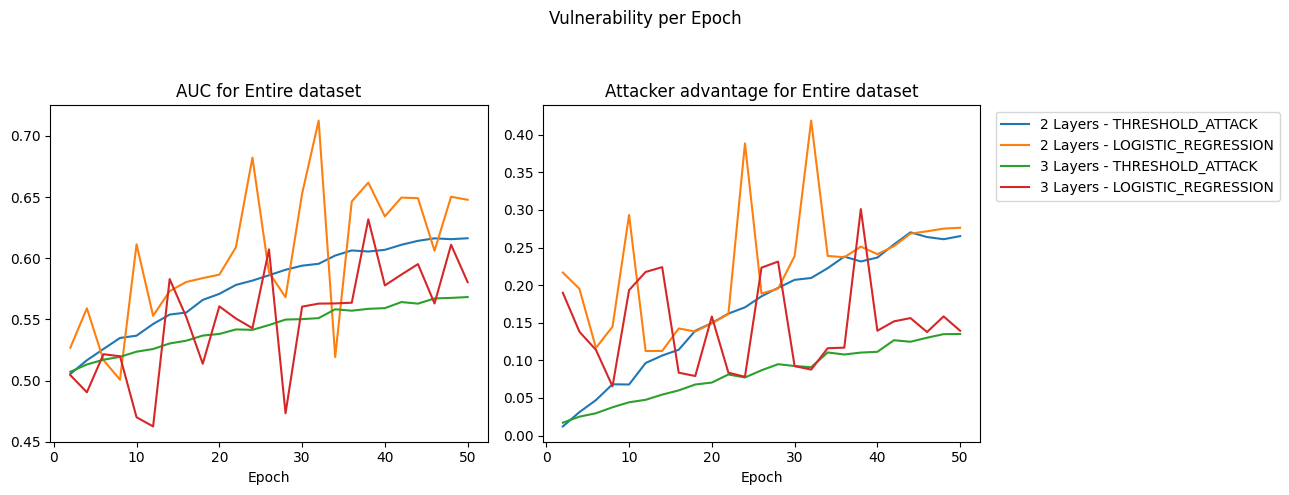

In [15]:
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
epoch_plot = privacy_report.plot_by_epochs(
    results, privacy_metrics=privacy_metrics)

See that as a rule, privacy vulnerability tends to increase as the number of epochs goes up. This is true across model variants as well as different attacker types.

Two layer models (with fewer convolutional layers) are generally more vulnerable than their three layer model counterparts.

Now let's see how model performance changes with respect to privacy risk.

## Privacy vs Utility

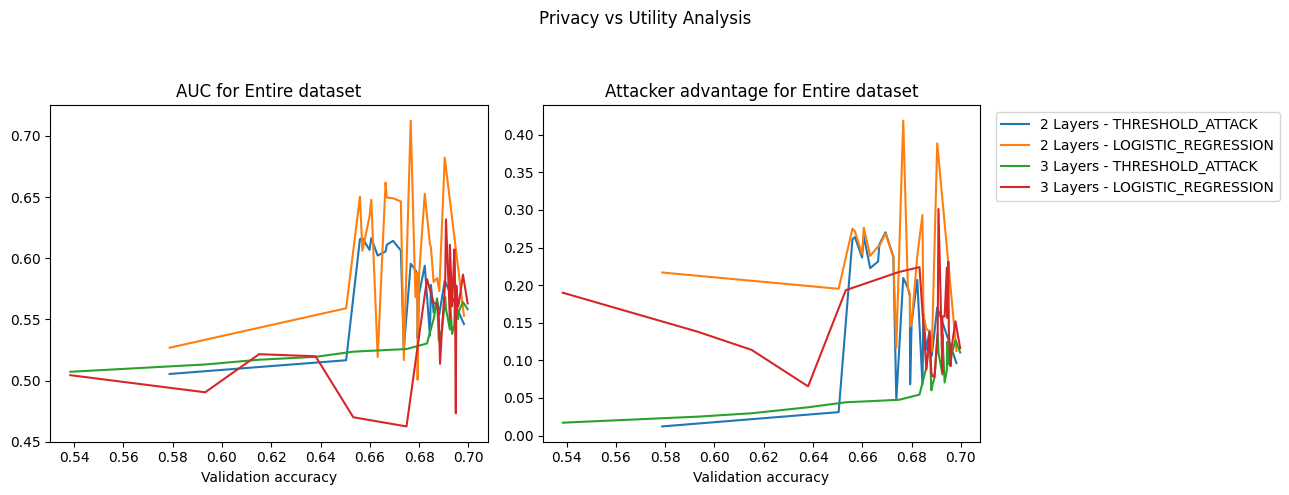

In [16]:
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
utility_privacy_plot = privacy_report.plot_privacy_vs_accuracy(
    results, privacy_metrics=privacy_metrics)

for axis in utility_privacy_plot.axes:
  axis.set_xlabel('Validation accuracy')

Three layer models (perhaps due to too many parameters) only achieve a train accuracy of 0.85. The two layer models achieve roughly equal performance for that level of privacy risk but they continue to get better accuracy.

You can also see how the line for two layer models gets steeper. This means that additional marginal gains in train accuracy come at an expense of vast privacy vulnerabilities.

This is the end of the tutorial. Feel free to analyze your own results.